In [ ]:
'''
MIT License

Copyright (c) 2021 Valentin Gorbunov

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
'''

## Environment Set Up

In [ ]:
# Install packages not in Colab by default
!pip install vaderSentiment
!pip install textstat
!pip install flwr

     |████████████████████████████████| 125 kB 4.3 MB/s 
     |████████████████████████████████| 105 kB 4.4 MB/s 
     |████████████████████████████████| 2.0 MB 27.6 MB/s 
     |████████████████████████████████| 106 kB 4.4 MB/s 
     |████████████████████████████████| 4.1 MB 24.9 MB/s 
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.11.2
    Uninstalling importlib-metadata-4.11.2:
      Successfully uninstalled importlib-metadata-4.11.2
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.44.0
    Uninstalling grpcio-1.44.0:
      Successfully uninstalled grpcio-1.44.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
markdown 3.3.6 requires importlib-metadata>=4.4; python_version < "3.10", but you have 

In [ ]:
# Import packages
import pickle
import sys
import string
import re
import nltk
import seaborn
import os
import time
import warnings
import random
import threading
import nltk.stem.porter
import pandas as pd
import numpy as np
import flwr as fl
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, log_loss, precision_recall_fscore_support
from sklearn.model_selection import train_test_split, StratifiedKFold
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from textstat.textstat import *
from typing import Tuple, Union, List, Dict, Optional
from flwr.server.criterion import Criterion
from flwr.server.client_proxy import ClientProxy
from google.colab import drive
from multiprocessing import Process, Manager
from multiprocessing.managers import ListProxy
from math import ceil
from statistics import mean
%matplotlib inline

In [ ]:
# Mount external storage
drive.mount('/content/drive')

Mounted at /content/drive


## Preliminary Data Analysis

In [ ]:
# Deserialize Pandas DataFrame from pickle file
df = pd.read_pickle(open("/content/drive/MyDrive/labeled_data.p", mode='rb'))

In [ ]:
# Describe content, size and format of the data
df

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...
25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
25295,6,0,6,0,1,youu got wild bitches tellin you lies


In [ ]:
# Generate descriptive statistics
df.describe()

,count,hate_speech,offensive_language,neither
count,24783.000000,24783.000000,24783.000000,24783.000000
mean,3.243473,0.280515,2.413711,0.549247
std,0.883060,0.631851,1.399459,1.113299
min,3.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,2.000000,0.000000
50%,3.000000,0.000000,3.000000,0.000000
75%,3.000000,0.000000,3.000000,0.000000
max,9.000000,7.000000,9.000000,9.000000


In [ ]:
# Get feature names 
df.columns

Index(['count', 'hate_speech', 'offensive_language', 'neither', 'class',
       'tweet'],
      dtype='object')

Key:

count = number of CrowdFlower users who coded each tweet (at least 3; more users coded a tweet when judgments were determined to be unreliable by CF)


hate_speech = number of CF users who coded the tweet as hate speech


offensive_language = number of CF users who coded the tweet as offensive but not hate speech


neither = number of CF users who coded the tweet as neither offensive nor hate speech


class = class label determined by majority rule:

* 0 : hate speech
* 1 : offensive  language
* 2 : neither

tweet = tweet text


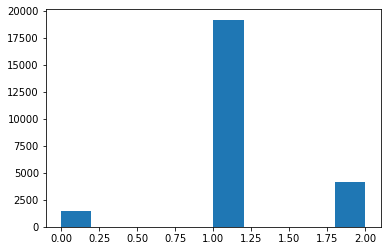

In [ ]:
# Plot distribution of samples across classes
plt.hist(df['class'])
plt.show()

The histogram shows the imbalanced nature of the classification problem; most tweets containing "hateful" words, as defined by Hatebase, were coded as offensive by CF coders. More tweets were considered neither hate speech nor offensive than were considered hate speech.

## Data Preprocessing

In [ ]:
# Select data for preprocessing and transformation
tweets=df.tweet

In [ ]:
# Create list of stopwords 
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words("english")
other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Create reusable stemmer
stemmer = nltk.stem.porter.PorterStemmer()

In [ ]:
# Define functions for preprocessing data
def preprocess(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    return parsed_text

def tokenize(tweet):
    """Removes punctuation & excess whitespace, sets to lowercase,
    and stems tweets. Returns a list of stemmed tokens."""
    tweet = " ".join(re.split("[^a-zA-Z]*", tweet.lower())).strip()
    tokens = [stemmer.stem(t) for t in tweet.split()]
    return tokens

def basic_tokenize(tweet):
    """Same as tokenize but without the stemming"""
    tweet = " ".join(re.split("[^a-zA-Z.,!?]*", tweet.lower())).strip()
    return tweet.split()

## Feature Engineering

### Automatic Feature Extraction

In [ ]:
# Construct tfidf matrix and get relevant scores
vectorizer = TfidfVectorizer(
    tokenizer=tokenize,
    preprocessor=preprocess,
    ngram_range=(1, 3),
    stop_words=stopwords,
    use_idf=True,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.75
    )

tfidf = vectorizer.fit_transform(tweets).toarray()
vocab = {v:i for i, v in enumerate(vectorizer.get_feature_names_out())}
idf_vals = vectorizer.idf_
idf_dict = {i:idf_vals[i] for i in vocab.values()} #keys are indices; values are IDF scores

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'e', 'f', 'g', 'h', 'j', 'l', 'n', 'p', 'r', 'u', 'v', 'w'] not in stop_words.
  % sorted(inconsistent)


In [ ]:
# Get POS tags for tweets and save as a string
nltk.download('averaged_perceptron_tagger')
tweet_tags = []
for t in tweets:
    tokens = basic_tokenize(preprocess(t))
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags]
    tag_str = " ".join(tag_list)
    tweet_tags.append(tag_str)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
# Construct POS TF matrix and get vocab dict
pos_vectorizer = TfidfVectorizer(
    tokenizer=None,
    lowercase=False,
    preprocessor=None,
    ngram_range=(1, 3),
    stop_words=None,
    use_idf=False,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=5000,
    min_df=5,
    max_df=0.75,
    )

pos = pos_vectorizer.fit_transform(pd.Series(tweet_tags)).toarray()
pos_vocab = {v:i for i, v in enumerate(pos_vectorizer.get_feature_names_out())}

### Manual Feature Construction

In [ ]:
# Create reusable sentiment analyzer
sentiment_analyzer = VS()

In [ ]:
# Define functions for devising features
def count_twitter_objs(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE
    4) hashtags with HASHTAGHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned.
    
    Returns counts of urls, mentions, and hashtags.
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

def other_features(tweet):
    """This function takes a string and returns a list of features.
    These include Sentiment scores, Text and Readability scores,
    as well as Twitter specific features"""
    sentiment = sentiment_analyzer.polarity_scores(tweet)
    
    words = preprocess(tweet) # Get text only
    
    syllables = textstat.syllable_count(words)
    num_chars = sum(len(w) for w in words)
    num_chars_total = len(tweet)
    num_terms = len(tweet.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(words.split()))
    
    # Modified FK grade, where avg words per sentence is just num words/1
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    # Modified FRE score, where sentence fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)
    
    twitter_objs = count_twitter_objs(tweet)
    retweet = 0
    if "rt" in words:
        retweet = 1
    features = [FKRA, FRE,syllables, avg_syl, num_chars, num_chars_total, num_terms, num_words,
                num_unique_terms, sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],
                twitter_objs[2], twitter_objs[1],
                twitter_objs[0], retweet]
    return features

def get_feature_array(tweets):
    feats=[]
    for t in tweets:
        feats.append(other_features(t))
    return np.array(feats)

In [ ]:
# Construct features
other_feats = get_feature_array(tweets)

## Feature Selection

In [ ]:
# Join automatically extracted features and manually constructed features together
X = np.concatenate([tfidf,pos,other_feats],axis=1)

In [ ]:
# Get dimensions of the data
X.shape

(24783, 4023)

The data is high dimensional. There is an exponential decrease in predictive power for each additional variable in a multivariate model, known as the curse of dimensionality. Therefore, the dimensionality of the data should be reduced.

## Centralized Model

In [ ]:
# Encode class labels
y = df['class'].astype(int)

In [ ]:
# Reduce dimensionality of data. Specify solver as 'liblinear' because default solver changed to 'lbfgs' in 0.22.
feature_transformer = SelectFromModel(LogisticRegression(class_weight='balanced',penalty="l1", C=0.01, solver='liblinear'))

X_ = feature_transformer.fit_transform(X,y)

In [ ]:
# Get reduced dimensions of the data
X_.shape

(24783, 464)

In [ ]:
# Generate train/test split of 9/1. Initialise with random seed for reproducability.
X_train, X_test, y_train, y_test = train_test_split(X_, y, random_state=42, test_size=0.1, stratify=y)

As classification problem is imbalanced, [it's desirable](https://machinelearningmastery.com/train-test-split-for-evaluating-machine-learning-algorithms//) for the train/test split to preserve the same proportions of examples in each class as observed in the original dataset (stratified split).

In [ ]:
# Create model. Change hyperparameters to ensure control variables remain constant. Change solver to the new default solver, lbfgs.
# Increase `max_iter` as lbfgs takes longer to converge. Change framework used for multi class classification to multinomial.
# See comments in `start_flower_client` for details.
classifier = LogisticRegression(class_weight='balanced',penalty='l2', C=0.01, max_iter=1500, multi_class="multinomial")

In [ ]:
y_train.value_counts()

1    17270
2     3747
0     1287
Name: class, dtype: int64

In [ ]:
# Train model
model = classifier.fit(X_train, y_train)

### Model Testing

In [ ]:
# Test model
y_preds = model.predict(X_test)

In [ ]:
# Generate test report
report = classification_report(y_test, y_preds)
print(report.rsplit("\n",2)[0])

              precision    recall  f1-score   support

           0       0.24      0.69      0.36       143
           1       0.96      0.74      0.84      1920
           2       0.61      0.86      0.72       416

    accuracy                           0.76      2479
   macro avg       0.61      0.77      0.64      2479


There is a class-imbalance in the dataset; the hate speech class (0) and neither class (2) are most important to get right, and they are under-represented. Offensive language class (1) is over-represented. Therefore, [macro average is preferable](https://www.mariakhalusova.com/posts/2019-04-17-ml-model-evaluation-metrics-p2/#micro--macro--weighted-averaged-precision) over misleading weighted average.

F1-score is used rather than AUROC because AUROC averages over all possible discrimination thresholds, [which is misleading](https://stackoverflow.com/questions/44172162/f1-score-vs-roc-auc) in the case of class-imbalanced data. In contrast, F-1 score keeps a balance between Precision and Recall.

In [ ]:
# Define function for plotting confusion matrix
def plot_confusion_matrix(y, y_preds):

  matrix = confusion_matrix(y,y_preds)
  matrix_proportions = np.zeros((3,3))
  for i in range(0,3):
    matrix_proportions[i,:] = matrix[i,:]/float(matrix[i,:].sum())
  names=['Hate','Offensive','Neither']
  confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
  plt.figure(figsize=(5,5))
  seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
  plt.ylabel(r'True categories',fontsize=14)
  plt.xlabel(r'Predicted categories',fontsize=14)
  plt.tick_params(labelsize=12)

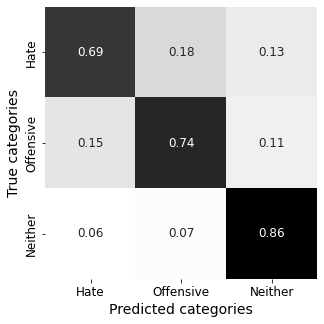

In [ ]:
# Plot confusion matrix
plot_confusion_matrix(y_test,y_preds)

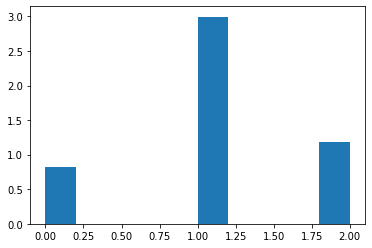

In [ ]:
# Plot distribution of estimates. Set the density parameter to True to normalize bin heights so that the integral of the histogram is 1.
# The resulting histogram is an approximation of the probability density function. This facilitates comparison between the distribution 
# of estimates and true distribution.
plt.hist(y_preds, density=True)
plt.show()

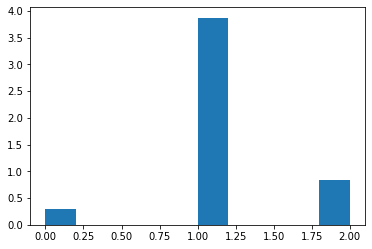

In [ ]:
# Plot true distribution
plt.hist(y, density=True)
plt.show()

# Single-Machine Simulation of Federated Learning System

We use a controlled environment that is suitable for experiments. We assume
a synchronous update scheme that proceeds in rounds of
communication. There is a fixed set of $K$ clients, each
with a fixed local dataset. At the beginning of each round,
a fraction of random clients are selected, and the server
sends the current global model parameters to each of these clients. Each selected client then trains its local model on its local dataset, and sends an
update to the server. The server then applies these updates
to the global model, and the cycle repeats.

In [ ]:
# Initialize global experiment config
DATA_PARTITIONING_STRATEGY = ""
DATA_PARTITIONING_RANDOM_SEED = 1
DIRICHLET_DISTRIBUTION_PARAM = 10
NUMBER_OF_CLIENTS = 20
MIN_AVAILABLE_CLIENTS = 20
NUMBER_OF_FL_ROUNDS = 50
LOCAL_EPOCHS = ceil(1500 / NUMBER_OF_FL_ROUNDS)
MIN_FIT_CLIENTS = 14
FRACTION_FIT = 0.7
FRACTION_FIT_RANDOM_SEED = 1
MIN_EVAL_CLIENTS = 20
FRACTION_EVAL = 1.0
EVAL_STRATEGY = "centralized"
DATA_SHARING = False

Key:

DATA_PARTITIONING_STRATEGY - strategy for distributing samples across clients

DATA_PARTITIONING_RANDOM_SEED - seed to initialize random data partition generator, set for experimental control and reproducability

DIRICHLET_DISTRIBUTION_PARAM - distribution parameter of the Dirichlet distribution, used in particular data partitioning strategies to control degree of imbalance

NUMBER_OF_CLIENTS - total number of clients participating in the FL

MIN_AVAILABLE_CLIENTS - minimum number of clients that must be connected to the server before FL can begin

NUMBER_OF_FL_ROUNDS - number of FL rounds, set to a sufficiently large number so that the performance of the FL system can be observed

LOCAL_EPOCHS - number of complete passes over local training data performed by clients during a training round, limited by the maximum number of iterations taken for the solvers to converge and the number of FL rounds, so that the performance of the FL system can be observed

MIN_FIT_CLIENTS - minimum number of clients used during training

FRACTION_FIT - fraction of random clients selected to participate in a training round

FRACTION_FIT_RANDOM_SEED - seed for initializing the random sampling used to select clients for participation in a training round, set for experimental control and reproducability

MIN_EVAL_CLIENTS - minimum number of clients used during evaluation

FRACTION_EVAL - fraction of random clients selected to participate in an evaluation round

EVAL_STRATEGY - there are two main approaches to evaluate models in federated learning systems: centralized (server-side) evaluation and federated (client-side) evaluation

DATA_SHARING - whether or not to use a [data-sharing strategy](https://arxiv.org/pdf/1806.00582.pdf) to improve training on non-IID data

In [ ]:
# Partition train set into client partition and holdout partition G, where β = 2.5%. Initialise with random seed for reproducability.
X_train_client, X_train_holdout, y_train_client, y_train_holdout = train_test_split(X_train, y_train, random_state=42, test_size=0.025, stratify=y_train)

In [ ]:
# A warm-up model is trained on G
warm_up_model = classifier.fit(X_train_holdout, y_train_holdout)

In [ ]:
# Create a random α portion of G to be merged with the data of each client, where α is 10%
X_train_shared, _, y_train_shared, _ = train_test_split(X_train_holdout, y_train_holdout, random_state=42, train_size=0.1, stratify=y_train_holdout)

## Utility Functions

In [ ]:
XY = Tuple[np.ndarray, np.ndarray]
Dataset = Tuple[XY, XY]
LogRegParams = Union[XY, Tuple[np.ndarray]]
XYList = List[XY]


def get_model_parameters(model: LogisticRegression) -> LogRegParams:
#Returns the paramters of a sklearn LogisticRegression model.
    params = (model.coef_, model.intercept_)
    return params


def set_model_params(model: LogisticRegression, params: LogRegParams) -> LogisticRegression:
#Sets the parameters of a sklean LogisticRegression model.
    model.coef_ = params[0]
    model.intercept_ = params[1]
    return model


def set_initial_params(model: LogisticRegression):
#Sets initial parameters as zeros Required since model params are
#uninitialized until model.fit is called.
#But server asks for initial parameters from clients at launch. Refer
#to sklearn.linear_model.LogisticRegression documentation for more
#information.

    if DATA_SHARING:
      model.classes_ = warm_up_model.classes_
      model.coef_ = warm_up_model.coef_
      model.intercept_ = warm_up_model.intercept_
    else:
      n_classes = 3  # our dataset has 3 classes
      n_features = 466  # Number of features in dataset after feature selection by transformer

      model.classes_ = np.array([i for i in range(n_classes)])
      model.coef_ = np.zeros((n_classes, n_features))
      model.intercept_ = np.zeros((n_classes,))


def get_partitions(x, y):
    np.random.seed(DATA_PARTITIONING_RANDOM_SEED)

    n_train = y.shape[0]

    if DATA_PARTITIONING_STRATEGY == "iid":
        idxs = np.random.permutation(n_train)
        batch_idxs = np.array_split(idxs, NUMBER_OF_CLIENTS)
        net_dataidx_map = {i: batch_idxs[i] for i in range(NUMBER_OF_CLIENTS)}
    elif DATA_PARTITIONING_STRATEGY == "noniid-distribution-based-label-imbalance":
        min_size = 0
        min_require_size = 10
        K = 3
        N = y.shape[0]
        net_dataidx_map = {}

        while min_size < min_require_size:
            idx_batch = [[] for _ in range(NUMBER_OF_CLIENTS)]

            for k in range(K):
                idx_k = np.where(y == k)[0]
                np.random.shuffle(idx_k)
                proportions = np.random.dirichlet(np.repeat(DIRICHLET_DISTRIBUTION_PARAM, NUMBER_OF_CLIENTS))
                proportions = np.array([p * (len(idx_j) < N / NUMBER_OF_CLIENTS) for p, idx_j in zip(proportions, idx_batch)])
                proportions = proportions / proportions.sum()
                proportions = (np.cumsum(proportions) * len(idx_k)).astype(int)[:-1]
                idx_batch = [idx_j + idx.tolist() for idx_j, idx in zip(idx_batch, np.split(idx_k, proportions))]
                min_size = min([len(idx_j) for idx_j in idx_batch])

        for j in range(NUMBER_OF_CLIENTS):
            np.random.shuffle(idx_batch[j])
            net_dataidx_map[j] = idx_batch[j]
    elif DATA_PARTITIONING_STRATEGY == "noniid-quantity-based-label-imbalance-1" or DATA_PARTITIONING_STRATEGY == "noniid-quantity-based-label-imbalance-2":
        num = int(DATA_PARTITIONING_STRATEGY[38]) # number of distinct labels per client
        K = 3 # total number of labels
        times = [0 for _ in range(K)] # holds the number of parties to which each label ID is assigned
        contain = [[] for _ in range(NUMBER_OF_CLIENTS)] # holds the buckets of num label IDs assigned to each party

        for i in range(K): # ensure each label ID is assigned
            bucket = contain[np.random.randint(NUMBER_OF_CLIENTS)]
            while len(bucket) == num:
                bucket = contain[np.random.randint(NUMBER_OF_CLIENTS)]
            bucket.append(i)
            times[i] += 1

        for bucket in contain: # randomly assign num different distinct label IDs to each party
            j = len(bucket)
            while j < num:
                ind = np.random.randint(K)
                if ind not in bucket:
                    bucket.append(ind)
                    times[ind] += 1
                    j += 1

        net_dataidx_map ={i: np.ndarray(0, dtype=np.int64) for i in range(NUMBER_OF_CLIENTS)}

        # For the samples of each label, randomly and equally divide them into the parties
        # which own the label, such that there is no overlap between the samples of different parties
        for i in range(K):
            idx_k = np.where(y == i)[0]
            np.random.shuffle(idx_k)
            split = np.array_split(idx_k,times[i])
            ids = 0
            for j in range(NUMBER_OF_CLIENTS):
                if i in contain[j]:
                    net_dataidx_map[j]=np.append(net_dataidx_map[j],split[ids])
                    ids += 1

    elif DATA_PARTITIONING_STRATEGY == "iid-quantity-skew":
        idxs = np.random.permutation(n_train)
        min_size = 0
        while min_size < 10:
            proportions = np.random.dirichlet(np.repeat(DIRICHLET_DISTRIBUTION_PARAM, NUMBER_OF_CLIENTS))
            proportions = proportions/proportions.sum()
            min_size = np.min(proportions*len(idxs))
        proportions = (np.cumsum(proportions)*len(idxs)).astype(int)[:-1]
        batch_idxs = np.split(idxs, proportions)
        net_dataidx_map = {i: batch_idxs[i] for i in range(NUMBER_OF_CLIENTS)}

    partitioned_train_set = [(x[net_dataidx_map[idx]], pd.Series(y[net_dataidx_map[idx]])) for idx in range(NUMBER_OF_CLIENTS)]

    return partitioned_train_set


def get_train_partitions(x_train, y_train):
  partitioned_train_set = []
  if DATA_SHARING:
    partitioned_train_set = get_partitions(X_train_client, y_train_client.to_numpy())
    # a random α portion of G is merged with the data of each client
    partitioned_train_set = [(np.concatenate((X_train_partition, X_train_shared)), pd.concat((y_train_partition, y_train_shared))) for X_train_partition, y_train_partition in partitioned_train_set]
  else:
    partitioned_train_set = get_partitions(x_train, y_train)

  return partitioned_train_set


def get_test_partitions(x_test, y_test):
  return get_partitions(x_test, y_test)

## Server Functions

In [ ]:
def fit_round(rnd: int) -> Dict:
  """Send fit round number to client."""

  return {"rnd": rnd}

def evaluate_round(rnd: int) -> Dict:
  """Send evaluate round number to client."""

  return {"rnd": rnd}

# get_eval_fn is a closure factory function that creates a closure consisting of the inner function evaluate together with its enclosing environment.
# The closure can modify the mutable objects aka dynamic enclosing state, such as model, within its enclosing state
def get_eval_fn(model: LogisticRegression, y_preds: ListProxy, test_accs: ListProxy):
    """Return an evaluation function for server-side evaluation."""

    # The `evaluate` function will be called after every training round.
    def evaluate(parameters: fl.common.Weights):
        print("Beginning centralized evaluation...")
        print("Updating aggregate model with the latest parameters...")
        # Update model with the latest parameters
        set_model_params(model, parameters)
        print("Predicting class labels for samples in X_test...")
        # Predict class labels for samples in X_test
        predictions = model.predict(X_test)
        y_preds.append(predictions)
        # Calculate probability estimates
        print("Calculating probability estimates...")
        prob_estimates = model.predict_proba(X_test)
        # Calculate cross-entropy loss
        print("Calculating cross-entropy loss...")
        loss = log_loss(y_test, prob_estimates)
        print("Calculating the mean accuracy on the test data and labels...")
        # Calculate the mean accuracy on the test data and labels.
        accuracy = model.score(X_test, y_test)
        test_accs.append(accuracy)
        print("Finished centralized evaluation.")
        return loss, {"accuracy": accuracy}
        
    return evaluate

In [ ]:
def start_flower_server(y_preds: ListProxy, test_accs: ListProxy):
  model = LogisticRegression()
  set_initial_params(model)

# Sample fraction of available clients for the next round
# Minimum number of clients to be sampled for the next round
# Minimum number of clients that need to be connected to the server before a round of federated learning can start. If few clients 
# are connected then the server will wait until more connect before sampling clients
# There are two main approaches to evaluate models in flower, centralized (server-side) evaluation and federated (client-side) evaluation.
# Centralized and federated evaluation are mutually exclusive.
# All built-in strategies support centalized evaluation by providing an evaluation function during 
# initialization. An evaluation function is any function that can take the current global model parameters as input 
# and return evaluation results. The current server implementation calls eval_fn AFTER parameter aggregation  
# (training round).
# Customizing the existing FedAvg strategy with the callback function fit_round, bound to eval_fn, to pass variable 
# configuration values to the client each training round. The provided function will be called by the strategy 
# and must return a dictionary of arbitrary configuration key-value pairs that will be sent to the client 
# (received in its own client.fit function).

  class MyClientManager(fl.server.SimpleClientManager):
    def __init__(self) -> None:
      super().__init__()
      random.seed(FRACTION_FIT_RANDOM_SEED)

  client_manager = MyClientManager()

  strategy = fl.server.strategy.FedAvg()

  strategy.min_available_clients = MIN_AVAILABLE_CLIENTS
  strategy.fraction_fit = FRACTION_FIT
  strategy.min_fit_clients = MIN_FIT_CLIENTS          
  strategy.on_fit_config_fn = fit_round
  strategy.fraction_eval = FRACTION_EVAL
  strategy.min_eval_clients = MIN_EVAL_CLIENTS

  if (EVAL_STRATEGY == "federated"):
    strategy.on_evaluate_config_fn = evaluate_round
  else:
    strategy.eval_fn = get_eval_fn(model, y_preds, test_accs)
  
  server = fl.server.Server(client_manager=client_manager, strategy=strategy)
  
  fl.server.start_server("0.0.0.0:80", server=server, config={"num_rounds": NUMBER_OF_FL_ROUNDS})

## Client Functions

In [ ]:
def start_flower_client(X_train: np.ndarray, y_train: np.ndarray, X_test: np.ndarray, y_test: np.ndarray, id: str, y_preds: ListProxy, test_accs: ListProxy):
  pid = os.getpid()
  print(f"initializing Client{id} with pid {pid}")

  # Create LogisticRegression Model
  # max_iter: way to limit the number of epochs. One epoch means that each sample in the training dataset has had an opportunity 
  # to update the internal model parameters. The solver iterates until convergence (determined by ‘tol’) or this number of iterations.
  # i.e., the learning will be stopped either when the solver iterates max_iter times or when the cost between two iterations changes less than tol, 
  # whichever comes first. From sklearn.linear_model.LogisticRegression documentation we can see that ‘tol’ is 0.0001 by default.
  # warm_start: prevent refreshing weights when fitting, this is required for federated learning
  # As a result of the fact that warm_start is required, the variable solver must be changed because liblinear does not support warm start
  # Framework used for multi class classification is multinomial. 
  # This is necessary because of the non-iid data in federated learning scenarios; in a multinomial framework, learning 𝛽𝑖 for a particular class i
  # immediately affects our model for other classes j, through the joint model. Consequently, The training algorithm uses log loss aka cross-entropy loss
  model = LogisticRegression(penalty='l2', max_iter=LOCAL_EPOCHS, warm_start=True, class_weight='balanced', C=0.01)

  # Setting initial model parameters
  set_initial_params(model)

  # Define Flower client
  class MyClient(fl.client.NumPyClient):
    def get_parameters(self): # -> List[numpy.ndarray]
      return get_model_parameters(model)

    # Training happens in fit method and can be configured from the server side. 
    # Model parameters can also be evaluated during training. Client.fit can return arbitrary evaluation results as a dictionary
    def fit(self, parameters, config):
      print(f"Client{id} with pid {pid} is sampled in training rnd {config['rnd']}")
      set_model_params(model, parameters)
      # Ignore convergence failure due to low local epochs
      with warnings.catch_warnings():
          warnings.simplefilter("ignore")
          model.fit(X_train, y_train)
      # print(f"Training finished for round {config['rnd']}")
      # print(f"Model params is a 2 tuple, first element contains coefficients/weights, second element contains intercept")
      # print(f"Number of coefficients/weights: {get_model_parameters(model)[0].shape}")
      # print(f"Model params: {get_model_parameters(model)}")
      return get_model_parameters(model), len(X_train), {}

    # Federated evaluation happens in the evaluate method and can be configured from the server side.
    def evaluate(self, parameters, config): 
      print(f"Client{id} with pid {pid} is sampled in evaluation rnd {config['rnd']}")
      
      # Update model with the latest parameters
      set_model_params(model, parameters)
      
      # Predict class labels for samples in X_test
      predictions = model.predict(X_test)
      y_preds.append(predictions)
      
      # Calculate probability estimates
      prob_estimates = model.predict_proba(X_test)

      # Calculate cross-entropy loss
      loss = log_loss(y_test, prob_estimates, labels=[0,1,2])

      # Calculate the mean accuracy on the test data and labels.
      accuracy = model.score(X_test, y_test)
      test_accs.append(accuracy)

      return loss, len(X_test), {"accuracy": accuracy}

  client = MyClient()

  # Start Flower client
  fl.client.start_numpy_client("0.0.0.0:80", client=client)

## Experiment Functions

In [ ]:
def evaluate_local_models(partitioned_train_set, partitioned_test_set):
  local_models_y_preds = []

  for i in range(NUMBER_OF_CLIENTS):
    (X_train_partition, y_train_partition) = partitioned_train_set[i]
    model = classifier.fit(X_train_partition, y_train_partition)

    (X_test_partition, y_test_partition) = partitioned_test_set[i]
    y_preds = model.predict(X_test_partition)
    local_models_y_preds.append(y_preds)

  return local_models_y_preds

In [ ]:
# Define function for running simulation with global config
def run_sim(partitioned_train_set, partitioned_test_set=None):
  with Manager() as manager:
    # Holds all child processes
    processes = []

    # List proxy for gathering class labels predicted during centralized evaluation
    centralized_y_preds = manager.list()

    # List proxy for gathering test accuracies from centralized evaluation
    centralized_test_accs = manager.list()

    # Holds all the list proxies for gathering class labels predicted during federated evaluation
    federated_y_preds = []

    # Holds all the list proxies for gathering test accuracies from federated evaluation
    federated_test_accs = []

    # Start Flower server
    server_process = Process(target=start_flower_server, args=(centralized_y_preds, centralized_test_accs))
    server_process.start()
    processes.append(server_process)

    # Block the script here for a second or two so the server has time to start
    time.sleep(2)

    # Start Flower clients
    if EVAL_STRATEGY == "centralized":
      for i in range(NUMBER_OF_CLIENTS):
        y_preds = manager.list()
        test_accs = manager.list()
        (X_train_partition, y_train_partition) = partitioned_train_set[i]
        client_process = Process(target=start_flower_client, args=(X_train_partition, y_train_partition, X_test, y_test, str(i), y_preds, test_accs))
        client_process.start()

        federated_y_preds.append(y_preds)
        federated_test_accs.append(test_accs)
        processes.append(client_process)

        # Block the script here for a second to ensure clients register with server in-order (helps control fraction fit variable)
        time.sleep(1)
    else:
      for i in range(NUMBER_OF_CLIENTS):
        y_preds = manager.list()
        test_accs = manager.list()
        (X_train_partition, y_train_partition) = partitioned_train_set[i]
        
        (X_test_partition, y_test_partition) = partitioned_test_set[i]

        client_process = Process(target=start_flower_client, args=(X_train_partition, y_train_partition, X_test_partition, y_test_partition, str(i), y_preds, test_accs))
        client_process.start()

        federated_y_preds.append(y_preds)
        federated_test_accs.append(test_accs)
        processes.append(client_process)

        # Block the script here for a second to ensure clients register with server in-order (helps control fraction fit variable)
        time.sleep(1)

    # Wait for processes to finish
    for p in processes:
      p.join()

    # Dereference proxies and return results
    return {"centralized_y_preds": centralized_y_preds[:], "centralized_test_accs": centralized_test_accs[:], 
            "federated_y_preds": [y_preds[:] for y_preds in federated_y_preds], "federated_test_accs": [test_accs[:] for test_accs in federated_test_accs]}

In [ ]:
def get_label_freqs(partitioned_train_set, relative=False):
  label_freqs = [y_train.value_counts(normalize=relative).rename("y_train")]
  
  for i in range(NUMBER_OF_CLIENTS):
    label_freqs.append(partitioned_train_set[i][1].value_counts(normalize=relative).rename("client" + str(i)))

  label_freqs_table = pd.concat(label_freqs, axis=1).fillna(0)

  if relative:
    return label_freqs_table.astype("float64")
  else:
    return label_freqs_table.astype("int64")


def plot_distribution_of_labels(partitioned_train_set):
  number_of_label_across_partitions = pd.concat([partitioned_train_set[i][1].value_counts().sort_index() for i in range(NUMBER_OF_CLIENTS)], axis=1).fillna(0).astype("int64").to_numpy()
  
  labs = [str(i) for i in range(NUMBER_OF_CLIENTS)]
  plt.barh(labs, number_of_label_across_partitions[0])
  plt.barh(labs, number_of_label_across_partitions[1], left=number_of_label_across_partitions[0], color='g')
  plt.barh(labs, number_of_label_across_partitions[2], left=number_of_label_across_partitions[0]+number_of_label_across_partitions[1], color='r')
  plt.title("Distribution of Labels")
  plt.xlabel("Number of Local Data Samples")
  plt.ylabel("Client ID")
  labelIDs=['0','1', '2']
  plt.legend(labelIDs, bbox_to_anchor = (1.03, 0.6))
  plt.show()


def plot_performance_of_local_models(precision_recall_fscores, avg_local_model_precision_recall_fscore):
  labs = [str(i) for i in range(NUMBER_OF_CLIENTS)]
  plt.bar(labs, precision_recall_fscores[2], label='Client')
  plt.axhline(y=avg_local_model_precision_recall_fscore[2], color='r', linestyle='--', label='Avg')
  plt.ylim([0, 1])
  plt.xlabel("Client ID")
  plt.ylabel('F1-score')
  plt.title('F1-score of Local Models')
  plt.legend(bbox_to_anchor = (1.03, 0.6))
  plt.show()


def print_measures_of_dispersion(precision_recall_fscores):
  var = np.var(precision_recall_fscores[2])
  std = np.std(precision_recall_fscores[2])

  print(f'Variance of F1-score across local models: {var}')
  print(f'Standard Deviation of F1-score across local models: {std}')


def precision_recall_fscore(y_true, y_pred):
  return precision_recall_fscore_support(y_true, y_pred, average="macro")[:-1]


def get_precision_recall_fscores_of_local_models(local_models_y_test, local_models_y_preds):
  return list(zip(*[precision_recall_fscore(local_model_y_test, local_model_y_preds) for local_model_y_test, local_model_y_preds in zip(local_models_y_test, local_models_y_preds)]))


def get_mean_precision_recall_fscores_of_local_models(precision_recall_fscores_of_local_models):
  return [mean(metric) for metric in precision_recall_fscores_of_local_models]


def get_utility_measure_on_distributions(aggr_model_precision_recall_fscore, avg_local_model_precision_recall_fscore):
  arrays = [["Precision", "Precision", "Recall", "Recall", "F1-score", "F1-score"],
          ["Aggr.", "Local", "Aggr.", "Local", "Aggr.", "Local"]]
  tuples = list(zip(*arrays))
  index = pd.MultiIndex.from_tuples(tuples, names=["Distribution", ""])

  utility_measure = pd.DataFrame([[round(i, 2) for sub in zip(aggr_model_precision_recall_fscore,avg_local_model_precision_recall_fscore) for i in sub]], index=[DATA_PARTITIONING_STRATEGY], columns=index)
  return utility_measure

def plot_convergence_behaviour_from_federated_evaluation(federated_test_accs):
  plt.plot([mean(test_accs) for test_accs in zip(*federated_test_accs)])
  plt.ylim([0, 1])
  plt.xlabel("Round")
  plt.ylabel("Avg Test Acc")
  plt.title("Convergence Behaviour")
  plt.legend(bbox_to_anchor = (1.03, 0.6))
  plt.show()

def plot_convergence_behaviour_from_centralized_evaluation(centralized_test_accs):
  plt.plot(centralized_test_accs)
  plt.ylim([0, 1])
  plt.xlabel("Round")
  plt.ylabel("Test Acc")
  plt.title("Convergence Behaviour")
  plt.legend(bbox_to_anchor = (1.03, 0.6))
  plt.show()


def report_classification_macro_averages(y_test, y_preds):
  report = classification_report(y_test, y_preds)
  rows = report.split("\n")
  headings = " ".join(rows[0].split(" ")[:-1])
  macro_averages = " ".join(rows[7].split(" ")[:-1])
  return "\n".join((headings, macro_averages))


## [Distributed Optimization Problem](https://arxiv.org/pdf/1602.05629.pdf)

Our federated learning system has the finite sum objective with generic form:

\begin{equation}
\min_{w \in \mathbb{R}^d} f(w)
\qquad \text{where} \qquad
f(w) \overset{\text{def}}{=} \frac{1}{n} \sum_{i=1}^n f_i(w).
\end{equation}

where $n$ is the number of data samples and $w$ is the model parameters

We take $f_i(w) = \ell(x_i, y_i; w)$, that is, the log loss of the prediction on sample $(x_i, y_i)$ made with coefficients $w$. We assume there are $K$ clients over which the data is partitioned, with $\mathcal{P}_k$ the set of samples on client $k$, with $n_k = |\mathcal{P}_k|$. Thus, we can re-write the system's objective as:

\begin{equation}
\min_{w \in \mathbb{R}^d} \sum_{k = 1}^K \frac{n_k}{n} F_k(w)
\qquad \text{where} \qquad
F_k(w) \overset{\text{def}}{=} \frac{1}{n_k} \sum_{i \in \mathcal{P}_k} f_i(w).
\end{equation}

If the partition $\mathcal{P}_k$ is formed by distributing the samples over the clients uniformly at random, then the following holds: $\forall k.\mathbb{E}_{\mathcal{P}_k}[F_k(w)] = f(w)$. This is the **IID assumption** made by distributed optimization algorithms. 

We refer to the IID setting where this holds below:

### [Centralized Evaluation](https://flower.dev/docs/evaluation.html)

In [ ]:
# Overrides to global experiment config
DATA_PARTITIONING_STRATEGY = "iid"

In [ ]:
# Split train set into NUMBER_OF_CLIENTS partitions.
partitioned_train_set = get_train_partitions(X_train, y_train.to_numpy())

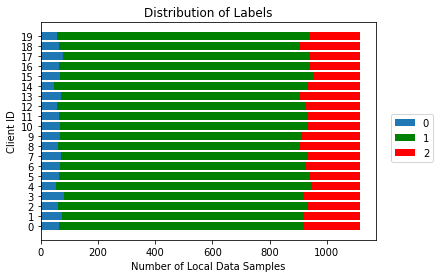

In [ ]:
plot_distribution_of_labels(partitioned_train_set)

In [ ]:
# Run sim with global config
sim_results = run_sim(partitioned_train_set)

INFO flower 2022-03-06 22:35:50,761 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-03-06 22:35:50,765 | server.py:128 | Initializing global parameters
INFO flower 2022-03-06 22:35:50,767 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 43103


INFO flower 2022-03-06 22:35:52,789 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 22:35:52,793 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 22:35:52,795 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-03-06 22:35:52,797 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-03-06 22:35:52,801 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-03-06 22:35:52,802 | server.py:130 | Evaluating initial parameters


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 22:35:52,859 | server.py:137 | initial parameters (loss, other metrics): 1.0986122886681096, {'accuracy': 0.057684550221863654}
INFO flower 2022-03-06 22:35:52,865 | server.py:143 | FL starting


initializing Client1 with pid 43164


INFO flower 2022-03-06 22:35:53,821 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 22:35:53,825 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 22:35:53,828 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 43196


INFO flower 2022-03-06 22:35:54,851 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 22:35:54,855 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 22:35:54,859 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 43228


INFO flower 2022-03-06 22:35:55,883 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 22:35:55,887 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 22:35:55,890 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-03-06 22:35:55,894 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 43267


INFO flower 2022-03-06 22:35:56,917 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 22:35:56,922 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 22:35:56,924 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-03-06 22:35:56,926 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 43305


INFO flower 2022-03-06 22:35:57,947 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 22:35:57,951 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 22:35:57,953 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 43343


INFO flower 2022-03-06 22:35:58,977 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 22:35:58,980 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 22:35:58,983 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 43383


INFO flower 2022-03-06 22:36:00,005 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 22:36:00,009 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 22:36:00,011 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 43425


INFO flower 2022-03-06 22:36:01,034 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 22:36:01,038 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 22:36:01,041 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 43469


INFO flower 2022-03-06 22:36:02,066 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 22:36:02,070 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 22:36:02,075 | connection.py:39 | ChannelConnectivity.READY


initializing Client10 with pid 43515


INFO flower 2022-03-06 22:36:03,099 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 22:36:03,104 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 22:36:03,109 | connection.py:39 | ChannelConnectivity.READY


initializing Client11 with pid 43563


INFO flower 2022-03-06 22:36:04,127 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 22:36:04,131 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 22:36:04,134 | connection.py:39 | ChannelConnectivity.READY


initializing Client12 with pid 43616


INFO flower 2022-03-06 22:36:05,157 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 22:36:05,162 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 22:36:05,165 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-03-06 22:36:05,167 | connection.py:39 | ChannelConnectivity.READY


initializing Client13 with pid 43670


INFO flower 2022-03-06 22:36:06,193 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 22:36:06,196 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 22:36:06,198 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-03-06 22:36:06,201 | connection.py:39 | ChannelConnectivity.READY


initializing Client14 with pid 43726


INFO flower 2022-03-06 22:36:07,225 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 22:36:07,229 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 22:36:07,233 | connection.py:39 | ChannelConnectivity.READY


initializing Client15 with pid 43782


INFO flower 2022-03-06 22:36:08,256 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 22:36:08,261 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 22:36:08,264 | connection.py:39 | ChannelConnectivity.READY


initializing Client16 with pid 43840


INFO flower 2022-03-06 22:36:09,284 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 22:36:09,288 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 22:36:09,290 | connection.py:39 | ChannelConnectivity.READY


initializing Client17 with pid 43900


INFO flower 2022-03-06 22:36:10,314 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 22:36:10,319 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 22:36:10,323 | connection.py:39 | ChannelConnectivity.READY


initializing Client18 with pid 43963


INFO flower 2022-03-06 22:36:11,344 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 22:36:11,348 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 22:36:11,351 | connection.py:39 | ChannelConnectivity.READY


initializing Client19 with pid 44027


INFO flower 2022-03-06 22:36:12,379 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 22:36:12,383 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 22:36:12,386 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-03-06 22:36:12,386 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client18 with pid 43963 is sampled in training rnd 1
Client3 with pid 43228 is sampled in training rnd 1
Client8 with pid 43425 is sampled in training rnd 1
Client2 with pid 43196 is sampled in training rnd 1
Client15 with pid 43782 is sampled in training rnd 1
Client12 with pid 43616 is sampled in training rnd 1
Client7 with pid 43383 is sampled in training rnd 1
Client13 with pid 43670 is sampled in training rnd 1
Client10 with pid 43515 is sampled in training rnd 1
Client6 with pid 43343 is sampled in training rnd 1
Client16 with pid 43840 is sampled in training rnd 1
Client1 with pid 43164 is sampled in training rnd 1
Client14 with pid 43726 is sampled in training rnd 1
Client0 with pid 43103 is sampled in training rnd 1


DEBUG flower 2022-03-06 22:36:13,720 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 22:36:13,850 | server.py:164 | fit progress: (1, 0.6583917417664651, {'accuracy': 0.7450584913271481}, 20.97518196800229)
INFO flower 2022-03-06 22:36:13,853 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 22:36:13,856 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client12 with pid 43616 is sampled in training rnd 2
Client0 with pid 43103 is sampled in training rnd 2
Client8 with pid 43425 is sampled in training rnd 2
Client13 with pid 43670 is sampled in training rnd 2
Client11 with pid 43563 is sampled in training rnd 2
Client14 with pid 43726 is sampled in training rnd 2
Client19 with pid 44027 is sampled in training rnd 2
Client3 with pid 43228 is sampled in training rnd 2
Client9 with pid 43469 is sampled in training rnd 2
Client1 with pid 43164 is sampled in training rnd 2
Client5 with pid 43305 is sampled in training rnd 2
Client17 with pid 43900 is sampled in training rnd 2
Client15 with pid 43782 is sampled in training rnd 2
Client7 with pid 43383 is sampled in training rnd 2


DEBUG flower 2022-03-06 22:36:15,283 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 22:36:15,398 | server.py:164 | fit progress: (2, 0.5747541043316289, {'accuracy': 0.7898346107301332}, 22.52332564599783)
INFO flower 2022-03-06 22:36:15,400 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 22:36:15,404 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client17 with pid 43900 is sampled in training rnd 3
Client0 with pid 43103 is sampled in training rnd 3
Client12 with pid 43616 is sampled in training rnd 3
Client6 with pid 43343 is sampled in training rnd 3
Client8 with pid 43425 is sampled in training rnd 3
Client11 with pid 43563 is sampled in training rnd 3
Client18 with pid 43963 is sampled in training rnd 3
Client13 with pid 43670 is sampled in training rnd 3
Client3 with pid 43228 is sampled in training rnd 3
Client7 with pid 43383 is sampled in training rnd 3
Client10 with pid 43515 is sampled in training rnd 3
Client19 with pid 44027 is sampled in training rnd 3
Client14 with pid 43726 is sampled in training rnd 3
Client2 with pid 43196 is sampled in training rnd 3


DEBUG flower 2022-03-06 22:36:16,813 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 22:36:16,947 | server.py:164 | fit progress: (3, 0.559003201520352, {'accuracy': 0.7894312222670432}, 24.072283649002202)
INFO flower 2022-03-06 22:36:16,951 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 22:36:16,962 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client7 with pid 43383 is sampled in training rnd 4
Client19 with pid 44027 is sampled in training rnd 4
Client14 with pid 43726 is sampled in training rnd 4
Client9 with pid 43469 is sampled in training rnd 4
Client0 with pid 43103 is sampled in training rnd 4
Client6 with pid 43343 is sampled in training rnd 4
Client13 with pid 43670 is sampled in training rnd 4
Client10 with pid 43515 is sampled in training rnd 4
Client8 with pid 43425 is sampled in training rnd 4
Client1 with pid 43164 is sampled in training rnd 4
Client4 with pid 43267 is sampled in training rnd 4
Client2 with pid 43196 is sampled in training rnd 4
Client5 with pid 43305 is sampled in training rnd 4
Client11 with pid 43563 is sampled in training rnd 4


DEBUG flower 2022-03-06 22:36:18,388 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 22:36:18,476 | server.py:164 | fit progress: (4, 0.5485565459240456, {'accuracy': 0.799919322307382}, 25.601519926996843)
INFO flower 2022-03-06 22:36:18,489 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 22:36:18,494 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client13 with pid 43670 is sampled in training rnd 5
Client16 with pid 43840 is sampled in training rnd 5
Client10 with pid 43515 is sampled in training rnd 5
Client6 with pid 43343 is sampled in training rnd 5
Client18 with pid 43963 is sampled in training rnd 5
Client4 with pid 43267 is sampled in training rnd 5
Client14 with pid 43726 is sampled in training rnd 5
Client9 with pid 43469 is sampled in training rnd 5
Client7 with pid 43383 is sampled in training rnd 5
Client8 with pid 43425 is sampled in training rnd 5
Client15 with pid 43782 is sampled in training rnd 5
Client0 with pid 43103 is sampled in training rnd 5
Client11 with pid 43563 is sampled in training rnd 5
Client1 with pid 43164 is sampled in training rnd 5


DEBUG flower 2022-03-06 22:36:19,939 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 22:36:20,069 | server.py:164 | fit progress: (5, 0.5403290329054117, {'accuracy': 0.8027430415490117}, 27.19485464099853)
INFO flower 2022-03-06 22:36:20,080 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 22:36:20,088 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client12 with pid 43616 is sampled in training rnd 6
Client13 with pid 43670 is sampled in training rnd 6
Client5 with pid 43305 is sampled in training rnd 6
Client11 with pid 43563 is sampled in training rnd 6
Client16 with pid 43840 is sampled in training rnd 6
Client1 with pid 43164 is sampled in training rnd 6
Client7 with pid 43383 is sampled in training rnd 6
Client10 with pid 43515 is sampled in training rnd 6
Client14 with pid 43726 is sampled in training rnd 6
Client8 with pid 43425 is sampled in training rnd 6
Client2 with pid 43196 is sampled in training rnd 6
Client15 with pid 43782 is sampled in training rnd 6
Client6 with pid 43343 is sampled in training rnd 6
Client9 with pid 43469 is sampled in training rnd 6


DEBUG flower 2022-03-06 22:36:21,470 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 22:36:21,591 | server.py:164 | fit progress: (6, 0.5210289577444823, {'accuracy': 0.809197256958451}, 28.71689013899595)
INFO flower 2022-03-06 22:36:21,594 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 22:36:21,599 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client15 with pid 43782 is sampled in training rnd 7
Client0 with pid 43103 is sampled in training rnd 7
Client19 with pid 44027 is sampled in training rnd 7
Client1 with pid 43164 is sampled in training rnd 7
Client9 with pid 43469 is sampled in training rnd 7
Client11 with pid 43563 is sampled in training rnd 7
Client17 with pid 43900 is sampled in training rnd 7
Client13 with pid 43670 is sampled in training rnd 7
Client12 with pid 43616 is sampled in training rnd 7
Client14 with pid 43726 is sampled in training rnd 7
Client6 with pid 43343 is sampled in training rnd 7
Client2 with pid 43196 is sampled in training rnd 7
Client8 with pid 43425 is sampled in training rnd 7
Client4 with pid 43267 is sampled in training rnd 7


DEBUG flower 2022-03-06 22:36:22,978 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 22:36:23,109 | server.py:164 | fit progress: (7, 0.5249158459974351, {'accuracy': 0.8108108108108109}, 30.234227681001357)
INFO flower 2022-03-06 22:36:23,111 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 22:36:23,118 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client6 with pid 43343 is sampled in training rnd 8
Client0 with pid 43103 is sampled in training rnd 8
Client7 with pid 43383 is sampled in training rnd 8
Client12 with pid 43616 is sampled in training rnd 8
Client8 with pid 43425 is sampled in training rnd 8
Client5 with pid 43305 is sampled in training rnd 8
Client19 with pid 44027 is sampled in training rnd 8
Client9 with pid 43469 is sampled in training rnd 8
Client16 with pid 43840 is sampled in training rnd 8
Client13 with pid 43670 is sampled in training rnd 8
Client4 with pid 43267 is sampled in training rnd 8
Client14 with pid 43726 is sampled in training rnd 8
Client18 with pid 43963 is sampled in training rnd 8
Client3 with pid 43228 is sampled in training rnd 8


DEBUG flower 2022-03-06 22:36:24,478 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 22:36:24,616 | server.py:164 | fit progress: (8, 0.5275590076879493, {'accuracy': 0.8063735377168213}, 31.741815297995345)
INFO flower 2022-03-06 22:36:24,618 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 22:36:24,625 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client4 with pid 43267 is sampled in training rnd 9
Client16 with pid 43840 is sampled in training rnd 9
Client19 with pid 44027 is sampled in training rnd 9
Client6 with pid 43343 is sampled in training rnd 9
Client7 with pid 43383 is sampled in training rnd 9
Client13 with pid 43670 is sampled in training rnd 9
Client0 with pid 43103 is sampled in training rnd 9
Client5 with pid 43305 is sampled in training rnd 9
Client8 with pid 43425 is sampled in training rnd 9
Client9 with pid 43469 is sampled in training rnd 9
Client3 with pid 43228 is sampled in training rnd 9
Client10 with pid 43515 is sampled in training rnd 9
Client17 with pid 43900 is sampled in training rnd 9
Client11 with pid 43563 is sampled in training rnd 9


DEBUG flower 2022-03-06 22:36:26,114 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 22:36:26,237 | server.py:164 | fit progress: (9, 0.5308417247324716, {'accuracy': 0.8023396530859217}, 33.36225437300163)
INFO flower 2022-03-06 22:36:26,242 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 22:36:26,250 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client11 with pid 43563 is sampled in training rnd 10
Client13 with pid 43670 is sampled in training rnd 10
Client19 with pid 44027 is sampled in training rnd 10
Client0 with pid 43103 is sampled in training rnd 10
Client10 with pid 43515 is sampled in training rnd 10
Client7 with pid 43383 is sampled in training rnd 10
Client9 with pid 43469 is sampled in training rnd 10
Client16 with pid 43840 is sampled in training rnd 10
Client3 with pid 43228 is sampled in training rnd 10
Client15 with pid 43782 is sampled in training rnd 10
Client2 with pid 43196 is sampled in training rnd 10
Client8 with pid 43425 is sampled in training rnd 10
Client18 with pid 43963 is sampled in training rnd 10
Client6 with pid 43343 is sampled in training rnd 10


DEBUG flower 2022-03-06 22:36:27,756 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 22:36:27,878 | server.py:164 | fit progress: (10, 0.5270722249385456, {'accuracy': 0.8031464300121016}, 35.003736184000445)
INFO flower 2022-03-06 22:36:27,884 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 22:36:27,886 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client2 with pid 43196 is sampled in training rnd 11
Client8 with pid 43425 is sampled in training rnd 11
Client17 with pid 43900 is sampled in training rnd 11
Client1 with pid 43164 is sampled in training rnd 11
Client19 with pid 44027 is sampled in training rnd 11
Client16 with pid 43840 is sampled in training rnd 11
Client13 with pid 43670 is sampled in training rnd 11
Client0 with pid 43103 is sampled in training rnd 11
Client7 with pid 43383 is sampled in training rnd 11
Client12 with pid 43616 is sampled in training rnd 11
Client4 with pid 43267 is sampled in training rnd 11
Client3 with pid 43228 is sampled in training rnd 11
Client9 with pid 43469 is sampled in training rnd 11
Client10 with pid 43515 is sampled in training rnd 11


DEBUG flower 2022-03-06 22:36:29,295 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 22:36:29,416 | server.py:164 | fit progress: (11, 0.5215806007496019, {'accuracy': 0.8071803146430012}, 36.5418685600016)
INFO flower 2022-03-06 22:36:29,423 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 22:36:29,433 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client19 with pid 44027 is sampled in training rnd 12
Client5 with pid 43305 is sampled in training rnd 12
Client11 with pid 43563 is sampled in training rnd 12
Client14 with pid 43726 is sampled in training rnd 12
Client9 with pid 43469 is sampled in training rnd 12
Client15 with pid 43782 is sampled in training rnd 12
Client2 with pid 43196 is sampled in training rnd 12
Client4 with pid 43267 is sampled in training rnd 12
Client8 with pid 43425 is sampled in training rnd 12
Client13 with pid 43670 is sampled in training rnd 12
Client12 with pid 43616 is sampled in training rnd 12
Client7 with pid 43383 is sampled in training rnd 12
Client16 with pid 43840 is sampled in training rnd 12
Client18 with pid 43963 is sampled in training rnd 12


DEBUG flower 2022-03-06 22:36:30,809 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 22:36:30,933 | server.py:164 | fit progress: (12, 0.5157930046264566, {'accuracy': 0.8104074223477209}, 38.05811034300132)
INFO flower 2022-03-06 22:36:30,936 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 22:36:30,938 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client10 with pid 43515 is sampled in training rnd 13
Client18 with pid 43963 is sampled in training rnd 13
Client3 with pid 43228 is sampled in training rnd 13
Client15 with pid 43782 is sampled in training rnd 13
Client0 with pid 43103 is sampled in training rnd 13
Client4 with pid 43267 is sampled in training rnd 13
Client6 with pid 43343 is sampled in training rnd 13
Client5 with pid 43305 is sampled in training rnd 13
Client16 with pid 43840 is sampled in training rnd 13
Client13 with pid 43670 is sampled in training rnd 13
Client14 with pid 43726 is sampled in training rnd 13
Client9 with pid 43469 is sampled in training rnd 13
Client1 with pid 43164 is sampled in training rnd 13
Client12 with pid 43616 is sampled in training rnd 13


DEBUG flower 2022-03-06 22:36:32,352 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 22:36:32,477 | server.py:164 | fit progress: (13, 0.5131132448848355, {'accuracy': 0.8100040338846309}, 39.602163919000304)
INFO flower 2022-03-06 22:36:32,482 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 22:36:32,490 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client16 with pid 43840 is sampled in training rnd 14
Client6 with pid 43343 is sampled in training rnd 14
Client13 with pid 43670 is sampled in training rnd 14
Client7 with pid 43383 is sampled in training rnd 14
Client0 with pid 43103 is sampled in training rnd 14
Client19 with pid 44027 is sampled in training rnd 14
Client18 with pid 43963 is sampled in training rnd 14
Client14 with pid 43726 is sampled in training rnd 14
Client2 with pid 43196 is sampled in training rnd 14
Client12 with pid 43616 is sampled in training rnd 14
Client15 with pid 43782 is sampled in training rnd 14
Client8 with pid 43425 is sampled in training rnd 14
Client17 with pid 43900 is sampled in training rnd 14
Client4 with pid 43267 is sampled in training rnd 14


DEBUG flower 2022-03-06 22:36:33,872 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 22:36:34,015 | server.py:164 | fit progress: (14, 0.5191603108598811, {'accuracy': 0.8132311415893505}, 41.14020661100221)
INFO flower 2022-03-06 22:36:34,018 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 22:36:34,025 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client7 with pid 43383 is sampled in training rnd 15
Client16 with pid 43840 is sampled in training rnd 15
Client14 with pid 43726 is sampled in training rnd 15
Client19 with pid 44027 is sampled in training rnd 15
Client0 with pid 43103 is sampled in training rnd 15
Client9 with pid 43469 is sampled in training rnd 15
Client5 with pid 43305 is sampled in training rnd 15
Client13 with pid 43670 is sampled in training rnd 15
Client17 with pid 43900 is sampled in training rnd 15
Client10 with pid 43515 is sampled in training rnd 15
Client6 with pid 43343 is sampled in training rnd 15
Client15 with pid 43782 is sampled in training rnd 15
Client4 with pid 43267 is sampled in training rnd 15
Client1 with pid 43164 is sampled in training rnd 15


DEBUG flower 2022-03-06 22:36:35,439 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 22:36:35,559 | server.py:164 | fit progress: (15, 0.5135766718472479, {'accuracy': 0.8140379185155304}, 42.68489875600062)
INFO flower 2022-03-06 22:36:35,564 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 22:36:35,573 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client6 with pid 43343 is sampled in training rnd 16
Client1 with pid 43164 is sampled in training rnd 16
Client9 with pid 43469 is sampled in training rnd 16
Client2 with pid 43196 is sampled in training rnd 16
Client16 with pid 43840 is sampled in training rnd 16
Client4 with pid 43267 is sampled in training rnd 16
Client14 with pid 43726 is sampled in training rnd 16
Client11 with pid 43563 is sampled in training rnd 16
Client15 with pid 43782 is sampled in training rnd 16
Client19 with pid 44027 is sampled in training rnd 16
Client17 with pid 43900 is sampled in training rnd 16
Client13 with pid 43670 is sampled in training rnd 16
Client12 with pid 43616 is sampled in training rnd 16
Client0 with pid 43103 is sampled in training rnd 16


DEBUG flower 2022-03-06 22:36:37,016 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 22:36:37,144 | server.py:164 | fit progress: (16, 0.5339768431329353, {'accuracy': 0.8051633723275514}, 44.26974682600121)
INFO flower 2022-03-06 22:36:37,147 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 22:36:37,153 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client17 with pid 43900 is sampled in training rnd 17
Client1 with pid 43164 is sampled in training rnd 17
Client6 with pid 43343 is sampled in training rnd 17
Client14 with pid 43726 is sampled in training rnd 17
Client5 with pid 43305 is sampled in training rnd 17
Client13 with pid 43670 is sampled in training rnd 17
Client16 with pid 43840 is sampled in training rnd 17
Client12 with pid 43616 is sampled in training rnd 17
Client11 with pid 43563 is sampled in training rnd 17
Client9 with pid 43469 is sampled in training rnd 17
Client8 with pid 43425 is sampled in training rnd 17
Client0 with pid 43103 is sampled in training rnd 17
Client19 with pid 44027 is sampled in training rnd 17
Client18 with pid 43963 is sampled in training rnd 17


DEBUG flower 2022-03-06 22:36:38,548 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 22:36:38,689 | server.py:164 | fit progress: (17, 0.5314219225809013, {'accuracy': 0.8023396530859217}, 45.814265503999195)
INFO flower 2022-03-06 22:36:38,692 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 22:36:38,701 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client11 with pid 43563 is sampled in training rnd 18
Client3 with pid 43228 is sampled in training rnd 18
Client6 with pid 43343 is sampled in training rnd 18
Client13 with pid 43670 is sampled in training rnd 18
Client17 with pid 43900 is sampled in training rnd 18
Client7 with pid 43383 is sampled in training rnd 18
Client1 with pid 43164 is sampled in training rnd 18
Client15 with pid 43782 is sampled in training rnd 18
Client10 with pid 43515 is sampled in training rnd 18
Client8 with pid 43425 is sampled in training rnd 18
Client4 with pid 43267 is sampled in training rnd 18
Client0 with pid 43103 is sampled in training rnd 18
Client14 with pid 43726 is sampled in training rnd 18
Client2 with pid 43196 is sampled in training rnd 18


DEBUG flower 2022-03-06 22:36:40,080 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 22:36:40,206 | server.py:164 | fit progress: (18, 0.5325332866620491, {'accuracy': 0.8100040338846309}, 47.33113435799896)
INFO flower 2022-03-06 22:36:40,215 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 22:36:40,218 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client0 with pid 43103 is sampled in training rnd 19
Client5 with pid 43305 is sampled in training rnd 19
Client9 with pid 43469 is sampled in training rnd 19
Client19 with pid 44027 is sampled in training rnd 19
Client3 with pid 43228 is sampled in training rnd 19
Client12 with pid 43616 is sampled in training rnd 19
Client13 with pid 43670 is sampled in training rnd 19
Client15 with pid 43782 is sampled in training rnd 19
Client17 with pid 43900 is sampled in training rnd 19
Client2 with pid 43196 is sampled in training rnd 19
Client18 with pid 43963 is sampled in training rnd 19
Client6 with pid 43343 is sampled in training rnd 19
Client14 with pid 43726 is sampled in training rnd 19
Client10 with pid 43515 is sampled in training rnd 19


DEBUG flower 2022-03-06 22:36:41,620 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 22:36:41,728 | server.py:164 | fit progress: (19, 0.5303745105429112, {'accuracy': 0.8039532069382815}, 48.8534127439998)
INFO flower 2022-03-06 22:36:41,732 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 22:36:41,736 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client3 with pid 43228 is sampled in training rnd 20
Client12 with pid 43616 is sampled in training rnd 20
Client17 with pid 43900 is sampled in training rnd 20
Client11 with pid 43563 is sampled in training rnd 20
Client15 with pid 43782 is sampled in training rnd 20
Client18 with pid 43963 is sampled in training rnd 20
Client8 with pid 43425 is sampled in training rnd 20
Client19 with pid 44027 is sampled in training rnd 20
Client1 with pid 43164 is sampled in training rnd 20
Client0 with pid 43103 is sampled in training rnd 20
Client16 with pid 43840 is sampled in training rnd 20
Client2 with pid 43196 is sampled in training rnd 20
Client13 with pid 43670 is sampled in training rnd 20
Client9 with pid 43469 is sampled in training rnd 20


DEBUG flower 2022-03-06 22:36:43,127 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 22:36:43,260 | server.py:164 | fit progress: (20, 0.5265927088374521, {'accuracy': 0.8075837031060912}, 50.38603626500117)
INFO flower 2022-03-06 22:36:43,264 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 22:36:43,271 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client17 with pid 43900 is sampled in training rnd 21
Client6 with pid 43343 is sampled in training rnd 21
Client8 with pid 43425 is sampled in training rnd 21
Client10 with pid 43515 is sampled in training rnd 21
Client19 with pid 44027 is sampled in training rnd 21
Client5 with pid 43305 is sampled in training rnd 21
Client14 with pid 43726 is sampled in training rnd 21
Client13 with pid 43670 is sampled in training rnd 21
Client4 with pid 43267 is sampled in training rnd 21
Client1 with pid 43164 is sampled in training rnd 21
Client3 with pid 43228 is sampled in training rnd 21
Client7 with pid 43383 is sampled in training rnd 21
Client2 with pid 43196 is sampled in training rnd 21
Client16 with pid 43840 is sampled in training rnd 21


DEBUG flower 2022-03-06 22:36:44,641 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 22:36:44,764 | server.py:164 | fit progress: (21, 0.5174992264985937, {'accuracy': 0.8148446954417103}, 51.88933866099978)
INFO flower 2022-03-06 22:36:44,766 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 22:36:44,768 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client3 with pid 43228 is sampled in training rnd 22
Client17 with pid 43900 is sampled in training rnd 22
Client10 with pid 43515 is sampled in training rnd 22
Client16 with pid 43840 is sampled in training rnd 22
Client13 with pid 43670 is sampled in training rnd 22
Client12 with pid 43616 is sampled in training rnd 22
Client6 with pid 43343 is sampled in training rnd 22
Client2 with pid 43196 is sampled in training rnd 22
Client1 with pid 43164 is sampled in training rnd 22
Client11 with pid 43563 is sampled in training rnd 22
Client5 with pid 43305 is sampled in training rnd 22
Client14 with pid 43726 is sampled in training rnd 22
Client15 with pid 43782 is sampled in training rnd 22
Client0 with pid 43103 is sampled in training rnd 22


DEBUG flower 2022-03-06 22:36:46,098 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 22:36:46,230 | server.py:164 | fit progress: (22, 0.5043037871622965, {'accuracy': 0.8176684146833401}, 53.355098127998644)
INFO flower 2022-03-06 22:36:46,236 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 22:36:46,241 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client18 with pid 43963 is sampled in training rnd 23
Client17 with pid 43900 is sampled in training rnd 23
Client7 with pid 43383 is sampled in training rnd 23
Client8 with pid 43425 is sampled in training rnd 23
Client5 with pid 43305 is sampled in training rnd 23
Client9 with pid 43469 is sampled in training rnd 23
Client4 with pid 43267 is sampled in training rnd 23
Client15 with pid 43782 is sampled in training rnd 23
Client2 with pid 43196 is sampled in training rnd 23
Client1 with pid 43164 is sampled in training rnd 23
Client19 with pid 44027 is sampled in training rnd 23
Client13 with pid 43670 is sampled in training rnd 23
Client10 with pid 43515 is sampled in training rnd 23
Client6 with pid 43343 is sampled in training rnd 23


DEBUG flower 2022-03-06 22:36:47,697 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 22:36:47,806 | server.py:164 | fit progress: (23, 0.5073563625745456, {'accuracy': 0.8212989108511497}, 54.93179601799784)
INFO flower 2022-03-06 22:36:47,812 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 22:36:47,818 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client1 with pid 43164 is sampled in training rnd 24
Client9 with pid 43469 is sampled in training rnd 24
Client2 with pid 43196 is sampled in training rnd 24
Client0 with pid 43103 is sampled in training rnd 24
Client6 with pid 43343 is sampled in training rnd 24
Client19 with pid 44027 is sampled in training rnd 24
Client12 with pid 43616 is sampled in training rnd 24
Client17 with pid 43900 is sampled in training rnd 24
Client16 with pid 43840 is sampled in training rnd 24
Client3 with pid 43228 is sampled in training rnd 24
Client10 with pid 43515 is sampled in training rnd 24
Client14 with pid 43726 is sampled in training rnd 24
Client15 with pid 43782 is sampled in training rnd 24
Client11 with pid 43563 is sampled in training rnd 24


DEBUG flower 2022-03-06 22:36:49,173 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 22:36:49,298 | server.py:164 | fit progress: (24, 0.5230299492655658, {'accuracy': 0.8071803146430012}, 56.42391965800198)
INFO flower 2022-03-06 22:36:49,303 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 22:36:49,313 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client14 with pid 43726 is sampled in training rnd 25
Client5 with pid 43305 is sampled in training rnd 25
Client19 with pid 44027 is sampled in training rnd 25
Client6 with pid 43343 is sampled in training rnd 25
Client3 with pid 43228 is sampled in training rnd 25
Client12 with pid 43616 is sampled in training rnd 25
Client18 with pid 43963 is sampled in training rnd 25
Client7 with pid 43383 is sampled in training rnd 25
Client8 with pid 43425 is sampled in training rnd 25
Client4 with pid 43267 is sampled in training rnd 25
Client11 with pid 43563 is sampled in training rnd 25
Client10 with pid 43515 is sampled in training rnd 25
Client17 with pid 43900 is sampled in training rnd 25
Client2 with pid 43196 is sampled in training rnd 25


DEBUG flower 2022-03-06 22:36:50,684 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 22:36:50,802 | server.py:164 | fit progress: (25, 0.5149801202073548, {'accuracy': 0.8128277531262605}, 57.92723711599683)
INFO flower 2022-03-06 22:36:50,804 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 22:36:50,811 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client3 with pid 43228 is sampled in training rnd 26
Client10 with pid 43515 is sampled in training rnd 26
Client6 with pid 43343 is sampled in training rnd 26
Client1 with pid 43164 is sampled in training rnd 26
Client0 with pid 43103 is sampled in training rnd 26
Client15 with pid 43782 is sampled in training rnd 26
Client11 with pid 43563 is sampled in training rnd 26
Client4 with pid 43267 is sampled in training rnd 26
Client12 with pid 43616 is sampled in training rnd 26
Client9 with pid 43469 is sampled in training rnd 26
Client5 with pid 43305 is sampled in training rnd 26
Client7 with pid 43383 is sampled in training rnd 26
Client18 with pid 43963 is sampled in training rnd 26
Client2 with pid 43196 is sampled in training rnd 26


DEBUG flower 2022-03-06 22:36:52,191 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 22:36:52,318 | server.py:164 | fit progress: (26, 0.5161336104519123, {'accuracy': 0.8083904800322711}, 59.44397798099817)
INFO flower 2022-03-06 22:36:52,321 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 22:36:52,324 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client12 with pid 43616 is sampled in training rnd 27
Client2 with pid 43196 is sampled in training rnd 27
Client18 with pid 43963 is sampled in training rnd 27
Client10 with pid 43515 is sampled in training rnd 27
Client14 with pid 43726 is sampled in training rnd 27
Client1 with pid 43164 is sampled in training rnd 27
Client4 with pid 43267 is sampled in training rnd 27
Client3 with pid 43228 is sampled in training rnd 27
Client9 with pid 43469 is sampled in training rnd 27
Client8 with pid 43425 is sampled in training rnd 27
Client7 with pid 43383 is sampled in training rnd 27
Client5 with pid 43305 is sampled in training rnd 27
Client15 with pid 43782 is sampled in training rnd 27
Client13 with pid 43670 is sampled in training rnd 27


DEBUG flower 2022-03-06 22:36:53,725 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 22:36:53,848 | server.py:164 | fit progress: (27, 0.5194227542287897, {'accuracy': 0.8120209762000806}, 60.9737745320017)
INFO flower 2022-03-06 22:36:53,850 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 22:36:53,858 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client17 with pid 43900 is sampled in training rnd 28
Client18 with pid 43963 is sampled in training rnd 28
Client6 with pid 43343 is sampled in training rnd 28
Client9 with pid 43469 is sampled in training rnd 28
Client1 with pid 43164 is sampled in training rnd 28
Client5 with pid 43305 is sampled in training rnd 28
Client7 with pid 43383 is sampled in training rnd 28
Client4 with pid 43267 is sampled in training rnd 28
Client13 with pid 43670 is sampled in training rnd 28
Client15 with pid 43782 is sampled in training rnd 28
Client11 with pid 43563 is sampled in training rnd 28
Client14 with pid 43726 is sampled in training rnd 28
Client3 with pid 43228 is sampled in training rnd 28
Client10 with pid 43515 is sampled in training rnd 28


DEBUG flower 2022-03-06 22:36:55,256 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 22:36:55,387 | server.py:164 | fit progress: (28, 0.5307676655942144, {'accuracy': 0.8067769261799113}, 62.512321829999564)
INFO flower 2022-03-06 22:36:55,393 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 22:36:55,398 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client1 with pid 43164 is sampled in training rnd 29
Client9 with pid 43469 is sampled in training rnd 29
Client17 with pid 43900 is sampled in training rnd 29
Client12 with pid 43616 is sampled in training rnd 29
Client13 with pid 43670 is sampled in training rnd 29
Client4 with pid 43267 is sampled in training rnd 29
Client19 with pid 44027 is sampled in training rnd 29
Client5 with pid 43305 is sampled in training rnd 29
Client10 with pid 43515 is sampled in training rnd 29
Client3 with pid 43228 is sampled in training rnd 29
Client16 with pid 43840 is sampled in training rnd 29
Client18 with pid 43963 is sampled in training rnd 29
Client8 with pid 43425 is sampled in training rnd 29
Client7 with pid 43383 is sampled in training rnd 29


DEBUG flower 2022-03-06 22:36:56,811 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 22:36:56,934 | server.py:164 | fit progress: (29, 0.5155626102377328, {'accuracy': 0.8108108108108109}, 64.05987430099776)
INFO flower 2022-03-06 22:36:56,939 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 22:36:56,942 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client7 with pid 43383 is sampled in training rnd 30
Client0 with pid 43103 is sampled in training rnd 30
Client19 with pid 44027 is sampled in training rnd 30
Client2 with pid 43196 is sampled in training rnd 30
Client12 with pid 43616 is sampled in training rnd 30
Client4 with pid 43267 is sampled in training rnd 30
Client8 with pid 43425 is sampled in training rnd 30
Client1 with pid 43164 is sampled in training rnd 30
Client16 with pid 43840 is sampled in training rnd 30
Client11 with pid 43563 is sampled in training rnd 30
Client18 with pid 43963 is sampled in training rnd 30
Client9 with pid 43469 is sampled in training rnd 30
Client14 with pid 43726 is sampled in training rnd 30
Client6 with pid 43343 is sampled in training rnd 30


DEBUG flower 2022-03-06 22:36:58,370 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 22:36:58,498 | server.py:164 | fit progress: (30, 0.5306838746436413, {'accuracy': 0.8039532069382815}, 65.62385847499536)
INFO flower 2022-03-06 22:36:58,502 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 22:36:58,507 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client11 with pid 43563 is sampled in training rnd 31
Client15 with pid 43782 is sampled in training rnd 31
Client18 with pid 43963 is sampled in training rnd 31
Client4 with pid 43267 is sampled in training rnd 31
Client3 with pid 43228 is sampled in training rnd 31
Client8 with pid 43425 is sampled in training rnd 31
Client12 with pid 43616 is sampled in training rnd 31
Client13 with pid 43670 is sampled in training rnd 31
Client5 with pid 43305 is sampled in training rnd 31
Client1 with pid 43164 is sampled in training rnd 31
Client14 with pid 43726 is sampled in training rnd 31
Client2 with pid 43196 is sampled in training rnd 31
Client6 with pid 43343 is sampled in training rnd 31
Client9 with pid 43469 is sampled in training rnd 31


DEBUG flower 2022-03-06 22:36:59,949 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 22:37:00,096 | server.py:164 | fit progress: (31, 0.5219485138981396, {'accuracy': 0.809197256958451}, 67.22131965099834)
INFO flower 2022-03-06 22:37:00,106 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 22:37:00,116 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client4 with pid 43267 is sampled in training rnd 32
Client9 with pid 43469 is sampled in training rnd 32
Client19 with pid 44027 is sampled in training rnd 32
Client8 with pid 43425 is sampled in training rnd 32
Client10 with pid 43515 is sampled in training rnd 32
Client11 with pid 43563 is sampled in training rnd 32
Client18 with pid 43963 is sampled in training rnd 32
Client3 with pid 43228 is sampled in training rnd 32
Client2 with pid 43196 is sampled in training rnd 32
Client16 with pid 43840 is sampled in training rnd 32
Client15 with pid 43782 is sampled in training rnd 32
Client0 with pid 43103 is sampled in training rnd 32
Client17 with pid 43900 is sampled in training rnd 32
Client6 with pid 43343 is sampled in training rnd 32


DEBUG flower 2022-03-06 22:37:01,516 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 22:37:01,654 | server.py:164 | fit progress: (32, 0.5231303029164291, {'accuracy': 0.8108108108108109}, 68.77991096500045)
INFO flower 2022-03-06 22:37:01,661 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 22:37:01,668 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client6 with pid 43343 is sampled in training rnd 33
Client10 with pid 43515 is sampled in training rnd 33
Client17 with pid 43900 is sampled in training rnd 33
Client9 with pid 43469 is sampled in training rnd 33
Client5 with pid 43305 is sampled in training rnd 33
Client18 with pid 43963 is sampled in training rnd 33
Client2 with pid 43196 is sampled in training rnd 33
Client0 with pid 43103 is sampled in training rnd 33
Client8 with pid 43425 is sampled in training rnd 33
Client4 with pid 43267 is sampled in training rnd 33
Client19 with pid 44027 is sampled in training rnd 33
Client3 with pid 43228 is sampled in training rnd 33
Client1 with pid 43164 is sampled in training rnd 33
Client16 with pid 43840 is sampled in training rnd 33


DEBUG flower 2022-03-06 22:37:03,103 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 22:37:03,216 | server.py:164 | fit progress: (33, 0.5146924145775005, {'accuracy': 0.8079870915691811}, 70.34155077600008)
INFO flower 2022-03-06 22:37:03,223 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 22:37:03,226 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client14 with pid 43726 is sampled in training rnd 34
Client13 with pid 43670 is sampled in training rnd 34
Client17 with pid 43900 is sampled in training rnd 34
Client8 with pid 43425 is sampled in training rnd 34
Client19 with pid 44027 is sampled in training rnd 34
Client18 with pid 43963 is sampled in training rnd 34
Client16 with pid 43840 is sampled in training rnd 34
Client7 with pid 43383 is sampled in training rnd 34
Client0 with pid 43103 is sampled in training rnd 34
Client6 with pid 43343 is sampled in training rnd 34
Client5 with pid 43305 is sampled in training rnd 34
Client2 with pid 43196 is sampled in training rnd 34
Client4 with pid 43267 is sampled in training rnd 34
Client3 with pid 43228 is sampled in training rnd 34


DEBUG flower 2022-03-06 22:37:04,679 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 22:37:04,762 | server.py:164 | fit progress: (34, 0.5197460869043231, {'accuracy': 0.8108108108108109}, 71.88718970999616)
INFO flower 2022-03-06 22:37:04,764 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 22:37:04,778 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client0 with pid 43103 is sampled in training rnd 35
Client19 with pid 44027 is sampled in training rnd 35
Client13 with pid 43670 is sampled in training rnd 35
Client1 with pid 43164 is sampled in training rnd 35
Client11 with pid 43563 is sampled in training rnd 35
Client9 with pid 43469 is sampled in training rnd 35
Client2 with pid 43196 is sampled in training rnd 35
Client14 with pid 43726 is sampled in training rnd 35
Client18 with pid 43963 is sampled in training rnd 35
Client15 with pid 43782 is sampled in training rnd 35
Client4 with pid 43267 is sampled in training rnd 35
Client6 with pid 43343 is sampled in training rnd 35
Client12 with pid 43616 is sampled in training rnd 35
Client8 with pid 43425 is sampled in training rnd 35


DEBUG flower 2022-03-06 22:37:06,224 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 22:37:06,360 | server.py:164 | fit progress: (35, 0.5216572186144947, {'accuracy': 0.8075837031060912}, 73.48580829399725)
INFO flower 2022-03-06 22:37:06,364 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 22:37:06,368 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client5 with pid 43305 is sampled in training rnd 36
Client12 with pid 43616 is sampled in training rnd 36
Client2 with pid 43196 is sampled in training rnd 36
Client15 with pid 43782 is sampled in training rnd 36
Client7 with pid 43383 is sampled in training rnd 36
Client17 with pid 43900 is sampled in training rnd 36
Client8 with pid 43425 is sampled in training rnd 36
Client0 with pid 43103 is sampled in training rnd 36
Client18 with pid 43963 is sampled in training rnd 36
Client19 with pid 44027 is sampled in training rnd 36
Client16 with pid 43840 is sampled in training rnd 36
Client3 with pid 43228 is sampled in training rnd 36
Client10 with pid 43515 is sampled in training rnd 36
Client13 with pid 43670 is sampled in training rnd 36


DEBUG flower 2022-03-06 22:37:07,746 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 22:37:07,882 | server.py:164 | fit progress: (36, 0.5148174514572993, {'accuracy': 0.8120209762000806}, 75.00759081399883)
INFO flower 2022-03-06 22:37:07,885 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 22:37:07,890 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client15 with pid 43782 is sampled in training rnd 37
Client19 with pid 44027 is sampled in training rnd 37
Client13 with pid 43670 is sampled in training rnd 37
Client7 with pid 43383 is sampled in training rnd 37
Client10 with pid 43515 is sampled in training rnd 37
Client8 with pid 43425 is sampled in training rnd 37
Client9 with pid 43469 is sampled in training rnd 37
Client11 with pid 43563 is sampled in training rnd 37
Client18 with pid 43963 is sampled in training rnd 37
Client4 with pid 43267 is sampled in training rnd 37
Client3 with pid 43228 is sampled in training rnd 37
Client0 with pid 43103 is sampled in training rnd 37
Client1 with pid 43164 is sampled in training rnd 37
Client6 with pid 43343 is sampled in training rnd 37


DEBUG flower 2022-03-06 22:37:09,315 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 22:37:09,435 | server.py:164 | fit progress: (37, 0.527912680155341, {'accuracy': 0.8055667607906414}, 76.56078250300197)
INFO flower 2022-03-06 22:37:09,442 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 22:37:09,445 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client5 with pid 43305 is sampled in training rnd 38
Client11 with pid 43563 is sampled in training rnd 38
Client16 with pid 43840 is sampled in training rnd 38
Client19 with pid 44027 is sampled in training rnd 38
Client14 with pid 43726 is sampled in training rnd 38
Client4 with pid 43267 is sampled in training rnd 38
Client6 with pid 43343 is sampled in training rnd 38
Client18 with pid 43963 is sampled in training rnd 38
Client13 with pid 43670 is sampled in training rnd 38
Client2 with pid 43196 is sampled in training rnd 38
Client17 with pid 43900 is sampled in training rnd 38
Client12 with pid 43616 is sampled in training rnd 38
Client7 with pid 43383 is sampled in training rnd 38
Client8 with pid 43425 is sampled in training rnd 38


DEBUG flower 2022-03-06 22:37:10,813 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 22:37:10,965 | server.py:164 | fit progress: (38, 0.5227614536191464, {'accuracy': 0.8083904800322711}, 78.09031366700219)
INFO flower 2022-03-06 22:37:10,968 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 22:37:10,973 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client2 with pid 43196 is sampled in training rnd 39
Client16 with pid 43840 is sampled in training rnd 39
Client12 with pid 43616 is sampled in training rnd 39
Client3 with pid 43228 is sampled in training rnd 39
Client5 with pid 43305 is sampled in training rnd 39
Client19 with pid 44027 is sampled in training rnd 39
Client4 with pid 43267 is sampled in training rnd 39
Client18 with pid 43963 is sampled in training rnd 39
Client6 with pid 43343 is sampled in training rnd 39
Client0 with pid 43103 is sampled in training rnd 39
Client9 with pid 43469 is sampled in training rnd 39
Client7 with pid 43383 is sampled in training rnd 39
Client17 with pid 43900 is sampled in training rnd 39
Client15 with pid 43782 is sampled in training rnd 39


DEBUG flower 2022-03-06 22:37:12,436 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 22:37:12,588 | server.py:164 | fit progress: (39, 0.5094947218006005, {'accuracy': 0.8172650262202501}, 79.71321492300194)
INFO flower 2022-03-06 22:37:12,600 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 22:37:12,611 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client11 with pid 43563 is sampled in training rnd 40
Client12 with pid 43616 is sampled in training rnd 40
Client16 with pid 43840 is sampled in training rnd 40
Client5 with pid 43305 is sampled in training rnd 40
Client1 with pid 43164 is sampled in training rnd 40
Client8 with pid 43425 is sampled in training rnd 40
Client15 with pid 43782 is sampled in training rnd 40
Client18 with pid 43963 is sampled in training rnd 40
Client4 with pid 43267 is sampled in training rnd 40
Client10 with pid 43515 is sampled in training rnd 40
Client13 with pid 43670 is sampled in training rnd 40
Client19 with pid 44027 is sampled in training rnd 40
Client9 with pid 43469 is sampled in training rnd 40
Client7 with pid 43383 is sampled in training rnd 40


DEBUG flower 2022-03-06 22:37:13,988 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 22:37:14,130 | server.py:164 | fit progress: (40, 0.5164194042101399, {'accuracy': 0.8116175877369908}, 81.25582296500215)
INFO flower 2022-03-06 22:37:14,134 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 22:37:14,137 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client19 with pid 44027 is sampled in training rnd 41
Client2 with pid 43196 is sampled in training rnd 41
Client14 with pid 43726 is sampled in training rnd 41
Client12 with pid 43616 is sampled in training rnd 41
Client7 with pid 43383 is sampled in training rnd 41
Client15 with pid 43782 is sampled in training rnd 41
Client6 with pid 43343 is sampled in training rnd 41
Client13 with pid 43670 is sampled in training rnd 41
Client5 with pid 43305 is sampled in training rnd 41
Client18 with pid 43963 is sampled in training rnd 41
Client11 with pid 43563 is sampled in training rnd 41
Client16 with pid 43840 is sampled in training rnd 41
Client9 with pid 43469 is sampled in training rnd 41
Client1 with pid 43164 is sampled in training rnd 41


DEBUG flower 2022-03-06 22:37:15,542 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 22:37:15,670 | server.py:164 | fit progress: (41, 0.5140456808247592, {'accuracy': 0.8124243646631706}, 82.7950559039964)
INFO flower 2022-03-06 22:37:15,680 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 22:37:15,685 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client3 with pid 43228 is sampled in training rnd 42
Client13 with pid 43670 is sampled in training rnd 42
Client19 with pid 44027 is sampled in training rnd 42
Client10 with pid 43515 is sampled in training rnd 42
Client18 with pid 43963 is sampled in training rnd 42
Client16 with pid 43840 is sampled in training rnd 42
Client4 with pid 43267 is sampled in training rnd 42
Client17 with pid 43900 is sampled in training rnd 42
Client15 with pid 43782 is sampled in training rnd 42
Client6 with pid 43343 is sampled in training rnd 42
Client8 with pid 43425 is sampled in training rnd 42
Client0 with pid 43103 is sampled in training rnd 42
Client11 with pid 43563 is sampled in training rnd 42
Client12 with pid 43616 is sampled in training rnd 42


DEBUG flower 2022-03-06 22:37:17,121 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 22:37:17,252 | server.py:164 | fit progress: (42, 0.5169058685509119, {'accuracy': 0.8120209762000806}, 84.3771764819976)
INFO flower 2022-03-06 22:37:17,256 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 22:37:17,262 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client14 with pid 43726 is sampled in training rnd 43
Client18 with pid 43963 is sampled in training rnd 43
Client17 with pid 43900 is sampled in training rnd 43
Client0 with pid 43103 is sampled in training rnd 43
Client7 with pid 43383 is sampled in training rnd 43
Client13 with pid 43670 is sampled in training rnd 43
Client4 with pid 43267 is sampled in training rnd 43
Client3 with pid 43228 is sampled in training rnd 43
Client2 with pid 43196 is sampled in training rnd 43
Client19 with pid 44027 is sampled in training rnd 43
Client11 with pid 43563 is sampled in training rnd 43
Client8 with pid 43425 is sampled in training rnd 43
Client12 with pid 43616 is sampled in training rnd 43
Client9 with pid 43469 is sampled in training rnd 43


DEBUG flower 2022-03-06 22:37:18,645 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 22:37:18,766 | server.py:164 | fit progress: (43, 0.5214187839949097, {'accuracy': 0.8104074223477209}, 85.89113688399812)
INFO flower 2022-03-06 22:37:18,771 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 22:37:18,778 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client9 with pid 43469 is sampled in training rnd 44
Client18 with pid 43963 is sampled in training rnd 44
Client14 with pid 43726 is sampled in training rnd 44
Client5 with pid 43305 is sampled in training rnd 44
Client8 with pid 43425 is sampled in training rnd 44
Client15 with pid 43782 is sampled in training rnd 44
Client17 with pid 43900 is sampled in training rnd 44
Client7 with pid 43383 is sampled in training rnd 44
Client6 with pid 43343 is sampled in training rnd 44
Client1 with pid 43164 is sampled in training rnd 44
Client3 with pid 43228 is sampled in training rnd 44
Client11 with pid 43563 is sampled in training rnd 44
Client19 with pid 44027 is sampled in training rnd 44
Client2 with pid 43196 is sampled in training rnd 44


DEBUG flower 2022-03-06 22:37:20,220 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 22:37:20,349 | server.py:164 | fit progress: (44, 0.5227414021500505, {'accuracy': 0.809600645421541}, 87.4747370049954)
INFO flower 2022-03-06 22:37:20,359 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 22:37:20,365 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client3 with pid 43228 is sampled in training rnd 45
Client0 with pid 43103 is sampled in training rnd 45
Client19 with pid 44027 is sampled in training rnd 45
Client18 with pid 43963 is sampled in training rnd 45
Client9 with pid 43469 is sampled in training rnd 45
Client10 with pid 43515 is sampled in training rnd 45
Client12 with pid 43616 is sampled in training rnd 45
Client14 with pid 43726 is sampled in training rnd 45
Client11 with pid 43563 is sampled in training rnd 45
Client2 with pid 43196 is sampled in training rnd 45
Client1 with pid 43164 is sampled in training rnd 45
Client8 with pid 43425 is sampled in training rnd 45
Client5 with pid 43305 is sampled in training rnd 45
Client4 with pid 43267 is sampled in training rnd 45


DEBUG flower 2022-03-06 22:37:21,765 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 22:37:21,890 | server.py:164 | fit progress: (45, 0.5142277239870167, {'accuracy': 0.8043565954013715}, 89.01408331499988)
INFO flower 2022-03-06 22:37:21,896 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 22:37:21,899 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client9 with pid 43469 is sampled in training rnd 46
Client13 with pid 43670 is sampled in training rnd 46
Client16 with pid 43840 is sampled in training rnd 46
Client11 with pid 43563 is sampled in training rnd 46
Client10 with pid 43515 is sampled in training rnd 46
Client0 with pid 43103 is sampled in training rnd 46
Client1 with pid 43164 is sampled in training rnd 46
Client7 with pid 43383 is sampled in training rnd 46
Client12 with pid 43616 is sampled in training rnd 46
Client17 with pid 43900 is sampled in training rnd 46
Client4 with pid 43267 is sampled in training rnd 46
Client6 with pid 43343 is sampled in training rnd 46
Client2 with pid 43196 is sampled in training rnd 46
Client5 with pid 43305 is sampled in training rnd 46


DEBUG flower 2022-03-06 22:37:23,303 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 22:37:23,427 | server.py:164 | fit progress: (46, 0.5260192436838811, {'accuracy': 0.8071803146430012}, 90.55252965199907)
INFO flower 2022-03-06 22:37:23,436 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 22:37:23,442 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client18 with pid 43963 is sampled in training rnd 47
Client15 with pid 43782 is sampled in training rnd 47
Client3 with pid 43228 is sampled in training rnd 47
Client17 with pid 43900 is sampled in training rnd 47
Client16 with pid 43840 is sampled in training rnd 47
Client12 with pid 43616 is sampled in training rnd 47
Client0 with pid 43103 is sampled in training rnd 47
Client8 with pid 43425 is sampled in training rnd 47
Client4 with pid 43267 is sampled in training rnd 47
Client10 with pid 43515 is sampled in training rnd 47
Client9 with pid 43469 is sampled in training rnd 47
Client13 with pid 43670 is sampled in training rnd 47
Client14 with pid 43726 is sampled in training rnd 47
Client7 with pid 43383 is sampled in training rnd 47


DEBUG flower 2022-03-06 22:37:24,846 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 22:37:24,949 | server.py:164 | fit progress: (47, 0.5201271437243433, {'accuracy': 0.8140379185155304}, 92.07446645500022)
INFO flower 2022-03-06 22:37:24,956 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 22:37:24,959 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client19 with pid 44027 is sampled in training rnd 48
Client16 with pid 43840 is sampled in training rnd 48
Client9 with pid 43469 is sampled in training rnd 48
Client13 with pid 43670 is sampled in training rnd 48
Client7 with pid 43383 is sampled in training rnd 48
Client5 with pid 43305 is sampled in training rnd 48
Client18 with pid 43963 is sampled in training rnd 48
Client8 with pid 43425 is sampled in training rnd 48
Client10 with pid 43515 is sampled in training rnd 48
Client3 with pid 43228 is sampled in training rnd 48
Client15 with pid 43782 is sampled in training rnd 48
Client11 with pid 43563 is sampled in training rnd 48
Client0 with pid 43103 is sampled in training rnd 48
Client17 with pid 43900 is sampled in training rnd 48


DEBUG flower 2022-03-06 22:37:26,347 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 22:37:26,476 | server.py:164 | fit progress: (48, 0.518108370496679, {'accuracy': 0.8116175877369908}, 93.6018231220005)
INFO flower 2022-03-06 22:37:26,478 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 22:37:26,483 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client12 with pid 43616 is sampled in training rnd 49
Client13 with pid 43670 is sampled in training rnd 49
Client18 with pid 43963 is sampled in training rnd 49
Client19 with pid 44027 is sampled in training rnd 49
Client10 with pid 43515 is sampled in training rnd 49
Client17 with pid 43900 is sampled in training rnd 49
Client9 with pid 43469 is sampled in training rnd 49
Client14 with pid 43726 is sampled in training rnd 49
Client11 with pid 43563 is sampled in training rnd 49
Client1 with pid 43164 is sampled in training rnd 49
Client7 with pid 43383 is sampled in training rnd 49
Client3 with pid 43228 is sampled in training rnd 49
Client4 with pid 43267 is sampled in training rnd 49
Client5 with pid 43305 is sampled in training rnd 49


DEBUG flower 2022-03-06 22:37:27,948 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 22:37:28,071 | server.py:164 | fit progress: (49, 0.5160018922412165, {'accuracy': 0.809600645421541}, 95.19691578199854)
INFO flower 2022-03-06 22:37:28,081 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 22:37:28,090 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client13 with pid 43670 is sampled in training rnd 50
Client0 with pid 43103 is sampled in training rnd 50
Client4 with pid 43267 is sampled in training rnd 50
Client12 with pid 43616 is sampled in training rnd 50
Client18 with pid 43963 is sampled in training rnd 50
Client8 with pid 43425 is sampled in training rnd 50
Client2 with pid 43196 is sampled in training rnd 50
Client16 with pid 43840 is sampled in training rnd 50
Client1 with pid 43164 is sampled in training rnd 50
Client9 with pid 43469 is sampled in training rnd 50
Client19 with pid 44027 is sampled in training rnd 50
Client5 with pid 43305 is sampled in training rnd 50
Client17 with pid 43900 is sampled in training rnd 50
Client6 with pid 43343 is sampled in training rnd 50


DEBUG flower 2022-03-06 22:37:29,473 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 22:37:29,617 | server.py:164 | fit progress: (50, 0.5240401410007277, {'accuracy': 0.8059701492537313}, 96.74262464999629)
INFO flower 2022-03-06 22:37:29,625 | server.py:209 | evaluate_round: no clients selected, cancel
INFO flower 2022-03-06 22:37:29,636 | server.py:182 | FL finished in 96.76149878199794
INFO flower 2022-03-06 22:37:29,646 | app.py:149 | app_fit: losses_distributed []
INFO flower 2022-03-06 22:37:29,655 | app.py:150 | app_fit: metrics_distributed {}
INFO flower 2022-03-06 22:37:29,665 | app.py:151 | app_fit: losses_centralized [(0, 1.0986122886681096), (1, 0.6583917417664651), (2, 0.5747541043316289), (3, 0.559003201520352), (4, 0.5485565459240456), (5, 0.5403290329054117), (6, 0.5210289577444823), (7, 0.5249158459974351), (8, 0.5275590076879493), (9, 0.5308417247324716), (10, 0.5270722249385456), (11, 0.5215806007496019), (12, 0.5157930046264566), (13, 0.5131132448848355), (14, 0.5191603108598811), (15, 0.5135766718472479), (16, 0.533976843132

In [ ]:
centralized_y_preds = sim_results["centralized_y_preds"]
centralized_test_accs = sim_results["centralized_test_accs"]

No handles with labels found to put in legend.


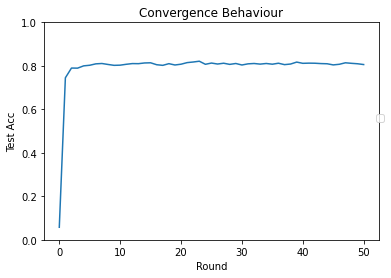

In [ ]:
plot_convergence_behaviour_from_centralized_evaluation(centralized_test_accs)

In [ ]:
ultimate_centralized_y_preds = centralized_y_preds[-1]

In [ ]:
print(report_classification_macro_averages(y_test, ultimate_centralized_y_preds))

              precision    recall  f1-score  
   macro avg       0.62      0.71      0.65     


### Centralized Evaluation with Data Sharing

In [ ]:
# Overrides to global experiment config
DATA_SHARING = True

In [ ]:
# Split client part of train set into NUMBER_OF_CLIENTS partitions.
partitioned_train_set = get_train_partitions(X_train, y_train.to_numpy())

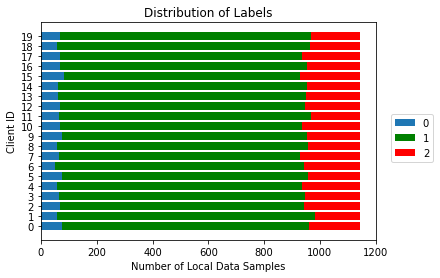

In [ ]:
plot_distribution_of_labels(partitioned_train_set)

In [ ]:
# Run sim with global config
sim_results = run_sim(partitioned_train_set)

INFO flower 2022-03-06 23:02:26,046 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-03-06 23:02:26,049 | server.py:128 | Initializing global parameters
INFO flower 2022-03-06 23:02:26,051 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 53293


INFO flower 2022-03-06 23:02:28,079 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:02:28,085 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:02:28,088 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-03-06 23:02:28,093 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-03-06 23:02:28,095 | server.py:130 | Evaluating initial parameters


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:02:28,194 | server.py:137 | initial parameters (loss, other metrics): 0.5651635249645155, {'accuracy': 0.7853973376361436}
INFO flower 2022-03-06 23:02:28,201 | server.py:143 | FL starting


initializing Client1 with pid 53352


INFO flower 2022-03-06 23:02:29,112 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:02:29,119 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:02:29,123 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 53382


INFO flower 2022-03-06 23:02:30,149 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:02:30,153 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:02:30,156 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-03-06 23:02:30,158 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 53416


INFO flower 2022-03-06 23:02:31,176 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:02:31,181 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:02:31,183 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-03-06 23:02:31,188 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 53452


INFO flower 2022-03-06 23:02:32,215 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:02:32,220 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:02:32,223 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 53488


INFO flower 2022-03-06 23:02:33,253 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:02:33,257 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:02:33,259 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-03-06 23:02:33,261 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 53528


INFO flower 2022-03-06 23:02:34,288 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:02:34,292 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:02:34,295 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 53568


INFO flower 2022-03-06 23:02:35,313 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:02:35,317 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:02:35,322 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 53612


INFO flower 2022-03-06 23:02:36,345 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:02:36,349 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:02:36,354 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 53656


INFO flower 2022-03-06 23:02:37,375 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:02:37,381 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:02:37,383 | connection.py:39 | ChannelConnectivity.READY


initializing Client10 with pid 53702


INFO flower 2022-03-06 23:02:38,405 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:02:38,411 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:02:38,414 | connection.py:39 | ChannelConnectivity.READY


initializing Client11 with pid 53750


INFO flower 2022-03-06 23:02:39,436 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:02:39,440 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:02:39,443 | connection.py:39 | ChannelConnectivity.READY


initializing Client12 with pid 53800


INFO flower 2022-03-06 23:02:40,467 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:02:40,471 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:02:40,473 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-03-06 23:02:40,475 | connection.py:39 | ChannelConnectivity.READY


initializing Client13 with pid 53854


INFO flower 2022-03-06 23:02:41,497 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:02:41,501 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:02:41,504 | connection.py:39 | ChannelConnectivity.READY


initializing Client14 with pid 53908


INFO flower 2022-03-06 23:02:42,536 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:02:42,539 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:02:42,543 | connection.py:39 | ChannelConnectivity.READY


initializing Client15 with pid 53964


INFO flower 2022-03-06 23:02:43,567 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:02:43,571 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:02:43,575 | connection.py:39 | ChannelConnectivity.READY


initializing Client16 with pid 54022


INFO flower 2022-03-06 23:02:44,599 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:02:44,604 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:02:44,608 | connection.py:39 | ChannelConnectivity.READY


initializing Client17 with pid 54082


INFO flower 2022-03-06 23:02:45,631 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:02:45,638 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:02:45,641 | connection.py:39 | ChannelConnectivity.READY


initializing Client18 with pid 54146


INFO flower 2022-03-06 23:02:46,670 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:02:46,675 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:02:46,677 | connection.py:39 | ChannelConnectivity.READY


initializing Client19 with pid 54210


INFO flower 2022-03-06 23:02:47,704 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:02:47,709 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:02:47,713 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-03-06 23:02:47,715 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client18 with pid 54146 is sampled in training rnd 1
Client2 with pid 53382 is sampled in training rnd 1
Client8 with pid 53612 is sampled in training rnd 1
Client3 with pid 53416 is sampled in training rnd 1
Client15 with pid 53964 is sampled in training rnd 1
Client12 with pid 53800 is sampled in training rnd 1
Client7 with pid 53568 is sampled in training rnd 1
Client13 with pid 53854 is sampled in training rnd 1
Client10 with pid 53702 is sampled in training rnd 1
Client6 with pid 53528 is sampled in training rnd 1
Client16 with pid 54022 is sampled in training rnd 1
Client1 with pid 53352 is sampled in training rnd 1
Client14 with pid 53908 is sampled in training rnd 1
Client0 with pid 53293 is sampled in training rnd 1


DEBUG flower 2022-03-06 23:02:49,089 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:02:49,206 | server.py:164 | fit progress: (1, 0.5758800229246256, {'accuracy': 0.7922549415086728}, 20.982587628997862)
INFO flower 2022-03-06 23:02:49,218 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:02:49,226 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client12 with pid 53800 is sampled in training rnd 2
Client13 with pid 53854 is sampled in training rnd 2
Client8 with pid 53612 is sampled in training rnd 2
Client14 with pid 53908 is sampled in training rnd 2
Client0 with pid 53293 is sampled in training rnd 2
Client11 with pid 53750 is sampled in training rnd 2
Client19 with pid 54210 is sampled in training rnd 2
Client3 with pid 53416 is sampled in training rnd 2
Client9 with pid 53656 is sampled in training rnd 2
Client1 with pid 53352 is sampled in training rnd 2
Client5 with pid 53488 is sampled in training rnd 2
Client17 with pid 54082 is sampled in training rnd 2
Client15 with pid 53964 is sampled in training rnd 2
Client7 with pid 53568 is sampled in training rnd 2


DEBUG flower 2022-03-06 23:02:50,607 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:02:50,725 | server.py:164 | fit progress: (2, 0.5546566569391072, {'accuracy': 0.8043565954013715}, 22.501430322998203)
INFO flower 2022-03-06 23:02:50,728 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:02:50,734 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client17 with pid 54082 is sampled in training rnd 3
Client0 with pid 53293 is sampled in training rnd 3
Client13 with pid 53854 is sampled in training rnd 3
Client11 with pid 53750 is sampled in training rnd 3
Client6 with pid 53528 is sampled in training rnd 3
Client18 with pid 54146 is sampled in training rnd 3
Client12 with pid 53800 is sampled in training rnd 3
Client8 with pid 53612 is sampled in training rnd 3
Client3 with pid 53416 is sampled in training rnd 3
Client7 with pid 53568 is sampled in training rnd 3
Client10 with pid 53702 is sampled in training rnd 3
Client19 with pid 54210 is sampled in training rnd 3
Client14 with pid 53908 is sampled in training rnd 3
Client2 with pid 53382 is sampled in training rnd 3


DEBUG flower 2022-03-06 23:02:52,157 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:02:52,294 | server.py:164 | fit progress: (3, 0.529744902306912, {'accuracy': 0.8075837031060912}, 24.070482741997694)
INFO flower 2022-03-06 23:02:52,301 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:02:52,311 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client7 with pid 53568 is sampled in training rnd 4
Client14 with pid 53908 is sampled in training rnd 4
Client13 with pid 53854 is sampled in training rnd 4
Client19 with pid 54210 is sampled in training rnd 4
Client9 with pid 53656 is sampled in training rnd 4
Client10 with pid 53702 is sampled in training rnd 4
Client6 with pid 53528 is sampled in training rnd 4
Client8 with pid 53612 is sampled in training rnd 4
Client0 with pid 53293 is sampled in training rnd 4
Client1 with pid 53352 is sampled in training rnd 4
Client2 with pid 53382 is sampled in training rnd 4
Client4 with pid 53452 is sampled in training rnd 4
Client11 with pid 53750 is sampled in training rnd 4
Client5 with pid 53488 is sampled in training rnd 4


DEBUG flower 2022-03-06 23:02:53,734 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:02:53,852 | server.py:164 | fit progress: (4, 0.5356874624023421, {'accuracy': 0.8108108108108109}, 25.62805396699696)
INFO flower 2022-03-06 23:02:53,857 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:02:53,860 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client10 with pid 53702 is sampled in training rnd 5
Client18 with pid 54146 is sampled in training rnd 5
Client16 with pid 54022 is sampled in training rnd 5
Client6 with pid 53528 is sampled in training rnd 5
Client13 with pid 53854 is sampled in training rnd 5
Client4 with pid 53452 is sampled in training rnd 5
Client14 with pid 53908 is sampled in training rnd 5
Client9 with pid 53656 is sampled in training rnd 5
Client7 with pid 53568 is sampled in training rnd 5
Client8 with pid 53612 is sampled in training rnd 5
Client0 with pid 53293 is sampled in training rnd 5
Client15 with pid 53964 is sampled in training rnd 5
Client1 with pid 53352 is sampled in training rnd 5
Client11 with pid 53750 is sampled in training rnd 5


DEBUG flower 2022-03-06 23:02:55,241 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:02:55,395 | server.py:164 | fit progress: (5, 0.5431724516052998, {'accuracy': 0.800322710770472}, 27.17203930600226)
INFO flower 2022-03-06 23:02:55,402 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:02:55,410 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client13 with pid 53854 is sampled in training rnd 6
Client12 with pid 53800 is sampled in training rnd 6
Client5 with pid 53488 is sampled in training rnd 6
Client11 with pid 53750 is sampled in training rnd 6
Client16 with pid 54022 is sampled in training rnd 6
Client7 with pid 53568 is sampled in training rnd 6
Client1 with pid 53352 is sampled in training rnd 6
Client10 with pid 53702 is sampled in training rnd 6
Client8 with pid 53612 is sampled in training rnd 6
Client14 with pid 53908 is sampled in training rnd 6
Client2 with pid 53382 is sampled in training rnd 6
Client15 with pid 53964 is sampled in training rnd 6
Client6 with pid 53528 is sampled in training rnd 6
Client9 with pid 53656 is sampled in training rnd 6


DEBUG flower 2022-03-06 23:02:56,840 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:02:56,983 | server.py:164 | fit progress: (6, 0.5377353968327203, {'accuracy': 0.8027430415490117}, 28.759370997999213)
INFO flower 2022-03-06 23:02:56,994 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:02:57,003 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client15 with pid 53964 is sampled in training rnd 7
Client19 with pid 54210 is sampled in training rnd 7
Client0 with pid 53293 is sampled in training rnd 7
Client1 with pid 53352 is sampled in training rnd 7
Client9 with pid 53656 is sampled in training rnd 7
Client11 with pid 53750 is sampled in training rnd 7
Client13 with pid 53854 is sampled in training rnd 7
Client17 with pid 54082 is sampled in training rnd 7
Client12 with pid 53800 is sampled in training rnd 7
Client6 with pid 53528 is sampled in training rnd 7
Client14 with pid 53908 is sampled in training rnd 7
Client2 with pid 53382 is sampled in training rnd 7
Client8 with pid 53612 is sampled in training rnd 7
Client4 with pid 53452 is sampled in training rnd 7


DEBUG flower 2022-03-06 23:02:58,488 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:02:58,606 | server.py:164 | fit progress: (7, 0.5188961904284822, {'accuracy': 0.809600645421541}, 30.38291536000179)
INFO flower 2022-03-06 23:02:58,610 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:02:58,616 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client7 with pid 53568 is sampled in training rnd 8
Client0 with pid 53293 is sampled in training rnd 8
Client6 with pid 53528 is sampled in training rnd 8
Client19 with pid 54210 is sampled in training rnd 8
Client8 with pid 53612 is sampled in training rnd 8
Client5 with pid 53488 is sampled in training rnd 8
Client9 with pid 53656 is sampled in training rnd 8
Client12 with pid 53800 is sampled in training rnd 8
Client13 with pid 53854 is sampled in training rnd 8
Client16 with pid 54022 is sampled in training rnd 8
Client4 with pid 53452 is sampled in training rnd 8
Client14 with pid 53908 is sampled in training rnd 8
Client18 with pid 54146 is sampled in training rnd 8
Client3 with pid 53416 is sampled in training rnd 8


DEBUG flower 2022-03-06 23:03:00,055 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:03:00,164 | server.py:164 | fit progress: (8, 0.5318467578464923, {'accuracy': 0.8043565954013715}, 31.94101875599881)
INFO flower 2022-03-06 23:03:00,170 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:03:00,176 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client16 with pid 54022 is sampled in training rnd 9
Client4 with pid 53452 is sampled in training rnd 9
Client19 with pid 54210 is sampled in training rnd 9
Client6 with pid 53528 is sampled in training rnd 9
Client13 with pid 53854 is sampled in training rnd 9
Client0 with pid 53293 is sampled in training rnd 9
Client5 with pid 53488 is sampled in training rnd 9
Client9 with pid 53656 is sampled in training rnd 9
Client7 with pid 53568 is sampled in training rnd 9
Client3 with pid 53416 is sampled in training rnd 9
Client17 with pid 54082 is sampled in training rnd 9
Client10 with pid 53702 is sampled in training rnd 9
Client8 with pid 53612 is sampled in training rnd 9
Client11 with pid 53750 is sampled in training rnd 9


DEBUG flower 2022-03-06 23:03:01,621 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:03:01,770 | server.py:164 | fit progress: (9, 0.5209827122348808, {'accuracy': 0.8116175877369908}, 33.54631790699932)
INFO flower 2022-03-06 23:03:01,776 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:03:01,783 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client11 with pid 53750 is sampled in training rnd 10
Client13 with pid 53854 is sampled in training rnd 10
Client19 with pid 54210 is sampled in training rnd 10
Client0 with pid 53293 is sampled in training rnd 10
Client10 with pid 53702 is sampled in training rnd 10
Client7 with pid 53568 is sampled in training rnd 10
Client9 with pid 53656 is sampled in training rnd 10
Client16 with pid 54022 is sampled in training rnd 10
Client3 with pid 53416 is sampled in training rnd 10
Client15 with pid 53964 is sampled in training rnd 10
Client2 with pid 53382 is sampled in training rnd 10
Client8 with pid 53612 is sampled in training rnd 10
Client18 with pid 54146 is sampled in training rnd 10
Client6 with pid 53528 is sampled in training rnd 10


DEBUG flower 2022-03-06 23:03:03,207 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:03:03,329 | server.py:164 | fit progress: (10, 0.5238546088488858, {'accuracy': 0.8087938684953611}, 35.10514698000043)
INFO flower 2022-03-06 23:03:03,335 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:03:03,340 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client2 with pid 53382 is sampled in training rnd 11
Client8 with pid 53612 is sampled in training rnd 11
Client19 with pid 54210 is sampled in training rnd 11
Client1 with pid 53352 is sampled in training rnd 11
Client16 with pid 54022 is sampled in training rnd 11
Client17 with pid 54082 is sampled in training rnd 11
Client13 with pid 53854 is sampled in training rnd 11
Client0 with pid 53293 is sampled in training rnd 11
Client7 with pid 53568 is sampled in training rnd 11
Client12 with pid 53800 is sampled in training rnd 11
Client4 with pid 53452 is sampled in training rnd 11
Client3 with pid 53416 is sampled in training rnd 11
Client9 with pid 53656 is sampled in training rnd 11
Client10 with pid 53702 is sampled in training rnd 11


DEBUG flower 2022-03-06 23:03:04,855 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:03:04,975 | server.py:164 | fit progress: (11, 0.523725628543282, {'accuracy': 0.8059701492537313}, 36.75200450899865)
INFO flower 2022-03-06 23:03:04,977 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:03:04,979 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client11 with pid 53750 is sampled in training rnd 12
Client5 with pid 53488 is sampled in training rnd 12
Client19 with pid 54210 is sampled in training rnd 12
Client2 with pid 53382 is sampled in training rnd 12
Client15 with pid 53964 is sampled in training rnd 12
Client14 with pid 53908 is sampled in training rnd 12
Client9 with pid 53656 is sampled in training rnd 12
Client4 with pid 53452 is sampled in training rnd 12
Client8 with pid 53612 is sampled in training rnd 12
Client12 with pid 53800 is sampled in training rnd 12
Client13 with pid 53854 is sampled in training rnd 12
Client16 with pid 54022 is sampled in training rnd 12
Client7 with pid 53568 is sampled in training rnd 12
Client18 with pid 54146 is sampled in training rnd 12


DEBUG flower 2022-03-06 23:03:06,348 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:03:06,476 | server.py:164 | fit progress: (12, 0.5322391574126861, {'accuracy': 0.8039532069382815}, 38.252869819996704)
INFO flower 2022-03-06 23:03:06,478 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:03:06,480 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client10 with pid 53702 is sampled in training rnd 13
Client18 with pid 54146 is sampled in training rnd 13
Client15 with pid 53964 is sampled in training rnd 13
Client3 with pid 53416 is sampled in training rnd 13
Client0 with pid 53293 is sampled in training rnd 13
Client6 with pid 53528 is sampled in training rnd 13
Client5 with pid 53488 is sampled in training rnd 13
Client4 with pid 53452 is sampled in training rnd 13
Client13 with pid 53854 is sampled in training rnd 13
Client16 with pid 54022 is sampled in training rnd 13
Client14 with pid 53908 is sampled in training rnd 13
Client1 with pid 53352 is sampled in training rnd 13
Client9 with pid 53656 is sampled in training rnd 13
Client12 with pid 53800 is sampled in training rnd 13


DEBUG flower 2022-03-06 23:03:07,889 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:03:08,047 | server.py:164 | fit progress: (13, 0.5247241930260892, {'accuracy': 0.8087938684953611}, 39.82401946400205)
INFO flower 2022-03-06 23:03:08,055 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:03:08,064 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client16 with pid 54022 is sampled in training rnd 14
Client13 with pid 53854 is sampled in training rnd 14
Client6 with pid 53528 is sampled in training rnd 14
Client0 with pid 53293 is sampled in training rnd 14
Client7 with pid 53568 is sampled in training rnd 14
Client19 with pid 54210 is sampled in training rnd 14
Client18 with pid 54146 is sampled in training rnd 14
Client2 with pid 53382 is sampled in training rnd 14
Client14 with pid 53908 is sampled in training rnd 14
Client12 with pid 53800 is sampled in training rnd 14
Client15 with pid 53964 is sampled in training rnd 14
Client8 with pid 53612 is sampled in training rnd 14
Client17 with pid 54082 is sampled in training rnd 14
Client4 with pid 53452 is sampled in training rnd 14


DEBUG flower 2022-03-06 23:03:09,448 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:03:09,571 | server.py:164 | fit progress: (14, 0.534932539717852, {'accuracy': 0.799919322307382}, 41.347056835998956)
INFO flower 2022-03-06 23:03:09,572 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:03:09,581 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client7 with pid 53568 is sampled in training rnd 15
Client16 with pid 54022 is sampled in training rnd 15
Client14 with pid 53908 is sampled in training rnd 15
Client0 with pid 53293 is sampled in training rnd 15
Client9 with pid 53656 is sampled in training rnd 15
Client10 with pid 53702 is sampled in training rnd 15
Client6 with pid 53528 is sampled in training rnd 15
Client19 with pid 54210 is sampled in training rnd 15
Client5 with pid 53488 is sampled in training rnd 15
Client13 with pid 53854 is sampled in training rnd 15
Client17 with pid 54082 is sampled in training rnd 15
Client15 with pid 53964 is sampled in training rnd 15
Client4 with pid 53452 is sampled in training rnd 15
Client1 with pid 53352 is sampled in training rnd 15


DEBUG flower 2022-03-06 23:03:11,042 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:03:11,179 | server.py:164 | fit progress: (15, 0.5290242614593166, {'accuracy': 0.8079870915691811}, 42.95562096199865)
INFO flower 2022-03-06 23:03:11,184 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:03:11,190 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client6 with pid 53528 is sampled in training rnd 16
Client1 with pid 53352 is sampled in training rnd 16
Client9 with pid 53656 is sampled in training rnd 16
Client2 with pid 53382 is sampled in training rnd 16
Client16 with pid 54022 is sampled in training rnd 16
Client4 with pid 53452 is sampled in training rnd 16
Client14 with pid 53908 is sampled in training rnd 16
Client11 with pid 53750 is sampled in training rnd 16
Client15 with pid 53964 is sampled in training rnd 16
Client17 with pid 54082 is sampled in training rnd 16
Client19 with pid 54210 is sampled in training rnd 16
Client13 with pid 53854 is sampled in training rnd 16
Client12 with pid 53800 is sampled in training rnd 16
Client0 with pid 53293 is sampled in training rnd 16


DEBUG flower 2022-03-06 23:03:12,615 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:03:12,759 | server.py:164 | fit progress: (16, 0.5268826495130114, {'accuracy': 0.8035498184751916}, 44.535183271997084)
INFO flower 2022-03-06 23:03:12,763 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:03:12,776 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client17 with pid 54082 is sampled in training rnd 17
Client1 with pid 53352 is sampled in training rnd 17
Client6 with pid 53528 is sampled in training rnd 17
Client14 with pid 53908 is sampled in training rnd 17
Client5 with pid 53488 is sampled in training rnd 17
Client13 with pid 53854 is sampled in training rnd 17
Client12 with pid 53800 is sampled in training rnd 17
Client16 with pid 54022 is sampled in training rnd 17
Client11 with pid 53750 is sampled in training rnd 17
Client9 with pid 53656 is sampled in training rnd 17
Client0 with pid 53293 is sampled in training rnd 17
Client8 with pid 53612 is sampled in training rnd 17
Client19 with pid 54210 is sampled in training rnd 17
Client18 with pid 54146 is sampled in training rnd 17


DEBUG flower 2022-03-06 23:03:14,155 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:03:14,281 | server.py:164 | fit progress: (17, 0.5306503162864293, {'accuracy': 0.8059701492537313}, 46.05779361700115)
INFO flower 2022-03-06 23:03:14,286 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:03:14,307 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client11 with pid 53750 is sampled in training rnd 18
Client3 with pid 53416 is sampled in training rnd 18
Client6 with pid 53528 is sampled in training rnd 18
Client13 with pid 53854 is sampled in training rnd 18
Client17 with pid 54082 is sampled in training rnd 18
Client7 with pid 53568 is sampled in training rnd 18
Client1 with pid 53352 is sampled in training rnd 18
Client10 with pid 53702 is sampled in training rnd 18
Client15 with pid 53964 is sampled in training rnd 18
Client4 with pid 53452 is sampled in training rnd 18
Client8 with pid 53612 is sampled in training rnd 18
Client14 with pid 53908 is sampled in training rnd 18
Client0 with pid 53293 is sampled in training rnd 18
Client2 with pid 53382 is sampled in training rnd 18


DEBUG flower 2022-03-06 23:03:15,685 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:03:15,823 | server.py:164 | fit progress: (18, 0.5214449892345059, {'accuracy': 0.8108108108108109}, 47.600041527999565)
INFO flower 2022-03-06 23:03:15,827 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:03:15,838 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client19 with pid 54210 is sampled in training rnd 19
Client12 with pid 53800 is sampled in training rnd 19
Client0 with pid 53293 is sampled in training rnd 19
Client9 with pid 53656 is sampled in training rnd 19
Client5 with pid 53488 is sampled in training rnd 19
Client3 with pid 53416 is sampled in training rnd 19
Client15 with pid 53964 is sampled in training rnd 19
Client13 with pid 53854 is sampled in training rnd 19
Client17 with pid 54082 is sampled in training rnd 19
Client2 with pid 53382 is sampled in training rnd 19
Client18 with pid 54146 is sampled in training rnd 19
Client6 with pid 53528 is sampled in training rnd 19
Client14 with pid 53908 is sampled in training rnd 19
Client10 with pid 53702 is sampled in training rnd 19


DEBUG flower 2022-03-06 23:03:17,211 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:03:17,338 | server.py:164 | fit progress: (19, 0.5364202420094749, {'accuracy': 0.8047599838644615}, 49.114696083001036)
INFO flower 2022-03-06 23:03:17,341 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:03:17,346 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client3 with pid 53416 is sampled in training rnd 20
Client12 with pid 53800 is sampled in training rnd 20
Client17 with pid 54082 is sampled in training rnd 20
Client11 with pid 53750 is sampled in training rnd 20
Client15 with pid 53964 is sampled in training rnd 20
Client18 with pid 54146 is sampled in training rnd 20
Client19 with pid 54210 is sampled in training rnd 20
Client8 with pid 53612 is sampled in training rnd 20
Client1 with pid 53352 is sampled in training rnd 20
Client0 with pid 53293 is sampled in training rnd 20
Client16 with pid 54022 is sampled in training rnd 20
Client2 with pid 53382 is sampled in training rnd 20
Client13 with pid 53854 is sampled in training rnd 20
Client9 with pid 53656 is sampled in training rnd 20


DEBUG flower 2022-03-06 23:03:18,794 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:03:18,924 | server.py:164 | fit progress: (20, 0.5307014220429488, {'accuracy': 0.8051633723275514}, 50.70069616100227)
INFO flower 2022-03-06 23:03:18,934 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:03:18,941 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client17 with pid 54082 is sampled in training rnd 21
Client6 with pid 53528 is sampled in training rnd 21
Client8 with pid 53612 is sampled in training rnd 21
Client19 with pid 54210 is sampled in training rnd 21
Client10 with pid 53702 is sampled in training rnd 21
Client5 with pid 53488 is sampled in training rnd 21
Client14 with pid 53908 is sampled in training rnd 21
Client13 with pid 53854 is sampled in training rnd 21
Client1 with pid 53352 is sampled in training rnd 21
Client4 with pid 53452 is sampled in training rnd 21
Client3 with pid 53416 is sampled in training rnd 21
Client7 with pid 53568 is sampled in training rnd 21
Client2 with pid 53382 is sampled in training rnd 21
Client16 with pid 54022 is sampled in training rnd 21


DEBUG flower 2022-03-06 23:03:20,352 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:03:20,484 | server.py:164 | fit progress: (21, 0.5098013229800814, {'accuracy': 0.8132311415893505}, 52.26018647899764)
INFO flower 2022-03-06 23:03:20,489 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:03:20,495 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client17 with pid 54082 is sampled in training rnd 22
Client3 with pid 53416 is sampled in training rnd 22
Client13 with pid 53854 is sampled in training rnd 22
Client16 with pid 54022 is sampled in training rnd 22
Client10 with pid 53702 is sampled in training rnd 22
Client1 with pid 53352 is sampled in training rnd 22
Client6 with pid 53528 is sampled in training rnd 22
Client12 with pid 53800 is sampled in training rnd 22
Client2 with pid 53382 is sampled in training rnd 22
Client11 with pid 53750 is sampled in training rnd 22
Client5 with pid 53488 is sampled in training rnd 22
Client14 with pid 53908 is sampled in training rnd 22
Client15 with pid 53964 is sampled in training rnd 22
Client0 with pid 53293 is sampled in training rnd 22


DEBUG flower 2022-03-06 23:03:21,896 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:03:22,009 | server.py:164 | fit progress: (22, 0.5186678413831752, {'accuracy': 0.8148446954417103}, 53.78526424399752)
INFO flower 2022-03-06 23:03:22,018 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:03:22,024 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client18 with pid 54146 is sampled in training rnd 23
Client17 with pid 54082 is sampled in training rnd 23
Client7 with pid 53568 is sampled in training rnd 23
Client8 with pid 53612 is sampled in training rnd 23
Client2 with pid 53382 is sampled in training rnd 23
Client5 with pid 53488 is sampled in training rnd 23
Client4 with pid 53452 is sampled in training rnd 23
Client15 with pid 53964 is sampled in training rnd 23
Client1 with pid 53352 is sampled in training rnd 23
Client9 with pid 53656 is sampled in training rnd 23
Client13 with pid 53854 is sampled in training rnd 23
Client19 with pid 54210 is sampled in training rnd 23
Client10 with pid 53702 is sampled in training rnd 23
Client6 with pid 53528 is sampled in training rnd 23


DEBUG flower 2022-03-06 23:03:23,450 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:03:23,559 | server.py:164 | fit progress: (23, 0.5331190708007342, {'accuracy': 0.8043565954013715}, 55.33560158999899)
INFO flower 2022-03-06 23:03:23,563 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:03:23,567 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client1 with pid 53352 is sampled in training rnd 24
Client9 with pid 53656 is sampled in training rnd 24
Client0 with pid 53293 is sampled in training rnd 24
Client17 with pid 54082 is sampled in training rnd 24
Client2 with pid 53382 is sampled in training rnd 24
Client6 with pid 53528 is sampled in training rnd 24
Client19 with pid 54210 is sampled in training rnd 24
Client12 with pid 53800 is sampled in training rnd 24
Client16 with pid 54022 is sampled in training rnd 24
Client3 with pid 53416 is sampled in training rnd 24
Client14 with pid 53908 is sampled in training rnd 24
Client10 with pid 53702 is sampled in training rnd 24
Client15 with pid 53964 is sampled in training rnd 24
Client11 with pid 53750 is sampled in training rnd 24


DEBUG flower 2022-03-06 23:03:24,992 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:03:25,115 | server.py:164 | fit progress: (24, 0.5218346074082667, {'accuracy': 0.809197256958451}, 56.891077574997325)
INFO flower 2022-03-06 23:03:25,120 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:03:25,124 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client14 with pid 53908 is sampled in training rnd 25
Client5 with pid 53488 is sampled in training rnd 25
Client7 with pid 53568 is sampled in training rnd 25
Client6 with pid 53528 is sampled in training rnd 25
Client19 with pid 54210 is sampled in training rnd 25
Client12 with pid 53800 is sampled in training rnd 25
Client18 with pid 54146 is sampled in training rnd 25
Client8 with pid 53612 is sampled in training rnd 25
Client3 with pid 53416 is sampled in training rnd 25
Client4 with pid 53452 is sampled in training rnd 25
Client11 with pid 53750 is sampled in training rnd 25
Client10 with pid 53702 is sampled in training rnd 25
Client17 with pid 54082 is sampled in training rnd 25
Client2 with pid 53382 is sampled in training rnd 25


DEBUG flower 2022-03-06 23:03:26,477 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:03:26,615 | server.py:164 | fit progress: (25, 0.5252926753501952, {'accuracy': 0.8100040338846309}, 58.39172907399916)
INFO flower 2022-03-06 23:03:26,617 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:03:26,628 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client3 with pid 53416 is sampled in training rnd 26
Client10 with pid 53702 is sampled in training rnd 26
Client1 with pid 53352 is sampled in training rnd 26
Client6 with pid 53528 is sampled in training rnd 26
Client0 with pid 53293 is sampled in training rnd 26
Client15 with pid 53964 is sampled in training rnd 26
Client12 with pid 53800 is sampled in training rnd 26
Client4 with pid 53452 is sampled in training rnd 26
Client11 with pid 53750 is sampled in training rnd 26
Client9 with pid 53656 is sampled in training rnd 26
Client5 with pid 53488 is sampled in training rnd 26
Client7 with pid 53568 is sampled in training rnd 26
Client18 with pid 54146 is sampled in training rnd 26
Client2 with pid 53382 is sampled in training rnd 26


DEBUG flower 2022-03-06 23:03:28,144 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:03:28,259 | server.py:164 | fit progress: (26, 0.5109820139176395, {'accuracy': 0.81847519160952}, 60.035622785995656)
INFO flower 2022-03-06 23:03:28,265 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:03:28,271 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client12 with pid 53800 is sampled in training rnd 27
Client10 with pid 53702 is sampled in training rnd 27
Client2 with pid 53382 is sampled in training rnd 27
Client14 with pid 53908 is sampled in training rnd 27
Client1 with pid 53352 is sampled in training rnd 27
Client18 with pid 54146 is sampled in training rnd 27
Client4 with pid 53452 is sampled in training rnd 27
Client3 with pid 53416 is sampled in training rnd 27
Client9 with pid 53656 is sampled in training rnd 27
Client7 with pid 53568 is sampled in training rnd 27
Client8 with pid 53612 is sampled in training rnd 27
Client13 with pid 53854 is sampled in training rnd 27
Client5 with pid 53488 is sampled in training rnd 27
Client15 with pid 53964 is sampled in training rnd 27


DEBUG flower 2022-03-06 23:03:29,622 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:03:29,749 | server.py:164 | fit progress: (27, 0.5276591802888783, {'accuracy': 0.8075837031060912}, 61.52592318200186)
INFO flower 2022-03-06 23:03:29,752 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:03:29,753 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client17 with pid 54082 is sampled in training rnd 28
Client6 with pid 53528 is sampled in training rnd 28
Client9 with pid 53656 is sampled in training rnd 28
Client18 with pid 54146 is sampled in training rnd 28
Client7 with pid 53568 is sampled in training rnd 28
Client5 with pid 53488 is sampled in training rnd 28
Client1 with pid 53352 is sampled in training rnd 28
Client15 with pid 53964 is sampled in training rnd 28
Client4 with pid 53452 is sampled in training rnd 28
Client11 with pid 53750 is sampled in training rnd 28
Client13 with pid 53854 is sampled in training rnd 28
Client14 with pid 53908 is sampled in training rnd 28
Client3 with pid 53416 is sampled in training rnd 28
Client10 with pid 53702 is sampled in training rnd 28


DEBUG flower 2022-03-06 23:03:31,200 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:03:31,331 | server.py:164 | fit progress: (28, 0.5269761783181373, {'accuracy': 0.8116175877369908}, 63.107949755001755)
INFO flower 2022-03-06 23:03:31,336 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:03:31,338 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client1 with pid 53352 is sampled in training rnd 29
Client9 with pid 53656 is sampled in training rnd 29
Client10 with pid 53702 is sampled in training rnd 29
Client5 with pid 53488 is sampled in training rnd 29
Client12 with pid 53800 is sampled in training rnd 29
Client13 with pid 53854 is sampled in training rnd 29
Client19 with pid 54210 is sampled in training rnd 29
Client17 with pid 54082 is sampled in training rnd 29
Client4 with pid 53452 is sampled in training rnd 29
Client16 with pid 54022 is sampled in training rnd 29
Client3 with pid 53416 is sampled in training rnd 29
Client18 with pid 54146 is sampled in training rnd 29
Client8 with pid 53612 is sampled in training rnd 29
Client7 with pid 53568 is sampled in training rnd 29


DEBUG flower 2022-03-06 23:03:32,676 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:03:32,816 | server.py:164 | fit progress: (29, 0.5225973952265143, {'accuracy': 0.8083904800322711}, 64.59257228999923)
INFO flower 2022-03-06 23:03:32,818 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:03:32,825 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client0 with pid 53293 is sampled in training rnd 30
Client19 with pid 54210 is sampled in training rnd 30
Client7 with pid 53568 is sampled in training rnd 30
Client12 with pid 53800 is sampled in training rnd 30
Client4 with pid 53452 is sampled in training rnd 30
Client1 with pid 53352 is sampled in training rnd 30
Client2 with pid 53382 is sampled in training rnd 30
Client8 with pid 53612 is sampled in training rnd 30
Client11 with pid 53750 is sampled in training rnd 30
Client16 with pid 54022 is sampled in training rnd 30
Client18 with pid 54146 is sampled in training rnd 30
Client9 with pid 53656 is sampled in training rnd 30
Client14 with pid 53908 is sampled in training rnd 30
Client6 with pid 53528 is sampled in training rnd 30


DEBUG flower 2022-03-06 23:03:34,236 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:03:34,359 | server.py:164 | fit progress: (30, 0.5218791620578476, {'accuracy': 0.8051633723275514}, 66.13514337899687)
INFO flower 2022-03-06 23:03:34,367 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:03:34,376 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client11 with pid 53750 is sampled in training rnd 31
Client15 with pid 53964 is sampled in training rnd 31
Client18 with pid 54146 is sampled in training rnd 31
Client4 with pid 53452 is sampled in training rnd 31
Client8 with pid 53612 is sampled in training rnd 31
Client3 with pid 53416 is sampled in training rnd 31
Client12 with pid 53800 is sampled in training rnd 31
Client13 with pid 53854 is sampled in training rnd 31
Client1 with pid 53352 is sampled in training rnd 31
Client5 with pid 53488 is sampled in training rnd 31
Client14 with pid 53908 is sampled in training rnd 31
Client2 with pid 53382 is sampled in training rnd 31
Client9 with pid 53656 is sampled in training rnd 31
Client6 with pid 53528 is sampled in training rnd 31


DEBUG flower 2022-03-06 23:03:35,747 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:03:35,870 | server.py:164 | fit progress: (31, 0.5214569386937659, {'accuracy': 0.8071803146430012}, 67.64661987900035)
INFO flower 2022-03-06 23:03:35,871 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:03:35,873 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client19 with pid 54210 is sampled in training rnd 32
Client4 with pid 53452 is sampled in training rnd 32
Client3 with pid 53416 is sampled in training rnd 32
Client10 with pid 53702 is sampled in training rnd 32
Client11 with pid 53750 is sampled in training rnd 32
Client9 with pid 53656 is sampled in training rnd 32
Client8 with pid 53612 is sampled in training rnd 32
Client16 with pid 54022 is sampled in training rnd 32
Client18 with pid 54146 is sampled in training rnd 32
Client2 with pid 53382 is sampled in training rnd 32
Client15 with pid 53964 is sampled in training rnd 32
Client17 with pid 54082 is sampled in training rnd 32
Client0 with pid 53293 is sampled in training rnd 32
Client6 with pid 53528 is sampled in training rnd 32


DEBUG flower 2022-03-06 23:03:37,339 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:03:37,446 | server.py:164 | fit progress: (32, 0.5194935931323931, {'accuracy': 0.8112141992739008}, 69.22205848900194)
INFO flower 2022-03-06 23:03:37,451 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:03:37,454 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client17 with pid 54082 is sampled in training rnd 33
Client10 with pid 53702 is sampled in training rnd 33
Client6 with pid 53528 is sampled in training rnd 33
Client5 with pid 53488 is sampled in training rnd 33
Client9 with pid 53656 is sampled in training rnd 33
Client18 with pid 54146 is sampled in training rnd 33
Client8 with pid 53612 is sampled in training rnd 33
Client2 with pid 53382 is sampled in training rnd 33
Client0 with pid 53293 is sampled in training rnd 33
Client19 with pid 54210 is sampled in training rnd 33
Client3 with pid 53416 is sampled in training rnd 33
Client1 with pid 53352 is sampled in training rnd 33
Client16 with pid 54022 is sampled in training rnd 33
Client4 with pid 53452 is sampled in training rnd 33


DEBUG flower 2022-03-06 23:03:38,963 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:03:39,113 | server.py:164 | fit progress: (33, 0.5235010003797022, {'accuracy': 0.8071803146430012}, 70.88971601099911)
INFO flower 2022-03-06 23:03:39,123 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:03:39,125 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client13 with pid 53854 is sampled in training rnd 34
Client14 with pid 53908 is sampled in training rnd 34
Client17 with pid 54082 is sampled in training rnd 34
Client19 with pid 54210 is sampled in training rnd 34
Client8 with pid 53612 is sampled in training rnd 34
Client16 with pid 54022 is sampled in training rnd 34
Client18 with pid 54146 is sampled in training rnd 34
Client7 with pid 53568 is sampled in training rnd 34
Client0 with pid 53293 is sampled in training rnd 34
Client6 with pid 53528 is sampled in training rnd 34
Client5 with pid 53488 is sampled in training rnd 34
Client2 with pid 53382 is sampled in training rnd 34
Client4 with pid 53452 is sampled in training rnd 34
Client3 with pid 53416 is sampled in training rnd 34


DEBUG flower 2022-03-06 23:03:40,454 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:03:40,590 | server.py:164 | fit progress: (34, 0.5278280910088707, {'accuracy': 0.8063735377168213}, 72.36664679199748)
INFO flower 2022-03-06 23:03:40,601 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:03:40,611 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client0 with pid 53293 is sampled in training rnd 35
Client13 with pid 53854 is sampled in training rnd 35
Client19 with pid 54210 is sampled in training rnd 35
Client1 with pid 53352 is sampled in training rnd 35
Client11 with pid 53750 is sampled in training rnd 35
Client2 with pid 53382 is sampled in training rnd 35
Client9 with pid 53656 is sampled in training rnd 35
Client14 with pid 53908 is sampled in training rnd 35
Client18 with pid 54146 is sampled in training rnd 35
Client15 with pid 53964 is sampled in training rnd 35
Client4 with pid 53452 is sampled in training rnd 35
Client12 with pid 53800 is sampled in training rnd 35
Client6 with pid 53528 is sampled in training rnd 35
Client8 with pid 53612 is sampled in training rnd 35


DEBUG flower 2022-03-06 23:03:42,051 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:03:42,196 | server.py:164 | fit progress: (35, 0.5255995020403889, {'accuracy': 0.8075837031060912}, 73.97268096100015)
INFO flower 2022-03-06 23:03:42,200 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:03:42,202 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client12 with pid 53800 is sampled in training rnd 36
Client7 with pid 53568 is sampled in training rnd 36
Client5 with pid 53488 is sampled in training rnd 36
Client0 with pid 53293 is sampled in training rnd 36
Client15 with pid 53964 is sampled in training rnd 36
Client17 with pid 54082 is sampled in training rnd 36
Client2 with pid 53382 is sampled in training rnd 36
Client8 with pid 53612 is sampled in training rnd 36
Client18 with pid 54146 is sampled in training rnd 36
Client19 with pid 54210 is sampled in training rnd 36
Client16 with pid 54022 is sampled in training rnd 36
Client3 with pid 53416 is sampled in training rnd 36
Client10 with pid 53702 is sampled in training rnd 36
Client13 with pid 53854 is sampled in training rnd 36


DEBUG flower 2022-03-06 23:03:43,609 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:03:43,733 | server.py:164 | fit progress: (36, 0.5210658271430052, {'accuracy': 0.8104074223477209}, 75.5097241830008)
INFO flower 2022-03-06 23:03:43,736 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:03:43,739 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client19 with pid 54210 is sampled in training rnd 37
Client7 with pid 53568 is sampled in training rnd 37
Client13 with pid 53854 is sampled in training rnd 37
Client15 with pid 53964 is sampled in training rnd 37
Client10 with pid 53702 is sampled in training rnd 37
Client8 with pid 53612 is sampled in training rnd 37
Client9 with pid 53656 is sampled in training rnd 37
Client11 with pid 53750 is sampled in training rnd 37
Client18 with pid 54146 is sampled in training rnd 37
Client4 with pid 53452 is sampled in training rnd 37
Client3 with pid 53416 is sampled in training rnd 37
Client0 with pid 53293 is sampled in training rnd 37
Client1 with pid 53352 is sampled in training rnd 37
Client6 with pid 53528 is sampled in training rnd 37


DEBUG flower 2022-03-06 23:03:45,125 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:03:45,266 | server.py:164 | fit progress: (37, 0.5205397406633945, {'accuracy': 0.809600645421541}, 77.04303753199929)
INFO flower 2022-03-06 23:03:45,278 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:03:45,281 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client11 with pid 53750 is sampled in training rnd 38
Client16 with pid 54022 is sampled in training rnd 38
Client19 with pid 54210 is sampled in training rnd 38
Client5 with pid 53488 is sampled in training rnd 38
Client6 with pid 53528 is sampled in training rnd 38
Client4 with pid 53452 is sampled in training rnd 38
Client14 with pid 53908 is sampled in training rnd 38
Client18 with pid 54146 is sampled in training rnd 38
Client13 with pid 53854 is sampled in training rnd 38
Client8 with pid 53612 is sampled in training rnd 38
Client17 with pid 54082 is sampled in training rnd 38
Client2 with pid 53382 is sampled in training rnd 38
Client7 with pid 53568 is sampled in training rnd 38
Client12 with pid 53800 is sampled in training rnd 38


DEBUG flower 2022-03-06 23:03:46,625 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:03:46,774 | server.py:164 | fit progress: (38, 0.5325651716054155, {'accuracy': 0.8051633723275514}, 78.5502246190008)
INFO flower 2022-03-06 23:03:46,784 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:03:46,794 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client2 with pid 53382 is sampled in training rnd 39
Client3 with pid 53416 is sampled in training rnd 39
Client16 with pid 54022 is sampled in training rnd 39
Client12 with pid 53800 is sampled in training rnd 39
Client4 with pid 53452 is sampled in training rnd 39
Client5 with pid 53488 is sampled in training rnd 39
Client19 with pid 54210 is sampled in training rnd 39
Client6 with pid 53528 is sampled in training rnd 39
Client18 with pid 54146 is sampled in training rnd 39
Client9 with pid 53656 is sampled in training rnd 39
Client0 with pid 53293 is sampled in training rnd 39
Client17 with pid 54082 is sampled in training rnd 39
Client7 with pid 53568 is sampled in training rnd 39
Client15 with pid 53964 is sampled in training rnd 39


DEBUG flower 2022-03-06 23:03:48,202 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:03:48,319 | server.py:164 | fit progress: (39, 0.5263973962629344, {'accuracy': 0.8083904800322711}, 80.09511074500188)
INFO flower 2022-03-06 23:03:48,331 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:03:48,334 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client5 with pid 53488 is sampled in training rnd 40
Client8 with pid 53612 is sampled in training rnd 40
Client11 with pid 53750 is sampled in training rnd 40
Client12 with pid 53800 is sampled in training rnd 40
Client16 with pid 54022 is sampled in training rnd 40
Client15 with pid 53964 is sampled in training rnd 40
Client4 with pid 53452 is sampled in training rnd 40
Client18 with pid 54146 is sampled in training rnd 40
Client13 with pid 53854 is sampled in training rnd 40
Client1 with pid 53352 is sampled in training rnd 40
Client10 with pid 53702 is sampled in training rnd 40
Client19 with pid 54210 is sampled in training rnd 40
Client9 with pid 53656 is sampled in training rnd 40
Client7 with pid 53568 is sampled in training rnd 40


DEBUG flower 2022-03-06 23:03:49,719 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:03:49,843 | server.py:164 | fit progress: (40, 0.5242763592122506, {'accuracy': 0.8079870915691811}, 81.619401431999)
INFO flower 2022-03-06 23:03:49,846 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:03:49,852 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client19 with pid 54210 is sampled in training rnd 41
Client14 with pid 53908 is sampled in training rnd 41
Client12 with pid 53800 is sampled in training rnd 41
Client7 with pid 53568 is sampled in training rnd 41
Client13 with pid 53854 is sampled in training rnd 41
Client2 with pid 53382 is sampled in training rnd 41
Client6 with pid 53528 is sampled in training rnd 41
Client15 with pid 53964 is sampled in training rnd 41
Client5 with pid 53488 is sampled in training rnd 41
Client16 with pid 54022 is sampled in training rnd 41
Client11 with pid 53750 is sampled in training rnd 41
Client9 with pid 53656 is sampled in training rnd 41
Client18 with pid 54146 is sampled in training rnd 41
Client1 with pid 53352 is sampled in training rnd 41


DEBUG flower 2022-03-06 23:03:51,190 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:03:51,313 | server.py:164 | fit progress: (41, 0.5372715795555769, {'accuracy': 0.8015328761597418}, 83.08907492899743)
INFO flower 2022-03-06 23:03:51,315 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:03:51,317 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client3 with pid 53416 is sampled in training rnd 42
Client17 with pid 54082 is sampled in training rnd 42
Client13 with pid 53854 is sampled in training rnd 42
Client10 with pid 53702 is sampled in training rnd 42
Client18 with pid 54146 is sampled in training rnd 42
Client19 with pid 54210 is sampled in training rnd 42
Client4 with pid 53452 is sampled in training rnd 42
Client16 with pid 54022 is sampled in training rnd 42
Client15 with pid 53964 is sampled in training rnd 42
Client6 with pid 53528 is sampled in training rnd 42
Client8 with pid 53612 is sampled in training rnd 42
Client0 with pid 53293 is sampled in training rnd 42
Client11 with pid 53750 is sampled in training rnd 42
Client12 with pid 53800 is sampled in training rnd 42


DEBUG flower 2022-03-06 23:03:52,768 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:03:52,904 | server.py:164 | fit progress: (42, 0.5253597846073704, {'accuracy': 0.8019362646228317}, 84.68008747400017)
INFO flower 2022-03-06 23:03:52,909 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:03:52,915 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client14 with pid 53908 is sampled in training rnd 43
Client18 with pid 54146 is sampled in training rnd 43
Client0 with pid 53293 is sampled in training rnd 43
Client17 with pid 54082 is sampled in training rnd 43
Client7 with pid 53568 is sampled in training rnd 43
Client13 with pid 53854 is sampled in training rnd 43
Client4 with pid 53452 is sampled in training rnd 43
Client3 with pid 53416 is sampled in training rnd 43
Client2 with pid 53382 is sampled in training rnd 43
Client11 with pid 53750 is sampled in training rnd 43
Client19 with pid 54210 is sampled in training rnd 43
Client8 with pid 53612 is sampled in training rnd 43
Client9 with pid 53656 is sampled in training rnd 43
Client12 with pid 53800 is sampled in training rnd 43


DEBUG flower 2022-03-06 23:03:54,326 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:03:54,441 | server.py:164 | fit progress: (43, 0.533162644188058, {'accuracy': 0.8039532069382815}, 86.21724956300022)
INFO flower 2022-03-06 23:03:54,450 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:03:54,457 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client9 with pid 53656 is sampled in training rnd 44
Client18 with pid 54146 is sampled in training rnd 44
Client8 with pid 53612 is sampled in training rnd 44
Client14 with pid 53908 is sampled in training rnd 44
Client17 with pid 54082 is sampled in training rnd 44
Client5 with pid 53488 is sampled in training rnd 44
Client15 with pid 53964 is sampled in training rnd 44
Client7 with pid 53568 is sampled in training rnd 44
Client6 with pid 53528 is sampled in training rnd 44
Client1 with pid 53352 is sampled in training rnd 44
Client3 with pid 53416 is sampled in training rnd 44
Client11 with pid 53750 is sampled in training rnd 44
Client19 with pid 54210 is sampled in training rnd 44
Client2 with pid 53382 is sampled in training rnd 44


DEBUG flower 2022-03-06 23:03:55,861 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:03:55,997 | server.py:164 | fit progress: (44, 0.5191595536940811, {'accuracy': 0.8152480839048003}, 87.77320239199616)
INFO flower 2022-03-06 23:03:56,007 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:03:56,010 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client3 with pid 53416 is sampled in training rnd 45
Client0 with pid 53293 is sampled in training rnd 45
Client19 with pid 54210 is sampled in training rnd 45
Client18 with pid 54146 is sampled in training rnd 45
Client10 with pid 53702 is sampled in training rnd 45
Client9 with pid 53656 is sampled in training rnd 45
Client12 with pid 53800 is sampled in training rnd 45
Client14 with pid 53908 is sampled in training rnd 45
Client11 with pid 53750 is sampled in training rnd 45
Client1 with pid 53352 is sampled in training rnd 45
Client8 with pid 53612 is sampled in training rnd 45
Client2 with pid 53382 is sampled in training rnd 45
Client5 with pid 53488 is sampled in training rnd 45
Client4 with pid 53452 is sampled in training rnd 45


DEBUG flower 2022-03-06 23:03:57,410 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:03:57,561 | server.py:164 | fit progress: (45, 0.513238915206708, {'accuracy': 0.8144413069786204}, 89.33717659399554)
INFO flower 2022-03-06 23:03:57,563 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:03:57,566 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client9 with pid 53656 is sampled in training rnd 46
Client13 with pid 53854 is sampled in training rnd 46
Client16 with pid 54022 is sampled in training rnd 46
Client0 with pid 53293 is sampled in training rnd 46
Client10 with pid 53702 is sampled in training rnd 46
Client1 with pid 53352 is sampled in training rnd 46
Client17 with pid 54082 is sampled in training rnd 46
Client11 with pid 53750 is sampled in training rnd 46
Client12 with pid 53800 is sampled in training rnd 46
Client7 with pid 53568 is sampled in training rnd 46
Client5 with pid 53488 is sampled in training rnd 46
Client4 with pid 53452 is sampled in training rnd 46
Client6 with pid 53528 is sampled in training rnd 46
Client2 with pid 53382 is sampled in training rnd 46


DEBUG flower 2022-03-06 23:03:58,903 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:03:59,043 | server.py:164 | fit progress: (46, 0.5269994024892913, {'accuracy': 0.8063735377168213}, 90.81926887499867)
INFO flower 2022-03-06 23:03:59,050 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:03:59,053 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client18 with pid 54146 is sampled in training rnd 47
Client15 with pid 53964 is sampled in training rnd 47
Client12 with pid 53800 is sampled in training rnd 47
Client16 with pid 54022 is sampled in training rnd 47
Client17 with pid 54082 is sampled in training rnd 47
Client3 with pid 53416 is sampled in training rnd 47
Client0 with pid 53293 is sampled in training rnd 47
Client8 with pid 53612 is sampled in training rnd 47
Client4 with pid 53452 is sampled in training rnd 47
Client10 with pid 53702 is sampled in training rnd 47
Client9 with pid 53656 is sampled in training rnd 47
Client13 with pid 53854 is sampled in training rnd 47
Client14 with pid 53908 is sampled in training rnd 47
Client7 with pid 53568 is sampled in training rnd 47


DEBUG flower 2022-03-06 23:04:00,509 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:04:00,636 | server.py:164 | fit progress: (47, 0.5304038820400457, {'accuracy': 0.8019362646228317}, 92.41215285399812)
INFO flower 2022-03-06 23:04:00,642 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:04:00,645 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client19 with pid 54210 is sampled in training rnd 48
Client16 with pid 54022 is sampled in training rnd 48
Client9 with pid 53656 is sampled in training rnd 48
Client13 with pid 53854 is sampled in training rnd 48
Client5 with pid 53488 is sampled in training rnd 48
Client18 with pid 54146 is sampled in training rnd 48
Client10 with pid 53702 is sampled in training rnd 48
Client7 with pid 53568 is sampled in training rnd 48
Client8 with pid 53612 is sampled in training rnd 48
Client3 with pid 53416 is sampled in training rnd 48
Client15 with pid 53964 is sampled in training rnd 48
Client0 with pid 53293 is sampled in training rnd 48
Client11 with pid 53750 is sampled in training rnd 48
Client17 with pid 54082 is sampled in training rnd 48


DEBUG flower 2022-03-06 23:04:02,201 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:04:02,330 | server.py:164 | fit progress: (48, 0.5205763417660175, {'accuracy': 0.8116175877369908}, 94.10669625599985)
INFO flower 2022-03-06 23:04:02,339 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:04:02,349 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client12 with pid 53800 is sampled in training rnd 49
Client13 with pid 53854 is sampled in training rnd 49
Client18 with pid 54146 is sampled in training rnd 49
Client19 with pid 54210 is sampled in training rnd 49
Client17 with pid 54082 is sampled in training rnd 49
Client9 with pid 53656 is sampled in training rnd 49
Client11 with pid 53750 is sampled in training rnd 49
Client10 with pid 53702 is sampled in training rnd 49
Client1 with pid 53352 is sampled in training rnd 49
Client7 with pid 53568 is sampled in training rnd 49
Client14 with pid 53908 is sampled in training rnd 49
Client3 with pid 53416 is sampled in training rnd 49
Client4 with pid 53452 is sampled in training rnd 49
Client5 with pid 53488 is sampled in training rnd 49


DEBUG flower 2022-03-06 23:04:03,753 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:04:03,957 | server.py:164 | fit progress: (49, 0.5188627220853274, {'accuracy': 0.8136345300524405}, 95.73357771200244)
INFO flower 2022-03-06 23:04:03,962 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:04:03,968 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client0 with pid 53293 is sampled in training rnd 50
Client8 with pid 53612 is sampled in training rnd 50
Client13 with pid 53854 is sampled in training rnd 50
Client12 with pid 53800 is sampled in training rnd 50
Client4 with pid 53452 is sampled in training rnd 50
Client1 with pid 53352 is sampled in training rnd 50
Client16 with pid 54022 is sampled in training rnd 50
Client2 with pid 53382 is sampled in training rnd 50
Client19 with pid 54210 is sampled in training rnd 50
Client9 with pid 53656 is sampled in training rnd 50
Client5 with pid 53488 is sampled in training rnd 50
Client18 with pid 54146 is sampled in training rnd 50
Client17 with pid 54082 is sampled in training rnd 50
Client6 with pid 53528 is sampled in training rnd 50


DEBUG flower 2022-03-06 23:04:05,413 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:04:05,560 | server.py:164 | fit progress: (50, 0.5281502825280677, {'accuracy': 0.8067769261799113}, 97.33672727199883)
INFO flower 2022-03-06 23:04:05,562 | server.py:209 | evaluate_round: no clients selected, cancel
INFO flower 2022-03-06 23:04:05,567 | server.py:182 | FL finished in 97.34332884600008
INFO flower 2022-03-06 23:04:05,571 | app.py:149 | app_fit: losses_distributed []
INFO flower 2022-03-06 23:04:05,573 | app.py:150 | app_fit: metrics_distributed {}
INFO flower 2022-03-06 23:04:05,583 | app.py:151 | app_fit: losses_centralized [(0, 0.5651635249645155), (1, 0.5758800229246256), (2, 0.5546566569391072), (3, 0.529744902306912), (4, 0.5356874624023421), (5, 0.5431724516052998), (6, 0.5377353968327203), (7, 0.5188961904284822), (8, 0.5318467578464923), (9, 0.5209827122348808), (10, 0.5238546088488858), (11, 0.523725628543282), (12, 0.5322391574126861), (13, 0.5247241930260892), (14, 0.534932539717852), (15, 0.5290242614593166), (16, 0.52688264951301

In [ ]:
centralized_y_preds = sim_results["centralized_y_preds"]
centralized_test_accs = sim_results["centralized_test_accs"]

No handles with labels found to put in legend.


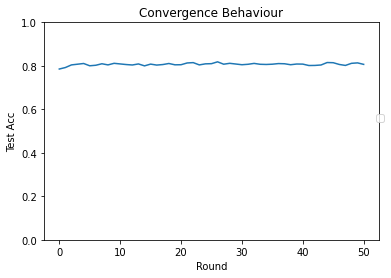

In [ ]:
plot_convergence_behaviour_from_centralized_evaluation(centralized_test_accs)

In [ ]:
ultimate_centralized_y_preds = centralized_y_preds[-1]

In [ ]:
print(report_classification_macro_averages(y_test, ultimate_centralized_y_preds))

              precision    recall  f1-score  
   macro avg       0.62      0.71      0.65     


### [Federated Evaluation](https://flower.dev/docs/evaluation.html) with Data Sharing

In [ ]:
# Overrides to global experiment config
EVAL_STRATEGY = "federated"

In [ ]:
# Split test set into NUMBER_OF_CLIENTS partitions.
partitioned_test_set = get_test_partitions(X_test, y_test.to_numpy())

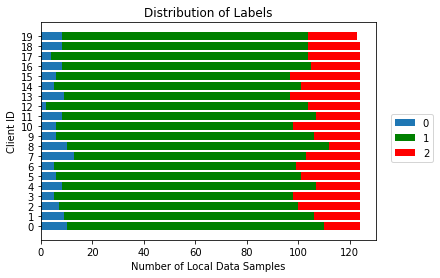

In [ ]:
plot_distribution_of_labels(partitioned_test_set)

In [ ]:
# Evaluate local models
local_models_y_preds = evaluate_local_models(partitioned_train_set, partitioned_test_set)

In [ ]:
local_models_y_test = [y_test_partition for X_test_partition, y_test_partition in partitioned_test_set]

In [ ]:
precision_recall_fscores_of_local_models = get_precision_recall_fscores_of_local_models(local_models_y_test, local_models_y_preds)

In [ ]:
avg_local_model_precision_recall_fscore = get_mean_precision_recall_fscores_of_local_models(precision_recall_fscores_of_local_models)

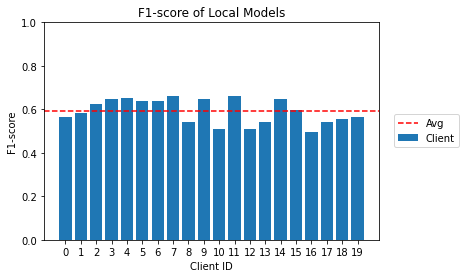

In [ ]:
plot_performance_of_local_models(precision_recall_fscores_of_local_models, avg_local_model_precision_recall_fscore)

In [ ]:
print_measures_of_dispersion(precision_recall_fscores_of_local_models)

Variance of F1-score across local models: 0.003050521506613092
Standard Deviation of F1-score across local models: 0.055231526383154504


In [ ]:
# Run sim with global config
sim_results = run_sim(partitioned_train_set, partitioned_test_set)

INFO flower 2022-03-06 23:14:31,822 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-03-06 23:14:31,826 | server.py:128 | Initializing global parameters
INFO flower 2022-03-06 23:14:31,828 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 65618


INFO flower 2022-03-06 23:14:33,854 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:14:33,858 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:14:33,861 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-03-06 23:14:33,866 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-03-06 23:14:33,868 | server.py:130 | Evaluating initial parameters
INFO flower 2022-03-06 23:14:33,870 | server.py:143 | FL starting


initializing Client1 with pid 65655


INFO flower 2022-03-06 23:14:34,889 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:14:34,895 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:14:34,897 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 65685


INFO flower 2022-03-06 23:14:35,916 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:14:35,919 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:14:35,923 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-03-06 23:14:35,925 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 65719


INFO flower 2022-03-06 23:14:36,947 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:14:36,952 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:14:36,954 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-03-06 23:14:36,957 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 65755


INFO flower 2022-03-06 23:14:37,983 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:14:37,987 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:14:37,991 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 65791


INFO flower 2022-03-06 23:14:39,021 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:14:39,025 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:14:39,027 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-03-06 23:14:39,031 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 65831


INFO flower 2022-03-06 23:14:40,050 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:14:40,054 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:14:40,059 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 65871


INFO flower 2022-03-06 23:14:41,082 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:14:41,086 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:14:41,089 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 65913


INFO flower 2022-03-06 23:14:42,111 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:14:42,115 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:14:42,118 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-03-06 23:14:42,120 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 65959


INFO flower 2022-03-06 23:14:43,145 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:14:43,149 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:14:43,152 | connection.py:39 | ChannelConnectivity.READY


initializing Client10 with pid 66005


INFO flower 2022-03-06 23:14:44,176 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:14:44,180 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:14:44,183 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-03-06 23:14:44,185 | connection.py:39 | ChannelConnectivity.READY


initializing Client11 with pid 66055


INFO flower 2022-03-06 23:14:45,214 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:14:45,218 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:14:45,223 | connection.py:39 | ChannelConnectivity.READY


initializing Client12 with pid 66107


INFO flower 2022-03-06 23:14:46,240 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:14:46,244 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:14:46,248 | connection.py:39 | ChannelConnectivity.READY


initializing Client13 with pid 66159


INFO flower 2022-03-06 23:14:47,271 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:14:47,276 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:14:47,278 | connection.py:39 | ChannelConnectivity.READY


initializing Client14 with pid 66213


INFO flower 2022-03-06 23:14:48,310 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:14:48,317 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:14:48,320 | connection.py:39 | ChannelConnectivity.READY


initializing Client15 with pid 66269


INFO flower 2022-03-06 23:14:49,343 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:14:49,347 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:14:49,350 | connection.py:39 | ChannelConnectivity.READY


initializing Client16 with pid 66327


INFO flower 2022-03-06 23:14:50,371 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:14:50,376 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:14:50,379 | connection.py:39 | ChannelConnectivity.READY


initializing Client17 with pid 66387


INFO flower 2022-03-06 23:14:51,406 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:14:51,410 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:14:51,414 | connection.py:39 | ChannelConnectivity.READY


initializing Client18 with pid 66449


INFO flower 2022-03-06 23:14:52,438 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:14:52,442 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:14:52,447 | connection.py:39 | ChannelConnectivity.READY


initializing Client19 with pid 66513


INFO flower 2022-03-06 23:14:53,473 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:14:53,477 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:14:53,480 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-03-06 23:14:53,481 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client18 with pid 66449 is sampled in training rnd 1
Client2 with pid 65685 is sampled in training rnd 1
Client8 with pid 65913 is sampled in training rnd 1
Client15 with pid 66269 is sampled in training rnd 1
Client3 with pid 65719 is sampled in training rnd 1
Client7 with pid 65871 is sampled in training rnd 1
Client10 with pid 66005 is sampled in training rnd 1
Client12 with pid 66107 is sampled in training rnd 1
Client13 with pid 66159 is sampled in training rnd 1
Client6 with pid 65831 is sampled in training rnd 1
Client16 with pid 66327 is sampled in training rnd 1
Client1 with pid 65655 is sampled in training rnd 1
Client14 with pid 66213 is sampled in training rnd 1
Client0 with pid 65618 is sampled in training rnd 1


DEBUG flower 2022-03-06 23:14:54,913 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:14:54,960 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client12 with pid 66107 is sampled in evaluation rnd 1
Client13 with pid 66159 is sampled in evaluation rnd 1
Client14 with pid 66213 is sampled in evaluation rnd 1
Client0 with pid 65618 is sampled in evaluation rnd 1
Client8 with pid 65913 is sampled in evaluation rnd 1
Client11 with pid 66055 is sampled in evaluation rnd 1
Client19 with pid 66513 is sampled in evaluation rnd 1
Client3 with pid 65719 is sampled in evaluation rnd 1
Client9 with pid 65959 is sampled in evaluation rnd 1
Client1 with pid 65655 is sampled in evaluation rnd 1
Client5 with pid 65791 is sampled in evaluation rnd 1
Client17 with pid 66387 is sampled in evaluation rnd 1
Client15 with pid 66269 is sampled in evaluation rnd 1
Client7 with pid 65871 is sampled in evaluation rnd 1
Client16 with pid 66327 is sampled in evaluation rnd 1
Client4 with pid 65755 is sampled in evaluation rnd 1
Client6 with pid 65831 is sampled in evaluation rnd 1
Client10 with pid 66005 is sampled in evaluation rnd 1
Client18 with pid 6

DEBUG flower 2022-03-06 23:14:55,062 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:14:55,064 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client0 with pid 65618 is sampled in training rnd 2
Client16 with pid 66327 is sampled in training rnd 2
Client7 with pid 65871 is sampled in training rnd 2
Client14 with pid 66213 is sampled in training rnd 2
Client8 with pid 65913 is sampled in training rnd 2
Client3 with pid 65719 is sampled in training rnd 2
Client15 with pid 66269 is sampled in training rnd 2
Client5 with pid 65791 is sampled in training rnd 2
Client13 with pid 66159 is sampled in training rnd 2
Client10 with pid 66005 is sampled in training rnd 2
Client11 with pid 66055 is sampled in training rnd 2
Client17 with pid 66387 is sampled in training rnd 2
Client4 with pid 65755 is sampled in training rnd 2
Client19 with pid 66513 is sampled in training rnd 2


DEBUG flower 2022-03-06 23:14:56,565 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:14:56,580 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client13 with pid 66159 is sampled in evaluation rnd 2
Client3 with pid 65719 is sampled in evaluation rnd 2
Client17 with pid 66387 is sampled in evaluation rnd 2
Client9 with pid 65959 is sampled in evaluation rnd 2
Client5 with pid 65791 is sampled in evaluation rnd 2
Client1 with pid 65655 is sampled in evaluation rnd 2
Client11 with pid 66055 is sampled in evaluation rnd 2
Client16 with pid 66327 is sampled in evaluation rnd 2
Client19 with pid 66513 is sampled in evaluation rnd 2
Client6 with pid 65831 is sampled in evaluation rnd 2
Client8 with pid 65913 is sampled in evaluation rnd 2
Client10 with pid 66005 is sampled in evaluation rnd 2
Client2 with pid 65685 is sampled in evaluation rnd 2
Client15 with pid 66269 is sampled in evaluation rnd 2
Client18 with pid 66449 is sampled in evaluation rnd 2
Client12 with pid 66107 is sampled in evaluation rnd 2
Client4 with pid 65755 is sampled in evaluation rnd 2
Client7 with pid 65871 is sampled in evaluation rnd 2
Client14 with pid 6

DEBUG flower 2022-03-06 23:14:56,688 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:14:56,690 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client15 with pid 66269 is sampled in training rnd 3
Client7 with pid 65871 is sampled in training rnd 3
Client12 with pid 66107 is sampled in training rnd 3
Client13 with pid 66159 is sampled in training rnd 3
Client5 with pid 65791 is sampled in training rnd 3
Client11 with pid 66055 is sampled in training rnd 3
Client8 with pid 65913 is sampled in training rnd 3
Client19 with pid 66513 is sampled in training rnd 3
Client10 with pid 66005 is sampled in training rnd 3
Client14 with pid 66213 is sampled in training rnd 3
Client1 with pid 65655 is sampled in training rnd 3
Client18 with pid 66449 is sampled in training rnd 3
Client9 with pid 65959 is sampled in training rnd 3
Client6 with pid 65831 is sampled in training rnd 3


DEBUG flower 2022-03-06 23:14:58,310 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:14:58,322 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client16 with pid 66327 is sampled in evaluation rnd 3
Client5 with pid 65791 is sampled in evaluation rnd 3
Client12 with pid 66107 is sampled in evaluation rnd 3
Client15 with pid 66269 is sampled in evaluation rnd 3
Client18 with pid 66449 is sampled in evaluation rnd 3
Client11 with pid 66055 is sampled in evaluation rnd 3
Client13 with pid 66159 is sampled in evaluation rnd 3
Client0 with pid 65618 is sampled in evaluation rnd 3
Client7 with pid 65871 is sampled in evaluation rnd 3
Client4 with pid 65755 is sampled in evaluation rnd 3
Client9 with pid 65959 is sampled in evaluation rnd 3
Client6 with pid 65831 is sampled in evaluation rnd 3
Client1 with pid 65655 is sampled in evaluation rnd 3
Client10 with pid 66005 is sampled in evaluation rnd 3
Client2 with pid 65685 is sampled in evaluation rnd 3
Client8 with pid 65913 is sampled in evaluation rnd 3
Client3 with pid 65719 is sampled in evaluation rnd 3
Client17 with pid 66387 is sampled in evaluation rnd 3
Client14 with pid 66

DEBUG flower 2022-03-06 23:14:58,427 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:14:58,429 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client11 with pid 66055 is sampled in training rnd 4
Client16 with pid 66327 is sampled in training rnd 4
Client18 with pid 66449 is sampled in training rnd 4
Client8 with pid 65913 is sampled in training rnd 4
Client15 with pid 66269 is sampled in training rnd 4
Client9 with pid 65959 is sampled in training rnd 4
Client10 with pid 66005 is sampled in training rnd 4
Client17 with pid 66387 is sampled in training rnd 4
Client14 with pid 66213 is sampled in training rnd 4
Client0 with pid 65618 is sampled in training rnd 4
Client6 with pid 65831 is sampled in training rnd 4
Client13 with pid 66159 is sampled in training rnd 4
Client2 with pid 65685 is sampled in training rnd 4
Client4 with pid 65755 is sampled in training rnd 4


DEBUG flower 2022-03-06 23:15:00,006 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:15:00,030 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client17 with pid 66387 is sampled in evaluation rnd 4
Client6 with pid 65831 is sampled in evaluation rnd 4
Client19 with pid 66513 is sampled in evaluation rnd 4
Client13 with pid 66159 is sampled in evaluation rnd 4
Client15 with pid 66269 is sampled in evaluation rnd 4
Client5 with pid 65791 is sampled in evaluation rnd 4
Client1 with pid 65655 is sampled in evaluation rnd 4
Client9 with pid 65959 is sampled in evaluation rnd 4
Client8 with pid 65913 is sampled in evaluation rnd 4
Client3 with pid 65719 is sampled in evaluation rnd 4
Client11 with pid 66055 is sampled in evaluation rnd 4
Client18 with pid 66449 is sampled in evaluation rnd 4
Client12 with pid 66107 is sampled in evaluation rnd 4
Client7 with pid 65871 is sampled in evaluation rnd 4
Client10 with pid 66005 is sampled in evaluation rnd 4
Client14 with pid 66213 is sampled in evaluation rnd 4
Client16 with pid 66327 is sampled in evaluation rnd 4
Client0 with pid 65618 is sampled in evaluation rnd 4
Client2 with pid 6

DEBUG flower 2022-03-06 23:15:00,126 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:15:00,128 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client19 with pid 66513 is sampled in training rnd 5
Client0 with pid 65618 is sampled in training rnd 5
Client7 with pid 65871 is sampled in training rnd 5
Client5 with pid 65791 is sampled in training rnd 5
Client16 with pid 66327 is sampled in training rnd 5
Client1 with pid 65655 is sampled in training rnd 5
Client12 with pid 66107 is sampled in training rnd 5
Client13 with pid 66159 is sampled in training rnd 5
Client4 with pid 65755 is sampled in training rnd 5
Client8 with pid 65913 is sampled in training rnd 5
Client14 with pid 66213 is sampled in training rnd 5
Client11 with pid 66055 is sampled in training rnd 5
Client18 with pid 66449 is sampled in training rnd 5
Client6 with pid 65831 is sampled in training rnd 5


DEBUG flower 2022-03-06 23:15:01,717 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:15:01,754 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client0 with pid 65618 is sampled in evaluation rnd 5
Client14 with pid 66213 is sampled in evaluation rnd 5
Client19 with pid 66513 is sampled in evaluation rnd 5
Client7 with pid 65871 is sampled in evaluation rnd 5
Client4 with pid 65755 is sampled in evaluation rnd 5
Client1 with pid 65655 is sampled in evaluation rnd 5
Client8 with pid 65913 is sampled in evaluation rnd 5
Client9 with pid 65959 is sampled in evaluation rnd 5
Client12 with pid 66107 is sampled in evaluation rnd 5
Client2 with pid 65685 is sampled in evaluation rnd 5
Client5 with pid 65791 is sampled in evaluation rnd 5
Client13 with pid 66159 is sampled in evaluation rnd 5
Client6 with pid 65831 is sampled in evaluation rnd 5
Client10 with pid 66005 is sampled in evaluation rnd 5
Client15 with pid 66269 is sampled in evaluation rnd 5
Client18 with pid 66449 is sampled in evaluation rnd 5
Client11 with pid 66055 is sampled in evaluation rnd 5
Client3 with pid 65719 is sampled in evaluation rnd 5
Client16 with pid 66

DEBUG flower 2022-03-06 23:15:01,889 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:15:01,891 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client10 with pid 66005 is sampled in training rnd 6
Client14 with pid 66213 is sampled in training rnd 6
Client15 with pid 66269 is sampled in training rnd 6
Client17 with pid 66387 is sampled in training rnd 6
Client3 with pid 65719 is sampled in training rnd 6
Client0 with pid 65618 is sampled in training rnd 6
Client6 with pid 65831 is sampled in training rnd 6
Client5 with pid 65791 is sampled in training rnd 6
Client4 with pid 65755 is sampled in training rnd 6
Client12 with pid 66107 is sampled in training rnd 6
Client16 with pid 66327 is sampled in training rnd 6
Client13 with pid 66159 is sampled in training rnd 6
Client1 with pid 65655 is sampled in training rnd 6
Client2 with pid 65685 is sampled in training rnd 6


DEBUG flower 2022-03-06 23:15:03,699 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:15:03,716 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client6 with pid 65831 is sampled in evaluation rnd 6
Client16 with pid 66327 is sampled in evaluation rnd 6
Client13 with pid 66159 is sampled in evaluation rnd 6
Client7 with pid 65871 is sampled in evaluation rnd 6
Client0 with pid 65618 is sampled in evaluation rnd 6
Client18 with pid 66449 is sampled in evaluation rnd 6
Client19 with pid 66513 is sampled in evaluation rnd 6
Client2 with pid 65685 is sampled in evaluation rnd 6
Client14 with pid 66213 is sampled in evaluation rnd 6
Client12 with pid 66107 is sampled in evaluation rnd 6
Client8 with pid 65913 is sampled in evaluation rnd 6
Client15 with pid 66269 is sampled in evaluation rnd 6
Client17 with pid 66387 is sampled in evaluation rnd 6
Client4 with pid 65755 is sampled in evaluation rnd 6
Client1 with pid 65655 is sampled in evaluation rnd 6
Client9 with pid 65959 is sampled in evaluation rnd 6
Client11 with pid 66055 is sampled in evaluation rnd 6
Client3 with pid 65719 is sampled in evaluation rnd 6
Client10 with pid 6

DEBUG flower 2022-03-06 23:15:03,836 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:15:03,838 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client18 with pid 66449 is sampled in training rnd 7
Client13 with pid 66159 is sampled in training rnd 7
Client10 with pid 66005 is sampled in training rnd 7
Client9 with pid 65959 is sampled in training rnd 7
Client2 with pid 65685 is sampled in training rnd 7
Client3 with pid 65719 is sampled in training rnd 7
Client0 with pid 65618 is sampled in training rnd 7
Client1 with pid 65655 is sampled in training rnd 7
Client4 with pid 65755 is sampled in training rnd 7
Client16 with pid 66327 is sampled in training rnd 7
Client19 with pid 66513 is sampled in training rnd 7
Client11 with pid 66055 is sampled in training rnd 7
Client8 with pid 65913 is sampled in training rnd 7
Client5 with pid 65791 is sampled in training rnd 7


DEBUG flower 2022-03-06 23:15:05,509 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:15:05,532 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client8 with pid 65913 is sampled in evaluation rnd 7
Client13 with pid 66159 is sampled in evaluation rnd 7
Client4 with pid 65755 is sampled in evaluation rnd 7
Client5 with pid 65791 is sampled in evaluation rnd 7
Client0 with pid 65618 is sampled in evaluation rnd 7
Client17 with pid 66387 is sampled in evaluation rnd 7
Client18 with pid 66449 is sampled in evaluation rnd 7
Client15 with pid 66269 is sampled in evaluation rnd 7
Client9 with pid 65959 is sampled in evaluation rnd 7
Client11 with pid 66055 is sampled in evaluation rnd 7
Client3 with pid 65719 is sampled in evaluation rnd 7
Client7 with pid 65871 is sampled in evaluation rnd 7
Client2 with pid 65685 is sampled in evaluation rnd 7
Client16 with pid 66327 is sampled in evaluation rnd 7
Client12 with pid 66107 is sampled in evaluation rnd 7
Client19 with pid 66513 is sampled in evaluation rnd 7
Client6 with pid 65831 is sampled in evaluation rnd 7
Client1 with pid 65655 is sampled in evaluation rnd 7
Client10 with pid 66

DEBUG flower 2022-03-06 23:15:05,633 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:15:05,634 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client3 with pid 65719 is sampled in training rnd 8
Client13 with pid 66159 is sampled in training rnd 8
Client6 with pid 65831 is sampled in training rnd 8
Client18 with pid 66449 is sampled in training rnd 8
Client1 with pid 65655 is sampled in training rnd 8
Client15 with pid 66269 is sampled in training rnd 8
Client10 with pid 66005 is sampled in training rnd 8
Client16 with pid 66327 is sampled in training rnd 8
Client4 with pid 65755 is sampled in training rnd 8
Client8 with pid 65913 is sampled in training rnd 8
Client7 with pid 65871 is sampled in training rnd 8
Client0 with pid 65618 is sampled in training rnd 8
Client5 with pid 65791 is sampled in training rnd 8
Client11 with pid 66055 is sampled in training rnd 8


DEBUG flower 2022-03-06 23:15:07,308 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:15:07,337 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client12 with pid 66107 is sampled in evaluation rnd 8
Client9 with pid 65959 is sampled in evaluation rnd 8
Client0 with pid 65618 is sampled in evaluation rnd 8
Client5 with pid 65791 is sampled in evaluation rnd 8
Client16 with pid 66327 is sampled in evaluation rnd 8
Client6 with pid 65831 is sampled in evaluation rnd 8
Client13 with pid 66159 is sampled in evaluation rnd 8
Client18 with pid 66449 is sampled in evaluation rnd 8
Client19 with pid 66513 is sampled in evaluation rnd 8
Client14 with pid 66213 is sampled in evaluation rnd 8
Client2 with pid 65685 is sampled in evaluation rnd 8
Client3 with pid 65719 is sampled in evaluation rnd 8
Client15 with pid 66269 is sampled in evaluation rnd 8
Client10 with pid 66005 is sampled in evaluation rnd 8
Client11 with pid 66055 is sampled in evaluation rnd 8
Client17 with pid 66387 is sampled in evaluation rnd 8
Client1 with pid 65655 is sampled in evaluation rnd 8
Client8 with pid 65913 is sampled in evaluation rnd 8
Client4 with pid 6

DEBUG flower 2022-03-06 23:15:07,439 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:15:07,441 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client17 with pid 66387 is sampled in training rnd 9
Client7 with pid 65871 is sampled in training rnd 9
Client2 with pid 65685 is sampled in training rnd 9
Client19 with pid 66513 is sampled in training rnd 9
Client1 with pid 65655 is sampled in training rnd 9
Client14 with pid 66213 is sampled in training rnd 9
Client15 with pid 66269 is sampled in training rnd 9
Client13 with pid 66159 is sampled in training rnd 9
Client3 with pid 65719 is sampled in training rnd 9
Client4 with pid 65755 is sampled in training rnd 9
Client8 with pid 65913 is sampled in training rnd 9
Client5 with pid 65791 is sampled in training rnd 9
Client9 with pid 65959 is sampled in training rnd 9
Client12 with pid 66107 is sampled in training rnd 9


DEBUG flower 2022-03-06 23:15:09,008 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:15:09,038 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client19 with pid 66513 is sampled in evaluation rnd 9
Client9 with pid 65959 is sampled in evaluation rnd 9
Client10 with pid 66005 is sampled in evaluation rnd 9
Client3 with pid 65719 is sampled in evaluation rnd 9
Client13 with pid 66159 is sampled in evaluation rnd 9
Client12 with pid 66107 is sampled in evaluation rnd 9
Client16 with pid 66327 is sampled in evaluation rnd 9
Client15 with pid 66269 is sampled in evaluation rnd 9
Client7 with pid 65871 is sampled in evaluation rnd 9
Client11 with pid 66055 is sampled in evaluation rnd 9
Client2 with pid 65685 is sampled in evaluation rnd 9
Client8 with pid 65913 is sampled in evaluation rnd 9
Client1 with pid 65655 is sampled in evaluation rnd 9
Client14 with pid 66213 is sampled in evaluation rnd 9
Client0 with pid 65618 is sampled in evaluation rnd 9
Client17 with pid 66387 is sampled in evaluation rnd 9
Client5 with pid 65791 is sampled in evaluation rnd 9
Client18 with pid 66449 is sampled in evaluation rnd 9
Client4 with pid 6

DEBUG flower 2022-03-06 23:15:09,131 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:15:09,135 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client3 with pid 65719 is sampled in training rnd 10
Client12 with pid 66107 is sampled in training rnd 10
Client2 with pid 65685 is sampled in training rnd 10
Client10 with pid 66005 is sampled in training rnd 10
Client1 with pid 65655 is sampled in training rnd 10
Client4 with pid 65755 is sampled in training rnd 10
Client7 with pid 65871 is sampled in training rnd 10
Client9 with pid 65959 is sampled in training rnd 10
Client5 with pid 65791 is sampled in training rnd 10
Client17 with pid 66387 is sampled in training rnd 10
Client14 with pid 66213 is sampled in training rnd 10
Client8 with pid 65913 is sampled in training rnd 10
Client13 with pid 66159 is sampled in training rnd 10
Client18 with pid 66449 is sampled in training rnd 10


DEBUG flower 2022-03-06 23:15:10,700 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:15:10,734 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client8 with pid 65913 is sampled in evaluation rnd 10
Client3 with pid 65719 is sampled in evaluation rnd 10
Client1 with pid 65655 is sampled in evaluation rnd 10
Client0 with pid 65618 is sampled in evaluation rnd 10
Client9 with pid 65959 is sampled in evaluation rnd 10
Client15 with pid 66269 is sampled in evaluation rnd 10
Client16 with pid 66327 is sampled in evaluation rnd 10
Client10 with pid 66005 is sampled in evaluation rnd 10
Client6 with pid 65831 is sampled in evaluation rnd 10
Client17 with pid 66387 is sampled in evaluation rnd 10
Client11 with pid 66055 is sampled in evaluation rnd 10
Client4 with pid 65755 is sampled in evaluation rnd 10
Client18 with pid 66449 is sampled in evaluation rnd 10
Client12 with pid 66107 is sampled in evaluation rnd 10
Client14 with pid 66213 is sampled in evaluation rnd 10
Client7 with pid 65871 is sampled in evaluation rnd 10
Client13 with pid 66159 is sampled in evaluation rnd 10
Client5 with pid 65791 is sampled in evaluation rnd 10
C

DEBUG flower 2022-03-06 23:15:10,833 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:15:10,836 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client7 with pid 65871 is sampled in training rnd 11
Client5 with pid 65791 is sampled in training rnd 11
Client3 with pid 65719 is sampled in training rnd 11
Client8 with pid 65913 is sampled in training rnd 11
Client12 with pid 66107 is sampled in training rnd 11
Client15 with pid 66269 is sampled in training rnd 11
Client13 with pid 66159 is sampled in training rnd 11
Client4 with pid 65755 is sampled in training rnd 11
Client16 with pid 66327 is sampled in training rnd 11
Client14 with pid 66213 is sampled in training rnd 11
Client19 with pid 66513 is sampled in training rnd 11
Client1 with pid 65655 is sampled in training rnd 11
Client18 with pid 66449 is sampled in training rnd 11
Client9 with pid 65959 is sampled in training rnd 11


DEBUG flower 2022-03-06 23:15:12,520 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:15:12,555 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client1 with pid 65655 is sampled in evaluation rnd 11
Client10 with pid 66005 is sampled in evaluation rnd 11
Client0 with pid 65618 is sampled in evaluation rnd 11
Client17 with pid 66387 is sampled in evaluation rnd 11
Client9 with pid 65959 is sampled in evaluation rnd 11
Client11 with pid 66055 is sampled in evaluation rnd 11
Client15 with pid 66269 is sampled in evaluation rnd 11
Client5 with pid 65791 is sampled in evaluation rnd 11
Client7 with pid 65871 is sampled in evaluation rnd 11
Client6 with pid 65831 is sampled in evaluation rnd 11
Client12 with pid 66107 is sampled in evaluation rnd 11
Client19 with pid 66513 is sampled in evaluation rnd 11
Client18 with pid 66449 is sampled in evaluation rnd 11
Client16 with pid 66327 is sampled in evaluation rnd 11
Client2 with pid 65685 is sampled in evaluation rnd 11
Client4 with pid 65755 is sampled in evaluation rnd 11
Client3 with pid 65719 is sampled in evaluation rnd 11
Client8 with pid 65913 is sampled in evaluation rnd 11
Cl

DEBUG flower 2022-03-06 23:15:12,664 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:15:12,666 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client17 with pid 66387 is sampled in training rnd 12
Client19 with pid 66513 is sampled in training rnd 12
Client15 with pid 66269 is sampled in training rnd 12
Client8 with pid 65913 is sampled in training rnd 12
Client11 with pid 66055 is sampled in training rnd 12
Client2 with pid 65685 is sampled in training rnd 12
Client3 with pid 65719 is sampled in training rnd 12
Client18 with pid 66449 is sampled in training rnd 12
Client4 with pid 65755 is sampled in training rnd 12
Client12 with pid 66107 is sampled in training rnd 12
Client10 with pid 66005 is sampled in training rnd 12
Client5 with pid 65791 is sampled in training rnd 12
Client1 with pid 65655 is sampled in training rnd 12
Client6 with pid 65831 is sampled in training rnd 12


DEBUG flower 2022-03-06 23:15:14,153 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:15:14,185 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client8 with pid 65913 is sampled in evaluation rnd 12
Client14 with pid 66213 is sampled in evaluation rnd 12
Client18 with pid 66449 is sampled in evaluation rnd 12
Client2 with pid 65685 is sampled in evaluation rnd 12
Client10 with pid 66005 is sampled in evaluation rnd 12
Client3 with pid 65719 is sampled in evaluation rnd 12
Client6 with pid 65831 is sampled in evaluation rnd 12
Client4 with pid 65755 is sampled in evaluation rnd 12
Client0 with pid 65618 is sampled in evaluation rnd 12
Client5 with pid 65791 is sampled in evaluation rnd 12
Client16 with pid 66327 is sampled in evaluation rnd 12
Client15 with pid 66269 is sampled in evaluation rnd 12
Client12 with pid 66107 is sampled in evaluation rnd 12
Client1 with pid 65655 is sampled in evaluation rnd 12
Client9 with pid 65959 is sampled in evaluation rnd 12
Client11 with pid 66055 is sampled in evaluation rnd 12
Client7 with pid 65871 is sampled in evaluation rnd 12
Client17 with pid 66387 is sampled in evaluation rnd 12
Cl

DEBUG flower 2022-03-06 23:15:14,308 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:15:14,310 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client7 with pid 65871 is sampled in training rnd 13
Client12 with pid 66107 is sampled in training rnd 13
Client8 with pid 65913 is sampled in training rnd 13
Client2 with pid 65685 is sampled in training rnd 13
Client11 with pid 66055 is sampled in training rnd 13
Client4 with pid 65755 is sampled in training rnd 13
Client17 with pid 66387 is sampled in training rnd 13
Client18 with pid 66449 is sampled in training rnd 13
Client0 with pid 65618 is sampled in training rnd 13
Client5 with pid 65791 is sampled in training rnd 13
Client1 with pid 65655 is sampled in training rnd 13
Client10 with pid 66005 is sampled in training rnd 13
Client19 with pid 66513 is sampled in training rnd 13
Client3 with pid 65719 is sampled in training rnd 13


DEBUG flower 2022-03-06 23:15:15,773 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:15:15,792 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client3 with pid 65719 is sampled in evaluation rnd 13
Client4 with pid 65755 is sampled in evaluation rnd 13
Client16 with pid 66327 is sampled in evaluation rnd 13
Client10 with pid 66005 is sampled in evaluation rnd 13
Client8 with pid 65913 is sampled in evaluation rnd 13
Client2 with pid 65685 is sampled in evaluation rnd 13
Client15 with pid 66269 is sampled in evaluation rnd 13
Client17 with pid 66387 is sampled in evaluation rnd 13
Client12 with pid 66107 is sampled in evaluation rnd 13
Client11 with pid 66055 is sampled in evaluation rnd 13
Client13 with pid 66159 is sampled in evaluation rnd 13
Client5 with pid 65791 is sampled in evaluation rnd 13
Client19 with pid 66513 is sampled in evaluation rnd 13
Client0 with pid 65618 is sampled in evaluation rnd 13
Client14 with pid 66213 is sampled in evaluation rnd 13
Client7 with pid 65871 is sampled in evaluation rnd 13
Client9 with pid 65959 is sampled in evaluation rnd 13
Client6 with pid 65831 is sampled in evaluation rnd 13
C

DEBUG flower 2022-03-06 23:15:15,903 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:15:15,906 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client17 with pid 66387 is sampled in training rnd 14
Client6 with pid 65831 is sampled in training rnd 14
Client10 with pid 66005 is sampled in training rnd 14
Client5 with pid 65791 is sampled in training rnd 14
Client1 with pid 65655 is sampled in training rnd 14
Client4 with pid 65755 is sampled in training rnd 14
Client8 with pid 65913 is sampled in training rnd 14
Client16 with pid 66327 is sampled in training rnd 14
Client2 with pid 65685 is sampled in training rnd 14
Client0 with pid 65618 is sampled in training rnd 14
Client3 with pid 65719 is sampled in training rnd 14
Client14 with pid 66213 is sampled in training rnd 14
Client18 with pid 66449 is sampled in training rnd 14
Client15 with pid 66269 is sampled in training rnd 14


DEBUG flower 2022-03-06 23:15:17,431 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:15:17,460 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client14 with pid 66213 is sampled in evaluation rnd 14
Client17 with pid 66387 is sampled in evaluation rnd 14
Client8 with pid 65913 is sampled in evaluation rnd 14
Client13 with pid 66159 is sampled in evaluation rnd 14
Client19 with pid 66513 is sampled in evaluation rnd 14
Client18 with pid 66449 is sampled in evaluation rnd 14
Client16 with pid 66327 is sampled in evaluation rnd 14
Client7 with pid 65871 is sampled in evaluation rnd 14
Client6 with pid 65831 is sampled in evaluation rnd 14
Client5 with pid 65791 is sampled in evaluation rnd 14
Client2 with pid 65685 is sampled in evaluation rnd 14
Client0 with pid 65618 is sampled in evaluation rnd 14
Client3 with pid 65719 is sampled in evaluation rnd 14
Client4 with pid 65755 is sampled in evaluation rnd 14
Client10 with pid 66005 is sampled in evaluation rnd 14
Client11 with pid 66055 is sampled in evaluation rnd 14
Client9 with pid 65959 is sampled in evaluation rnd 14
Client15 with pid 66269 is sampled in evaluation rnd 14
C

DEBUG flower 2022-03-06 23:15:17,565 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:15:17,567 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client18 with pid 66449 is sampled in training rnd 15
Client4 with pid 65755 is sampled in training rnd 15
Client19 with pid 66513 is sampled in training rnd 15
Client9 with pid 65959 is sampled in training rnd 15
Client6 with pid 65831 is sampled in training rnd 15
Client8 with pid 65913 is sampled in training rnd 15
Client16 with pid 66327 is sampled in training rnd 15
Client14 with pid 66213 is sampled in training rnd 15
Client2 with pid 65685 is sampled in training rnd 15
Client13 with pid 66159 is sampled in training rnd 15
Client1 with pid 65655 is sampled in training rnd 15
Client7 with pid 65871 is sampled in training rnd 15
Client3 with pid 65719 is sampled in training rnd 15
Client0 with pid 65618 is sampled in training rnd 15


DEBUG flower 2022-03-06 23:15:19,030 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:15:19,059 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client5 with pid 65791 is sampled in evaluation rnd 15
Client16 with pid 66327 is sampled in evaluation rnd 15
Client10 with pid 66005 is sampled in evaluation rnd 15
Client18 with pid 66449 is sampled in evaluation rnd 15
Client14 with pid 66213 is sampled in evaluation rnd 15
Client15 with pid 66269 is sampled in evaluation rnd 15
Client17 with pid 66387 is sampled in evaluation rnd 15
Client13 with pid 66159 is sampled in evaluation rnd 15
Client3 with pid 65719 is sampled in evaluation rnd 15
Client11 with pid 66055 is sampled in evaluation rnd 15
Client12 with pid 66107 is sampled in evaluation rnd 15
Client19 with pid 66513 is sampled in evaluation rnd 15
Client7 with pid 65871 is sampled in evaluation rnd 15
Client9 with pid 65959 is sampled in evaluation rnd 15
Client8 with pid 65913 is sampled in evaluation rnd 15
Client1 with pid 65655 is sampled in evaluation rnd 15
Client6 with pid 65831 is sampled in evaluation rnd 15
Client4 with pid 65755 is sampled in evaluation rnd 15


DEBUG flower 2022-03-06 23:15:19,170 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:15:19,172 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client1 with pid 65655 is sampled in training rnd 16
Client16 with pid 66327 is sampled in training rnd 16
Client2 with pid 65685 is sampled in training rnd 16
Client11 with pid 66055 is sampled in training rnd 16
Client5 with pid 65791 is sampled in training rnd 16
Client8 with pid 65913 is sampled in training rnd 16
Client12 with pid 66107 is sampled in training rnd 16
Client3 with pid 65719 is sampled in training rnd 16
Client13 with pid 66159 is sampled in training rnd 16
Client4 with pid 65755 is sampled in training rnd 16
Client10 with pid 66005 is sampled in training rnd 16
Client9 with pid 65959 is sampled in training rnd 16
Client15 with pid 66269 is sampled in training rnd 16
Client19 with pid 66513 is sampled in training rnd 16


DEBUG flower 2022-03-06 23:15:20,652 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:15:20,689 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client14 with pid 66213 is sampled in evaluation rnd 16
Client2 with pid 65685 is sampled in evaluation rnd 16
Client3 with pid 65719 is sampled in evaluation rnd 16
Client16 with pid 66327 is sampled in evaluation rnd 16
Client12 with pid 66107 is sampled in evaluation rnd 16
Client18 with pid 66449 is sampled in evaluation rnd 16
Client6 with pid 65831 is sampled in evaluation rnd 16
Client19 with pid 66513 is sampled in evaluation rnd 16
Client4 with pid 65755 is sampled in evaluation rnd 16
Client17 with pid 66387 is sampled in evaluation rnd 16
Client0 with pid 65618 is sampled in evaluation rnd 16
Client9 with pid 65959 is sampled in evaluation rnd 16
Client7 with pid 65871 is sampled in evaluation rnd 16
Client5 with pid 65791 is sampled in evaluation rnd 16
Client10 with pid 66005 is sampled in evaluation rnd 16
Client13 with pid 66159 is sampled in evaluation rnd 16
Client11 with pid 66055 is sampled in evaluation rnd 16
Client8 with pid 65913 is sampled in evaluation rnd 16
C

DEBUG flower 2022-03-06 23:15:20,802 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:15:20,804 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client16 with pid 66327 is sampled in training rnd 17
Client2 with pid 65685 is sampled in training rnd 17
Client8 with pid 65913 is sampled in training rnd 17
Client3 with pid 65719 is sampled in training rnd 17
Client17 with pid 66387 is sampled in training rnd 17
Client11 with pid 66055 is sampled in training rnd 17
Client1 with pid 65655 is sampled in training rnd 17
Client18 with pid 66449 is sampled in training rnd 17
Client9 with pid 65959 is sampled in training rnd 17
Client10 with pid 66005 is sampled in training rnd 17
Client13 with pid 66159 is sampled in training rnd 17
Client7 with pid 65871 is sampled in training rnd 17
Client19 with pid 66513 is sampled in training rnd 17
Client6 with pid 65831 is sampled in training rnd 17


DEBUG flower 2022-03-06 23:15:22,302 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:15:22,355 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client19 with pid 66513 is sampled in evaluation rnd 17
Client5 with pid 65791 is sampled in evaluation rnd 17
Client12 with pid 66107 is sampled in evaluation rnd 17
Client13 with pid 66159 is sampled in evaluation rnd 17
Client10 with pid 66005 is sampled in evaluation rnd 17
Client7 with pid 65871 is sampled in evaluation rnd 17
Client14 with pid 66213 is sampled in evaluation rnd 17
Client2 with pid 65685 is sampled in evaluation rnd 17
Client9 with pid 65959 is sampled in evaluation rnd 17
Client1 with pid 65655 is sampled in evaluation rnd 17
Client3 with pid 65719 is sampled in evaluation rnd 17
Client6 with pid 65831 is sampled in evaluation rnd 17
Client0 with pid 65618 is sampled in evaluation rnd 17
Client8 with pid 65913 is sampled in evaluation rnd 17
Client16 with pid 66327 is sampled in evaluation rnd 17
Client4 with pid 65755 is sampled in evaluation rnd 17
Client18 with pid 66449 is sampled in evaluation rnd 17
Client17 with pid 66387 is sampled in evaluation rnd 17
Cl

DEBUG flower 2022-03-06 23:15:22,453 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:15:22,455 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client16 with pid 66327 is sampled in training rnd 18
Client6 with pid 65831 is sampled in training rnd 18
Client18 with pid 66449 is sampled in training rnd 18
Client0 with pid 65618 is sampled in training rnd 18
Client14 with pid 66213 is sampled in training rnd 18
Client9 with pid 65959 is sampled in training rnd 18
Client10 with pid 66005 is sampled in training rnd 18
Client12 with pid 66107 is sampled in training rnd 18
Client4 with pid 65755 is sampled in training rnd 18
Client2 with pid 65685 is sampled in training rnd 18
Client3 with pid 65719 is sampled in training rnd 18
Client11 with pid 66055 is sampled in training rnd 18
Client13 with pid 66159 is sampled in training rnd 18
Client8 with pid 65913 is sampled in training rnd 18


DEBUG flower 2022-03-06 23:15:23,951 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:15:23,996 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client6 with pid 65831 is sampled in evaluation rnd 18
Client8 with pid 65913 is sampled in evaluation rnd 18
Client18 with pid 66449 is sampled in evaluation rnd 18
Client9 with pid 65959 is sampled in evaluation rnd 18
Client14 with pid 66213 is sampled in evaluation rnd 18
Client12 with pid 66107 is sampled in evaluation rnd 18
Client15 with pid 66269 is sampled in evaluation rnd 18
Client13 with pid 66159 is sampled in evaluation rnd 18
Client2 with pid 65685 is sampled in evaluation rnd 18
Client16 with pid 66327 is sampled in evaluation rnd 18
Client19 with pid 66513 is sampled in evaluation rnd 18
Client5 with pid 65791 is sampled in evaluation rnd 18
Client7 with pid 65871 is sampled in evaluation rnd 18
Client10 with pid 66005 is sampled in evaluation rnd 18
Client3 with pid 65719 is sampled in evaluation rnd 18
Client1 with pid 65655 is sampled in evaluation rnd 18
Client4 with pid 65755 is sampled in evaluation rnd 18
Client0 with pid 65618 is sampled in evaluation rnd 18
Cl

DEBUG flower 2022-03-06 23:15:24,098 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:15:24,100 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client19 with pid 66513 is sampled in training rnd 19
Client3 with pid 65719 is sampled in training rnd 19
Client0 with pid 65618 is sampled in training rnd 19
Client9 with pid 65959 is sampled in training rnd 19
Client4 with pid 65755 is sampled in training rnd 19
Client8 with pid 65913 is sampled in training rnd 19
Client5 with pid 65791 is sampled in training rnd 19
Client1 with pid 65655 is sampled in training rnd 19
Client16 with pid 66327 is sampled in training rnd 19
Client15 with pid 66269 is sampled in training rnd 19
Client6 with pid 65831 is sampled in training rnd 19
Client12 with pid 66107 is sampled in training rnd 19
Client11 with pid 66055 is sampled in training rnd 19
Client13 with pid 66159 is sampled in training rnd 19


DEBUG flower 2022-03-06 23:15:25,658 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:15:25,679 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client16 with pid 66327 is sampled in evaluation rnd 19
Client10 with pid 66005 is sampled in evaluation rnd 19
Client0 with pid 65618 is sampled in evaluation rnd 19
Client3 with pid 65719 is sampled in evaluation rnd 19
Client11 with pid 66055 is sampled in evaluation rnd 19
Client14 with pid 66213 is sampled in evaluation rnd 19
Client5 with pid 65791 is sampled in evaluation rnd 19
Client7 with pid 65871 is sampled in evaluation rnd 19
Client4 with pid 65755 is sampled in evaluation rnd 19
Client8 with pid 65913 is sampled in evaluation rnd 19
Client6 with pid 65831 is sampled in evaluation rnd 19
Client12 with pid 66107 is sampled in evaluation rnd 19
Client13 with pid 66159 is sampled in evaluation rnd 19
Client17 with pid 66387 is sampled in evaluation rnd 19
Client18 with pid 66449 is sampled in evaluation rnd 19
Client19 with pid 66513 is sampled in evaluation rnd 19
Client15 with pid 66269 is sampled in evaluation rnd 19
Client9 with pid 65959 is sampled in evaluation rnd 19


DEBUG flower 2022-03-06 23:15:25,797 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:15:25,799 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client16 with pid 66327 is sampled in training rnd 20
Client19 with pid 66513 is sampled in training rnd 20
Client14 with pid 66213 is sampled in training rnd 20
Client6 with pid 65831 is sampled in training rnd 20
Client11 with pid 66055 is sampled in training rnd 20
Client18 with pid 66449 is sampled in training rnd 20
Client13 with pid 66159 is sampled in training rnd 20
Client2 with pid 65685 is sampled in training rnd 20
Client15 with pid 66269 is sampled in training rnd 20
Client4 with pid 65755 is sampled in training rnd 20
Client7 with pid 65871 is sampled in training rnd 20
Client8 with pid 65913 is sampled in training rnd 20
Client3 with pid 65719 is sampled in training rnd 20
Client10 with pid 66005 is sampled in training rnd 20


DEBUG flower 2022-03-06 23:15:27,348 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:15:27,386 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client16 with pid 66327 is sampled in evaluation rnd 20
Client0 with pid 65618 is sampled in evaluation rnd 20
Client12 with pid 66107 is sampled in evaluation rnd 20
Client17 with pid 66387 is sampled in evaluation rnd 20
Client9 with pid 65959 is sampled in evaluation rnd 20
Client13 with pid 66159 is sampled in evaluation rnd 20
Client5 with pid 65791 is sampled in evaluation rnd 20
Client1 with pid 65655 is sampled in evaluation rnd 20
Client19 with pid 66513 is sampled in evaluation rnd 20
Client7 with pid 65871 is sampled in evaluation rnd 20
Client18 with pid 66449 is sampled in evaluation rnd 20
Client4 with pid 65755 is sampled in evaluation rnd 20
Client8 with pid 65913 is sampled in evaluation rnd 20
Client14 with pid 66213 is sampled in evaluation rnd 20
Client10 with pid 66005 is sampled in evaluation rnd 20
Client11 with pid 66055 is sampled in evaluation rnd 20
Client3 with pid 65719 is sampled in evaluation rnd 20
Client15 with pid 66269 is sampled in evaluation rnd 20


DEBUG flower 2022-03-06 23:15:27,479 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:15:27,481 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client5 with pid 65791 is sampled in training rnd 21
Client0 with pid 65618 is sampled in training rnd 21
Client2 with pid 65685 is sampled in training rnd 21
Client11 with pid 66055 is sampled in training rnd 21
Client12 with pid 66107 is sampled in training rnd 21
Client8 with pid 65913 is sampled in training rnd 21
Client6 with pid 65831 is sampled in training rnd 21
Client16 with pid 66327 is sampled in training rnd 21
Client10 with pid 66005 is sampled in training rnd 21
Client15 with pid 66269 is sampled in training rnd 21
Client4 with pid 65755 is sampled in training rnd 21
Client18 with pid 66449 is sampled in training rnd 21
Client7 with pid 65871 is sampled in training rnd 21
Client14 with pid 66213 is sampled in training rnd 21


DEBUG flower 2022-03-06 23:15:29,044 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:15:29,067 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client8 with pid 65913 is sampled in evaluation rnd 21
Client15 with pid 66269 is sampled in evaluation rnd 21
Client5 with pid 65791 is sampled in evaluation rnd 21
Client4 with pid 65755 is sampled in evaluation rnd 21
Client1 with pid 65655 is sampled in evaluation rnd 21
Client18 with pid 66449 is sampled in evaluation rnd 21
Client14 with pid 66213 is sampled in evaluation rnd 21
Client11 with pid 66055 is sampled in evaluation rnd 21
Client19 with pid 66513 is sampled in evaluation rnd 21
Client6 with pid 65831 is sampled in evaluation rnd 21
Client9 with pid 65959 is sampled in evaluation rnd 21
Client12 with pid 66107 is sampled in evaluation rnd 21
Client17 with pid 66387 is sampled in evaluation rnd 21
Client3 with pid 65719 is sampled in evaluation rnd 21
Client0 with pid 65618 is sampled in evaluation rnd 21
Client7 with pid 65871 is sampled in evaluation rnd 21
Client10 with pid 66005 is sampled in evaluation rnd 21
Client13 with pid 66159 is sampled in evaluation rnd 21
C

DEBUG flower 2022-03-06 23:15:29,166 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:15:29,168 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client12 with pid 66107 is sampled in training rnd 22
Client8 with pid 65913 is sampled in training rnd 22
Client9 with pid 65959 is sampled in training rnd 22
Client6 with pid 65831 is sampled in training rnd 22
Client16 with pid 66327 is sampled in training rnd 22
Client5 with pid 65791 is sampled in training rnd 22
Client3 with pid 65719 is sampled in training rnd 22
Client4 with pid 65755 is sampled in training rnd 22
Client1 with pid 65655 is sampled in training rnd 22
Client11 with pid 66055 is sampled in training rnd 22
Client18 with pid 66449 is sampled in training rnd 22
Client13 with pid 66159 is sampled in training rnd 22
Client7 with pid 65871 is sampled in training rnd 22
Client19 with pid 66513 is sampled in training rnd 22


DEBUG flower 2022-03-06 23:15:30,698 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:15:30,726 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client17 with pid 66387 is sampled in evaluation rnd 22
Client9 with pid 65959 is sampled in evaluation rnd 22
Client1 with pid 65655 is sampled in evaluation rnd 22
Client8 with pid 65913 is sampled in evaluation rnd 22
Client5 with pid 65791 is sampled in evaluation rnd 22
Client19 with pid 66513 is sampled in evaluation rnd 22
Client16 with pid 66327 is sampled in evaluation rnd 22
Client3 with pid 65719 is sampled in evaluation rnd 22
Client6 with pid 65831 is sampled in evaluation rnd 22
Client11 with pid 66055 is sampled in evaluation rnd 22
Client15 with pid 66269 is sampled in evaluation rnd 22
Client10 with pid 66005 is sampled in evaluation rnd 22
Client2 with pid 65685 is sampled in evaluation rnd 22
Client12 with pid 66107 is sampled in evaluation rnd 22
Client7 with pid 65871 is sampled in evaluation rnd 22
Client14 with pid 66213 is sampled in evaluation rnd 22
Client4 with pid 65755 is sampled in evaluation rnd 22
Client0 with pid 65618 is sampled in evaluation rnd 22
Cl

DEBUG flower 2022-03-06 23:15:30,836 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:15:30,838 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client19 with pid 66513 is sampled in training rnd 23
Client0 with pid 65618 is sampled in training rnd 23
Client7 with pid 65871 is sampled in training rnd 23
Client6 with pid 65831 is sampled in training rnd 23
Client10 with pid 66005 is sampled in training rnd 23
Client12 with pid 66107 is sampled in training rnd 23
Client16 with pid 66327 is sampled in training rnd 23
Client14 with pid 66213 is sampled in training rnd 23
Client3 with pid 65719 is sampled in training rnd 23
Client4 with pid 65755 is sampled in training rnd 23
Client11 with pid 66055 is sampled in training rnd 23
Client1 with pid 65655 is sampled in training rnd 23
Client2 with pid 65685 is sampled in training rnd 23
Client13 with pid 66159 is sampled in training rnd 23


DEBUG flower 2022-03-06 23:15:32,354 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:15:32,378 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client18 with pid 66449 is sampled in evaluation rnd 23
Client14 with pid 66213 is sampled in evaluation rnd 23
Client8 with pid 65913 is sampled in evaluation rnd 23
Client19 with pid 66513 is sampled in evaluation rnd 23
Client4 with pid 65755 is sampled in evaluation rnd 23
Client16 with pid 66327 is sampled in evaluation rnd 23
Client2 with pid 65685 is sampled in evaluation rnd 23
Client12 with pid 66107 is sampled in evaluation rnd 23
Client7 with pid 65871 is sampled in evaluation rnd 23
Client13 with pid 66159 is sampled in evaluation rnd 23
Client17 with pid 66387 is sampled in evaluation rnd 23
Client5 with pid 65791 is sampled in evaluation rnd 23
Client1 with pid 65655 is sampled in evaluation rnd 23
Client0 with pid 65618 is sampled in evaluation rnd 23
Client10 with pid 66005 is sampled in evaluation rnd 23
Client11 with pid 66055 is sampled in evaluation rnd 23
Client6 with pid 65831 is sampled in evaluation rnd 23
Client3 with pid 65719 is sampled in evaluation rnd 23
C

DEBUG flower 2022-03-06 23:15:32,496 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:15:32,498 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client12 with pid 66107 is sampled in training rnd 24
Client10 with pid 66005 is sampled in training rnd 24
Client3 with pid 65719 is sampled in training rnd 24
Client5 with pid 65791 is sampled in training rnd 24
Client14 with pid 66213 is sampled in training rnd 24
Client15 with pid 66269 is sampled in training rnd 24
Client13 with pid 66159 is sampled in training rnd 24
Client19 with pid 66513 is sampled in training rnd 24
Client0 with pid 65618 is sampled in training rnd 24
Client16 with pid 66327 is sampled in training rnd 24
Client9 with pid 65959 is sampled in training rnd 24
Client18 with pid 66449 is sampled in training rnd 24
Client7 with pid 65871 is sampled in training rnd 24
Client17 with pid 66387 is sampled in training rnd 24


DEBUG flower 2022-03-06 23:15:33,937 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:15:33,969 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client16 with pid 66327 is sampled in evaluation rnd 24
Client14 with pid 66213 is sampled in evaluation rnd 24
Client10 with pid 66005 is sampled in evaluation rnd 24
Client9 with pid 65959 is sampled in evaluation rnd 24
Client8 with pid 65913 is sampled in evaluation rnd 24
Client2 with pid 65685 is sampled in evaluation rnd 24
Client11 with pid 66055 is sampled in evaluation rnd 24
Client3 with pid 65719 is sampled in evaluation rnd 24
Client1 with pid 65655 is sampled in evaluation rnd 24
Client15 with pid 66269 is sampled in evaluation rnd 24
Client19 with pid 66513 is sampled in evaluation rnd 24
Client17 with pid 66387 is sampled in evaluation rnd 24
Client7 with pid 65871 is sampled in evaluation rnd 24
Client6 with pid 65831 is sampled in evaluation rnd 24
Client18 with pid 66449 is sampled in evaluation rnd 24
Client13 with pid 66159 is sampled in evaluation rnd 24
Client4 with pid 65755 is sampled in evaluation rnd 24
Client0 with pid 65618 is sampled in evaluation rnd 24
C

DEBUG flower 2022-03-06 23:15:34,089 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:15:34,091 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client17 with pid 66387 is sampled in training rnd 25
Client18 with pid 66449 is sampled in training rnd 25
Client12 with pid 66107 is sampled in training rnd 25
Client6 with pid 65831 is sampled in training rnd 25
Client11 with pid 66055 is sampled in training rnd 25
Client5 with pid 65791 is sampled in training rnd 25
Client4 with pid 65755 is sampled in training rnd 25
Client14 with pid 66213 is sampled in training rnd 25
Client7 with pid 65871 is sampled in training rnd 25
Client9 with pid 65959 is sampled in training rnd 25
Client1 with pid 65655 is sampled in training rnd 25
Client3 with pid 65719 is sampled in training rnd 25
Client10 with pid 66005 is sampled in training rnd 25
Client0 with pid 65618 is sampled in training rnd 25


DEBUG flower 2022-03-06 23:15:35,518 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:15:35,559 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client0 with pid 65618 is sampled in evaluation rnd 25
Client19 with pid 66513 is sampled in evaluation rnd 25
Client15 with pid 66269 is sampled in evaluation rnd 25
Client4 with pid 65755 is sampled in evaluation rnd 25
Client9 with pid 65959 is sampled in evaluation rnd 25
Client12 with pid 66107 is sampled in evaluation rnd 25
Client3 with pid 65719 is sampled in evaluation rnd 25
Client10 with pid 66005 is sampled in evaluation rnd 25
Client6 with pid 65831 is sampled in evaluation rnd 25
Client13 with pid 66159 is sampled in evaluation rnd 25
Client14 with pid 66213 is sampled in evaluation rnd 25
Client2 with pid 65685 is sampled in evaluation rnd 25
Client7 with pid 65871 is sampled in evaluation rnd 25
Client18 with pid 66449 is sampled in evaluation rnd 25
Client11 with pid 66055 is sampled in evaluation rnd 25
Client1 with pid 65655 is sampled in evaluation rnd 25
Client16 with pid 66327 is sampled in evaluation rnd 25
Client8 with pid 65913 is sampled in evaluation rnd 25
C

DEBUG flower 2022-03-06 23:15:35,668 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:15:35,670 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client2 with pid 65685 is sampled in training rnd 26
Client4 with pid 65755 is sampled in training rnd 26
Client0 with pid 65618 is sampled in training rnd 26
Client14 with pid 66213 is sampled in training rnd 26
Client9 with pid 65959 is sampled in training rnd 26
Client8 with pid 65913 is sampled in training rnd 26
Client15 with pid 66269 is sampled in training rnd 26
Client13 with pid 66159 is sampled in training rnd 26
Client17 with pid 66387 is sampled in training rnd 26
Client18 with pid 66449 is sampled in training rnd 26
Client12 with pid 66107 is sampled in training rnd 26
Client19 with pid 66513 is sampled in training rnd 26
Client3 with pid 65719 is sampled in training rnd 26
Client1 with pid 65655 is sampled in training rnd 26


DEBUG flower 2022-03-06 23:15:37,251 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:15:37,277 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client6 with pid 65831 is sampled in evaluation rnd 26
Client2 with pid 65685 is sampled in evaluation rnd 26
Client0 with pid 65618 is sampled in evaluation rnd 26
Client15 with pid 66269 is sampled in evaluation rnd 26
Client10 with pid 66005 is sampled in evaluation rnd 26
Client4 with pid 65755 is sampled in evaluation rnd 26
Client11 with pid 66055 is sampled in evaluation rnd 26
Client3 with pid 65719 is sampled in evaluation rnd 26
Client16 with pid 66327 is sampled in evaluation rnd 26
Client12 with pid 66107 is sampled in evaluation rnd 26
Client18 with pid 66449 is sampled in evaluation rnd 26
Client7 with pid 65871 is sampled in evaluation rnd 26
Client5 with pid 65791 is sampled in evaluation rnd 26
Client9 with pid 65959 is sampled in evaluation rnd 26
Client19 with pid 66513 is sampled in evaluation rnd 26
Client8 with pid 65913 is sampled in evaluation rnd 26
Client1 with pid 65655 is sampled in evaluation rnd 26
Client17 with pid 66387 is sampled in evaluation rnd 26
Cl

DEBUG flower 2022-03-06 23:15:37,383 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:15:37,385 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client11 with pid 66055 is sampled in training rnd 27
Client13 with pid 66159 is sampled in training rnd 27
Client17 with pid 66387 is sampled in training rnd 27
Client1 with pid 65655 is sampled in training rnd 27
Client16 with pid 66327 is sampled in training rnd 27
Client14 with pid 66213 is sampled in training rnd 27
Client5 with pid 65791 is sampled in training rnd 27
Client8 with pid 65913 is sampled in training rnd 27
Client6 with pid 65831 is sampled in training rnd 27
Client12 with pid 66107 is sampled in training rnd 27
Client3 with pid 65719 is sampled in training rnd 27
Client10 with pid 66005 is sampled in training rnd 27
Client19 with pid 66513 is sampled in training rnd 27
Client18 with pid 66449 is sampled in training rnd 27


DEBUG flower 2022-03-06 23:15:38,932 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:15:38,961 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client2 with pid 65685 is sampled in evaluation rnd 27
Client19 with pid 66513 is sampled in evaluation rnd 27
Client8 with pid 65913 is sampled in evaluation rnd 27
Client18 with pid 66449 is sampled in evaluation rnd 27
Client1 with pid 65655 is sampled in evaluation rnd 27
Client5 with pid 65791 is sampled in evaluation rnd 27
Client17 with pid 66387 is sampled in evaluation rnd 27
Client0 with pid 65618 is sampled in evaluation rnd 27
Client3 with pid 65719 is sampled in evaluation rnd 27
Client6 with pid 65831 is sampled in evaluation rnd 27
Client9 with pid 65959 is sampled in evaluation rnd 27
Client14 with pid 66213 is sampled in evaluation rnd 27
Client12 with pid 66107 is sampled in evaluation rnd 27
Client4 with pid 65755 is sampled in evaluation rnd 27
Client11 with pid 66055 is sampled in evaluation rnd 27
Client16 with pid 66327 is sampled in evaluation rnd 27
Client7 with pid 65871 is sampled in evaluation rnd 27
Client15 with pid 66269 is sampled in evaluation rnd 27
Cl

DEBUG flower 2022-03-06 23:15:39,079 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:15:39,082 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client17 with pid 66387 is sampled in training rnd 28
Client14 with pid 66213 is sampled in training rnd 28
Client1 with pid 65655 is sampled in training rnd 28
Client4 with pid 65755 is sampled in training rnd 28
Client16 with pid 66327 is sampled in training rnd 28
Client19 with pid 66513 is sampled in training rnd 28
Client6 with pid 65831 is sampled in training rnd 28
Client12 with pid 66107 is sampled in training rnd 28
Client7 with pid 65871 is sampled in training rnd 28
Client11 with pid 66055 is sampled in training rnd 28
Client0 with pid 65618 is sampled in training rnd 28
Client8 with pid 65913 is sampled in training rnd 28
Client15 with pid 66269 is sampled in training rnd 28
Client9 with pid 65959 is sampled in training rnd 28


DEBUG flower 2022-03-06 23:15:40,685 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:15:40,710 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client8 with pid 65913 is sampled in evaluation rnd 28
Client10 with pid 66005 is sampled in evaluation rnd 28
Client2 with pid 65685 is sampled in evaluation rnd 28
Client9 with pid 65959 is sampled in evaluation rnd 28
Client1 with pid 65655 is sampled in evaluation rnd 28
Client13 with pid 66159 is sampled in evaluation rnd 28
Client6 with pid 65831 is sampled in evaluation rnd 28
Client0 with pid 65618 is sampled in evaluation rnd 28
Client11 with pid 66055 is sampled in evaluation rnd 28
Client4 with pid 65755 is sampled in evaluation rnd 28
Client5 with pid 65791 is sampled in evaluation rnd 28
Client17 with pid 66387 is sampled in evaluation rnd 28
Client14 with pid 66213 is sampled in evaluation rnd 28
Client18 with pid 66449 is sampled in evaluation rnd 28
Client3 with pid 65719 is sampled in evaluation rnd 28
Client12 with pid 66107 is sampled in evaluation rnd 28
Client19 with pid 66513 is sampled in evaluation rnd 28
Client7 with pid 65871 is sampled in evaluation rnd 28
Cl

DEBUG flower 2022-03-06 23:15:40,868 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:15:40,876 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client17 with pid 66387 is sampled in training rnd 29
Client10 with pid 66005 is sampled in training rnd 29
Client16 with pid 66327 is sampled in training rnd 29
Client6 with pid 65831 is sampled in training rnd 29
Client19 with pid 66513 is sampled in training rnd 29
Client8 with pid 65913 is sampled in training rnd 29
Client12 with pid 66107 is sampled in training rnd 29
Client18 with pid 66449 is sampled in training rnd 29
Client9 with pid 65959 is sampled in training rnd 29
Client7 with pid 65871 is sampled in training rnd 29
Client1 with pid 65655 is sampled in training rnd 29
Client2 with pid 65685 is sampled in training rnd 29
Client15 with pid 66269 is sampled in training rnd 29
Client4 with pid 65755 is sampled in training rnd 29


DEBUG flower 2022-03-06 23:15:42,537 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:15:42,554 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client17 with pid 66387 is sampled in evaluation rnd 29
Client0 with pid 65618 is sampled in evaluation rnd 29
Client18 with pid 66449 is sampled in evaluation rnd 29
Client16 with pid 66327 is sampled in evaluation rnd 29
Client11 with pid 66055 is sampled in evaluation rnd 29
Client2 with pid 65685 is sampled in evaluation rnd 29
Client9 with pid 65959 is sampled in evaluation rnd 29
Client3 with pid 65719 is sampled in evaluation rnd 29
Client5 with pid 65791 is sampled in evaluation rnd 29
Client6 with pid 65831 is sampled in evaluation rnd 29
Client8 with pid 65913 is sampled in evaluation rnd 29
Client14 with pid 66213 is sampled in evaluation rnd 29
Client1 with pid 65655 is sampled in evaluation rnd 29
Client13 with pid 66159 is sampled in evaluation rnd 29
Client12 with pid 66107 is sampled in evaluation rnd 29
Client19 with pid 66513 is sampled in evaluation rnd 29
Client7 with pid 65871 is sampled in evaluation rnd 29
Client10 with pid 66005 is sampled in evaluation rnd 29
C

DEBUG flower 2022-03-06 23:15:42,669 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:15:42,671 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client13 with pid 66159 is sampled in training rnd 30
Client9 with pid 65959 is sampled in training rnd 30
Client11 with pid 66055 is sampled in training rnd 30
Client8 with pid 65913 is sampled in training rnd 30
Client10 with pid 66005 is sampled in training rnd 30
Client16 with pid 66327 is sampled in training rnd 30
Client19 with pid 66513 is sampled in training rnd 30
Client5 with pid 65791 is sampled in training rnd 30
Client15 with pid 66269 is sampled in training rnd 30
Client12 with pid 66107 is sampled in training rnd 30
Client0 with pid 65618 is sampled in training rnd 30
Client17 with pid 66387 is sampled in training rnd 30
Client1 with pid 65655 is sampled in training rnd 30
Client7 with pid 65871 is sampled in training rnd 30


DEBUG flower 2022-03-06 23:15:44,221 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:15:44,250 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client18 with pid 66449 is sampled in evaluation rnd 30
Client19 with pid 66513 is sampled in evaluation rnd 30
Client10 with pid 66005 is sampled in evaluation rnd 30
Client2 with pid 65685 is sampled in evaluation rnd 30
Client14 with pid 66213 is sampled in evaluation rnd 30
Client4 with pid 65755 is sampled in evaluation rnd 30
Client7 with pid 65871 is sampled in evaluation rnd 30
Client13 with pid 66159 is sampled in evaluation rnd 30
Client5 with pid 65791 is sampled in evaluation rnd 30
Client6 with pid 65831 is sampled in evaluation rnd 30
Client1 with pid 65655 is sampled in evaluation rnd 30
Client16 with pid 66327 is sampled in evaluation rnd 30
Client0 with pid 65618 is sampled in evaluation rnd 30
Client8 with pid 65913 is sampled in evaluation rnd 30
Client15 with pid 66269 is sampled in evaluation rnd 30
Client3 with pid 65719 is sampled in evaluation rnd 30
Client17 with pid 66387 is sampled in evaluation rnd 30
Client12 with pid 66107 is sampled in evaluation rnd 30
C

DEBUG flower 2022-03-06 23:15:44,371 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:15:44,373 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client11 with pid 66055 is sampled in training rnd 31
Client12 with pid 66107 is sampled in training rnd 31
Client14 with pid 66213 is sampled in training rnd 31
Client8 with pid 65913 is sampled in training rnd 31
Client9 with pid 65959 is sampled in training rnd 31
Client10 with pid 66005 is sampled in training rnd 31
Client16 with pid 66327 is sampled in training rnd 31
Client2 with pid 65685 is sampled in training rnd 31
Client0 with pid 65618 is sampled in training rnd 31
Client18 with pid 66449 is sampled in training rnd 31
Client4 with pid 65755 is sampled in training rnd 31
Client3 with pid 65719 is sampled in training rnd 31
Client15 with pid 66269 is sampled in training rnd 31
Client19 with pid 66513 is sampled in training rnd 31


DEBUG flower 2022-03-06 23:15:45,942 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:15:45,977 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client5 with pid 65791 is sampled in evaluation rnd 31
Client1 with pid 65655 is sampled in evaluation rnd 31
Client13 with pid 66159 is sampled in evaluation rnd 31
Client3 with pid 65719 is sampled in evaluation rnd 31
Client8 with pid 65913 is sampled in evaluation rnd 31
Client11 with pid 66055 is sampled in evaluation rnd 31
Client17 with pid 66387 is sampled in evaluation rnd 31
Client16 with pid 66327 is sampled in evaluation rnd 31
Client18 with pid 66449 is sampled in evaluation rnd 31
Client4 with pid 65755 is sampled in evaluation rnd 31
Client9 with pid 65959 is sampled in evaluation rnd 31
Client10 with pid 66005 is sampled in evaluation rnd 31
Client15 with pid 66269 is sampled in evaluation rnd 31
Client6 with pid 65831 is sampled in evaluation rnd 31
Client7 with pid 65871 is sampled in evaluation rnd 31
Client14 with pid 66213 is sampled in evaluation rnd 31
Client0 with pid 65618 is sampled in evaluation rnd 31
Client2 with pid 65685 is sampled in evaluation rnd 31
Cl

DEBUG flower 2022-03-06 23:15:46,076 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:15:46,077 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client18 with pid 66449 is sampled in training rnd 32
Client15 with pid 66269 is sampled in training rnd 32
Client16 with pid 66327 is sampled in training rnd 32
Client11 with pid 66055 is sampled in training rnd 32
Client14 with pid 66213 is sampled in training rnd 32
Client9 with pid 65959 is sampled in training rnd 32
Client6 with pid 65831 is sampled in training rnd 32
Client13 with pid 66159 is sampled in training rnd 32
Client3 with pid 65719 is sampled in training rnd 32
Client17 with pid 66387 is sampled in training rnd 32
Client7 with pid 65871 is sampled in training rnd 32
Client5 with pid 65791 is sampled in training rnd 32
Client19 with pid 66513 is sampled in training rnd 32
Client4 with pid 65755 is sampled in training rnd 32


DEBUG flower 2022-03-06 23:15:47,727 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:15:47,758 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client6 with pid 65831 is sampled in evaluation rnd 32
Client15 with pid 66269 is sampled in evaluation rnd 32
Client2 with pid 65685 is sampled in evaluation rnd 32
Client8 with pid 65913 is sampled in evaluation rnd 32
Client3 with pid 65719 is sampled in evaluation rnd 32
Client13 with pid 66159 is sampled in evaluation rnd 32
Client11 with pid 66055 is sampled in evaluation rnd 32
Client0 with pid 65618 is sampled in evaluation rnd 32
Client16 with pid 66327 is sampled in evaluation rnd 32
Client19 with pid 66513 is sampled in evaluation rnd 32
Client12 with pid 66107 is sampled in evaluation rnd 32
Client1 with pid 65655 is sampled in evaluation rnd 32
Client7 with pid 65871 is sampled in evaluation rnd 32
Client4 with pid 65755 is sampled in evaluation rnd 32
Client5 with pid 65791 is sampled in evaluation rnd 32
Client14 with pid 66213 is sampled in evaluation rnd 32
Client18 with pid 66449 is sampled in evaluation rnd 32
Client10 with pid 66005 is sampled in evaluation rnd 32
C

DEBUG flower 2022-03-06 23:15:47,893 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:15:47,895 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client6 with pid 65831 is sampled in training rnd 33
Client0 with pid 65618 is sampled in training rnd 33
Client19 with pid 66513 is sampled in training rnd 33
Client9 with pid 65959 is sampled in training rnd 33
Client13 with pid 66159 is sampled in training rnd 33
Client4 with pid 65755 is sampled in training rnd 33
Client8 with pid 65913 is sampled in training rnd 33
Client5 with pid 65791 is sampled in training rnd 33
Client11 with pid 66055 is sampled in training rnd 33
Client12 with pid 66107 is sampled in training rnd 33
Client3 with pid 65719 is sampled in training rnd 33
Client17 with pid 66387 is sampled in training rnd 33
Client14 with pid 66213 is sampled in training rnd 33
Client7 with pid 65871 is sampled in training rnd 33


DEBUG flower 2022-03-06 23:15:49,740 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:15:49,773 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client13 with pid 66159 is sampled in evaluation rnd 33
Client17 with pid 66387 is sampled in evaluation rnd 33
Client16 with pid 66327 is sampled in evaluation rnd 33
Client19 with pid 66513 is sampled in evaluation rnd 33
Client7 with pid 65871 is sampled in evaluation rnd 33
Client9 with pid 65959 is sampled in evaluation rnd 33
Client2 with pid 65685 is sampled in evaluation rnd 33
Client4 with pid 65755 is sampled in evaluation rnd 33
Client8 with pid 65913 is sampled in evaluation rnd 33
Client14 with pid 66213 is sampled in evaluation rnd 33
Client15 with pid 66269 is sampled in evaluation rnd 33
Client12 with pid 66107 is sampled in evaluation rnd 33
Client11 with pid 66055 is sampled in evaluation rnd 33
Client10 with pid 66005 is sampled in evaluation rnd 33
Client0 with pid 65618 is sampled in evaluation rnd 33
Client5 with pid 65791 is sampled in evaluation rnd 33
Client3 with pid 65719 is sampled in evaluation rnd 33
Client1 with pid 65655 is sampled in evaluation rnd 33
C

DEBUG flower 2022-03-06 23:15:49,895 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:15:49,896 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client13 with pid 66159 is sampled in training rnd 34
Client0 with pid 65618 is sampled in training rnd 34
Client9 with pid 65959 is sampled in training rnd 34
Client2 with pid 65685 is sampled in training rnd 34
Client12 with pid 66107 is sampled in training rnd 34
Client14 with pid 66213 is sampled in training rnd 34
Client1 with pid 65655 is sampled in training rnd 34
Client16 with pid 66327 is sampled in training rnd 34
Client4 with pid 65755 is sampled in training rnd 34
Client6 with pid 65831 is sampled in training rnd 34
Client7 with pid 65871 is sampled in training rnd 34
Client10 with pid 66005 is sampled in training rnd 34
Client5 with pid 65791 is sampled in training rnd 34
Client17 with pid 66387 is sampled in training rnd 34


DEBUG flower 2022-03-06 23:15:51,705 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:15:51,734 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client15 with pid 66269 is sampled in evaluation rnd 34
Client10 with pid 66005 is sampled in evaluation rnd 34
Client12 with pid 66107 is sampled in evaluation rnd 34
Client14 with pid 66213 is sampled in evaluation rnd 34
Client3 with pid 65719 is sampled in evaluation rnd 34
Client7 with pid 65871 is sampled in evaluation rnd 34
Client2 with pid 65685 is sampled in evaluation rnd 34
Client0 with pid 65618 is sampled in evaluation rnd 34
Client5 with pid 65791 is sampled in evaluation rnd 34
Client6 with pid 65831 is sampled in evaluation rnd 34
Client17 with pid 66387 is sampled in evaluation rnd 34
Client18 with pid 66449 is sampled in evaluation rnd 34
Client4 with pid 65755 is sampled in evaluation rnd 34
Client1 with pid 65655 is sampled in evaluation rnd 34
Client8 with pid 65913 is sampled in evaluation rnd 34
Client16 with pid 66327 is sampled in evaluation rnd 34
Client11 with pid 66055 is sampled in evaluation rnd 34
Client13 with pid 66159 is sampled in evaluation rnd 34
C

DEBUG flower 2022-03-06 23:15:51,866 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:15:51,869 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client13 with pid 66159 is sampled in training rnd 35
Client8 with pid 65913 is sampled in training rnd 35
Client10 with pid 66005 is sampled in training rnd 35
Client19 with pid 66513 is sampled in training rnd 35
Client15 with pid 66269 is sampled in training rnd 35
Client3 with pid 65719 is sampled in training rnd 35
Client11 with pid 66055 is sampled in training rnd 35
Client7 with pid 65871 is sampled in training rnd 35
Client17 with pid 66387 is sampled in training rnd 35
Client6 with pid 65831 is sampled in training rnd 35
Client1 with pid 65655 is sampled in training rnd 35
Client2 with pid 65685 is sampled in training rnd 35
Client9 with pid 65959 is sampled in training rnd 35
Client18 with pid 66449 is sampled in training rnd 35


DEBUG flower 2022-03-06 23:15:53,715 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:15:53,747 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client4 with pid 65755 is sampled in evaluation rnd 35
Client7 with pid 65871 is sampled in evaluation rnd 35
Client0 with pid 65618 is sampled in evaluation rnd 35
Client8 with pid 65913 is sampled in evaluation rnd 35
Client2 with pid 65685 is sampled in evaluation rnd 35
Client18 with pid 66449 is sampled in evaluation rnd 35
Client3 with pid 65719 is sampled in evaluation rnd 35
Client1 with pid 65655 is sampled in evaluation rnd 35
Client12 with pid 66107 is sampled in evaluation rnd 35
Client6 with pid 65831 is sampled in evaluation rnd 35
Client14 with pid 66213 is sampled in evaluation rnd 35
Client17 with pid 66387 is sampled in evaluation rnd 35
Client11 with pid 66055 is sampled in evaluation rnd 35
Client16 with pid 66327 is sampled in evaluation rnd 35
Client19 with pid 66513 is sampled in evaluation rnd 35
Client15 with pid 66269 is sampled in evaluation rnd 35
Client13 with pid 66159 is sampled in evaluation rnd 35
Client9 with pid 65959 is sampled in evaluation rnd 35
C

DEBUG flower 2022-03-06 23:15:53,882 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:15:53,886 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client1 with pid 65655 is sampled in training rnd 36
Client3 with pid 65719 is sampled in training rnd 36
Client4 with pid 65755 is sampled in training rnd 36
Client17 with pid 66387 is sampled in training rnd 36
Client10 with pid 66005 is sampled in training rnd 36
Client18 with pid 66449 is sampled in training rnd 36
Client13 with pid 66159 is sampled in training rnd 36
Client14 with pid 66213 is sampled in training rnd 36
Client2 with pid 65685 is sampled in training rnd 36
Client7 with pid 65871 is sampled in training rnd 36
Client0 with pid 65618 is sampled in training rnd 36
Client15 with pid 66269 is sampled in training rnd 36
Client19 with pid 66513 is sampled in training rnd 36
Client6 with pid 65831 is sampled in training rnd 36


DEBUG flower 2022-03-06 23:15:55,717 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:15:55,763 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client3 with pid 65719 is sampled in evaluation rnd 36
Client12 with pid 66107 is sampled in evaluation rnd 36
Client9 with pid 65959 is sampled in evaluation rnd 36
Client14 with pid 66213 is sampled in evaluation rnd 36
Client15 with pid 66269 is sampled in evaluation rnd 36
Client17 with pid 66387 is sampled in evaluation rnd 36
Client1 with pid 65655 is sampled in evaluation rnd 36
Client6 with pid 65831 is sampled in evaluation rnd 36
Client16 with pid 66327 is sampled in evaluation rnd 36
Client7 with pid 65871 is sampled in evaluation rnd 36
Client19 with pid 66513 is sampled in evaluation rnd 36
Client2 with pid 65685 is sampled in evaluation rnd 36
Client13 with pid 66159 is sampled in evaluation rnd 36
Client5 with pid 65791 is sampled in evaluation rnd 36
Client4 with pid 65755 is sampled in evaluation rnd 36
Client10 with pid 66005 is sampled in evaluation rnd 36
Client11 with pid 66055 is sampled in evaluation rnd 36
Client8 with pid 65913 is sampled in evaluation rnd 36
C

DEBUG flower 2022-03-06 23:15:55,900 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:15:55,914 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client17 with pid 66387 is sampled in training rnd 37
Client9 with pid 65959 is sampled in training rnd 37
Client15 with pid 66269 is sampled in training rnd 37
Client6 with pid 65831 is sampled in training rnd 37
Client10 with pid 66005 is sampled in training rnd 37
Client7 with pid 65871 is sampled in training rnd 37
Client13 with pid 66159 is sampled in training rnd 37
Client1 with pid 65655 is sampled in training rnd 37
Client0 with pid 65618 is sampled in training rnd 37
Client19 with pid 66513 is sampled in training rnd 37
Client5 with pid 65791 is sampled in training rnd 37
Client4 with pid 65755 is sampled in training rnd 37
Client11 with pid 66055 is sampled in training rnd 37
Client8 with pid 65913 is sampled in training rnd 37


DEBUG flower 2022-03-06 23:15:57,845 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:15:57,880 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client14 with pid 66213 is sampled in evaluation rnd 37
Client9 with pid 65959 is sampled in evaluation rnd 37
Client7 with pid 65871 is sampled in evaluation rnd 37
Client3 with pid 65719 is sampled in evaluation rnd 37
Client8 with pid 65913 is sampled in evaluation rnd 37
Client4 with pid 65755 is sampled in evaluation rnd 37
Client11 with pid 66055 is sampled in evaluation rnd 37
Client17 with pid 66387 is sampled in evaluation rnd 37
Client6 with pid 65831 is sampled in evaluation rnd 37
Client10 with pid 66005 is sampled in evaluation rnd 37
Client2 with pid 65685 is sampled in evaluation rnd 37
Client19 with pid 66513 is sampled in evaluation rnd 37
Client12 with pid 66107 is sampled in evaluation rnd 37
Client16 with pid 66327 is sampled in evaluation rnd 37
Client15 with pid 66269 is sampled in evaluation rnd 37
Client5 with pid 65791 is sampled in evaluation rnd 37
Client18 with pid 66449 is sampled in evaluation rnd 37
Client0 with pid 65618 is sampled in evaluation rnd 37
C

DEBUG flower 2022-03-06 23:15:57,990 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:15:57,992 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client8 with pid 65913 is sampled in training rnd 38
Client19 with pid 66513 is sampled in training rnd 38
Client15 with pid 66269 is sampled in training rnd 38
Client9 with pid 65959 is sampled in training rnd 38
Client18 with pid 66449 is sampled in training rnd 38
Client7 with pid 65871 is sampled in training rnd 38
Client3 with pid 65719 is sampled in training rnd 38
Client14 with pid 66213 is sampled in training rnd 38
Client5 with pid 65791 is sampled in training rnd 38
Client16 with pid 66327 is sampled in training rnd 38
Client12 with pid 66107 is sampled in training rnd 38
Client13 with pid 66159 is sampled in training rnd 38
Client11 with pid 66055 is sampled in training rnd 38
Client1 with pid 65655 is sampled in training rnd 38


DEBUG flower 2022-03-06 23:15:59,828 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:15:59,863 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client19 with pid 66513 is sampled in evaluation rnd 38
Client5 with pid 65791 is sampled in evaluation rnd 38
Client1 with pid 65655 is sampled in evaluation rnd 38
Client4 with pid 65755 is sampled in evaluation rnd 38
Client8 with pid 65913 is sampled in evaluation rnd 38
Client14 with pid 66213 is sampled in evaluation rnd 38
Client18 with pid 66449 is sampled in evaluation rnd 38
Client17 with pid 66387 is sampled in evaluation rnd 38
Client2 with pid 65685 is sampled in evaluation rnd 38
Client11 with pid 66055 is sampled in evaluation rnd 38
Client3 with pid 65719 is sampled in evaluation rnd 38
Client13 with pid 66159 is sampled in evaluation rnd 38
Client7 with pid 65871 is sampled in evaluation rnd 38
Client9 with pid 65959 is sampled in evaluation rnd 38
Client0 with pid 65618 is sampled in evaluation rnd 38
Client10 with pid 66005 is sampled in evaluation rnd 38
Client15 with pid 66269 is sampled in evaluation rnd 38
Client16 with pid 66327 is sampled in evaluation rnd 38
C

DEBUG flower 2022-03-06 23:15:59,976 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:15:59,980 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client17 with pid 66387 is sampled in training rnd 39
Client2 with pid 65685 is sampled in training rnd 39
Client5 with pid 65791 is sampled in training rnd 39
Client1 with pid 65655 is sampled in training rnd 39
Client9 with pid 65959 is sampled in training rnd 39
Client14 with pid 66213 is sampled in training rnd 39
Client13 with pid 66159 is sampled in training rnd 39
Client4 with pid 65755 is sampled in training rnd 39
Client6 with pid 65831 is sampled in training rnd 39
Client15 with pid 66269 is sampled in training rnd 39
Client16 with pid 66327 is sampled in training rnd 39
Client8 with pid 65913 is sampled in training rnd 39
Client3 with pid 65719 is sampled in training rnd 39
Client0 with pid 65618 is sampled in training rnd 39


DEBUG flower 2022-03-06 23:16:01,965 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:16:02,003 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client0 with pid 65618 is sampled in evaluation rnd 39
Client9 with pid 65959 is sampled in evaluation rnd 39
Client7 with pid 65871 is sampled in evaluation rnd 39
Client17 with pid 66387 is sampled in evaluation rnd 39
Client2 with pid 65685 is sampled in evaluation rnd 39
Client4 with pid 65755 is sampled in evaluation rnd 39
Client13 with pid 66159 is sampled in evaluation rnd 39
Client18 with pid 66449 is sampled in evaluation rnd 39
Client8 with pid 65913 is sampled in evaluation rnd 39
Client10 with pid 66005 is sampled in evaluation rnd 39
Client14 with pid 66213 is sampled in evaluation rnd 39
Client6 with pid 65831 is sampled in evaluation rnd 39
Client5 with pid 65791 is sampled in evaluation rnd 39
Client19 with pid 66513 is sampled in evaluation rnd 39
Client15 with pid 66269 is sampled in evaluation rnd 39
Client16 with pid 66327 is sampled in evaluation rnd 39
Client12 with pid 66107 is sampled in evaluation rnd 39
Client3 with pid 65719 is sampled in evaluation rnd 39
C

DEBUG flower 2022-03-06 23:16:02,131 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:16:02,134 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client18 with pid 66449 is sampled in training rnd 40
Client1 with pid 65655 is sampled in training rnd 40
Client4 with pid 65755 is sampled in training rnd 40
Client11 with pid 66055 is sampled in training rnd 40
Client17 with pid 66387 is sampled in training rnd 40
Client2 with pid 65685 is sampled in training rnd 40
Client16 with pid 66327 is sampled in training rnd 40
Client14 with pid 66213 is sampled in training rnd 40
Client19 with pid 66513 is sampled in training rnd 40
Client5 with pid 65791 is sampled in training rnd 40
Client3 with pid 65719 is sampled in training rnd 40
Client13 with pid 66159 is sampled in training rnd 40
Client0 with pid 65618 is sampled in training rnd 40
Client15 with pid 66269 is sampled in training rnd 40


DEBUG flower 2022-03-06 23:16:04,033 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:16:04,068 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client0 with pid 65618 is sampled in evaluation rnd 40
Client4 with pid 65755 is sampled in evaluation rnd 40
Client2 with pid 65685 is sampled in evaluation rnd 40
Client12 with pid 66107 is sampled in evaluation rnd 40
Client11 with pid 66055 is sampled in evaluation rnd 40
Client14 with pid 66213 is sampled in evaluation rnd 40
Client10 with pid 66005 is sampled in evaluation rnd 40
Client13 with pid 66159 is sampled in evaluation rnd 40
Client15 with pid 66269 is sampled in evaluation rnd 40
Client1 with pid 65655 is sampled in evaluation rnd 40
Client5 with pid 65791 is sampled in evaluation rnd 40
Client17 with pid 66387 is sampled in evaluation rnd 40
Client19 with pid 66513 is sampled in evaluation rnd 40
Client3 with pid 65719 is sampled in evaluation rnd 40
Client18 with pid 66449 is sampled in evaluation rnd 40
Client7 with pid 65871 is sampled in evaluation rnd 40
Client6 with pid 65831 is sampled in evaluation rnd 40
Client9 with pid 65959 is sampled in evaluation rnd 40
C

DEBUG flower 2022-03-06 23:16:04,189 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:16:04,191 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client12 with pid 66107 is sampled in training rnd 41
Client16 with pid 66327 is sampled in training rnd 41
Client2 with pid 65685 is sampled in training rnd 41
Client8 with pid 65913 is sampled in training rnd 41
Client4 with pid 65755 is sampled in training rnd 41
Client6 with pid 65831 is sampled in training rnd 41
Client13 with pid 66159 is sampled in training rnd 41
Client15 with pid 66269 is sampled in training rnd 41
Client3 with pid 65719 is sampled in training rnd 41
Client10 with pid 66005 is sampled in training rnd 41
Client19 with pid 66513 is sampled in training rnd 41
Client14 with pid 66213 is sampled in training rnd 41
Client0 with pid 65618 is sampled in training rnd 41
Client18 with pid 66449 is sampled in training rnd 41


DEBUG flower 2022-03-06 23:16:06,107 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:16:06,132 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client19 with pid 66513 is sampled in evaluation rnd 41
Client16 with pid 66327 is sampled in evaluation rnd 41
Client3 with pid 65719 is sampled in evaluation rnd 41
Client5 with pid 65791 is sampled in evaluation rnd 41
Client6 with pid 65831 is sampled in evaluation rnd 41
Client7 with pid 65871 is sampled in evaluation rnd 41
Client17 with pid 66387 is sampled in evaluation rnd 41
Client4 with pid 65755 is sampled in evaluation rnd 41
Client8 with pid 65913 is sampled in evaluation rnd 41
Client0 with pid 65618 is sampled in evaluation rnd 41
Client12 with pid 66107 is sampled in evaluation rnd 41
Client9 with pid 65959 is sampled in evaluation rnd 41
Client11 with pid 66055 is sampled in evaluation rnd 41
Client15 with pid 66269 is sampled in evaluation rnd 41
Client2 with pid 65685 is sampled in evaluation rnd 41
Client14 with pid 66213 is sampled in evaluation rnd 41
Client1 with pid 65655 is sampled in evaluation rnd 41
Client13 with pid 66159 is sampled in evaluation rnd 41
Cl

DEBUG flower 2022-03-06 23:16:06,257 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:16:06,260 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client2 with pid 65685 is sampled in training rnd 42
Client17 with pid 66387 is sampled in training rnd 42
Client0 with pid 65618 is sampled in training rnd 42
Client4 with pid 65755 is sampled in training rnd 42
Client7 with pid 65871 is sampled in training rnd 42
Client11 with pid 66055 is sampled in training rnd 42
Client16 with pid 66327 is sampled in training rnd 42
Client19 with pid 66513 is sampled in training rnd 42
Client10 with pid 66005 is sampled in training rnd 42
Client18 with pid 66449 is sampled in training rnd 42
Client9 with pid 65959 is sampled in training rnd 42
Client1 with pid 65655 is sampled in training rnd 42
Client14 with pid 66213 is sampled in training rnd 42
Client5 with pid 65791 is sampled in training rnd 42


DEBUG flower 2022-03-06 23:16:07,916 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:16:07,955 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client6 with pid 65831 is sampled in evaluation rnd 42
Client15 with pid 66269 is sampled in evaluation rnd 42
Client11 with pid 66055 is sampled in evaluation rnd 42
Client9 with pid 65959 is sampled in evaluation rnd 42
Client10 with pid 66005 is sampled in evaluation rnd 42
Client2 with pid 65685 is sampled in evaluation rnd 42
Client7 with pid 65871 is sampled in evaluation rnd 42
Client19 with pid 66513 is sampled in evaluation rnd 42
Client14 with pid 66213 is sampled in evaluation rnd 42
Client12 with pid 66107 is sampled in evaluation rnd 42
Client16 with pid 66327 is sampled in evaluation rnd 42
Client1 with pid 65655 is sampled in evaluation rnd 42
Client13 with pid 66159 is sampled in evaluation rnd 42
Client17 with pid 66387 is sampled in evaluation rnd 42
Client18 with pid 66449 is sampled in evaluation rnd 42
Client4 with pid 65755 is sampled in evaluation rnd 42
Client0 with pid 65618 is sampled in evaluation rnd 42
Client5 with pid 65791 is sampled in evaluation rnd 42


DEBUG flower 2022-03-06 23:16:08,072 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:16:08,074 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client12 with pid 66107 is sampled in training rnd 43
Client3 with pid 65719 is sampled in training rnd 43
Client17 with pid 66387 is sampled in training rnd 43
Client0 with pid 65618 is sampled in training rnd 43
Client19 with pid 66513 is sampled in training rnd 43
Client14 with pid 66213 is sampled in training rnd 43
Client6 with pid 65831 is sampled in training rnd 43
Client9 with pid 65959 is sampled in training rnd 43
Client10 with pid 66005 is sampled in training rnd 43
Client13 with pid 66159 is sampled in training rnd 43
Client4 with pid 65755 is sampled in training rnd 43
Client5 with pid 65791 is sampled in training rnd 43
Client11 with pid 66055 is sampled in training rnd 43
Client18 with pid 66449 is sampled in training rnd 43


DEBUG flower 2022-03-06 23:16:09,694 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:16:09,743 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client14 with pid 66213 is sampled in evaluation rnd 43
Client19 with pid 66513 is sampled in evaluation rnd 43
Client1 with pid 65655 is sampled in evaluation rnd 43
Client3 with pid 65719 is sampled in evaluation rnd 43
Client15 with pid 66269 is sampled in evaluation rnd 43
Client12 with pid 66107 is sampled in evaluation rnd 43
Client0 with pid 65618 is sampled in evaluation rnd 43
Client10 with pid 66005 is sampled in evaluation rnd 43
Client11 with pid 66055 is sampled in evaluation rnd 43
Client13 with pid 66159 is sampled in evaluation rnd 43
Client18 with pid 66449 is sampled in evaluation rnd 43
Client17 with pid 66387 is sampled in evaluation rnd 43
Client2 with pid 65685 is sampled in evaluation rnd 43
Client4 with pid 65755 is sampled in evaluation rnd 43
Client7 with pid 65871 is sampled in evaluation rnd 43
Client6 with pid 65831 is sampled in evaluation rnd 43
Client9 with pid 65959 is sampled in evaluation rnd 43
Client16 with pid 66327 is sampled in evaluation rnd 43


DEBUG flower 2022-03-06 23:16:09,826 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:16:09,830 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client7 with pid 65871 is sampled in training rnd 44
Client19 with pid 66513 is sampled in training rnd 44
Client3 with pid 65719 is sampled in training rnd 44
Client11 with pid 66055 is sampled in training rnd 44
Client1 with pid 65655 is sampled in training rnd 44
Client5 with pid 65791 is sampled in training rnd 44
Client0 with pid 65618 is sampled in training rnd 44
Client12 with pid 66107 is sampled in training rnd 44
Client16 with pid 66327 is sampled in training rnd 44
Client15 with pid 66269 is sampled in training rnd 44
Client6 with pid 65831 is sampled in training rnd 44
Client10 with pid 66005 is sampled in training rnd 44
Client4 with pid 65755 is sampled in training rnd 44
Client8 with pid 65913 is sampled in training rnd 44


DEBUG flower 2022-03-06 23:16:11,396 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:16:11,419 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client18 with pid 66449 is sampled in evaluation rnd 44
Client12 with pid 66107 is sampled in evaluation rnd 44
Client1 with pid 65655 is sampled in evaluation rnd 44
Client13 with pid 66159 is sampled in evaluation rnd 44
Client4 with pid 65755 is sampled in evaluation rnd 44
Client7 with pid 65871 is sampled in evaluation rnd 44
Client11 with pid 66055 is sampled in evaluation rnd 44
Client16 with pid 66327 is sampled in evaluation rnd 44
Client9 with pid 65959 is sampled in evaluation rnd 44
Client8 with pid 65913 is sampled in evaluation rnd 44
Client2 with pid 65685 is sampled in evaluation rnd 44
Client5 with pid 65791 is sampled in evaluation rnd 44
Client3 with pid 65719 is sampled in evaluation rnd 44
Client0 with pid 65618 is sampled in evaluation rnd 44
Client19 with pid 66513 is sampled in evaluation rnd 44
Client6 with pid 65831 is sampled in evaluation rnd 44
Client15 with pid 66269 is sampled in evaluation rnd 44
Client17 with pid 66387 is sampled in evaluation rnd 44
Cl

DEBUG flower 2022-03-06 23:16:11,518 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:16:11,521 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client18 with pid 66449 is sampled in training rnd 45
Client3 with pid 65719 is sampled in training rnd 45
Client0 with pid 65618 is sampled in training rnd 45
Client15 with pid 66269 is sampled in training rnd 45
Client16 with pid 66327 is sampled in training rnd 45
Client6 with pid 65831 is sampled in training rnd 45
Client10 with pid 66005 is sampled in training rnd 45
Client2 with pid 65685 is sampled in training rnd 45
Client14 with pid 66213 is sampled in training rnd 45
Client19 with pid 66513 is sampled in training rnd 45
Client1 with pid 65655 is sampled in training rnd 45
Client13 with pid 66159 is sampled in training rnd 45
Client5 with pid 65791 is sampled in training rnd 45
Client12 with pid 66107 is sampled in training rnd 45


DEBUG flower 2022-03-06 23:16:13,118 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:16:13,144 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client7 with pid 65871 is sampled in evaluation rnd 45
Client14 with pid 66213 is sampled in evaluation rnd 45
Client11 with pid 66055 is sampled in evaluation rnd 45
Client15 with pid 66269 is sampled in evaluation rnd 45
Client10 with pid 66005 is sampled in evaluation rnd 45
Client17 with pid 66387 is sampled in evaluation rnd 45
Client12 with pid 66107 is sampled in evaluation rnd 45
Client18 with pid 66449 is sampled in evaluation rnd 45
Client3 with pid 65719 is sampled in evaluation rnd 45
Client16 with pid 66327 is sampled in evaluation rnd 45
Client6 with pid 65831 is sampled in evaluation rnd 45
Client19 with pid 66513 is sampled in evaluation rnd 45
Client9 with pid 65959 is sampled in evaluation rnd 45
Client4 with pid 65755 is sampled in evaluation rnd 45
Client0 with pid 65618 is sampled in evaluation rnd 45
Client8 with pid 65913 is sampled in evaluation rnd 45
Client13 with pid 66159 is sampled in evaluation rnd 45
Client2 with pid 65685 is sampled in evaluation rnd 45


DEBUG flower 2022-03-06 23:16:13,249 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:16:13,252 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client0 with pid 65618 is sampled in training rnd 46
Client12 with pid 66107 is sampled in training rnd 46
Client3 with pid 65719 is sampled in training rnd 46
Client19 with pid 66513 is sampled in training rnd 46
Client10 with pid 66005 is sampled in training rnd 46
Client13 with pid 66159 is sampled in training rnd 46
Client2 with pid 65685 is sampled in training rnd 46
Client1 with pid 65655 is sampled in training rnd 46
Client7 with pid 65871 is sampled in training rnd 46
Client8 with pid 65913 is sampled in training rnd 46
Client6 with pid 65831 is sampled in training rnd 46
Client4 with pid 65755 is sampled in training rnd 46
Client18 with pid 66449 is sampled in training rnd 46
Client17 with pid 66387 is sampled in training rnd 46


DEBUG flower 2022-03-06 23:16:14,695 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:16:14,727 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client3 with pid 65719 is sampled in evaluation rnd 46
Client16 with pid 66327 is sampled in evaluation rnd 46
Client8 with pid 65913 is sampled in evaluation rnd 46
Client0 with pid 65618 is sampled in evaluation rnd 46
Client14 with pid 66213 is sampled in evaluation rnd 46
Client6 with pid 65831 is sampled in evaluation rnd 46
Client12 with pid 66107 is sampled in evaluation rnd 46
Client10 with pid 66005 is sampled in evaluation rnd 46
Client11 with pid 66055 is sampled in evaluation rnd 46
Client18 with pid 66449 is sampled in evaluation rnd 46
Client17 with pid 66387 is sampled in evaluation rnd 46
Client15 with pid 66269 is sampled in evaluation rnd 46
Client4 with pid 65755 is sampled in evaluation rnd 46
Client1 with pid 65655 is sampled in evaluation rnd 46
Client13 with pid 66159 is sampled in evaluation rnd 46
Client2 with pid 65685 is sampled in evaluation rnd 46
Client19 with pid 66513 is sampled in evaluation rnd 46
Client5 with pid 65791 is sampled in evaluation rnd 46


DEBUG flower 2022-03-06 23:16:14,855 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:16:14,857 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client17 with pid 66387 is sampled in training rnd 47
Client2 with pid 65685 is sampled in training rnd 47
Client16 with pid 66327 is sampled in training rnd 47
Client7 with pid 65871 is sampled in training rnd 47
Client6 with pid 65831 is sampled in training rnd 47
Client8 with pid 65913 is sampled in training rnd 47
Client9 with pid 65959 is sampled in training rnd 47
Client5 with pid 65791 is sampled in training rnd 47
Client0 with pid 65618 is sampled in training rnd 47
Client3 with pid 65719 is sampled in training rnd 47
Client10 with pid 66005 is sampled in training rnd 47
Client14 with pid 66213 is sampled in training rnd 47
Client12 with pid 66107 is sampled in training rnd 47
Client4 with pid 65755 is sampled in training rnd 47


DEBUG flower 2022-03-06 23:16:16,379 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:16:16,413 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client6 with pid 65831 is sampled in evaluation rnd 47
Client16 with pid 66327 is sampled in evaluation rnd 47
Client17 with pid 66387 is sampled in evaluation rnd 47
Client2 with pid 65685 is sampled in evaluation rnd 47
Client7 with pid 65871 is sampled in evaluation rnd 47
Client15 with pid 66269 is sampled in evaluation rnd 47
Client19 with pid 66513 is sampled in evaluation rnd 47
Client12 with pid 66107 is sampled in evaluation rnd 47
Client9 with pid 65959 is sampled in evaluation rnd 47
Client1 with pid 65655 is sampled in evaluation rnd 47
Client0 with pid 65618 is sampled in evaluation rnd 47
Client11 with pid 66055 is sampled in evaluation rnd 47
Client4 with pid 65755 is sampled in evaluation rnd 47
Client10 with pid 66005 is sampled in evaluation rnd 47
Client14 with pid 66213 is sampled in evaluation rnd 47
Client5 with pid 65791 is sampled in evaluation rnd 47
Client18 with pid 66449 is sampled in evaluation rnd 47
Client3 with pid 65719 is sampled in evaluation rnd 47
C

DEBUG flower 2022-03-06 23:16:16,530 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:16:16,531 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client9 with pid 65959 is sampled in training rnd 48
Client0 with pid 65618 is sampled in training rnd 48
Client13 with pid 66159 is sampled in training rnd 48
Client18 with pid 66449 is sampled in training rnd 48
Client8 with pid 65913 is sampled in training rnd 48
Client2 with pid 65685 is sampled in training rnd 48
Client14 with pid 66213 is sampled in training rnd 48
Client17 with pid 66387 is sampled in training rnd 48
Client16 with pid 66327 is sampled in training rnd 48
Client5 with pid 65791 is sampled in training rnd 48
Client11 with pid 66055 is sampled in training rnd 48
Client7 with pid 65871 is sampled in training rnd 48
Client4 with pid 65755 is sampled in training rnd 48
Client6 with pid 65831 is sampled in training rnd 48


DEBUG flower 2022-03-06 23:16:18,114 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:16:18,130 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client5 with pid 65791 is sampled in evaluation rnd 48
Client12 with pid 66107 is sampled in evaluation rnd 48
Client6 with pid 65831 is sampled in evaluation rnd 48
Client18 with pid 66449 is sampled in evaluation rnd 48
Client15 with pid 66269 is sampled in evaluation rnd 48
Client13 with pid 66159 is sampled in evaluation rnd 48
Client4 with pid 65755 is sampled in evaluation rnd 48
Client19 with pid 66513 is sampled in evaluation rnd 48
Client2 with pid 65685 is sampled in evaluation rnd 48
Client10 with pid 66005 is sampled in evaluation rnd 48
Client11 with pid 66055 is sampled in evaluation rnd 48
Client16 with pid 66327 is sampled in evaluation rnd 48
Client14 with pid 66213 is sampled in evaluation rnd 48
Client17 with pid 66387 is sampled in evaluation rnd 48
Client9 with pid 65959 is sampled in evaluation rnd 48
Client8 with pid 65913 is sampled in evaluation rnd 48
Client0 with pid 65618 is sampled in evaluation rnd 48
Client7 with pid 65871 is sampled in evaluation rnd 48


DEBUG flower 2022-03-06 23:16:18,244 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:16:18,245 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client4 with pid 65755 is sampled in training rnd 49
Client18 with pid 66449 is sampled in training rnd 49
Client8 with pid 65913 is sampled in training rnd 49
Client17 with pid 66387 is sampled in training rnd 49
Client11 with pid 66055 is sampled in training rnd 49
Client6 with pid 65831 is sampled in training rnd 49
Client19 with pid 66513 is sampled in training rnd 49
Client9 with pid 65959 is sampled in training rnd 49
Client7 with pid 65871 is sampled in training rnd 49
Client0 with pid 65618 is sampled in training rnd 49
Client2 with pid 65685 is sampled in training rnd 49
Client12 with pid 66107 is sampled in training rnd 49
Client13 with pid 66159 is sampled in training rnd 49
Client1 with pid 65655 is sampled in training rnd 49


DEBUG flower 2022-03-06 23:16:19,780 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:16:19,834 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client2 with pid 65685 is sampled in evaluation rnd 49
Client6 with pid 65831 is sampled in evaluation rnd 49
Client17 with pid 66387 is sampled in evaluation rnd 49
Client19 with pid 66513 is sampled in evaluation rnd 49
Client15 with pid 66269 is sampled in evaluation rnd 49
Client11 with pid 66055 is sampled in evaluation rnd 49
Client9 with pid 65959 is sampled in evaluation rnd 49
Client3 with pid 65719 is sampled in evaluation rnd 49
Client13 with pid 66159 is sampled in evaluation rnd 49
Client8 with pid 65913 is sampled in evaluation rnd 49
Client18 with pid 66449 is sampled in evaluation rnd 49
Client7 with pid 65871 is sampled in evaluation rnd 49
Client5 with pid 65791 is sampled in evaluation rnd 49
Client16 with pid 66327 is sampled in evaluation rnd 49
Client1 with pid 65655 is sampled in evaluation rnd 49
Client0 with pid 65618 is sampled in evaluation rnd 49
Client12 with pid 66107 is sampled in evaluation rnd 49
Client4 with pid 65755 is sampled in evaluation rnd 49
Cl

DEBUG flower 2022-03-06 23:16:19,930 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:16:19,932 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client12 with pid 66107 is sampled in training rnd 50
Client13 with pid 66159 is sampled in training rnd 50
Client4 with pid 65755 is sampled in training rnd 50
Client16 with pid 66327 is sampled in training rnd 50
Client19 with pid 66513 is sampled in training rnd 50
Client10 with pid 66005 is sampled in training rnd 50
Client8 with pid 65913 is sampled in training rnd 50
Client17 with pid 66387 is sampled in training rnd 50
Client1 with pid 65655 is sampled in training rnd 50
Client3 with pid 65719 is sampled in training rnd 50
Client6 with pid 65831 is sampled in training rnd 50
Client2 with pid 65685 is sampled in training rnd 50
Client15 with pid 66269 is sampled in training rnd 50
Client11 with pid 66055 is sampled in training rnd 50


DEBUG flower 2022-03-06 23:16:21,476 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:16:21,511 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client12 with pid 66107 is sampled in evaluation rnd 50
Client11 with pid 66055 is sampled in evaluation rnd 50
Client7 with pid 65871 is sampled in evaluation rnd 50
Client5 with pid 65791 is sampled in evaluation rnd 50
Client9 with pid 65959 is sampled in evaluation rnd 50
Client18 with pid 66449 is sampled in evaluation rnd 50
Client2 with pid 65685 is sampled in evaluation rnd 50
Client17 with pid 66387 is sampled in evaluation rnd 50
Client16 with pid 66327 is sampled in evaluation rnd 50
Client8 with pid 65913 is sampled in evaluation rnd 50
Client1 with pid 65655 is sampled in evaluation rnd 50
Client4 with pid 65755 is sampled in evaluation rnd 50
Client15 with pid 66269 is sampled in evaluation rnd 50
Client10 with pid 66005 is sampled in evaluation rnd 50
Client3 with pid 65719 is sampled in evaluation rnd 50
Client14 with pid 66213 is sampled in evaluation rnd 50
Client6 with pid 65831 is sampled in evaluation rnd 50
Client19 with pid 66513 is sampled in evaluation rnd 50
C

DEBUG flower 2022-03-06 23:16:21,608 | server.py:227 | evaluate_round received 20 results and 0 failures
INFO flower 2022-03-06 23:16:21,611 | server.py:182 | FL finished in 107.74001497300196
INFO flower 2022-03-06 23:16:21,613 | app.py:149 | app_fit: losses_distributed [(1, 0.5453538436137557), (2, 0.5450841471186181), (3, 0.532800988282538), (4, 0.5270258189209434), (5, 0.523125317895927), (6, 0.5332244503349005), (7, 0.5153401782311658), (8, 0.5193082569779384), (9, 0.5184431487439668), (10, 0.5248071316655195), (11, 0.5252036687682453), (12, 0.5231491640817258), (13, 0.519931378504979), (14, 0.5196199030729973), (15, 0.521563345119327), (16, 0.5171809869458859), (17, 0.5171538813309402), (18, 0.523202765512101), (19, 0.5254709590053597), (20, 0.5239706855716605), (21, 0.5260897993849092), (22, 0.5238719733072029), (23, 0.5186084991936339), (24, 0.5270729325336042), (25, 0.5192880800002138), (26, 0.5162055661669659), (27, 0.5270634464507816), (28, 0.5196900487715509), (29, 0.519762

In [ ]:
federated_y_preds = sim_results["federated_y_preds"]
federated_test_accs = sim_results["federated_test_accs"]

In [ ]:
precision_recall_fscores_of_local_aggregated_models = get_precision_recall_fscores_of_local_models(local_models_y_test, [client[-1] for client in federated_y_preds])

In [ ]:
avg_local_aggregated_model_precision_recall_fscore = get_mean_precision_recall_fscores_of_local_models(precision_recall_fscores_of_local_aggregated_models)

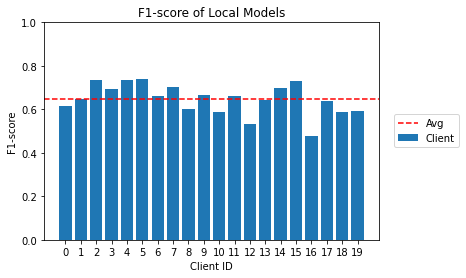

In [ ]:
plot_performance_of_local_models(precision_recall_fscores_of_local_aggregated_models, avg_local_aggregated_model_precision_recall_fscore)

In [ ]:
print_measures_of_dispersion(precision_recall_fscores_of_local_aggregated_models)

Variance of F1-score across local models: 0.0047048757357612304
Standard Deviation of F1-score across local models: 0.06859209674416747


No handles with labels found to put in legend.


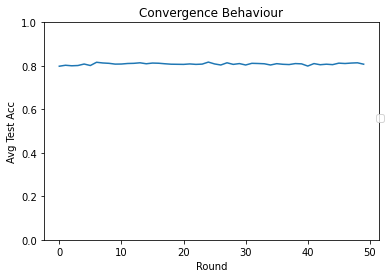

In [ ]:
plot_convergence_behaviour_from_federated_evaluation(federated_test_accs)

In [ ]:
get_utility_measure_on_distributions(avg_local_aggregated_model_precision_recall_fscore, avg_local_model_precision_recall_fscore)

Distribution Precision       Recall       F1-score      
                 Aggr. Local  Aggr. Local    Aggr. Local
iid               0.62  0.57   0.71  0.64     0.65  0.59

## [Federated Optimization Problem](https://arxiv.org/pdf/1602.05629.pdf)

The optimization problem implicit in federated learning is known as the federated optimization problem, drawing a contrast to the distributed optimization problem. The key properties that differentiate federated optimization are: unbalanced data (different clients can hold different amounts of data) and that the IID assumption, $\forall k.\mathbb{E}_{\mathcal{P}_k}[F_k(w)] = f(w)$, does not hold. That is to say that $F_k$ could be an arbitrarily bad approximation to $f$.

Here we focus on horizontal federated learning, where the clients share the same feature space but different sample space (in contrast to vertical federated learning, where the clients have different feature and sample spaces).

An [existing study](https://arxiv.org/pdf/1912.04977.pdf) gives a taxonomy of non-IID data distribution cases. Consider the local data distribution $P(x_i, y_i)$. We can rewrite $P(x_i, y_i)$ as $P(x_i | y_i)P(y_i)$ and $P(y_i | x_i)P(x_i)$ so that we can more precisely show the differences between cases. The study gives 5 different non-IID cases:

(1) label distribution skew (i.e., $P(y_i)$ is different among clients)

(2) feature distribution skew (i.e., $P(x_i)$ is different among clients) 

(3) same labels but different features (i.e., $P(x_i|y_i)$ is different among clients) 

(4) same features but different labels (i.e., $P(y_i|x_i)$ is different among
clients)

(5) quantity skew (i.e., $P(x_i, y_i)$ is the same but the amount of data is different among clients) 

Here, (3) is mainly related to vertical FL (the clients share the same sample IDs but different features). (4) is not applicable in most FL studies, which assume there is a common knowledge $P(y|x)$ among the clients to learn. (2) can be simulated on a dataset by adding different levels of noise to different partitions. In computer vision, these transformations can be done on the fly, using data generators e.g. for Gaussian noise. However, [this isn't the case with NLP](https://neptune.ai/blog/data-augmentation-nlp) due to the grammatical structure of the text; a new carefully augmented dataset must be generated beforehand.

Thus, we consider (5) quantity skew and (1) label distribution skew as possible non-IID data distribution cases.

## Unbalancedness

The size of the local dataset, $|{\mathcal{P}}_k|$, varies across clients. Although, the iid assumption still holds. We use a Dirichlet distribution to allocate different amounts of data samples to each client. We sample $q ∼ Dir_N (β)$, and allocate a $q_j$ proportion of the total data samples to ${\mathcal{P}}_j$ . The distribution parameter, $β>0$, can be used to control the degree of imbalance. The smaller $β$ is, the more imbalanced the distribution.

This scenario is relevant as in the real world some users/organisations will generate much more data than others, leading to varying amounts of local training data.

### [Centralized Evaluation](https://flower.dev/docs/evaluation.html)

In [ ]:
# Overrides to global experiment config
DATA_PARTITIONING_STRATEGY = "iid-quantity-skew"
EVAL_STRATEGY = "centralized"
DATA_SHARING = False

In [ ]:
# Split train set into NUMBER_OF_CLIENTS partitions.
partitioned_train_set = get_train_partitions(X_train, y_train.to_numpy())

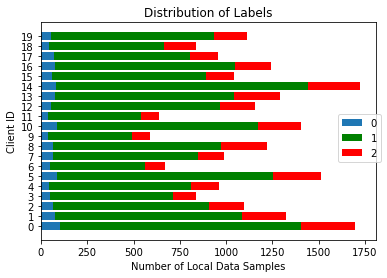

In [ ]:
plot_distribution_of_labels(partitioned_train_set)

In [ ]:
# Run sim with global config
sim_results = run_sim(partitioned_train_set)

INFO flower 2022-03-06 23:38:27,744 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-03-06 23:38:27,748 | server.py:128 | Initializing global parameters
INFO flower 2022-03-06 23:38:27,750 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 73146


INFO flower 2022-03-06 23:38:29,769 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:38:29,773 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:38:29,775 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-03-06 23:38:29,777 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-03-06 23:38:29,782 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-03-06 23:38:29,783 | server.py:130 | Evaluating initial parameters


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:38:29,838 | server.py:137 | initial parameters (loss, other metrics): 1.0986122886681096, {'accuracy': 0.057684550221863654}
INFO flower 2022-03-06 23:38:29,841 | server.py:143 | FL starting


initializing Client1 with pid 73209


INFO flower 2022-03-06 23:38:30,800 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:38:30,804 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:38:30,806 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-03-06 23:38:30,808 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 73241


INFO flower 2022-03-06 23:38:31,830 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:38:31,836 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:38:31,838 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-03-06 23:38:31,842 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 73275


INFO flower 2022-03-06 23:38:32,860 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:38:32,864 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:38:32,867 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 73309


INFO flower 2022-03-06 23:38:33,894 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:38:33,897 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:38:33,901 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 73345


INFO flower 2022-03-06 23:38:34,931 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:38:34,936 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:38:34,938 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-03-06 23:38:34,939 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 73385


INFO flower 2022-03-06 23:38:35,961 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:38:35,965 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:38:35,968 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 73425


INFO flower 2022-03-06 23:38:36,996 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:38:37,000 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:38:37,004 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 73467


INFO flower 2022-03-06 23:38:38,028 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:38:38,032 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:38:38,034 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-03-06 23:38:38,039 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 73513


INFO flower 2022-03-06 23:38:39,062 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:38:39,065 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:38:39,068 | connection.py:39 | ChannelConnectivity.READY


initializing Client10 with pid 73559


INFO flower 2022-03-06 23:38:40,097 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:38:40,102 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:38:40,106 | connection.py:39 | ChannelConnectivity.READY


initializing Client11 with pid 73609


INFO flower 2022-03-06 23:38:41,133 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:38:41,139 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:38:41,141 | connection.py:39 | ChannelConnectivity.READY


initializing Client12 with pid 73659


INFO flower 2022-03-06 23:38:42,163 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:38:42,168 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:38:42,171 | connection.py:39 | ChannelConnectivity.READY


initializing Client13 with pid 73713


INFO flower 2022-03-06 23:38:43,194 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:38:43,199 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:38:43,202 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-03-06 23:38:43,205 | connection.py:39 | ChannelConnectivity.READY


initializing Client14 with pid 73769


INFO flower 2022-03-06 23:38:44,224 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:38:44,228 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:38:44,231 | connection.py:39 | ChannelConnectivity.READY


initializing Client15 with pid 73825


INFO flower 2022-03-06 23:38:45,259 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:38:45,262 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:38:45,266 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-03-06 23:38:45,269 | connection.py:39 | ChannelConnectivity.READY


initializing Client16 with pid 73886


INFO flower 2022-03-06 23:38:46,291 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:38:46,295 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:38:46,298 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-03-06 23:38:46,299 | connection.py:39 | ChannelConnectivity.READY


initializing Client17 with pid 73948


INFO flower 2022-03-06 23:38:47,320 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:38:47,324 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:38:47,326 | connection.py:39 | ChannelConnectivity.READY


initializing Client18 with pid 74010


INFO flower 2022-03-06 23:38:48,355 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:38:48,359 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:38:48,362 | connection.py:39 | ChannelConnectivity.READY


initializing Client19 with pid 74074


INFO flower 2022-03-06 23:38:49,386 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:38:49,390 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:38:49,392 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-03-06 23:38:49,393 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)
DEBUG flower 2022-03-06 23:38:49,396 | connection.py:39 | ChannelConnectivity.READY


Client18 with pid 74010 is sampled in training rnd 1
Client8 with pid 73467 is sampled in training rnd 1
Client2 with pid 73241 is sampled in training rnd 1
Client3 with pid 73275 is sampled in training rnd 1
Client12 with pid 73659 is sampled in training rnd 1
Client7 with pid 73425 is sampled in training rnd 1
Client15 with pid 73825 is sampled in training rnd 1
Client13 with pid 73713 is sampled in training rnd 1
Client10 with pid 73559 is sampled in training rnd 1
Client6 with pid 73385 is sampled in training rnd 1
Client16 with pid 73886 is sampled in training rnd 1
Client1 with pid 73209 is sampled in training rnd 1
Client14 with pid 73769 is sampled in training rnd 1
Client0 with pid 73146 is sampled in training rnd 1


DEBUG flower 2022-03-06 23:38:50,803 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:38:50,937 | server.py:164 | fit progress: (1, 0.6448410419366801, {'accuracy': 0.754739814441307}, 21.091022044005513)
INFO flower 2022-03-06 23:38:50,943 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:38:50,948 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client12 with pid 73659 is sampled in training rnd 2
Client13 with pid 73713 is sampled in training rnd 2
Client0 with pid 73146 is sampled in training rnd 2
Client14 with pid 73769 is sampled in training rnd 2
Client8 with pid 73467 is sampled in training rnd 2
Client11 with pid 73609 is sampled in training rnd 2
Client19 with pid 74074 is sampled in training rnd 2
Client3 with pid 73275 is sampled in training rnd 2
Client9 with pid 73513 is sampled in training rnd 2
Client1 with pid 73209 is sampled in training rnd 2
Client5 with pid 73345 is sampled in training rnd 2
Client17 with pid 73948 is sampled in training rnd 2
Client15 with pid 73825 is sampled in training rnd 2
Client7 with pid 73425 is sampled in training rnd 2


DEBUG flower 2022-03-06 23:38:52,385 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:38:52,516 | server.py:164 | fit progress: (2, 0.5611155847423236, {'accuracy': 0.7966922146026624}, 22.670654954999918)
INFO flower 2022-03-06 23:38:52,518 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:38:52,524 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client17 with pid 73948 is sampled in training rnd 3
Client0 with pid 73146 is sampled in training rnd 3
Client12 with pid 73659 is sampled in training rnd 3
Client13 with pid 73713 is sampled in training rnd 3
Client11 with pid 73609 is sampled in training rnd 3
Client6 with pid 73385 is sampled in training rnd 3
Client18 with pid 74010 is sampled in training rnd 3
Client8 with pid 73467 is sampled in training rnd 3
Client3 with pid 73275 is sampled in training rnd 3
Client7 with pid 73425 is sampled in training rnd 3
Client10 with pid 73559 is sampled in training rnd 3
Client19 with pid 74074 is sampled in training rnd 3
Client14 with pid 73769 is sampled in training rnd 3
Client2 with pid 73241 is sampled in training rnd 3


DEBUG flower 2022-03-06 23:38:53,993 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:38:54,116 | server.py:164 | fit progress: (3, 0.5730998227022539, {'accuracy': 0.7874142799515934}, 24.270319839000877)
INFO flower 2022-03-06 23:38:54,119 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:38:54,121 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client7 with pid 73425 is sampled in training rnd 4
Client14 with pid 73769 is sampled in training rnd 4
Client0 with pid 73146 is sampled in training rnd 4
Client6 with pid 73385 is sampled in training rnd 4
Client9 with pid 73513 is sampled in training rnd 4
Client8 with pid 73467 is sampled in training rnd 4
Client13 with pid 73713 is sampled in training rnd 4
Client19 with pid 74074 is sampled in training rnd 4
Client10 with pid 73559 is sampled in training rnd 4
Client1 with pid 73209 is sampled in training rnd 4
Client2 with pid 73241 is sampled in training rnd 4
Client4 with pid 73309 is sampled in training rnd 4
Client11 with pid 73609 is sampled in training rnd 4
Client5 with pid 73345 is sampled in training rnd 4


DEBUG flower 2022-03-06 23:38:55,568 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:38:55,680 | server.py:164 | fit progress: (4, 0.5425584940753536, {'accuracy': 0.8015328761597418}, 25.834779237004113)
INFO flower 2022-03-06 23:38:55,688 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:38:55,699 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client10 with pid 73559 is sampled in training rnd 5
Client16 with pid 73886 is sampled in training rnd 5
Client13 with pid 73713 is sampled in training rnd 5
Client18 with pid 74010 is sampled in training rnd 5
Client6 with pid 73385 is sampled in training rnd 5
Client14 with pid 73769 is sampled in training rnd 5
Client4 with pid 73309 is sampled in training rnd 5
Client9 with pid 73513 is sampled in training rnd 5
Client7 with pid 73425 is sampled in training rnd 5
Client8 with pid 73467 is sampled in training rnd 5
Client15 with pid 73825 is sampled in training rnd 5
Client0 with pid 73146 is sampled in training rnd 5
Client11 with pid 73609 is sampled in training rnd 5
Client1 with pid 73209 is sampled in training rnd 5


DEBUG flower 2022-03-06 23:38:57,199 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:38:57,327 | server.py:164 | fit progress: (5, 0.5340763147388252, {'accuracy': 0.8079870915691811}, 27.481094645001576)
INFO flower 2022-03-06 23:38:57,332 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:38:57,336 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client13 with pid 73713 is sampled in training rnd 6
Client5 with pid 73345 is sampled in training rnd 6
Client11 with pid 73609 is sampled in training rnd 6
Client12 with pid 73659 is sampled in training rnd 6
Client1 with pid 73209 is sampled in training rnd 6
Client16 with pid 73886 is sampled in training rnd 6
Client7 with pid 73425 is sampled in training rnd 6
Client8 with pid 73467 is sampled in training rnd 6
Client10 with pid 73559 is sampled in training rnd 6
Client14 with pid 73769 is sampled in training rnd 6
Client2 with pid 73241 is sampled in training rnd 6
Client15 with pid 73825 is sampled in training rnd 6
Client6 with pid 73385 is sampled in training rnd 6
Client9 with pid 73513 is sampled in training rnd 6


DEBUG flower 2022-03-06 23:38:58,849 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:38:58,970 | server.py:164 | fit progress: (6, 0.5231014282839322, {'accuracy': 0.8083904800322711}, 29.12390622300154)
INFO flower 2022-03-06 23:38:58,975 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:38:58,978 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client15 with pid 73825 is sampled in training rnd 7
Client19 with pid 74074 is sampled in training rnd 7
Client0 with pid 73146 is sampled in training rnd 7
Client1 with pid 73209 is sampled in training rnd 7
Client9 with pid 73513 is sampled in training rnd 7
Client13 with pid 73713 is sampled in training rnd 7
Client11 with pid 73609 is sampled in training rnd 7
Client17 with pid 73948 is sampled in training rnd 7
Client12 with pid 73659 is sampled in training rnd 7
Client14 with pid 73769 is sampled in training rnd 7
Client6 with pid 73385 is sampled in training rnd 7
Client4 with pid 73309 is sampled in training rnd 7
Client2 with pid 73241 is sampled in training rnd 7
Client8 with pid 73467 is sampled in training rnd 7


DEBUG flower 2022-03-06 23:39:00,627 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:39:00,757 | server.py:164 | fit progress: (7, 0.5455297456589292, {'accuracy': 0.7938684953610327}, 30.911686514002213)
INFO flower 2022-03-06 23:39:00,763 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:39:00,772 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client7 with pid 73425 is sampled in training rnd 8
Client19 with pid 74074 is sampled in training rnd 8
Client0 with pid 73146 is sampled in training rnd 8
Client6 with pid 73385 is sampled in training rnd 8
Client12 with pid 73659 is sampled in training rnd 8
Client8 with pid 73467 is sampled in training rnd 8
Client5 with pid 73345 is sampled in training rnd 8
Client13 with pid 73713 is sampled in training rnd 8
Client9 with pid 73513 is sampled in training rnd 8
Client16 with pid 73886 is sampled in training rnd 8
Client4 with pid 73309 is sampled in training rnd 8
Client14 with pid 73769 is sampled in training rnd 8
Client18 with pid 74010 is sampled in training rnd 8
Client3 with pid 73275 is sampled in training rnd 8


DEBUG flower 2022-03-06 23:39:02,528 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:39:02,649 | server.py:164 | fit progress: (8, 0.5241099509266266, {'accuracy': 0.8067769261799113}, 32.80325742599962)
INFO flower 2022-03-06 23:39:02,652 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:39:02,662 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client16 with pid 73886 is sampled in training rnd 9
Client4 with pid 73309 is sampled in training rnd 9
Client6 with pid 73385 is sampled in training rnd 9
Client19 with pid 74074 is sampled in training rnd 9
Client0 with pid 73146 is sampled in training rnd 9
Client13 with pid 73713 is sampled in training rnd 9
Client5 with pid 73345 is sampled in training rnd 9
Client7 with pid 73425 is sampled in training rnd 9
Client9 with pid 73513 is sampled in training rnd 9
Client8 with pid 73467 is sampled in training rnd 9
Client3 with pid 73275 is sampled in training rnd 9
Client10 with pid 73559 is sampled in training rnd 9
Client17 with pid 73948 is sampled in training rnd 9
Client11 with pid 73609 is sampled in training rnd 9


DEBUG flower 2022-03-06 23:39:04,241 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:39:04,333 | server.py:164 | fit progress: (9, 0.5318584634674124, {'accuracy': 0.8043565954013715}, 34.48737187200459)
INFO flower 2022-03-06 23:39:04,339 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:39:04,348 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client13 with pid 73713 is sampled in training rnd 10
Client19 with pid 74074 is sampled in training rnd 10
Client11 with pid 73609 is sampled in training rnd 10
Client0 with pid 73146 is sampled in training rnd 10
Client7 with pid 73425 is sampled in training rnd 10
Client10 with pid 73559 is sampled in training rnd 10
Client9 with pid 73513 is sampled in training rnd 10
Client3 with pid 73275 is sampled in training rnd 10
Client16 with pid 73886 is sampled in training rnd 10
Client15 with pid 73825 is sampled in training rnd 10
Client2 with pid 73241 is sampled in training rnd 10
Client8 with pid 73467 is sampled in training rnd 10
Client18 with pid 74010 is sampled in training rnd 10
Client6 with pid 73385 is sampled in training rnd 10


DEBUG flower 2022-03-06 23:39:05,736 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:39:05,845 | server.py:164 | fit progress: (10, 0.532455729342944, {'accuracy': 0.8011294876966518}, 35.999810092005646)
INFO flower 2022-03-06 23:39:05,848 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:39:05,858 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client2 with pid 73241 is sampled in training rnd 11
Client17 with pid 73948 is sampled in training rnd 11
Client8 with pid 73467 is sampled in training rnd 11
Client1 with pid 73209 is sampled in training rnd 11
Client19 with pid 74074 is sampled in training rnd 11
Client13 with pid 73713 is sampled in training rnd 11
Client16 with pid 73886 is sampled in training rnd 11
Client0 with pid 73146 is sampled in training rnd 11
Client7 with pid 73425 is sampled in training rnd 11
Client12 with pid 73659 is sampled in training rnd 11
Client4 with pid 73309 is sampled in training rnd 11
Client3 with pid 73275 is sampled in training rnd 11
Client9 with pid 73513 is sampled in training rnd 11
Client10 with pid 73559 is sampled in training rnd 11


DEBUG flower 2022-03-06 23:39:07,310 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:39:07,386 | server.py:164 | fit progress: (11, 0.5153678828222359, {'accuracy': 0.8079870915691811}, 37.54033762200561)
INFO flower 2022-03-06 23:39:07,388 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:39:07,391 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client19 with pid 74074 is sampled in training rnd 12
Client11 with pid 73609 is sampled in training rnd 12
Client5 with pid 73345 is sampled in training rnd 12
Client2 with pid 73241 is sampled in training rnd 12
Client9 with pid 73513 is sampled in training rnd 12
Client4 with pid 73309 is sampled in training rnd 12
Client8 with pid 73467 is sampled in training rnd 12
Client14 with pid 73769 is sampled in training rnd 12
Client15 with pid 73825 is sampled in training rnd 12
Client13 with pid 73713 is sampled in training rnd 12
Client12 with pid 73659 is sampled in training rnd 12
Client7 with pid 73425 is sampled in training rnd 12
Client16 with pid 73886 is sampled in training rnd 12
Client18 with pid 74010 is sampled in training rnd 12


DEBUG flower 2022-03-06 23:39:08,866 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:39:08,975 | server.py:164 | fit progress: (12, 0.5196588818223045, {'accuracy': 0.8100040338846309}, 39.12930703100574)
INFO flower 2022-03-06 23:39:08,981 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:39:08,983 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client15 with pid 73825 is sampled in training rnd 13
Client18 with pid 74010 is sampled in training rnd 13
Client10 with pid 73559 is sampled in training rnd 13
Client3 with pid 73275 is sampled in training rnd 13
Client0 with pid 73146 is sampled in training rnd 13
Client4 with pid 73309 is sampled in training rnd 13
Client13 with pid 73713 is sampled in training rnd 13
Client16 with pid 73886 is sampled in training rnd 13
Client6 with pid 73385 is sampled in training rnd 13
Client14 with pid 73769 is sampled in training rnd 13
Client5 with pid 73345 is sampled in training rnd 13
Client1 with pid 73209 is sampled in training rnd 13
Client9 with pid 73513 is sampled in training rnd 13
Client12 with pid 73659 is sampled in training rnd 13


DEBUG flower 2022-03-06 23:39:10,502 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:39:10,613 | server.py:164 | fit progress: (13, 0.5168933719153024, {'accuracy': 0.8120209762000806}, 40.76790403700579)
INFO flower 2022-03-06 23:39:10,615 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:39:10,617 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client6 with pid 73385 is sampled in training rnd 14
Client16 with pid 73886 is sampled in training rnd 14
Client13 with pid 73713 is sampled in training rnd 14
Client0 with pid 73146 is sampled in training rnd 14
Client7 with pid 73425 is sampled in training rnd 14
Client19 with pid 74074 is sampled in training rnd 14
Client18 with pid 74010 is sampled in training rnd 14
Client2 with pid 73241 is sampled in training rnd 14
Client14 with pid 73769 is sampled in training rnd 14
Client12 with pid 73659 is sampled in training rnd 14
Client15 with pid 73825 is sampled in training rnd 14
Client8 with pid 73467 is sampled in training rnd 14
Client17 with pid 73948 is sampled in training rnd 14
Client4 with pid 73309 is sampled in training rnd 14


DEBUG flower 2022-03-06 23:39:12,192 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:39:12,311 | server.py:164 | fit progress: (14, 0.5270802111894345, {'accuracy': 0.809600645421541}, 42.465876864000165)
INFO flower 2022-03-06 23:39:12,321 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:39:12,323 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client7 with pid 73425 is sampled in training rnd 15
Client16 with pid 73886 is sampled in training rnd 15
Client14 with pid 73769 is sampled in training rnd 15
Client19 with pid 74074 is sampled in training rnd 15
Client0 with pid 73146 is sampled in training rnd 15
Client6 with pid 73385 is sampled in training rnd 15
Client10 with pid 73559 is sampled in training rnd 15
Client9 with pid 73513 is sampled in training rnd 15
Client5 with pid 73345 is sampled in training rnd 15
Client13 with pid 73713 is sampled in training rnd 15
Client17 with pid 73948 is sampled in training rnd 15
Client15 with pid 73825 is sampled in training rnd 15
Client4 with pid 73309 is sampled in training rnd 15
Client1 with pid 73209 is sampled in training rnd 15


DEBUG flower 2022-03-06 23:39:13,896 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:39:14,003 | server.py:164 | fit progress: (15, 0.5263306088773033, {'accuracy': 0.8075837031060912}, 44.15723569400143)
INFO flower 2022-03-06 23:39:14,009 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:39:14,013 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client1 with pid 73209 is sampled in training rnd 16
Client6 with pid 73385 is sampled in training rnd 16
Client2 with pid 73241 is sampled in training rnd 16
Client4 with pid 73309 is sampled in training rnd 16
Client16 with pid 73886 is sampled in training rnd 16
Client11 with pid 73609 is sampled in training rnd 16
Client14 with pid 73769 is sampled in training rnd 16
Client9 with pid 73513 is sampled in training rnd 16
Client15 with pid 73825 is sampled in training rnd 16
Client19 with pid 74074 is sampled in training rnd 16
Client17 with pid 73948 is sampled in training rnd 16
Client13 with pid 73713 is sampled in training rnd 16
Client12 with pid 73659 is sampled in training rnd 16
Client0 with pid 73146 is sampled in training rnd 16


DEBUG flower 2022-03-06 23:39:15,446 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:39:15,574 | server.py:164 | fit progress: (16, 0.519232063490323, {'accuracy': 0.8108108108108109}, 45.72850292200019)
INFO flower 2022-03-06 23:39:15,579 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:39:15,582 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client1 with pid 73209 is sampled in training rnd 17
Client17 with pid 73948 is sampled in training rnd 17
Client6 with pid 73385 is sampled in training rnd 17
Client5 with pid 73345 is sampled in training rnd 17
Client14 with pid 73769 is sampled in training rnd 17
Client13 with pid 73713 is sampled in training rnd 17
Client16 with pid 73886 is sampled in training rnd 17
Client12 with pid 73659 is sampled in training rnd 17
Client11 with pid 73609 is sampled in training rnd 17
Client9 with pid 73513 is sampled in training rnd 17
Client8 with pid 73467 is sampled in training rnd 17
Client0 with pid 73146 is sampled in training rnd 17
Client19 with pid 74074 is sampled in training rnd 17
Client18 with pid 74010 is sampled in training rnd 17


DEBUG flower 2022-03-06 23:39:17,116 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:39:17,231 | server.py:164 | fit progress: (17, 0.5238462412719435, {'accuracy': 0.8083904800322711}, 47.38499182600208)
INFO flower 2022-03-06 23:39:17,236 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:39:17,239 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client11 with pid 73609 is sampled in training rnd 18
Client3 with pid 73275 is sampled in training rnd 18
Client6 with pid 73385 is sampled in training rnd 18
Client7 with pid 73425 is sampled in training rnd 18
Client17 with pid 73948 is sampled in training rnd 18
Client13 with pid 73713 is sampled in training rnd 18
Client1 with pid 73209 is sampled in training rnd 18
Client10 with pid 73559 is sampled in training rnd 18
Client4 with pid 73309 is sampled in training rnd 18
Client15 with pid 73825 is sampled in training rnd 18
Client8 with pid 73467 is sampled in training rnd 18
Client14 with pid 73769 is sampled in training rnd 18
Client0 with pid 73146 is sampled in training rnd 18
Client2 with pid 73241 is sampled in training rnd 18


DEBUG flower 2022-03-06 23:39:18,760 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:39:18,902 | server.py:164 | fit progress: (18, 0.5246427695357672, {'accuracy': 0.8104074223477209}, 49.05631801500567)
INFO flower 2022-03-06 23:39:18,908 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:39:18,914 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client19 with pid 74074 is sampled in training rnd 19
Client12 with pid 73659 is sampled in training rnd 19
Client0 with pid 73146 is sampled in training rnd 19
Client9 with pid 73513 is sampled in training rnd 19
Client5 with pid 73345 is sampled in training rnd 19
Client3 with pid 73275 is sampled in training rnd 19
Client17 with pid 73948 is sampled in training rnd 19
Client13 with pid 73713 is sampled in training rnd 19
Client15 with pid 73825 is sampled in training rnd 19
Client2 with pid 73241 is sampled in training rnd 19
Client6 with pid 73385 is sampled in training rnd 19
Client18 with pid 74010 is sampled in training rnd 19
Client14 with pid 73769 is sampled in training rnd 19
Client10 with pid 73559 is sampled in training rnd 19


DEBUG flower 2022-03-06 23:39:20,485 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:39:20,609 | server.py:164 | fit progress: (19, 0.5157021859071735, {'accuracy': 0.8128277531262605}, 50.763177310000174)
INFO flower 2022-03-06 23:39:20,614 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:39:20,620 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client3 with pid 73275 is sampled in training rnd 20
Client12 with pid 73659 is sampled in training rnd 20
Client17 with pid 73948 is sampled in training rnd 20
Client11 with pid 73609 is sampled in training rnd 20
Client15 with pid 73825 is sampled in training rnd 20
Client18 with pid 74010 is sampled in training rnd 20
Client8 with pid 73467 is sampled in training rnd 20
Client19 with pid 74074 is sampled in training rnd 20
Client1 with pid 73209 is sampled in training rnd 20
Client0 with pid 73146 is sampled in training rnd 20
Client16 with pid 73886 is sampled in training rnd 20
Client2 with pid 73241 is sampled in training rnd 20
Client13 with pid 73713 is sampled in training rnd 20
Client9 with pid 73513 is sampled in training rnd 20


DEBUG flower 2022-03-06 23:39:22,140 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:39:22,230 | server.py:164 | fit progress: (20, 0.5336413275404969, {'accuracy': 0.8023396530859217}, 52.384420414004126)
INFO flower 2022-03-06 23:39:22,242 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:39:22,252 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client17 with pid 73948 is sampled in training rnd 21
Client6 with pid 73385 is sampled in training rnd 21
Client10 with pid 73559 is sampled in training rnd 21
Client19 with pid 74074 is sampled in training rnd 21
Client8 with pid 73467 is sampled in training rnd 21
Client5 with pid 73345 is sampled in training rnd 21
Client14 with pid 73769 is sampled in training rnd 21
Client13 with pid 73713 is sampled in training rnd 21
Client4 with pid 73309 is sampled in training rnd 21
Client1 with pid 73209 is sampled in training rnd 21
Client3 with pid 73275 is sampled in training rnd 21
Client7 with pid 73425 is sampled in training rnd 21
Client2 with pid 73241 is sampled in training rnd 21
Client16 with pid 73886 is sampled in training rnd 21


DEBUG flower 2022-03-06 23:39:23,832 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:39:23,953 | server.py:164 | fit progress: (21, 0.5200305187198068, {'accuracy': 0.8112141992739008}, 54.10757257800287)
INFO flower 2022-03-06 23:39:23,961 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:39:23,965 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client17 with pid 73948 is sampled in training rnd 22
Client3 with pid 73275 is sampled in training rnd 22
Client10 with pid 73559 is sampled in training rnd 22
Client13 with pid 73713 is sampled in training rnd 22
Client1 with pid 73209 is sampled in training rnd 22
Client16 with pid 73886 is sampled in training rnd 22
Client6 with pid 73385 is sampled in training rnd 22
Client12 with pid 73659 is sampled in training rnd 22
Client2 with pid 73241 is sampled in training rnd 22
Client11 with pid 73609 is sampled in training rnd 22
Client14 with pid 73769 is sampled in training rnd 22
Client5 with pid 73345 is sampled in training rnd 22
Client15 with pid 73825 is sampled in training rnd 22
Client0 with pid 73146 is sampled in training rnd 22


DEBUG flower 2022-03-06 23:39:25,540 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:39:25,662 | server.py:164 | fit progress: (22, 0.5152499637198028, {'accuracy': 0.81807180314643}, 55.81666983300238)
INFO flower 2022-03-06 23:39:25,666 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:39:25,671 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client17 with pid 73948 is sampled in training rnd 23
Client18 with pid 74010 is sampled in training rnd 23
Client7 with pid 73425 is sampled in training rnd 23
Client8 with pid 73467 is sampled in training rnd 23
Client2 with pid 73241 is sampled in training rnd 23
Client4 with pid 73309 is sampled in training rnd 23
Client15 with pid 73825 is sampled in training rnd 23
Client5 with pid 73345 is sampled in training rnd 23
Client9 with pid 73513 is sampled in training rnd 23
Client1 with pid 73209 is sampled in training rnd 23
Client19 with pid 74074 is sampled in training rnd 23
Client13 with pid 73713 is sampled in training rnd 23
Client10 with pid 73559 is sampled in training rnd 23
Client6 with pid 73385 is sampled in training rnd 23


DEBUG flower 2022-03-06 23:39:27,145 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:39:27,284 | server.py:164 | fit progress: (23, 0.5251049221068048, {'accuracy': 0.8100040338846309}, 57.43832678500621)
INFO flower 2022-03-06 23:39:27,288 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:39:27,294 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client1 with pid 73209 is sampled in training rnd 24
Client9 with pid 73513 is sampled in training rnd 24
Client0 with pid 73146 is sampled in training rnd 24
Client2 with pid 73241 is sampled in training rnd 24
Client17 with pid 73948 is sampled in training rnd 24
Client6 with pid 73385 is sampled in training rnd 24
Client19 with pid 74074 is sampled in training rnd 24
Client12 with pid 73659 is sampled in training rnd 24
Client16 with pid 73886 is sampled in training rnd 24
Client3 with pid 73275 is sampled in training rnd 24
Client10 with pid 73559 is sampled in training rnd 24
Client14 with pid 73769 is sampled in training rnd 24
Client15 with pid 73825 is sampled in training rnd 24
Client11 with pid 73609 is sampled in training rnd 24


DEBUG flower 2022-03-06 23:39:28,789 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:39:28,944 | server.py:164 | fit progress: (24, 0.5187514421090285, {'accuracy': 0.8120209762000806}, 59.09793864700623)
INFO flower 2022-03-06 23:39:28,946 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:39:28,949 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client14 with pid 73769 is sampled in training rnd 25
Client7 with pid 73425 is sampled in training rnd 25
Client3 with pid 73275 is sampled in training rnd 25
Client5 with pid 73345 is sampled in training rnd 25
Client18 with pid 74010 is sampled in training rnd 25
Client6 with pid 73385 is sampled in training rnd 25
Client19 with pid 74074 is sampled in training rnd 25
Client12 with pid 73659 is sampled in training rnd 25
Client8 with pid 73467 is sampled in training rnd 25
Client4 with pid 73309 is sampled in training rnd 25
Client11 with pid 73609 is sampled in training rnd 25
Client10 with pid 73559 is sampled in training rnd 25
Client17 with pid 73948 is sampled in training rnd 25
Client2 with pid 73241 is sampled in training rnd 25


DEBUG flower 2022-03-06 23:39:30,421 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:39:30,519 | server.py:164 | fit progress: (25, 0.5164311870209589, {'accuracy': 0.8124243646631706}, 60.6737256530032)
INFO flower 2022-03-06 23:39:30,539 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:39:30,549 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client3 with pid 73275 is sampled in training rnd 26
Client6 with pid 73385 is sampled in training rnd 26
Client1 with pid 73209 is sampled in training rnd 26
Client0 with pid 73146 is sampled in training rnd 26
Client15 with pid 73825 is sampled in training rnd 26
Client10 with pid 73559 is sampled in training rnd 26
Client12 with pid 73659 is sampled in training rnd 26
Client4 with pid 73309 is sampled in training rnd 26
Client11 with pid 73609 is sampled in training rnd 26
Client9 with pid 73513 is sampled in training rnd 26
Client5 with pid 73345 is sampled in training rnd 26
Client7 with pid 73425 is sampled in training rnd 26
Client18 with pid 74010 is sampled in training rnd 26
Client2 with pid 73241 is sampled in training rnd 26


DEBUG flower 2022-03-06 23:39:31,983 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:39:32,118 | server.py:164 | fit progress: (26, 0.5152467799571645, {'accuracy': 0.8120209762000806}, 62.27223204100301)
INFO flower 2022-03-06 23:39:32,124 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:39:32,131 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client2 with pid 73241 is sampled in training rnd 27
Client12 with pid 73659 is sampled in training rnd 27
Client18 with pid 74010 is sampled in training rnd 27
Client10 with pid 73559 is sampled in training rnd 27
Client14 with pid 73769 is sampled in training rnd 27
Client1 with pid 73209 is sampled in training rnd 27
Client4 with pid 73309 is sampled in training rnd 27
Client3 with pid 73275 is sampled in training rnd 27
Client9 with pid 73513 is sampled in training rnd 27
Client8 with pid 73467 is sampled in training rnd 27
Client7 with pid 73425 is sampled in training rnd 27
Client5 with pid 73345 is sampled in training rnd 27
Client13 with pid 73713 is sampled in training rnd 27
Client15 with pid 73825 is sampled in training rnd 27


DEBUG flower 2022-03-06 23:39:33,653 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:39:33,788 | server.py:164 | fit progress: (27, 0.5170433893048076, {'accuracy': 0.8156514723678903}, 63.942079362001095)
INFO flower 2022-03-06 23:39:33,799 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:39:33,805 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client17 with pid 73948 is sampled in training rnd 28
Client6 with pid 73385 is sampled in training rnd 28
Client9 with pid 73513 is sampled in training rnd 28
Client18 with pid 74010 is sampled in training rnd 28
Client7 with pid 73425 is sampled in training rnd 28
Client5 with pid 73345 is sampled in training rnd 28
Client1 with pid 73209 is sampled in training rnd 28
Client4 with pid 73309 is sampled in training rnd 28
Client13 with pid 73713 is sampled in training rnd 28
Client15 with pid 73825 is sampled in training rnd 28
Client11 with pid 73609 is sampled in training rnd 28
Client14 with pid 73769 is sampled in training rnd 28
Client3 with pid 73275 is sampled in training rnd 28
Client10 with pid 73559 is sampled in training rnd 28


DEBUG flower 2022-03-06 23:39:35,351 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:39:35,459 | server.py:164 | fit progress: (28, 0.5137297732621714, {'accuracy': 0.8208955223880597}, 65.61324664900167)
INFO flower 2022-03-06 23:39:35,468 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:39:35,470 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client1 with pid 73209 is sampled in training rnd 29
Client9 with pid 73513 is sampled in training rnd 29
Client5 with pid 73345 is sampled in training rnd 29
Client17 with pid 73948 is sampled in training rnd 29
Client10 with pid 73559 is sampled in training rnd 29
Client12 with pid 73659 is sampled in training rnd 29
Client19 with pid 74074 is sampled in training rnd 29
Client13 with pid 73713 is sampled in training rnd 29
Client4 with pid 73309 is sampled in training rnd 29
Client3 with pid 73275 is sampled in training rnd 29
Client16 with pid 73886 is sampled in training rnd 29
Client18 with pid 74010 is sampled in training rnd 29
Client8 with pid 73467 is sampled in training rnd 29
Client7 with pid 73425 is sampled in training rnd 29


DEBUG flower 2022-03-06 23:39:36,851 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:39:36,986 | server.py:164 | fit progress: (29, 0.5189126527346596, {'accuracy': 0.8120209762000806}, 67.14008493400615)
INFO flower 2022-03-06 23:39:36,994 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:39:36,996 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client7 with pid 73425 is sampled in training rnd 30
Client12 with pid 73659 is sampled in training rnd 30
Client2 with pid 73241 is sampled in training rnd 30
Client11 with pid 73609 is sampled in training rnd 30
Client16 with pid 73886 is sampled in training rnd 30
Client1 with pid 73209 is sampled in training rnd 30
Client0 with pid 73146 is sampled in training rnd 30
Client18 with pid 74010 is sampled in training rnd 30
Client8 with pid 73467 is sampled in training rnd 30
Client4 with pid 73309 is sampled in training rnd 30
Client19 with pid 74074 is sampled in training rnd 30
Client9 with pid 73513 is sampled in training rnd 30
Client14 with pid 73769 is sampled in training rnd 30
Client6 with pid 73385 is sampled in training rnd 30


DEBUG flower 2022-03-06 23:39:38,414 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:39:38,552 | server.py:164 | fit progress: (30, 0.5265824887920658, {'accuracy': 0.8067769261799113}, 68.70594113500556)
INFO flower 2022-03-06 23:39:38,556 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:39:38,559 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client11 with pid 73609 is sampled in training rnd 31
Client15 with pid 73825 is sampled in training rnd 31
Client18 with pid 74010 is sampled in training rnd 31
Client3 with pid 73275 is sampled in training rnd 31
Client4 with pid 73309 is sampled in training rnd 31
Client8 with pid 73467 is sampled in training rnd 31
Client5 with pid 73345 is sampled in training rnd 31
Client13 with pid 73713 is sampled in training rnd 31
Client12 with pid 73659 is sampled in training rnd 31
Client14 with pid 73769 is sampled in training rnd 31
Client1 with pid 73209 is sampled in training rnd 31
Client2 with pid 73241 is sampled in training rnd 31
Client9 with pid 73513 is sampled in training rnd 31
Client6 with pid 73385 is sampled in training rnd 31


DEBUG flower 2022-03-06 23:39:39,983 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:39:40,105 | server.py:164 | fit progress: (31, 0.5227550481981159, {'accuracy': 0.8104074223477209}, 70.25980731500022)
INFO flower 2022-03-06 23:39:40,109 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:39:40,112 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client10 with pid 73559 is sampled in training rnd 32
Client4 with pid 73309 is sampled in training rnd 32
Client9 with pid 73513 is sampled in training rnd 32
Client19 with pid 74074 is sampled in training rnd 32
Client8 with pid 73467 is sampled in training rnd 32
Client11 with pid 73609 is sampled in training rnd 32
Client3 with pid 73275 is sampled in training rnd 32
Client18 with pid 74010 is sampled in training rnd 32
Client16 with pid 73886 is sampled in training rnd 32
Client2 with pid 73241 is sampled in training rnd 32
Client15 with pid 73825 is sampled in training rnd 32
Client17 with pid 73948 is sampled in training rnd 32
Client0 with pid 73146 is sampled in training rnd 32
Client6 with pid 73385 is sampled in training rnd 32


DEBUG flower 2022-03-06 23:39:41,528 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:39:41,656 | server.py:164 | fit progress: (32, 0.5280131651879867, {'accuracy': 0.8051633723275514}, 71.81075312699977)
INFO flower 2022-03-06 23:39:41,666 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:39:41,670 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client17 with pid 73948 is sampled in training rnd 33
Client10 with pid 73559 is sampled in training rnd 33
Client9 with pid 73513 is sampled in training rnd 33
Client6 with pid 73385 is sampled in training rnd 33
Client18 with pid 74010 is sampled in training rnd 33
Client8 with pid 73467 is sampled in training rnd 33
Client5 with pid 73345 is sampled in training rnd 33
Client0 with pid 73146 is sampled in training rnd 33
Client2 with pid 73241 is sampled in training rnd 33
Client19 with pid 74074 is sampled in training rnd 33
Client3 with pid 73275 is sampled in training rnd 33
Client4 with pid 73309 is sampled in training rnd 33
Client1 with pid 73209 is sampled in training rnd 33
Client16 with pid 73886 is sampled in training rnd 33


DEBUG flower 2022-03-06 23:39:43,194 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:39:43,298 | server.py:164 | fit progress: (33, 0.5194266792309039, {'accuracy': 0.8083904800322711}, 73.45216321100452)
INFO flower 2022-03-06 23:39:43,312 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:39:43,318 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client14 with pid 73769 is sampled in training rnd 34
Client13 with pid 73713 is sampled in training rnd 34
Client17 with pid 73948 is sampled in training rnd 34
Client18 with pid 74010 is sampled in training rnd 34
Client8 with pid 73467 is sampled in training rnd 34
Client16 with pid 73886 is sampled in training rnd 34
Client7 with pid 73425 is sampled in training rnd 34
Client19 with pid 74074 is sampled in training rnd 34
Client0 with pid 73146 is sampled in training rnd 34
Client6 with pid 73385 is sampled in training rnd 34
Client5 with pid 73345 is sampled in training rnd 34
Client2 with pid 73241 is sampled in training rnd 34
Client3 with pid 73275 is sampled in training rnd 34
Client4 with pid 73309 is sampled in training rnd 34


DEBUG flower 2022-03-06 23:39:44,822 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:39:44,939 | server.py:164 | fit progress: (34, 0.5281813014955007, {'accuracy': 0.809197256958451}, 75.09325894300127)
INFO flower 2022-03-06 23:39:44,944 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:39:44,948 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client13 with pid 73713 is sampled in training rnd 35
Client19 with pid 74074 is sampled in training rnd 35
Client0 with pid 73146 is sampled in training rnd 35
Client1 with pid 73209 is sampled in training rnd 35
Client11 with pid 73609 is sampled in training rnd 35
Client9 with pid 73513 is sampled in training rnd 35
Client14 with pid 73769 is sampled in training rnd 35
Client2 with pid 73241 is sampled in training rnd 35
Client18 with pid 74010 is sampled in training rnd 35
Client15 with pid 73825 is sampled in training rnd 35
Client4 with pid 73309 is sampled in training rnd 35
Client12 with pid 73659 is sampled in training rnd 35
Client6 with pid 73385 is sampled in training rnd 35
Client8 with pid 73467 is sampled in training rnd 35


DEBUG flower 2022-03-06 23:39:46,414 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:39:46,548 | server.py:164 | fit progress: (35, 0.5157252407107148, {'accuracy': 0.8083904800322711}, 76.70289420400513)
INFO flower 2022-03-06 23:39:46,554 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:39:46,564 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client12 with pid 73659 is sampled in training rnd 36
Client5 with pid 73345 is sampled in training rnd 36
Client2 with pid 73241 is sampled in training rnd 36
Client7 with pid 73425 is sampled in training rnd 36
Client15 with pid 73825 is sampled in training rnd 36
Client0 with pid 73146 is sampled in training rnd 36
Client17 with pid 73948 is sampled in training rnd 36
Client8 with pid 73467 is sampled in training rnd 36
Client18 with pid 74010 is sampled in training rnd 36
Client19 with pid 74074 is sampled in training rnd 36
Client16 with pid 73886 is sampled in training rnd 36
Client3 with pid 73275 is sampled in training rnd 36
Client10 with pid 73559 is sampled in training rnd 36
Client13 with pid 73713 is sampled in training rnd 36


DEBUG flower 2022-03-06 23:39:48,048 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:39:48,170 | server.py:164 | fit progress: (36, 0.5218952817805577, {'accuracy': 0.8075837031060912}, 78.3247905169992)
INFO flower 2022-03-06 23:39:48,180 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:39:48,190 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client15 with pid 73825 is sampled in training rnd 37
Client19 with pid 74074 is sampled in training rnd 37
Client7 with pid 73425 is sampled in training rnd 37
Client10 with pid 73559 is sampled in training rnd 37
Client13 with pid 73713 is sampled in training rnd 37
Client8 with pid 73467 is sampled in training rnd 37
Client9 with pid 73513 is sampled in training rnd 37
Client18 with pid 74010 is sampled in training rnd 37
Client11 with pid 73609 is sampled in training rnd 37
Client4 with pid 73309 is sampled in training rnd 37
Client3 with pid 73275 is sampled in training rnd 37
Client0 with pid 73146 is sampled in training rnd 37
Client1 with pid 73209 is sampled in training rnd 37
Client6 with pid 73385 is sampled in training rnd 37


DEBUG flower 2022-03-06 23:39:49,637 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:39:49,723 | server.py:164 | fit progress: (37, 0.5110722131054488, {'accuracy': 0.8156514723678903}, 79.8770921280011)
INFO flower 2022-03-06 23:39:49,732 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:39:49,741 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client11 with pid 73609 is sampled in training rnd 38
Client5 with pid 73345 is sampled in training rnd 38
Client19 with pid 74074 is sampled in training rnd 38
Client16 with pid 73886 is sampled in training rnd 38
Client4 with pid 73309 is sampled in training rnd 38
Client6 with pid 73385 is sampled in training rnd 38
Client14 with pid 73769 is sampled in training rnd 38
Client18 with pid 74010 is sampled in training rnd 38
Client13 with pid 73713 is sampled in training rnd 38
Client8 with pid 73467 is sampled in training rnd 38
Client17 with pid 73948 is sampled in training rnd 38
Client2 with pid 73241 is sampled in training rnd 38
Client7 with pid 73425 is sampled in training rnd 38
Client12 with pid 73659 is sampled in training rnd 38


DEBUG flower 2022-03-06 23:39:51,242 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:39:51,360 | server.py:164 | fit progress: (38, 0.5298563624256531, {'accuracy': 0.8087938684953611}, 81.5147195890022)
INFO flower 2022-03-06 23:39:51,367 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:39:51,375 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client2 with pid 73241 is sampled in training rnd 39
Client3 with pid 73275 is sampled in training rnd 39
Client16 with pid 73886 is sampled in training rnd 39
Client12 with pid 73659 is sampled in training rnd 39
Client19 with pid 74074 is sampled in training rnd 39
Client5 with pid 73345 is sampled in training rnd 39
Client6 with pid 73385 is sampled in training rnd 39
Client9 with pid 73513 is sampled in training rnd 39
Client0 with pid 73146 is sampled in training rnd 39
Client7 with pid 73425 is sampled in training rnd 39
Client18 with pid 74010 is sampled in training rnd 39
Client15 with pid 73825 is sampled in training rnd 39
Client17 with pid 73948 is sampled in training rnd 39
Client4 with pid 73309 is sampled in training rnd 39


DEBUG flower 2022-03-06 23:39:52,895 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:39:53,013 | server.py:164 | fit progress: (39, 0.5195425150128292, {'accuracy': 0.8100040338846309}, 83.16723312400427)
INFO flower 2022-03-06 23:39:53,019 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:39:53,025 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client11 with pid 73609 is sampled in training rnd 40
Client5 with pid 73345 is sampled in training rnd 40
Client1 with pid 73209 is sampled in training rnd 40
Client12 with pid 73659 is sampled in training rnd 40
Client8 with pid 73467 is sampled in training rnd 40
Client15 with pid 73825 is sampled in training rnd 40
Client18 with pid 74010 is sampled in training rnd 40
Client4 with pid 73309 is sampled in training rnd 40
Client10 with pid 73559 is sampled in training rnd 40
Client16 with pid 73886 is sampled in training rnd 40
Client13 with pid 73713 is sampled in training rnd 40
Client19 with pid 74074 is sampled in training rnd 40
Client9 with pid 73513 is sampled in training rnd 40
Client7 with pid 73425 is sampled in training rnd 40


DEBUG flower 2022-03-06 23:39:54,461 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:39:54,550 | server.py:164 | fit progress: (40, 0.5133106852494128, {'accuracy': 0.8104074223477209}, 84.70418449400313)
INFO flower 2022-03-06 23:39:54,555 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:39:54,564 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client19 with pid 74074 is sampled in training rnd 41
Client2 with pid 73241 is sampled in training rnd 41
Client7 with pid 73425 is sampled in training rnd 41
Client14 with pid 73769 is sampled in training rnd 41
Client6 with pid 73385 is sampled in training rnd 41
Client15 with pid 73825 is sampled in training rnd 41
Client12 with pid 73659 is sampled in training rnd 41
Client18 with pid 74010 is sampled in training rnd 41
Client5 with pid 73345 is sampled in training rnd 41
Client13 with pid 73713 is sampled in training rnd 41
Client11 with pid 73609 is sampled in training rnd 41
Client16 with pid 73886 is sampled in training rnd 41
Client9 with pid 73513 is sampled in training rnd 41
Client1 with pid 73209 is sampled in training rnd 41


DEBUG flower 2022-03-06 23:39:55,964 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:39:56,086 | server.py:164 | fit progress: (41, 0.5195476069640976, {'accuracy': 0.8124243646631706}, 86.24088819300232)
INFO flower 2022-03-06 23:39:56,092 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:39:56,094 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client3 with pid 73275 is sampled in training rnd 42
Client13 with pid 73713 is sampled in training rnd 42
Client17 with pid 73948 is sampled in training rnd 42
Client18 with pid 74010 is sampled in training rnd 42
Client19 with pid 74074 is sampled in training rnd 42
Client10 with pid 73559 is sampled in training rnd 42
Client4 with pid 73309 is sampled in training rnd 42
Client16 with pid 73886 is sampled in training rnd 42
Client6 with pid 73385 is sampled in training rnd 42
Client15 with pid 73825 is sampled in training rnd 42
Client8 with pid 73467 is sampled in training rnd 42
Client0 with pid 73146 is sampled in training rnd 42
Client11 with pid 73609 is sampled in training rnd 42
Client12 with pid 73659 is sampled in training rnd 42


DEBUG flower 2022-03-06 23:39:57,504 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:39:57,632 | server.py:164 | fit progress: (42, 0.5205952878999821, {'accuracy': 0.8079870915691811}, 87.78645820000384)
INFO flower 2022-03-06 23:39:57,636 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:39:57,640 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client14 with pid 73769 is sampled in training rnd 43
Client17 with pid 73948 is sampled in training rnd 43
Client7 with pid 73425 is sampled in training rnd 43
Client0 with pid 73146 is sampled in training rnd 43
Client18 with pid 74010 is sampled in training rnd 43
Client13 with pid 73713 is sampled in training rnd 43
Client4 with pid 73309 is sampled in training rnd 43
Client3 with pid 73275 is sampled in training rnd 43
Client2 with pid 73241 is sampled in training rnd 43
Client19 with pid 74074 is sampled in training rnd 43
Client11 with pid 73609 is sampled in training rnd 43
Client8 with pid 73467 is sampled in training rnd 43
Client12 with pid 73659 is sampled in training rnd 43
Client9 with pid 73513 is sampled in training rnd 43


DEBUG flower 2022-03-06 23:39:59,082 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:39:59,210 | server.py:164 | fit progress: (43, 0.5239369675956225, {'accuracy': 0.8067769261799113}, 89.36392325400084)
INFO flower 2022-03-06 23:39:59,216 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:39:59,219 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client18 with pid 74010 is sampled in training rnd 44
Client9 with pid 73513 is sampled in training rnd 44
Client8 with pid 73467 is sampled in training rnd 44
Client14 with pid 73769 is sampled in training rnd 44
Client5 with pid 73345 is sampled in training rnd 44
Client17 with pid 73948 is sampled in training rnd 44
Client7 with pid 73425 is sampled in training rnd 44
Client6 with pid 73385 is sampled in training rnd 44
Client1 with pid 73209 is sampled in training rnd 44
Client15 with pid 73825 is sampled in training rnd 44
Client3 with pid 73275 is sampled in training rnd 44
Client11 with pid 73609 is sampled in training rnd 44
Client19 with pid 74074 is sampled in training rnd 44
Client2 with pid 73241 is sampled in training rnd 44


DEBUG flower 2022-03-06 23:40:00,603 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:40:00,734 | server.py:164 | fit progress: (44, 0.5156060395008024, {'accuracy': 0.8140379185155304}, 90.88794519300427)
INFO flower 2022-03-06 23:40:00,737 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:40:00,738 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client0 with pid 73146 is sampled in training rnd 45
Client3 with pid 73275 is sampled in training rnd 45
Client19 with pid 74074 is sampled in training rnd 45
Client18 with pid 74010 is sampled in training rnd 45
Client9 with pid 73513 is sampled in training rnd 45
Client10 with pid 73559 is sampled in training rnd 45
Client12 with pid 73659 is sampled in training rnd 45
Client11 with pid 73609 is sampled in training rnd 45
Client14 with pid 73769 is sampled in training rnd 45
Client2 with pid 73241 is sampled in training rnd 45
Client1 with pid 73209 is sampled in training rnd 45
Client8 with pid 73467 is sampled in training rnd 45
Client5 with pid 73345 is sampled in training rnd 45
Client4 with pid 73309 is sampled in training rnd 45


DEBUG flower 2022-03-06 23:40:02,398 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:40:02,532 | server.py:164 | fit progress: (45, 0.5247217400095003, {'accuracy': 0.8063735377168213}, 92.6862404870044)
INFO flower 2022-03-06 23:40:02,536 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:40:02,544 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client13 with pid 73713 is sampled in training rnd 46
Client9 with pid 73513 is sampled in training rnd 46
Client16 with pid 73886 is sampled in training rnd 46
Client11 with pid 73609 is sampled in training rnd 46
Client10 with pid 73559 is sampled in training rnd 46
Client0 with pid 73146 is sampled in training rnd 46
Client1 with pid 73209 is sampled in training rnd 46
Client7 with pid 73425 is sampled in training rnd 46
Client17 with pid 73948 is sampled in training rnd 46
Client12 with pid 73659 is sampled in training rnd 46
Client5 with pid 73345 is sampled in training rnd 46
Client4 with pid 73309 is sampled in training rnd 46
Client6 with pid 73385 is sampled in training rnd 46
Client2 with pid 73241 is sampled in training rnd 46


DEBUG flower 2022-03-06 23:40:04,011 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:40:04,136 | server.py:164 | fit progress: (46, 0.5256101188040817, {'accuracy': 0.8063735377168213}, 94.29082668900082)
INFO flower 2022-03-06 23:40:04,143 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:40:04,153 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client15 with pid 73825 is sampled in training rnd 47
Client18 with pid 74010 is sampled in training rnd 47
Client3 with pid 73275 is sampled in training rnd 47
Client12 with pid 73659 is sampled in training rnd 47
Client17 with pid 73948 is sampled in training rnd 47
Client16 with pid 73886 is sampled in training rnd 47
Client8 with pid 73467 is sampled in training rnd 47
Client0 with pid 73146 is sampled in training rnd 47
Client4 with pid 73309 is sampled in training rnd 47
Client10 with pid 73559 is sampled in training rnd 47
Client9 with pid 73513 is sampled in training rnd 47
Client14 with pid 73769 is sampled in training rnd 47
Client13 with pid 73713 is sampled in training rnd 47
Client7 with pid 73425 is sampled in training rnd 47


DEBUG flower 2022-03-06 23:40:05,710 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:40:05,810 | server.py:164 | fit progress: (47, 0.5097526290619306, {'accuracy': 0.8136345300524405}, 95.96422451300168)
INFO flower 2022-03-06 23:40:05,816 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:40:05,823 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client19 with pid 74074 is sampled in training rnd 48
Client16 with pid 73886 is sampled in training rnd 48
Client13 with pid 73713 is sampled in training rnd 48
Client9 with pid 73513 is sampled in training rnd 48
Client5 with pid 73345 is sampled in training rnd 48
Client7 with pid 73425 is sampled in training rnd 48
Client18 with pid 74010 is sampled in training rnd 48
Client10 with pid 73559 is sampled in training rnd 48
Client8 with pid 73467 is sampled in training rnd 48
Client3 with pid 73275 is sampled in training rnd 48
Client15 with pid 73825 is sampled in training rnd 48
Client11 with pid 73609 is sampled in training rnd 48
Client0 with pid 73146 is sampled in training rnd 48
Client17 with pid 73948 is sampled in training rnd 48


DEBUG flower 2022-03-06 23:40:07,312 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:40:07,431 | server.py:164 | fit progress: (48, 0.5227323298271257, {'accuracy': 0.8104074223477209}, 97.5854700090058)
INFO flower 2022-03-06 23:40:07,441 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:40:07,442 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client12 with pid 73659 is sampled in training rnd 49
Client18 with pid 74010 is sampled in training rnd 49
Client13 with pid 73713 is sampled in training rnd 49
Client10 with pid 73559 is sampled in training rnd 49
Client19 with pid 74074 is sampled in training rnd 49
Client17 with pid 73948 is sampled in training rnd 49
Client9 with pid 73513 is sampled in training rnd 49
Client14 with pid 73769 is sampled in training rnd 49
Client11 with pid 73609 is sampled in training rnd 49
Client1 with pid 73209 is sampled in training rnd 49
Client3 with pid 73275 is sampled in training rnd 49
Client4 with pid 73309 is sampled in training rnd 49
Client5 with pid 73345 is sampled in training rnd 49
Client7 with pid 73425 is sampled in training rnd 49


DEBUG flower 2022-03-06 23:40:08,895 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:40:09,023 | server.py:164 | fit progress: (49, 0.5178426647208599, {'accuracy': 0.8128277531262605}, 99.17725726800563)
INFO flower 2022-03-06 23:40:09,025 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:40:09,029 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client0 with pid 73146 is sampled in training rnd 50
Client4 with pid 73309 is sampled in training rnd 50
Client13 with pid 73713 is sampled in training rnd 50
Client12 with pid 73659 is sampled in training rnd 50
Client8 with pid 73467 is sampled in training rnd 50
Client18 with pid 74010 is sampled in training rnd 50
Client1 with pid 73209 is sampled in training rnd 50
Client16 with pid 73886 is sampled in training rnd 50
Client2 with pid 73241 is sampled in training rnd 50
Client9 with pid 73513 is sampled in training rnd 50
Client19 with pid 74074 is sampled in training rnd 50
Client5 with pid 73345 is sampled in training rnd 50
Client17 with pid 73948 is sampled in training rnd 50
Client6 with pid 73385 is sampled in training rnd 50


DEBUG flower 2022-03-06 23:40:10,442 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:40:10,573 | server.py:164 | fit progress: (50, 0.5155091185176367, {'accuracy': 0.8087938684953611}, 100.72731111699977)
INFO flower 2022-03-06 23:40:10,578 | server.py:209 | evaluate_round: no clients selected, cancel
INFO flower 2022-03-06 23:40:10,584 | server.py:182 | FL finished in 100.73882923900237
INFO flower 2022-03-06 23:40:10,590 | app.py:149 | app_fit: losses_distributed []
INFO flower 2022-03-06 23:40:10,596 | app.py:150 | app_fit: metrics_distributed {}
INFO flower 2022-03-06 23:40:10,602 | app.py:151 | app_fit: losses_centralized [(0, 1.0986122886681096), (1, 0.6448410419366801), (2, 0.5611155847423236), (3, 0.5730998227022539), (4, 0.5425584940753536), (5, 0.5340763147388252), (6, 0.5231014282839322), (7, 0.5455297456589292), (8, 0.5241099509266266), (9, 0.5318584634674124), (10, 0.532455729342944), (11, 0.5153678828222359), (12, 0.5196588818223045), (13, 0.5168933719153024), (14, 0.5270802111894345), (15, 0.5263306088773033), (16, 0.5192320634

In [ ]:
centralized_y_preds = sim_results["centralized_y_preds"]
centralized_test_accs = sim_results["centralized_test_accs"]

No handles with labels found to put in legend.


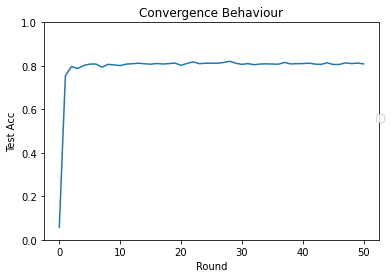

In [ ]:
plot_convergence_behaviour_from_centralized_evaluation(centralized_test_accs)

In [ ]:
ultimate_centralized_y_preds = centralized_y_preds[-1]

In [ ]:
print(report_classification_macro_averages(y_test, ultimate_centralized_y_preds))

              precision    recall  f1-score  
   macro avg       0.63      0.71      0.66     


### Centralized Evaluation with Data Sharing

In [ ]:
# Overrides to global experiment config
DATA_SHARING = True

In [ ]:
# Split client part of train set into NUMBER_OF_CLIENTS partitions.
partitioned_train_set = get_train_partitions(X_train, y_train.to_numpy())

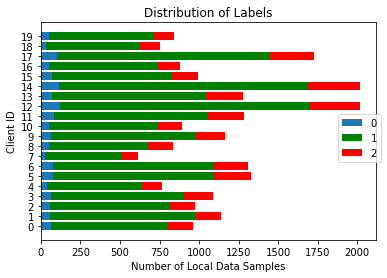

In [ ]:
plot_distribution_of_labels(partitioned_train_set)

In [ ]:
# Run sim with global config
sim_results = run_sim(partitioned_train_set)

INFO flower 2022-03-06 23:48:35,471 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-03-06 23:48:35,477 | server.py:128 | Initializing global parameters
INFO flower 2022-03-06 23:48:35,480 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 78197


INFO flower 2022-03-06 23:48:37,497 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:48:37,501 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:48:37,505 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-03-06 23:48:37,509 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-03-06 23:48:37,511 | server.py:130 | Evaluating initial parameters


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:48:37,582 | server.py:137 | initial parameters (loss, other metrics): 0.5908894249060956, {'accuracy': 0.7696651875756353}
INFO flower 2022-03-06 23:48:37,589 | server.py:143 | FL starting


initializing Client1 with pid 78258


INFO flower 2022-03-06 23:48:38,527 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:48:38,532 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:48:38,535 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 78288


INFO flower 2022-03-06 23:48:39,559 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:48:39,563 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:48:39,565 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 78320


INFO flower 2022-03-06 23:48:40,592 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:48:40,596 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:48:40,598 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-03-06 23:48:40,600 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 78356


INFO flower 2022-03-06 23:48:41,626 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:48:41,631 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:48:41,634 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-03-06 23:48:41,635 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 78394


INFO flower 2022-03-06 23:48:42,660 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:48:42,663 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:48:42,666 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 78432


INFO flower 2022-03-06 23:48:43,692 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:48:43,696 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:48:43,698 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 78472


INFO flower 2022-03-06 23:48:44,725 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:48:44,729 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:48:44,731 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-03-06 23:48:44,733 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 78516


INFO flower 2022-03-06 23:48:45,755 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:48:45,759 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:48:45,763 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 78560


INFO flower 2022-03-06 23:48:46,788 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:48:46,794 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:48:46,797 | connection.py:39 | ChannelConnectivity.READY


initializing Client10 with pid 78606


INFO flower 2022-03-06 23:48:47,823 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:48:47,828 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:48:47,832 | connection.py:39 | ChannelConnectivity.READY


initializing Client11 with pid 78657


INFO flower 2022-03-06 23:48:48,866 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:48:48,871 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:48:48,873 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-03-06 23:48:48,875 | connection.py:39 | ChannelConnectivity.READY


initializing Client12 with pid 78709


INFO flower 2022-03-06 23:48:49,899 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:48:49,902 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:48:49,906 | connection.py:39 | ChannelConnectivity.READY


initializing Client13 with pid 78761


INFO flower 2022-03-06 23:48:50,931 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:48:50,935 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:48:50,938 | connection.py:39 | ChannelConnectivity.READY


initializing Client14 with pid 78815


INFO flower 2022-03-06 23:48:51,961 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:48:51,965 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:48:51,967 | connection.py:39 | ChannelConnectivity.READY


initializing Client15 with pid 78871


INFO flower 2022-03-06 23:48:52,998 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:48:53,002 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:48:53,005 | connection.py:39 | ChannelConnectivity.READY


initializing Client16 with pid 78930


INFO flower 2022-03-06 23:48:54,031 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:48:54,035 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:48:54,038 | connection.py:39 | ChannelConnectivity.READY


initializing Client17 with pid 78990


INFO flower 2022-03-06 23:48:55,067 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:48:55,072 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:48:55,076 | connection.py:39 | ChannelConnectivity.READY


initializing Client18 with pid 79052


INFO flower 2022-03-06 23:48:56,104 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:48:56,108 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:48:56,111 | connection.py:39 | ChannelConnectivity.READY


initializing Client19 with pid 79116


INFO flower 2022-03-06 23:48:57,138 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:48:57,145 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:48:57,145 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)
DEBUG flower 2022-03-06 23:48:57,147 | connection.py:39 | ChannelConnectivity.READY


Client18 with pid 79052 is sampled in training rnd 1
Client2 with pid 78288 is sampled in training rnd 1
Client8 with pid 78516 is sampled in training rnd 1
Client3 with pid 78320 is sampled in training rnd 1
Client15 with pid 78871 is sampled in training rnd 1
Client12 with pid 78709 is sampled in training rnd 1
Client13 with pid 78761 is sampled in training rnd 1
Client7 with pid 78472 is sampled in training rnd 1
Client10 with pid 78606 is sampled in training rnd 1
Client6 with pid 78432 is sampled in training rnd 1
Client16 with pid 78930 is sampled in training rnd 1
Client1 with pid 78258 is sampled in training rnd 1
Client14 with pid 78815 is sampled in training rnd 1
Client0 with pid 78197 is sampled in training rnd 1


DEBUG flower 2022-03-06 23:48:58,438 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:48:58,562 | server.py:164 | fit progress: (1, 0.5634742037528174, {'accuracy': 0.7862041145623235}, 20.966448367995326)
INFO flower 2022-03-06 23:48:58,569 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:48:58,575 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client12 with pid 78709 is sampled in training rnd 2
Client0 with pid 78197 is sampled in training rnd 2
Client14 with pid 78815 is sampled in training rnd 2
Client13 with pid 78761 is sampled in training rnd 2
Client8 with pid 78516 is sampled in training rnd 2
Client19 with pid 79116 is sampled in training rnd 2
Client3 with pid 78320 is sampled in training rnd 2
Client9 with pid 78560 is sampled in training rnd 2
Client11 with pid 78657 is sampled in training rnd 2
Client1 with pid 78258 is sampled in training rnd 2
Client5 with pid 78394 is sampled in training rnd 2
Client17 with pid 78990 is sampled in training rnd 2
Client15 with pid 78871 is sampled in training rnd 2
Client7 with pid 78472 is sampled in training rnd 2


DEBUG flower 2022-03-06 23:49:00,097 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:49:00,225 | server.py:164 | fit progress: (2, 0.5591307600920029, {'accuracy': 0.7930617184348527}, 22.629991240995878)
INFO flower 2022-03-06 23:49:00,229 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:49:00,234 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client0 with pid 78197 is sampled in training rnd 3
Client12 with pid 78709 is sampled in training rnd 3
Client17 with pid 78990 is sampled in training rnd 3
Client13 with pid 78761 is sampled in training rnd 3
Client11 with pid 78657 is sampled in training rnd 3
Client6 with pid 78432 is sampled in training rnd 3
Client18 with pid 79052 is sampled in training rnd 3
Client8 with pid 78516 is sampled in training rnd 3
Client7 with pid 78472 is sampled in training rnd 3
Client3 with pid 78320 is sampled in training rnd 3
Client10 with pid 78606 is sampled in training rnd 3
Client19 with pid 79116 is sampled in training rnd 3
Client14 with pid 78815 is sampled in training rnd 3
Client2 with pid 78288 is sampled in training rnd 3


DEBUG flower 2022-03-06 23:49:01,765 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:49:01,881 | server.py:164 | fit progress: (3, 0.5483961087075508, {'accuracy': 0.7979023799919323}, 24.285880816001736)
INFO flower 2022-03-06 23:49:01,884 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:49:01,887 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client7 with pid 78472 is sampled in training rnd 4
Client14 with pid 78815 is sampled in training rnd 4
Client19 with pid 79116 is sampled in training rnd 4
Client9 with pid 78560 is sampled in training rnd 4
Client0 with pid 78197 is sampled in training rnd 4
Client1 with pid 78258 is sampled in training rnd 4
Client8 with pid 78516 is sampled in training rnd 4
Client13 with pid 78761 is sampled in training rnd 4
Client10 with pid 78606 is sampled in training rnd 4
Client6 with pid 78432 is sampled in training rnd 4
Client11 with pid 78657 is sampled in training rnd 4
Client4 with pid 78356 is sampled in training rnd 4
Client2 with pid 78288 is sampled in training rnd 4
Client5 with pid 78394 is sampled in training rnd 4


DEBUG flower 2022-03-06 23:49:03,390 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:49:03,513 | server.py:164 | fit progress: (4, 0.5363075262051302, {'accuracy': 0.8047599838644615}, 25.917547894001473)
INFO flower 2022-03-06 23:49:03,518 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:49:03,523 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client10 with pid 78606 is sampled in training rnd 5
Client16 with pid 78930 is sampled in training rnd 5
Client13 with pid 78761 is sampled in training rnd 5
Client18 with pid 79052 is sampled in training rnd 5
Client6 with pid 78432 is sampled in training rnd 5
Client4 with pid 78356 is sampled in training rnd 5
Client9 with pid 78560 is sampled in training rnd 5
Client14 with pid 78815 is sampled in training rnd 5
Client7 with pid 78472 is sampled in training rnd 5
Client8 with pid 78516 is sampled in training rnd 5
Client15 with pid 78871 is sampled in training rnd 5
Client0 with pid 78197 is sampled in training rnd 5
Client11 with pid 78657 is sampled in training rnd 5
Client1 with pid 78258 is sampled in training rnd 5


DEBUG flower 2022-03-06 23:49:05,007 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:49:05,097 | server.py:164 | fit progress: (5, 0.5358161628262342, {'accuracy': 0.8023396530859217}, 27.501194012998894)
INFO flower 2022-03-06 23:49:05,105 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:49:05,110 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client12 with pid 78709 is sampled in training rnd 6
Client13 with pid 78761 is sampled in training rnd 6
Client5 with pid 78394 is sampled in training rnd 6
Client11 with pid 78657 is sampled in training rnd 6
Client1 with pid 78258 is sampled in training rnd 6
Client16 with pid 78930 is sampled in training rnd 6
Client7 with pid 78472 is sampled in training rnd 6
Client8 with pid 78516 is sampled in training rnd 6
Client10 with pid 78606 is sampled in training rnd 6
Client2 with pid 78288 is sampled in training rnd 6
Client14 with pid 78815 is sampled in training rnd 6
Client15 with pid 78871 is sampled in training rnd 6
Client6 with pid 78432 is sampled in training rnd 6
Client9 with pid 78560 is sampled in training rnd 6


DEBUG flower 2022-03-06 23:49:06,557 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:49:06,671 | server.py:164 | fit progress: (6, 0.5311704901316068, {'accuracy': 0.8055667607906414}, 29.075782022999192)
INFO flower 2022-03-06 23:49:06,677 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:49:06,679 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client0 with pid 78197 is sampled in training rnd 7
Client15 with pid 78871 is sampled in training rnd 7
Client19 with pid 79116 is sampled in training rnd 7
Client1 with pid 78258 is sampled in training rnd 7
Client9 with pid 78560 is sampled in training rnd 7
Client13 with pid 78761 is sampled in training rnd 7
Client11 with pid 78657 is sampled in training rnd 7
Client17 with pid 78990 is sampled in training rnd 7
Client12 with pid 78709 is sampled in training rnd 7
Client14 with pid 78815 is sampled in training rnd 7
Client6 with pid 78432 is sampled in training rnd 7
Client2 with pid 78288 is sampled in training rnd 7
Client8 with pid 78516 is sampled in training rnd 7
Client4 with pid 78356 is sampled in training rnd 7


DEBUG flower 2022-03-06 23:49:08,162 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:49:08,296 | server.py:164 | fit progress: (7, 0.5408234883021804, {'accuracy': 0.800322710770472}, 30.70072840499779)
INFO flower 2022-03-06 23:49:08,298 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:49:08,302 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client7 with pid 78472 is sampled in training rnd 8
Client0 with pid 78197 is sampled in training rnd 8
Client19 with pid 79116 is sampled in training rnd 8
Client12 with pid 78709 is sampled in training rnd 8
Client6 with pid 78432 is sampled in training rnd 8
Client8 with pid 78516 is sampled in training rnd 8
Client5 with pid 78394 is sampled in training rnd 8
Client9 with pid 78560 is sampled in training rnd 8
Client13 with pid 78761 is sampled in training rnd 8
Client16 with pid 78930 is sampled in training rnd 8
Client4 with pid 78356 is sampled in training rnd 8
Client14 with pid 78815 is sampled in training rnd 8
Client18 with pid 79052 is sampled in training rnd 8
Client3 with pid 78320 is sampled in training rnd 8


DEBUG flower 2022-03-06 23:49:09,754 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:49:09,849 | server.py:164 | fit progress: (8, 0.5347282108841621, {'accuracy': 0.7970956030657523}, 32.253576827999495)
INFO flower 2022-03-06 23:49:09,861 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:49:09,868 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client16 with pid 78930 is sampled in training rnd 9
Client4 with pid 78356 is sampled in training rnd 9
Client19 with pid 79116 is sampled in training rnd 9
Client6 with pid 78432 is sampled in training rnd 9
Client13 with pid 78761 is sampled in training rnd 9
Client0 with pid 78197 is sampled in training rnd 9
Client7 with pid 78472 is sampled in training rnd 9
Client5 with pid 78394 is sampled in training rnd 9
Client9 with pid 78560 is sampled in training rnd 9
Client8 with pid 78516 is sampled in training rnd 9
Client3 with pid 78320 is sampled in training rnd 9
Client10 with pid 78606 is sampled in training rnd 9
Client17 with pid 78990 is sampled in training rnd 9
Client11 with pid 78657 is sampled in training rnd 9


DEBUG flower 2022-03-06 23:49:11,300 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:49:11,391 | server.py:164 | fit progress: (9, 0.5308265442891036, {'accuracy': 0.8051633723275514}, 33.79550081399793)
INFO flower 2022-03-06 23:49:11,396 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:49:11,402 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client11 with pid 78657 is sampled in training rnd 10
Client13 with pid 78761 is sampled in training rnd 10
Client19 with pid 79116 is sampled in training rnd 10
Client0 with pid 78197 is sampled in training rnd 10
Client7 with pid 78472 is sampled in training rnd 10
Client9 with pid 78560 is sampled in training rnd 10
Client16 with pid 78930 is sampled in training rnd 10
Client10 with pid 78606 is sampled in training rnd 10
Client3 with pid 78320 is sampled in training rnd 10
Client15 with pid 78871 is sampled in training rnd 10
Client2 with pid 78288 is sampled in training rnd 10
Client8 with pid 78516 is sampled in training rnd 10
Client18 with pid 79052 is sampled in training rnd 10
Client6 with pid 78432 is sampled in training rnd 10


DEBUG flower 2022-03-06 23:49:12,786 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:49:12,913 | server.py:164 | fit progress: (10, 0.5147602416299736, {'accuracy': 0.8100040338846309}, 35.3181637480011)
INFO flower 2022-03-06 23:49:12,923 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:49:12,929 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client2 with pid 78288 is sampled in training rnd 11
Client8 with pid 78516 is sampled in training rnd 11
Client19 with pid 79116 is sampled in training rnd 11
Client17 with pid 78990 is sampled in training rnd 11
Client16 with pid 78930 is sampled in training rnd 11
Client1 with pid 78258 is sampled in training rnd 11
Client13 with pid 78761 is sampled in training rnd 11
Client0 with pid 78197 is sampled in training rnd 11
Client7 with pid 78472 is sampled in training rnd 11
Client12 with pid 78709 is sampled in training rnd 11
Client4 with pid 78356 is sampled in training rnd 11
Client3 with pid 78320 is sampled in training rnd 11
Client9 with pid 78560 is sampled in training rnd 11
Client10 with pid 78606 is sampled in training rnd 11


DEBUG flower 2022-03-06 23:49:14,373 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:49:14,487 | server.py:164 | fit progress: (11, 0.52013882131726, {'accuracy': 0.8087938684953611}, 36.89192143599939)
INFO flower 2022-03-06 23:49:14,493 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:49:14,494 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client5 with pid 78394 is sampled in training rnd 12
Client11 with pid 78657 is sampled in training rnd 12
Client19 with pid 79116 is sampled in training rnd 12
Client9 with pid 78560 is sampled in training rnd 12
Client2 with pid 78288 is sampled in training rnd 12
Client15 with pid 78871 is sampled in training rnd 12
Client4 with pid 78356 is sampled in training rnd 12
Client13 with pid 78761 is sampled in training rnd 12
Client8 with pid 78516 is sampled in training rnd 12
Client12 with pid 78709 is sampled in training rnd 12
Client14 with pid 78815 is sampled in training rnd 12
Client16 with pid 78930 is sampled in training rnd 12
Client7 with pid 78472 is sampled in training rnd 12
Client18 with pid 79052 is sampled in training rnd 12


DEBUG flower 2022-03-06 23:49:15,932 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:49:16,059 | server.py:164 | fit progress: (12, 0.5329181299457532, {'accuracy': 0.7987091569181122}, 38.463960692999535)
INFO flower 2022-03-06 23:49:16,061 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:49:16,062 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client15 with pid 78871 is sampled in training rnd 13
Client10 with pid 78606 is sampled in training rnd 13
Client18 with pid 79052 is sampled in training rnd 13
Client3 with pid 78320 is sampled in training rnd 13
Client0 with pid 78197 is sampled in training rnd 13
Client4 with pid 78356 is sampled in training rnd 13
Client6 with pid 78432 is sampled in training rnd 13
Client5 with pid 78394 is sampled in training rnd 13
Client13 with pid 78761 is sampled in training rnd 13
Client14 with pid 78815 is sampled in training rnd 13
Client16 with pid 78930 is sampled in training rnd 13
Client1 with pid 78258 is sampled in training rnd 13
Client9 with pid 78560 is sampled in training rnd 13
Client12 with pid 78709 is sampled in training rnd 13


DEBUG flower 2022-03-06 23:49:17,593 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:49:17,710 | server.py:164 | fit progress: (13, 0.5290470341198985, {'accuracy': 0.8031464300121016}, 40.11427075100073)
INFO flower 2022-03-06 23:49:17,711 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:49:17,713 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client6 with pid 78432 is sampled in training rnd 14
Client13 with pid 78761 is sampled in training rnd 14
Client16 with pid 78930 is sampled in training rnd 14
Client0 with pid 78197 is sampled in training rnd 14
Client19 with pid 79116 is sampled in training rnd 14
Client7 with pid 78472 is sampled in training rnd 14
Client15 with pid 78871 is sampled in training rnd 14
Client12 with pid 78709 is sampled in training rnd 14
Client14 with pid 78815 is sampled in training rnd 14
Client2 with pid 78288 is sampled in training rnd 14
Client18 with pid 79052 is sampled in training rnd 14
Client8 with pid 78516 is sampled in training rnd 14
Client17 with pid 78990 is sampled in training rnd 14
Client4 with pid 78356 is sampled in training rnd 14


DEBUG flower 2022-03-06 23:49:19,118 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:49:19,232 | server.py:164 | fit progress: (14, 0.527547595937242, {'accuracy': 0.8051633723275514}, 41.636179929999344)
INFO flower 2022-03-06 23:49:19,239 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:49:19,241 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client7 with pid 78472 is sampled in training rnd 15
Client16 with pid 78930 is sampled in training rnd 15
Client14 with pid 78815 is sampled in training rnd 15
Client19 with pid 79116 is sampled in training rnd 15
Client0 with pid 78197 is sampled in training rnd 15
Client10 with pid 78606 is sampled in training rnd 15
Client6 with pid 78432 is sampled in training rnd 15
Client9 with pid 78560 is sampled in training rnd 15
Client5 with pid 78394 is sampled in training rnd 15
Client13 with pid 78761 is sampled in training rnd 15
Client17 with pid 78990 is sampled in training rnd 15
Client15 with pid 78871 is sampled in training rnd 15
Client4 with pid 78356 is sampled in training rnd 15
Client1 with pid 78258 is sampled in training rnd 15


DEBUG flower 2022-03-06 23:49:20,757 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:49:20,837 | server.py:164 | fit progress: (15, 0.5324104489485443, {'accuracy': 0.800726099233562}, 43.241354544996284)
INFO flower 2022-03-06 23:49:20,843 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:49:20,852 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client6 with pid 78432 is sampled in training rnd 16
Client9 with pid 78560 is sampled in training rnd 16
Client1 with pid 78258 is sampled in training rnd 16
Client2 with pid 78288 is sampled in training rnd 16
Client16 with pid 78930 is sampled in training rnd 16
Client4 with pid 78356 is sampled in training rnd 16
Client14 with pid 78815 is sampled in training rnd 16
Client11 with pid 78657 is sampled in training rnd 16
Client15 with pid 78871 is sampled in training rnd 16
Client19 with pid 79116 is sampled in training rnd 16
Client17 with pid 78990 is sampled in training rnd 16
Client13 with pid 78761 is sampled in training rnd 16
Client12 with pid 78709 is sampled in training rnd 16
Client0 with pid 78197 is sampled in training rnd 16


DEBUG flower 2022-03-06 23:49:22,394 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:49:22,522 | server.py:164 | fit progress: (16, 0.5375419380249883, {'accuracy': 0.7987091569181122}, 44.92693729199527)
INFO flower 2022-03-06 23:49:22,528 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:49:22,530 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client17 with pid 78990 is sampled in training rnd 17
Client1 with pid 78258 is sampled in training rnd 17
Client6 with pid 78432 is sampled in training rnd 17
Client14 with pid 78815 is sampled in training rnd 17
Client5 with pid 78394 is sampled in training rnd 17
Client13 with pid 78761 is sampled in training rnd 17
Client16 with pid 78930 is sampled in training rnd 17
Client12 with pid 78709 is sampled in training rnd 17
Client11 with pid 78657 is sampled in training rnd 17
Client9 with pid 78560 is sampled in training rnd 17
Client8 with pid 78516 is sampled in training rnd 17
Client0 with pid 78197 is sampled in training rnd 17
Client19 with pid 79116 is sampled in training rnd 17
Client18 with pid 79052 is sampled in training rnd 17


DEBUG flower 2022-03-06 23:49:24,059 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:49:24,195 | server.py:164 | fit progress: (17, 0.536925140922133, {'accuracy': 0.8035498184751916}, 46.59929443099827)
INFO flower 2022-03-06 23:49:24,199 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:49:24,201 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client11 with pid 78657 is sampled in training rnd 18
Client6 with pid 78432 is sampled in training rnd 18
Client13 with pid 78761 is sampled in training rnd 18
Client7 with pid 78472 is sampled in training rnd 18
Client3 with pid 78320 is sampled in training rnd 18
Client17 with pid 78990 is sampled in training rnd 18
Client1 with pid 78258 is sampled in training rnd 18
Client10 with pid 78606 is sampled in training rnd 18
Client15 with pid 78871 is sampled in training rnd 18
Client4 with pid 78356 is sampled in training rnd 18
Client8 with pid 78516 is sampled in training rnd 18
Client14 with pid 78815 is sampled in training rnd 18
Client0 with pid 78197 is sampled in training rnd 18
Client2 with pid 78288 is sampled in training rnd 18


DEBUG flower 2022-03-06 23:49:25,639 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:49:25,734 | server.py:164 | fit progress: (18, 0.5201735994441304, {'accuracy': 0.8083904800322711}, 48.13873778699781)
INFO flower 2022-03-06 23:49:25,740 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:49:25,759 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client12 with pid 78709 is sampled in training rnd 19
Client19 with pid 79116 is sampled in training rnd 19
Client5 with pid 78394 is sampled in training rnd 19
Client9 with pid 78560 is sampled in training rnd 19
Client13 with pid 78761 is sampled in training rnd 19
Client3 with pid 78320 is sampled in training rnd 19
Client15 with pid 78871 is sampled in training rnd 19
Client0 with pid 78197 is sampled in training rnd 19
Client17 with pid 78990 is sampled in training rnd 19
Client2 with pid 78288 is sampled in training rnd 19
Client18 with pid 79052 is sampled in training rnd 19
Client6 with pid 78432 is sampled in training rnd 19
Client14 with pid 78815 is sampled in training rnd 19
Client10 with pid 78606 is sampled in training rnd 19


DEBUG flower 2022-03-06 23:49:27,366 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:49:27,496 | server.py:164 | fit progress: (19, 0.5423122650343739, {'accuracy': 0.7983057684550222}, 49.90020676499989)
INFO flower 2022-03-06 23:49:27,498 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:49:27,503 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client3 with pid 78320 is sampled in training rnd 20
Client12 with pid 78709 is sampled in training rnd 20
Client17 with pid 78990 is sampled in training rnd 20
Client11 with pid 78657 is sampled in training rnd 20
Client15 with pid 78871 is sampled in training rnd 20
Client18 with pid 79052 is sampled in training rnd 20
Client8 with pid 78516 is sampled in training rnd 20
Client19 with pid 79116 is sampled in training rnd 20
Client1 with pid 78258 is sampled in training rnd 20
Client0 with pid 78197 is sampled in training rnd 20
Client16 with pid 78930 is sampled in training rnd 20
Client2 with pid 78288 is sampled in training rnd 20
Client13 with pid 78761 is sampled in training rnd 20
Client9 with pid 78560 is sampled in training rnd 20


DEBUG flower 2022-03-06 23:49:29,030 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:49:29,156 | server.py:164 | fit progress: (20, 0.5231543999626738, {'accuracy': 0.8112141992739008}, 51.560371157997)
INFO flower 2022-03-06 23:49:29,157 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:49:29,164 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client17 with pid 78990 is sampled in training rnd 21
Client6 with pid 78432 is sampled in training rnd 21
Client5 with pid 78394 is sampled in training rnd 21
Client8 with pid 78516 is sampled in training rnd 21
Client19 with pid 79116 is sampled in training rnd 21
Client10 with pid 78606 is sampled in training rnd 21
Client14 with pid 78815 is sampled in training rnd 21
Client13 with pid 78761 is sampled in training rnd 21
Client1 with pid 78258 is sampled in training rnd 21
Client4 with pid 78356 is sampled in training rnd 21
Client3 with pid 78320 is sampled in training rnd 21
Client7 with pid 78472 is sampled in training rnd 21
Client2 with pid 78288 is sampled in training rnd 21
Client16 with pid 78930 is sampled in training rnd 21


DEBUG flower 2022-03-06 23:49:30,659 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:49:30,765 | server.py:164 | fit progress: (21, 0.5252539318595136, {'accuracy': 0.8063735377168213}, 53.169418596997275)
INFO flower 2022-03-06 23:49:30,768 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:49:30,777 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client17 with pid 78990 is sampled in training rnd 22
Client10 with pid 78606 is sampled in training rnd 22
Client1 with pid 78258 is sampled in training rnd 22
Client3 with pid 78320 is sampled in training rnd 22
Client16 with pid 78930 is sampled in training rnd 22
Client6 with pid 78432 is sampled in training rnd 22
Client13 with pid 78761 is sampled in training rnd 22
Client12 with pid 78709 is sampled in training rnd 22
Client2 with pid 78288 is sampled in training rnd 22
Client5 with pid 78394 is sampled in training rnd 22
Client11 with pid 78657 is sampled in training rnd 22
Client14 with pid 78815 is sampled in training rnd 22
Client15 with pid 78871 is sampled in training rnd 22
Client0 with pid 78197 is sampled in training rnd 22


DEBUG flower 2022-03-06 23:49:32,339 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:49:32,441 | server.py:164 | fit progress: (22, 0.5428769635967612, {'accuracy': 0.8031464300121016}, 54.84537160999753)
INFO flower 2022-03-06 23:49:32,447 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:49:32,455 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client18 with pid 79052 is sampled in training rnd 23
Client17 with pid 78990 is sampled in training rnd 23
Client7 with pid 78472 is sampled in training rnd 23
Client2 with pid 78288 is sampled in training rnd 23
Client5 with pid 78394 is sampled in training rnd 23
Client4 with pid 78356 is sampled in training rnd 23
Client8 with pid 78516 is sampled in training rnd 23
Client9 with pid 78560 is sampled in training rnd 23
Client15 with pid 78871 is sampled in training rnd 23
Client1 with pid 78258 is sampled in training rnd 23
Client19 with pid 79116 is sampled in training rnd 23
Client13 with pid 78761 is sampled in training rnd 23
Client10 with pid 78606 is sampled in training rnd 23
Client6 with pid 78432 is sampled in training rnd 23


DEBUG flower 2022-03-06 23:49:33,803 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:49:33,933 | server.py:164 | fit progress: (23, 0.5240543478233788, {'accuracy': 0.8112141992739008}, 56.33764675400016)
INFO flower 2022-03-06 23:49:33,939 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:49:33,943 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client1 with pid 78258 is sampled in training rnd 24
Client9 with pid 78560 is sampled in training rnd 24
Client0 with pid 78197 is sampled in training rnd 24
Client17 with pid 78990 is sampled in training rnd 24
Client2 with pid 78288 is sampled in training rnd 24
Client6 with pid 78432 is sampled in training rnd 24
Client19 with pid 79116 is sampled in training rnd 24
Client12 with pid 78709 is sampled in training rnd 24
Client16 with pid 78930 is sampled in training rnd 24
Client3 with pid 78320 is sampled in training rnd 24
Client10 with pid 78606 is sampled in training rnd 24
Client14 with pid 78815 is sampled in training rnd 24
Client15 with pid 78871 is sampled in training rnd 24
Client11 with pid 78657 is sampled in training rnd 24


DEBUG flower 2022-03-06 23:49:35,403 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:49:35,519 | server.py:164 | fit progress: (24, 0.53545512846636, {'accuracy': 0.8019362646228317}, 57.9234478569997)
INFO flower 2022-03-06 23:49:35,525 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:49:35,529 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client14 with pid 78815 is sampled in training rnd 25
Client5 with pid 78394 is sampled in training rnd 25
Client7 with pid 78472 is sampled in training rnd 25
Client3 with pid 78320 is sampled in training rnd 25
Client18 with pid 79052 is sampled in training rnd 25
Client6 with pid 78432 is sampled in training rnd 25
Client12 with pid 78709 is sampled in training rnd 25
Client8 with pid 78516 is sampled in training rnd 25
Client19 with pid 79116 is sampled in training rnd 25
Client11 with pid 78657 is sampled in training rnd 25
Client10 with pid 78606 is sampled in training rnd 25
Client4 with pid 78356 is sampled in training rnd 25
Client17 with pid 78990 is sampled in training rnd 25
Client2 with pid 78288 is sampled in training rnd 25


DEBUG flower 2022-03-06 23:49:37,117 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:49:37,235 | server.py:164 | fit progress: (25, 0.5436203228011798, {'accuracy': 0.8035498184751916}, 59.63966690799862)
INFO flower 2022-03-06 23:49:37,241 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:49:37,244 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client3 with pid 78320 is sampled in training rnd 26
Client10 with pid 78606 is sampled in training rnd 26
Client1 with pid 78258 is sampled in training rnd 26
Client6 with pid 78432 is sampled in training rnd 26
Client15 with pid 78871 is sampled in training rnd 26
Client0 with pid 78197 is sampled in training rnd 26
Client12 with pid 78709 is sampled in training rnd 26
Client4 with pid 78356 is sampled in training rnd 26
Client11 with pid 78657 is sampled in training rnd 26
Client9 with pid 78560 is sampled in training rnd 26
Client5 with pid 78394 is sampled in training rnd 26
Client7 with pid 78472 is sampled in training rnd 26
Client18 with pid 79052 is sampled in training rnd 26
Client2 with pid 78288 is sampled in training rnd 26


DEBUG flower 2022-03-06 23:49:38,708 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:49:38,796 | server.py:164 | fit progress: (26, 0.516971679379404, {'accuracy': 0.8148446954417103}, 61.200859595999646)
INFO flower 2022-03-06 23:49:38,804 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:49:38,810 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client12 with pid 78709 is sampled in training rnd 27
Client2 with pid 78288 is sampled in training rnd 27
Client18 with pid 79052 is sampled in training rnd 27
Client4 with pid 78356 is sampled in training rnd 27
Client14 with pid 78815 is sampled in training rnd 27
Client1 with pid 78258 is sampled in training rnd 27
Client3 with pid 78320 is sampled in training rnd 27
Client10 with pid 78606 is sampled in training rnd 27
Client9 with pid 78560 is sampled in training rnd 27
Client8 with pid 78516 is sampled in training rnd 27
Client7 with pid 78472 is sampled in training rnd 27
Client5 with pid 78394 is sampled in training rnd 27
Client13 with pid 78761 is sampled in training rnd 27
Client15 with pid 78871 is sampled in training rnd 27


DEBUG flower 2022-03-06 23:49:40,259 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:49:40,388 | server.py:164 | fit progress: (27, 0.5195655312487784, {'accuracy': 0.8108108108108109}, 62.79217161300039)
INFO flower 2022-03-06 23:49:40,389 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:49:40,400 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client6 with pid 78432 is sampled in training rnd 28
Client17 with pid 78990 is sampled in training rnd 28
Client9 with pid 78560 is sampled in training rnd 28
Client18 with pid 79052 is sampled in training rnd 28
Client5 with pid 78394 is sampled in training rnd 28
Client7 with pid 78472 is sampled in training rnd 28
Client1 with pid 78258 is sampled in training rnd 28
Client4 with pid 78356 is sampled in training rnd 28
Client13 with pid 78761 is sampled in training rnd 28
Client15 with pid 78871 is sampled in training rnd 28
Client11 with pid 78657 is sampled in training rnd 28
Client14 with pid 78815 is sampled in training rnd 28
Client3 with pid 78320 is sampled in training rnd 28
Client10 with pid 78606 is sampled in training rnd 28


DEBUG flower 2022-03-06 23:49:42,147 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:49:42,305 | server.py:164 | fit progress: (28, 0.5404814330247956, {'accuracy': 0.8011294876966518}, 64.70999499799655)
INFO flower 2022-03-06 23:49:42,323 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:49:42,340 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client1 with pid 78258 is sampled in training rnd 29
Client9 with pid 78560 is sampled in training rnd 29
Client10 with pid 78606 is sampled in training rnd 29
Client5 with pid 78394 is sampled in training rnd 29
Client17 with pid 78990 is sampled in training rnd 29
Client12 with pid 78709 is sampled in training rnd 29
Client13 with pid 78761 is sampled in training rnd 29
Client19 with pid 79116 is sampled in training rnd 29
Client4 with pid 78356 is sampled in training rnd 29
Client3 with pid 78320 is sampled in training rnd 29
Client16 with pid 78930 is sampled in training rnd 29
Client18 with pid 79052 is sampled in training rnd 29
Client8 with pid 78516 is sampled in training rnd 29
Client7 with pid 78472 is sampled in training rnd 29


DEBUG flower 2022-03-06 23:49:43,803 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:49:43,944 | server.py:164 | fit progress: (29, 0.5268238980493849, {'accuracy': 0.8055667607906414}, 66.34890219099907)
INFO flower 2022-03-06 23:49:43,949 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:49:43,951 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client0 with pid 78197 is sampled in training rnd 30
Client7 with pid 78472 is sampled in training rnd 30
Client19 with pid 79116 is sampled in training rnd 30
Client12 with pid 78709 is sampled in training rnd 30
Client2 with pid 78288 is sampled in training rnd 30
Client4 with pid 78356 is sampled in training rnd 30
Client8 with pid 78516 is sampled in training rnd 30
Client11 with pid 78657 is sampled in training rnd 30
Client1 with pid 78258 is sampled in training rnd 30
Client16 with pid 78930 is sampled in training rnd 30
Client18 with pid 79052 is sampled in training rnd 30
Client14 with pid 78815 is sampled in training rnd 30
Client9 with pid 78560 is sampled in training rnd 30
Client6 with pid 78432 is sampled in training rnd 30


DEBUG flower 2022-03-06 23:49:45,434 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:49:45,552 | server.py:164 | fit progress: (30, 0.5195059995373844, {'accuracy': 0.8108108108108109}, 67.95680028799688)
INFO flower 2022-03-06 23:49:45,554 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:49:45,559 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client11 with pid 78657 is sampled in training rnd 31
Client15 with pid 78871 is sampled in training rnd 31
Client18 with pid 79052 is sampled in training rnd 31
Client4 with pid 78356 is sampled in training rnd 31
Client3 with pid 78320 is sampled in training rnd 31
Client8 with pid 78516 is sampled in training rnd 31
Client12 with pid 78709 is sampled in training rnd 31
Client13 with pid 78761 is sampled in training rnd 31
Client1 with pid 78258 is sampled in training rnd 31
Client5 with pid 78394 is sampled in training rnd 31
Client14 with pid 78815 is sampled in training rnd 31
Client2 with pid 78288 is sampled in training rnd 31
Client6 with pid 78432 is sampled in training rnd 31
Client9 with pid 78560 is sampled in training rnd 31


DEBUG flower 2022-03-06 23:49:47,075 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:49:47,203 | server.py:164 | fit progress: (31, 0.5383771868411737, {'accuracy': 0.799919322307382}, 69.60733903499931)
INFO flower 2022-03-06 23:49:47,207 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:49:47,213 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client4 with pid 78356 is sampled in training rnd 32
Client19 with pid 79116 is sampled in training rnd 32
Client10 with pid 78606 is sampled in training rnd 32
Client3 with pid 78320 is sampled in training rnd 32
Client9 with pid 78560 is sampled in training rnd 32
Client11 with pid 78657 is sampled in training rnd 32
Client8 with pid 78516 is sampled in training rnd 32
Client16 with pid 78930 is sampled in training rnd 32
Client18 with pid 79052 is sampled in training rnd 32
Client2 with pid 78288 is sampled in training rnd 32
Client15 with pid 78871 is sampled in training rnd 32
Client17 with pid 78990 is sampled in training rnd 32
Client0 with pid 78197 is sampled in training rnd 32
Client6 with pid 78432 is sampled in training rnd 32


DEBUG flower 2022-03-06 23:49:48,661 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:49:48,785 | server.py:164 | fit progress: (32, 0.5280392616967908, {'accuracy': 0.8067769261799113}, 71.18943712100008)
INFO flower 2022-03-06 23:49:48,791 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:49:48,802 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client17 with pid 78990 is sampled in training rnd 33
Client10 with pid 78606 is sampled in training rnd 33
Client5 with pid 78394 is sampled in training rnd 33
Client6 with pid 78432 is sampled in training rnd 33
Client9 with pid 78560 is sampled in training rnd 33
Client18 with pid 79052 is sampled in training rnd 33
Client8 with pid 78516 is sampled in training rnd 33
Client2 with pid 78288 is sampled in training rnd 33
Client0 with pid 78197 is sampled in training rnd 33
Client19 with pid 79116 is sampled in training rnd 33
Client4 with pid 78356 is sampled in training rnd 33
Client3 with pid 78320 is sampled in training rnd 33
Client1 with pid 78258 is sampled in training rnd 33
Client16 with pid 78930 is sampled in training rnd 33


DEBUG flower 2022-03-06 23:49:50,172 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:49:50,291 | server.py:164 | fit progress: (33, 0.5190156028114762, {'accuracy': 0.8152480839048003}, 72.6951798989976)
INFO flower 2022-03-06 23:49:50,300 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:49:50,303 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client14 with pid 78815 is sampled in training rnd 34
Client13 with pid 78761 is sampled in training rnd 34
Client17 with pid 78990 is sampled in training rnd 34
Client8 with pid 78516 is sampled in training rnd 34
Client19 with pid 79116 is sampled in training rnd 34
Client18 with pid 79052 is sampled in training rnd 34
Client16 with pid 78930 is sampled in training rnd 34
Client0 with pid 78197 is sampled in training rnd 34
Client7 with pid 78472 is sampled in training rnd 34
Client6 with pid 78432 is sampled in training rnd 34
Client5 with pid 78394 is sampled in training rnd 34
Client2 with pid 78288 is sampled in training rnd 34
Client4 with pid 78356 is sampled in training rnd 34
Client3 with pid 78320 is sampled in training rnd 34


DEBUG flower 2022-03-06 23:49:51,748 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:49:51,891 | server.py:164 | fit progress: (34, 0.5274141184684196, {'accuracy': 0.8100040338846309}, 74.29595914099627)
INFO flower 2022-03-06 23:49:51,894 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:49:51,900 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client0 with pid 78197 is sampled in training rnd 35
Client13 with pid 78761 is sampled in training rnd 35
Client19 with pid 79116 is sampled in training rnd 35
Client1 with pid 78258 is sampled in training rnd 35
Client11 with pid 78657 is sampled in training rnd 35
Client9 with pid 78560 is sampled in training rnd 35
Client2 with pid 78288 is sampled in training rnd 35
Client14 with pid 78815 is sampled in training rnd 35
Client18 with pid 79052 is sampled in training rnd 35
Client15 with pid 78871 is sampled in training rnd 35
Client4 with pid 78356 is sampled in training rnd 35
Client12 with pid 78709 is sampled in training rnd 35
Client6 with pid 78432 is sampled in training rnd 35
Client8 with pid 78516 is sampled in training rnd 35


DEBUG flower 2022-03-06 23:49:53,527 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:49:53,643 | server.py:164 | fit progress: (35, 0.5332338926299208, {'accuracy': 0.8083904800322711}, 76.0477281239946)
INFO flower 2022-03-06 23:49:53,646 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:49:53,649 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client5 with pid 78394 is sampled in training rnd 36
Client2 with pid 78288 is sampled in training rnd 36
Client12 with pid 78709 is sampled in training rnd 36
Client15 with pid 78871 is sampled in training rnd 36
Client7 with pid 78472 is sampled in training rnd 36
Client0 with pid 78197 is sampled in training rnd 36
Client17 with pid 78990 is sampled in training rnd 36
Client8 with pid 78516 is sampled in training rnd 36
Client18 with pid 79052 is sampled in training rnd 36
Client19 with pid 79116 is sampled in training rnd 36
Client16 with pid 78930 is sampled in training rnd 36
Client3 with pid 78320 is sampled in training rnd 36
Client10 with pid 78606 is sampled in training rnd 36
Client13 with pid 78761 is sampled in training rnd 36


DEBUG flower 2022-03-06 23:49:55,177 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:49:55,328 | server.py:164 | fit progress: (36, 0.5136633059927671, {'accuracy': 0.8083904800322711}, 77.73300158199709)
INFO flower 2022-03-06 23:49:55,335 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:49:55,341 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client15 with pid 78871 is sampled in training rnd 37
Client19 with pid 79116 is sampled in training rnd 37
Client7 with pid 78472 is sampled in training rnd 37
Client13 with pid 78761 is sampled in training rnd 37
Client10 with pid 78606 is sampled in training rnd 37
Client9 with pid 78560 is sampled in training rnd 37
Client8 with pid 78516 is sampled in training rnd 37
Client11 with pid 78657 is sampled in training rnd 37
Client4 with pid 78356 is sampled in training rnd 37
Client18 with pid 79052 is sampled in training rnd 37
Client3 with pid 78320 is sampled in training rnd 37
Client0 with pid 78197 is sampled in training rnd 37
Client1 with pid 78258 is sampled in training rnd 37
Client6 with pid 78432 is sampled in training rnd 37


DEBUG flower 2022-03-06 23:49:56,823 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:49:56,942 | server.py:164 | fit progress: (37, 0.5172175239466053, {'accuracy': 0.8148446954417103}, 79.34647427599702)
INFO flower 2022-03-06 23:49:56,949 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:49:56,955 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client16 with pid 78930 is sampled in training rnd 38
Client11 with pid 78657 is sampled in training rnd 38
Client5 with pid 78394 is sampled in training rnd 38
Client19 with pid 79116 is sampled in training rnd 38
Client6 with pid 78432 is sampled in training rnd 38
Client4 with pid 78356 is sampled in training rnd 38
Client14 with pid 78815 is sampled in training rnd 38
Client18 with pid 79052 is sampled in training rnd 38
Client13 with pid 78761 is sampled in training rnd 38
Client8 with pid 78516 is sampled in training rnd 38
Client17 with pid 78990 is sampled in training rnd 38
Client2 with pid 78288 is sampled in training rnd 38
Client7 with pid 78472 is sampled in training rnd 38
Client12 with pid 78709 is sampled in training rnd 38


DEBUG flower 2022-03-06 23:49:58,552 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:49:58,681 | server.py:164 | fit progress: (38, 0.5374167809660598, {'accuracy': 0.800322710770472}, 81.08589550399483)
INFO flower 2022-03-06 23:49:58,691 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:49:58,697 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client2 with pid 78288 is sampled in training rnd 39
Client16 with pid 78930 is sampled in training rnd 39
Client3 with pid 78320 is sampled in training rnd 39
Client12 with pid 78709 is sampled in training rnd 39
Client5 with pid 78394 is sampled in training rnd 39
Client19 with pid 79116 is sampled in training rnd 39
Client6 with pid 78432 is sampled in training rnd 39
Client18 with pid 79052 is sampled in training rnd 39
Client4 with pid 78356 is sampled in training rnd 39
Client9 with pid 78560 is sampled in training rnd 39
Client0 with pid 78197 is sampled in training rnd 39
Client7 with pid 78472 is sampled in training rnd 39
Client17 with pid 78990 is sampled in training rnd 39
Client15 with pid 78871 is sampled in training rnd 39


DEBUG flower 2022-03-06 23:50:00,172 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:50:00,304 | server.py:164 | fit progress: (39, 0.5267644026605204, {'accuracy': 0.8047599838644615}, 82.70828501899814)
INFO flower 2022-03-06 23:50:00,310 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:50:00,316 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client11 with pid 78657 is sampled in training rnd 40
Client12 with pid 78709 is sampled in training rnd 40
Client5 with pid 78394 is sampled in training rnd 40
Client16 with pid 78930 is sampled in training rnd 40
Client8 with pid 78516 is sampled in training rnd 40
Client1 with pid 78258 is sampled in training rnd 40
Client15 with pid 78871 is sampled in training rnd 40
Client4 with pid 78356 is sampled in training rnd 40
Client18 with pid 79052 is sampled in training rnd 40
Client10 with pid 78606 is sampled in training rnd 40
Client19 with pid 79116 is sampled in training rnd 40
Client9 with pid 78560 is sampled in training rnd 40
Client13 with pid 78761 is sampled in training rnd 40
Client7 with pid 78472 is sampled in training rnd 40


DEBUG flower 2022-03-06 23:50:01,862 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:50:01,991 | server.py:164 | fit progress: (40, 0.5194697008041346, {'accuracy': 0.8079870915691811}, 84.39539926200086)
INFO flower 2022-03-06 23:50:02,002 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:50:02,011 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client19 with pid 79116 is sampled in training rnd 41
Client14 with pid 78815 is sampled in training rnd 41
Client2 with pid 78288 is sampled in training rnd 41
Client7 with pid 78472 is sampled in training rnd 41
Client15 with pid 78871 is sampled in training rnd 41
Client18 with pid 79052 is sampled in training rnd 41
Client13 with pid 78761 is sampled in training rnd 41
Client6 with pid 78432 is sampled in training rnd 41
Client5 with pid 78394 is sampled in training rnd 41
Client16 with pid 78930 is sampled in training rnd 41
Client12 with pid 78709 is sampled in training rnd 41
Client11 with pid 78657 is sampled in training rnd 41
Client9 with pid 78560 is sampled in training rnd 41
Client1 with pid 78258 is sampled in training rnd 41


DEBUG flower 2022-03-06 23:50:03,705 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:50:03,801 | server.py:164 | fit progress: (41, 0.5394521801009723, {'accuracy': 0.8043565954013715}, 86.20576850199723)
INFO flower 2022-03-06 23:50:03,815 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:50:03,825 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client3 with pid 78320 is sampled in training rnd 42
Client13 with pid 78761 is sampled in training rnd 42
Client17 with pid 78990 is sampled in training rnd 42
Client19 with pid 79116 is sampled in training rnd 42
Client10 with pid 78606 is sampled in training rnd 42
Client4 with pid 78356 is sampled in training rnd 42
Client18 with pid 79052 is sampled in training rnd 42
Client16 with pid 78930 is sampled in training rnd 42
Client15 with pid 78871 is sampled in training rnd 42
Client6 with pid 78432 is sampled in training rnd 42
Client0 with pid 78197 is sampled in training rnd 42
Client8 with pid 78516 is sampled in training rnd 42
Client11 with pid 78657 is sampled in training rnd 42
Client12 with pid 78709 is sampled in training rnd 42


DEBUG flower 2022-03-06 23:50:05,361 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:50:05,477 | server.py:164 | fit progress: (42, 0.5278521011539509, {'accuracy': 0.800322710770472}, 87.88123323099717)
INFO flower 2022-03-06 23:50:05,481 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:50:05,488 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client14 with pid 78815 is sampled in training rnd 43
Client18 with pid 79052 is sampled in training rnd 43
Client17 with pid 78990 is sampled in training rnd 43
Client0 with pid 78197 is sampled in training rnd 43
Client7 with pid 78472 is sampled in training rnd 43
Client4 with pid 78356 is sampled in training rnd 43
Client3 with pid 78320 is sampled in training rnd 43
Client2 with pid 78288 is sampled in training rnd 43
Client13 with pid 78761 is sampled in training rnd 43
Client19 with pid 79116 is sampled in training rnd 43
Client11 with pid 78657 is sampled in training rnd 43
Client8 with pid 78516 is sampled in training rnd 43
Client12 with pid 78709 is sampled in training rnd 43
Client9 with pid 78560 is sampled in training rnd 43


DEBUG flower 2022-03-06 23:50:07,023 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:50:07,152 | server.py:164 | fit progress: (43, 0.5352060326235236, {'accuracy': 0.8047599838644615}, 89.55664113999956)
INFO flower 2022-03-06 23:50:07,157 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:50:07,159 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client9 with pid 78560 is sampled in training rnd 44
Client8 with pid 78516 is sampled in training rnd 44
Client18 with pid 79052 is sampled in training rnd 44
Client17 with pid 78990 is sampled in training rnd 44
Client14 with pid 78815 is sampled in training rnd 44
Client15 with pid 78871 is sampled in training rnd 44
Client7 with pid 78472 is sampled in training rnd 44
Client6 with pid 78432 is sampled in training rnd 44
Client5 with pid 78394 is sampled in training rnd 44
Client1 with pid 78258 is sampled in training rnd 44
Client3 with pid 78320 is sampled in training rnd 44
Client11 with pid 78657 is sampled in training rnd 44
Client2 with pid 78288 is sampled in training rnd 44
Client19 with pid 79116 is sampled in training rnd 44


DEBUG flower 2022-03-06 23:50:08,683 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:50:08,795 | server.py:164 | fit progress: (44, 0.5264637145593913, {'accuracy': 0.809600645421541}, 91.19923000899871)
INFO flower 2022-03-06 23:50:08,801 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:50:08,806 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client3 with pid 78320 is sampled in training rnd 45
Client0 with pid 78197 is sampled in training rnd 45
Client19 with pid 79116 is sampled in training rnd 45
Client18 with pid 79052 is sampled in training rnd 45
Client9 with pid 78560 is sampled in training rnd 45
Client12 with pid 78709 is sampled in training rnd 45
Client11 with pid 78657 is sampled in training rnd 45
Client14 with pid 78815 is sampled in training rnd 45
Client10 with pid 78606 is sampled in training rnd 45
Client2 with pid 78288 is sampled in training rnd 45
Client1 with pid 78258 is sampled in training rnd 45
Client8 with pid 78516 is sampled in training rnd 45
Client5 with pid 78394 is sampled in training rnd 45
Client4 with pid 78356 is sampled in training rnd 45


DEBUG flower 2022-03-06 23:50:10,554 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:50:10,678 | server.py:164 | fit progress: (45, 0.5239753814625943, {'accuracy': 0.8108108108108109}, 93.08275804000004)
INFO flower 2022-03-06 23:50:10,687 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:50:10,690 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client9 with pid 78560 is sampled in training rnd 46
Client13 with pid 78761 is sampled in training rnd 46
Client11 with pid 78657 is sampled in training rnd 46
Client16 with pid 78930 is sampled in training rnd 46
Client10 with pid 78606 is sampled in training rnd 46
Client17 with pid 78990 is sampled in training rnd 46
Client1 with pid 78258 is sampled in training rnd 46
Client0 with pid 78197 is sampled in training rnd 46
Client12 with pid 78709 is sampled in training rnd 46
Client7 with pid 78472 is sampled in training rnd 46
Client5 with pid 78394 is sampled in training rnd 46
Client4 with pid 78356 is sampled in training rnd 46
Client6 with pid 78432 is sampled in training rnd 46
Client2 with pid 78288 is sampled in training rnd 46


DEBUG flower 2022-03-06 23:50:12,429 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:50:12,530 | server.py:164 | fit progress: (46, 0.5306927161530407, {'accuracy': 0.8039532069382815}, 94.93427966599847)
INFO flower 2022-03-06 23:50:12,535 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:50:12,544 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client18 with pid 79052 is sampled in training rnd 47
Client15 with pid 78871 is sampled in training rnd 47
Client3 with pid 78320 is sampled in training rnd 47
Client12 with pid 78709 is sampled in training rnd 47
Client16 with pid 78930 is sampled in training rnd 47
Client17 with pid 78990 is sampled in training rnd 47
Client8 with pid 78516 is sampled in training rnd 47
Client4 with pid 78356 is sampled in training rnd 47
Client0 with pid 78197 is sampled in training rnd 47
Client13 with pid 78761 is sampled in training rnd 47
Client10 with pid 78606 is sampled in training rnd 47
Client14 with pid 78815 is sampled in training rnd 47
Client7 with pid 78472 is sampled in training rnd 47
Client9 with pid 78560 is sampled in training rnd 47


DEBUG flower 2022-03-06 23:50:14,042 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:50:14,174 | server.py:164 | fit progress: (47, 0.5313621976949732, {'accuracy': 0.8023396530859217}, 96.57844441600173)
INFO flower 2022-03-06 23:50:14,180 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:50:14,186 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client19 with pid 79116 is sampled in training rnd 48
Client16 with pid 78930 is sampled in training rnd 48
Client9 with pid 78560 is sampled in training rnd 48
Client13 with pid 78761 is sampled in training rnd 48
Client18 with pid 79052 is sampled in training rnd 48
Client5 with pid 78394 is sampled in training rnd 48
Client7 with pid 78472 is sampled in training rnd 48
Client10 with pid 78606 is sampled in training rnd 48
Client8 with pid 78516 is sampled in training rnd 48
Client3 with pid 78320 is sampled in training rnd 48
Client15 with pid 78871 is sampled in training rnd 48
Client11 with pid 78657 is sampled in training rnd 48
Client0 with pid 78197 is sampled in training rnd 48
Client17 with pid 78990 is sampled in training rnd 48


DEBUG flower 2022-03-06 23:50:15,627 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:50:15,748 | server.py:164 | fit progress: (48, 0.5259442764101595, {'accuracy': 0.8035498184751916}, 98.15290681600163)
INFO flower 2022-03-06 23:50:15,751 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:50:15,757 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client18 with pid 79052 is sampled in training rnd 49
Client12 with pid 78709 is sampled in training rnd 49
Client19 with pid 79116 is sampled in training rnd 49
Client10 with pid 78606 is sampled in training rnd 49
Client17 with pid 78990 is sampled in training rnd 49
Client13 with pid 78761 is sampled in training rnd 49
Client9 with pid 78560 is sampled in training rnd 49
Client14 with pid 78815 is sampled in training rnd 49
Client11 with pid 78657 is sampled in training rnd 49
Client1 with pid 78258 is sampled in training rnd 49
Client3 with pid 78320 is sampled in training rnd 49
Client7 with pid 78472 is sampled in training rnd 49
Client4 with pid 78356 is sampled in training rnd 49
Client5 with pid 78394 is sampled in training rnd 49


DEBUG flower 2022-03-06 23:50:17,317 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:50:17,444 | server.py:164 | fit progress: (49, 0.5288640924620539, {'accuracy': 0.8087938684953611}, 99.84835455299617)
INFO flower 2022-03-06 23:50:17,447 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-06 23:50:17,458 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client0 with pid 78197 is sampled in training rnd 50
Client4 with pid 78356 is sampled in training rnd 50
Client13 with pid 78761 is sampled in training rnd 50
Client12 with pid 78709 is sampled in training rnd 50
Client8 with pid 78516 is sampled in training rnd 50
Client18 with pid 79052 is sampled in training rnd 50
Client2 with pid 78288 is sampled in training rnd 50
Client16 with pid 78930 is sampled in training rnd 50
Client1 with pid 78258 is sampled in training rnd 50
Client9 with pid 78560 is sampled in training rnd 50
Client19 with pid 79116 is sampled in training rnd 50
Client5 with pid 78394 is sampled in training rnd 50
Client17 with pid 78990 is sampled in training rnd 50
Client6 with pid 78432 is sampled in training rnd 50


DEBUG flower 2022-03-06 23:50:18,927 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-06 23:50:19,058 | server.py:164 | fit progress: (50, 0.5320665687917121, {'accuracy': 0.8011294876966518}, 101.46306242099672)
INFO flower 2022-03-06 23:50:19,063 | server.py:209 | evaluate_round: no clients selected, cancel
INFO flower 2022-03-06 23:50:19,069 | server.py:182 | FL finished in 101.47370205399784
INFO flower 2022-03-06 23:50:19,077 | app.py:149 | app_fit: losses_distributed []
INFO flower 2022-03-06 23:50:19,085 | app.py:150 | app_fit: metrics_distributed {}
INFO flower 2022-03-06 23:50:19,092 | app.py:151 | app_fit: losses_centralized [(0, 0.5908894249060956), (1, 0.5634742037528174), (2, 0.5591307600920029), (3, 0.5483961087075508), (4, 0.5363075262051302), (5, 0.5358161628262342), (6, 0.5311704901316068), (7, 0.5408234883021804), (8, 0.5347282108841621), (9, 0.5308265442891036), (10, 0.5147602416299736), (11, 0.52013882131726), (12, 0.5329181299457532), (13, 0.5290470341198985), (14, 0.527547595937242), (15, 0.5324104489485443), (16, 0.537541938024

In [ ]:
centralized_y_preds = sim_results["centralized_y_preds"]
centralized_test_accs = sim_results["centralized_test_accs"]

No handles with labels found to put in legend.


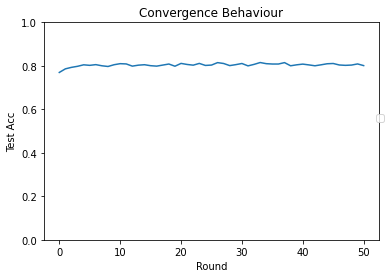

In [ ]:
plot_convergence_behaviour_from_centralized_evaluation(centralized_test_accs)

In [ ]:
ultimate_centralized_y_preds = centralized_y_preds[-1]

In [ ]:
print(report_classification_macro_averages(y_test, ultimate_centralized_y_preds))

              precision    recall  f1-score  
   macro avg       0.62      0.71      0.65     


### [Federated Evaluation](https://flower.dev/docs/evaluation.html) with Data Sharing

In [ ]:
# Overrides to global experiment config
EVAL_STRATEGY = "federated"

In [ ]:
# Split test set into NUMBER_OF_CLIENTS partitions.
partitioned_test_set = get_test_partitions(X_test, y_test.to_numpy())

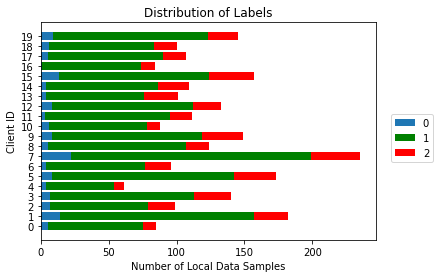

In [ ]:
plot_distribution_of_labels(partitioned_test_set)

In [ ]:
# Evaluate local models
local_models_y_preds = evaluate_local_models(partitioned_train_set, partitioned_test_set)

In [ ]:
local_models_y_test = [y_test_partition for X_test_partition, y_test_partition in partitioned_test_set]

In [ ]:
precision_recall_fscores_of_local_models = get_precision_recall_fscores_of_local_models(local_models_y_test, local_models_y_preds)

In [ ]:
avg_local_model_precision_recall_fscore = get_mean_precision_recall_fscores_of_local_models(precision_recall_fscores_of_local_models)

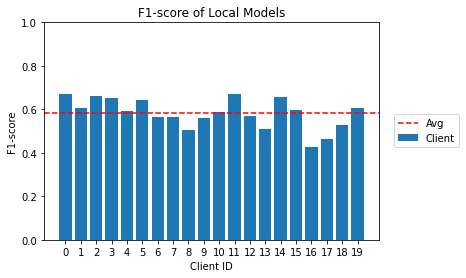

In [ ]:
plot_performance_of_local_models(precision_recall_fscores_of_local_models, avg_local_model_precision_recall_fscore)

In [ ]:
print_measures_of_dispersion(precision_recall_fscores_of_local_models)

Variance of F1-score across local models: 0.004577900799985544
Standard Deviation of F1-score across local models: 0.06766018622488076


In [ ]:
# Run sim with global config
sim_results = run_sim(partitioned_train_set, partitioned_test_set)

INFO flower 2022-03-06 23:53:56,833 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-03-06 23:53:56,837 | server.py:128 | Initializing global parameters
INFO flower 2022-03-06 23:53:56,839 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 83195


INFO flower 2022-03-06 23:53:58,858 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:53:58,862 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:53:58,865 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-03-06 23:53:58,870 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-03-06 23:53:58,872 | server.py:130 | Evaluating initial parameters
INFO flower 2022-03-06 23:53:58,873 | server.py:143 | FL starting


initializing Client1 with pid 83231


INFO flower 2022-03-06 23:53:59,894 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:53:59,899 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:53:59,902 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-03-06 23:53:59,904 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 83263


INFO flower 2022-03-06 23:54:00,923 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:54:00,927 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:54:00,929 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-03-06 23:54:00,931 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 83299


INFO flower 2022-03-06 23:54:01,968 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:54:01,974 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:54:01,977 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-03-06 23:54:01,979 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 83335


INFO flower 2022-03-06 23:54:02,994 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:54:02,999 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:54:03,001 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-03-06 23:54:03,003 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 83373


INFO flower 2022-03-06 23:54:04,028 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:54:04,032 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:54:04,036 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 83411


INFO flower 2022-03-06 23:54:05,057 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:54:05,063 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:54:05,068 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 83451


INFO flower 2022-03-06 23:54:06,092 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:54:06,096 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:54:06,101 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 83493


INFO flower 2022-03-06 23:54:07,126 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:54:07,130 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:54:07,136 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 83537


INFO flower 2022-03-06 23:54:08,160 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:54:08,167 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:54:08,171 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-03-06 23:54:08,174 | connection.py:39 | ChannelConnectivity.READY


initializing Client10 with pid 83586


INFO flower 2022-03-06 23:54:09,193 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:54:09,200 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:54:09,202 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-03-06 23:54:09,204 | connection.py:39 | ChannelConnectivity.READY


initializing Client11 with pid 83636


INFO flower 2022-03-06 23:54:10,229 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:54:10,232 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:54:10,234 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-03-06 23:54:10,236 | connection.py:39 | ChannelConnectivity.READY


initializing Client12 with pid 83688


INFO flower 2022-03-06 23:54:11,265 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:54:11,269 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:54:11,272 | connection.py:39 | ChannelConnectivity.READY


initializing Client13 with pid 83742


INFO flower 2022-03-06 23:54:12,292 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:54:12,296 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:54:12,298 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-03-06 23:54:12,300 | connection.py:39 | ChannelConnectivity.READY


initializing Client14 with pid 83798


INFO flower 2022-03-06 23:54:13,324 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:54:13,329 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:54:13,331 | connection.py:39 | ChannelConnectivity.READY


initializing Client15 with pid 83854


INFO flower 2022-03-06 23:54:14,357 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:54:14,362 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:54:14,367 | connection.py:39 | ChannelConnectivity.READY


initializing Client16 with pid 83912


INFO flower 2022-03-06 23:54:15,389 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:54:15,394 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:54:15,396 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-03-06 23:54:15,398 | connection.py:39 | ChannelConnectivity.READY


initializing Client17 with pid 83974


INFO flower 2022-03-06 23:54:16,422 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:54:16,425 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:54:16,428 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-03-06 23:54:16,430 | connection.py:39 | ChannelConnectivity.READY


initializing Client18 with pid 84038


INFO flower 2022-03-06 23:54:17,458 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:54:17,462 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:54:17,466 | connection.py:39 | ChannelConnectivity.READY


initializing Client19 with pid 84104


INFO flower 2022-03-06 23:54:18,494 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-06 23:54:18,500 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-06 23:54:18,503 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)
DEBUG flower 2022-03-06 23:54:18,502 | connection.py:39 | ChannelConnectivity.READY


Client18 with pid 84038 is sampled in training rnd 1
Client2 with pid 83263 is sampled in training rnd 1
Client8 with pid 83493 is sampled in training rnd 1
Client3 with pid 83299 is sampled in training rnd 1
Client12 with pid 83688 is sampled in training rnd 1
Client13 with pid 83742 is sampled in training rnd 1
Client10 with pid 83586 is sampled in training rnd 1
Client15 with pid 83854 is sampled in training rnd 1
Client16 with pid 83912 is sampled in training rnd 1
Client6 with pid 83411 is sampled in training rnd 1
Client1 with pid 83231 is sampled in training rnd 1
Client7 with pid 83451 is sampled in training rnd 1
Client14 with pid 83798 is sampled in training rnd 1
Client0 with pid 83195 is sampled in training rnd 1


DEBUG flower 2022-03-06 23:54:19,815 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:54:19,846 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client12 with pid 83688 is sampled in evaluation rnd 1
Client0 with pid 83195 is sampled in evaluation rnd 1
Client13 with pid 83742 is sampled in evaluation rnd 1
Client14 with pid 83798 is sampled in evaluation rnd 1
Client8 with pid 83493 is sampled in evaluation rnd 1
Client19 with pid 84104 is sampled in evaluation rnd 1
Client3 with pid 83299 is sampled in evaluation rnd 1
Client11 with pid 83636 is sampled in evaluation rnd 1
Client1 with pid 83231 is sampled in evaluation rnd 1
Client9 with pid 83537 is sampled in evaluation rnd 1
Client5 with pid 83373 is sampled in evaluation rnd 1
Client17 with pid 83974 is sampled in evaluation rnd 1
Client15 with pid 83854 is sampled in evaluation rnd 1
Client7 with pid 83451 is sampled in evaluation rnd 1
Client16 with pid 83912 is sampled in evaluation rnd 1
Client10 with pid 83586 is sampled in evaluation rnd 1
Client4 with pid 83335 is sampled in evaluation rnd 1
Client6 with pid 83411 is sampled in evaluation rnd 1
Client18 with pid 8

DEBUG flower 2022-03-06 23:54:19,980 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:54:19,983 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client0 with pid 83195 is sampled in training rnd 2
Client16 with pid 83912 is sampled in training rnd 2
Client7 with pid 83451 is sampled in training rnd 2
Client15 with pid 83854 is sampled in training rnd 2
Client14 with pid 83798 is sampled in training rnd 2
Client8 with pid 83493 is sampled in training rnd 2
Client3 with pid 83299 is sampled in training rnd 2
Client5 with pid 83373 is sampled in training rnd 2
Client13 with pid 83742 is sampled in training rnd 2
Client10 with pid 83586 is sampled in training rnd 2
Client11 with pid 83636 is sampled in training rnd 2
Client17 with pid 83974 is sampled in training rnd 2
Client4 with pid 83335 is sampled in training rnd 2
Client19 with pid 84104 is sampled in training rnd 2


DEBUG flower 2022-03-06 23:54:21,372 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:54:21,404 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client13 with pid 83742 is sampled in evaluation rnd 2
Client3 with pid 83299 is sampled in evaluation rnd 2
Client17 with pid 83974 is sampled in evaluation rnd 2
Client11 with pid 83636 is sampled in evaluation rnd 2
Client5 with pid 83373 is sampled in evaluation rnd 2
Client1 with pid 83231 is sampled in evaluation rnd 2
Client9 with pid 83537 is sampled in evaluation rnd 2
Client19 with pid 84104 is sampled in evaluation rnd 2
Client16 with pid 83912 is sampled in evaluation rnd 2
Client8 with pid 83493 is sampled in evaluation rnd 2
Client6 with pid 83411 is sampled in evaluation rnd 2
Client10 with pid 83586 is sampled in evaluation rnd 2
Client2 with pid 83263 is sampled in evaluation rnd 2
Client18 with pid 84038 is sampled in evaluation rnd 2
Client15 with pid 83854 is sampled in evaluation rnd 2
Client7 with pid 83451 is sampled in evaluation rnd 2
Client12 with pid 83688 is sampled in evaluation rnd 2
Client14 with pid 83798 is sampled in evaluation rnd 2
Client4 with pid 8

DEBUG flower 2022-03-06 23:54:21,539 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:54:21,549 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client15 with pid 83854 is sampled in training rnd 3
Client7 with pid 83451 is sampled in training rnd 3
Client12 with pid 83688 is sampled in training rnd 3
Client13 with pid 83742 is sampled in training rnd 3
Client19 with pid 84104 is sampled in training rnd 3
Client5 with pid 83373 is sampled in training rnd 3
Client8 with pid 83493 is sampled in training rnd 3
Client11 with pid 83636 is sampled in training rnd 3
Client10 with pid 83586 is sampled in training rnd 3
Client1 with pid 83231 is sampled in training rnd 3
Client14 with pid 83798 is sampled in training rnd 3
Client18 with pid 84038 is sampled in training rnd 3
Client9 with pid 83537 is sampled in training rnd 3
Client6 with pid 83411 is sampled in training rnd 3


DEBUG flower 2022-03-06 23:54:23,199 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:54:23,214 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client5 with pid 83373 is sampled in evaluation rnd 3
Client12 with pid 83688 is sampled in evaluation rnd 3
Client0 with pid 83195 is sampled in evaluation rnd 3
Client18 with pid 84038 is sampled in evaluation rnd 3
Client7 with pid 83451 is sampled in evaluation rnd 3
Client16 with pid 83912 is sampled in evaluation rnd 3
Client15 with pid 83854 is sampled in evaluation rnd 3
Client11 with pid 83636 is sampled in evaluation rnd 3
Client13 with pid 83742 is sampled in evaluation rnd 3
Client4 with pid 83335 is sampled in evaluation rnd 3
Client9 with pid 83537 is sampled in evaluation rnd 3
Client6 with pid 83411 is sampled in evaluation rnd 3
Client1 with pid 83231 is sampled in evaluation rnd 3
Client2 with pid 83263 is sampled in evaluation rnd 3
Client10 with pid 83586 is sampled in evaluation rnd 3
Client8 with pid 83493 is sampled in evaluation rnd 3
Client14 with pid 83798 is sampled in evaluation rnd 3
Client3 with pid 83299 is sampled in evaluation rnd 3
Client17 with pid 83

DEBUG flower 2022-03-06 23:54:23,352 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:54:23,358 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client16 with pid 83912 is sampled in training rnd 4
Client18 with pid 84038 is sampled in training rnd 4
Client11 with pid 83636 is sampled in training rnd 4
Client8 with pid 83493 is sampled in training rnd 4
Client14 with pid 83798 is sampled in training rnd 4
Client10 with pid 83586 is sampled in training rnd 4
Client15 with pid 83854 is sampled in training rnd 4
Client9 with pid 83537 is sampled in training rnd 4
Client17 with pid 83974 is sampled in training rnd 4
Client0 with pid 83195 is sampled in training rnd 4
Client6 with pid 83411 is sampled in training rnd 4
Client13 with pid 83742 is sampled in training rnd 4
Client2 with pid 83263 is sampled in training rnd 4
Client4 with pid 83335 is sampled in training rnd 4


DEBUG flower 2022-03-06 23:54:24,861 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:54:24,893 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client17 with pid 83974 is sampled in evaluation rnd 4
Client6 with pid 83411 is sampled in evaluation rnd 4
Client1 with pid 83231 is sampled in evaluation rnd 4
Client13 with pid 83742 is sampled in evaluation rnd 4
Client19 with pid 84104 is sampled in evaluation rnd 4
Client15 with pid 83854 is sampled in evaluation rnd 4
Client5 with pid 83373 is sampled in evaluation rnd 4
Client9 with pid 83537 is sampled in evaluation rnd 4
Client8 with pid 83493 is sampled in evaluation rnd 4
Client11 with pid 83636 is sampled in evaluation rnd 4
Client3 with pid 83299 is sampled in evaluation rnd 4
Client18 with pid 84038 is sampled in evaluation rnd 4
Client12 with pid 83688 is sampled in evaluation rnd 4
Client7 with pid 83451 is sampled in evaluation rnd 4
Client2 with pid 83263 is sampled in evaluation rnd 4
Client14 with pid 83798 is sampled in evaluation rnd 4
Client0 with pid 83195 is sampled in evaluation rnd 4
Client16 with pid 83912 is sampled in evaluation rnd 4
Client10 with pid 8

DEBUG flower 2022-03-06 23:54:25,014 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:54:25,020 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client19 with pid 84104 is sampled in training rnd 5
Client0 with pid 83195 is sampled in training rnd 5
Client7 with pid 83451 is sampled in training rnd 5
Client5 with pid 83373 is sampled in training rnd 5
Client16 with pid 83912 is sampled in training rnd 5
Client1 with pid 83231 is sampled in training rnd 5
Client13 with pid 83742 is sampled in training rnd 5
Client12 with pid 83688 is sampled in training rnd 5
Client8 with pid 83493 is sampled in training rnd 5
Client4 with pid 83335 is sampled in training rnd 5
Client18 with pid 84038 is sampled in training rnd 5
Client14 with pid 83798 is sampled in training rnd 5
Client11 with pid 83636 is sampled in training rnd 5
Client6 with pid 83411 is sampled in training rnd 5


DEBUG flower 2022-03-06 23:54:26,597 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:54:26,621 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client14 with pid 83798 is sampled in evaluation rnd 5
Client19 with pid 84104 is sampled in evaluation rnd 5
Client8 with pid 83493 is sampled in evaluation rnd 5
Client0 with pid 83195 is sampled in evaluation rnd 5
Client4 with pid 83335 is sampled in evaluation rnd 5
Client7 with pid 83451 is sampled in evaluation rnd 5
Client1 with pid 83231 is sampled in evaluation rnd 5
Client12 with pid 83688 is sampled in evaluation rnd 5
Client13 with pid 83742 is sampled in evaluation rnd 5
Client9 with pid 83537 is sampled in evaluation rnd 5
Client5 with pid 83373 is sampled in evaluation rnd 5
Client2 with pid 83263 is sampled in evaluation rnd 5
Client18 with pid 84038 is sampled in evaluation rnd 5
Client6 with pid 83411 is sampled in evaluation rnd 5
Client15 with pid 83854 is sampled in evaluation rnd 5
Client11 with pid 83636 is sampled in evaluation rnd 5
Client10 with pid 83586 is sampled in evaluation rnd 5
Client16 with pid 83912 is sampled in evaluation rnd 5
Client3 with pid 83

DEBUG flower 2022-03-06 23:54:26,757 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:54:26,765 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client14 with pid 83798 is sampled in training rnd 6
Client17 with pid 83974 is sampled in training rnd 6
Client10 with pid 83586 is sampled in training rnd 6
Client15 with pid 83854 is sampled in training rnd 6
Client3 with pid 83299 is sampled in training rnd 6
Client0 with pid 83195 is sampled in training rnd 6
Client4 with pid 83335 is sampled in training rnd 6
Client6 with pid 83411 is sampled in training rnd 6
Client5 with pid 83373 is sampled in training rnd 6
Client12 with pid 83688 is sampled in training rnd 6
Client16 with pid 83912 is sampled in training rnd 6
Client13 with pid 83742 is sampled in training rnd 6
Client1 with pid 83231 is sampled in training rnd 6
Client2 with pid 83263 is sampled in training rnd 6


DEBUG flower 2022-03-06 23:54:28,436 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:54:28,458 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client16 with pid 83912 is sampled in evaluation rnd 6
Client6 with pid 83411 is sampled in evaluation rnd 6
Client13 with pid 83742 is sampled in evaluation rnd 6
Client0 with pid 83195 is sampled in evaluation rnd 6
Client18 with pid 84038 is sampled in evaluation rnd 6
Client7 with pid 83451 is sampled in evaluation rnd 6
Client19 with pid 84104 is sampled in evaluation rnd 6
Client14 with pid 83798 is sampled in evaluation rnd 6
Client12 with pid 83688 is sampled in evaluation rnd 6
Client2 with pid 83263 is sampled in evaluation rnd 6
Client8 with pid 83493 is sampled in evaluation rnd 6
Client15 with pid 83854 is sampled in evaluation rnd 6
Client17 with pid 83974 is sampled in evaluation rnd 6
Client9 with pid 83537 is sampled in evaluation rnd 6
Client4 with pid 83335 is sampled in evaluation rnd 6
Client1 with pid 83231 is sampled in evaluation rnd 6
Client3 with pid 83299 is sampled in evaluation rnd 6
Client11 with pid 83636 is sampled in evaluation rnd 6
Client5 with pid 83

DEBUG flower 2022-03-06 23:54:28,592 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:54:28,602 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client18 with pid 84038 is sampled in training rnd 7
Client10 with pid 83586 is sampled in training rnd 7
Client13 with pid 83742 is sampled in training rnd 7
Client2 with pid 83263 is sampled in training rnd 7
Client9 with pid 83537 is sampled in training rnd 7
Client0 with pid 83195 is sampled in training rnd 7
Client4 with pid 83335 is sampled in training rnd 7
Client1 with pid 83231 is sampled in training rnd 7
Client3 with pid 83299 is sampled in training rnd 7
Client16 with pid 83912 is sampled in training rnd 7
Client19 with pid 84104 is sampled in training rnd 7
Client11 with pid 83636 is sampled in training rnd 7
Client8 with pid 83493 is sampled in training rnd 7
Client5 with pid 83373 is sampled in training rnd 7


DEBUG flower 2022-03-06 23:54:30,115 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:54:30,133 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client13 with pid 83742 is sampled in evaluation rnd 7
Client5 with pid 83373 is sampled in evaluation rnd 7
Client8 with pid 83493 is sampled in evaluation rnd 7
Client4 with pid 83335 is sampled in evaluation rnd 7
Client0 with pid 83195 is sampled in evaluation rnd 7
Client17 with pid 83974 is sampled in evaluation rnd 7
Client18 with pid 84038 is sampled in evaluation rnd 7
Client3 with pid 83299 is sampled in evaluation rnd 7
Client15 with pid 83854 is sampled in evaluation rnd 7
Client9 with pid 83537 is sampled in evaluation rnd 7
Client7 with pid 83451 is sampled in evaluation rnd 7
Client6 with pid 83411 is sampled in evaluation rnd 7
Client2 with pid 83263 is sampled in evaluation rnd 7
Client16 with pid 83912 is sampled in evaluation rnd 7
Client1 with pid 83231 is sampled in evaluation rnd 7
Client11 with pid 83636 is sampled in evaluation rnd 7
Client19 with pid 84104 is sampled in evaluation rnd 7
Client12 with pid 83688 is sampled in evaluation rnd 7
Client14 with pid 83

DEBUG flower 2022-03-06 23:54:30,251 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:54:30,262 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client6 with pid 83411 is sampled in training rnd 8
Client3 with pid 83299 is sampled in training rnd 8
Client13 with pid 83742 is sampled in training rnd 8
Client18 with pid 84038 is sampled in training rnd 8
Client15 with pid 83854 is sampled in training rnd 8
Client1 with pid 83231 is sampled in training rnd 8
Client10 with pid 83586 is sampled in training rnd 8
Client4 with pid 83335 is sampled in training rnd 8
Client16 with pid 83912 is sampled in training rnd 8
Client7 with pid 83451 is sampled in training rnd 8
Client8 with pid 83493 is sampled in training rnd 8
Client0 with pid 83195 is sampled in training rnd 8
Client5 with pid 83373 is sampled in training rnd 8
Client11 with pid 83636 is sampled in training rnd 8


DEBUG flower 2022-03-06 23:54:31,788 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:54:31,814 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client9 with pid 83537 is sampled in evaluation rnd 8
Client12 with pid 83688 is sampled in evaluation rnd 8
Client5 with pid 83373 is sampled in evaluation rnd 8
Client6 with pid 83411 is sampled in evaluation rnd 8
Client13 with pid 83742 is sampled in evaluation rnd 8
Client0 with pid 83195 is sampled in evaluation rnd 8
Client16 with pid 83912 is sampled in evaluation rnd 8
Client19 with pid 84104 is sampled in evaluation rnd 8
Client2 with pid 83263 is sampled in evaluation rnd 8
Client18 with pid 84038 is sampled in evaluation rnd 8
Client14 with pid 83798 is sampled in evaluation rnd 8
Client3 with pid 83299 is sampled in evaluation rnd 8
Client15 with pid 83854 is sampled in evaluation rnd 8
Client10 with pid 83586 is sampled in evaluation rnd 8
Client11 with pid 83636 is sampled in evaluation rnd 8
Client17 with pid 83974 is sampled in evaluation rnd 8
Client7 with pid 83451 is sampled in evaluation rnd 8
Client8 with pid 83493 is sampled in evaluation rnd 8
Client1 with pid 8

DEBUG flower 2022-03-06 23:54:31,942 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:54:31,951 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client17 with pid 83974 is sampled in training rnd 9
Client2 with pid 83263 is sampled in training rnd 9
Client19 with pid 84104 is sampled in training rnd 9
Client15 with pid 83854 is sampled in training rnd 9
Client1 with pid 83231 is sampled in training rnd 9
Client14 with pid 83798 is sampled in training rnd 9
Client7 with pid 83451 is sampled in training rnd 9
Client13 with pid 83742 is sampled in training rnd 9
Client8 with pid 83493 is sampled in training rnd 9
Client3 with pid 83299 is sampled in training rnd 9
Client5 with pid 83373 is sampled in training rnd 9
Client4 with pid 83335 is sampled in training rnd 9
Client9 with pid 83537 is sampled in training rnd 9
Client12 with pid 83688 is sampled in training rnd 9


DEBUG flower 2022-03-06 23:54:33,562 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:54:33,583 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client10 with pid 83586 is sampled in evaluation rnd 9
Client19 with pid 84104 is sampled in evaluation rnd 9
Client3 with pid 83299 is sampled in evaluation rnd 9
Client7 with pid 83451 is sampled in evaluation rnd 9
Client9 with pid 83537 is sampled in evaluation rnd 9
Client13 with pid 83742 is sampled in evaluation rnd 9
Client16 with pid 83912 is sampled in evaluation rnd 9
Client12 with pid 83688 is sampled in evaluation rnd 9
Client11 with pid 83636 is sampled in evaluation rnd 9
Client15 with pid 83854 is sampled in evaluation rnd 9
Client2 with pid 83263 is sampled in evaluation rnd 9
Client8 with pid 83493 is sampled in evaluation rnd 9
Client1 with pid 83231 is sampled in evaluation rnd 9
Client14 with pid 83798 is sampled in evaluation rnd 9
Client17 with pid 83974 is sampled in evaluation rnd 9
Client5 with pid 83373 is sampled in evaluation rnd 9
Client0 with pid 83195 is sampled in evaluation rnd 9
Client4 with pid 83335 is sampled in evaluation rnd 9
Client18 with pid 8

DEBUG flower 2022-03-06 23:54:33,719 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:54:33,724 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client10 with pid 83586 is sampled in training rnd 10
Client12 with pid 83688 is sampled in training rnd 10
Client3 with pid 83299 is sampled in training rnd 10
Client2 with pid 83263 is sampled in training rnd 10
Client1 with pid 83231 is sampled in training rnd 10
Client9 with pid 83537 is sampled in training rnd 10
Client4 with pid 83335 is sampled in training rnd 10
Client7 with pid 83451 is sampled in training rnd 10
Client5 with pid 83373 is sampled in training rnd 10
Client17 with pid 83974 is sampled in training rnd 10
Client14 with pid 83798 is sampled in training rnd 10
Client8 with pid 83493 is sampled in training rnd 10
Client13 with pid 83742 is sampled in training rnd 10
Client18 with pid 84038 is sampled in training rnd 10


DEBUG flower 2022-03-06 23:54:35,333 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:54:35,358 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client8 with pid 83493 is sampled in evaluation rnd 10
Client3 with pid 83299 is sampled in evaluation rnd 10
Client1 with pid 83231 is sampled in evaluation rnd 10
Client9 with pid 83537 is sampled in evaluation rnd 10
Client0 with pid 83195 is sampled in evaluation rnd 10
Client10 with pid 83586 is sampled in evaluation rnd 10
Client16 with pid 83912 is sampled in evaluation rnd 10
Client15 with pid 83854 is sampled in evaluation rnd 10
Client17 with pid 83974 is sampled in evaluation rnd 10
Client6 with pid 83411 is sampled in evaluation rnd 10
Client11 with pid 83636 is sampled in evaluation rnd 10
Client12 with pid 83688 is sampled in evaluation rnd 10
Client18 with pid 84038 is sampled in evaluation rnd 10
Client14 with pid 83798 is sampled in evaluation rnd 10
Client4 with pid 83335 is sampled in evaluation rnd 10
Client5 with pid 83373 is sampled in evaluation rnd 10
Client7 with pid 83451 is sampled in evaluation rnd 10
Client13 with pid 83742 is sampled in evaluation rnd 10
C

DEBUG flower 2022-03-06 23:54:35,499 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:54:35,512 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client7 with pid 83451 is sampled in training rnd 11
Client15 with pid 83854 is sampled in training rnd 11
Client13 with pid 83742 is sampled in training rnd 11
Client3 with pid 83299 is sampled in training rnd 11
Client8 with pid 83493 is sampled in training rnd 11
Client5 with pid 83373 is sampled in training rnd 11
Client12 with pid 83688 is sampled in training rnd 11
Client4 with pid 83335 is sampled in training rnd 11
Client16 with pid 83912 is sampled in training rnd 11
Client19 with pid 84104 is sampled in training rnd 11
Client14 with pid 83798 is sampled in training rnd 11
Client18 with pid 84038 is sampled in training rnd 11
Client1 with pid 83231 is sampled in training rnd 11
Client9 with pid 83537 is sampled in training rnd 11


DEBUG flower 2022-03-06 23:54:37,082 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:54:37,106 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client10 with pid 83586 is sampled in evaluation rnd 11
Client1 with pid 83231 is sampled in evaluation rnd 11
Client0 with pid 83195 is sampled in evaluation rnd 11
Client9 with pid 83537 is sampled in evaluation rnd 11
Client17 with pid 83974 is sampled in evaluation rnd 11
Client11 with pid 83636 is sampled in evaluation rnd 11
Client15 with pid 83854 is sampled in evaluation rnd 11
Client5 with pid 83373 is sampled in evaluation rnd 11
Client6 with pid 83411 is sampled in evaluation rnd 11
Client12 with pid 83688 is sampled in evaluation rnd 11
Client18 with pid 84038 is sampled in evaluation rnd 11
Client16 with pid 83912 is sampled in evaluation rnd 11
Client19 with pid 84104 is sampled in evaluation rnd 11
Client2 with pid 83263 is sampled in evaluation rnd 11
Client4 with pid 83335 is sampled in evaluation rnd 11
Client7 with pid 83451 is sampled in evaluation rnd 11
Client3 with pid 83299 is sampled in evaluation rnd 11
Client14 with pid 83798 is sampled in evaluation rnd 11
C

DEBUG flower 2022-03-06 23:54:37,228 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:54:37,235 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client19 with pid 84104 is sampled in training rnd 12
Client17 with pid 83974 is sampled in training rnd 12
Client8 with pid 83493 is sampled in training rnd 12
Client15 with pid 83854 is sampled in training rnd 12
Client11 with pid 83636 is sampled in training rnd 12
Client2 with pid 83263 is sampled in training rnd 12
Client18 with pid 84038 is sampled in training rnd 12
Client4 with pid 83335 is sampled in training rnd 12
Client3 with pid 83299 is sampled in training rnd 12
Client12 with pid 83688 is sampled in training rnd 12
Client10 with pid 83586 is sampled in training rnd 12
Client5 with pid 83373 is sampled in training rnd 12
Client1 with pid 83231 is sampled in training rnd 12
Client6 with pid 83411 is sampled in training rnd 12


DEBUG flower 2022-03-06 23:54:38,822 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:54:38,855 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client8 with pid 83493 is sampled in evaluation rnd 12
Client2 with pid 83263 is sampled in evaluation rnd 12
Client18 with pid 84038 is sampled in evaluation rnd 12
Client14 with pid 83798 is sampled in evaluation rnd 12
Client10 with pid 83586 is sampled in evaluation rnd 12
Client3 with pid 83299 is sampled in evaluation rnd 12
Client6 with pid 83411 is sampled in evaluation rnd 12
Client0 with pid 83195 is sampled in evaluation rnd 12
Client4 with pid 83335 is sampled in evaluation rnd 12
Client15 with pid 83854 is sampled in evaluation rnd 12
Client16 with pid 83912 is sampled in evaluation rnd 12
Client1 with pid 83231 is sampled in evaluation rnd 12
Client12 with pid 83688 is sampled in evaluation rnd 12
Client9 with pid 83537 is sampled in evaluation rnd 12
Client5 with pid 83373 is sampled in evaluation rnd 12
Client11 with pid 83636 is sampled in evaluation rnd 12
Client7 with pid 83451 is sampled in evaluation rnd 12
Client19 with pid 84104 is sampled in evaluation rnd 12
Cl

DEBUG flower 2022-03-06 23:54:38,978 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:54:38,984 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client7 with pid 83451 is sampled in training rnd 13
Client12 with pid 83688 is sampled in training rnd 13
Client2 with pid 83263 is sampled in training rnd 13
Client8 with pid 83493 is sampled in training rnd 13
Client11 with pid 83636 is sampled in training rnd 13
Client17 with pid 83974 is sampled in training rnd 13
Client1 with pid 83231 is sampled in training rnd 13
Client0 with pid 83195 is sampled in training rnd 13
Client10 with pid 83586 is sampled in training rnd 13
Client18 with pid 84038 is sampled in training rnd 13
Client4 with pid 83335 is sampled in training rnd 13
Client5 with pid 83373 is sampled in training rnd 13
Client19 with pid 84104 is sampled in training rnd 13
Client3 with pid 83299 is sampled in training rnd 13


DEBUG flower 2022-03-06 23:54:40,491 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:54:40,518 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client4 with pid 83335 is sampled in evaluation rnd 13
Client3 with pid 83299 is sampled in evaluation rnd 13
Client16 with pid 83912 is sampled in evaluation rnd 13
Client8 with pid 83493 is sampled in evaluation rnd 13
Client10 with pid 83586 is sampled in evaluation rnd 13
Client2 with pid 83263 is sampled in evaluation rnd 13
Client17 with pid 83974 is sampled in evaluation rnd 13
Client15 with pid 83854 is sampled in evaluation rnd 13
Client12 with pid 83688 is sampled in evaluation rnd 13
Client11 with pid 83636 is sampled in evaluation rnd 13
Client13 with pid 83742 is sampled in evaluation rnd 13
Client19 with pid 84104 is sampled in evaluation rnd 13
Client5 with pid 83373 is sampled in evaluation rnd 13
Client0 with pid 83195 is sampled in evaluation rnd 13
Client14 with pid 83798 is sampled in evaluation rnd 13
Client7 with pid 83451 is sampled in evaluation rnd 13
Client9 with pid 83537 is sampled in evaluation rnd 13
Client6 with pid 83411 is sampled in evaluation rnd 13
C

DEBUG flower 2022-03-06 23:54:40,638 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:54:40,643 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client17 with pid 83974 is sampled in training rnd 14
Client1 with pid 83231 is sampled in training rnd 14
Client10 with pid 83586 is sampled in training rnd 14
Client6 with pid 83411 is sampled in training rnd 14
Client5 with pid 83373 is sampled in training rnd 14
Client16 with pid 83912 is sampled in training rnd 14
Client4 with pid 83335 is sampled in training rnd 14
Client2 with pid 83263 is sampled in training rnd 14
Client8 with pid 83493 is sampled in training rnd 14
Client3 with pid 83299 is sampled in training rnd 14
Client0 with pid 83195 is sampled in training rnd 14
Client18 with pid 84038 is sampled in training rnd 14
Client14 with pid 83798 is sampled in training rnd 14
Client15 with pid 83854 is sampled in training rnd 14


DEBUG flower 2022-03-06 23:54:42,251 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:54:42,273 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client14 with pid 83798 is sampled in evaluation rnd 14
Client13 with pid 83742 is sampled in evaluation rnd 14
Client18 with pid 84038 is sampled in evaluation rnd 14
Client17 with pid 83974 is sampled in evaluation rnd 14
Client19 with pid 84104 is sampled in evaluation rnd 14
Client16 with pid 83912 is sampled in evaluation rnd 14
Client8 with pid 83493 is sampled in evaluation rnd 14
Client7 with pid 83451 is sampled in evaluation rnd 14
Client6 with pid 83411 is sampled in evaluation rnd 14
Client0 with pid 83195 is sampled in evaluation rnd 14
Client5 with pid 83373 is sampled in evaluation rnd 14
Client2 with pid 83263 is sampled in evaluation rnd 14
Client3 with pid 83299 is sampled in evaluation rnd 14
Client4 with pid 83335 is sampled in evaluation rnd 14
Client11 with pid 83636 is sampled in evaluation rnd 14
Client10 with pid 83586 is sampled in evaluation rnd 14
Client9 with pid 83537 is sampled in evaluation rnd 14
Client1 with pid 83231 is sampled in evaluation rnd 14
Cl

DEBUG flower 2022-03-06 23:54:42,395 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:54:42,405 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client18 with pid 84038 is sampled in training rnd 15
Client4 with pid 83335 is sampled in training rnd 15
Client19 with pid 84104 is sampled in training rnd 15
Client16 with pid 83912 is sampled in training rnd 15
Client6 with pid 83411 is sampled in training rnd 15
Client8 with pid 83493 is sampled in training rnd 15
Client2 with pid 83263 is sampled in training rnd 15
Client9 with pid 83537 is sampled in training rnd 15
Client13 with pid 83742 is sampled in training rnd 15
Client1 with pid 83231 is sampled in training rnd 15
Client14 with pid 83798 is sampled in training rnd 15
Client3 with pid 83299 is sampled in training rnd 15
Client0 with pid 83195 is sampled in training rnd 15
Client7 with pid 83451 is sampled in training rnd 15


DEBUG flower 2022-03-06 23:54:43,941 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:54:43,954 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client5 with pid 83373 is sampled in evaluation rnd 15
Client16 with pid 83912 is sampled in evaluation rnd 15
Client18 with pid 84038 is sampled in evaluation rnd 15
Client10 with pid 83586 is sampled in evaluation rnd 15
Client15 with pid 83854 is sampled in evaluation rnd 15
Client14 with pid 83798 is sampled in evaluation rnd 15
Client13 with pid 83742 is sampled in evaluation rnd 15
Client17 with pid 83974 is sampled in evaluation rnd 15
Client3 with pid 83299 is sampled in evaluation rnd 15
Client12 with pid 83688 is sampled in evaluation rnd 15
Client19 with pid 84104 is sampled in evaluation rnd 15
Client11 with pid 83636 is sampled in evaluation rnd 15
Client7 with pid 83451 is sampled in evaluation rnd 15
Client8 with pid 83493 is sampled in evaluation rnd 15
Client6 with pid 83411 is sampled in evaluation rnd 15
Client9 with pid 83537 is sampled in evaluation rnd 15
Client2 with pid 83263 is sampled in evaluation rnd 15
Client1 with pid 83231 is sampled in evaluation rnd 15


DEBUG flower 2022-03-06 23:54:44,074 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:54:44,077 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client1 with pid 83231 is sampled in training rnd 16
Client2 with pid 83263 is sampled in training rnd 16
Client16 with pid 83912 is sampled in training rnd 16
Client8 with pid 83493 is sampled in training rnd 16
Client11 with pid 83636 is sampled in training rnd 16
Client13 with pid 83742 is sampled in training rnd 16
Client3 with pid 83299 is sampled in training rnd 16
Client12 with pid 83688 is sampled in training rnd 16
Client4 with pid 83335 is sampled in training rnd 16
Client5 with pid 83373 is sampled in training rnd 16
Client9 with pid 83537 is sampled in training rnd 16
Client10 with pid 83586 is sampled in training rnd 16
Client15 with pid 83854 is sampled in training rnd 16
Client19 with pid 84104 is sampled in training rnd 16


DEBUG flower 2022-03-06 23:54:45,596 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:54:45,612 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client14 with pid 83798 is sampled in evaluation rnd 16
Client2 with pid 83263 is sampled in evaluation rnd 16
Client16 with pid 83912 is sampled in evaluation rnd 16
Client12 with pid 83688 is sampled in evaluation rnd 16
Client3 with pid 83299 is sampled in evaluation rnd 16
Client18 with pid 84038 is sampled in evaluation rnd 16
Client4 with pid 83335 is sampled in evaluation rnd 16
Client19 with pid 84104 is sampled in evaluation rnd 16
Client6 with pid 83411 is sampled in evaluation rnd 16
Client17 with pid 83974 is sampled in evaluation rnd 16
Client9 with pid 83537 is sampled in evaluation rnd 16
Client0 with pid 83195 is sampled in evaluation rnd 16
Client7 with pid 83451 is sampled in evaluation rnd 16
Client10 with pid 83586 is sampled in evaluation rnd 16
Client5 with pid 83373 is sampled in evaluation rnd 16
Client13 with pid 83742 is sampled in evaluation rnd 16
Client15 with pid 83854 is sampled in evaluation rnd 16
Client11 with pid 83636 is sampled in evaluation rnd 16


DEBUG flower 2022-03-06 23:54:45,733 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:54:45,735 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client16 with pid 83912 is sampled in training rnd 17
Client3 with pid 83299 is sampled in training rnd 17
Client2 with pid 83263 is sampled in training rnd 17
Client8 with pid 83493 is sampled in training rnd 17
Client17 with pid 83974 is sampled in training rnd 17
Client11 with pid 83636 is sampled in training rnd 17
Client1 with pid 83231 is sampled in training rnd 17
Client9 with pid 83537 is sampled in training rnd 17
Client18 with pid 84038 is sampled in training rnd 17
Client10 with pid 83586 is sampled in training rnd 17
Client13 with pid 83742 is sampled in training rnd 17
Client7 with pid 83451 is sampled in training rnd 17
Client19 with pid 84104 is sampled in training rnd 17
Client6 with pid 83411 is sampled in training rnd 17


DEBUG flower 2022-03-06 23:54:47,203 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:54:47,221 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client12 with pid 83688 is sampled in evaluation rnd 17
Client13 with pid 83742 is sampled in evaluation rnd 17
Client5 with pid 83373 is sampled in evaluation rnd 17
Client19 with pid 84104 is sampled in evaluation rnd 17
Client3 with pid 83299 is sampled in evaluation rnd 17
Client9 with pid 83537 is sampled in evaluation rnd 17
Client10 with pid 83586 is sampled in evaluation rnd 17
Client14 with pid 83798 is sampled in evaluation rnd 17
Client7 with pid 83451 is sampled in evaluation rnd 17
Client1 with pid 83231 is sampled in evaluation rnd 17
Client6 with pid 83411 is sampled in evaluation rnd 17
Client2 with pid 83263 is sampled in evaluation rnd 17
Client8 with pid 83493 is sampled in evaluation rnd 17
Client0 with pid 83195 is sampled in evaluation rnd 17
Client16 with pid 83912 is sampled in evaluation rnd 17
Client18 with pid 84038 is sampled in evaluation rnd 17
Client11 with pid 83636 is sampled in evaluation rnd 17
Client4 with pid 83335 is sampled in evaluation rnd 17
Cl

DEBUG flower 2022-03-06 23:54:47,340 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:54:47,346 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client6 with pid 83411 is sampled in training rnd 18
Client14 with pid 83798 is sampled in training rnd 18
Client16 with pid 83912 is sampled in training rnd 18
Client0 with pid 83195 is sampled in training rnd 18
Client18 with pid 84038 is sampled in training rnd 18
Client10 with pid 83586 is sampled in training rnd 18
Client9 with pid 83537 is sampled in training rnd 18
Client4 with pid 83335 is sampled in training rnd 18
Client3 with pid 83299 is sampled in training rnd 18
Client12 with pid 83688 is sampled in training rnd 18
Client2 with pid 83263 is sampled in training rnd 18
Client11 with pid 83636 is sampled in training rnd 18
Client13 with pid 83742 is sampled in training rnd 18
Client8 with pid 83493 is sampled in training rnd 18


DEBUG flower 2022-03-06 23:54:48,901 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:54:48,919 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client6 with pid 83411 is sampled in evaluation rnd 18
Client8 with pid 83493 is sampled in evaluation rnd 18
Client9 with pid 83537 is sampled in evaluation rnd 18
Client18 with pid 84038 is sampled in evaluation rnd 18
Client14 with pid 83798 is sampled in evaluation rnd 18
Client13 with pid 83742 is sampled in evaluation rnd 18
Client12 with pid 83688 is sampled in evaluation rnd 18
Client15 with pid 83854 is sampled in evaluation rnd 18
Client2 with pid 83263 is sampled in evaluation rnd 18
Client16 with pid 83912 is sampled in evaluation rnd 18
Client5 with pid 83373 is sampled in evaluation rnd 18
Client7 with pid 83451 is sampled in evaluation rnd 18
Client19 with pid 84104 is sampled in evaluation rnd 18
Client0 with pid 83195 is sampled in evaluation rnd 18
Client1 with pid 83231 is sampled in evaluation rnd 18
Client3 with pid 83299 is sampled in evaluation rnd 18
Client10 with pid 83586 is sampled in evaluation rnd 18
Client17 with pid 83974 is sampled in evaluation rnd 18
C

DEBUG flower 2022-03-06 23:54:49,040 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:54:49,044 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client0 with pid 83195 is sampled in training rnd 19
Client3 with pid 83299 is sampled in training rnd 19
Client4 with pid 83335 is sampled in training rnd 19
Client9 with pid 83537 is sampled in training rnd 19
Client8 with pid 83493 is sampled in training rnd 19
Client1 with pid 83231 is sampled in training rnd 19
Client5 with pid 83373 is sampled in training rnd 19
Client19 with pid 84104 is sampled in training rnd 19
Client16 with pid 83912 is sampled in training rnd 19
Client15 with pid 83854 is sampled in training rnd 19
Client6 with pid 83411 is sampled in training rnd 19
Client13 with pid 83742 is sampled in training rnd 19
Client12 with pid 83688 is sampled in training rnd 19
Client11 with pid 83636 is sampled in training rnd 19


DEBUG flower 2022-03-06 23:54:50,620 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:54:50,650 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client10 with pid 83586 is sampled in evaluation rnd 19
Client16 with pid 83912 is sampled in evaluation rnd 19
Client0 with pid 83195 is sampled in evaluation rnd 19
Client14 with pid 83798 is sampled in evaluation rnd 19
Client3 with pid 83299 is sampled in evaluation rnd 19
Client7 with pid 83451 is sampled in evaluation rnd 19
Client11 with pid 83636 is sampled in evaluation rnd 19
Client8 with pid 83493 is sampled in evaluation rnd 19
Client6 with pid 83411 is sampled in evaluation rnd 19
Client4 with pid 83335 is sampled in evaluation rnd 19
Client5 with pid 83373 is sampled in evaluation rnd 19
Client12 with pid 83688 is sampled in evaluation rnd 19
Client17 with pid 83974 is sampled in evaluation rnd 19
Client13 with pid 83742 is sampled in evaluation rnd 19
Client18 with pid 84038 is sampled in evaluation rnd 19
Client19 with pid 84104 is sampled in evaluation rnd 19
Client15 with pid 83854 is sampled in evaluation rnd 19
Client2 with pid 83263 is sampled in evaluation rnd 19


DEBUG flower 2022-03-06 23:54:50,790 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:54:50,794 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client19 with pid 84104 is sampled in training rnd 20
Client16 with pid 83912 is sampled in training rnd 20
Client6 with pid 83411 is sampled in training rnd 20
Client14 with pid 83798 is sampled in training rnd 20
Client13 with pid 83742 is sampled in training rnd 20
Client18 with pid 84038 is sampled in training rnd 20
Client15 with pid 83854 is sampled in training rnd 20
Client11 with pid 83636 is sampled in training rnd 20
Client2 with pid 83263 is sampled in training rnd 20
Client4 with pid 83335 is sampled in training rnd 20
Client7 with pid 83451 is sampled in training rnd 20
Client8 with pid 83493 is sampled in training rnd 20
Client3 with pid 83299 is sampled in training rnd 20
Client10 with pid 83586 is sampled in training rnd 20


DEBUG flower 2022-03-06 23:54:52,249 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:54:52,266 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client0 with pid 83195 is sampled in evaluation rnd 20
Client16 with pid 83912 is sampled in evaluation rnd 20
Client12 with pid 83688 is sampled in evaluation rnd 20
Client17 with pid 83974 is sampled in evaluation rnd 20
Client5 with pid 83373 is sampled in evaluation rnd 20
Client13 with pid 83742 is sampled in evaluation rnd 20
Client19 with pid 84104 is sampled in evaluation rnd 20
Client15 with pid 83854 is sampled in evaluation rnd 20
Client9 with pid 83537 is sampled in evaluation rnd 20
Client7 with pid 83451 is sampled in evaluation rnd 20
Client1 with pid 83231 is sampled in evaluation rnd 20
Client14 with pid 83798 is sampled in evaluation rnd 20
Client8 with pid 83493 is sampled in evaluation rnd 20
Client3 with pid 83299 is sampled in evaluation rnd 20
Client4 with pid 83335 is sampled in evaluation rnd 20
Client2 with pid 83263 is sampled in evaluation rnd 20
Client18 with pid 84038 is sampled in evaluation rnd 20
Client11 with pid 83636 is sampled in evaluation rnd 20
C

DEBUG flower 2022-03-06 23:54:52,375 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:54:52,377 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client5 with pid 83373 is sampled in training rnd 21
Client2 with pid 83263 is sampled in training rnd 21
Client0 with pid 83195 is sampled in training rnd 21
Client8 with pid 83493 is sampled in training rnd 21
Client11 with pid 83636 is sampled in training rnd 21
Client12 with pid 83688 is sampled in training rnd 21
Client16 with pid 83912 is sampled in training rnd 21
Client10 with pid 83586 is sampled in training rnd 21
Client6 with pid 83411 is sampled in training rnd 21
Client15 with pid 83854 is sampled in training rnd 21
Client4 with pid 83335 is sampled in training rnd 21
Client7 with pid 83451 is sampled in training rnd 21
Client18 with pid 84038 is sampled in training rnd 21
Client14 with pid 83798 is sampled in training rnd 21


DEBUG flower 2022-03-06 23:54:53,959 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:54:53,973 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client8 with pid 83493 is sampled in evaluation rnd 21
Client5 with pid 83373 is sampled in evaluation rnd 21
Client14 with pid 83798 is sampled in evaluation rnd 21
Client1 with pid 83231 is sampled in evaluation rnd 21
Client18 with pid 84038 is sampled in evaluation rnd 21
Client4 with pid 83335 is sampled in evaluation rnd 21
Client15 with pid 83854 is sampled in evaluation rnd 21
Client19 with pid 84104 is sampled in evaluation rnd 21
Client11 with pid 83636 is sampled in evaluation rnd 21
Client6 with pid 83411 is sampled in evaluation rnd 21
Client9 with pid 83537 is sampled in evaluation rnd 21
Client12 with pid 83688 is sampled in evaluation rnd 21
Client17 with pid 83974 is sampled in evaluation rnd 21
Client0 with pid 83195 is sampled in evaluation rnd 21
Client3 with pid 83299 is sampled in evaluation rnd 21
Client10 with pid 83586 is sampled in evaluation rnd 21
Client16 with pid 83912 is sampled in evaluation rnd 21
Client7 with pid 83451 is sampled in evaluation rnd 21
C

DEBUG flower 2022-03-06 23:54:54,090 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:54:54,093 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client12 with pid 83688 is sampled in training rnd 22
Client8 with pid 83493 is sampled in training rnd 22
Client6 with pid 83411 is sampled in training rnd 22
Client9 with pid 83537 is sampled in training rnd 22
Client3 with pid 83299 is sampled in training rnd 22
Client1 with pid 83231 is sampled in training rnd 22
Client5 with pid 83373 is sampled in training rnd 22
Client4 with pid 83335 is sampled in training rnd 22
Client11 with pid 83636 is sampled in training rnd 22
Client16 with pid 83912 is sampled in training rnd 22
Client18 with pid 84038 is sampled in training rnd 22
Client13 with pid 83742 is sampled in training rnd 22
Client7 with pid 83451 is sampled in training rnd 22
Client19 with pid 84104 is sampled in training rnd 22


DEBUG flower 2022-03-06 23:54:55,586 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:54:55,605 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client17 with pid 83974 is sampled in evaluation rnd 22
Client1 with pid 83231 is sampled in evaluation rnd 22
Client9 with pid 83537 is sampled in evaluation rnd 22
Client19 with pid 84104 is sampled in evaluation rnd 22
Client8 with pid 83493 is sampled in evaluation rnd 22
Client5 with pid 83373 is sampled in evaluation rnd 22
Client16 with pid 83912 is sampled in evaluation rnd 22
Client3 with pid 83299 is sampled in evaluation rnd 22
Client6 with pid 83411 is sampled in evaluation rnd 22
Client11 with pid 83636 is sampled in evaluation rnd 22
Client10 with pid 83586 is sampled in evaluation rnd 22
Client12 with pid 83688 is sampled in evaluation rnd 22
Client7 with pid 83451 is sampled in evaluation rnd 22
Client15 with pid 83854 is sampled in evaluation rnd 22
Client2 with pid 83263 is sampled in evaluation rnd 22
Client14 with pid 83798 is sampled in evaluation rnd 22
Client4 with pid 83335 is sampled in evaluation rnd 22
Client13 with pid 83742 is sampled in evaluation rnd 22
C

DEBUG flower 2022-03-06 23:54:55,727 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:54:55,738 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client19 with pid 84104 is sampled in training rnd 23
Client7 with pid 83451 is sampled in training rnd 23
Client12 with pid 83688 is sampled in training rnd 23
Client0 with pid 83195 is sampled in training rnd 23
Client14 with pid 83798 is sampled in training rnd 23
Client10 with pid 83586 is sampled in training rnd 23
Client3 with pid 83299 is sampled in training rnd 23
Client16 with pid 83912 is sampled in training rnd 23
Client6 with pid 83411 is sampled in training rnd 23
Client4 with pid 83335 is sampled in training rnd 23
Client11 with pid 83636 is sampled in training rnd 23
Client1 with pid 83231 is sampled in training rnd 23
Client2 with pid 83263 is sampled in training rnd 23
Client13 with pid 83742 is sampled in training rnd 23


DEBUG flower 2022-03-06 23:54:57,329 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:54:57,355 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client18 with pid 84038 is sampled in evaluation rnd 23
Client14 with pid 83798 is sampled in evaluation rnd 23
Client4 with pid 83335 is sampled in evaluation rnd 23
Client8 with pid 83493 is sampled in evaluation rnd 23
Client19 with pid 84104 is sampled in evaluation rnd 23
Client16 with pid 83912 is sampled in evaluation rnd 23
Client13 with pid 83742 is sampled in evaluation rnd 23
Client2 with pid 83263 is sampled in evaluation rnd 23
Client12 with pid 83688 is sampled in evaluation rnd 23
Client7 with pid 83451 is sampled in evaluation rnd 23
Client5 with pid 83373 is sampled in evaluation rnd 23
Client17 with pid 83974 is sampled in evaluation rnd 23
Client1 with pid 83231 is sampled in evaluation rnd 23
Client0 with pid 83195 is sampled in evaluation rnd 23
Client10 with pid 83586 is sampled in evaluation rnd 23
Client6 with pid 83411 is sampled in evaluation rnd 23
Client9 with pid 83537 is sampled in evaluation rnd 23
Client11 with pid 83636 is sampled in evaluation rnd 23
C

DEBUG flower 2022-03-06 23:54:57,502 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:54:57,510 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client12 with pid 83688 is sampled in training rnd 24
Client15 with pid 83854 is sampled in training rnd 24
Client3 with pid 83299 is sampled in training rnd 24
Client10 with pid 83586 is sampled in training rnd 24
Client5 with pid 83373 is sampled in training rnd 24
Client0 with pid 83195 is sampled in training rnd 24
Client14 with pid 83798 is sampled in training rnd 24
Client19 with pid 84104 is sampled in training rnd 24
Client9 with pid 83537 is sampled in training rnd 24
Client13 with pid 83742 is sampled in training rnd 24
Client16 with pid 83912 is sampled in training rnd 24
Client18 with pid 84038 is sampled in training rnd 24
Client7 with pid 83451 is sampled in training rnd 24
Client17 with pid 83974 is sampled in training rnd 24


DEBUG flower 2022-03-06 23:54:59,152 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:54:59,179 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client16 with pid 83912 is sampled in evaluation rnd 24
Client14 with pid 83798 is sampled in evaluation rnd 24
Client10 with pid 83586 is sampled in evaluation rnd 24
Client3 with pid 83299 is sampled in evaluation rnd 24
Client9 with pid 83537 is sampled in evaluation rnd 24
Client8 with pid 83493 is sampled in evaluation rnd 24
Client1 with pid 83231 is sampled in evaluation rnd 24
Client11 with pid 83636 is sampled in evaluation rnd 24
Client6 with pid 83411 is sampled in evaluation rnd 24
Client2 with pid 83263 is sampled in evaluation rnd 24
Client17 with pid 83974 is sampled in evaluation rnd 24
Client15 with pid 83854 is sampled in evaluation rnd 24
Client7 with pid 83451 is sampled in evaluation rnd 24
Client18 with pid 84038 is sampled in evaluation rnd 24
Client19 with pid 84104 is sampled in evaluation rnd 24
Client13 with pid 83742 is sampled in evaluation rnd 24
Client0 with pid 83195 is sampled in evaluation rnd 24
Client4 with pid 83335 is sampled in evaluation rnd 24
C

DEBUG flower 2022-03-06 23:54:59,294 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:54:59,302 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client17 with pid 83974 is sampled in training rnd 25
Client12 with pid 83688 is sampled in training rnd 25
Client18 with pid 84038 is sampled in training rnd 25
Client6 with pid 83411 is sampled in training rnd 25
Client11 with pid 83636 is sampled in training rnd 25
Client14 with pid 83798 is sampled in training rnd 25
Client5 with pid 83373 is sampled in training rnd 25
Client4 with pid 83335 is sampled in training rnd 25
Client7 with pid 83451 is sampled in training rnd 25
Client9 with pid 83537 is sampled in training rnd 25
Client1 with pid 83231 is sampled in training rnd 25
Client3 with pid 83299 is sampled in training rnd 25
Client10 with pid 83586 is sampled in training rnd 25
Client0 with pid 83195 is sampled in training rnd 25


DEBUG flower 2022-03-06 23:55:00,919 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:55:00,950 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client0 with pid 83195 is sampled in evaluation rnd 25
Client19 with pid 84104 is sampled in evaluation rnd 25
Client15 with pid 83854 is sampled in evaluation rnd 25
Client9 with pid 83537 is sampled in evaluation rnd 25
Client10 with pid 83586 is sampled in evaluation rnd 25
Client12 with pid 83688 is sampled in evaluation rnd 25
Client4 with pid 83335 is sampled in evaluation rnd 25
Client13 with pid 83742 is sampled in evaluation rnd 25
Client3 with pid 83299 is sampled in evaluation rnd 25
Client6 with pid 83411 is sampled in evaluation rnd 25
Client2 with pid 83263 is sampled in evaluation rnd 25
Client14 with pid 83798 is sampled in evaluation rnd 25
Client18 with pid 84038 is sampled in evaluation rnd 25
Client7 with pid 83451 is sampled in evaluation rnd 25
Client11 with pid 83636 is sampled in evaluation rnd 25
Client16 with pid 83912 is sampled in evaluation rnd 25
Client17 with pid 83974 is sampled in evaluation rnd 25
Client5 with pid 83373 is sampled in evaluation rnd 25


DEBUG flower 2022-03-06 23:55:01,087 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:55:01,097 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client2 with pid 83263 is sampled in training rnd 26
Client4 with pid 83335 is sampled in training rnd 26
Client9 with pid 83537 is sampled in training rnd 26
Client14 with pid 83798 is sampled in training rnd 26
Client0 with pid 83195 is sampled in training rnd 26
Client15 with pid 83854 is sampled in training rnd 26
Client8 with pid 83493 is sampled in training rnd 26
Client17 with pid 83974 is sampled in training rnd 26
Client18 with pid 84038 is sampled in training rnd 26
Client13 with pid 83742 is sampled in training rnd 26
Client12 with pid 83688 is sampled in training rnd 26
Client19 with pid 84104 is sampled in training rnd 26
Client1 with pid 83231 is sampled in training rnd 26
Client3 with pid 83299 is sampled in training rnd 26


DEBUG flower 2022-03-06 23:55:02,927 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:55:02,950 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client2 with pid 83263 is sampled in evaluation rnd 26
Client0 with pid 83195 is sampled in evaluation rnd 26
Client6 with pid 83411 is sampled in evaluation rnd 26
Client11 with pid 83636 is sampled in evaluation rnd 26
Client4 with pid 83335 is sampled in evaluation rnd 26
Client15 with pid 83854 is sampled in evaluation rnd 26
Client16 with pid 83912 is sampled in evaluation rnd 26
Client10 with pid 83586 is sampled in evaluation rnd 26
Client3 with pid 83299 is sampled in evaluation rnd 26
Client12 with pid 83688 is sampled in evaluation rnd 26
Client7 with pid 83451 is sampled in evaluation rnd 26
Client18 with pid 84038 is sampled in evaluation rnd 26
Client5 with pid 83373 is sampled in evaluation rnd 26
Client9 with pid 83537 is sampled in evaluation rnd 26
Client8 with pid 83493 is sampled in evaluation rnd 26
Client19 with pid 84104 is sampled in evaluation rnd 26
Client1 with pid 83231 is sampled in evaluation rnd 26
Client17 with pid 83974 is sampled in evaluation rnd 26
Cl

DEBUG flower 2022-03-06 23:55:03,086 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:55:03,092 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client13 with pid 83742 is sampled in training rnd 27
Client11 with pid 83636 is sampled in training rnd 27
Client1 with pid 83231 is sampled in training rnd 27
Client16 with pid 83912 is sampled in training rnd 27
Client17 with pid 83974 is sampled in training rnd 27
Client14 with pid 83798 is sampled in training rnd 27
Client5 with pid 83373 is sampled in training rnd 27
Client6 with pid 83411 is sampled in training rnd 27
Client8 with pid 83493 is sampled in training rnd 27
Client12 with pid 83688 is sampled in training rnd 27
Client3 with pid 83299 is sampled in training rnd 27
Client10 with pid 83586 is sampled in training rnd 27
Client19 with pid 84104 is sampled in training rnd 27
Client18 with pid 84038 is sampled in training rnd 27


DEBUG flower 2022-03-06 23:55:04,994 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:55:05,021 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client2 with pid 83263 is sampled in evaluation rnd 27
Client19 with pid 84104 is sampled in evaluation rnd 27
Client8 with pid 83493 is sampled in evaluation rnd 27
Client18 with pid 84038 is sampled in evaluation rnd 27
Client5 with pid 83373 is sampled in evaluation rnd 27
Client1 with pid 83231 is sampled in evaluation rnd 27
Client3 with pid 83299 is sampled in evaluation rnd 27
Client0 with pid 83195 is sampled in evaluation rnd 27
Client17 with pid 83974 is sampled in evaluation rnd 27
Client6 with pid 83411 is sampled in evaluation rnd 27
Client12 with pid 83688 is sampled in evaluation rnd 27
Client9 with pid 83537 is sampled in evaluation rnd 27
Client14 with pid 83798 is sampled in evaluation rnd 27
Client10 with pid 83586 is sampled in evaluation rnd 27
Client11 with pid 83636 is sampled in evaluation rnd 27
Client4 with pid 83335 is sampled in evaluation rnd 27
Client13 with pid 83742 is sampled in evaluation rnd 27
Client16 with pid 83912 is sampled in evaluation rnd 27
C

DEBUG flower 2022-03-06 23:55:05,172 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:55:05,179 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client4 with pid 83335 is sampled in training rnd 28
Client1 with pid 83231 is sampled in training rnd 28
Client14 with pid 83798 is sampled in training rnd 28
Client17 with pid 83974 is sampled in training rnd 28
Client19 with pid 84104 is sampled in training rnd 28
Client16 with pid 83912 is sampled in training rnd 28
Client12 with pid 83688 is sampled in training rnd 28
Client6 with pid 83411 is sampled in training rnd 28
Client11 with pid 83636 is sampled in training rnd 28
Client7 with pid 83451 is sampled in training rnd 28
Client0 with pid 83195 is sampled in training rnd 28
Client15 with pid 83854 is sampled in training rnd 28
Client8 with pid 83493 is sampled in training rnd 28
Client9 with pid 83537 is sampled in training rnd 28


DEBUG flower 2022-03-06 23:55:06,894 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:55:06,906 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client10 with pid 83586 is sampled in evaluation rnd 28
Client8 with pid 83493 is sampled in evaluation rnd 28
Client2 with pid 83263 is sampled in evaluation rnd 28
Client1 with pid 83231 is sampled in evaluation rnd 28
Client9 with pid 83537 is sampled in evaluation rnd 28
Client13 with pid 83742 is sampled in evaluation rnd 28
Client6 with pid 83411 is sampled in evaluation rnd 28
Client4 with pid 83335 is sampled in evaluation rnd 28
Client11 with pid 83636 is sampled in evaluation rnd 28
Client0 with pid 83195 is sampled in evaluation rnd 28
Client5 with pid 83373 is sampled in evaluation rnd 28
Client17 with pid 83974 is sampled in evaluation rnd 28
Client18 with pid 84038 is sampled in evaluation rnd 28
Client14 with pid 83798 is sampled in evaluation rnd 28
Client3 with pid 83299 is sampled in evaluation rnd 28
Client7 with pid 83451 is sampled in evaluation rnd 28
Client19 with pid 84104 is sampled in evaluation rnd 28
Client12 with pid 83688 is sampled in evaluation rnd 28
Cl

DEBUG flower 2022-03-06 23:55:07,023 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:55:07,028 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client16 with pid 83912 is sampled in training rnd 29
Client6 with pid 83411 is sampled in training rnd 29
Client17 with pid 83974 is sampled in training rnd 29
Client19 with pid 84104 is sampled in training rnd 29
Client10 with pid 83586 is sampled in training rnd 29
Client12 with pid 83688 is sampled in training rnd 29
Client8 with pid 83493 is sampled in training rnd 29
Client18 with pid 84038 is sampled in training rnd 29
Client9 with pid 83537 is sampled in training rnd 29
Client7 with pid 83451 is sampled in training rnd 29
Client1 with pid 83231 is sampled in training rnd 29
Client2 with pid 83263 is sampled in training rnd 29
Client4 with pid 83335 is sampled in training rnd 29
Client15 with pid 83854 is sampled in training rnd 29


DEBUG flower 2022-03-06 23:55:08,554 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:55:08,588 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client17 with pid 83974 is sampled in evaluation rnd 29
Client18 with pid 84038 is sampled in evaluation rnd 29
Client16 with pid 83912 is sampled in evaluation rnd 29
Client0 with pid 83195 is sampled in evaluation rnd 29
Client11 with pid 83636 is sampled in evaluation rnd 29
Client5 with pid 83373 is sampled in evaluation rnd 29
Client3 with pid 83299 is sampled in evaluation rnd 29
Client9 with pid 83537 is sampled in evaluation rnd 29
Client2 with pid 83263 is sampled in evaluation rnd 29
Client14 with pid 83798 is sampled in evaluation rnd 29
Client6 with pid 83411 is sampled in evaluation rnd 29
Client1 with pid 83231 is sampled in evaluation rnd 29
Client12 with pid 83688 is sampled in evaluation rnd 29
Client13 with pid 83742 is sampled in evaluation rnd 29
Client8 with pid 83493 is sampled in evaluation rnd 29
Client7 with pid 83451 is sampled in evaluation rnd 29
Client19 with pid 84104 is sampled in evaluation rnd 29
Client10 with pid 83586 is sampled in evaluation rnd 29
C

DEBUG flower 2022-03-06 23:55:08,706 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:55:08,718 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client13 with pid 83742 is sampled in training rnd 30
Client9 with pid 83537 is sampled in training rnd 30
Client11 with pid 83636 is sampled in training rnd 30
Client10 with pid 83586 is sampled in training rnd 30
Client8 with pid 83493 is sampled in training rnd 30
Client16 with pid 83912 is sampled in training rnd 30
Client5 with pid 83373 is sampled in training rnd 30
Client19 with pid 84104 is sampled in training rnd 30
Client15 with pid 83854 is sampled in training rnd 30
Client12 with pid 83688 is sampled in training rnd 30
Client0 with pid 83195 is sampled in training rnd 30
Client17 with pid 83974 is sampled in training rnd 30
Client1 with pid 83231 is sampled in training rnd 30
Client7 with pid 83451 is sampled in training rnd 30


DEBUG flower 2022-03-06 23:55:10,323 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:55:10,349 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client10 with pid 83586 is sampled in evaluation rnd 30
Client19 with pid 84104 is sampled in evaluation rnd 30
Client18 with pid 84038 is sampled in evaluation rnd 30
Client2 with pid 83263 is sampled in evaluation rnd 30
Client14 with pid 83798 is sampled in evaluation rnd 30
Client4 with pid 83335 is sampled in evaluation rnd 30
Client7 with pid 83451 is sampled in evaluation rnd 30
Client13 with pid 83742 is sampled in evaluation rnd 30
Client5 with pid 83373 is sampled in evaluation rnd 30
Client6 with pid 83411 is sampled in evaluation rnd 30
Client1 with pid 83231 is sampled in evaluation rnd 30
Client0 with pid 83195 is sampled in evaluation rnd 30
Client16 with pid 83912 is sampled in evaluation rnd 30
Client15 with pid 83854 is sampled in evaluation rnd 30
Client8 with pid 83493 is sampled in evaluation rnd 30
Client3 with pid 83299 is sampled in evaluation rnd 30
Client12 with pid 83688 is sampled in evaluation rnd 30
Client17 with pid 83974 is sampled in evaluation rnd 30
C

DEBUG flower 2022-03-06 23:55:10,485 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:55:10,491 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client12 with pid 83688 is sampled in training rnd 31
Client11 with pid 83636 is sampled in training rnd 31
Client14 with pid 83798 is sampled in training rnd 31
Client9 with pid 83537 is sampled in training rnd 31
Client10 with pid 83586 is sampled in training rnd 31
Client16 with pid 83912 is sampled in training rnd 31
Client2 with pid 83263 is sampled in training rnd 31
Client8 with pid 83493 is sampled in training rnd 31
Client0 with pid 83195 is sampled in training rnd 31
Client18 with pid 84038 is sampled in training rnd 31
Client4 with pid 83335 is sampled in training rnd 31
Client3 with pid 83299 is sampled in training rnd 31
Client15 with pid 83854 is sampled in training rnd 31
Client19 with pid 84104 is sampled in training rnd 31


DEBUG flower 2022-03-06 23:55:11,995 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:55:12,027 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client13 with pid 83742 is sampled in evaluation rnd 31
Client5 with pid 83373 is sampled in evaluation rnd 31
Client1 with pid 83231 is sampled in evaluation rnd 31
Client3 with pid 83299 is sampled in evaluation rnd 31
Client8 with pid 83493 is sampled in evaluation rnd 31
Client11 with pid 83636 is sampled in evaluation rnd 31
Client16 with pid 83912 is sampled in evaluation rnd 31
Client17 with pid 83974 is sampled in evaluation rnd 31
Client4 with pid 83335 is sampled in evaluation rnd 31
Client18 with pid 84038 is sampled in evaluation rnd 31
Client9 with pid 83537 is sampled in evaluation rnd 31
Client15 with pid 83854 is sampled in evaluation rnd 31
Client10 with pid 83586 is sampled in evaluation rnd 31
Client7 with pid 83451 is sampled in evaluation rnd 31
Client6 with pid 83411 is sampled in evaluation rnd 31
Client0 with pid 83195 is sampled in evaluation rnd 31
Client14 with pid 83798 is sampled in evaluation rnd 31
Client2 with pid 83263 is sampled in evaluation rnd 31
Cl

DEBUG flower 2022-03-06 23:55:12,147 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:55:12,157 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client18 with pid 84038 is sampled in training rnd 32
Client11 with pid 83636 is sampled in training rnd 32
Client15 with pid 83854 is sampled in training rnd 32
Client7 with pid 83451 is sampled in training rnd 32
Client3 with pid 83299 is sampled in training rnd 32
Client14 with pid 83798 is sampled in training rnd 32
Client9 with pid 83537 is sampled in training rnd 32
Client16 with pid 83912 is sampled in training rnd 32
Client13 with pid 83742 is sampled in training rnd 32
Client17 with pid 83974 is sampled in training rnd 32
Client6 with pid 83411 is sampled in training rnd 32
Client19 with pid 84104 is sampled in training rnd 32
Client5 with pid 83373 is sampled in training rnd 32
Client4 with pid 83335 is sampled in training rnd 32


DEBUG flower 2022-03-06 23:55:13,685 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:55:13,708 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client6 with pid 83411 is sampled in evaluation rnd 32
Client15 with pid 83854 is sampled in evaluation rnd 32
Client2 with pid 83263 is sampled in evaluation rnd 32
Client8 with pid 83493 is sampled in evaluation rnd 32
Client0 with pid 83195 is sampled in evaluation rnd 32
Client11 with pid 83636 is sampled in evaluation rnd 32
Client3 with pid 83299 is sampled in evaluation rnd 32
Client13 with pid 83742 is sampled in evaluation rnd 32
Client12 with pid 83688 is sampled in evaluation rnd 32
Client19 with pid 84104 is sampled in evaluation rnd 32
Client7 with pid 83451 is sampled in evaluation rnd 32
Client16 with pid 83912 is sampled in evaluation rnd 32
Client14 with pid 83798 is sampled in evaluation rnd 32
Client4 with pid 83335 is sampled in evaluation rnd 32
Client1 with pid 83231 is sampled in evaluation rnd 32
Client5 with pid 83373 is sampled in evaluation rnd 32
Client10 with pid 83586 is sampled in evaluation rnd 32
Client17 with pid 83974 is sampled in evaluation rnd 32
C

DEBUG flower 2022-03-06 23:55:13,857 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:55:13,865 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client0 with pid 83195 is sampled in training rnd 33
Client19 with pid 84104 is sampled in training rnd 33
Client6 with pid 83411 is sampled in training rnd 33
Client9 with pid 83537 is sampled in training rnd 33
Client3 with pid 83299 is sampled in training rnd 33
Client13 with pid 83742 is sampled in training rnd 33
Client4 with pid 83335 is sampled in training rnd 33
Client8 with pid 83493 is sampled in training rnd 33
Client11 with pid 83636 is sampled in training rnd 33
Client5 with pid 83373 is sampled in training rnd 33
Client17 with pid 83974 is sampled in training rnd 33
Client12 with pid 83688 is sampled in training rnd 33
Client14 with pid 83798 is sampled in training rnd 33
Client7 with pid 83451 is sampled in training rnd 33


DEBUG flower 2022-03-06 23:55:15,450 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:55:15,468 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client13 with pid 83742 is sampled in evaluation rnd 33
Client17 with pid 83974 is sampled in evaluation rnd 33
Client16 with pid 83912 is sampled in evaluation rnd 33
Client19 with pid 84104 is sampled in evaluation rnd 33
Client9 with pid 83537 is sampled in evaluation rnd 33
Client7 with pid 83451 is sampled in evaluation rnd 33
Client2 with pid 83263 is sampled in evaluation rnd 33
Client4 with pid 83335 is sampled in evaluation rnd 33
Client14 with pid 83798 is sampled in evaluation rnd 33
Client15 with pid 83854 is sampled in evaluation rnd 33
Client12 with pid 83688 is sampled in evaluation rnd 33
Client11 with pid 83636 is sampled in evaluation rnd 33
Client8 with pid 83493 is sampled in evaluation rnd 33
Client10 with pid 83586 is sampled in evaluation rnd 33
Client5 with pid 83373 is sampled in evaluation rnd 33
Client0 with pid 83195 is sampled in evaluation rnd 33
Client3 with pid 83299 is sampled in evaluation rnd 33
Client6 with pid 83411 is sampled in evaluation rnd 33
C

DEBUG flower 2022-03-06 23:55:15,605 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:55:15,613 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client13 with pid 83742 is sampled in training rnd 34
Client9 with pid 83537 is sampled in training rnd 34
Client2 with pid 83263 is sampled in training rnd 34
Client12 with pid 83688 is sampled in training rnd 34
Client0 with pid 83195 is sampled in training rnd 34
Client16 with pid 83912 is sampled in training rnd 34
Client6 with pid 83411 is sampled in training rnd 34
Client14 with pid 83798 is sampled in training rnd 34
Client4 with pid 83335 is sampled in training rnd 34
Client1 with pid 83231 is sampled in training rnd 34
Client7 with pid 83451 is sampled in training rnd 34
Client10 with pid 83586 is sampled in training rnd 34
Client5 with pid 83373 is sampled in training rnd 34
Client17 with pid 83974 is sampled in training rnd 34


DEBUG flower 2022-03-06 23:55:17,143 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:55:17,166 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client10 with pid 83586 is sampled in evaluation rnd 34
Client12 with pid 83688 is sampled in evaluation rnd 34
Client15 with pid 83854 is sampled in evaluation rnd 34
Client14 with pid 83798 is sampled in evaluation rnd 34
Client3 with pid 83299 is sampled in evaluation rnd 34
Client7 with pid 83451 is sampled in evaluation rnd 34
Client5 with pid 83373 is sampled in evaluation rnd 34
Client2 with pid 83263 is sampled in evaluation rnd 34
Client6 with pid 83411 is sampled in evaluation rnd 34
Client0 with pid 83195 is sampled in evaluation rnd 34
Client18 with pid 84038 is sampled in evaluation rnd 34
Client4 with pid 83335 is sampled in evaluation rnd 34
Client17 with pid 83974 is sampled in evaluation rnd 34
Client8 with pid 83493 is sampled in evaluation rnd 34
Client1 with pid 83231 is sampled in evaluation rnd 34
Client11 with pid 83636 is sampled in evaluation rnd 34
Client16 with pid 83912 is sampled in evaluation rnd 34
Client13 with pid 83742 is sampled in evaluation rnd 34
C

DEBUG flower 2022-03-06 23:55:17,290 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:55:17,293 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client8 with pid 83493 is sampled in training rnd 35
Client13 with pid 83742 is sampled in training rnd 35
Client3 with pid 83299 is sampled in training rnd 35
Client10 with pid 83586 is sampled in training rnd 35
Client19 with pid 84104 is sampled in training rnd 35
Client15 with pid 83854 is sampled in training rnd 35
Client11 with pid 83636 is sampled in training rnd 35
Client6 with pid 83411 is sampled in training rnd 35
Client7 with pid 83451 is sampled in training rnd 35
Client17 with pid 83974 is sampled in training rnd 35
Client1 with pid 83231 is sampled in training rnd 35
Client9 with pid 83537 is sampled in training rnd 35
Client2 with pid 83263 is sampled in training rnd 35
Client18 with pid 84038 is sampled in training rnd 35


DEBUG flower 2022-03-06 23:55:18,820 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:55:18,833 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client7 with pid 83451 is sampled in evaluation rnd 35
Client0 with pid 83195 is sampled in evaluation rnd 35
Client4 with pid 83335 is sampled in evaluation rnd 35
Client3 with pid 83299 is sampled in evaluation rnd 35
Client2 with pid 83263 is sampled in evaluation rnd 35
Client18 with pid 84038 is sampled in evaluation rnd 35
Client8 with pid 83493 is sampled in evaluation rnd 35
Client12 with pid 83688 is sampled in evaluation rnd 35
Client1 with pid 83231 is sampled in evaluation rnd 35
Client6 with pid 83411 is sampled in evaluation rnd 35
Client14 with pid 83798 is sampled in evaluation rnd 35
Client17 with pid 83974 is sampled in evaluation rnd 35
Client11 with pid 83636 is sampled in evaluation rnd 35
Client16 with pid 83912 is sampled in evaluation rnd 35
Client15 with pid 83854 is sampled in evaluation rnd 35
Client19 with pid 84104 is sampled in evaluation rnd 35
Client13 with pid 83742 is sampled in evaluation rnd 35
Client10 with pid 83586 is sampled in evaluation rnd 35


DEBUG flower 2022-03-06 23:55:18,992 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:55:18,994 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client3 with pid 83299 is sampled in training rnd 36
Client1 with pid 83231 is sampled in training rnd 36
Client17 with pid 83974 is sampled in training rnd 36
Client13 with pid 83742 is sampled in training rnd 36
Client18 with pid 84038 is sampled in training rnd 36
Client10 with pid 83586 is sampled in training rnd 36
Client4 with pid 83335 is sampled in training rnd 36
Client14 with pid 83798 is sampled in training rnd 36
Client2 with pid 83263 is sampled in training rnd 36
Client7 with pid 83451 is sampled in training rnd 36
Client0 with pid 83195 is sampled in training rnd 36
Client15 with pid 83854 is sampled in training rnd 36
Client19 with pid 84104 is sampled in training rnd 36
Client6 with pid 83411 is sampled in training rnd 36


DEBUG flower 2022-03-06 23:55:20,508 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:55:20,528 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client3 with pid 83299 is sampled in evaluation rnd 36
Client12 with pid 83688 is sampled in evaluation rnd 36
Client9 with pid 83537 is sampled in evaluation rnd 36
Client14 with pid 83798 is sampled in evaluation rnd 36
Client15 with pid 83854 is sampled in evaluation rnd 36
Client1 with pid 83231 is sampled in evaluation rnd 36
Client17 with pid 83974 is sampled in evaluation rnd 36
Client16 with pid 83912 is sampled in evaluation rnd 36
Client6 with pid 83411 is sampled in evaluation rnd 36
Client7 with pid 83451 is sampled in evaluation rnd 36
Client19 with pid 84104 is sampled in evaluation rnd 36
Client2 with pid 83263 is sampled in evaluation rnd 36
Client13 with pid 83742 is sampled in evaluation rnd 36
Client4 with pid 83335 is sampled in evaluation rnd 36
Client5 with pid 83373 is sampled in evaluation rnd 36
Client11 with pid 83636 is sampled in evaluation rnd 36
Client10 with pid 83586 is sampled in evaluation rnd 36
Client8 with pid 83493 is sampled in evaluation rnd 36
C

DEBUG flower 2022-03-06 23:55:20,677 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:55:20,687 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client17 with pid 83974 is sampled in training rnd 37
Client15 with pid 83854 is sampled in training rnd 37
Client6 with pid 83411 is sampled in training rnd 37
Client10 with pid 83586 is sampled in training rnd 37
Client9 with pid 83537 is sampled in training rnd 37
Client13 with pid 83742 is sampled in training rnd 37
Client1 with pid 83231 is sampled in training rnd 37
Client7 with pid 83451 is sampled in training rnd 37
Client0 with pid 83195 is sampled in training rnd 37
Client19 with pid 84104 is sampled in training rnd 37
Client5 with pid 83373 is sampled in training rnd 37
Client4 with pid 83335 is sampled in training rnd 37
Client11 with pid 83636 is sampled in training rnd 37
Client8 with pid 83493 is sampled in training rnd 37


DEBUG flower 2022-03-06 23:55:22,182 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:55:22,208 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client14 with pid 83798 is sampled in evaluation rnd 37
Client3 with pid 83299 is sampled in evaluation rnd 37
Client9 with pid 83537 is sampled in evaluation rnd 37
Client8 with pid 83493 is sampled in evaluation rnd 37
Client11 with pid 83636 is sampled in evaluation rnd 37
Client4 with pid 83335 is sampled in evaluation rnd 37
Client7 with pid 83451 is sampled in evaluation rnd 37
Client17 with pid 83974 is sampled in evaluation rnd 37
Client6 with pid 83411 is sampled in evaluation rnd 37
Client2 with pid 83263 is sampled in evaluation rnd 37
Client10 with pid 83586 is sampled in evaluation rnd 37
Client12 with pid 83688 is sampled in evaluation rnd 37
Client19 with pid 84104 is sampled in evaluation rnd 37
Client15 with pid 83854 is sampled in evaluation rnd 37
Client16 with pid 83912 is sampled in evaluation rnd 37
Client5 with pid 83373 is sampled in evaluation rnd 37
Client13 with pid 83742 is sampled in evaluation rnd 37
Client0 with pid 83195 is sampled in evaluation rnd 37
C

DEBUG flower 2022-03-06 23:55:22,346 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:55:22,348 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client8 with pid 83493 is sampled in training rnd 38
Client19 with pid 84104 is sampled in training rnd 38
Client15 with pid 83854 is sampled in training rnd 38
Client9 with pid 83537 is sampled in training rnd 38
Client18 with pid 84038 is sampled in training rnd 38
Client3 with pid 83299 is sampled in training rnd 38
Client7 with pid 83451 is sampled in training rnd 38
Client14 with pid 83798 is sampled in training rnd 38
Client5 with pid 83373 is sampled in training rnd 38
Client16 with pid 83912 is sampled in training rnd 38
Client12 with pid 83688 is sampled in training rnd 38
Client13 with pid 83742 is sampled in training rnd 38
Client11 with pid 83636 is sampled in training rnd 38
Client1 with pid 83231 is sampled in training rnd 38


DEBUG flower 2022-03-06 23:55:23,865 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:55:23,885 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client19 with pid 84104 is sampled in evaluation rnd 38
Client14 with pid 83798 is sampled in evaluation rnd 38
Client5 with pid 83373 is sampled in evaluation rnd 38
Client1 with pid 83231 is sampled in evaluation rnd 38
Client4 with pid 83335 is sampled in evaluation rnd 38
Client8 with pid 83493 is sampled in evaluation rnd 38
Client18 with pid 84038 is sampled in evaluation rnd 38
Client17 with pid 83974 is sampled in evaluation rnd 38
Client13 with pid 83742 is sampled in evaluation rnd 38
Client2 with pid 83263 is sampled in evaluation rnd 38
Client3 with pid 83299 is sampled in evaluation rnd 38
Client0 with pid 83195 is sampled in evaluation rnd 38
Client10 with pid 83586 is sampled in evaluation rnd 38
Client11 with pid 83636 is sampled in evaluation rnd 38
Client7 with pid 83451 is sampled in evaluation rnd 38
Client9 with pid 83537 is sampled in evaluation rnd 38
Client15 with pid 83854 is sampled in evaluation rnd 38
Client16 with pid 83912 is sampled in evaluation rnd 38
C

DEBUG flower 2022-03-06 23:55:24,013 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:55:24,023 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client17 with pid 83974 is sampled in training rnd 39
Client2 with pid 83263 is sampled in training rnd 39
Client1 with pid 83231 is sampled in training rnd 39
Client5 with pid 83373 is sampled in training rnd 39
Client15 with pid 83854 is sampled in training rnd 39
Client3 with pid 83299 is sampled in training rnd 39
Client14 with pid 83798 is sampled in training rnd 39
Client9 with pid 83537 is sampled in training rnd 39
Client8 with pid 83493 is sampled in training rnd 39
Client13 with pid 83742 is sampled in training rnd 39
Client4 with pid 83335 is sampled in training rnd 39
Client6 with pid 83411 is sampled in training rnd 39
Client16 with pid 83912 is sampled in training rnd 39
Client0 with pid 83195 is sampled in training rnd 39


DEBUG flower 2022-03-06 23:55:25,564 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:55:25,591 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client0 with pid 83195 is sampled in evaluation rnd 39
Client9 with pid 83537 is sampled in evaluation rnd 39
Client7 with pid 83451 is sampled in evaluation rnd 39
Client2 with pid 83263 is sampled in evaluation rnd 39
Client17 with pid 83974 is sampled in evaluation rnd 39
Client4 with pid 83335 is sampled in evaluation rnd 39
Client5 with pid 83373 is sampled in evaluation rnd 39
Client13 with pid 83742 is sampled in evaluation rnd 39
Client14 with pid 83798 is sampled in evaluation rnd 39
Client10 with pid 83586 is sampled in evaluation rnd 39
Client6 with pid 83411 is sampled in evaluation rnd 39
Client19 with pid 84104 is sampled in evaluation rnd 39
Client15 with pid 83854 is sampled in evaluation rnd 39
Client18 with pid 84038 is sampled in evaluation rnd 39
Client11 with pid 83636 is sampled in evaluation rnd 39
Client16 with pid 83912 is sampled in evaluation rnd 39
Client1 with pid 83231 is sampled in evaluation rnd 39
Client8 with pid 83493 is sampled in evaluation rnd 39
C

DEBUG flower 2022-03-06 23:55:25,712 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:55:25,714 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client18 with pid 84038 is sampled in training rnd 40
Client4 with pid 83335 is sampled in training rnd 40
Client11 with pid 83636 is sampled in training rnd 40
Client1 with pid 83231 is sampled in training rnd 40
Client2 with pid 83263 is sampled in training rnd 40
Client17 with pid 83974 is sampled in training rnd 40
Client16 with pid 83912 is sampled in training rnd 40
Client14 with pid 83798 is sampled in training rnd 40
Client19 with pid 84104 is sampled in training rnd 40
Client5 with pid 83373 is sampled in training rnd 40
Client3 with pid 83299 is sampled in training rnd 40
Client13 with pid 83742 is sampled in training rnd 40
Client0 with pid 83195 is sampled in training rnd 40
Client15 with pid 83854 is sampled in training rnd 40


DEBUG flower 2022-03-06 23:55:27,288 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:55:27,317 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client0 with pid 83195 is sampled in evaluation rnd 40
Client2 with pid 83263 is sampled in evaluation rnd 40
Client4 with pid 83335 is sampled in evaluation rnd 40
Client12 with pid 83688 is sampled in evaluation rnd 40
Client14 with pid 83798 is sampled in evaluation rnd 40
Client11 with pid 83636 is sampled in evaluation rnd 40
Client15 with pid 83854 is sampled in evaluation rnd 40
Client3 with pid 83299 is sampled in evaluation rnd 40
Client10 with pid 83586 is sampled in evaluation rnd 40
Client13 with pid 83742 is sampled in evaluation rnd 40
Client19 with pid 84104 is sampled in evaluation rnd 40
Client1 with pid 83231 is sampled in evaluation rnd 40
Client7 with pid 83451 is sampled in evaluation rnd 40
Client17 with pid 83974 is sampled in evaluation rnd 40
Client5 with pid 83373 is sampled in evaluation rnd 40
Client6 with pid 83411 is sampled in evaluation rnd 40
Client8 with pid 83493 is sampled in evaluation rnd 40
Client16 with pid 83912 is sampled in evaluation rnd 40
C

DEBUG flower 2022-03-06 23:55:27,446 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:55:27,449 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client2 with pid 83263 is sampled in training rnd 41
Client16 with pid 83912 is sampled in training rnd 41
Client12 with pid 83688 is sampled in training rnd 41
Client15 with pid 83854 is sampled in training rnd 41
Client13 with pid 83742 is sampled in training rnd 41
Client8 with pid 83493 is sampled in training rnd 41
Client6 with pid 83411 is sampled in training rnd 41
Client4 with pid 83335 is sampled in training rnd 41
Client3 with pid 83299 is sampled in training rnd 41
Client10 with pid 83586 is sampled in training rnd 41
Client19 with pid 84104 is sampled in training rnd 41
Client14 with pid 83798 is sampled in training rnd 41
Client18 with pid 84038 is sampled in training rnd 41
Client0 with pid 83195 is sampled in training rnd 41


DEBUG flower 2022-03-06 23:55:28,920 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:55:28,957 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client19 with pid 84104 is sampled in evaluation rnd 41
Client3 with pid 83299 is sampled in evaluation rnd 41
Client16 with pid 83912 is sampled in evaluation rnd 41
Client7 with pid 83451 is sampled in evaluation rnd 41
Client5 with pid 83373 is sampled in evaluation rnd 41
Client6 with pid 83411 is sampled in evaluation rnd 41
Client4 with pid 83335 is sampled in evaluation rnd 41
Client17 with pid 83974 is sampled in evaluation rnd 41
Client8 with pid 83493 is sampled in evaluation rnd 41
Client0 with pid 83195 is sampled in evaluation rnd 41
Client11 with pid 83636 is sampled in evaluation rnd 41
Client12 with pid 83688 is sampled in evaluation rnd 41
Client15 with pid 83854 is sampled in evaluation rnd 41
Client2 with pid 83263 is sampled in evaluation rnd 41
Client9 with pid 83537 is sampled in evaluation rnd 41
Client18 with pid 84038 is sampled in evaluation rnd 41
Client13 with pid 83742 is sampled in evaluation rnd 41
Client14 with pid 83798 is sampled in evaluation rnd 41
C

DEBUG flower 2022-03-06 23:55:29,085 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:55:29,094 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client2 with pid 83263 is sampled in training rnd 42
Client17 with pid 83974 is sampled in training rnd 42
Client11 with pid 83636 is sampled in training rnd 42
Client16 with pid 83912 is sampled in training rnd 42
Client0 with pid 83195 is sampled in training rnd 42
Client10 with pid 83586 is sampled in training rnd 42
Client18 with pid 84038 is sampled in training rnd 42
Client9 with pid 83537 is sampled in training rnd 42
Client7 with pid 83451 is sampled in training rnd 42
Client19 with pid 84104 is sampled in training rnd 42
Client4 with pid 83335 is sampled in training rnd 42
Client1 with pid 83231 is sampled in training rnd 42
Client14 with pid 83798 is sampled in training rnd 42
Client5 with pid 83373 is sampled in training rnd 42


DEBUG flower 2022-03-06 23:55:30,680 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:55:30,706 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client6 with pid 83411 is sampled in evaluation rnd 42
Client15 with pid 83854 is sampled in evaluation rnd 42
Client11 with pid 83636 is sampled in evaluation rnd 42
Client10 with pid 83586 is sampled in evaluation rnd 42
Client2 with pid 83263 is sampled in evaluation rnd 42
Client14 with pid 83798 is sampled in evaluation rnd 42
Client9 with pid 83537 is sampled in evaluation rnd 42
Client12 with pid 83688 is sampled in evaluation rnd 42
Client19 with pid 84104 is sampled in evaluation rnd 42
Client7 with pid 83451 is sampled in evaluation rnd 42
Client16 with pid 83912 is sampled in evaluation rnd 42
Client1 with pid 83231 is sampled in evaluation rnd 42
Client13 with pid 83742 is sampled in evaluation rnd 42
Client17 with pid 83974 is sampled in evaluation rnd 42
Client4 with pid 83335 is sampled in evaluation rnd 42
Client0 with pid 83195 is sampled in evaluation rnd 42
Client18 with pid 84038 is sampled in evaluation rnd 42
Client3 with pid 83299 is sampled in evaluation rnd 42


DEBUG flower 2022-03-06 23:55:30,821 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:55:30,831 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client3 with pid 83299 is sampled in training rnd 43
Client17 with pid 83974 is sampled in training rnd 43
Client12 with pid 83688 is sampled in training rnd 43
Client14 with pid 83798 is sampled in training rnd 43
Client0 with pid 83195 is sampled in training rnd 43
Client19 with pid 84104 is sampled in training rnd 43
Client6 with pid 83411 is sampled in training rnd 43
Client9 with pid 83537 is sampled in training rnd 43
Client10 with pid 83586 is sampled in training rnd 43
Client13 with pid 83742 is sampled in training rnd 43
Client4 with pid 83335 is sampled in training rnd 43
Client5 with pid 83373 is sampled in training rnd 43
Client11 with pid 83636 is sampled in training rnd 43
Client18 with pid 84038 is sampled in training rnd 43


DEBUG flower 2022-03-06 23:55:32,405 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:55:32,437 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client19 with pid 84104 is sampled in evaluation rnd 43
Client14 with pid 83798 is sampled in evaluation rnd 43
Client1 with pid 83231 is sampled in evaluation rnd 43
Client15 with pid 83854 is sampled in evaluation rnd 43
Client3 with pid 83299 is sampled in evaluation rnd 43
Client12 with pid 83688 is sampled in evaluation rnd 43
Client0 with pid 83195 is sampled in evaluation rnd 43
Client11 with pid 83636 is sampled in evaluation rnd 43
Client13 with pid 83742 is sampled in evaluation rnd 43
Client2 with pid 83263 is sampled in evaluation rnd 43
Client6 with pid 83411 is sampled in evaluation rnd 43
Client10 with pid 83586 is sampled in evaluation rnd 43
Client4 with pid 83335 is sampled in evaluation rnd 43
Client17 with pid 83974 is sampled in evaluation rnd 43
Client18 with pid 84038 is sampled in evaluation rnd 43
Client7 with pid 83451 is sampled in evaluation rnd 43
Client5 with pid 83373 is sampled in evaluation rnd 43
Client8 with pid 83493 is sampled in evaluation rnd 43
C

DEBUG flower 2022-03-06 23:55:32,566 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:55:32,569 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client7 with pid 83451 is sampled in training rnd 44
Client19 with pid 84104 is sampled in training rnd 44
Client3 with pid 83299 is sampled in training rnd 44
Client11 with pid 83636 is sampled in training rnd 44
Client12 with pid 83688 is sampled in training rnd 44
Client1 with pid 83231 is sampled in training rnd 44
Client5 with pid 83373 is sampled in training rnd 44
Client0 with pid 83195 is sampled in training rnd 44
Client16 with pid 83912 is sampled in training rnd 44
Client15 with pid 83854 is sampled in training rnd 44
Client10 with pid 83586 is sampled in training rnd 44
Client6 with pid 83411 is sampled in training rnd 44
Client4 with pid 83335 is sampled in training rnd 44
Client8 with pid 83493 is sampled in training rnd 44


DEBUG flower 2022-03-06 23:55:34,114 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:55:34,130 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client1 with pid 83231 is sampled in evaluation rnd 44
Client13 with pid 83742 is sampled in evaluation rnd 44
Client18 with pid 84038 is sampled in evaluation rnd 44
Client12 with pid 83688 is sampled in evaluation rnd 44
Client11 with pid 83636 is sampled in evaluation rnd 44
Client4 with pid 83335 is sampled in evaluation rnd 44
Client16 with pid 83912 is sampled in evaluation rnd 44
Client7 with pid 83451 is sampled in evaluation rnd 44
Client3 with pid 83299 is sampled in evaluation rnd 44
Client8 with pid 83493 is sampled in evaluation rnd 44
Client9 with pid 83537 is sampled in evaluation rnd 44
Client0 with pid 83195 is sampled in evaluation rnd 44
Client2 with pid 83263 is sampled in evaluation rnd 44
Client5 with pid 83373 is sampled in evaluation rnd 44
Client15 with pid 83854 is sampled in evaluation rnd 44
Client6 with pid 83411 is sampled in evaluation rnd 44
Client19 with pid 84104 is sampled in evaluation rnd 44
Client10 with pid 83586 is sampled in evaluation rnd 44
Cl

DEBUG flower 2022-03-06 23:55:34,273 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:55:34,276 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client3 with pid 83299 is sampled in training rnd 45
Client15 with pid 83854 is sampled in training rnd 45
Client0 with pid 83195 is sampled in training rnd 45
Client6 with pid 83411 is sampled in training rnd 45
Client18 with pid 84038 is sampled in training rnd 45
Client16 with pid 83912 is sampled in training rnd 45
Client10 with pid 83586 is sampled in training rnd 45
Client2 with pid 83263 is sampled in training rnd 45
Client14 with pid 83798 is sampled in training rnd 45
Client1 with pid 83231 is sampled in training rnd 45
Client13 with pid 83742 is sampled in training rnd 45
Client19 with pid 84104 is sampled in training rnd 45
Client5 with pid 83373 is sampled in training rnd 45
Client12 with pid 83688 is sampled in training rnd 45


DEBUG flower 2022-03-06 23:55:35,878 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:55:35,928 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client14 with pid 83798 is sampled in evaluation rnd 45
Client7 with pid 83451 is sampled in evaluation rnd 45
Client11 with pid 83636 is sampled in evaluation rnd 45
Client15 with pid 83854 is sampled in evaluation rnd 45
Client10 with pid 83586 is sampled in evaluation rnd 45
Client12 with pid 83688 is sampled in evaluation rnd 45
Client18 with pid 84038 is sampled in evaluation rnd 45
Client3 with pid 83299 is sampled in evaluation rnd 45
Client16 with pid 83912 is sampled in evaluation rnd 45
Client17 with pid 83974 is sampled in evaluation rnd 45
Client19 with pid 84104 is sampled in evaluation rnd 45
Client6 with pid 83411 is sampled in evaluation rnd 45
Client9 with pid 83537 is sampled in evaluation rnd 45
Client4 with pid 83335 is sampled in evaluation rnd 45
Client0 with pid 83195 is sampled in evaluation rnd 45
Client1 with pid 83231 is sampled in evaluation rnd 45
Client13 with pid 83742 is sampled in evaluation rnd 45
Client5 with pid 83373 is sampled in evaluation rnd 45


DEBUG flower 2022-03-06 23:55:36,069 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:55:36,075 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client0 with pid 83195 is sampled in training rnd 46
Client12 with pid 83688 is sampled in training rnd 46
Client3 with pid 83299 is sampled in training rnd 46
Client19 with pid 84104 is sampled in training rnd 46
Client13 with pid 83742 is sampled in training rnd 46
Client2 with pid 83263 is sampled in training rnd 46
Client1 with pid 83231 is sampled in training rnd 46
Client10 with pid 83586 is sampled in training rnd 46
Client7 with pid 83451 is sampled in training rnd 46
Client6 with pid 83411 is sampled in training rnd 46
Client8 with pid 83493 is sampled in training rnd 46
Client4 with pid 83335 is sampled in training rnd 46
Client18 with pid 84038 is sampled in training rnd 46
Client17 with pid 83974 is sampled in training rnd 46


DEBUG flower 2022-03-06 23:55:37,571 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:55:37,593 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client16 with pid 83912 is sampled in evaluation rnd 46
Client0 with pid 83195 is sampled in evaluation rnd 46
Client8 with pid 83493 is sampled in evaluation rnd 46
Client3 with pid 83299 is sampled in evaluation rnd 46
Client14 with pid 83798 is sampled in evaluation rnd 46
Client12 with pid 83688 is sampled in evaluation rnd 46
Client6 with pid 83411 is sampled in evaluation rnd 46
Client10 with pid 83586 is sampled in evaluation rnd 46
Client11 with pid 83636 is sampled in evaluation rnd 46
Client18 with pid 84038 is sampled in evaluation rnd 46
Client17 with pid 83974 is sampled in evaluation rnd 46
Client15 with pid 83854 is sampled in evaluation rnd 46
Client4 with pid 83335 is sampled in evaluation rnd 46
Client19 with pid 84104 is sampled in evaluation rnd 46
Client1 with pid 83231 is sampled in evaluation rnd 46
Client13 with pid 83742 is sampled in evaluation rnd 46
Client2 with pid 83263 is sampled in evaluation rnd 46
Client9 with pid 83537 is sampled in evaluation rnd 46


DEBUG flower 2022-03-06 23:55:37,717 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:55:37,722 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client7 with pid 83451 is sampled in training rnd 47
Client2 with pid 83263 is sampled in training rnd 47
Client17 with pid 83974 is sampled in training rnd 47
Client5 with pid 83373 is sampled in training rnd 47
Client9 with pid 83537 is sampled in training rnd 47
Client6 with pid 83411 is sampled in training rnd 47
Client0 with pid 83195 is sampled in training rnd 47
Client16 with pid 83912 is sampled in training rnd 47
Client8 with pid 83493 is sampled in training rnd 47
Client3 with pid 83299 is sampled in training rnd 47
Client14 with pid 83798 is sampled in training rnd 47
Client10 with pid 83586 is sampled in training rnd 47
Client12 with pid 83688 is sampled in training rnd 47
Client4 with pid 83335 is sampled in training rnd 47


DEBUG flower 2022-03-06 23:55:39,275 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:55:39,293 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client6 with pid 83411 is sampled in evaluation rnd 47
Client17 with pid 83974 is sampled in evaluation rnd 47
Client2 with pid 83263 is sampled in evaluation rnd 47
Client16 with pid 83912 is sampled in evaluation rnd 47
Client7 with pid 83451 is sampled in evaluation rnd 47
Client15 with pid 83854 is sampled in evaluation rnd 47
Client19 with pid 84104 is sampled in evaluation rnd 47
Client1 with pid 83231 is sampled in evaluation rnd 47
Client9 with pid 83537 is sampled in evaluation rnd 47
Client12 with pid 83688 is sampled in evaluation rnd 47
Client14 with pid 83798 is sampled in evaluation rnd 47
Client0 with pid 83195 is sampled in evaluation rnd 47
Client4 with pid 83335 is sampled in evaluation rnd 47
Client11 with pid 83636 is sampled in evaluation rnd 47
Client3 with pid 83299 is sampled in evaluation rnd 47
Client10 with pid 83586 is sampled in evaluation rnd 47
Client5 with pid 83373 is sampled in evaluation rnd 47
Client18 with pid 84038 is sampled in evaluation rnd 47
C

DEBUG flower 2022-03-06 23:55:39,448 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:55:39,454 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client0 with pid 83195 is sampled in training rnd 48
Client14 with pid 83798 is sampled in training rnd 48
Client18 with pid 84038 is sampled in training rnd 48
Client2 with pid 83263 is sampled in training rnd 48
Client9 with pid 83537 is sampled in training rnd 48
Client13 with pid 83742 is sampled in training rnd 48
Client8 with pid 83493 is sampled in training rnd 48
Client17 with pid 83974 is sampled in training rnd 48
Client16 with pid 83912 is sampled in training rnd 48
Client5 with pid 83373 is sampled in training rnd 48
Client11 with pid 83636 is sampled in training rnd 48
Client7 with pid 83451 is sampled in training rnd 48
Client6 with pid 83411 is sampled in training rnd 48
Client4 with pid 83335 is sampled in training rnd 48


DEBUG flower 2022-03-06 23:55:41,032 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:55:41,051 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client5 with pid 83373 is sampled in evaluation rnd 48
Client12 with pid 83688 is sampled in evaluation rnd 48
Client18 with pid 84038 is sampled in evaluation rnd 48
Client6 with pid 83411 is sampled in evaluation rnd 48
Client15 with pid 83854 is sampled in evaluation rnd 48
Client13 with pid 83742 is sampled in evaluation rnd 48
Client4 with pid 83335 is sampled in evaluation rnd 48
Client19 with pid 84104 is sampled in evaluation rnd 48
Client2 with pid 83263 is sampled in evaluation rnd 48
Client10 with pid 83586 is sampled in evaluation rnd 48
Client14 with pid 83798 is sampled in evaluation rnd 48
Client9 with pid 83537 is sampled in evaluation rnd 48
Client11 with pid 83636 is sampled in evaluation rnd 48
Client16 with pid 83912 is sampled in evaluation rnd 48
Client17 with pid 83974 is sampled in evaluation rnd 48
Client8 with pid 83493 is sampled in evaluation rnd 48
Client0 with pid 83195 is sampled in evaluation rnd 48
Client7 with pid 83451 is sampled in evaluation rnd 48


DEBUG flower 2022-03-06 23:55:41,168 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:55:41,183 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client4 with pid 83335 is sampled in training rnd 49
Client18 with pid 84038 is sampled in training rnd 49
Client11 with pid 83636 is sampled in training rnd 49
Client17 with pid 83974 is sampled in training rnd 49
Client6 with pid 83411 is sampled in training rnd 49
Client19 with pid 84104 is sampled in training rnd 49
Client9 with pid 83537 is sampled in training rnd 49
Client8 with pid 83493 is sampled in training rnd 49
Client7 with pid 83451 is sampled in training rnd 49
Client0 with pid 83195 is sampled in training rnd 49
Client2 with pid 83263 is sampled in training rnd 49
Client12 with pid 83688 is sampled in training rnd 49
Client13 with pid 83742 is sampled in training rnd 49
Client1 with pid 83231 is sampled in training rnd 49


DEBUG flower 2022-03-06 23:55:42,737 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:55:42,764 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client2 with pid 83263 is sampled in evaluation rnd 49
Client17 with pid 83974 is sampled in evaluation rnd 49
Client11 with pid 83636 is sampled in evaluation rnd 49
Client15 with pid 83854 is sampled in evaluation rnd 49
Client13 with pid 83742 is sampled in evaluation rnd 49
Client3 with pid 83299 is sampled in evaluation rnd 49
Client6 with pid 83411 is sampled in evaluation rnd 49
Client8 with pid 83493 is sampled in evaluation rnd 49
Client9 with pid 83537 is sampled in evaluation rnd 49
Client16 with pid 83912 is sampled in evaluation rnd 49
Client7 with pid 83451 is sampled in evaluation rnd 49
Client18 with pid 84038 is sampled in evaluation rnd 49
Client19 with pid 84104 is sampled in evaluation rnd 49
Client5 with pid 83373 is sampled in evaluation rnd 49
Client1 with pid 83231 is sampled in evaluation rnd 49
Client0 with pid 83195 is sampled in evaluation rnd 49
Client4 with pid 83335 is sampled in evaluation rnd 49
Client12 with pid 83688 is sampled in evaluation rnd 49
Cl

DEBUG flower 2022-03-06 23:55:42,884 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-06 23:55:42,886 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client19 with pid 84104 is sampled in training rnd 50
Client12 with pid 83688 is sampled in training rnd 50
Client4 with pid 83335 is sampled in training rnd 50
Client16 with pid 83912 is sampled in training rnd 50
Client10 with pid 83586 is sampled in training rnd 50
Client13 with pid 83742 is sampled in training rnd 50
Client8 with pid 83493 is sampled in training rnd 50
Client17 with pid 83974 is sampled in training rnd 50
Client1 with pid 83231 is sampled in training rnd 50
Client6 with pid 83411 is sampled in training rnd 50
Client3 with pid 83299 is sampled in training rnd 50
Client2 with pid 83263 is sampled in training rnd 50
Client15 with pid 83854 is sampled in training rnd 50
Client11 with pid 83636 is sampled in training rnd 50


DEBUG flower 2022-03-06 23:55:44,330 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-06 23:55:44,362 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client11 with pid 83636 is sampled in evaluation rnd 50
Client12 with pid 83688 is sampled in evaluation rnd 50
Client5 with pid 83373 is sampled in evaluation rnd 50
Client18 with pid 84038 is sampled in evaluation rnd 50
Client2 with pid 83263 is sampled in evaluation rnd 50
Client17 with pid 83974 is sampled in evaluation rnd 50
Client9 with pid 83537 is sampled in evaluation rnd 50
Client7 with pid 83451 is sampled in evaluation rnd 50
Client16 with pid 83912 is sampled in evaluation rnd 50
Client8 with pid 83493 is sampled in evaluation rnd 50
Client4 with pid 83335 is sampled in evaluation rnd 50
Client15 with pid 83854 is sampled in evaluation rnd 50
Client1 with pid 83231 is sampled in evaluation rnd 50
Client10 with pid 83586 is sampled in evaluation rnd 50
Client19 with pid 84104 is sampled in evaluation rnd 50
Client14 with pid 83798 is sampled in evaluation rnd 50
Client3 with pid 83299 is sampled in evaluation rnd 50
Client0 with pid 83195 is sampled in evaluation rnd 50
C

DEBUG flower 2022-03-06 23:55:44,501 | server.py:227 | evaluate_round received 20 results and 0 failures
INFO flower 2022-03-06 23:55:44,503 | server.py:182 | FL finished in 105.62804423800117
INFO flower 2022-03-06 23:55:44,504 | app.py:149 | app_fit: losses_distributed [(1, 0.5738226457582746), (2, 0.5691788519832962), (3, 0.5490562847156879), (4, 0.5427561484550747), (5, 0.5483080010084243), (6, 0.5366883789906343), (7, 0.5121812619548404), (8, 0.5234402911035031), (9, 0.5368055087657357), (10, 0.5293457347835058), (11, 0.5235105748015962), (12, 0.5228029467396892), (13, 0.5129074159530249), (14, 0.5262025840559426), (15, 0.516629387386002), (16, 0.5286743121793454), (17, 0.5233536619676511), (18, 0.5255039666222199), (19, 0.5242268133663563), (20, 0.5263020215062376), (21, 0.5390353038239835), (22, 0.5329632253452576), (23, 0.5321602132133824), (24, 0.5388741214557153), (25, 0.5354468335351332), (26, 0.5254365257338778), (27, 0.5385767616611087), (28, 0.5359990369797523), (29, 0.52

In [ ]:
federated_y_preds = sim_results["federated_y_preds"]
federated_test_accs = sim_results["federated_test_accs"]

In [ ]:
precision_recall_fscores_of_local_aggregated_models = get_precision_recall_fscores_of_local_models(local_models_y_test, [client[-1] for client in federated_y_preds])

In [ ]:
avg_local_aggregated_model_precision_recall_fscore = get_mean_precision_recall_fscores_of_local_models(precision_recall_fscores_of_local_aggregated_models)

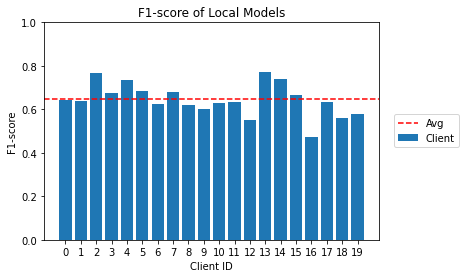

In [ ]:
plot_performance_of_local_models(precision_recall_fscores_of_local_aggregated_models, avg_local_aggregated_model_precision_recall_fscore)

In [ ]:
print_measures_of_dispersion(precision_recall_fscores_of_local_aggregated_models)

Variance of F1-score across local models: 0.0053255400763029676
Standard Deviation of F1-score across local models: 0.07297629804465945


No handles with labels found to put in legend.


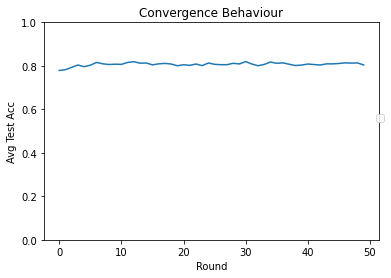

In [ ]:
plot_convergence_behaviour_from_federated_evaluation(federated_test_accs)

In [ ]:
get_utility_measure_on_distributions(avg_local_aggregated_model_precision_recall_fscore, avg_local_model_precision_recall_fscore)

Distribution      Precision       Recall       F1-score      
                      Aggr. Local  Aggr. Local    Aggr. Local
iid-quantity-skew      0.62  0.57   0.71  0.62     0.65  0.58

# Label Distribution Skew: Distribution-based label imbalance

Each client is allocated a proportion of the samples of each label according to a Dirichlet distribution. Dirichlet distribution [is an appropriate
choice](https://arxiv.org/pdf/2102.02079.pdf) to simulate imbalanced data distributions in the real-world. Specifically, we sample $p_k ∼ Dir_N(β)$ and allocate a $p_{k,j}$ proportion of the instances of class $k$ to client $j$. This partitioning strategy has been used to simulate real world data distributions in many recent FL studies, see [here](https://www.ijcai.org/proceedings/2021/0205.pdf), [here](https://proceedings.neurips.cc/paper/2020/file/18df51b97ccd68128e994804f3eccc87-Paper.pdf), [here](https://arxiv.org/pdf/2002.06440.pdf) and [here](https://proceedings.neurips.cc/paper/2020/file/564127c03caab942e503ee6f810f54fd-Paper.pdf).

### [Centralized Evaluation](https://flower.dev/docs/evaluation.html)

In [ ]:
# Overrides to global experiment config
DATA_PARTITIONING_STRATEGY = "noniid-distribution-based-label-imbalance"
EVAL_STRATEGY = "centralized"
DATA_SHARING = False

In [ ]:
# Split train set into NUMBER_OF_CLIENTS partitions.
partitioned_train_set = get_train_partitions(X_train, y_train.to_numpy())

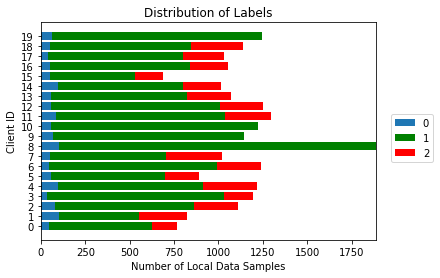

In [ ]:
plot_distribution_of_labels(partitioned_train_set)

In [ ]:
# Run sim with global config
sim_results = run_sim(partitioned_train_set)

INFO flower 2022-03-07 00:20:18,135 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-03-07 00:20:18,141 | server.py:128 | Initializing global parameters
INFO flower 2022-03-07 00:20:18,143 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 97518


INFO flower 2022-03-07 00:20:20,166 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-07 00:20:20,171 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-07 00:20:20,174 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-03-07 00:20:20,178 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-03-07 00:20:20,180 | server.py:130 | Evaluating initial parameters


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:20:20,243 | server.py:137 | initial parameters (loss, other metrics): 1.0986122886681096, {'accuracy': 0.057684550221863654}
INFO flower 2022-03-07 00:20:20,248 | server.py:143 | FL starting


initializing Client1 with pid 97577


INFO flower 2022-03-07 00:20:21,197 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-07 00:20:21,201 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-07 00:20:21,205 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 97607


INFO flower 2022-03-07 00:20:22,227 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-07 00:20:22,232 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-07 00:20:22,234 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 97639


INFO flower 2022-03-07 00:20:23,263 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-07 00:20:23,267 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-07 00:20:23,271 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-03-07 00:20:23,273 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 97675


INFO flower 2022-03-07 00:20:24,291 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-07 00:20:24,295 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-07 00:20:24,298 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 97713


INFO flower 2022-03-07 00:20:25,324 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-07 00:20:25,328 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-07 00:20:25,331 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-03-07 00:20:25,333 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 97753


INFO flower 2022-03-07 00:20:26,374 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-07 00:20:26,379 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-07 00:20:26,382 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 97793


INFO flower 2022-03-07 00:20:27,404 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-07 00:20:27,410 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-07 00:20:27,413 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 97835


INFO flower 2022-03-07 00:20:28,440 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-07 00:20:28,446 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-07 00:20:28,456 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 97879


INFO flower 2022-03-07 00:20:29,474 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-07 00:20:29,480 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-07 00:20:29,484 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-03-07 00:20:29,486 | connection.py:39 | ChannelConnectivity.READY


initializing Client10 with pid 97927


INFO flower 2022-03-07 00:20:30,513 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-07 00:20:30,520 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-07 00:20:30,522 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-03-07 00:20:30,525 | connection.py:39 | ChannelConnectivity.READY


initializing Client11 with pid 97977


INFO flower 2022-03-07 00:20:31,539 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-07 00:20:31,545 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-07 00:20:31,549 | connection.py:39 | ChannelConnectivity.READY


initializing Client12 with pid 98027


INFO flower 2022-03-07 00:20:32,572 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-07 00:20:32,577 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-07 00:20:32,580 | connection.py:39 | ChannelConnectivity.READY


initializing Client13 with pid 98079


INFO flower 2022-03-07 00:20:33,608 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-07 00:20:33,613 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-07 00:20:33,616 | connection.py:39 | ChannelConnectivity.READY


initializing Client14 with pid 98134


INFO flower 2022-03-07 00:20:34,647 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-07 00:20:34,651 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-07 00:20:34,655 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-03-07 00:20:34,656 | connection.py:39 | ChannelConnectivity.READY


initializing Client15 with pid 98192


INFO flower 2022-03-07 00:20:35,684 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-07 00:20:35,690 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-07 00:20:35,692 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-03-07 00:20:35,694 | connection.py:39 | ChannelConnectivity.READY


initializing Client16 with pid 98254


INFO flower 2022-03-07 00:20:36,717 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-07 00:20:36,722 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-07 00:20:36,725 | connection.py:39 | ChannelConnectivity.READY


initializing Client17 with pid 98314


INFO flower 2022-03-07 00:20:37,747 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-07 00:20:37,751 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-07 00:20:37,753 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-03-07 00:20:37,755 | connection.py:39 | ChannelConnectivity.READY


initializing Client18 with pid 98378


INFO flower 2022-03-07 00:20:38,782 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-07 00:20:38,787 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-07 00:20:38,790 | connection.py:39 | ChannelConnectivity.READY


initializing Client19 with pid 98442


INFO flower 2022-03-07 00:20:39,810 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-07 00:20:39,814 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-07 00:20:39,826 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-03-07 00:20:39,826 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client18 with pid 98378 is sampled in training rnd 1
Client2 with pid 97607 is sampled in training rnd 1
Client8 with pid 97835 is sampled in training rnd 1
Client15 with pid 98192 is sampled in training rnd 1
Client12 with pid 98027 is sampled in training rnd 1
Client3 with pid 97639 is sampled in training rnd 1
Client7 with pid 97793 is sampled in training rnd 1
Client13 with pid 98079 is sampled in training rnd 1
Client10 with pid 97927 is sampled in training rnd 1
Client14 with pid 98134 is sampled in training rnd 1
Client1 with pid 97577 is sampled in training rnd 1
Client6 with pid 97753 is sampled in training rnd 1
Client16 with pid 98254 is sampled in training rnd 1
Client0 with pid 97518 is sampled in training rnd 1


DEBUG flower 2022-03-07 00:20:40,952 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:20:41,084 | server.py:164 | fit progress: (1, 0.670926458091591, {'accuracy': 0.7503025413473174}, 20.830315808001615)
INFO flower 2022-03-07 00:20:41,086 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:20:41,089 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client12 with pid 98027 is sampled in training rnd 2
Client13 with pid 98079 is sampled in training rnd 2
Client0 with pid 97518 is sampled in training rnd 2
Client14 with pid 98134 is sampled in training rnd 2
Client8 with pid 97835 is sampled in training rnd 2
Client11 with pid 97977 is sampled in training rnd 2
Client19 with pid 98442 is sampled in training rnd 2
Client3 with pid 97639 is sampled in training rnd 2
Client9 with pid 97879 is sampled in training rnd 2
Client1 with pid 97577 is sampled in training rnd 2
Client5 with pid 97713 is sampled in training rnd 2
Client17 with pid 98314 is sampled in training rnd 2
Client15 with pid 98192 is sampled in training rnd 2
Client7 with pid 97793 is sampled in training rnd 2


DEBUG flower 2022-03-07 00:20:42,421 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:20:42,495 | server.py:164 | fit progress: (2, 0.5593567512103752, {'accuracy': 0.8059701492537313}, 22.242063751997193)
INFO flower 2022-03-07 00:20:42,517 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:20:42,523 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client17 with pid 98314 is sampled in training rnd 3
Client12 with pid 98027 is sampled in training rnd 3
Client6 with pid 97753 is sampled in training rnd 3
Client13 with pid 98079 is sampled in training rnd 3
Client0 with pid 97518 is sampled in training rnd 3
Client11 with pid 97977 is sampled in training rnd 3
Client8 with pid 97835 is sampled in training rnd 3
Client18 with pid 98378 is sampled in training rnd 3
Client3 with pid 97639 is sampled in training rnd 3
Client7 with pid 97793 is sampled in training rnd 3
Client10 with pid 97927 is sampled in training rnd 3
Client19 with pid 98442 is sampled in training rnd 3
Client14 with pid 98134 is sampled in training rnd 3
Client2 with pid 97607 is sampled in training rnd 3


DEBUG flower 2022-03-07 00:20:43,858 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:20:43,993 | server.py:164 | fit progress: (3, 0.5593342202534529, {'accuracy': 0.8128277531262605}, 23.73962031499832)
INFO flower 2022-03-07 00:20:43,998 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:20:44,002 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client7 with pid 97793 is sampled in training rnd 4
Client19 with pid 98442 is sampled in training rnd 4
Client9 with pid 97879 is sampled in training rnd 4
Client0 with pid 97518 is sampled in training rnd 4
Client14 with pid 98134 is sampled in training rnd 4
Client6 with pid 97753 is sampled in training rnd 4
Client13 with pid 98079 is sampled in training rnd 4
Client8 with pid 97835 is sampled in training rnd 4
Client10 with pid 97927 is sampled in training rnd 4
Client1 with pid 97577 is sampled in training rnd 4
Client4 with pid 97675 is sampled in training rnd 4
Client2 with pid 97607 is sampled in training rnd 4
Client11 with pid 97977 is sampled in training rnd 4
Client5 with pid 97713 is sampled in training rnd 4


DEBUG flower 2022-03-07 00:20:45,355 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:20:45,468 | server.py:164 | fit progress: (4, 0.586823425524951, {'accuracy': 0.8120209762000806}, 25.214225652001915)
INFO flower 2022-03-07 00:20:45,473 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:20:45,477 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client10 with pid 97927 is sampled in training rnd 5
Client13 with pid 98079 is sampled in training rnd 5
Client18 with pid 98378 is sampled in training rnd 5
Client6 with pid 97753 is sampled in training rnd 5
Client16 with pid 98254 is sampled in training rnd 5
Client4 with pid 97675 is sampled in training rnd 5
Client9 with pid 97879 is sampled in training rnd 5
Client14 with pid 98134 is sampled in training rnd 5
Client8 with pid 97835 is sampled in training rnd 5
Client7 with pid 97793 is sampled in training rnd 5
Client15 with pid 98192 is sampled in training rnd 5
Client0 with pid 97518 is sampled in training rnd 5
Client11 with pid 97977 is sampled in training rnd 5
Client1 with pid 97577 is sampled in training rnd 5


DEBUG flower 2022-03-07 00:20:46,785 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:20:46,903 | server.py:164 | fit progress: (5, 0.6231993536748847, {'accuracy': 0.7870108914885035}, 26.64996018900274)
INFO flower 2022-03-07 00:20:46,907 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:20:46,923 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client13 with pid 98079 is sampled in training rnd 6
Client12 with pid 98027 is sampled in training rnd 6
Client11 with pid 97977 is sampled in training rnd 6
Client5 with pid 97713 is sampled in training rnd 6
Client16 with pid 98254 is sampled in training rnd 6
Client1 with pid 97577 is sampled in training rnd 6
Client7 with pid 97793 is sampled in training rnd 6
Client8 with pid 97835 is sampled in training rnd 6
Client2 with pid 97607 is sampled in training rnd 6
Client15 with pid 98192 is sampled in training rnd 6
Client14 with pid 98134 is sampled in training rnd 6
Client10 with pid 97927 is sampled in training rnd 6
Client9 with pid 97879 is sampled in training rnd 6
Client6 with pid 97753 is sampled in training rnd 6


DEBUG flower 2022-03-07 00:20:48,212 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:20:48,324 | server.py:164 | fit progress: (6, 0.600782072436878, {'accuracy': 0.7991125453812021}, 28.070963832004054)
INFO flower 2022-03-07 00:20:48,328 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:20:48,340 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client0 with pid 97518 is sampled in training rnd 7
Client15 with pid 98192 is sampled in training rnd 7
Client19 with pid 98442 is sampled in training rnd 7
Client1 with pid 97577 is sampled in training rnd 7
Client9 with pid 97879 is sampled in training rnd 7
Client13 with pid 98079 is sampled in training rnd 7
Client17 with pid 98314 is sampled in training rnd 7
Client11 with pid 97977 is sampled in training rnd 7
Client12 with pid 98027 is sampled in training rnd 7
Client14 with pid 98134 is sampled in training rnd 7
Client8 with pid 97835 is sampled in training rnd 7
Client2 with pid 97607 is sampled in training rnd 7
Client4 with pid 97675 is sampled in training rnd 7
Client6 with pid 97753 is sampled in training rnd 7


DEBUG flower 2022-03-07 00:20:49,699 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:20:49,816 | server.py:164 | fit progress: (7, 0.5386517192596276, {'accuracy': 0.7946752722872126}, 29.56213876399852)
INFO flower 2022-03-07 00:20:49,818 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:20:49,828 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client0 with pid 97518 is sampled in training rnd 8
Client7 with pid 97793 is sampled in training rnd 8
Client6 with pid 97753 is sampled in training rnd 8
Client19 with pid 98442 is sampled in training rnd 8
Client12 with pid 98027 is sampled in training rnd 8
Client8 with pid 97835 is sampled in training rnd 8
Client5 with pid 97713 is sampled in training rnd 8
Client9 with pid 97879 is sampled in training rnd 8
Client13 with pid 98079 is sampled in training rnd 8
Client4 with pid 97675 is sampled in training rnd 8
Client16 with pid 98254 is sampled in training rnd 8
Client14 with pid 98134 is sampled in training rnd 8
Client18 with pid 98378 is sampled in training rnd 8
Client3 with pid 97639 is sampled in training rnd 8


DEBUG flower 2022-03-07 00:20:51,221 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:20:51,359 | server.py:164 | fit progress: (8, 0.5357219375015129, {'accuracy': 0.8221056877773296}, 31.10529387099814)
INFO flower 2022-03-07 00:20:51,363 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:20:51,371 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client16 with pid 98254 is sampled in training rnd 9
Client4 with pid 97675 is sampled in training rnd 9
Client19 with pid 98442 is sampled in training rnd 9
Client6 with pid 97753 is sampled in training rnd 9
Client13 with pid 98079 is sampled in training rnd 9
Client0 with pid 97518 is sampled in training rnd 9
Client7 with pid 97793 is sampled in training rnd 9
Client5 with pid 97713 is sampled in training rnd 9
Client9 with pid 97879 is sampled in training rnd 9
Client8 with pid 97835 is sampled in training rnd 9
Client3 with pid 97639 is sampled in training rnd 9
Client10 with pid 97927 is sampled in training rnd 9
Client17 with pid 98314 is sampled in training rnd 9
Client11 with pid 97977 is sampled in training rnd 9


DEBUG flower 2022-03-07 00:20:52,742 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:20:52,870 | server.py:164 | fit progress: (9, 0.5567901931059062, {'accuracy': 0.7886244453408633}, 32.6163217880021)
INFO flower 2022-03-07 00:20:52,871 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:20:52,874 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client13 with pid 98079 is sampled in training rnd 10
Client11 with pid 97977 is sampled in training rnd 10
Client19 with pid 98442 is sampled in training rnd 10
Client0 with pid 97518 is sampled in training rnd 10
Client10 with pid 97927 is sampled in training rnd 10
Client9 with pid 97879 is sampled in training rnd 10
Client7 with pid 97793 is sampled in training rnd 10
Client16 with pid 98254 is sampled in training rnd 10
Client2 with pid 97607 is sampled in training rnd 10
Client15 with pid 98192 is sampled in training rnd 10
Client8 with pid 97835 is sampled in training rnd 10
Client3 with pid 97639 is sampled in training rnd 10
Client18 with pid 98378 is sampled in training rnd 10
Client6 with pid 97753 is sampled in training rnd 10


DEBUG flower 2022-03-07 00:20:54,158 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:20:54,282 | server.py:164 | fit progress: (10, 0.5755753664570308, {'accuracy': 0.7853973376361436}, 34.028349184001854)
INFO flower 2022-03-07 00:20:54,291 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:20:54,299 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client2 with pid 97607 is sampled in training rnd 11
Client17 with pid 98314 is sampled in training rnd 11
Client8 with pid 97835 is sampled in training rnd 11
Client13 with pid 98079 is sampled in training rnd 11
Client1 with pid 97577 is sampled in training rnd 11
Client19 with pid 98442 is sampled in training rnd 11
Client7 with pid 97793 is sampled in training rnd 11
Client0 with pid 97518 is sampled in training rnd 11
Client12 with pid 98027 is sampled in training rnd 11
Client16 with pid 98254 is sampled in training rnd 11
Client4 with pid 97675 is sampled in training rnd 11
Client3 with pid 97639 is sampled in training rnd 11
Client9 with pid 97879 is sampled in training rnd 11
Client10 with pid 97927 is sampled in training rnd 11


DEBUG flower 2022-03-07 00:20:55,522 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:20:55,664 | server.py:164 | fit progress: (11, 0.5618066388188977, {'accuracy': 0.7870108914885035}, 35.41068005499983)
INFO flower 2022-03-07 00:20:55,674 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:20:55,684 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client19 with pid 98442 is sampled in training rnd 12
Client11 with pid 97977 is sampled in training rnd 12
Client9 with pid 97879 is sampled in training rnd 12
Client2 with pid 97607 is sampled in training rnd 12
Client5 with pid 97713 is sampled in training rnd 12
Client15 with pid 98192 is sampled in training rnd 12
Client4 with pid 97675 is sampled in training rnd 12
Client14 with pid 98134 is sampled in training rnd 12
Client8 with pid 97835 is sampled in training rnd 12
Client12 with pid 98027 is sampled in training rnd 12
Client13 with pid 98079 is sampled in training rnd 12
Client16 with pid 98254 is sampled in training rnd 12
Client7 with pid 97793 is sampled in training rnd 12
Client18 with pid 98378 is sampled in training rnd 12


DEBUG flower 2022-03-07 00:20:57,047 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:20:57,176 | server.py:164 | fit progress: (12, 0.5669563274215024, {'accuracy': 0.7910447761194029}, 36.92268322000018)
INFO flower 2022-03-07 00:20:57,181 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:20:57,187 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client10 with pid 97927 is sampled in training rnd 13
Client15 with pid 98192 is sampled in training rnd 13
Client18 with pid 98378 is sampled in training rnd 13
Client4 with pid 97675 is sampled in training rnd 13
Client3 with pid 97639 is sampled in training rnd 13
Client0 with pid 97518 is sampled in training rnd 13
Client5 with pid 97713 is sampled in training rnd 13
Client13 with pid 98079 is sampled in training rnd 13
Client16 with pid 98254 is sampled in training rnd 13
Client6 with pid 97753 is sampled in training rnd 13
Client14 with pid 98134 is sampled in training rnd 13
Client9 with pid 97879 is sampled in training rnd 13
Client12 with pid 98027 is sampled in training rnd 13
Client1 with pid 97577 is sampled in training rnd 13


DEBUG flower 2022-03-07 00:20:58,544 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:20:58,668 | server.py:164 | fit progress: (13, 0.5739472210062421, {'accuracy': 0.8027430415490117}, 38.415103778999764)
INFO flower 2022-03-07 00:20:58,674 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:20:58,677 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client16 with pid 98254 is sampled in training rnd 14
Client6 with pid 97753 is sampled in training rnd 14
Client13 with pid 98079 is sampled in training rnd 14
Client0 with pid 97518 is sampled in training rnd 14
Client7 with pid 97793 is sampled in training rnd 14
Client19 with pid 98442 is sampled in training rnd 14
Client2 with pid 97607 is sampled in training rnd 14
Client18 with pid 98378 is sampled in training rnd 14
Client12 with pid 98027 is sampled in training rnd 14
Client14 with pid 98134 is sampled in training rnd 14
Client15 with pid 98192 is sampled in training rnd 14
Client8 with pid 97835 is sampled in training rnd 14
Client17 with pid 98314 is sampled in training rnd 14
Client4 with pid 97675 is sampled in training rnd 14


DEBUG flower 2022-03-07 00:21:00,132 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:21:00,229 | server.py:164 | fit progress: (14, 0.535885053895097, {'accuracy': 0.7890278338039532}, 39.975842350002495)
INFO flower 2022-03-07 00:21:00,235 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:21:00,241 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client16 with pid 98254 is sampled in training rnd 15
Client7 with pid 97793 is sampled in training rnd 15
Client14 with pid 98134 is sampled in training rnd 15
Client19 with pid 98442 is sampled in training rnd 15
Client0 with pid 97518 is sampled in training rnd 15
Client6 with pid 97753 is sampled in training rnd 15
Client10 with pid 97927 is sampled in training rnd 15
Client9 with pid 97879 is sampled in training rnd 15
Client5 with pid 97713 is sampled in training rnd 15
Client13 with pid 98079 is sampled in training rnd 15
Client17 with pid 98314 is sampled in training rnd 15
Client15 with pid 98192 is sampled in training rnd 15
Client4 with pid 97675 is sampled in training rnd 15
Client1 with pid 97577 is sampled in training rnd 15


DEBUG flower 2022-03-07 00:21:01,634 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:21:01,745 | server.py:164 | fit progress: (15, 0.5594179137293087, {'accuracy': 0.7914481645824929}, 41.49113959600072)
INFO flower 2022-03-07 00:21:01,747 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:21:01,749 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client1 with pid 97577 is sampled in training rnd 16
Client6 with pid 97753 is sampled in training rnd 16
Client9 with pid 97879 is sampled in training rnd 16
Client2 with pid 97607 is sampled in training rnd 16
Client4 with pid 97675 is sampled in training rnd 16
Client16 with pid 98254 is sampled in training rnd 16
Client11 with pid 97977 is sampled in training rnd 16
Client15 with pid 98192 is sampled in training rnd 16
Client14 with pid 98134 is sampled in training rnd 16
Client19 with pid 98442 is sampled in training rnd 16
Client13 with pid 98079 is sampled in training rnd 16
Client17 with pid 98314 is sampled in training rnd 16
Client12 with pid 98027 is sampled in training rnd 16
Client0 with pid 97518 is sampled in training rnd 16


DEBUG flower 2022-03-07 00:21:03,206 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:21:03,333 | server.py:164 | fit progress: (16, 0.523017150388174, {'accuracy': 0.8039532069382815}, 43.07919091900112)
INFO flower 2022-03-07 00:21:03,337 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:21:03,345 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client17 with pid 98314 is sampled in training rnd 17
Client1 with pid 97577 is sampled in training rnd 17
Client6 with pid 97753 is sampled in training rnd 17
Client0 with pid 97518 is sampled in training rnd 17
Client13 with pid 98079 is sampled in training rnd 17
Client14 with pid 98134 is sampled in training rnd 17
Client16 with pid 98254 is sampled in training rnd 17
Client5 with pid 97713 is sampled in training rnd 17
Client12 with pid 98027 is sampled in training rnd 17
Client11 with pid 97977 is sampled in training rnd 17
Client19 with pid 98442 is sampled in training rnd 17
Client8 with pid 97835 is sampled in training rnd 17
Client18 with pid 98378 is sampled in training rnd 17
Client9 with pid 97879 is sampled in training rnd 17


DEBUG flower 2022-03-07 00:21:04,680 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:21:04,833 | server.py:164 | fit progress: (17, 0.5411787633455862, {'accuracy': 0.8208955223880597}, 44.57936442299979)
INFO flower 2022-03-07 00:21:04,838 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:21:04,845 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client11 with pid 97977 is sampled in training rnd 18
Client3 with pid 97639 is sampled in training rnd 18
Client6 with pid 97753 is sampled in training rnd 18
Client13 with pid 98079 is sampled in training rnd 18
Client17 with pid 98314 is sampled in training rnd 18
Client7 with pid 97793 is sampled in training rnd 18
Client1 with pid 97577 is sampled in training rnd 18
Client15 with pid 98192 is sampled in training rnd 18
Client10 with pid 97927 is sampled in training rnd 18
Client4 with pid 97675 is sampled in training rnd 18
Client8 with pid 97835 is sampled in training rnd 18
Client14 with pid 98134 is sampled in training rnd 18
Client2 with pid 97607 is sampled in training rnd 18
Client0 with pid 97518 is sampled in training rnd 18


DEBUG flower 2022-03-07 00:21:06,249 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:21:06,371 | server.py:164 | fit progress: (18, 0.5756921257052255, {'accuracy': 0.8047599838644615}, 46.11779483000282)
INFO flower 2022-03-07 00:21:06,374 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:21:06,379 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client19 with pid 98442 is sampled in training rnd 19
Client12 with pid 98027 is sampled in training rnd 19
Client9 with pid 97879 is sampled in training rnd 19
Client0 with pid 97518 is sampled in training rnd 19
Client5 with pid 97713 is sampled in training rnd 19
Client3 with pid 97639 is sampled in training rnd 19
Client13 with pid 98079 is sampled in training rnd 19
Client15 with pid 98192 is sampled in training rnd 19
Client17 with pid 98314 is sampled in training rnd 19
Client2 with pid 97607 is sampled in training rnd 19
Client18 with pid 98378 is sampled in training rnd 19
Client6 with pid 97753 is sampled in training rnd 19
Client14 with pid 98134 is sampled in training rnd 19
Client10 with pid 97927 is sampled in training rnd 19


DEBUG flower 2022-03-07 00:21:07,799 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:21:07,928 | server.py:164 | fit progress: (19, 0.5427628612627707, {'accuracy': 0.7979023799919323}, 47.674428819998866)
INFO flower 2022-03-07 00:21:07,933 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:21:07,943 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client3 with pid 97639 is sampled in training rnd 20
Client12 with pid 98027 is sampled in training rnd 20
Client17 with pid 98314 is sampled in training rnd 20
Client11 with pid 97977 is sampled in training rnd 20
Client15 with pid 98192 is sampled in training rnd 20
Client18 with pid 98378 is sampled in training rnd 20
Client8 with pid 97835 is sampled in training rnd 20
Client19 with pid 98442 is sampled in training rnd 20
Client1 with pid 97577 is sampled in training rnd 20
Client0 with pid 97518 is sampled in training rnd 20
Client16 with pid 98254 is sampled in training rnd 20
Client2 with pid 97607 is sampled in training rnd 20
Client13 with pid 98079 is sampled in training rnd 20
Client9 with pid 97879 is sampled in training rnd 20


DEBUG flower 2022-03-07 00:21:09,342 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:21:09,479 | server.py:164 | fit progress: (20, 0.5574443701926433, {'accuracy': 0.7942718838241226}, 49.225272923002194)
INFO flower 2022-03-07 00:21:09,489 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:21:09,500 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client17 with pid 98314 is sampled in training rnd 21
Client6 with pid 97753 is sampled in training rnd 21
Client8 with pid 97835 is sampled in training rnd 21
Client10 with pid 97927 is sampled in training rnd 21
Client19 with pid 98442 is sampled in training rnd 21
Client5 with pid 97713 is sampled in training rnd 21
Client14 with pid 98134 is sampled in training rnd 21
Client13 with pid 98079 is sampled in training rnd 21
Client1 with pid 97577 is sampled in training rnd 21
Client3 with pid 97639 is sampled in training rnd 21
Client4 with pid 97675 is sampled in training rnd 21
Client7 with pid 97793 is sampled in training rnd 21
Client2 with pid 97607 is sampled in training rnd 21
Client16 with pid 98254 is sampled in training rnd 21


DEBUG flower 2022-03-07 00:21:10,884 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:21:11,023 | server.py:164 | fit progress: (21, 0.5485017485284073, {'accuracy': 0.8067769261799113}, 50.76932956500241)
INFO flower 2022-03-07 00:21:11,027 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:21:11,035 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client17 with pid 98314 is sampled in training rnd 22
Client3 with pid 97639 is sampled in training rnd 22
Client10 with pid 97927 is sampled in training rnd 22
Client1 with pid 97577 is sampled in training rnd 22
Client13 with pid 98079 is sampled in training rnd 22
Client16 with pid 98254 is sampled in training rnd 22
Client6 with pid 97753 is sampled in training rnd 22
Client12 with pid 98027 is sampled in training rnd 22
Client2 with pid 97607 is sampled in training rnd 22
Client11 with pid 97977 is sampled in training rnd 22
Client5 with pid 97713 is sampled in training rnd 22
Client14 with pid 98134 is sampled in training rnd 22
Client15 with pid 98192 is sampled in training rnd 22
Client0 with pid 97518 is sampled in training rnd 22


DEBUG flower 2022-03-07 00:21:12,465 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:21:12,594 | server.py:164 | fit progress: (22, 0.554458152680791, {'accuracy': 0.7987091569181122}, 52.340380904002814)
INFO flower 2022-03-07 00:21:12,596 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:21:12,598 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client17 with pid 98314 is sampled in training rnd 23
Client18 with pid 98378 is sampled in training rnd 23
Client7 with pid 97793 is sampled in training rnd 23
Client2 with pid 97607 is sampled in training rnd 23
Client8 with pid 97835 is sampled in training rnd 23
Client5 with pid 97713 is sampled in training rnd 23
Client4 with pid 97675 is sampled in training rnd 23
Client9 with pid 97879 is sampled in training rnd 23
Client15 with pid 98192 is sampled in training rnd 23
Client1 with pid 97577 is sampled in training rnd 23
Client19 with pid 98442 is sampled in training rnd 23
Client13 with pid 98079 is sampled in training rnd 23
Client10 with pid 97927 is sampled in training rnd 23
Client6 with pid 97753 is sampled in training rnd 23


DEBUG flower 2022-03-07 00:21:13,932 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:21:14,060 | server.py:164 | fit progress: (23, 0.5803212481859877, {'accuracy': 0.8176684146833401}, 53.80624378000357)
INFO flower 2022-03-07 00:21:14,064 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:21:14,068 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client1 with pid 97577 is sampled in training rnd 24
Client9 with pid 97879 is sampled in training rnd 24
Client0 with pid 97518 is sampled in training rnd 24
Client17 with pid 98314 is sampled in training rnd 24
Client2 with pid 97607 is sampled in training rnd 24
Client6 with pid 97753 is sampled in training rnd 24
Client12 with pid 98027 is sampled in training rnd 24
Client19 with pid 98442 is sampled in training rnd 24
Client16 with pid 98254 is sampled in training rnd 24
Client10 with pid 97927 is sampled in training rnd 24
Client14 with pid 98134 is sampled in training rnd 24
Client3 with pid 97639 is sampled in training rnd 24
Client15 with pid 98192 is sampled in training rnd 24
Client11 with pid 97977 is sampled in training rnd 24


DEBUG flower 2022-03-07 00:21:15,405 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:21:15,546 | server.py:164 | fit progress: (24, 0.5337931793379864, {'accuracy': 0.8132311415893505}, 55.29309549800382)
INFO flower 2022-03-07 00:21:15,558 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:21:15,564 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client14 with pid 98134 is sampled in training rnd 25
Client5 with pid 97713 is sampled in training rnd 25
Client7 with pid 97793 is sampled in training rnd 25
Client18 with pid 98378 is sampled in training rnd 25
Client3 with pid 97639 is sampled in training rnd 25
Client6 with pid 97753 is sampled in training rnd 25
Client19 with pid 98442 is sampled in training rnd 25
Client12 with pid 98027 is sampled in training rnd 25
Client4 with pid 97675 is sampled in training rnd 25
Client11 with pid 97977 is sampled in training rnd 25
Client10 with pid 97927 is sampled in training rnd 25
Client8 with pid 97835 is sampled in training rnd 25
Client17 with pid 98314 is sampled in training rnd 25
Client2 with pid 97607 is sampled in training rnd 25


DEBUG flower 2022-03-07 00:21:16,913 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:21:17,052 | server.py:164 | fit progress: (25, 0.5365963098654815, {'accuracy': 0.81807180314643}, 56.798820333999174)
INFO flower 2022-03-07 00:21:17,060 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:21:17,063 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client3 with pid 97639 is sampled in training rnd 26
Client10 with pid 97927 is sampled in training rnd 26
Client6 with pid 97753 is sampled in training rnd 26
Client0 with pid 97518 is sampled in training rnd 26
Client15 with pid 98192 is sampled in training rnd 26
Client12 with pid 98027 is sampled in training rnd 26
Client1 with pid 97577 is sampled in training rnd 26
Client4 with pid 97675 is sampled in training rnd 26
Client11 with pid 97977 is sampled in training rnd 26
Client9 with pid 97879 is sampled in training rnd 26
Client5 with pid 97713 is sampled in training rnd 26
Client7 with pid 97793 is sampled in training rnd 26
Client18 with pid 98378 is sampled in training rnd 26
Client2 with pid 97607 is sampled in training rnd 26


DEBUG flower 2022-03-07 00:21:18,429 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:21:18,505 | server.py:164 | fit progress: (26, 0.5636417257420367, {'accuracy': 0.7974989915288423}, 58.25115285300126)
INFO flower 2022-03-07 00:21:18,507 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:21:18,509 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client18 with pid 98378 is sampled in training rnd 27
Client12 with pid 98027 is sampled in training rnd 27
Client2 with pid 97607 is sampled in training rnd 27
Client10 with pid 97927 is sampled in training rnd 27
Client14 with pid 98134 is sampled in training rnd 27
Client1 with pid 97577 is sampled in training rnd 27
Client4 with pid 97675 is sampled in training rnd 27
Client3 with pid 97639 is sampled in training rnd 27
Client9 with pid 97879 is sampled in training rnd 27
Client8 with pid 97835 is sampled in training rnd 27
Client7 with pid 97793 is sampled in training rnd 27
Client5 with pid 97713 is sampled in training rnd 27
Client13 with pid 98079 is sampled in training rnd 27
Client15 with pid 98192 is sampled in training rnd 27


DEBUG flower 2022-03-07 00:21:19,761 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:21:19,885 | server.py:164 | fit progress: (27, 0.6026532984472986, {'accuracy': 0.8043565954013715}, 59.63143417399988)
INFO flower 2022-03-07 00:21:19,888 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:21:19,892 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client17 with pid 98314 is sampled in training rnd 28
Client9 with pid 97879 is sampled in training rnd 28
Client6 with pid 97753 is sampled in training rnd 28
Client18 with pid 98378 is sampled in training rnd 28
Client1 with pid 97577 is sampled in training rnd 28
Client7 with pid 97793 is sampled in training rnd 28
Client5 with pid 97713 is sampled in training rnd 28
Client4 with pid 97675 is sampled in training rnd 28
Client15 with pid 98192 is sampled in training rnd 28
Client13 with pid 98079 is sampled in training rnd 28
Client11 with pid 97977 is sampled in training rnd 28
Client14 with pid 98134 is sampled in training rnd 28
Client3 with pid 97639 is sampled in training rnd 28
Client10 with pid 97927 is sampled in training rnd 28


DEBUG flower 2022-03-07 00:21:21,235 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:21:21,337 | server.py:164 | fit progress: (28, 0.5691780725995996, {'accuracy': 0.7991125453812021}, 61.08357847700245)
INFO flower 2022-03-07 00:21:21,344 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:21:21,346 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client9 with pid 97879 is sampled in training rnd 29
Client1 with pid 97577 is sampled in training rnd 29
Client10 with pid 97927 is sampled in training rnd 29
Client5 with pid 97713 is sampled in training rnd 29
Client17 with pid 98314 is sampled in training rnd 29
Client12 with pid 98027 is sampled in training rnd 29
Client13 with pid 98079 is sampled in training rnd 29
Client19 with pid 98442 is sampled in training rnd 29
Client4 with pid 97675 is sampled in training rnd 29
Client3 with pid 97639 is sampled in training rnd 29
Client16 with pid 98254 is sampled in training rnd 29
Client18 with pid 98378 is sampled in training rnd 29
Client8 with pid 97835 is sampled in training rnd 29
Client7 with pid 97793 is sampled in training rnd 29


DEBUG flower 2022-03-07 00:21:22,613 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:21:22,746 | server.py:164 | fit progress: (29, 0.5612786186239271, {'accuracy': 0.827349737797499}, 62.49295141800394)
INFO flower 2022-03-07 00:21:22,754 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:21:22,759 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client7 with pid 97793 is sampled in training rnd 30
Client19 with pid 98442 is sampled in training rnd 30
Client0 with pid 97518 is sampled in training rnd 30
Client12 with pid 98027 is sampled in training rnd 30
Client2 with pid 97607 is sampled in training rnd 30
Client4 with pid 97675 is sampled in training rnd 30
Client8 with pid 97835 is sampled in training rnd 30
Client1 with pid 97577 is sampled in training rnd 30
Client11 with pid 97977 is sampled in training rnd 30
Client16 with pid 98254 is sampled in training rnd 30
Client18 with pid 98378 is sampled in training rnd 30
Client14 with pid 98134 is sampled in training rnd 30
Client9 with pid 97879 is sampled in training rnd 30
Client6 with pid 97753 is sampled in training rnd 30


DEBUG flower 2022-03-07 00:21:24,148 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:21:24,282 | server.py:164 | fit progress: (30, 0.5519052485886616, {'accuracy': 0.7934651068979427}, 64.02893041600328)
INFO flower 2022-03-07 00:21:24,293 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:21:24,298 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client15 with pid 98192 is sampled in training rnd 31
Client11 with pid 97977 is sampled in training rnd 31
Client4 with pid 97675 is sampled in training rnd 31
Client18 with pid 98378 is sampled in training rnd 31
Client12 with pid 98027 is sampled in training rnd 31
Client8 with pid 97835 is sampled in training rnd 31
Client3 with pid 97639 is sampled in training rnd 31
Client13 with pid 98079 is sampled in training rnd 31
Client5 with pid 97713 is sampled in training rnd 31
Client1 with pid 97577 is sampled in training rnd 31
Client14 with pid 98134 is sampled in training rnd 31
Client2 with pid 97607 is sampled in training rnd 31
Client9 with pid 97879 is sampled in training rnd 31
Client6 with pid 97753 is sampled in training rnd 31


DEBUG flower 2022-03-07 00:21:25,592 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:21:25,744 | server.py:164 | fit progress: (31, 0.5854478911488611, {'accuracy': 0.800726099233562}, 65.49093902800087)
INFO flower 2022-03-07 00:21:25,750 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:21:25,756 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client4 with pid 97675 is sampled in training rnd 32
Client19 with pid 98442 is sampled in training rnd 32
Client9 with pid 97879 is sampled in training rnd 32
Client3 with pid 97639 is sampled in training rnd 32
Client11 with pid 97977 is sampled in training rnd 32
Client16 with pid 98254 is sampled in training rnd 32
Client18 with pid 98378 is sampled in training rnd 32
Client10 with pid 97927 is sampled in training rnd 32
Client8 with pid 97835 is sampled in training rnd 32
Client2 with pid 97607 is sampled in training rnd 32
Client15 with pid 98192 is sampled in training rnd 32
Client17 with pid 98314 is sampled in training rnd 32
Client0 with pid 97518 is sampled in training rnd 32
Client6 with pid 97753 is sampled in training rnd 32


DEBUG flower 2022-03-07 00:21:27,099 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:21:27,247 | server.py:164 | fit progress: (32, 0.5514544593300961, {'accuracy': 0.8132311415893505}, 66.99348260399711)
INFO flower 2022-03-07 00:21:27,253 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:21:27,259 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client10 with pid 97927 is sampled in training rnd 33
Client17 with pid 98314 is sampled in training rnd 33
Client6 with pid 97753 is sampled in training rnd 33
Client5 with pid 97713 is sampled in training rnd 33
Client9 with pid 97879 is sampled in training rnd 33
Client8 with pid 97835 is sampled in training rnd 33
Client2 with pid 97607 is sampled in training rnd 33
Client18 with pid 98378 is sampled in training rnd 33
Client0 with pid 97518 is sampled in training rnd 33
Client19 with pid 98442 is sampled in training rnd 33
Client3 with pid 97639 is sampled in training rnd 33
Client4 with pid 97675 is sampled in training rnd 33
Client1 with pid 97577 is sampled in training rnd 33
Client16 with pid 98254 is sampled in training rnd 33


DEBUG flower 2022-03-07 00:21:28,575 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:21:28,710 | server.py:164 | fit progress: (33, 0.561954647909301, {'accuracy': 0.7934651068979427}, 68.45677481099847)
INFO flower 2022-03-07 00:21:28,723 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:21:28,726 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client14 with pid 98134 is sampled in training rnd 34
Client13 with pid 98079 is sampled in training rnd 34
Client19 with pid 98442 is sampled in training rnd 34
Client17 with pid 98314 is sampled in training rnd 34
Client8 with pid 97835 is sampled in training rnd 34
Client16 with pid 98254 is sampled in training rnd 34
Client0 with pid 97518 is sampled in training rnd 34
Client7 with pid 97793 is sampled in training rnd 34
Client6 with pid 97753 is sampled in training rnd 34
Client18 with pid 98378 is sampled in training rnd 34
Client5 with pid 97713 is sampled in training rnd 34
Client2 with pid 97607 is sampled in training rnd 34
Client4 with pid 97675 is sampled in training rnd 34
Client3 with pid 97639 is sampled in training rnd 34


DEBUG flower 2022-03-07 00:21:30,097 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:21:30,221 | server.py:164 | fit progress: (34, 0.537190195524657, {'accuracy': 0.7930617184348527}, 69.96722377900005)
INFO flower 2022-03-07 00:21:30,227 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:21:30,233 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client0 with pid 97518 is sampled in training rnd 35
Client19 with pid 98442 is sampled in training rnd 35
Client13 with pid 98079 is sampled in training rnd 35
Client1 with pid 97577 is sampled in training rnd 35
Client11 with pid 97977 is sampled in training rnd 35
Client18 with pid 98378 is sampled in training rnd 35
Client2 with pid 97607 is sampled in training rnd 35
Client14 with pid 98134 is sampled in training rnd 35
Client9 with pid 97879 is sampled in training rnd 35
Client15 with pid 98192 is sampled in training rnd 35
Client4 with pid 97675 is sampled in training rnd 35
Client12 with pid 98027 is sampled in training rnd 35
Client6 with pid 97753 is sampled in training rnd 35
Client8 with pid 97835 is sampled in training rnd 35


DEBUG flower 2022-03-07 00:21:31,595 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:21:31,714 | server.py:164 | fit progress: (35, 0.5388134877475413, {'accuracy': 0.7974989915288423}, 71.46037232899835)
INFO flower 2022-03-07 00:21:31,716 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:21:31,717 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client12 with pid 98027 is sampled in training rnd 36
Client5 with pid 97713 is sampled in training rnd 36
Client2 with pid 97607 is sampled in training rnd 36
Client7 with pid 97793 is sampled in training rnd 36
Client15 with pid 98192 is sampled in training rnd 36
Client8 with pid 97835 is sampled in training rnd 36
Client17 with pid 98314 is sampled in training rnd 36
Client0 with pid 97518 is sampled in training rnd 36
Client18 with pid 98378 is sampled in training rnd 36
Client19 with pid 98442 is sampled in training rnd 36
Client3 with pid 97639 is sampled in training rnd 36
Client16 with pid 98254 is sampled in training rnd 36
Client10 with pid 97927 is sampled in training rnd 36
Client13 with pid 98079 is sampled in training rnd 36


DEBUG flower 2022-03-07 00:21:33,016 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:21:33,142 | server.py:164 | fit progress: (36, 0.5252774939939013, {'accuracy': 0.8172650262202501}, 72.88906007000332)
INFO flower 2022-03-07 00:21:33,145 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:21:33,150 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client15 with pid 98192 is sampled in training rnd 37
Client7 with pid 97793 is sampled in training rnd 37
Client19 with pid 98442 is sampled in training rnd 37
Client13 with pid 98079 is sampled in training rnd 37
Client10 with pid 97927 is sampled in training rnd 37
Client8 with pid 97835 is sampled in training rnd 37
Client11 with pid 97977 is sampled in training rnd 37
Client9 with pid 97879 is sampled in training rnd 37
Client18 with pid 98378 is sampled in training rnd 37
Client4 with pid 97675 is sampled in training rnd 37
Client3 with pid 97639 is sampled in training rnd 37
Client0 with pid 97518 is sampled in training rnd 37
Client1 with pid 97577 is sampled in training rnd 37
Client6 with pid 97753 is sampled in training rnd 37


DEBUG flower 2022-03-07 00:21:34,578 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:21:34,708 | server.py:164 | fit progress: (37, 0.5711690411474496, {'accuracy': 0.7862041145623235}, 74.45427829700202)
INFO flower 2022-03-07 00:21:34,719 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:21:34,721 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client16 with pid 98254 is sampled in training rnd 38
Client11 with pid 97977 is sampled in training rnd 38
Client5 with pid 97713 is sampled in training rnd 38
Client4 with pid 97675 is sampled in training rnd 38
Client6 with pid 97753 is sampled in training rnd 38
Client19 with pid 98442 is sampled in training rnd 38
Client14 with pid 98134 is sampled in training rnd 38
Client18 with pid 98378 is sampled in training rnd 38
Client13 with pid 98079 is sampled in training rnd 38
Client8 with pid 97835 is sampled in training rnd 38
Client17 with pid 98314 is sampled in training rnd 38
Client2 with pid 97607 is sampled in training rnd 38
Client7 with pid 97793 is sampled in training rnd 38
Client12 with pid 98027 is sampled in training rnd 38


DEBUG flower 2022-03-07 00:21:36,093 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:21:36,229 | server.py:164 | fit progress: (38, 0.531353612319822, {'accuracy': 0.809600645421541}, 75.97611168800358)
INFO flower 2022-03-07 00:21:36,235 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:21:36,245 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client2 with pid 97607 is sampled in training rnd 39
Client16 with pid 98254 is sampled in training rnd 39
Client3 with pid 97639 is sampled in training rnd 39
Client12 with pid 98027 is sampled in training rnd 39
Client5 with pid 97713 is sampled in training rnd 39
Client4 with pid 97675 is sampled in training rnd 39
Client19 with pid 98442 is sampled in training rnd 39
Client6 with pid 97753 is sampled in training rnd 39
Client18 with pid 98378 is sampled in training rnd 39
Client9 with pid 97879 is sampled in training rnd 39
Client0 with pid 97518 is sampled in training rnd 39
Client7 with pid 97793 is sampled in training rnd 39
Client17 with pid 98314 is sampled in training rnd 39
Client15 with pid 98192 is sampled in training rnd 39


DEBUG flower 2022-03-07 00:21:37,665 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:21:37,794 | server.py:164 | fit progress: (39, 0.49798782588019824, {'accuracy': 0.8160548608309802}, 77.54069263400015)
INFO flower 2022-03-07 00:21:37,800 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:21:37,806 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client11 with pid 97977 is sampled in training rnd 40
Client12 with pid 98027 is sampled in training rnd 40
Client16 with pid 98254 is sampled in training rnd 40
Client1 with pid 97577 is sampled in training rnd 40
Client5 with pid 97713 is sampled in training rnd 40
Client8 with pid 97835 is sampled in training rnd 40
Client15 with pid 98192 is sampled in training rnd 40
Client18 with pid 98378 is sampled in training rnd 40
Client4 with pid 97675 is sampled in training rnd 40
Client10 with pid 97927 is sampled in training rnd 40
Client13 with pid 98079 is sampled in training rnd 40
Client19 with pid 98442 is sampled in training rnd 40
Client9 with pid 97879 is sampled in training rnd 40
Client7 with pid 97793 is sampled in training rnd 40


DEBUG flower 2022-03-07 00:21:39,167 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:21:39,299 | server.py:164 | fit progress: (40, 0.5549712790600722, {'accuracy': 0.8100040338846309}, 79.04609765900386)
INFO flower 2022-03-07 00:21:39,303 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:21:39,309 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client19 with pid 98442 is sampled in training rnd 41
Client14 with pid 98134 is sampled in training rnd 41
Client2 with pid 97607 is sampled in training rnd 41
Client7 with pid 97793 is sampled in training rnd 41
Client12 with pid 98027 is sampled in training rnd 41
Client6 with pid 97753 is sampled in training rnd 41
Client15 with pid 98192 is sampled in training rnd 41
Client13 with pid 98079 is sampled in training rnd 41
Client18 with pid 98378 is sampled in training rnd 41
Client5 with pid 97713 is sampled in training rnd 41
Client16 with pid 98254 is sampled in training rnd 41
Client11 with pid 97977 is sampled in training rnd 41
Client9 with pid 97879 is sampled in training rnd 41
Client1 with pid 97577 is sampled in training rnd 41


DEBUG flower 2022-03-07 00:21:40,672 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:21:40,774 | server.py:164 | fit progress: (41, 0.521071858102158, {'accuracy': 0.8100040338846309}, 80.52075371299725)
INFO flower 2022-03-07 00:21:40,783 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:21:40,792 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client3 with pid 97639 is sampled in training rnd 42
Client13 with pid 98079 is sampled in training rnd 42
Client18 with pid 98378 is sampled in training rnd 42
Client19 with pid 98442 is sampled in training rnd 42
Client10 with pid 97927 is sampled in training rnd 42
Client17 with pid 98314 is sampled in training rnd 42
Client4 with pid 97675 is sampled in training rnd 42
Client15 with pid 98192 is sampled in training rnd 42
Client16 with pid 98254 is sampled in training rnd 42
Client6 with pid 97753 is sampled in training rnd 42
Client8 with pid 97835 is sampled in training rnd 42
Client0 with pid 97518 is sampled in training rnd 42
Client11 with pid 97977 is sampled in training rnd 42
Client12 with pid 98027 is sampled in training rnd 42


DEBUG flower 2022-03-07 00:21:42,132 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:21:42,269 | server.py:164 | fit progress: (42, 0.5257679390650559, {'accuracy': 0.8152480839048003}, 82.01580871600163)
INFO flower 2022-03-07 00:21:42,275 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:21:42,280 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client18 with pid 98378 is sampled in training rnd 43
Client14 with pid 98134 is sampled in training rnd 43
Client0 with pid 97518 is sampled in training rnd 43
Client17 with pid 98314 is sampled in training rnd 43
Client7 with pid 97793 is sampled in training rnd 43
Client13 with pid 98079 is sampled in training rnd 43
Client3 with pid 97639 is sampled in training rnd 43
Client4 with pid 97675 is sampled in training rnd 43
Client2 with pid 97607 is sampled in training rnd 43
Client19 with pid 98442 is sampled in training rnd 43
Client11 with pid 97977 is sampled in training rnd 43
Client8 with pid 97835 is sampled in training rnd 43
Client12 with pid 98027 is sampled in training rnd 43
Client9 with pid 97879 is sampled in training rnd 43


DEBUG flower 2022-03-07 00:21:43,684 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:21:43,817 | server.py:164 | fit progress: (43, 0.5380248825524597, {'accuracy': 0.8124243646631706}, 83.56393514900265)
INFO flower 2022-03-07 00:21:43,819 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:21:43,821 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client9 with pid 97879 is sampled in training rnd 44
Client8 with pid 97835 is sampled in training rnd 44
Client14 with pid 98134 is sampled in training rnd 44
Client5 with pid 97713 is sampled in training rnd 44
Client18 with pid 98378 is sampled in training rnd 44
Client17 with pid 98314 is sampled in training rnd 44
Client15 with pid 98192 is sampled in training rnd 44
Client7 with pid 97793 is sampled in training rnd 44
Client6 with pid 97753 is sampled in training rnd 44
Client3 with pid 97639 is sampled in training rnd 44
Client1 with pid 97577 is sampled in training rnd 44
Client11 with pid 97977 is sampled in training rnd 44
Client19 with pid 98442 is sampled in training rnd 44
Client2 with pid 97607 is sampled in training rnd 44


DEBUG flower 2022-03-07 00:21:45,114 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:21:45,240 | server.py:164 | fit progress: (44, 0.543464878250652, {'accuracy': 0.7918515530455829}, 84.98677706799936)
INFO flower 2022-03-07 00:21:45,250 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:21:45,257 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client3 with pid 97639 is sampled in training rnd 45
Client0 with pid 97518 is sampled in training rnd 45
Client18 with pid 98378 is sampled in training rnd 45
Client19 with pid 98442 is sampled in training rnd 45
Client9 with pid 97879 is sampled in training rnd 45
Client10 with pid 97927 is sampled in training rnd 45
Client12 with pid 98027 is sampled in training rnd 45
Client11 with pid 97977 is sampled in training rnd 45
Client14 with pid 98134 is sampled in training rnd 45
Client2 with pid 97607 is sampled in training rnd 45
Client1 with pid 97577 is sampled in training rnd 45
Client8 with pid 97835 is sampled in training rnd 45
Client5 with pid 97713 is sampled in training rnd 45
Client4 with pid 97675 is sampled in training rnd 45


DEBUG flower 2022-03-07 00:21:46,590 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:21:46,714 | server.py:164 | fit progress: (45, 0.5658411828886823, {'accuracy': 0.7934651068979427}, 86.46011742800329)
INFO flower 2022-03-07 00:21:46,716 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:21:46,718 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client9 with pid 97879 is sampled in training rnd 46
Client13 with pid 98079 is sampled in training rnd 46
Client11 with pid 97977 is sampled in training rnd 46
Client16 with pid 98254 is sampled in training rnd 46
Client0 with pid 97518 is sampled in training rnd 46
Client10 with pid 97927 is sampled in training rnd 46
Client1 with pid 97577 is sampled in training rnd 46
Client7 with pid 97793 is sampled in training rnd 46
Client17 with pid 98314 is sampled in training rnd 46
Client12 with pid 98027 is sampled in training rnd 46
Client5 with pid 97713 is sampled in training rnd 46
Client6 with pid 97753 is sampled in training rnd 46
Client4 with pid 97675 is sampled in training rnd 46
Client2 with pid 97607 is sampled in training rnd 46


DEBUG flower 2022-03-07 00:21:48,057 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:21:48,190 | server.py:164 | fit progress: (46, 0.5866842985519738, {'accuracy': 0.800322710770472}, 87.93664333799825)
INFO flower 2022-03-07 00:21:48,199 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:21:48,201 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client15 with pid 98192 is sampled in training rnd 47
Client18 with pid 98378 is sampled in training rnd 47
Client3 with pid 97639 is sampled in training rnd 47
Client12 with pid 98027 is sampled in training rnd 47
Client17 with pid 98314 is sampled in training rnd 47
Client16 with pid 98254 is sampled in training rnd 47
Client8 with pid 97835 is sampled in training rnd 47
Client0 with pid 97518 is sampled in training rnd 47
Client9 with pid 97879 is sampled in training rnd 47
Client10 with pid 97927 is sampled in training rnd 47
Client13 with pid 98079 is sampled in training rnd 47
Client4 with pid 97675 is sampled in training rnd 47
Client14 with pid 98134 is sampled in training rnd 47
Client7 with pid 97793 is sampled in training rnd 47


DEBUG flower 2022-03-07 00:21:49,472 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:21:49,603 | server.py:164 | fit progress: (47, 0.5946491154958107, {'accuracy': 0.8051633723275514}, 89.34925471900351)
INFO flower 2022-03-07 00:21:49,609 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:21:49,610 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client13 with pid 98079 is sampled in training rnd 48
Client16 with pid 98254 is sampled in training rnd 48
Client8 with pid 97835 is sampled in training rnd 48
Client5 with pid 97713 is sampled in training rnd 48
Client3 with pid 97639 is sampled in training rnd 48
Client9 with pid 97879 is sampled in training rnd 48
Client19 with pid 98442 is sampled in training rnd 48
Client18 with pid 98378 is sampled in training rnd 48
Client7 with pid 97793 is sampled in training rnd 48
Client10 with pid 97927 is sampled in training rnd 48
Client15 with pid 98192 is sampled in training rnd 48
Client11 with pid 97977 is sampled in training rnd 48
Client0 with pid 97518 is sampled in training rnd 48
Client17 with pid 98314 is sampled in training rnd 48


DEBUG flower 2022-03-07 00:21:50,899 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:21:50,997 | server.py:164 | fit progress: (48, 0.5823852757340103, {'accuracy': 0.7761194029850746}, 90.74389661999885)
INFO flower 2022-03-07 00:21:51,001 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:21:51,006 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client18 with pid 98378 is sampled in training rnd 49
Client19 with pid 98442 is sampled in training rnd 49
Client10 with pid 97927 is sampled in training rnd 49
Client12 with pid 98027 is sampled in training rnd 49
Client17 with pid 98314 is sampled in training rnd 49
Client13 with pid 98079 is sampled in training rnd 49
Client9 with pid 97879 is sampled in training rnd 49
Client14 with pid 98134 is sampled in training rnd 49
Client11 with pid 97977 is sampled in training rnd 49
Client1 with pid 97577 is sampled in training rnd 49
Client7 with pid 97793 is sampled in training rnd 49
Client3 with pid 97639 is sampled in training rnd 49
Client4 with pid 97675 is sampled in training rnd 49
Client5 with pid 97713 is sampled in training rnd 49


DEBUG flower 2022-03-07 00:21:52,404 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:21:52,544 | server.py:164 | fit progress: (49, 0.5368310292991124, {'accuracy': 0.800322710770472}, 92.29026674899796)
INFO flower 2022-03-07 00:21:52,552 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:21:52,562 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client0 with pid 97518 is sampled in training rnd 50
Client4 with pid 97675 is sampled in training rnd 50
Client13 with pid 98079 is sampled in training rnd 50
Client12 with pid 98027 is sampled in training rnd 50
Client8 with pid 97835 is sampled in training rnd 50
Client2 with pid 97607 is sampled in training rnd 50
Client18 with pid 98378 is sampled in training rnd 50
Client16 with pid 98254 is sampled in training rnd 50
Client1 with pid 97577 is sampled in training rnd 50
Client9 with pid 97879 is sampled in training rnd 50
Client5 with pid 97713 is sampled in training rnd 50
Client19 with pid 98442 is sampled in training rnd 50
Client6 with pid 97753 is sampled in training rnd 50
Client17 with pid 98314 is sampled in training rnd 50


DEBUG flower 2022-03-07 00:21:53,979 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:21:54,116 | server.py:164 | fit progress: (50, 0.5324174095896332, {'accuracy': 0.8116175877369908}, 93.86234728000272)
INFO flower 2022-03-07 00:21:54,120 | server.py:209 | evaluate_round: no clients selected, cancel
INFO flower 2022-03-07 00:21:54,122 | server.py:182 | FL finished in 93.86880392400053
INFO flower 2022-03-07 00:21:54,127 | app.py:149 | app_fit: losses_distributed []
INFO flower 2022-03-07 00:21:54,133 | app.py:150 | app_fit: metrics_distributed {}
INFO flower 2022-03-07 00:21:54,143 | app.py:151 | app_fit: losses_centralized [(0, 1.0986122886681096), (1, 0.670926458091591), (2, 0.5593567512103752), (3, 0.5593342202534529), (4, 0.586823425524951), (5, 0.6231993536748847), (6, 0.600782072436878), (7, 0.5386517192596276), (8, 0.5357219375015129), (9, 0.5567901931059062), (10, 0.5755753664570308), (11, 0.5618066388188977), (12, 0.5669563274215024), (13, 0.5739472210062421), (14, 0.535885053895097), (15, 0.5594179137293087), (16, 0.523017150388174

In [ ]:
centralized_y_preds = sim_results["centralized_y_preds"]
centralized_test_accs = sim_results["centralized_test_accs"]

No handles with labels found to put in legend.


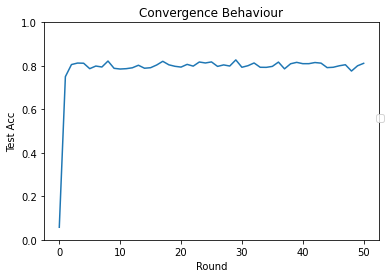

In [ ]:
plot_convergence_behaviour_from_centralized_evaluation(centralized_test_accs)

In [ ]:
ultimate_centralized_y_preds = centralized_y_preds[-1]

In [ ]:
print(report_classification_macro_averages(y_test, ultimate_centralized_y_preds))

              precision    recall  f1-score  
   macro avg       0.66      0.62      0.62     


### Centralized Evaluation with Data Sharing

In [ ]:
# Overrides to global experiment config
DATA_SHARING = True

In [ ]:
# Split client part of train set into NUMBER_OF_CLIENTS partitions.
partitioned_train_set = get_train_partitions(X_train, y_train.to_numpy())

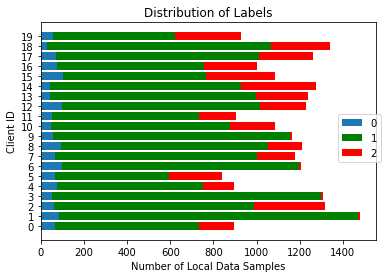

In [ ]:
plot_distribution_of_labels(partitioned_train_set)

In [ ]:
# Run sim with global config
sim_results = run_sim(partitioned_train_set)

INFO flower 2022-03-07 00:23:29,304 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-03-07 00:23:29,310 | server.py:128 | Initializing global parameters
INFO flower 2022-03-07 00:23:29,311 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 102476


INFO flower 2022-03-07 00:23:31,331 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-07 00:23:31,336 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-07 00:23:31,339 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-03-07 00:23:31,343 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-03-07 00:23:31,345 | server.py:130 | Evaluating initial parameters


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:23:31,405 | server.py:137 | initial parameters (loss, other metrics): 0.5997592804472799, {'accuracy': 0.7688584106494554}
INFO flower 2022-03-07 00:23:31,413 | server.py:143 | FL starting


initializing Client1 with pid 102535


INFO flower 2022-03-07 00:23:32,361 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-07 00:23:32,365 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-07 00:23:32,367 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 102565


INFO flower 2022-03-07 00:23:33,398 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-07 00:23:33,403 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-07 00:23:33,406 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 102597


INFO flower 2022-03-07 00:23:34,433 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-07 00:23:34,436 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-07 00:23:34,440 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 102633


INFO flower 2022-03-07 00:23:35,462 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-07 00:23:35,466 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-07 00:23:35,469 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 102669


INFO flower 2022-03-07 00:23:36,495 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-07 00:23:36,499 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-07 00:23:36,502 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 102707


INFO flower 2022-03-07 00:23:37,527 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-07 00:23:37,531 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-07 00:23:37,534 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 102747


INFO flower 2022-03-07 00:23:38,558 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-07 00:23:38,563 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-07 00:23:38,568 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 102790


INFO flower 2022-03-07 00:23:39,591 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-07 00:23:39,595 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-07 00:23:39,600 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 102834


INFO flower 2022-03-07 00:23:40,627 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-07 00:23:40,632 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-07 00:23:40,634 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-03-07 00:23:40,636 | connection.py:39 | ChannelConnectivity.READY


initializing Client10 with pid 102882


INFO flower 2022-03-07 00:23:41,664 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-07 00:23:41,670 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-07 00:23:41,673 | connection.py:39 | ChannelConnectivity.READY


initializing Client11 with pid 102930


INFO flower 2022-03-07 00:23:42,698 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-07 00:23:42,703 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-07 00:23:42,705 | connection.py:39 | ChannelConnectivity.READY


initializing Client12 with pid 102980


INFO flower 2022-03-07 00:23:43,726 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-07 00:23:43,729 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-07 00:23:43,731 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-03-07 00:23:43,733 | connection.py:39 | ChannelConnectivity.READY


initializing Client13 with pid 103034


INFO flower 2022-03-07 00:23:44,758 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-07 00:23:44,762 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-07 00:23:44,765 | connection.py:39 | ChannelConnectivity.READY


initializing Client14 with pid 103090


INFO flower 2022-03-07 00:23:45,795 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-07 00:23:45,798 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-07 00:23:45,802 | connection.py:39 | ChannelConnectivity.READY


initializing Client15 with pid 103146


INFO flower 2022-03-07 00:23:46,829 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-07 00:23:46,834 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-07 00:23:46,836 | connection.py:39 | ChannelConnectivity.READY


initializing Client16 with pid 103204


INFO flower 2022-03-07 00:23:47,858 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-07 00:23:47,862 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-07 00:23:47,864 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-03-07 00:23:47,866 | connection.py:39 | ChannelConnectivity.READY


initializing Client17 with pid 103266


INFO flower 2022-03-07 00:23:48,886 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-07 00:23:48,891 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-07 00:23:48,893 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-03-07 00:23:48,895 | connection.py:39 | ChannelConnectivity.READY


initializing Client18 with pid 103331


INFO flower 2022-03-07 00:23:49,920 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-07 00:23:49,924 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-07 00:23:49,927 | connection.py:39 | ChannelConnectivity.READY


initializing Client19 with pid 103395


INFO flower 2022-03-07 00:23:50,958 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-07 00:23:50,962 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-07 00:23:50,977 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-03-07 00:23:50,978 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)
DEBUG flower 2022-03-07 00:23:50,979 | connection.py:39 | ChannelConnectivity.READY


Client18 with pid 103331 is sampled in training rnd 1
Client8 with pid 102790 is sampled in training rnd 1
Client15 with pid 103146 is sampled in training rnd 1
Client3 with pid 102597 is sampled in training rnd 1
Client2 with pid 102565 is sampled in training rnd 1
Client7 with pid 102747 is sampled in training rnd 1
Client10 with pid 102882 is sampled in training rnd 1
Client12 with pid 102980 is sampled in training rnd 1
Client13 with pid 103034 is sampled in training rnd 1
Client1 with pid 102535 is sampled in training rnd 1
Client16 with pid 103204 is sampled in training rnd 1
Client14 with pid 103090 is sampled in training rnd 1
Client0 with pid 102476 is sampled in training rnd 1
Client6 with pid 102707 is sampled in training rnd 1


DEBUG flower 2022-03-07 00:23:52,301 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:23:52,422 | server.py:164 | fit progress: (1, 0.5325339718101155, {'accuracy': 0.7983057684550222}, 21.00375259199791)
INFO flower 2022-03-07 00:23:52,428 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:23:52,437 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client12 with pid 102980 is sampled in training rnd 2
Client0 with pid 102476 is sampled in training rnd 2
Client8 with pid 102790 is sampled in training rnd 2
Client14 with pid 103090 is sampled in training rnd 2
Client11 with pid 102930 is sampled in training rnd 2
Client19 with pid 103395 is sampled in training rnd 2
Client9 with pid 102834 is sampled in training rnd 2
Client3 with pid 102597 is sampled in training rnd 2
Client1 with pid 102535 is sampled in training rnd 2
Client13 with pid 103034 is sampled in training rnd 2
Client5 with pid 102669 is sampled in training rnd 2
Client17 with pid 103266 is sampled in training rnd 2
Client15 with pid 103146 is sampled in training rnd 2
Client7 with pid 102747 is sampled in training rnd 2


DEBUG flower 2022-03-07 00:23:53,822 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:23:53,932 | server.py:164 | fit progress: (2, 0.5177529924114841, {'accuracy': 0.8087938684953611}, 22.513431557999866)
INFO flower 2022-03-07 00:23:53,934 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:23:53,936 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client0 with pid 102476 is sampled in training rnd 3
Client17 with pid 103266 is sampled in training rnd 3
Client12 with pid 102980 is sampled in training rnd 3
Client13 with pid 103034 is sampled in training rnd 3
Client6 with pid 102707 is sampled in training rnd 3
Client11 with pid 102930 is sampled in training rnd 3
Client18 with pid 103331 is sampled in training rnd 3
Client8 with pid 102790 is sampled in training rnd 3
Client3 with pid 102597 is sampled in training rnd 3
Client7 with pid 102747 is sampled in training rnd 3
Client10 with pid 102882 is sampled in training rnd 3
Client19 with pid 103395 is sampled in training rnd 3
Client14 with pid 103090 is sampled in training rnd 3
Client2 with pid 102565 is sampled in training rnd 3


DEBUG flower 2022-03-07 00:23:55,406 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:23:55,547 | server.py:164 | fit progress: (3, 0.5105871543489995, {'accuracy': 0.8172650262202501}, 24.128177951002726)
INFO flower 2022-03-07 00:23:55,560 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:23:55,566 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client7 with pid 102747 is sampled in training rnd 4
Client14 with pid 103090 is sampled in training rnd 4
Client9 with pid 102834 is sampled in training rnd 4
Client19 with pid 103395 is sampled in training rnd 4
Client0 with pid 102476 is sampled in training rnd 4
Client6 with pid 102707 is sampled in training rnd 4
Client13 with pid 103034 is sampled in training rnd 4
Client8 with pid 102790 is sampled in training rnd 4
Client10 with pid 102882 is sampled in training rnd 4
Client1 with pid 102535 is sampled in training rnd 4
Client2 with pid 102565 is sampled in training rnd 4
Client4 with pid 102633 is sampled in training rnd 4
Client5 with pid 102669 is sampled in training rnd 4
Client11 with pid 102930 is sampled in training rnd 4


DEBUG flower 2022-03-07 00:23:57,085 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:23:57,210 | server.py:164 | fit progress: (4, 0.4866861452108748, {'accuracy': 0.8204921339249698}, 25.791608248997363)
INFO flower 2022-03-07 00:23:57,213 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:23:57,218 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client10 with pid 102882 is sampled in training rnd 5
Client13 with pid 103034 is sampled in training rnd 5
Client16 with pid 103204 is sampled in training rnd 5
Client18 with pid 103331 is sampled in training rnd 5
Client6 with pid 102707 is sampled in training rnd 5
Client4 with pid 102633 is sampled in training rnd 5
Client14 with pid 103090 is sampled in training rnd 5
Client9 with pid 102834 is sampled in training rnd 5
Client7 with pid 102747 is sampled in training rnd 5
Client8 with pid 102790 is sampled in training rnd 5
Client15 with pid 103146 is sampled in training rnd 5
Client0 with pid 102476 is sampled in training rnd 5
Client11 with pid 102930 is sampled in training rnd 5
Client1 with pid 102535 is sampled in training rnd 5


DEBUG flower 2022-03-07 00:23:58,676 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:23:58,778 | server.py:164 | fit progress: (5, 0.5028464917183741, {'accuracy': 0.8132311415893505}, 27.359635403001448)
INFO flower 2022-03-07 00:23:58,788 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:23:58,796 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client12 with pid 102980 is sampled in training rnd 6
Client13 with pid 103034 is sampled in training rnd 6
Client5 with pid 102669 is sampled in training rnd 6
Client16 with pid 103204 is sampled in training rnd 6
Client11 with pid 102930 is sampled in training rnd 6
Client1 with pid 102535 is sampled in training rnd 6
Client7 with pid 102747 is sampled in training rnd 6
Client10 with pid 102882 is sampled in training rnd 6
Client8 with pid 102790 is sampled in training rnd 6
Client2 with pid 102565 is sampled in training rnd 6
Client14 with pid 103090 is sampled in training rnd 6
Client15 with pid 103146 is sampled in training rnd 6
Client6 with pid 102707 is sampled in training rnd 6
Client9 with pid 102834 is sampled in training rnd 6


DEBUG flower 2022-03-07 00:24:00,314 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:24:00,432 | server.py:164 | fit progress: (6, 0.492499553270543, {'accuracy': 0.8168616377571601}, 29.01304956900276)
INFO flower 2022-03-07 00:24:00,437 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:24:00,440 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client15 with pid 103146 is sampled in training rnd 7
Client0 with pid 102476 is sampled in training rnd 7
Client19 with pid 103395 is sampled in training rnd 7
Client9 with pid 102834 is sampled in training rnd 7
Client11 with pid 102930 is sampled in training rnd 7
Client17 with pid 103266 is sampled in training rnd 7
Client12 with pid 102980 is sampled in training rnd 7
Client13 with pid 103034 is sampled in training rnd 7
Client1 with pid 102535 is sampled in training rnd 7
Client14 with pid 103090 is sampled in training rnd 7
Client6 with pid 102707 is sampled in training rnd 7
Client2 with pid 102565 is sampled in training rnd 7
Client8 with pid 102790 is sampled in training rnd 7
Client4 with pid 102633 is sampled in training rnd 7


DEBUG flower 2022-03-07 00:24:01,995 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:24:02,122 | server.py:164 | fit progress: (7, 0.499537702974708, {'accuracy': 0.8168616377571601}, 30.703782122996927)
INFO flower 2022-03-07 00:24:02,128 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:24:02,131 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client0 with pid 102476 is sampled in training rnd 8
Client7 with pid 102747 is sampled in training rnd 8
Client19 with pid 103395 is sampled in training rnd 8
Client6 with pid 102707 is sampled in training rnd 8
Client12 with pid 102980 is sampled in training rnd 8
Client8 with pid 102790 is sampled in training rnd 8
Client5 with pid 102669 is sampled in training rnd 8
Client9 with pid 102834 is sampled in training rnd 8
Client13 with pid 103034 is sampled in training rnd 8
Client16 with pid 103204 is sampled in training rnd 8
Client4 with pid 102633 is sampled in training rnd 8
Client14 with pid 103090 is sampled in training rnd 8
Client18 with pid 103331 is sampled in training rnd 8
Client3 with pid 102597 is sampled in training rnd 8


DEBUG flower 2022-03-07 00:24:03,803 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:24:03,945 | server.py:164 | fit progress: (8, 0.5120639332157689, {'accuracy': 0.8100040338846309}, 32.52656245900289)
INFO flower 2022-03-07 00:24:03,968 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:24:03,981 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client4 with pid 102633 is sampled in training rnd 9
Client16 with pid 103204 is sampled in training rnd 9
Client6 with pid 102707 is sampled in training rnd 9
Client19 with pid 103395 is sampled in training rnd 9
Client7 with pid 102747 is sampled in training rnd 9
Client13 with pid 103034 is sampled in training rnd 9
Client5 with pid 102669 is sampled in training rnd 9
Client0 with pid 102476 is sampled in training rnd 9
Client9 with pid 102834 is sampled in training rnd 9
Client8 with pid 102790 is sampled in training rnd 9
Client3 with pid 102597 is sampled in training rnd 9
Client10 with pid 102882 is sampled in training rnd 9
Client17 with pid 103266 is sampled in training rnd 9
Client11 with pid 102930 is sampled in training rnd 9


DEBUG flower 2022-03-07 00:24:05,449 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:24:05,576 | server.py:164 | fit progress: (9, 0.49828052783996235, {'accuracy': 0.8164582492940702}, 34.15703076600039)
INFO flower 2022-03-07 00:24:05,587 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:24:05,599 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client11 with pid 102930 is sampled in training rnd 10
Client13 with pid 103034 is sampled in training rnd 10
Client19 with pid 103395 is sampled in training rnd 10
Client0 with pid 102476 is sampled in training rnd 10
Client10 with pid 102882 is sampled in training rnd 10
Client7 with pid 102747 is sampled in training rnd 10
Client9 with pid 102834 is sampled in training rnd 10
Client16 with pid 103204 is sampled in training rnd 10
Client3 with pid 102597 is sampled in training rnd 10
Client15 with pid 103146 is sampled in training rnd 10
Client2 with pid 102565 is sampled in training rnd 10
Client18 with pid 103331 is sampled in training rnd 10
Client8 with pid 102790 is sampled in training rnd 10
Client6 with pid 102707 is sampled in training rnd 10


DEBUG flower 2022-03-07 00:24:07,072 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:24:07,212 | server.py:164 | fit progress: (10, 0.4891610677044964, {'accuracy': 0.8200887454618798}, 35.793765014997916)
INFO flower 2022-03-07 00:24:07,220 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:24:07,228 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client17 with pid 103266 is sampled in training rnd 11
Client8 with pid 102790 is sampled in training rnd 11
Client2 with pid 102565 is sampled in training rnd 11
Client0 with pid 102476 is sampled in training rnd 11
Client13 with pid 103034 is sampled in training rnd 11
Client1 with pid 102535 is sampled in training rnd 11
Client19 with pid 103395 is sampled in training rnd 11
Client12 with pid 102980 is sampled in training rnd 11
Client4 with pid 102633 is sampled in training rnd 11
Client16 with pid 103204 is sampled in training rnd 11
Client7 with pid 102747 is sampled in training rnd 11
Client3 with pid 102597 is sampled in training rnd 11
Client9 with pid 102834 is sampled in training rnd 11
Client10 with pid 102882 is sampled in training rnd 11


DEBUG flower 2022-03-07 00:24:08,648 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:24:08,773 | server.py:164 | fit progress: (11, 0.49699294033872743, {'accuracy': 0.8208955223880597}, 37.35468446499726)
INFO flower 2022-03-07 00:24:08,777 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:24:08,780 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client19 with pid 103395 is sampled in training rnd 12
Client5 with pid 102669 is sampled in training rnd 12
Client11 with pid 102930 is sampled in training rnd 12
Client9 with pid 102834 is sampled in training rnd 12
Client2 with pid 102565 is sampled in training rnd 12
Client15 with pid 103146 is sampled in training rnd 12
Client4 with pid 102633 is sampled in training rnd 12
Client14 with pid 103090 is sampled in training rnd 12
Client8 with pid 102790 is sampled in training rnd 12
Client13 with pid 103034 is sampled in training rnd 12
Client12 with pid 102980 is sampled in training rnd 12
Client16 with pid 103204 is sampled in training rnd 12
Client7 with pid 102747 is sampled in training rnd 12
Client18 with pid 103331 is sampled in training rnd 12


DEBUG flower 2022-03-07 00:24:10,180 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:24:10,313 | server.py:164 | fit progress: (12, 0.5126903940331818, {'accuracy': 0.8168616377571601}, 38.89460507700278)
INFO flower 2022-03-07 00:24:10,316 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:24:10,319 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client18 with pid 103331 is sampled in training rnd 13
Client10 with pid 102882 is sampled in training rnd 13
Client3 with pid 102597 is sampled in training rnd 13
Client0 with pid 102476 is sampled in training rnd 13
Client15 with pid 103146 is sampled in training rnd 13
Client4 with pid 102633 is sampled in training rnd 13
Client6 with pid 102707 is sampled in training rnd 13
Client5 with pid 102669 is sampled in training rnd 13
Client13 with pid 103034 is sampled in training rnd 13
Client16 with pid 103204 is sampled in training rnd 13
Client14 with pid 103090 is sampled in training rnd 13
Client1 with pid 102535 is sampled in training rnd 13
Client9 with pid 102834 is sampled in training rnd 13
Client12 with pid 102980 is sampled in training rnd 13


DEBUG flower 2022-03-07 00:24:11,837 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:24:11,969 | server.py:164 | fit progress: (13, 0.4939079265029043, {'accuracy': 0.8156514723678903}, 40.55039314200258)
INFO flower 2022-03-07 00:24:11,979 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:24:11,985 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client6 with pid 102707 is sampled in training rnd 14
Client16 with pid 103204 is sampled in training rnd 14
Client13 with pid 103034 is sampled in training rnd 14
Client0 with pid 102476 is sampled in training rnd 14
Client19 with pid 103395 is sampled in training rnd 14
Client18 with pid 103331 is sampled in training rnd 14
Client2 with pid 102565 is sampled in training rnd 14
Client14 with pid 103090 is sampled in training rnd 14
Client7 with pid 102747 is sampled in training rnd 14
Client12 with pid 102980 is sampled in training rnd 14
Client15 with pid 103146 is sampled in training rnd 14
Client8 with pid 102790 is sampled in training rnd 14
Client17 with pid 103266 is sampled in training rnd 14
Client4 with pid 102633 is sampled in training rnd 14


DEBUG flower 2022-03-07 00:24:13,412 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:24:13,527 | server.py:164 | fit progress: (14, 0.528169041942694, {'accuracy': 0.8132311415893505}, 42.10837345899927)
INFO flower 2022-03-07 00:24:13,536 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:24:13,538 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client7 with pid 102747 is sampled in training rnd 15
Client16 with pid 103204 is sampled in training rnd 15
Client0 with pid 102476 is sampled in training rnd 15
Client6 with pid 102707 is sampled in training rnd 15
Client19 with pid 103395 is sampled in training rnd 15
Client10 with pid 102882 is sampled in training rnd 15
Client14 with pid 103090 is sampled in training rnd 15
Client5 with pid 102669 is sampled in training rnd 15
Client9 with pid 102834 is sampled in training rnd 15
Client13 with pid 103034 is sampled in training rnd 15
Client17 with pid 103266 is sampled in training rnd 15
Client15 with pid 103146 is sampled in training rnd 15
Client4 with pid 102633 is sampled in training rnd 15
Client1 with pid 102535 is sampled in training rnd 15


DEBUG flower 2022-03-07 00:24:14,948 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:24:15,064 | server.py:164 | fit progress: (15, 0.5058884411848602, {'accuracy': 0.8104074223477209}, 43.64535643099953)
INFO flower 2022-03-07 00:24:15,070 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:24:15,072 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client1 with pid 102535 is sampled in training rnd 16
Client6 with pid 102707 is sampled in training rnd 16
Client2 with pid 102565 is sampled in training rnd 16
Client9 with pid 102834 is sampled in training rnd 16
Client16 with pid 103204 is sampled in training rnd 16
Client4 with pid 102633 is sampled in training rnd 16
Client14 with pid 103090 is sampled in training rnd 16
Client11 with pid 102930 is sampled in training rnd 16
Client15 with pid 103146 is sampled in training rnd 16
Client19 with pid 103395 is sampled in training rnd 16
Client17 with pid 103266 is sampled in training rnd 16
Client13 with pid 103034 is sampled in training rnd 16
Client12 with pid 102980 is sampled in training rnd 16
Client0 with pid 102476 is sampled in training rnd 16


DEBUG flower 2022-03-07 00:24:16,511 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:24:16,641 | server.py:164 | fit progress: (16, 0.49728004393091846, {'accuracy': 0.81807180314643}, 45.222472084999026)
INFO flower 2022-03-07 00:24:16,650 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:24:16,655 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client17 with pid 103266 is sampled in training rnd 17
Client5 with pid 102669 is sampled in training rnd 17
Client14 with pid 103090 is sampled in training rnd 17
Client1 with pid 102535 is sampled in training rnd 17
Client6 with pid 102707 is sampled in training rnd 17
Client12 with pid 102980 is sampled in training rnd 17
Client16 with pid 103204 is sampled in training rnd 17
Client13 with pid 103034 is sampled in training rnd 17
Client11 with pid 102930 is sampled in training rnd 17
Client9 with pid 102834 is sampled in training rnd 17
Client0 with pid 102476 is sampled in training rnd 17
Client8 with pid 102790 is sampled in training rnd 17
Client19 with pid 103395 is sampled in training rnd 17
Client18 with pid 103331 is sampled in training rnd 17


DEBUG flower 2022-03-07 00:24:18,095 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:24:18,211 | server.py:164 | fit progress: (17, 0.5048866308157969, {'accuracy': 0.8100040338846309}, 46.792318697000155)
INFO flower 2022-03-07 00:24:18,213 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:24:18,221 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client11 with pid 102930 is sampled in training rnd 18
Client3 with pid 102597 is sampled in training rnd 18
Client13 with pid 103034 is sampled in training rnd 18
Client6 with pid 102707 is sampled in training rnd 18
Client17 with pid 103266 is sampled in training rnd 18
Client7 with pid 102747 is sampled in training rnd 18
Client1 with pid 102535 is sampled in training rnd 18
Client10 with pid 102882 is sampled in training rnd 18
Client15 with pid 103146 is sampled in training rnd 18
Client4 with pid 102633 is sampled in training rnd 18
Client8 with pid 102790 is sampled in training rnd 18
Client14 with pid 103090 is sampled in training rnd 18
Client0 with pid 102476 is sampled in training rnd 18
Client2 with pid 102565 is sampled in training rnd 18


DEBUG flower 2022-03-07 00:24:19,751 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:24:19,875 | server.py:164 | fit progress: (18, 0.49468141221276285, {'accuracy': 0.8237192416296893}, 48.4567665450013)
INFO flower 2022-03-07 00:24:19,877 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:24:19,879 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client12 with pid 102980 is sampled in training rnd 19
Client19 with pid 103395 is sampled in training rnd 19
Client9 with pid 102834 is sampled in training rnd 19
Client5 with pid 102669 is sampled in training rnd 19
Client0 with pid 102476 is sampled in training rnd 19
Client3 with pid 102597 is sampled in training rnd 19
Client13 with pid 103034 is sampled in training rnd 19
Client17 with pid 103266 is sampled in training rnd 19
Client15 with pid 103146 is sampled in training rnd 19
Client18 with pid 103331 is sampled in training rnd 19
Client2 with pid 102565 is sampled in training rnd 19
Client14 with pid 103090 is sampled in training rnd 19
Client6 with pid 102707 is sampled in training rnd 19
Client10 with pid 102882 is sampled in training rnd 19


DEBUG flower 2022-03-07 00:24:21,292 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:24:21,425 | server.py:164 | fit progress: (19, 0.4913741779227506, {'accuracy': 0.8204921339249698}, 50.00669672699587)
INFO flower 2022-03-07 00:24:21,429 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:24:21,432 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client3 with pid 102597 is sampled in training rnd 20
Client12 with pid 102980 is sampled in training rnd 20
Client11 with pid 102930 is sampled in training rnd 20
Client17 with pid 103266 is sampled in training rnd 20
Client15 with pid 103146 is sampled in training rnd 20
Client18 with pid 103331 is sampled in training rnd 20
Client19 with pid 103395 is sampled in training rnd 20
Client1 with pid 102535 is sampled in training rnd 20
Client8 with pid 102790 is sampled in training rnd 20
Client0 with pid 102476 is sampled in training rnd 20
Client2 with pid 102565 is sampled in training rnd 20
Client16 with pid 103204 is sampled in training rnd 20
Client13 with pid 103034 is sampled in training rnd 20
Client9 with pid 102834 is sampled in training rnd 20


DEBUG flower 2022-03-07 00:24:22,907 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:24:23,044 | server.py:164 | fit progress: (20, 0.49012066516203356, {'accuracy': 0.8241226300927793}, 51.62510918499902)
INFO flower 2022-03-07 00:24:23,047 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:24:23,053 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client17 with pid 103266 is sampled in training rnd 21
Client6 with pid 102707 is sampled in training rnd 21
Client8 with pid 102790 is sampled in training rnd 21
Client10 with pid 102882 is sampled in training rnd 21
Client19 with pid 103395 is sampled in training rnd 21
Client5 with pid 102669 is sampled in training rnd 21
Client13 with pid 103034 is sampled in training rnd 21
Client14 with pid 103090 is sampled in training rnd 21
Client1 with pid 102535 is sampled in training rnd 21
Client3 with pid 102597 is sampled in training rnd 21
Client4 with pid 102633 is sampled in training rnd 21
Client7 with pid 102747 is sampled in training rnd 21
Client2 with pid 102565 is sampled in training rnd 21
Client16 with pid 103204 is sampled in training rnd 21


DEBUG flower 2022-03-07 00:24:24,441 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:24:24,563 | server.py:164 | fit progress: (21, 0.4903127241522914, {'accuracy': 0.81847519160952}, 53.14429386900156)
INFO flower 2022-03-07 00:24:24,568 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:24:24,571 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client17 with pid 103266 is sampled in training rnd 22
Client3 with pid 102597 is sampled in training rnd 22
Client10 with pid 102882 is sampled in training rnd 22
Client1 with pid 102535 is sampled in training rnd 22
Client13 with pid 103034 is sampled in training rnd 22
Client16 with pid 103204 is sampled in training rnd 22
Client12 with pid 102980 is sampled in training rnd 22
Client6 with pid 102707 is sampled in training rnd 22
Client2 with pid 102565 is sampled in training rnd 22
Client11 with pid 102930 is sampled in training rnd 22
Client5 with pid 102669 is sampled in training rnd 22
Client14 with pid 103090 is sampled in training rnd 22
Client15 with pid 103146 is sampled in training rnd 22
Client0 with pid 102476 is sampled in training rnd 22


DEBUG flower 2022-03-07 00:24:25,958 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:24:26,098 | server.py:164 | fit progress: (22, 0.4865145789600155, {'accuracy': 0.8245260185558693}, 54.679306865997205)
INFO flower 2022-03-07 00:24:26,104 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:24:26,111 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client18 with pid 103331 is sampled in training rnd 23
Client17 with pid 103266 is sampled in training rnd 23
Client2 with pid 102565 is sampled in training rnd 23
Client7 with pid 102747 is sampled in training rnd 23
Client5 with pid 102669 is sampled in training rnd 23
Client8 with pid 102790 is sampled in training rnd 23
Client4 with pid 102633 is sampled in training rnd 23
Client9 with pid 102834 is sampled in training rnd 23
Client15 with pid 103146 is sampled in training rnd 23
Client1 with pid 102535 is sampled in training rnd 23
Client19 with pid 103395 is sampled in training rnd 23
Client13 with pid 103034 is sampled in training rnd 23
Client10 with pid 102882 is sampled in training rnd 23
Client6 with pid 102707 is sampled in training rnd 23


DEBUG flower 2022-03-07 00:24:27,616 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:24:27,751 | server.py:164 | fit progress: (23, 0.4959904064223272, {'accuracy': 0.8148446954417103}, 56.33281015200191)
INFO flower 2022-03-07 00:24:27,754 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:24:27,760 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client1 with pid 102535 is sampled in training rnd 24
Client9 with pid 102834 is sampled in training rnd 24
Client17 with pid 103266 is sampled in training rnd 24
Client0 with pid 102476 is sampled in training rnd 24
Client6 with pid 102707 is sampled in training rnd 24
Client19 with pid 103395 is sampled in training rnd 24
Client2 with pid 102565 is sampled in training rnd 24
Client16 with pid 103204 is sampled in training rnd 24
Client12 with pid 102980 is sampled in training rnd 24
Client3 with pid 102597 is sampled in training rnd 24
Client10 with pid 102882 is sampled in training rnd 24
Client14 with pid 103090 is sampled in training rnd 24
Client15 with pid 103146 is sampled in training rnd 24
Client11 with pid 102930 is sampled in training rnd 24


DEBUG flower 2022-03-07 00:24:29,147 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:24:29,281 | server.py:164 | fit progress: (24, 0.49050601187448856, {'accuracy': 0.8196853569987899}, 57.862774813002034)
INFO flower 2022-03-07 00:24:29,285 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:24:29,290 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client14 with pid 103090 is sampled in training rnd 25
Client5 with pid 102669 is sampled in training rnd 25
Client7 with pid 102747 is sampled in training rnd 25
Client3 with pid 102597 is sampled in training rnd 25
Client8 with pid 102790 is sampled in training rnd 25
Client6 with pid 102707 is sampled in training rnd 25
Client12 with pid 102980 is sampled in training rnd 25
Client19 with pid 103395 is sampled in training rnd 25
Client18 with pid 103331 is sampled in training rnd 25
Client4 with pid 102633 is sampled in training rnd 25
Client11 with pid 102930 is sampled in training rnd 25
Client10 with pid 102882 is sampled in training rnd 25
Client17 with pid 103266 is sampled in training rnd 25
Client2 with pid 102565 is sampled in training rnd 25


DEBUG flower 2022-03-07 00:24:30,805 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:24:30,924 | server.py:164 | fit progress: (25, 0.4987900609638586, {'accuracy': 0.8257361839451391}, 59.50515497900051)
INFO flower 2022-03-07 00:24:30,929 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:24:30,936 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client3 with pid 102597 is sampled in training rnd 26
Client6 with pid 102707 is sampled in training rnd 26
Client10 with pid 102882 is sampled in training rnd 26
Client1 with pid 102535 is sampled in training rnd 26
Client15 with pid 103146 is sampled in training rnd 26
Client0 with pid 102476 is sampled in training rnd 26
Client11 with pid 102930 is sampled in training rnd 26
Client4 with pid 102633 is sampled in training rnd 26
Client9 with pid 102834 is sampled in training rnd 26
Client7 with pid 102747 is sampled in training rnd 26
Client5 with pid 102669 is sampled in training rnd 26
Client12 with pid 102980 is sampled in training rnd 26
Client18 with pid 103331 is sampled in training rnd 26
Client2 with pid 102565 is sampled in training rnd 26


DEBUG flower 2022-03-07 00:24:32,414 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:24:32,488 | server.py:164 | fit progress: (26, 0.49687064043981216, {'accuracy': 0.8116175877369908}, 61.06914723599766)
INFO flower 2022-03-07 00:24:32,489 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:24:32,492 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client12 with pid 102980 is sampled in training rnd 27
Client2 with pid 102565 is sampled in training rnd 27
Client18 with pid 103331 is sampled in training rnd 27
Client10 with pid 102882 is sampled in training rnd 27
Client14 with pid 103090 is sampled in training rnd 27
Client1 with pid 102535 is sampled in training rnd 27
Client4 with pid 102633 is sampled in training rnd 27
Client3 with pid 102597 is sampled in training rnd 27
Client8 with pid 102790 is sampled in training rnd 27
Client7 with pid 102747 is sampled in training rnd 27
Client9 with pid 102834 is sampled in training rnd 27
Client5 with pid 102669 is sampled in training rnd 27
Client13 with pid 103034 is sampled in training rnd 27
Client15 with pid 103146 is sampled in training rnd 27


DEBUG flower 2022-03-07 00:24:33,957 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:24:34,096 | server.py:164 | fit progress: (27, 0.49310672752003754, {'accuracy': 0.81847519160952}, 62.677943727998354)
INFO flower 2022-03-07 00:24:34,106 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:24:34,113 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client17 with pid 103266 is sampled in training rnd 28
Client18 with pid 103331 is sampled in training rnd 28
Client7 with pid 102747 is sampled in training rnd 28
Client6 with pid 102707 is sampled in training rnd 28
Client9 with pid 102834 is sampled in training rnd 28
Client1 with pid 102535 is sampled in training rnd 28
Client5 with pid 102669 is sampled in training rnd 28
Client4 with pid 102633 is sampled in training rnd 28
Client13 with pid 103034 is sampled in training rnd 28
Client15 with pid 103146 is sampled in training rnd 28
Client11 with pid 102930 is sampled in training rnd 28
Client14 with pid 103090 is sampled in training rnd 28
Client3 with pid 102597 is sampled in training rnd 28
Client10 with pid 102882 is sampled in training rnd 28


DEBUG flower 2022-03-07 00:24:35,610 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:24:35,725 | server.py:164 | fit progress: (28, 0.48337399783711815, {'accuracy': 0.8233158531665994}, 64.30669170700276)
INFO flower 2022-03-07 00:24:35,730 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:24:35,739 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client10 with pid 102882 is sampled in training rnd 29
Client1 with pid 102535 is sampled in training rnd 29
Client5 with pid 102669 is sampled in training rnd 29
Client19 with pid 103395 is sampled in training rnd 29
Client12 with pid 102980 is sampled in training rnd 29
Client4 with pid 102633 is sampled in training rnd 29
Client17 with pid 103266 is sampled in training rnd 29
Client13 with pid 103034 is sampled in training rnd 29
Client9 with pid 102834 is sampled in training rnd 29
Client16 with pid 103204 is sampled in training rnd 29
Client3 with pid 102597 is sampled in training rnd 29
Client18 with pid 103331 is sampled in training rnd 29
Client8 with pid 102790 is sampled in training rnd 29
Client7 with pid 102747 is sampled in training rnd 29


DEBUG flower 2022-03-07 00:24:37,177 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:24:37,297 | server.py:164 | fit progress: (29, 0.4963730743842883, {'accuracy': 0.8136345300524405}, 65.87875650700153)
INFO flower 2022-03-07 00:24:37,305 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:24:37,315 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client7 with pid 102747 is sampled in training rnd 30
Client19 with pid 103395 is sampled in training rnd 30
Client0 with pid 102476 is sampled in training rnd 30
Client2 with pid 102565 is sampled in training rnd 30
Client4 with pid 102633 is sampled in training rnd 30
Client12 with pid 102980 is sampled in training rnd 30
Client8 with pid 102790 is sampled in training rnd 30
Client1 with pid 102535 is sampled in training rnd 30
Client11 with pid 102930 is sampled in training rnd 30
Client16 with pid 103204 is sampled in training rnd 30
Client18 with pid 103331 is sampled in training rnd 30
Client9 with pid 102834 is sampled in training rnd 30
Client14 with pid 103090 is sampled in training rnd 30
Client6 with pid 102707 is sampled in training rnd 30


DEBUG flower 2022-03-07 00:24:38,837 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:24:38,969 | server.py:164 | fit progress: (30, 0.49246214981935443, {'accuracy': 0.8217022993142397}, 67.55083442199975)
INFO flower 2022-03-07 00:24:38,975 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:24:38,985 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client11 with pid 102930 is sampled in training rnd 31
Client15 with pid 103146 is sampled in training rnd 31
Client18 with pid 103331 is sampled in training rnd 31
Client4 with pid 102633 is sampled in training rnd 31
Client3 with pid 102597 is sampled in training rnd 31
Client8 with pid 102790 is sampled in training rnd 31
Client12 with pid 102980 is sampled in training rnd 31
Client13 with pid 103034 is sampled in training rnd 31
Client5 with pid 102669 is sampled in training rnd 31
Client1 with pid 102535 is sampled in training rnd 31
Client14 with pid 103090 is sampled in training rnd 31
Client2 with pid 102565 is sampled in training rnd 31
Client9 with pid 102834 is sampled in training rnd 31
Client6 with pid 102707 is sampled in training rnd 31


DEBUG flower 2022-03-07 00:24:40,527 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:24:40,651 | server.py:164 | fit progress: (31, 0.48213662577945987, {'accuracy': 0.8200887454618798}, 69.23276532699674)
INFO flower 2022-03-07 00:24:40,657 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:24:40,660 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client4 with pid 102633 is sampled in training rnd 32
Client19 with pid 103395 is sampled in training rnd 32
Client10 with pid 102882 is sampled in training rnd 32
Client9 with pid 102834 is sampled in training rnd 32
Client3 with pid 102597 is sampled in training rnd 32
Client11 with pid 102930 is sampled in training rnd 32
Client8 with pid 102790 is sampled in training rnd 32
Client16 with pid 103204 is sampled in training rnd 32
Client18 with pid 103331 is sampled in training rnd 32
Client2 with pid 102565 is sampled in training rnd 32
Client15 with pid 103146 is sampled in training rnd 32
Client17 with pid 103266 is sampled in training rnd 32
Client0 with pid 102476 is sampled in training rnd 32
Client6 with pid 102707 is sampled in training rnd 32


DEBUG flower 2022-03-07 00:24:42,175 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:24:42,321 | server.py:164 | fit progress: (32, 0.4884042451215964, {'accuracy': 0.8217022993142397}, 70.90288271699683)
INFO flower 2022-03-07 00:24:42,325 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:24:42,331 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client10 with pid 102882 is sampled in training rnd 33
Client6 with pid 102707 is sampled in training rnd 33
Client17 with pid 103266 is sampled in training rnd 33
Client5 with pid 102669 is sampled in training rnd 33
Client9 with pid 102834 is sampled in training rnd 33
Client2 with pid 102565 is sampled in training rnd 33
Client18 with pid 103331 is sampled in training rnd 33
Client8 with pid 102790 is sampled in training rnd 33
Client0 with pid 102476 is sampled in training rnd 33
Client19 with pid 103395 is sampled in training rnd 33
Client3 with pid 102597 is sampled in training rnd 33
Client4 with pid 102633 is sampled in training rnd 33
Client1 with pid 102535 is sampled in training rnd 33
Client16 with pid 103204 is sampled in training rnd 33


DEBUG flower 2022-03-07 00:24:43,834 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:24:43,967 | server.py:164 | fit progress: (33, 0.49021745996638255, {'accuracy': 0.8156514723678903}, 72.54862647700065)
INFO flower 2022-03-07 00:24:43,971 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:24:43,978 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client13 with pid 103034 is sampled in training rnd 34
Client14 with pid 103090 is sampled in training rnd 34
Client8 with pid 102790 is sampled in training rnd 34
Client17 with pid 103266 is sampled in training rnd 34
Client19 with pid 103395 is sampled in training rnd 34
Client16 with pid 103204 is sampled in training rnd 34
Client18 with pid 103331 is sampled in training rnd 34
Client7 with pid 102747 is sampled in training rnd 34
Client0 with pid 102476 is sampled in training rnd 34
Client6 with pid 102707 is sampled in training rnd 34
Client5 with pid 102669 is sampled in training rnd 34
Client2 with pid 102565 is sampled in training rnd 34
Client4 with pid 102633 is sampled in training rnd 34
Client3 with pid 102597 is sampled in training rnd 34


DEBUG flower 2022-03-07 00:24:45,542 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:24:45,671 | server.py:164 | fit progress: (34, 0.49989403371496444, {'accuracy': 0.8208955223880597}, 74.25223197200103)
INFO flower 2022-03-07 00:24:45,673 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:24:45,675 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client0 with pid 102476 is sampled in training rnd 35
Client13 with pid 103034 is sampled in training rnd 35
Client19 with pid 103395 is sampled in training rnd 35
Client1 with pid 102535 is sampled in training rnd 35
Client11 with pid 102930 is sampled in training rnd 35
Client9 with pid 102834 is sampled in training rnd 35
Client2 with pid 102565 is sampled in training rnd 35
Client14 with pid 103090 is sampled in training rnd 35
Client18 with pid 103331 is sampled in training rnd 35
Client15 with pid 103146 is sampled in training rnd 35
Client4 with pid 102633 is sampled in training rnd 35
Client12 with pid 102980 is sampled in training rnd 35
Client6 with pid 102707 is sampled in training rnd 35
Client8 with pid 102790 is sampled in training rnd 35


DEBUG flower 2022-03-07 00:24:47,314 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:24:47,417 | server.py:164 | fit progress: (35, 0.494377699229548, {'accuracy': 0.8164582492940702}, 75.99852496400126)
INFO flower 2022-03-07 00:24:47,424 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:24:47,435 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client12 with pid 102980 is sampled in training rnd 36
Client5 with pid 102669 is sampled in training rnd 36
Client2 with pid 102565 is sampled in training rnd 36
Client7 with pid 102747 is sampled in training rnd 36
Client15 with pid 103146 is sampled in training rnd 36
Client17 with pid 103266 is sampled in training rnd 36
Client8 with pid 102790 is sampled in training rnd 36
Client0 with pid 102476 is sampled in training rnd 36
Client18 with pid 103331 is sampled in training rnd 36
Client19 with pid 103395 is sampled in training rnd 36
Client16 with pid 103204 is sampled in training rnd 36
Client3 with pid 102597 is sampled in training rnd 36
Client10 with pid 102882 is sampled in training rnd 36
Client13 with pid 103034 is sampled in training rnd 36


DEBUG flower 2022-03-07 00:24:48,981 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:24:49,102 | server.py:164 | fit progress: (36, 0.5191545756288772, {'accuracy': 0.8144413069786204}, 77.68350073500187)
INFO flower 2022-03-07 00:24:49,109 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:24:49,112 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client15 with pid 103146 is sampled in training rnd 37
Client19 with pid 103395 is sampled in training rnd 37
Client7 with pid 102747 is sampled in training rnd 37
Client13 with pid 103034 is sampled in training rnd 37
Client10 with pid 102882 is sampled in training rnd 37
Client9 with pid 102834 is sampled in training rnd 37
Client8 with pid 102790 is sampled in training rnd 37
Client11 with pid 102930 is sampled in training rnd 37
Client18 with pid 103331 is sampled in training rnd 37
Client4 with pid 102633 is sampled in training rnd 37
Client3 with pid 102597 is sampled in training rnd 37
Client0 with pid 102476 is sampled in training rnd 37
Client1 with pid 102535 is sampled in training rnd 37
Client6 with pid 102707 is sampled in training rnd 37


DEBUG flower 2022-03-07 00:24:50,596 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:24:50,735 | server.py:164 | fit progress: (37, 0.4886954825712991, {'accuracy': 0.8164582492940702}, 79.31631495300098)
INFO flower 2022-03-07 00:24:50,738 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:24:50,745 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client16 with pid 103204 is sampled in training rnd 38
Client11 with pid 102930 is sampled in training rnd 38
Client5 with pid 102669 is sampled in training rnd 38
Client19 with pid 103395 is sampled in training rnd 38
Client6 with pid 102707 is sampled in training rnd 38
Client4 with pid 102633 is sampled in training rnd 38
Client14 with pid 103090 is sampled in training rnd 38
Client18 with pid 103331 is sampled in training rnd 38
Client13 with pid 103034 is sampled in training rnd 38
Client8 with pid 102790 is sampled in training rnd 38
Client17 with pid 103266 is sampled in training rnd 38
Client2 with pid 102565 is sampled in training rnd 38
Client7 with pid 102747 is sampled in training rnd 38
Client12 with pid 102980 is sampled in training rnd 38


DEBUG flower 2022-03-07 00:24:52,296 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:24:52,428 | server.py:164 | fit progress: (38, 0.5213923792404727, {'accuracy': 0.8124243646631706}, 81.00992432399653)
INFO flower 2022-03-07 00:24:52,435 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:24:52,442 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client2 with pid 102565 is sampled in training rnd 39
Client3 with pid 102597 is sampled in training rnd 39
Client16 with pid 103204 is sampled in training rnd 39
Client5 with pid 102669 is sampled in training rnd 39
Client12 with pid 102980 is sampled in training rnd 39
Client4 with pid 102633 is sampled in training rnd 39
Client19 with pid 103395 is sampled in training rnd 39
Client6 with pid 102707 is sampled in training rnd 39
Client18 with pid 103331 is sampled in training rnd 39
Client9 with pid 102834 is sampled in training rnd 39
Client0 with pid 102476 is sampled in training rnd 39
Client7 with pid 102747 is sampled in training rnd 39
Client17 with pid 103266 is sampled in training rnd 39
Client15 with pid 103146 is sampled in training rnd 39


DEBUG flower 2022-03-07 00:24:54,051 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:24:54,174 | server.py:164 | fit progress: (39, 0.5003041422437683, {'accuracy': 0.8140379185155304}, 82.75551790100144)
INFO flower 2022-03-07 00:24:54,180 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:24:54,188 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client11 with pid 102930 is sampled in training rnd 40
Client12 with pid 102980 is sampled in training rnd 40
Client16 with pid 103204 is sampled in training rnd 40
Client5 with pid 102669 is sampled in training rnd 40
Client1 with pid 102535 is sampled in training rnd 40
Client8 with pid 102790 is sampled in training rnd 40
Client18 with pid 103331 is sampled in training rnd 40
Client15 with pid 103146 is sampled in training rnd 40
Client4 with pid 102633 is sampled in training rnd 40
Client13 with pid 103034 is sampled in training rnd 40
Client10 with pid 102882 is sampled in training rnd 40
Client19 with pid 103395 is sampled in training rnd 40
Client9 with pid 102834 is sampled in training rnd 40
Client7 with pid 102747 is sampled in training rnd 40


DEBUG flower 2022-03-07 00:24:55,728 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:24:55,881 | server.py:164 | fit progress: (40, 0.48771035814300273, {'accuracy': 0.8237192416296893}, 84.46259143600037)
INFO flower 2022-03-07 00:24:55,893 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:24:55,899 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client2 with pid 102565 is sampled in training rnd 41
Client19 with pid 103395 is sampled in training rnd 41
Client14 with pid 103090 is sampled in training rnd 41
Client7 with pid 102747 is sampled in training rnd 41
Client12 with pid 102980 is sampled in training rnd 41
Client15 with pid 103146 is sampled in training rnd 41
Client6 with pid 102707 is sampled in training rnd 41
Client5 with pid 102669 is sampled in training rnd 41
Client18 with pid 103331 is sampled in training rnd 41
Client13 with pid 103034 is sampled in training rnd 41
Client16 with pid 103204 is sampled in training rnd 41
Client11 with pid 102930 is sampled in training rnd 41
Client9 with pid 102834 is sampled in training rnd 41
Client1 with pid 102535 is sampled in training rnd 41


DEBUG flower 2022-03-07 00:24:57,434 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:24:57,545 | server.py:164 | fit progress: (41, 0.49245477206888333, {'accuracy': 0.8192819685356999}, 86.12620506899839)
INFO flower 2022-03-07 00:24:57,555 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:24:57,565 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client3 with pid 102597 is sampled in training rnd 42
Client13 with pid 103034 is sampled in training rnd 42
Client17 with pid 103266 is sampled in training rnd 42
Client19 with pid 103395 is sampled in training rnd 42
Client4 with pid 102633 is sampled in training rnd 42
Client10 with pid 102882 is sampled in training rnd 42
Client18 with pid 103331 is sampled in training rnd 42
Client16 with pid 103204 is sampled in training rnd 42
Client15 with pid 103146 is sampled in training rnd 42
Client6 with pid 102707 is sampled in training rnd 42
Client8 with pid 102790 is sampled in training rnd 42
Client0 with pid 102476 is sampled in training rnd 42
Client11 with pid 102930 is sampled in training rnd 42
Client12 with pid 102980 is sampled in training rnd 42


DEBUG flower 2022-03-07 00:24:59,048 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:24:59,177 | server.py:164 | fit progress: (42, 0.502634379684391, {'accuracy': 0.8245260185558693}, 87.75806775099772)
INFO flower 2022-03-07 00:24:59,187 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:24:59,197 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client14 with pid 103090 is sampled in training rnd 43
Client18 with pid 103331 is sampled in training rnd 43
Client0 with pid 102476 is sampled in training rnd 43
Client17 with pid 103266 is sampled in training rnd 43
Client7 with pid 102747 is sampled in training rnd 43
Client13 with pid 103034 is sampled in training rnd 43
Client4 with pid 102633 is sampled in training rnd 43
Client3 with pid 102597 is sampled in training rnd 43
Client2 with pid 102565 is sampled in training rnd 43
Client19 with pid 103395 is sampled in training rnd 43
Client11 with pid 102930 is sampled in training rnd 43
Client8 with pid 102790 is sampled in training rnd 43
Client12 with pid 102980 is sampled in training rnd 43
Client9 with pid 102834 is sampled in training rnd 43


DEBUG flower 2022-03-07 00:25:00,685 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:25:00,814 | server.py:164 | fit progress: (43, 0.5033553521043111, {'accuracy': 0.8188785800726099}, 89.39585550099582)
INFO flower 2022-03-07 00:25:00,820 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:25:00,822 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client18 with pid 103331 is sampled in training rnd 44
Client9 with pid 102834 is sampled in training rnd 44
Client14 with pid 103090 is sampled in training rnd 44
Client8 with pid 102790 is sampled in training rnd 44
Client5 with pid 102669 is sampled in training rnd 44
Client15 with pid 103146 is sampled in training rnd 44
Client17 with pid 103266 is sampled in training rnd 44
Client7 with pid 102747 is sampled in training rnd 44
Client1 with pid 102535 is sampled in training rnd 44
Client3 with pid 102597 is sampled in training rnd 44
Client11 with pid 102930 is sampled in training rnd 44
Client6 with pid 102707 is sampled in training rnd 44
Client19 with pid 103395 is sampled in training rnd 44
Client2 with pid 102565 is sampled in training rnd 44


DEBUG flower 2022-03-07 00:25:02,472 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:25:02,587 | server.py:164 | fit progress: (44, 0.48636205119698533, {'accuracy': 0.8208955223880597}, 91.16870633300277)
INFO flower 2022-03-07 00:25:02,591 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:25:02,595 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client3 with pid 102597 is sampled in training rnd 45
Client0 with pid 102476 is sampled in training rnd 45
Client19 with pid 103395 is sampled in training rnd 45
Client18 with pid 103331 is sampled in training rnd 45
Client9 with pid 102834 is sampled in training rnd 45
Client10 with pid 102882 is sampled in training rnd 45
Client12 with pid 102980 is sampled in training rnd 45
Client11 with pid 102930 is sampled in training rnd 45
Client14 with pid 103090 is sampled in training rnd 45
Client2 with pid 102565 is sampled in training rnd 45
Client1 with pid 102535 is sampled in training rnd 45
Client8 with pid 102790 is sampled in training rnd 45
Client5 with pid 102669 is sampled in training rnd 45
Client4 with pid 102633 is sampled in training rnd 45


DEBUG flower 2022-03-07 00:25:04,081 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:25:04,200 | server.py:164 | fit progress: (45, 0.48065728204622543, {'accuracy': 0.8245260185558693}, 92.78155397299997)
INFO flower 2022-03-07 00:25:04,202 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:25:04,206 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client9 with pid 102834 is sampled in training rnd 46
Client13 with pid 103034 is sampled in training rnd 46
Client11 with pid 102930 is sampled in training rnd 46
Client0 with pid 102476 is sampled in training rnd 46
Client10 with pid 102882 is sampled in training rnd 46
Client16 with pid 103204 is sampled in training rnd 46
Client7 with pid 102747 is sampled in training rnd 46
Client1 with pid 102535 is sampled in training rnd 46
Client17 with pid 103266 is sampled in training rnd 46
Client12 with pid 102980 is sampled in training rnd 46
Client5 with pid 102669 is sampled in training rnd 46
Client4 with pid 102633 is sampled in training rnd 46
Client6 with pid 102707 is sampled in training rnd 46
Client2 with pid 102565 is sampled in training rnd 46


DEBUG flower 2022-03-07 00:25:05,676 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:25:05,812 | server.py:164 | fit progress: (46, 0.500145745442983, {'accuracy': 0.8132311415893505}, 94.39375347500027)
INFO flower 2022-03-07 00:25:05,818 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:25:05,822 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client15 with pid 103146 is sampled in training rnd 47
Client18 with pid 103331 is sampled in training rnd 47
Client3 with pid 102597 is sampled in training rnd 47
Client16 with pid 103204 is sampled in training rnd 47
Client8 with pid 102790 is sampled in training rnd 47
Client0 with pid 102476 is sampled in training rnd 47
Client12 with pid 102980 is sampled in training rnd 47
Client17 with pid 103266 is sampled in training rnd 47
Client4 with pid 102633 is sampled in training rnd 47
Client9 with pid 102834 is sampled in training rnd 47
Client10 with pid 102882 is sampled in training rnd 47
Client13 with pid 103034 is sampled in training rnd 47
Client14 with pid 103090 is sampled in training rnd 47
Client7 with pid 102747 is sampled in training rnd 47


DEBUG flower 2022-03-07 00:25:07,285 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:25:07,424 | server.py:164 | fit progress: (47, 0.5042275786772912, {'accuracy': 0.8208955223880597}, 96.00590210899827)
INFO flower 2022-03-07 00:25:07,430 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:25:07,436 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client19 with pid 103395 is sampled in training rnd 48
Client13 with pid 103034 is sampled in training rnd 48
Client16 with pid 103204 is sampled in training rnd 48
Client7 with pid 102747 is sampled in training rnd 48
Client10 with pid 102882 is sampled in training rnd 48
Client5 with pid 102669 is sampled in training rnd 48
Client18 with pid 103331 is sampled in training rnd 48
Client9 with pid 102834 is sampled in training rnd 48
Client8 with pid 102790 is sampled in training rnd 48
Client3 with pid 102597 is sampled in training rnd 48
Client15 with pid 103146 is sampled in training rnd 48
Client11 with pid 102930 is sampled in training rnd 48
Client0 with pid 102476 is sampled in training rnd 48
Client17 with pid 103266 is sampled in training rnd 48


DEBUG flower 2022-03-07 00:25:08,868 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:25:09,005 | server.py:164 | fit progress: (48, 0.4958528620736352, {'accuracy': 0.8200887454618798}, 97.58677244700084)
INFO flower 2022-03-07 00:25:09,019 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:25:09,028 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client12 with pid 102980 is sampled in training rnd 49
Client18 with pid 103331 is sampled in training rnd 49
Client10 with pid 102882 is sampled in training rnd 49
Client17 with pid 103266 is sampled in training rnd 49
Client11 with pid 102930 is sampled in training rnd 49
Client9 with pid 102834 is sampled in training rnd 49
Client13 with pid 103034 is sampled in training rnd 49
Client19 with pid 103395 is sampled in training rnd 49
Client1 with pid 102535 is sampled in training rnd 49
Client14 with pid 103090 is sampled in training rnd 49
Client7 with pid 102747 is sampled in training rnd 49
Client3 with pid 102597 is sampled in training rnd 49
Client4 with pid 102633 is sampled in training rnd 49
Client5 with pid 102669 is sampled in training rnd 49


DEBUG flower 2022-03-07 00:25:10,455 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:25:10,578 | server.py:164 | fit progress: (49, 0.4842094239369843, {'accuracy': 0.8261395724082291}, 99.15987012299593)
INFO flower 2022-03-07 00:25:10,583 | server.py:209 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-03-07 00:25:10,592 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client0 with pid 102476 is sampled in training rnd 50
Client13 with pid 103034 is sampled in training rnd 50
Client4 with pid 102633 is sampled in training rnd 50
Client12 with pid 102980 is sampled in training rnd 50
Client18 with pid 103331 is sampled in training rnd 50
Client2 with pid 102565 is sampled in training rnd 50
Client8 with pid 102790 is sampled in training rnd 50
Client16 with pid 103204 is sampled in training rnd 50
Client1 with pid 102535 is sampled in training rnd 50
Client9 with pid 102834 is sampled in training rnd 50
Client19 with pid 103395 is sampled in training rnd 50
Client5 with pid 102669 is sampled in training rnd 50
Client17 with pid 103266 is sampled in training rnd 50
Client6 with pid 102707 is sampled in training rnd 50


DEBUG flower 2022-03-07 00:25:12,101 | server.py:281 | fit_round received 14 results and 0 failures


Beginning centralized evaluation...
Updating aggregate model with the latest parameters...
Predicting class labels for samples in X_test...
Calculating probability estimates...
Calculating cross-entropy loss...
Calculating the mean accuracy on the test data and labels...
Finished centralized evaluation.


INFO flower 2022-03-07 00:25:12,232 | server.py:164 | fit progress: (50, 0.4965490882060806, {'accuracy': 0.8152480839048003}, 100.81372133400146)
INFO flower 2022-03-07 00:25:12,242 | server.py:209 | evaluate_round: no clients selected, cancel
INFO flower 2022-03-07 00:25:12,252 | server.py:182 | FL finished in 100.8335367969994
INFO flower 2022-03-07 00:25:12,258 | app.py:149 | app_fit: losses_distributed []
INFO flower 2022-03-07 00:25:12,264 | app.py:150 | app_fit: metrics_distributed {}
INFO flower 2022-03-07 00:25:12,270 | app.py:151 | app_fit: losses_centralized [(0, 0.5997592804472799), (1, 0.5325339718101155), (2, 0.5177529924114841), (3, 0.5105871543489995), (4, 0.4866861452108748), (5, 0.5028464917183741), (6, 0.492499553270543), (7, 0.499537702974708), (8, 0.5120639332157689), (9, 0.49828052783996235), (10, 0.4891610677044964), (11, 0.49699294033872743), (12, 0.5126903940331818), (13, 0.4939079265029043), (14, 0.528169041942694), (15, 0.5058884411848602), (16, 0.49728004393

In [ ]:
centralized_y_preds = sim_results["centralized_y_preds"]
centralized_test_accs = sim_results["centralized_test_accs"]

No handles with labels found to put in legend.


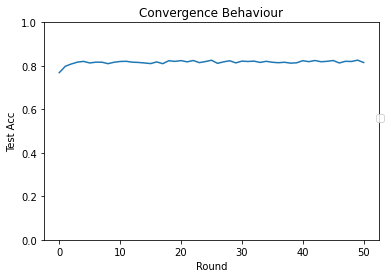

In [ ]:
plot_convergence_behaviour_from_centralized_evaluation(centralized_test_accs)

In [ ]:
ultimate_centralized_y_preds = centralized_y_preds[-1]

In [ ]:
print(report_classification_macro_averages(y_test, ultimate_centralized_y_preds))

              precision    recall  f1-score  
   macro avg       0.64      0.68      0.65     


### [Federated Evaluation](https://flower.dev/docs/evaluation.html) with Data Sharing

In [ ]:
# Overrides to global experiment config
EVAL_STRATEGY = "federated"

In [ ]:
# Split test set into NUMBER_OF_CLIENTS partitions.
partitioned_test_set = get_test_partitions(X_test, y_test.to_numpy())

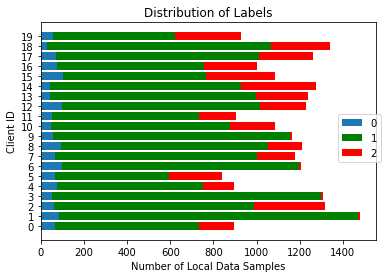

In [ ]:
plot_distribution_of_labels(partitioned_train_set)

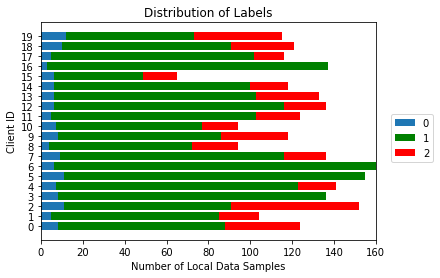

In [ ]:
plot_distribution_of_labels(partitioned_test_set)

In [ ]:
# Evaluate local models
local_models_y_preds = evaluate_local_models(partitioned_train_set, partitioned_test_set)

In [ ]:
local_models_y_test = [y_test_partition for X_test_partition, y_test_partition in partitioned_test_set]

In [ ]:
precision_recall_fscores_of_local_models = get_precision_recall_fscores_of_local_models(local_models_y_test, local_models_y_preds)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: Und

In [ ]:
print(classification_report(local_models_y_test[3], local_models_y_preds[3]))

              precision    recall  f1-score   support

           0       0.30      0.38      0.33         8
           1       0.96      0.94      0.95       128
           2       0.00      0.00      0.00         0

    accuracy                           0.90       136
   macro avg       0.42      0.44      0.43       136
weighted avg       0.92      0.90      0.91       136



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
avg_local_model_precision_recall_fscore = get_mean_precision_recall_fscores_of_local_models(precision_recall_fscores_of_local_models)

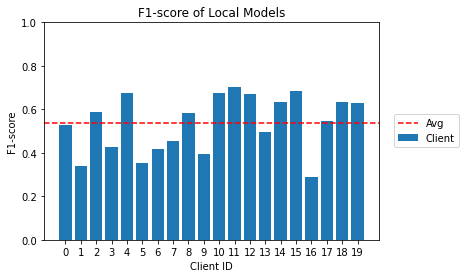

In [ ]:
plot_performance_of_local_models(precision_recall_fscores_of_local_models, avg_local_model_precision_recall_fscore)

In [ ]:
print_measures_of_dispersion(precision_recall_fscores_of_local_models)

Variance of F1-score across local models: 0.016287988838615413
Standard Deviation of F1-score across local models: 0.1276244053408885


In [ ]:
# Run sim with global config
sim_results = run_sim(partitioned_train_set, partitioned_test_set)

INFO flower 2022-03-15 23:26:14,098 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-03-15 23:26:14,105 | server.py:128 | Initializing global parameters
INFO flower 2022-03-15 23:26:14,106 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 5613


INFO flower 2022-03-15 23:26:16,123 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-15 23:26:16,127 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-15 23:26:16,132 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-03-15 23:26:16,139 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-03-15 23:26:16,141 | server.py:130 | Evaluating initial parameters
INFO flower 2022-03-15 23:26:16,144 | server.py:143 | FL starting


initializing Client1 with pid 5648


INFO flower 2022-03-15 23:26:17,155 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-15 23:26:17,161 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-15 23:26:17,165 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-03-15 23:26:17,167 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 5682


INFO flower 2022-03-15 23:26:18,181 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-15 23:26:18,186 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-15 23:26:18,189 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-03-15 23:26:18,192 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 5716


INFO flower 2022-03-15 23:26:19,212 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-15 23:26:19,218 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-15 23:26:19,222 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 5751


INFO flower 2022-03-15 23:26:20,240 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-15 23:26:20,244 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-15 23:26:20,248 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 5788


INFO flower 2022-03-15 23:26:21,271 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-15 23:26:21,277 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-15 23:26:21,280 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-03-15 23:26:21,282 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 5828


INFO flower 2022-03-15 23:26:22,301 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-15 23:26:22,307 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-15 23:26:22,311 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 5868


INFO flower 2022-03-15 23:26:23,334 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-15 23:26:23,342 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-15 23:26:23,346 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-03-15 23:26:23,348 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 5912


INFO flower 2022-03-15 23:26:24,366 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-15 23:26:24,371 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-15 23:26:24,377 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 5957


INFO flower 2022-03-15 23:26:25,397 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-15 23:26:25,401 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-15 23:26:25,403 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-03-15 23:26:25,407 | connection.py:39 | ChannelConnectivity.READY


initializing Client10 with pid 6005


INFO flower 2022-03-15 23:26:26,429 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-15 23:26:26,433 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-15 23:26:26,439 | connection.py:39 | ChannelConnectivity.READY


initializing Client11 with pid 6054


INFO flower 2022-03-15 23:26:27,457 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-15 23:26:27,463 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-15 23:26:27,466 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-03-15 23:26:27,467 | connection.py:39 | ChannelConnectivity.READY


initializing Client12 with pid 6108


INFO flower 2022-03-15 23:26:28,492 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-15 23:26:28,497 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-15 23:26:28,501 | connection.py:39 | ChannelConnectivity.READY


initializing Client13 with pid 6160


INFO flower 2022-03-15 23:26:29,508 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-15 23:26:29,512 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-15 23:26:29,515 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-03-15 23:26:29,518 | connection.py:39 | ChannelConnectivity.READY


initializing Client14 with pid 6216


INFO flower 2022-03-15 23:26:30,538 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-15 23:26:30,542 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-15 23:26:30,545 | connection.py:39 | ChannelConnectivity.READY


initializing Client15 with pid 6272


INFO flower 2022-03-15 23:26:31,575 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-15 23:26:31,581 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-15 23:26:31,586 | connection.py:39 | ChannelConnectivity.READY


initializing Client16 with pid 6330


INFO flower 2022-03-15 23:26:32,600 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-15 23:26:32,605 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-15 23:26:32,608 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-03-15 23:26:32,611 | connection.py:39 | ChannelConnectivity.READY


initializing Client17 with pid 6392


INFO flower 2022-03-15 23:26:33,633 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-15 23:26:33,639 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-15 23:26:33,643 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-03-15 23:26:33,645 | connection.py:39 | ChannelConnectivity.READY


initializing Client18 with pid 6457


INFO flower 2022-03-15 23:26:34,662 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-15 23:26:34,668 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-15 23:26:34,673 | connection.py:39 | ChannelConnectivity.READY


initializing Client19 with pid 6521


INFO flower 2022-03-15 23:26:35,696 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-15 23:26:35,701 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-15 23:26:35,704 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-03-15 23:26:35,704 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client18 with pid 6457 is sampled in training rnd 1
Client8 with pid 5912 is sampled in training rnd 1
Client2 with pid 5682 is sampled in training rnd 1
Client3 with pid 5716 is sampled in training rnd 1
Client15 with pid 6272 is sampled in training rnd 1
Client12 with pid 6108 is sampled in training rnd 1
Client7 with pid 5868 is sampled in training rnd 1
Client13 with pid 6160 is sampled in training rnd 1
Client10 with pid 6005 is sampled in training rnd 1
Client16 with pid 6330 is sampled in training rnd 1
Client6 with pid 5828 is sampled in training rnd 1
Client1 with pid 5648 is sampled in training rnd 1
Client14 with pid 6216 is sampled in training rnd 1
Client0 with pid 5613 is sampled in training rnd 1


DEBUG flower 2022-03-15 23:26:37,304 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-15 23:26:37,335 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client13 with pid 6160 is sampled in evaluation rnd 1
Client12 with pid 6108 is sampled in evaluation rnd 1
Client14 with pid 6216 is sampled in evaluation rnd 1
Client0 with pid 5613 is sampled in evaluation rnd 1
Client8 with pid 5912 is sampled in evaluation rnd 1
Client11 with pid 6054 is sampled in evaluation rnd 1
Client19 with pid 6521 is sampled in evaluation rnd 1
Client3 with pid 5716 is sampled in evaluation rnd 1
Client9 with pid 5957 is sampled in evaluation rnd 1
Client1 with pid 5648 is sampled in evaluation rnd 1
Client5 with pid 5788 is sampled in evaluation rnd 1
Client15 with pid 6272 is sampled in evaluation rnd 1
Client17 with pid 6392 is sampled in evaluation rnd 1
Client7 with pid 5868 is sampled in evaluation rnd 1
Client4 with pid 5751 is sampled in evaluation rnd 1
Client16 with pid 6330 is sampled in evaluation rnd 1
Client6 with pid 5828 is sampled in evaluation rnd 1
Client18 with pid 6457 is sampled in evaluation rnd 1
Client10 with pid 6005 is sampled in 

DEBUG flower 2022-03-15 23:26:37,480 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-15 23:26:37,482 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client16 with pid 6330 is sampled in training rnd 2
Client0 with pid 5613 is sampled in training rnd 2
Client7 with pid 5868 is sampled in training rnd 2
Client8 with pid 5912 is sampled in training rnd 2
Client15 with pid 6272 is sampled in training rnd 2
Client3 with pid 5716 is sampled in training rnd 2
Client14 with pid 6216 is sampled in training rnd 2
Client5 with pid 5788 is sampled in training rnd 2
Client13 with pid 6160 is sampled in training rnd 2
Client10 with pid 6005 is sampled in training rnd 2
Client11 with pid 6054 is sampled in training rnd 2
Client17 with pid 6392 is sampled in training rnd 2
Client4 with pid 5751 is sampled in training rnd 2
Client19 with pid 6521 is sampled in training rnd 2


DEBUG flower 2022-03-15 23:26:38,982 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-15 23:26:39,006 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client13 with pid 6160 is sampled in evaluation rnd 2
Client17 with pid 6392 is sampled in evaluation rnd 2
Client3 with pid 5716 is sampled in evaluation rnd 2
Client5 with pid 5788 is sampled in evaluation rnd 2
Client9 with pid 5957 is sampled in evaluation rnd 2
Client1 with pid 5648 is sampled in evaluation rnd 2
Client11 with pid 6054 is sampled in evaluation rnd 2
Client19 with pid 6521 is sampled in evaluation rnd 2
Client16 with pid 6330 is sampled in evaluation rnd 2
Client6 with pid 5828 is sampled in evaluation rnd 2
Client8 with pid 5912 is sampled in evaluation rnd 2
Client10 with pid 6005 is sampled in evaluation rnd 2
Client18 with pid 6457 is sampled in evaluation rnd 2
Client15 with pid 6272 is sampled in evaluation rnd 2
Client2 with pid 5682 is sampled in evaluation rnd 2
Client4 with pid 5751 is sampled in evaluation rnd 2
Client12 with pid 6108 is sampled in evaluation rnd 2
Client7 with pid 5868 is sampled in evaluation rnd 2
Client14 with pid 6216 is sampled in 

DEBUG flower 2022-03-15 23:26:39,120 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-15 23:26:39,123 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client15 with pid 6272 is sampled in training rnd 3
Client7 with pid 5868 is sampled in training rnd 3
Client12 with pid 6108 is sampled in training rnd 3
Client5 with pid 5788 is sampled in training rnd 3
Client13 with pid 6160 is sampled in training rnd 3
Client19 with pid 6521 is sampled in training rnd 3
Client11 with pid 6054 is sampled in training rnd 3
Client10 with pid 6005 is sampled in training rnd 3
Client14 with pid 6216 is sampled in training rnd 3
Client8 with pid 5912 is sampled in training rnd 3
Client1 with pid 5648 is sampled in training rnd 3
Client18 with pid 6457 is sampled in training rnd 3
Client9 with pid 5957 is sampled in training rnd 3
Client6 with pid 5828 is sampled in training rnd 3


DEBUG flower 2022-03-15 23:26:40,761 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-15 23:26:40,794 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client16 with pid 6330 is sampled in evaluation rnd 3
Client5 with pid 5788 is sampled in evaluation rnd 3
Client12 with pid 6108 is sampled in evaluation rnd 3
Client11 with pid 6054 is sampled in evaluation rnd 3
Client15 with pid 6272 is sampled in evaluation rnd 3
Client0 with pid 5613 is sampled in evaluation rnd 3
Client18 with pid 6457 is sampled in evaluation rnd 3
Client7 with pid 5868 is sampled in evaluation rnd 3
Client13 with pid 6160 is sampled in evaluation rnd 3
Client4 with pid 5751 is sampled in evaluation rnd 3
Client9 with pid 5957 is sampled in evaluation rnd 3
Client6 with pid 5828 is sampled in evaluation rnd 3
Client2 with pid 5682 is sampled in evaluation rnd 3
Client1 with pid 5648 is sampled in evaluation rnd 3
Client10 with pid 6005 is sampled in evaluation rnd 3
Client8 with pid 5912 is sampled in evaluation rnd 3
Client14 with pid 6216 is sampled in evaluation rnd 3
Client3 with pid 5716 is sampled in evaluation rnd 3
Client17 with pid 6392 is sampled in e

DEBUG flower 2022-03-15 23:26:40,930 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-15 23:26:40,933 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client16 with pid 6330 is sampled in training rnd 4
Client11 with pid 6054 is sampled in training rnd 4
Client14 with pid 6216 is sampled in training rnd 4
Client18 with pid 6457 is sampled in training rnd 4
Client10 with pid 6005 is sampled in training rnd 4
Client8 with pid 5912 is sampled in training rnd 4
Client15 with pid 6272 is sampled in training rnd 4
Client9 with pid 5957 is sampled in training rnd 4
Client17 with pid 6392 is sampled in training rnd 4
Client0 with pid 5613 is sampled in training rnd 4
Client6 with pid 5828 is sampled in training rnd 4
Client13 with pid 6160 is sampled in training rnd 4
Client2 with pid 5682 is sampled in training rnd 4
Client4 with pid 5751 is sampled in training rnd 4


DEBUG flower 2022-03-15 23:26:42,604 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-15 23:26:42,619 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client17 with pid 6392 is sampled in evaluation rnd 4
Client6 with pid 5828 is sampled in evaluation rnd 4
Client13 with pid 6160 is sampled in evaluation rnd 4
Client15 with pid 6272 is sampled in evaluation rnd 4
Client1 with pid 5648 is sampled in evaluation rnd 4
Client5 with pid 5788 is sampled in evaluation rnd 4
Client19 with pid 6521 is sampled in evaluation rnd 4
Client8 with pid 5912 is sampled in evaluation rnd 4
Client3 with pid 5716 is sampled in evaluation rnd 4
Client9 with pid 5957 is sampled in evaluation rnd 4
Client18 with pid 6457 is sampled in evaluation rnd 4
Client11 with pid 6054 is sampled in evaluation rnd 4
Client7 with pid 5868 is sampled in evaluation rnd 4
Client12 with pid 6108 is sampled in evaluation rnd 4
Client10 with pid 6005 is sampled in evaluation rnd 4
Client2 with pid 5682 is sampled in evaluation rnd 4
Client14 with pid 6216 is sampled in evaluation rnd 4
Client16 with pid 6330 is sampled in evaluation rnd 4
Client0 with pid 5613 is sampled in 

DEBUG flower 2022-03-15 23:26:42,750 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-15 23:26:42,752 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client0 with pid 5613 is sampled in training rnd 5
Client19 with pid 6521 is sampled in training rnd 5
Client7 with pid 5868 is sampled in training rnd 5
Client16 with pid 6330 is sampled in training rnd 5
Client13 with pid 6160 is sampled in training rnd 5
Client5 with pid 5788 is sampled in training rnd 5
Client1 with pid 5648 is sampled in training rnd 5
Client8 with pid 5912 is sampled in training rnd 5
Client18 with pid 6457 is sampled in training rnd 5
Client12 with pid 6108 is sampled in training rnd 5
Client4 with pid 5751 is sampled in training rnd 5
Client14 with pid 6216 is sampled in training rnd 5
Client11 with pid 6054 is sampled in training rnd 5
Client6 with pid 5828 is sampled in training rnd 5


DEBUG flower 2022-03-15 23:26:44,397 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-15 23:26:44,430 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client14 with pid 6216 is sampled in evaluation rnd 5
Client0 with pid 5613 is sampled in evaluation rnd 5
Client19 with pid 6521 is sampled in evaluation rnd 5
Client8 with pid 5912 is sampled in evaluation rnd 5
Client4 with pid 5751 is sampled in evaluation rnd 5
Client7 with pid 5868 is sampled in evaluation rnd 5
Client12 with pid 6108 is sampled in evaluation rnd 5
Client1 with pid 5648 is sampled in evaluation rnd 5
Client2 with pid 5682 is sampled in evaluation rnd 5
Client9 with pid 5957 is sampled in evaluation rnd 5
Client5 with pid 5788 is sampled in evaluation rnd 5
Client18 with pid 6457 is sampled in evaluation rnd 5
Client13 with pid 6160 is sampled in evaluation rnd 5
Client15 with pid 6272 is sampled in evaluation rnd 5
Client6 with pid 5828 is sampled in evaluation rnd 5
Client11 with pid 6054 is sampled in evaluation rnd 5
Client10 with pid 6005 is sampled in evaluation rnd 5
Client16 with pid 6330 is sampled in evaluation rnd 5
Client3 with pid 5716 is sampled in e

DEBUG flower 2022-03-15 23:26:44,551 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-15 23:26:44,554 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client14 with pid 6216 is sampled in training rnd 6
Client17 with pid 6392 is sampled in training rnd 6
Client3 with pid 5716 is sampled in training rnd 6
Client10 with pid 6005 is sampled in training rnd 6
Client15 with pid 6272 is sampled in training rnd 6
Client0 with pid 5613 is sampled in training rnd 6
Client4 with pid 5751 is sampled in training rnd 6
Client5 with pid 5788 is sampled in training rnd 6
Client16 with pid 6330 is sampled in training rnd 6
Client6 with pid 5828 is sampled in training rnd 6
Client12 with pid 6108 is sampled in training rnd 6
Client13 with pid 6160 is sampled in training rnd 6
Client1 with pid 5648 is sampled in training rnd 6
Client2 with pid 5682 is sampled in training rnd 6


DEBUG flower 2022-03-15 23:26:46,239 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-15 23:26:46,259 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client6 with pid 5828 is sampled in evaluation rnd 6
Client16 with pid 6330 is sampled in evaluation rnd 6
Client13 with pid 6160 is sampled in evaluation rnd 6
Client0 with pid 5613 is sampled in evaluation rnd 6
Client7 with pid 5868 is sampled in evaluation rnd 6
Client19 with pid 6521 is sampled in evaluation rnd 6
Client18 with pid 6457 is sampled in evaluation rnd 6
Client2 with pid 5682 is sampled in evaluation rnd 6
Client14 with pid 6216 is sampled in evaluation rnd 6
Client12 with pid 6108 is sampled in evaluation rnd 6
Client15 with pid 6272 is sampled in evaluation rnd 6
Client8 with pid 5912 is sampled in evaluation rnd 6
Client17 with pid 6392 is sampled in evaluation rnd 6
Client4 with pid 5751 is sampled in evaluation rnd 6
Client1 with pid 5648 is sampled in evaluation rnd 6
Client11 with pid 6054 is sampled in evaluation rnd 6
Client9 with pid 5957 is sampled in evaluation rnd 6
Client5 with pid 5788 is sampled in evaluation rnd 6
Client3 with pid 5716 is sampled in e

DEBUG flower 2022-03-15 23:26:46,387 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-15 23:26:46,389 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client18 with pid 6457 is sampled in training rnd 7
Client10 with pid 6005 is sampled in training rnd 7
Client13 with pid 6160 is sampled in training rnd 7
Client9 with pid 5957 is sampled in training rnd 7
Client0 with pid 5613 is sampled in training rnd 7
Client3 with pid 5716 is sampled in training rnd 7
Client2 with pid 5682 is sampled in training rnd 7
Client4 with pid 5751 is sampled in training rnd 7
Client16 with pid 6330 is sampled in training rnd 7
Client1 with pid 5648 is sampled in training rnd 7
Client19 with pid 6521 is sampled in training rnd 7
Client8 with pid 5912 is sampled in training rnd 7
Client5 with pid 5788 is sampled in training rnd 7
Client11 with pid 6054 is sampled in training rnd 7


DEBUG flower 2022-03-15 23:26:47,890 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-15 23:26:47,928 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client13 with pid 6160 is sampled in evaluation rnd 7
Client8 with pid 5912 is sampled in evaluation rnd 7
Client5 with pid 5788 is sampled in evaluation rnd 7
Client4 with pid 5751 is sampled in evaluation rnd 7
Client0 with pid 5613 is sampled in evaluation rnd 7
Client17 with pid 6392 is sampled in evaluation rnd 7
Client18 with pid 6457 is sampled in evaluation rnd 7
Client15 with pid 6272 is sampled in evaluation rnd 7
Client9 with pid 5957 is sampled in evaluation rnd 7
Client3 with pid 5716 is sampled in evaluation rnd 7
Client11 with pid 6054 is sampled in evaluation rnd 7
Client2 with pid 5682 is sampled in evaluation rnd 7
Client6 with pid 5828 is sampled in evaluation rnd 7
Client19 with pid 6521 is sampled in evaluation rnd 7
Client7 with pid 5868 is sampled in evaluation rnd 7
Client12 with pid 6108 is sampled in evaluation rnd 7
Client16 with pid 6330 is sampled in evaluation rnd 7
Client1 with pid 5648 is sampled in evaluation rnd 7
Client14 with pid 6216 is sampled in e

DEBUG flower 2022-03-15 23:26:48,053 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-15 23:26:48,056 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client3 with pid 5716 is sampled in training rnd 8
Client13 with pid 6160 is sampled in training rnd 8
Client18 with pid 6457 is sampled in training rnd 8
Client15 with pid 6272 is sampled in training rnd 8
Client6 with pid 5828 is sampled in training rnd 8
Client10 with pid 6005 is sampled in training rnd 8
Client8 with pid 5912 is sampled in training rnd 8
Client4 with pid 5751 is sampled in training rnd 8
Client1 with pid 5648 is sampled in training rnd 8
Client7 with pid 5868 is sampled in training rnd 8
Client0 with pid 5613 is sampled in training rnd 8
Client5 with pid 5788 is sampled in training rnd 8
Client16 with pid 6330 is sampled in training rnd 8
Client11 with pid 6054 is sampled in training rnd 8


DEBUG flower 2022-03-15 23:26:49,633 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-15 23:26:49,664 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client12 with pid 6108 is sampled in evaluation rnd 8
Client9 with pid 5957 is sampled in evaluation rnd 8
Client6 with pid 5828 is sampled in evaluation rnd 8
Client5 with pid 5788 is sampled in evaluation rnd 8
Client0 with pid 5613 is sampled in evaluation rnd 8
Client16 with pid 6330 is sampled in evaluation rnd 8
Client13 with pid 6160 is sampled in evaluation rnd 8
Client19 with pid 6521 is sampled in evaluation rnd 8
Client18 with pid 6457 is sampled in evaluation rnd 8
Client2 with pid 5682 is sampled in evaluation rnd 8
Client14 with pid 6216 is sampled in evaluation rnd 8
Client15 with pid 6272 is sampled in evaluation rnd 8
Client3 with pid 5716 is sampled in evaluation rnd 8
Client11 with pid 6054 is sampled in evaluation rnd 8
Client10 with pid 6005 is sampled in evaluation rnd 8
Client7 with pid 5868 is sampled in evaluation rnd 8
Client17 with pid 6392 is sampled in evaluation rnd 8
Client4 with pid 5751 is sampled in evaluation rnd 8
Client8 with pid 5912 is sampled in 

DEBUG flower 2022-03-15 23:26:49,794 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-15 23:26:49,796 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client17 with pid 6392 is sampled in training rnd 9
Client7 with pid 5868 is sampled in training rnd 9
Client2 with pid 5682 is sampled in training rnd 9
Client1 with pid 5648 is sampled in training rnd 9
Client14 with pid 6216 is sampled in training rnd 9
Client19 with pid 6521 is sampled in training rnd 9
Client15 with pid 6272 is sampled in training rnd 9
Client4 with pid 5751 is sampled in training rnd 9
Client8 with pid 5912 is sampled in training rnd 9
Client9 with pid 5957 is sampled in training rnd 9
Client5 with pid 5788 is sampled in training rnd 9
Client13 with pid 6160 is sampled in training rnd 9
Client3 with pid 5716 is sampled in training rnd 9
Client12 with pid 6108 is sampled in training rnd 9


DEBUG flower 2022-03-15 23:26:51,360 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-15 23:26:51,396 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client19 with pid 6521 is sampled in evaluation rnd 9
Client10 with pid 6005 is sampled in evaluation rnd 9
Client3 with pid 5716 is sampled in evaluation rnd 9
Client9 with pid 5957 is sampled in evaluation rnd 9
Client7 with pid 5868 is sampled in evaluation rnd 9
Client13 with pid 6160 is sampled in evaluation rnd 9
Client16 with pid 6330 is sampled in evaluation rnd 9
Client12 with pid 6108 is sampled in evaluation rnd 9
Client11 with pid 6054 is sampled in evaluation rnd 9
Client15 with pid 6272 is sampled in evaluation rnd 9
Client1 with pid 5648 is sampled in evaluation rnd 9
Client2 with pid 5682 is sampled in evaluation rnd 9
Client8 with pid 5912 is sampled in evaluation rnd 9
Client14 with pid 6216 is sampled in evaluation rnd 9
Client0 with pid 5613 is sampled in evaluation rnd 9
Client5 with pid 5788 is sampled in evaluation rnd 9
Client17 with pid 6392 is sampled in evaluation rnd 9
Client6 with pid 5828 is sampled in evaluation rnd 9
Client18 with pid 6457 is sampled in 

DEBUG flower 2022-03-15 23:26:51,522 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-15 23:26:51,524 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client10 with pid 6005 is sampled in training rnd 10
Client3 with pid 5716 is sampled in training rnd 10
Client12 with pid 6108 is sampled in training rnd 10
Client2 with pid 5682 is sampled in training rnd 10
Client7 with pid 5868 is sampled in training rnd 10
Client1 with pid 5648 is sampled in training rnd 10
Client9 with pid 5957 is sampled in training rnd 10
Client4 with pid 5751 is sampled in training rnd 10
Client5 with pid 5788 is sampled in training rnd 10
Client17 with pid 6392 is sampled in training rnd 10
Client14 with pid 6216 is sampled in training rnd 10
Client8 with pid 5912 is sampled in training rnd 10
Client13 with pid 6160 is sampled in training rnd 10
Client18 with pid 6457 is sampled in training rnd 10


DEBUG flower 2022-03-15 23:26:53,155 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-15 23:26:53,189 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client8 with pid 5912 is sampled in evaluation rnd 10
Client3 with pid 5716 is sampled in evaluation rnd 10
Client9 with pid 5957 is sampled in evaluation rnd 10
Client1 with pid 5648 is sampled in evaluation rnd 10
Client0 with pid 5613 is sampled in evaluation rnd 10
Client16 with pid 6330 is sampled in evaluation rnd 10
Client15 with pid 6272 is sampled in evaluation rnd 10
Client10 with pid 6005 is sampled in evaluation rnd 10
Client17 with pid 6392 is sampled in evaluation rnd 10
Client6 with pid 5828 is sampled in evaluation rnd 10
Client11 with pid 6054 is sampled in evaluation rnd 10
Client12 with pid 6108 is sampled in evaluation rnd 10
Client18 with pid 6457 is sampled in evaluation rnd 10
Client14 with pid 6216 is sampled in evaluation rnd 10
Client4 with pid 5751 is sampled in evaluation rnd 10
Client13 with pid 6160 is sampled in evaluation rnd 10
Client7 with pid 5868 is sampled in evaluation rnd 10
Client19 with pid 6521 is sampled in evaluation rnd 10
Client2 with pid 5

DEBUG flower 2022-03-15 23:26:53,314 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-15 23:26:53,316 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client5 with pid 5788 is sampled in training rnd 11
Client7 with pid 5868 is sampled in training rnd 11
Client3 with pid 5716 is sampled in training rnd 11
Client12 with pid 6108 is sampled in training rnd 11
Client13 with pid 6160 is sampled in training rnd 11
Client15 with pid 6272 is sampled in training rnd 11
Client16 with pid 6330 is sampled in training rnd 11
Client8 with pid 5912 is sampled in training rnd 11
Client4 with pid 5751 is sampled in training rnd 11
Client14 with pid 6216 is sampled in training rnd 11
Client19 with pid 6521 is sampled in training rnd 11
Client18 with pid 6457 is sampled in training rnd 11
Client1 with pid 5648 is sampled in training rnd 11
Client9 with pid 5957 is sampled in training rnd 11


DEBUG flower 2022-03-15 23:26:54,892 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-15 23:26:54,913 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client10 with pid 6005 is sampled in evaluation rnd 11
Client1 with pid 5648 is sampled in evaluation rnd 11
Client17 with pid 6392 is sampled in evaluation rnd 11
Client0 with pid 5613 is sampled in evaluation rnd 11
Client9 with pid 5957 is sampled in evaluation rnd 11
Client11 with pid 6054 is sampled in evaluation rnd 11
Client15 with pid 6272 is sampled in evaluation rnd 11
Client5 with pid 5788 is sampled in evaluation rnd 11
Client7 with pid 5868 is sampled in evaluation rnd 11
Client6 with pid 5828 is sampled in evaluation rnd 11
Client12 with pid 6108 is sampled in evaluation rnd 11
Client19 with pid 6521 is sampled in evaluation rnd 11
Client18 with pid 6457 is sampled in evaluation rnd 11
Client16 with pid 6330 is sampled in evaluation rnd 11
Client2 with pid 5682 is sampled in evaluation rnd 11
Client4 with pid 5751 is sampled in evaluation rnd 11
Client8 with pid 5912 is sampled in evaluation rnd 11
Client3 with pid 5716 is sampled in evaluation rnd 11
Client14 with pid 62

DEBUG flower 2022-03-15 23:26:55,027 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-15 23:26:55,029 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client19 with pid 6521 is sampled in training rnd 12
Client17 with pid 6392 is sampled in training rnd 12
Client11 with pid 6054 is sampled in training rnd 12
Client8 with pid 5912 is sampled in training rnd 12
Client15 with pid 6272 is sampled in training rnd 12
Client18 with pid 6457 is sampled in training rnd 12
Client4 with pid 5751 is sampled in training rnd 12
Client3 with pid 5716 is sampled in training rnd 12
Client2 with pid 5682 is sampled in training rnd 12
Client12 with pid 6108 is sampled in training rnd 12
Client10 with pid 6005 is sampled in training rnd 12
Client5 with pid 5788 is sampled in training rnd 12
Client1 with pid 5648 is sampled in training rnd 12
Client6 with pid 5828 is sampled in training rnd 12


DEBUG flower 2022-03-15 23:26:56,677 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-15 23:26:56,714 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client2 with pid 5682 is sampled in evaluation rnd 12
Client14 with pid 6216 is sampled in evaluation rnd 12
Client8 with pid 5912 is sampled in evaluation rnd 12
Client18 with pid 6457 is sampled in evaluation rnd 12
Client10 with pid 6005 is sampled in evaluation rnd 12
Client3 with pid 5716 is sampled in evaluation rnd 12
Client6 with pid 5828 is sampled in evaluation rnd 12
Client0 with pid 5613 is sampled in evaluation rnd 12
Client4 with pid 5751 is sampled in evaluation rnd 12
Client5 with pid 5788 is sampled in evaluation rnd 12
Client16 with pid 6330 is sampled in evaluation rnd 12
Client15 with pid 6272 is sampled in evaluation rnd 12
Client1 with pid 5648 is sampled in evaluation rnd 12
Client9 with pid 5957 is sampled in evaluation rnd 12
Client12 with pid 6108 is sampled in evaluation rnd 12
Client11 with pid 6054 is sampled in evaluation rnd 12
Client7 with pid 5868 is sampled in evaluation rnd 12
Client17 with pid 6392 is sampled in evaluation rnd 12
Client19 with pid 65

DEBUG flower 2022-03-15 23:26:56,838 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-15 23:26:56,842 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client8 with pid 5912 is sampled in training rnd 13
Client7 with pid 5868 is sampled in training rnd 13
Client2 with pid 5682 is sampled in training rnd 13
Client17 with pid 6392 is sampled in training rnd 13
Client12 with pid 6108 is sampled in training rnd 13
Client1 with pid 5648 is sampled in training rnd 13
Client11 with pid 6054 is sampled in training rnd 13
Client0 with pid 5613 is sampled in training rnd 13
Client10 with pid 6005 is sampled in training rnd 13
Client18 with pid 6457 is sampled in training rnd 13
Client4 with pid 5751 is sampled in training rnd 13
Client5 with pid 5788 is sampled in training rnd 13
Client3 with pid 5716 is sampled in training rnd 13
Client19 with pid 6521 is sampled in training rnd 13


DEBUG flower 2022-03-15 23:26:58,426 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-15 23:26:58,461 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client16 with pid 6330 is sampled in evaluation rnd 13
Client4 with pid 5751 is sampled in evaluation rnd 13
Client2 with pid 5682 is sampled in evaluation rnd 13
Client8 with pid 5912 is sampled in evaluation rnd 13
Client3 with pid 5716 is sampled in evaluation rnd 13
Client10 with pid 6005 is sampled in evaluation rnd 13
Client17 with pid 6392 is sampled in evaluation rnd 13
Client15 with pid 6272 is sampled in evaluation rnd 13
Client12 with pid 6108 is sampled in evaluation rnd 13
Client11 with pid 6054 is sampled in evaluation rnd 13
Client5 with pid 5788 is sampled in evaluation rnd 13
Client19 with pid 6521 is sampled in evaluation rnd 13
Client13 with pid 6160 is sampled in evaluation rnd 13
Client0 with pid 5613 is sampled in evaluation rnd 13
Client14 with pid 6216 is sampled in evaluation rnd 13
Client9 with pid 5957 is sampled in evaluation rnd 13
Client7 with pid 5868 is sampled in evaluation rnd 13
Client6 with pid 5828 is sampled in evaluation rnd 13
Client18 with pid 6

DEBUG flower 2022-03-15 23:26:58,595 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-15 23:26:58,597 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client17 with pid 6392 is sampled in training rnd 14
Client6 with pid 5828 is sampled in training rnd 14
Client1 with pid 5648 is sampled in training rnd 14
Client10 with pid 6005 is sampled in training rnd 14
Client5 with pid 5788 is sampled in training rnd 14
Client2 with pid 5682 is sampled in training rnd 14
Client8 with pid 5912 is sampled in training rnd 14
Client3 with pid 5716 is sampled in training rnd 14
Client16 with pid 6330 is sampled in training rnd 14
Client4 with pid 5751 is sampled in training rnd 14
Client14 with pid 6216 is sampled in training rnd 14
Client0 with pid 5613 is sampled in training rnd 14
Client15 with pid 6272 is sampled in training rnd 14
Client18 with pid 6457 is sampled in training rnd 14


DEBUG flower 2022-03-15 23:27:00,199 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-15 23:27:00,235 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client14 with pid 6216 is sampled in evaluation rnd 14
Client13 with pid 6160 is sampled in evaluation rnd 14
Client17 with pid 6392 is sampled in evaluation rnd 14
Client19 with pid 6521 is sampled in evaluation rnd 14
Client18 with pid 6457 is sampled in evaluation rnd 14
Client16 with pid 6330 is sampled in evaluation rnd 14
Client7 with pid 5868 is sampled in evaluation rnd 14
Client8 with pid 5912 is sampled in evaluation rnd 14
Client0 with pid 5613 is sampled in evaluation rnd 14
Client6 with pid 5828 is sampled in evaluation rnd 14
Client5 with pid 5788 is sampled in evaluation rnd 14
Client4 with pid 5751 is sampled in evaluation rnd 14
Client2 with pid 5682 is sampled in evaluation rnd 14
Client3 with pid 5716 is sampled in evaluation rnd 14
Client11 with pid 6054 is sampled in evaluation rnd 14
Client10 with pid 6005 is sampled in evaluation rnd 14
Client12 with pid 6108 is sampled in evaluation rnd 14
Client1 with pid 5648 is sampled in evaluation rnd 14
Client9 with pid 59

DEBUG flower 2022-03-15 23:27:00,340 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-15 23:27:00,342 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client18 with pid 6457 is sampled in training rnd 15
Client19 with pid 6521 is sampled in training rnd 15
Client4 with pid 5751 is sampled in training rnd 15
Client8 with pid 5912 is sampled in training rnd 15
Client6 with pid 5828 is sampled in training rnd 15
Client16 with pid 6330 is sampled in training rnd 15
Client9 with pid 5957 is sampled in training rnd 15
Client14 with pid 6216 is sampled in training rnd 15
Client2 with pid 5682 is sampled in training rnd 15
Client1 with pid 5648 is sampled in training rnd 15
Client3 with pid 5716 is sampled in training rnd 15
Client13 with pid 6160 is sampled in training rnd 15
Client7 with pid 5868 is sampled in training rnd 15
Client0 with pid 5613 is sampled in training rnd 15


DEBUG flower 2022-03-15 23:27:01,965 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-15 23:27:02,001 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client5 with pid 5788 is sampled in evaluation rnd 15
Client16 with pid 6330 is sampled in evaluation rnd 15
Client10 with pid 6005 is sampled in evaluation rnd 15
Client14 with pid 6216 is sampled in evaluation rnd 15
Client18 with pid 6457 is sampled in evaluation rnd 15
Client15 with pid 6272 is sampled in evaluation rnd 15
Client17 with pid 6392 is sampled in evaluation rnd 15
Client13 with pid 6160 is sampled in evaluation rnd 15
Client3 with pid 5716 is sampled in evaluation rnd 15
Client11 with pid 6054 is sampled in evaluation rnd 15
Client19 with pid 6521 is sampled in evaluation rnd 15
Client12 with pid 6108 is sampled in evaluation rnd 15
Client7 with pid 5868 is sampled in evaluation rnd 15
Client8 with pid 5912 is sampled in evaluation rnd 15
Client9 with pid 5957 is sampled in evaluation rnd 15
Client1 with pid 5648 is sampled in evaluation rnd 15
Client6 with pid 5828 is sampled in evaluation rnd 15
Client4 with pid 5751 is sampled in evaluation rnd 15
Client2 with pid 5

DEBUG flower 2022-03-15 23:27:02,485 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-15 23:27:02,487 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client16 with pid 6330 is sampled in training rnd 16
Client1 with pid 5648 is sampled in training rnd 16
Client2 with pid 5682 is sampled in training rnd 16
Client5 with pid 5788 is sampled in training rnd 16
Client11 with pid 6054 is sampled in training rnd 16
Client8 with pid 5912 is sampled in training rnd 16
Client12 with pid 6108 is sampled in training rnd 16
Client13 with pid 6160 is sampled in training rnd 16
Client3 with pid 5716 is sampled in training rnd 16
Client4 with pid 5751 is sampled in training rnd 16
Client10 with pid 6005 is sampled in training rnd 16
Client9 with pid 5957 is sampled in training rnd 16
Client15 with pid 6272 is sampled in training rnd 16
Client19 with pid 6521 is sampled in training rnd 16


DEBUG flower 2022-03-15 23:27:04,109 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-15 23:27:04,161 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client2 with pid 5682 is sampled in evaluation rnd 16
Client14 with pid 6216 is sampled in evaluation rnd 16
Client3 with pid 5716 is sampled in evaluation rnd 16
Client12 with pid 6108 is sampled in evaluation rnd 16
Client18 with pid 6457 is sampled in evaluation rnd 16
Client4 with pid 5751 is sampled in evaluation rnd 16
Client6 with pid 5828 is sampled in evaluation rnd 16
Client17 with pid 6392 is sampled in evaluation rnd 16
Client16 with pid 6330 is sampled in evaluation rnd 16
Client19 with pid 6521 is sampled in evaluation rnd 16
Client9 with pid 5957 is sampled in evaluation rnd 16
Client0 with pid 5613 is sampled in evaluation rnd 16
Client7 with pid 5868 is sampled in evaluation rnd 16
Client13 with pid 6160 is sampled in evaluation rnd 16
Client10 with pid 6005 is sampled in evaluation rnd 16
Client11 with pid 6054 is sampled in evaluation rnd 16
Client5 with pid 5788 is sampled in evaluation rnd 16
Client15 with pid 6272 is sampled in evaluation rnd 16
Client8 with pid 5

DEBUG flower 2022-03-15 23:27:04,257 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-15 23:27:04,260 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client2 with pid 5682 is sampled in training rnd 17
Client16 with pid 6330 is sampled in training rnd 17
Client3 with pid 5716 is sampled in training rnd 17
Client11 with pid 6054 is sampled in training rnd 17
Client17 with pid 6392 is sampled in training rnd 17
Client8 with pid 5912 is sampled in training rnd 17
Client18 with pid 6457 is sampled in training rnd 17
Client9 with pid 5957 is sampled in training rnd 17
Client1 with pid 5648 is sampled in training rnd 17
Client10 with pid 6005 is sampled in training rnd 17
Client13 with pid 6160 is sampled in training rnd 17
Client7 with pid 5868 is sampled in training rnd 17
Client19 with pid 6521 is sampled in training rnd 17
Client6 with pid 5828 is sampled in training rnd 17


DEBUG flower 2022-03-15 23:27:05,782 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-15 23:27:05,817 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client12 with pid 6108 is sampled in evaluation rnd 17
Client19 with pid 6521 is sampled in evaluation rnd 17
Client13 with pid 6160 is sampled in evaluation rnd 17
Client10 with pid 6005 is sampled in evaluation rnd 17
Client5 with pid 5788 is sampled in evaluation rnd 17
Client7 with pid 5868 is sampled in evaluation rnd 17
Client9 with pid 5957 is sampled in evaluation rnd 17
Client14 with pid 6216 is sampled in evaluation rnd 17
Client2 with pid 5682 is sampled in evaluation rnd 17
Client3 with pid 5716 is sampled in evaluation rnd 17
Client8 with pid 5912 is sampled in evaluation rnd 17
Client6 with pid 5828 is sampled in evaluation rnd 17
Client1 with pid 5648 is sampled in evaluation rnd 17
Client0 with pid 5613 is sampled in evaluation rnd 17
Client16 with pid 6330 is sampled in evaluation rnd 17
Client4 with pid 5751 is sampled in evaluation rnd 17
Client18 with pid 6457 is sampled in evaluation rnd 17
Client11 with pid 6054 is sampled in evaluation rnd 17
Client17 with pid 63

DEBUG flower 2022-03-15 23:27:05,935 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-15 23:27:05,937 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client16 with pid 6330 is sampled in training rnd 18
Client6 with pid 5828 is sampled in training rnd 18
Client0 with pid 5613 is sampled in training rnd 18
Client14 with pid 6216 is sampled in training rnd 18
Client18 with pid 6457 is sampled in training rnd 18
Client10 with pid 6005 is sampled in training rnd 18
Client9 with pid 5957 is sampled in training rnd 18
Client3 with pid 5716 is sampled in training rnd 18
Client12 with pid 6108 is sampled in training rnd 18
Client4 with pid 5751 is sampled in training rnd 18
Client2 with pid 5682 is sampled in training rnd 18
Client11 with pid 6054 is sampled in training rnd 18
Client13 with pid 6160 is sampled in training rnd 18
Client8 with pid 5912 is sampled in training rnd 18


DEBUG flower 2022-03-15 23:27:07,572 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-15 23:27:07,607 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client18 with pid 6457 is sampled in evaluation rnd 18
Client6 with pid 5828 is sampled in evaluation rnd 18
Client8 with pid 5912 is sampled in evaluation rnd 18
Client9 with pid 5957 is sampled in evaluation rnd 18
Client14 with pid 6216 is sampled in evaluation rnd 18
Client15 with pid 6272 is sampled in evaluation rnd 18
Client13 with pid 6160 is sampled in evaluation rnd 18
Client12 with pid 6108 is sampled in evaluation rnd 18
Client2 with pid 5682 is sampled in evaluation rnd 18
Client16 with pid 6330 is sampled in evaluation rnd 18
Client5 with pid 5788 is sampled in evaluation rnd 18
Client7 with pid 5868 is sampled in evaluation rnd 18
Client19 with pid 6521 is sampled in evaluation rnd 18
Client10 with pid 6005 is sampled in evaluation rnd 18
Client0 with pid 5613 is sampled in evaluation rnd 18
Client1 with pid 5648 is sampled in evaluation rnd 18
Client3 with pid 5716 is sampled in evaluation rnd 18
Client17 with pid 6392 is sampled in evaluation rnd 18
Client4 with pid 57

DEBUG flower 2022-03-15 23:27:07,744 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-15 23:27:07,747 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client0 with pid 5613 is sampled in training rnd 19
Client3 with pid 5716 is sampled in training rnd 19
Client9 with pid 5957 is sampled in training rnd 19
Client19 with pid 6521 is sampled in training rnd 19
Client1 with pid 5648 is sampled in training rnd 19
Client8 with pid 5912 is sampled in training rnd 19
Client5 with pid 5788 is sampled in training rnd 19
Client4 with pid 5751 is sampled in training rnd 19
Client16 with pid 6330 is sampled in training rnd 19
Client6 with pid 5828 is sampled in training rnd 19
Client15 with pid 6272 is sampled in training rnd 19
Client12 with pid 6108 is sampled in training rnd 19
Client11 with pid 6054 is sampled in training rnd 19
Client13 with pid 6160 is sampled in training rnd 19


DEBUG flower 2022-03-15 23:27:09,311 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-15 23:27:09,344 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client16 with pid 6330 is sampled in evaluation rnd 19
Client0 with pid 5613 is sampled in evaluation rnd 19
Client10 with pid 6005 is sampled in evaluation rnd 19
Client3 with pid 5716 is sampled in evaluation rnd 19
Client14 with pid 6216 is sampled in evaluation rnd 19
Client11 with pid 6054 is sampled in evaluation rnd 19
Client5 with pid 5788 is sampled in evaluation rnd 19
Client8 with pid 5912 is sampled in evaluation rnd 19
Client7 with pid 5868 is sampled in evaluation rnd 19
Client6 with pid 5828 is sampled in evaluation rnd 19
Client4 with pid 5751 is sampled in evaluation rnd 19
Client12 with pid 6108 is sampled in evaluation rnd 19
Client17 with pid 6392 is sampled in evaluation rnd 19
Client13 with pid 6160 is sampled in evaluation rnd 19
Client19 with pid 6521 is sampled in evaluation rnd 19
Client18 with pid 6457 is sampled in evaluation rnd 19
Client15 with pid 6272 is sampled in evaluation rnd 19
Client2 with pid 5682 is sampled in evaluation rnd 19
Client9 with pid 5

DEBUG flower 2022-03-15 23:27:09,462 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-15 23:27:09,465 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client6 with pid 5828 is sampled in training rnd 20
Client19 with pid 6521 is sampled in training rnd 20
Client16 with pid 6330 is sampled in training rnd 20
Client14 with pid 6216 is sampled in training rnd 20
Client13 with pid 6160 is sampled in training rnd 20
Client18 with pid 6457 is sampled in training rnd 20
Client11 with pid 6054 is sampled in training rnd 20
Client15 with pid 6272 is sampled in training rnd 20
Client4 with pid 5751 is sampled in training rnd 20
Client2 with pid 5682 is sampled in training rnd 20
Client7 with pid 5868 is sampled in training rnd 20
Client8 with pid 5912 is sampled in training rnd 20
Client3 with pid 5716 is sampled in training rnd 20
Client10 with pid 6005 is sampled in training rnd 20


DEBUG flower 2022-03-15 23:27:11,136 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-15 23:27:11,177 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client0 with pid 5613 is sampled in evaluation rnd 20
Client16 with pid 6330 is sampled in evaluation rnd 20
Client12 with pid 6108 is sampled in evaluation rnd 20
Client13 with pid 6160 is sampled in evaluation rnd 20
Client17 with pid 6392 is sampled in evaluation rnd 20
Client9 with pid 5957 is sampled in evaluation rnd 20
Client5 with pid 5788 is sampled in evaluation rnd 20
Client19 with pid 6521 is sampled in evaluation rnd 20
Client15 with pid 6272 is sampled in evaluation rnd 20
Client1 with pid 5648 is sampled in evaluation rnd 20
Client7 with pid 5868 is sampled in evaluation rnd 20
Client3 with pid 5716 is sampled in evaluation rnd 20
Client4 with pid 5751 is sampled in evaluation rnd 20
Client14 with pid 6216 is sampled in evaluation rnd 20
Client18 with pid 6457 is sampled in evaluation rnd 20
Client8 with pid 5912 is sampled in evaluation rnd 20
Client2 with pid 5682 is sampled in evaluation rnd 20
Client10 with pid 6005 is sampled in evaluation rnd 20
Client11 with pid 6

DEBUG flower 2022-03-15 23:27:11,302 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-15 23:27:11,305 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client2 with pid 5682 is sampled in training rnd 21
Client5 with pid 5788 is sampled in training rnd 21
Client0 with pid 5613 is sampled in training rnd 21
Client11 with pid 6054 is sampled in training rnd 21
Client8 with pid 5912 is sampled in training rnd 21
Client12 with pid 6108 is sampled in training rnd 21
Client16 with pid 6330 is sampled in training rnd 21
Client6 with pid 5828 is sampled in training rnd 21
Client15 with pid 6272 is sampled in training rnd 21
Client10 with pid 6005 is sampled in training rnd 21
Client4 with pid 5751 is sampled in training rnd 21
Client18 with pid 6457 is sampled in training rnd 21
Client14 with pid 6216 is sampled in training rnd 21
Client7 with pid 5868 is sampled in training rnd 21


DEBUG flower 2022-03-15 23:27:12,995 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-15 23:27:13,035 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client8 with pid 5912 is sampled in evaluation rnd 21
Client15 with pid 6272 is sampled in evaluation rnd 21
Client5 with pid 5788 is sampled in evaluation rnd 21
Client14 with pid 6216 is sampled in evaluation rnd 21
Client1 with pid 5648 is sampled in evaluation rnd 21
Client4 with pid 5751 is sampled in evaluation rnd 21
Client18 with pid 6457 is sampled in evaluation rnd 21
Client19 with pid 6521 is sampled in evaluation rnd 21
Client9 with pid 5957 is sampled in evaluation rnd 21
Client11 with pid 6054 is sampled in evaluation rnd 21
Client6 with pid 5828 is sampled in evaluation rnd 21
Client12 with pid 6108 is sampled in evaluation rnd 21
Client0 with pid 5613 is sampled in evaluation rnd 21
Client17 with pid 6392 is sampled in evaluation rnd 21
Client7 with pid 5868 is sampled in evaluation rnd 21
Client3 with pid 5716 is sampled in evaluation rnd 21
Client10 with pid 6005 is sampled in evaluation rnd 21
Client16 with pid 6330 is sampled in evaluation rnd 21
Client2 with pid 56

DEBUG flower 2022-03-15 23:27:13,175 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-15 23:27:13,178 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client12 with pid 6108 is sampled in training rnd 22
Client9 with pid 5957 is sampled in training rnd 22
Client8 with pid 5912 is sampled in training rnd 22
Client3 with pid 5716 is sampled in training rnd 22
Client5 with pid 5788 is sampled in training rnd 22
Client4 with pid 5751 is sampled in training rnd 22
Client1 with pid 5648 is sampled in training rnd 22
Client11 with pid 6054 is sampled in training rnd 22
Client6 with pid 5828 is sampled in training rnd 22
Client16 with pid 6330 is sampled in training rnd 22
Client18 with pid 6457 is sampled in training rnd 22
Client13 with pid 6160 is sampled in training rnd 22
Client7 with pid 5868 is sampled in training rnd 22
Client19 with pid 6521 is sampled in training rnd 22


DEBUG flower 2022-03-15 23:27:14,889 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-15 23:27:14,911 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client17 with pid 6392 is sampled in evaluation rnd 22
Client1 with pid 5648 is sampled in evaluation rnd 22
Client5 with pid 5788 is sampled in evaluation rnd 22
Client9 with pid 5957 is sampled in evaluation rnd 22
Client19 with pid 6521 is sampled in evaluation rnd 22
Client8 with pid 5912 is sampled in evaluation rnd 22
Client16 with pid 6330 is sampled in evaluation rnd 22
Client11 with pid 6054 is sampled in evaluation rnd 22
Client3 with pid 5716 is sampled in evaluation rnd 22
Client15 with pid 6272 is sampled in evaluation rnd 22
Client6 with pid 5828 is sampled in evaluation rnd 22
Client10 with pid 6005 is sampled in evaluation rnd 22
Client12 with pid 6108 is sampled in evaluation rnd 22
Client7 with pid 5868 is sampled in evaluation rnd 22
Client2 with pid 5682 is sampled in evaluation rnd 22
Client4 with pid 5751 is sampled in evaluation rnd 22
Client14 with pid 6216 is sampled in evaluation rnd 22
Client13 with pid 6160 is sampled in evaluation rnd 22
Client0 with pid 56

DEBUG flower 2022-03-15 23:27:15,046 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-15 23:27:15,048 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client19 with pid 6521 is sampled in training rnd 23
Client7 with pid 5868 is sampled in training rnd 23
Client0 with pid 5613 is sampled in training rnd 23
Client12 with pid 6108 is sampled in training rnd 23
Client10 with pid 6005 is sampled in training rnd 23
Client14 with pid 6216 is sampled in training rnd 23
Client6 with pid 5828 is sampled in training rnd 23
Client16 with pid 6330 is sampled in training rnd 23
Client3 with pid 5716 is sampled in training rnd 23
Client11 with pid 6054 is sampled in training rnd 23
Client4 with pid 5751 is sampled in training rnd 23
Client1 with pid 5648 is sampled in training rnd 23
Client2 with pid 5682 is sampled in training rnd 23
Client13 with pid 6160 is sampled in training rnd 23


DEBUG flower 2022-03-15 23:27:16,773 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-15 23:27:16,836 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client18 with pid 6457 is sampled in evaluation rnd 23
Client4 with pid 5751 is sampled in evaluation rnd 23
Client8 with pid 5912 is sampled in evaluation rnd 23
Client14 with pid 6216 is sampled in evaluation rnd 23
Client16 with pid 6330 is sampled in evaluation rnd 23
Client2 with pid 5682 is sampled in evaluation rnd 23
Client19 with pid 6521 is sampled in evaluation rnd 23
Client7 with pid 5868 is sampled in evaluation rnd 23
Client5 with pid 5788 is sampled in evaluation rnd 23
Client12 with pid 6108 is sampled in evaluation rnd 23
Client13 with pid 6160 is sampled in evaluation rnd 23
Client6 with pid 5828 is sampled in evaluation rnd 23
Client17 with pid 6392 is sampled in evaluation rnd 23
Client1 with pid 5648 is sampled in evaluation rnd 23
Client0 with pid 5613 is sampled in evaluation rnd 23
Client10 with pid 6005 is sampled in evaluation rnd 23
Client11 with pid 6054 is sampled in evaluation rnd 23
Client3 with pid 5716 is sampled in evaluation rnd 23
Client9 with pid 59

DEBUG flower 2022-03-15 23:27:16,944 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-15 23:27:16,946 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client12 with pid 6108 is sampled in training rnd 24
Client10 with pid 6005 is sampled in training rnd 24
Client15 with pid 6272 is sampled in training rnd 24
Client5 with pid 5788 is sampled in training rnd 24
Client14 with pid 6216 is sampled in training rnd 24
Client3 with pid 5716 is sampled in training rnd 24
Client0 with pid 5613 is sampled in training rnd 24
Client9 with pid 5957 is sampled in training rnd 24
Client19 with pid 6521 is sampled in training rnd 24
Client16 with pid 6330 is sampled in training rnd 24
Client13 with pid 6160 is sampled in training rnd 24
Client7 with pid 5868 is sampled in training rnd 24
Client18 with pid 6457 is sampled in training rnd 24
Client17 with pid 6392 is sampled in training rnd 24


DEBUG flower 2022-03-15 23:27:18,605 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-15 23:27:18,629 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client16 with pid 6330 is sampled in evaluation rnd 24
Client10 with pid 6005 is sampled in evaluation rnd 24
Client14 with pid 6216 is sampled in evaluation rnd 24
Client8 with pid 5912 is sampled in evaluation rnd 24
Client3 with pid 5716 is sampled in evaluation rnd 24
Client15 with pid 6272 is sampled in evaluation rnd 24
Client1 with pid 5648 is sampled in evaluation rnd 24
Client2 with pid 5682 is sampled in evaluation rnd 24
Client9 with pid 5957 is sampled in evaluation rnd 24
Client6 with pid 5828 is sampled in evaluation rnd 24
Client11 with pid 6054 is sampled in evaluation rnd 24
Client7 with pid 5868 is sampled in evaluation rnd 24
Client17 with pid 6392 is sampled in evaluation rnd 24
Client18 with pid 6457 is sampled in evaluation rnd 24
Client4 with pid 5751 is sampled in evaluation rnd 24
Client19 with pid 6521 is sampled in evaluation rnd 24
Client0 with pid 5613 is sampled in evaluation rnd 24
Client13 with pid 6160 is sampled in evaluation rnd 24
Client12 with pid 6

DEBUG flower 2022-03-15 23:27:18,730 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-15 23:27:18,733 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client6 with pid 5828 is sampled in training rnd 25
Client17 with pid 6392 is sampled in training rnd 25
Client18 with pid 6457 is sampled in training rnd 25
Client14 with pid 6216 is sampled in training rnd 25
Client12 with pid 6108 is sampled in training rnd 25
Client5 with pid 5788 is sampled in training rnd 25
Client11 with pid 6054 is sampled in training rnd 25
Client7 with pid 5868 is sampled in training rnd 25
Client4 with pid 5751 is sampled in training rnd 25
Client9 with pid 5957 is sampled in training rnd 25
Client3 with pid 5716 is sampled in training rnd 25
Client1 with pid 5648 is sampled in training rnd 25
Client0 with pid 5613 is sampled in training rnd 25
Client10 with pid 6005 is sampled in training rnd 25


DEBUG flower 2022-03-15 23:27:20,473 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-15 23:27:20,511 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client0 with pid 5613 is sampled in evaluation rnd 25
Client19 with pid 6521 is sampled in evaluation rnd 25
Client15 with pid 6272 is sampled in evaluation rnd 25
Client12 with pid 6108 is sampled in evaluation rnd 25
Client4 with pid 5751 is sampled in evaluation rnd 25
Client9 with pid 5957 is sampled in evaluation rnd 25
Client10 with pid 6005 is sampled in evaluation rnd 25
Client13 with pid 6160 is sampled in evaluation rnd 25
Client3 with pid 5716 is sampled in evaluation rnd 25
Client6 with pid 5828 is sampled in evaluation rnd 25
Client2 with pid 5682 is sampled in evaluation rnd 25
Client14 with pid 6216 is sampled in evaluation rnd 25
Client11 with pid 6054 is sampled in evaluation rnd 25
Client18 with pid 6457 is sampled in evaluation rnd 25
Client7 with pid 5868 is sampled in evaluation rnd 25
Client1 with pid 5648 is sampled in evaluation rnd 25
Client16 with pid 6330 is sampled in evaluation rnd 25
Client8 with pid 5912 is sampled in evaluation rnd 25
Client17 with pid 6

DEBUG flower 2022-03-15 23:27:20,633 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-15 23:27:20,635 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client2 with pid 5682 is sampled in training rnd 26
Client4 with pid 5751 is sampled in training rnd 26
Client9 with pid 5957 is sampled in training rnd 26
Client14 with pid 6216 is sampled in training rnd 26
Client0 with pid 5613 is sampled in training rnd 26
Client8 with pid 5912 is sampled in training rnd 26
Client17 with pid 6392 is sampled in training rnd 26
Client13 with pid 6160 is sampled in training rnd 26
Client15 with pid 6272 is sampled in training rnd 26
Client18 with pid 6457 is sampled in training rnd 26
Client19 with pid 6521 is sampled in training rnd 26
Client12 with pid 6108 is sampled in training rnd 26
Client1 with pid 5648 is sampled in training rnd 26
Client3 with pid 5716 is sampled in training rnd 26


DEBUG flower 2022-03-15 23:27:22,358 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-15 23:27:22,379 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client2 with pid 5682 is sampled in evaluation rnd 26
Client6 with pid 5828 is sampled in evaluation rnd 26
Client0 with pid 5613 is sampled in evaluation rnd 26
Client15 with pid 6272 is sampled in evaluation rnd 26
Client4 with pid 5751 is sampled in evaluation rnd 26
Client16 with pid 6330 is sampled in evaluation rnd 26
Client11 with pid 6054 is sampled in evaluation rnd 26
Client10 with pid 6005 is sampled in evaluation rnd 26
Client3 with pid 5716 is sampled in evaluation rnd 26
Client12 with pid 6108 is sampled in evaluation rnd 26
Client7 with pid 5868 is sampled in evaluation rnd 26
Client18 with pid 6457 is sampled in evaluation rnd 26
Client5 with pid 5788 is sampled in evaluation rnd 26
Client9 with pid 5957 is sampled in evaluation rnd 26
Client8 with pid 5912 is sampled in evaluation rnd 26
Client19 with pid 6521 is sampled in evaluation rnd 26
Client1 with pid 5648 is sampled in evaluation rnd 26
Client17 with pid 6392 is sampled in evaluation rnd 26
Client14 with pid 62

DEBUG flower 2022-03-15 23:27:22,496 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-15 23:27:22,500 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client11 with pid 6054 is sampled in training rnd 27
Client13 with pid 6160 is sampled in training rnd 27
Client17 with pid 6392 is sampled in training rnd 27
Client1 with pid 5648 is sampled in training rnd 27
Client14 with pid 6216 is sampled in training rnd 27
Client5 with pid 5788 is sampled in training rnd 27
Client6 with pid 5828 is sampled in training rnd 27
Client8 with pid 5912 is sampled in training rnd 27
Client16 with pid 6330 is sampled in training rnd 27
Client12 with pid 6108 is sampled in training rnd 27
Client3 with pid 5716 is sampled in training rnd 27
Client10 with pid 6005 is sampled in training rnd 27
Client19 with pid 6521 is sampled in training rnd 27
Client18 with pid 6457 is sampled in training rnd 27


DEBUG flower 2022-03-15 23:27:24,295 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-15 23:27:24,329 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client8 with pid 5912 is sampled in evaluation rnd 27
Client2 with pid 5682 is sampled in evaluation rnd 27
Client19 with pid 6521 is sampled in evaluation rnd 27
Client17 with pid 6392 is sampled in evaluation rnd 27
Client18 with pid 6457 is sampled in evaluation rnd 27
Client1 with pid 5648 is sampled in evaluation rnd 27
Client0 with pid 5613 is sampled in evaluation rnd 27
Client5 with pid 5788 is sampled in evaluation rnd 27
Client3 with pid 5716 is sampled in evaluation rnd 27
Client12 with pid 6108 is sampled in evaluation rnd 27
Client6 with pid 5828 is sampled in evaluation rnd 27
Client9 with pid 5957 is sampled in evaluation rnd 27
Client10 with pid 6005 is sampled in evaluation rnd 27
Client14 with pid 6216 is sampled in evaluation rnd 27
Client4 with pid 5751 is sampled in evaluation rnd 27
Client11 with pid 6054 is sampled in evaluation rnd 27
Client13 with pid 6160 is sampled in evaluation rnd 27
Client16 with pid 6330 is sampled in evaluation rnd 27
Client15 with pid 6

DEBUG flower 2022-03-15 23:27:24,498 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-15 23:27:24,502 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client4 with pid 5751 is sampled in training rnd 28
Client17 with pid 6392 is sampled in training rnd 28
Client1 with pid 5648 is sampled in training rnd 28
Client19 with pid 6521 is sampled in training rnd 28
Client14 with pid 6216 is sampled in training rnd 28
Client16 with pid 6330 is sampled in training rnd 28
Client6 with pid 5828 is sampled in training rnd 28
Client12 with pid 6108 is sampled in training rnd 28
Client7 with pid 5868 is sampled in training rnd 28
Client11 with pid 6054 is sampled in training rnd 28
Client0 with pid 5613 is sampled in training rnd 28
Client8 with pid 5912 is sampled in training rnd 28
Client15 with pid 6272 is sampled in training rnd 28
Client9 with pid 5957 is sampled in training rnd 28


DEBUG flower 2022-03-15 23:27:26,274 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-15 23:27:26,312 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client8 with pid 5912 is sampled in evaluation rnd 28
Client10 with pid 6005 is sampled in evaluation rnd 28
Client9 with pid 5957 is sampled in evaluation rnd 28
Client2 with pid 5682 is sampled in evaluation rnd 28
Client1 with pid 5648 is sampled in evaluation rnd 28
Client13 with pid 6160 is sampled in evaluation rnd 28
Client6 with pid 5828 is sampled in evaluation rnd 28
Client4 with pid 5751 is sampled in evaluation rnd 28
Client0 with pid 5613 is sampled in evaluation rnd 28
Client11 with pid 6054 is sampled in evaluation rnd 28
Client5 with pid 5788 is sampled in evaluation rnd 28
Client17 with pid 6392 is sampled in evaluation rnd 28
Client18 with pid 6457 is sampled in evaluation rnd 28
Client14 with pid 6216 is sampled in evaluation rnd 28
Client12 with pid 6108 is sampled in evaluation rnd 28
Client19 with pid 6521 is sampled in evaluation rnd 28
Client3 with pid 5716 is sampled in evaluation rnd 28
Client15 with pid 6272 is sampled in evaluation rnd 28
Client16 with pid 6

DEBUG flower 2022-03-15 23:27:26,446 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-15 23:27:26,454 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client17 with pid 6392 is sampled in training rnd 29
Client6 with pid 5828 is sampled in training rnd 29
Client16 with pid 6330 is sampled in training rnd 29
Client10 with pid 6005 is sampled in training rnd 29
Client19 with pid 6521 is sampled in training rnd 29
Client8 with pid 5912 is sampled in training rnd 29
Client12 with pid 6108 is sampled in training rnd 29
Client18 with pid 6457 is sampled in training rnd 29
Client9 with pid 5957 is sampled in training rnd 29
Client7 with pid 5868 is sampled in training rnd 29
Client1 with pid 5648 is sampled in training rnd 29
Client2 with pid 5682 is sampled in training rnd 29
Client15 with pid 6272 is sampled in training rnd 29
Client4 with pid 5751 is sampled in training rnd 29


DEBUG flower 2022-03-15 23:27:28,366 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-15 23:27:28,381 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client17 with pid 6392 is sampled in evaluation rnd 29
Client16 with pid 6330 is sampled in evaluation rnd 29
Client18 with pid 6457 is sampled in evaluation rnd 29
Client0 with pid 5613 is sampled in evaluation rnd 29
Client9 with pid 5957 is sampled in evaluation rnd 29
Client11 with pid 6054 is sampled in evaluation rnd 29
Client2 with pid 5682 is sampled in evaluation rnd 29
Client3 with pid 5716 is sampled in evaluation rnd 29
Client6 with pid 5828 is sampled in evaluation rnd 29
Client8 with pid 5912 is sampled in evaluation rnd 29
Client14 with pid 6216 is sampled in evaluation rnd 29
Client5 with pid 5788 is sampled in evaluation rnd 29
Client1 with pid 5648 is sampled in evaluation rnd 29
Client12 with pid 6108 is sampled in evaluation rnd 29
Client13 with pid 6160 is sampled in evaluation rnd 29
Client7 with pid 5868 is sampled in evaluation rnd 29
Client19 with pid 6521 is sampled in evaluation rnd 29
Client4 with pid 5751 is sampled in evaluation rnd 29
Client10 with pid 60

DEBUG flower 2022-03-15 23:27:28,510 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-15 23:27:28,513 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client13 with pid 6160 is sampled in training rnd 30
Client9 with pid 5957 is sampled in training rnd 30
Client11 with pid 6054 is sampled in training rnd 30
Client10 with pid 6005 is sampled in training rnd 30
Client8 with pid 5912 is sampled in training rnd 30
Client5 with pid 5788 is sampled in training rnd 30
Client16 with pid 6330 is sampled in training rnd 30
Client19 with pid 6521 is sampled in training rnd 30
Client15 with pid 6272 is sampled in training rnd 30
Client12 with pid 6108 is sampled in training rnd 30
Client0 with pid 5613 is sampled in training rnd 30
Client17 with pid 6392 is sampled in training rnd 30
Client1 with pid 5648 is sampled in training rnd 30
Client7 with pid 5868 is sampled in training rnd 30


DEBUG flower 2022-03-15 23:27:30,117 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-15 23:27:30,147 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client10 with pid 6005 is sampled in evaluation rnd 30
Client19 with pid 6521 is sampled in evaluation rnd 30
Client18 with pid 6457 is sampled in evaluation rnd 30
Client14 with pid 6216 is sampled in evaluation rnd 30
Client2 with pid 5682 is sampled in evaluation rnd 30
Client13 with pid 6160 is sampled in evaluation rnd 30
Client4 with pid 5751 is sampled in evaluation rnd 30
Client5 with pid 5788 is sampled in evaluation rnd 30
Client6 with pid 5828 is sampled in evaluation rnd 30
Client7 with pid 5868 is sampled in evaluation rnd 30
Client1 with pid 5648 is sampled in evaluation rnd 30
Client16 with pid 6330 is sampled in evaluation rnd 30
Client8 with pid 5912 is sampled in evaluation rnd 30
Client0 with pid 5613 is sampled in evaluation rnd 30
Client3 with pid 5716 is sampled in evaluation rnd 30
Client15 with pid 6272 is sampled in evaluation rnd 30
Client9 with pid 5957 is sampled in evaluation rnd 30
Client12 with pid 6108 is sampled in evaluation rnd 30
Client17 with pid 63

DEBUG flower 2022-03-15 23:27:30,261 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-15 23:27:30,266 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client11 with pid 6054 is sampled in training rnd 31
Client9 with pid 5957 is sampled in training rnd 31
Client12 with pid 6108 is sampled in training rnd 31
Client10 with pid 6005 is sampled in training rnd 31
Client8 with pid 5912 is sampled in training rnd 31
Client16 with pid 6330 is sampled in training rnd 31
Client14 with pid 6216 is sampled in training rnd 31
Client2 with pid 5682 is sampled in training rnd 31
Client0 with pid 5613 is sampled in training rnd 31
Client18 with pid 6457 is sampled in training rnd 31
Client4 with pid 5751 is sampled in training rnd 31
Client3 with pid 5716 is sampled in training rnd 31
Client15 with pid 6272 is sampled in training rnd 31
Client19 with pid 6521 is sampled in training rnd 31


DEBUG flower 2022-03-15 23:27:31,821 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-15 23:27:31,855 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client5 with pid 5788 is sampled in evaluation rnd 31
Client13 with pid 6160 is sampled in evaluation rnd 31
Client1 with pid 5648 is sampled in evaluation rnd 31
Client3 with pid 5716 is sampled in evaluation rnd 31
Client8 with pid 5912 is sampled in evaluation rnd 31
Client11 with pid 6054 is sampled in evaluation rnd 31
Client17 with pid 6392 is sampled in evaluation rnd 31
Client16 with pid 6330 is sampled in evaluation rnd 31
Client4 with pid 5751 is sampled in evaluation rnd 31
Client18 with pid 6457 is sampled in evaluation rnd 31
Client9 with pid 5957 is sampled in evaluation rnd 31
Client15 with pid 6272 is sampled in evaluation rnd 31
Client10 with pid 6005 is sampled in evaluation rnd 31
Client6 with pid 5828 is sampled in evaluation rnd 31
Client0 with pid 5613 is sampled in evaluation rnd 31
Client7 with pid 5868 is sampled in evaluation rnd 31
Client14 with pid 6216 is sampled in evaluation rnd 31
Client2 with pid 5682 is sampled in evaluation rnd 31
Client12 with pid 61

DEBUG flower 2022-03-15 23:27:31,984 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-15 23:27:31,987 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client11 with pid 6054 is sampled in training rnd 32
Client18 with pid 6457 is sampled in training rnd 32
Client15 with pid 6272 is sampled in training rnd 32
Client9 with pid 5957 is sampled in training rnd 32
Client14 with pid 6216 is sampled in training rnd 32
Client3 with pid 5716 is sampled in training rnd 32
Client7 with pid 5868 is sampled in training rnd 32
Client17 with pid 6392 is sampled in training rnd 32
Client16 with pid 6330 is sampled in training rnd 32
Client13 with pid 6160 is sampled in training rnd 32
Client19 with pid 6521 is sampled in training rnd 32
Client6 with pid 5828 is sampled in training rnd 32
Client5 with pid 5788 is sampled in training rnd 32
Client4 with pid 5751 is sampled in training rnd 32


DEBUG flower 2022-03-15 23:27:33,536 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-15 23:27:33,586 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client15 with pid 6272 is sampled in evaluation rnd 32
Client6 with pid 5828 is sampled in evaluation rnd 32
Client2 with pid 5682 is sampled in evaluation rnd 32
Client8 with pid 5912 is sampled in evaluation rnd 32
Client3 with pid 5716 is sampled in evaluation rnd 32
Client13 with pid 6160 is sampled in evaluation rnd 32
Client0 with pid 5613 is sampled in evaluation rnd 32
Client11 with pid 6054 is sampled in evaluation rnd 32
Client16 with pid 6330 is sampled in evaluation rnd 32
Client19 with pid 6521 is sampled in evaluation rnd 32
Client12 with pid 6108 is sampled in evaluation rnd 32
Client7 with pid 5868 is sampled in evaluation rnd 32
Client1 with pid 5648 is sampled in evaluation rnd 32
Client14 with pid 6216 is sampled in evaluation rnd 32
Client4 with pid 5751 is sampled in evaluation rnd 32
Client18 with pid 6457 is sampled in evaluation rnd 32
Client5 with pid 5788 is sampled in evaluation rnd 32
Client10 with pid 6005 is sampled in evaluation rnd 32
Client9 with pid 59

DEBUG flower 2022-03-15 23:27:33,706 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-15 23:27:33,708 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client0 with pid 5613 is sampled in training rnd 33
Client6 with pid 5828 is sampled in training rnd 33
Client3 with pid 5716 is sampled in training rnd 33
Client19 with pid 6521 is sampled in training rnd 33
Client13 with pid 6160 is sampled in training rnd 33
Client9 with pid 5957 is sampled in training rnd 33
Client4 with pid 5751 is sampled in training rnd 33
Client5 with pid 5788 is sampled in training rnd 33
Client12 with pid 6108 is sampled in training rnd 33
Client8 with pid 5912 is sampled in training rnd 33
Client11 with pid 6054 is sampled in training rnd 33
Client17 with pid 6392 is sampled in training rnd 33
Client14 with pid 6216 is sampled in training rnd 33
Client7 with pid 5868 is sampled in training rnd 33


DEBUG flower 2022-03-15 23:27:35,252 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-15 23:27:35,287 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client13 with pid 6160 is sampled in evaluation rnd 33
Client16 with pid 6330 is sampled in evaluation rnd 33
Client17 with pid 6392 is sampled in evaluation rnd 33
Client19 with pid 6521 is sampled in evaluation rnd 33
Client7 with pid 5868 is sampled in evaluation rnd 33
Client9 with pid 5957 is sampled in evaluation rnd 33
Client4 with pid 5751 is sampled in evaluation rnd 33
Client2 with pid 5682 is sampled in evaluation rnd 33
Client8 with pid 5912 is sampled in evaluation rnd 33
Client14 with pid 6216 is sampled in evaluation rnd 33
Client12 with pid 6108 is sampled in evaluation rnd 33
Client15 with pid 6272 is sampled in evaluation rnd 33
Client11 with pid 6054 is sampled in evaluation rnd 33
Client10 with pid 6005 is sampled in evaluation rnd 33
Client0 with pid 5613 is sampled in evaluation rnd 33
Client3 with pid 5716 is sampled in evaluation rnd 33
Client5 with pid 5788 is sampled in evaluation rnd 33
Client6 with pid 5828 is sampled in evaluation rnd 33
Client18 with pid 6

DEBUG flower 2022-03-15 23:27:35,404 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-15 23:27:35,407 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client13 with pid 6160 is sampled in training rnd 34
Client9 with pid 5957 is sampled in training rnd 34
Client12 with pid 6108 is sampled in training rnd 34
Client0 with pid 5613 is sampled in training rnd 34
Client2 with pid 5682 is sampled in training rnd 34
Client14 with pid 6216 is sampled in training rnd 34
Client1 with pid 5648 is sampled in training rnd 34
Client6 with pid 5828 is sampled in training rnd 34
Client16 with pid 6330 is sampled in training rnd 34
Client4 with pid 5751 is sampled in training rnd 34
Client7 with pid 5868 is sampled in training rnd 34
Client10 with pid 6005 is sampled in training rnd 34
Client5 with pid 5788 is sampled in training rnd 34
Client17 with pid 6392 is sampled in training rnd 34


DEBUG flower 2022-03-15 23:27:37,071 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-15 23:27:37,094 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client15 with pid 6272 is sampled in evaluation rnd 34
Client10 with pid 6005 is sampled in evaluation rnd 34
Client12 with pid 6108 is sampled in evaluation rnd 34
Client14 with pid 6216 is sampled in evaluation rnd 34
Client5 with pid 5788 is sampled in evaluation rnd 34
Client3 with pid 5716 is sampled in evaluation rnd 34
Client2 with pid 5682 is sampled in evaluation rnd 34
Client7 with pid 5868 is sampled in evaluation rnd 34
Client0 with pid 5613 is sampled in evaluation rnd 34
Client6 with pid 5828 is sampled in evaluation rnd 34
Client18 with pid 6457 is sampled in evaluation rnd 34
Client4 with pid 5751 is sampled in evaluation rnd 34
Client17 with pid 6392 is sampled in evaluation rnd 34
Client8 with pid 5912 is sampled in evaluation rnd 34
Client1 with pid 5648 is sampled in evaluation rnd 34
Client13 with pid 6160 is sampled in evaluation rnd 34
Client11 with pid 6054 is sampled in evaluation rnd 34
Client16 with pid 6330 is sampled in evaluation rnd 34
Client19 with pid 6

DEBUG flower 2022-03-15 23:27:37,210 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-15 23:27:37,217 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client13 with pid 6160 is sampled in training rnd 35
Client8 with pid 5912 is sampled in training rnd 35
Client19 with pid 6521 is sampled in training rnd 35
Client10 with pid 6005 is sampled in training rnd 35
Client15 with pid 6272 is sampled in training rnd 35
Client7 with pid 5868 is sampled in training rnd 35
Client6 with pid 5828 is sampled in training rnd 35
Client17 with pid 6392 is sampled in training rnd 35
Client1 with pid 5648 is sampled in training rnd 35
Client3 with pid 5716 is sampled in training rnd 35
Client11 with pid 6054 is sampled in training rnd 35
Client9 with pid 5957 is sampled in training rnd 35
Client2 with pid 5682 is sampled in training rnd 35
Client18 with pid 6457 is sampled in training rnd 35


DEBUG flower 2022-03-15 23:27:38,755 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-15 23:27:38,802 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client4 with pid 5751 is sampled in evaluation rnd 35
Client7 with pid 5868 is sampled in evaluation rnd 35
Client0 with pid 5613 is sampled in evaluation rnd 35
Client3 with pid 5716 is sampled in evaluation rnd 35
Client8 with pid 5912 is sampled in evaluation rnd 35
Client2 with pid 5682 is sampled in evaluation rnd 35
Client18 with pid 6457 is sampled in evaluation rnd 35
Client12 with pid 6108 is sampled in evaluation rnd 35
Client1 with pid 5648 is sampled in evaluation rnd 35
Client6 with pid 5828 is sampled in evaluation rnd 35
Client14 with pid 6216 is sampled in evaluation rnd 35
Client17 with pid 6392 is sampled in evaluation rnd 35
Client11 with pid 6054 is sampled in evaluation rnd 35
Client16 with pid 6330 is sampled in evaluation rnd 35
Client19 with pid 6521 is sampled in evaluation rnd 35
Client15 with pid 6272 is sampled in evaluation rnd 35
Client13 with pid 6160 is sampled in evaluation rnd 35
Client10 with pid 6005 is sampled in evaluation rnd 35
Client9 with pid 5

DEBUG flower 2022-03-15 23:27:38,919 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-15 23:27:38,922 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client1 with pid 5648 is sampled in training rnd 36
Client17 with pid 6392 is sampled in training rnd 36
Client3 with pid 5716 is sampled in training rnd 36
Client13 with pid 6160 is sampled in training rnd 36
Client4 with pid 5751 is sampled in training rnd 36
Client18 with pid 6457 is sampled in training rnd 36
Client10 with pid 6005 is sampled in training rnd 36
Client2 with pid 5682 is sampled in training rnd 36
Client14 with pid 6216 is sampled in training rnd 36
Client7 with pid 5868 is sampled in training rnd 36
Client0 with pid 5613 is sampled in training rnd 36
Client19 with pid 6521 is sampled in training rnd 36
Client15 with pid 6272 is sampled in training rnd 36
Client6 with pid 5828 is sampled in training rnd 36


DEBUG flower 2022-03-15 23:27:40,403 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-15 23:27:40,433 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client12 with pid 6108 is sampled in evaluation rnd 36
Client3 with pid 5716 is sampled in evaluation rnd 36
Client14 with pid 6216 is sampled in evaluation rnd 36
Client9 with pid 5957 is sampled in evaluation rnd 36
Client17 with pid 6392 is sampled in evaluation rnd 36
Client6 with pid 5828 is sampled in evaluation rnd 36
Client15 with pid 6272 is sampled in evaluation rnd 36
Client16 with pid 6330 is sampled in evaluation rnd 36
Client19 with pid 6521 is sampled in evaluation rnd 36
Client5 with pid 5788 is sampled in evaluation rnd 36
Client7 with pid 5868 is sampled in evaluation rnd 36
Client1 with pid 5648 is sampled in evaluation rnd 36
Client2 with pid 5682 is sampled in evaluation rnd 36
Client4 with pid 5751 is sampled in evaluation rnd 36
Client11 with pid 6054 is sampled in evaluation rnd 36
Client10 with pid 6005 is sampled in evaluation rnd 36
Client13 with pid 6160 is sampled in evaluation rnd 36
Client8 with pid 5912 is sampled in evaluation rnd 36
Client18 with pid 6

DEBUG flower 2022-03-15 23:27:40,536 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-15 23:27:40,540 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client17 with pid 6392 is sampled in training rnd 37
Client9 with pid 5957 is sampled in training rnd 37
Client15 with pid 6272 is sampled in training rnd 37
Client6 with pid 5828 is sampled in training rnd 37
Client13 with pid 6160 is sampled in training rnd 37
Client10 with pid 6005 is sampled in training rnd 37
Client7 with pid 5868 is sampled in training rnd 37
Client0 with pid 5613 is sampled in training rnd 37
Client1 with pid 5648 is sampled in training rnd 37
Client19 with pid 6521 is sampled in training rnd 37
Client5 with pid 5788 is sampled in training rnd 37
Client4 with pid 5751 is sampled in training rnd 37
Client11 with pid 6054 is sampled in training rnd 37
Client8 with pid 5912 is sampled in training rnd 37


DEBUG flower 2022-03-15 23:27:42,142 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-15 23:27:42,169 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client14 with pid 6216 is sampled in evaluation rnd 37
Client9 with pid 5957 is sampled in evaluation rnd 37
Client3 with pid 5716 is sampled in evaluation rnd 37
Client7 with pid 5868 is sampled in evaluation rnd 37
Client4 with pid 5751 is sampled in evaluation rnd 37
Client8 with pid 5912 is sampled in evaluation rnd 37
Client11 with pid 6054 is sampled in evaluation rnd 37
Client17 with pid 6392 is sampled in evaluation rnd 37
Client6 with pid 5828 is sampled in evaluation rnd 37
Client2 with pid 5682 is sampled in evaluation rnd 37
Client10 with pid 6005 is sampled in evaluation rnd 37
Client19 with pid 6521 is sampled in evaluation rnd 37
Client15 with pid 6272 is sampled in evaluation rnd 37
Client12 with pid 6108 is sampled in evaluation rnd 37
Client16 with pid 6330 is sampled in evaluation rnd 37
Client5 with pid 5788 is sampled in evaluation rnd 37
Client18 with pid 6457 is sampled in evaluation rnd 37
Client0 with pid 5613 is sampled in evaluation rnd 37
Client13 with pid 6

DEBUG flower 2022-03-15 23:27:42,287 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-15 23:27:42,292 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client19 with pid 6521 is sampled in training rnd 38
Client15 with pid 6272 is sampled in training rnd 38
Client8 with pid 5912 is sampled in training rnd 38
Client9 with pid 5957 is sampled in training rnd 38
Client18 with pid 6457 is sampled in training rnd 38
Client3 with pid 5716 is sampled in training rnd 38
Client7 with pid 5868 is sampled in training rnd 38
Client14 with pid 6216 is sampled in training rnd 38
Client5 with pid 5788 is sampled in training rnd 38
Client16 with pid 6330 is sampled in training rnd 38
Client12 with pid 6108 is sampled in training rnd 38
Client13 with pid 6160 is sampled in training rnd 38
Client11 with pid 6054 is sampled in training rnd 38
Client1 with pid 5648 is sampled in training rnd 38


DEBUG flower 2022-03-15 23:27:43,883 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-15 23:27:43,898 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client19 with pid 6521 is sampled in evaluation rnd 38
Client14 with pid 6216 is sampled in evaluation rnd 38
Client5 with pid 5788 is sampled in evaluation rnd 38
Client4 with pid 5751 is sampled in evaluation rnd 38
Client8 with pid 5912 is sampled in evaluation rnd 38
Client18 with pid 6457 is sampled in evaluation rnd 38
Client1 with pid 5648 is sampled in evaluation rnd 38
Client17 with pid 6392 is sampled in evaluation rnd 38
Client11 with pid 6054 is sampled in evaluation rnd 38
Client3 with pid 5716 is sampled in evaluation rnd 38
Client2 with pid 5682 is sampled in evaluation rnd 38
Client13 with pid 6160 is sampled in evaluation rnd 38
Client9 with pid 5957 is sampled in evaluation rnd 38
Client7 with pid 5868 is sampled in evaluation rnd 38
Client10 with pid 6005 is sampled in evaluation rnd 38
Client0 with pid 5613 is sampled in evaluation rnd 38
Client15 with pid 6272 is sampled in evaluation rnd 38
Client16 with pid 6330 is sampled in evaluation rnd 38
Client6 with pid 58

DEBUG flower 2022-03-15 23:27:44,007 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-15 23:27:44,010 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client17 with pid 6392 is sampled in training rnd 39
Client2 with pid 5682 is sampled in training rnd 39
Client5 with pid 5788 is sampled in training rnd 39
Client1 with pid 5648 is sampled in training rnd 39
Client3 with pid 5716 is sampled in training rnd 39
Client15 with pid 6272 is sampled in training rnd 39
Client9 with pid 5957 is sampled in training rnd 39
Client14 with pid 6216 is sampled in training rnd 39
Client8 with pid 5912 is sampled in training rnd 39
Client13 with pid 6160 is sampled in training rnd 39
Client4 with pid 5751 is sampled in training rnd 39
Client6 with pid 5828 is sampled in training rnd 39
Client16 with pid 6330 is sampled in training rnd 39
Client0 with pid 5613 is sampled in training rnd 39


DEBUG flower 2022-03-15 23:27:45,584 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-15 23:27:45,621 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client0 with pid 5613 is sampled in evaluation rnd 39
Client9 with pid 5957 is sampled in evaluation rnd 39
Client7 with pid 5868 is sampled in evaluation rnd 39
Client2 with pid 5682 is sampled in evaluation rnd 39
Client17 with pid 6392 is sampled in evaluation rnd 39
Client4 with pid 5751 is sampled in evaluation rnd 39
Client10 with pid 6005 is sampled in evaluation rnd 39
Client13 with pid 6160 is sampled in evaluation rnd 39
Client5 with pid 5788 is sampled in evaluation rnd 39
Client8 with pid 5912 is sampled in evaluation rnd 39
Client6 with pid 5828 is sampled in evaluation rnd 39
Client14 with pid 6216 is sampled in evaluation rnd 39
Client18 with pid 6457 is sampled in evaluation rnd 39
Client19 with pid 6521 is sampled in evaluation rnd 39
Client15 with pid 6272 is sampled in evaluation rnd 39
Client16 with pid 6330 is sampled in evaluation rnd 39
Client12 with pid 6108 is sampled in evaluation rnd 39
Client11 with pid 6054 is sampled in evaluation rnd 39
Client3 with pid 5

DEBUG flower 2022-03-15 23:27:45,737 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-15 23:27:45,740 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client4 with pid 5751 is sampled in training rnd 40
Client18 with pid 6457 is sampled in training rnd 40
Client1 with pid 5648 is sampled in training rnd 40
Client11 with pid 6054 is sampled in training rnd 40
Client16 with pid 6330 is sampled in training rnd 40
Client2 with pid 5682 is sampled in training rnd 40
Client17 with pid 6392 is sampled in training rnd 40
Client19 with pid 6521 is sampled in training rnd 40
Client14 with pid 6216 is sampled in training rnd 40
Client5 with pid 5788 is sampled in training rnd 40
Client3 with pid 5716 is sampled in training rnd 40
Client13 with pid 6160 is sampled in training rnd 40
Client15 with pid 6272 is sampled in training rnd 40
Client0 with pid 5613 is sampled in training rnd 40


DEBUG flower 2022-03-15 23:27:47,283 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-15 23:27:47,321 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client0 with pid 5613 is sampled in evaluation rnd 40
Client2 with pid 5682 is sampled in evaluation rnd 40
Client11 with pid 6054 is sampled in evaluation rnd 40
Client12 with pid 6108 is sampled in evaluation rnd 40
Client4 with pid 5751 is sampled in evaluation rnd 40
Client15 with pid 6272 is sampled in evaluation rnd 40
Client14 with pid 6216 is sampled in evaluation rnd 40
Client10 with pid 6005 is sampled in evaluation rnd 40
Client13 with pid 6160 is sampled in evaluation rnd 40
Client3 with pid 5716 is sampled in evaluation rnd 40
Client5 with pid 5788 is sampled in evaluation rnd 40
Client18 with pid 6457 is sampled in evaluation rnd 40
Client17 with pid 6392 is sampled in evaluation rnd 40
Client19 with pid 6521 is sampled in evaluation rnd 40
Client1 with pid 5648 is sampled in evaluation rnd 40
Client7 with pid 5868 is sampled in evaluation rnd 40
Client6 with pid 5828 is sampled in evaluation rnd 40
Client9 with pid 5957 is sampled in evaluation rnd 40
Client16 with pid 6

DEBUG flower 2022-03-15 23:27:47,437 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-15 23:27:47,440 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client12 with pid 6108 is sampled in training rnd 41
Client16 with pid 6330 is sampled in training rnd 41
Client15 with pid 6272 is sampled in training rnd 41
Client2 with pid 5682 is sampled in training rnd 41
Client13 with pid 6160 is sampled in training rnd 41
Client8 with pid 5912 is sampled in training rnd 41
Client4 with pid 5751 is sampled in training rnd 41
Client6 with pid 5828 is sampled in training rnd 41
Client3 with pid 5716 is sampled in training rnd 41
Client10 with pid 6005 is sampled in training rnd 41
Client19 with pid 6521 is sampled in training rnd 41
Client14 with pid 6216 is sampled in training rnd 41
Client18 with pid 6457 is sampled in training rnd 41
Client0 with pid 5613 is sampled in training rnd 41


DEBUG flower 2022-03-15 23:27:49,070 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-15 23:27:49,093 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client16 with pid 6330 is sampled in evaluation rnd 41
Client7 with pid 5868 is sampled in evaluation rnd 41
Client3 with pid 5716 is sampled in evaluation rnd 41
Client19 with pid 6521 is sampled in evaluation rnd 41
Client5 with pid 5788 is sampled in evaluation rnd 41
Client17 with pid 6392 is sampled in evaluation rnd 41
Client6 with pid 5828 is sampled in evaluation rnd 41
Client8 with pid 5912 is sampled in evaluation rnd 41
Client0 with pid 5613 is sampled in evaluation rnd 41
Client4 with pid 5751 is sampled in evaluation rnd 41
Client12 with pid 6108 is sampled in evaluation rnd 41
Client11 with pid 6054 is sampled in evaluation rnd 41
Client9 with pid 5957 is sampled in evaluation rnd 41
Client15 with pid 6272 is sampled in evaluation rnd 41
Client2 with pid 5682 is sampled in evaluation rnd 41
Client14 with pid 6216 is sampled in evaluation rnd 41
Client1 with pid 5648 is sampled in evaluation rnd 41
Client10 with pid 6005 is sampled in evaluation rnd 41
Client18 with pid 64

DEBUG flower 2022-03-15 23:27:49,211 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-15 23:27:49,214 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client11 with pid 6054 is sampled in training rnd 42
Client16 with pid 6330 is sampled in training rnd 42
Client0 with pid 5613 is sampled in training rnd 42
Client17 with pid 6392 is sampled in training rnd 42
Client9 with pid 5957 is sampled in training rnd 42
Client2 with pid 5682 is sampled in training rnd 42
Client10 with pid 6005 is sampled in training rnd 42
Client4 with pid 5751 is sampled in training rnd 42
Client7 with pid 5868 is sampled in training rnd 42
Client19 with pid 6521 is sampled in training rnd 42
Client18 with pid 6457 is sampled in training rnd 42
Client1 with pid 5648 is sampled in training rnd 42
Client14 with pid 6216 is sampled in training rnd 42
Client5 with pid 5788 is sampled in training rnd 42


DEBUG flower 2022-03-15 23:27:50,680 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-15 23:27:50,715 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client6 with pid 5828 is sampled in evaluation rnd 42
Client15 with pid 6272 is sampled in evaluation rnd 42
Client11 with pid 6054 is sampled in evaluation rnd 42
Client10 with pid 6005 is sampled in evaluation rnd 42
Client9 with pid 5957 is sampled in evaluation rnd 42
Client2 with pid 5682 is sampled in evaluation rnd 42
Client14 with pid 6216 is sampled in evaluation rnd 42
Client12 with pid 6108 is sampled in evaluation rnd 42
Client19 with pid 6521 is sampled in evaluation rnd 42
Client7 with pid 5868 is sampled in evaluation rnd 42
Client1 with pid 5648 is sampled in evaluation rnd 42
Client16 with pid 6330 is sampled in evaluation rnd 42
Client13 with pid 6160 is sampled in evaluation rnd 42
Client18 with pid 6457 is sampled in evaluation rnd 42
Client0 with pid 5613 is sampled in evaluation rnd 42
Client4 with pid 5751 is sampled in evaluation rnd 42
Client17 with pid 6392 is sampled in evaluation rnd 42
Client5 with pid 5788 is sampled in evaluation rnd 42
Client3 with pid 5

DEBUG flower 2022-03-15 23:27:50,834 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-15 23:27:50,836 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client0 with pid 5613 is sampled in training rnd 43
Client3 with pid 5716 is sampled in training rnd 43
Client12 with pid 6108 is sampled in training rnd 43
Client14 with pid 6216 is sampled in training rnd 43
Client17 with pid 6392 is sampled in training rnd 43
Client10 with pid 6005 is sampled in training rnd 43
Client6 with pid 5828 is sampled in training rnd 43
Client4 with pid 5751 is sampled in training rnd 43
Client19 with pid 6521 is sampled in training rnd 43
Client5 with pid 5788 is sampled in training rnd 43
Client13 with pid 6160 is sampled in training rnd 43
Client9 with pid 5957 is sampled in training rnd 43
Client11 with pid 6054 is sampled in training rnd 43
Client18 with pid 6457 is sampled in training rnd 43


DEBUG flower 2022-03-15 23:27:52,351 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-15 23:27:52,380 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client19 with pid 6521 is sampled in evaluation rnd 43
Client1 with pid 5648 is sampled in evaluation rnd 43
Client14 with pid 6216 is sampled in evaluation rnd 43
Client3 with pid 5716 is sampled in evaluation rnd 43
Client12 with pid 6108 is sampled in evaluation rnd 43
Client10 with pid 6005 is sampled in evaluation rnd 43
Client15 with pid 6272 is sampled in evaluation rnd 43
Client0 with pid 5613 is sampled in evaluation rnd 43
Client13 with pid 6160 is sampled in evaluation rnd 43
Client11 with pid 6054 is sampled in evaluation rnd 43
Client18 with pid 6457 is sampled in evaluation rnd 43
Client2 with pid 5682 is sampled in evaluation rnd 43
Client17 with pid 6392 is sampled in evaluation rnd 43
Client4 with pid 5751 is sampled in evaluation rnd 43
Client7 with pid 5868 is sampled in evaluation rnd 43
Client6 with pid 5828 is sampled in evaluation rnd 43
Client16 with pid 6330 is sampled in evaluation rnd 43
Client5 with pid 5788 is sampled in evaluation rnd 43
Client8 with pid 5

DEBUG flower 2022-03-15 23:27:52,494 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-15 23:27:52,496 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client7 with pid 5868 is sampled in training rnd 44
Client19 with pid 6521 is sampled in training rnd 44
Client11 with pid 6054 is sampled in training rnd 44
Client3 with pid 5716 is sampled in training rnd 44
Client1 with pid 5648 is sampled in training rnd 44
Client12 with pid 6108 is sampled in training rnd 44
Client0 with pid 5613 is sampled in training rnd 44
Client16 with pid 6330 is sampled in training rnd 44
Client15 with pid 6272 is sampled in training rnd 44
Client10 with pid 6005 is sampled in training rnd 44
Client4 with pid 5751 is sampled in training rnd 44
Client6 with pid 5828 is sampled in training rnd 44
Client8 with pid 5912 is sampled in training rnd 44
Client5 with pid 5788 is sampled in training rnd 44


DEBUG flower 2022-03-15 23:27:54,053 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-15 23:27:54,081 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client13 with pid 6160 is sampled in evaluation rnd 44
Client1 with pid 5648 is sampled in evaluation rnd 44
Client18 with pid 6457 is sampled in evaluation rnd 44
Client12 with pid 6108 is sampled in evaluation rnd 44
Client11 with pid 6054 is sampled in evaluation rnd 44
Client16 with pid 6330 is sampled in evaluation rnd 44
Client5 with pid 5788 is sampled in evaluation rnd 44
Client7 with pid 5868 is sampled in evaluation rnd 44
Client3 with pid 5716 is sampled in evaluation rnd 44
Client8 with pid 5912 is sampled in evaluation rnd 44
Client2 with pid 5682 is sampled in evaluation rnd 44
Client9 with pid 5957 is sampled in evaluation rnd 44
Client4 with pid 5751 is sampled in evaluation rnd 44
Client0 with pid 5613 is sampled in evaluation rnd 44
Client6 with pid 5828 is sampled in evaluation rnd 44
Client19 with pid 6521 is sampled in evaluation rnd 44
Client15 with pid 6272 is sampled in evaluation rnd 44
Client14 with pid 6216 is sampled in evaluation rnd 44
Client17 with pid 63

DEBUG flower 2022-03-15 23:27:54,183 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-15 23:27:54,185 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client3 with pid 5716 is sampled in training rnd 45
Client18 with pid 6457 is sampled in training rnd 45
Client15 with pid 6272 is sampled in training rnd 45
Client6 with pid 5828 is sampled in training rnd 45
Client0 with pid 5613 is sampled in training rnd 45
Client10 with pid 6005 is sampled in training rnd 45
Client16 with pid 6330 is sampled in training rnd 45
Client2 with pid 5682 is sampled in training rnd 45
Client14 with pid 6216 is sampled in training rnd 45
Client19 with pid 6521 is sampled in training rnd 45
Client1 with pid 5648 is sampled in training rnd 45
Client13 with pid 6160 is sampled in training rnd 45
Client5 with pid 5788 is sampled in training rnd 45
Client12 with pid 6108 is sampled in training rnd 45


DEBUG flower 2022-03-15 23:27:55,738 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-15 23:27:55,774 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client14 with pid 6216 is sampled in evaluation rnd 45
Client7 with pid 5868 is sampled in evaluation rnd 45
Client15 with pid 6272 is sampled in evaluation rnd 45
Client11 with pid 6054 is sampled in evaluation rnd 45
Client17 with pid 6392 is sampled in evaluation rnd 45
Client10 with pid 6005 is sampled in evaluation rnd 45
Client12 with pid 6108 is sampled in evaluation rnd 45
Client18 with pid 6457 is sampled in evaluation rnd 45
Client16 with pid 6330 is sampled in evaluation rnd 45
Client3 with pid 5716 is sampled in evaluation rnd 45
Client6 with pid 5828 is sampled in evaluation rnd 45
Client9 with pid 5957 is sampled in evaluation rnd 45
Client0 with pid 5613 is sampled in evaluation rnd 45
Client19 with pid 6521 is sampled in evaluation rnd 45
Client8 with pid 5912 is sampled in evaluation rnd 45
Client1 with pid 5648 is sampled in evaluation rnd 45
Client4 with pid 5751 is sampled in evaluation rnd 45
Client13 with pid 6160 is sampled in evaluation rnd 45
Client5 with pid 5

DEBUG flower 2022-03-15 23:27:55,892 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-15 23:27:55,896 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client12 with pid 6108 is sampled in training rnd 46
Client0 with pid 5613 is sampled in training rnd 46
Client13 with pid 6160 is sampled in training rnd 46
Client3 with pid 5716 is sampled in training rnd 46
Client19 with pid 6521 is sampled in training rnd 46
Client10 with pid 6005 is sampled in training rnd 46
Client1 with pid 5648 is sampled in training rnd 46
Client2 with pid 5682 is sampled in training rnd 46
Client7 with pid 5868 is sampled in training rnd 46
Client6 with pid 5828 is sampled in training rnd 46
Client8 with pid 5912 is sampled in training rnd 46
Client18 with pid 6457 is sampled in training rnd 46
Client4 with pid 5751 is sampled in training rnd 46
Client17 with pid 6392 is sampled in training rnd 46


DEBUG flower 2022-03-15 23:27:57,525 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-15 23:27:57,559 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client3 with pid 5716 is sampled in evaluation rnd 46
Client16 with pid 6330 is sampled in evaluation rnd 46
Client0 with pid 5613 is sampled in evaluation rnd 46
Client8 with pid 5912 is sampled in evaluation rnd 46
Client12 with pid 6108 is sampled in evaluation rnd 46
Client6 with pid 5828 is sampled in evaluation rnd 46
Client14 with pid 6216 is sampled in evaluation rnd 46
Client10 with pid 6005 is sampled in evaluation rnd 46
Client11 with pid 6054 is sampled in evaluation rnd 46
Client18 with pid 6457 is sampled in evaluation rnd 46
Client15 with pid 6272 is sampled in evaluation rnd 46
Client19 with pid 6521 is sampled in evaluation rnd 46
Client4 with pid 5751 is sampled in evaluation rnd 46
Client17 with pid 6392 is sampled in evaluation rnd 46
Client1 with pid 5648 is sampled in evaluation rnd 46
Client13 with pid 6160 is sampled in evaluation rnd 46
Client2 with pid 5682 is sampled in evaluation rnd 46
Client5 with pid 5788 is sampled in evaluation rnd 46
Client9 with pid 5

DEBUG flower 2022-03-15 23:27:57,690 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-15 23:27:57,692 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client2 with pid 5682 is sampled in training rnd 47
Client7 with pid 5868 is sampled in training rnd 47
Client17 with pid 6392 is sampled in training rnd 47
Client5 with pid 5788 is sampled in training rnd 47
Client6 with pid 5828 is sampled in training rnd 47
Client9 with pid 5957 is sampled in training rnd 47
Client0 with pid 5613 is sampled in training rnd 47
Client16 with pid 6330 is sampled in training rnd 47
Client8 with pid 5912 is sampled in training rnd 47
Client3 with pid 5716 is sampled in training rnd 47
Client14 with pid 6216 is sampled in training rnd 47
Client10 with pid 6005 is sampled in training rnd 47
Client12 with pid 6108 is sampled in training rnd 47
Client4 with pid 5751 is sampled in training rnd 47


DEBUG flower 2022-03-15 23:27:59,244 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-15 23:27:59,280 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client6 with pid 5828 is sampled in evaluation rnd 47
Client16 with pid 6330 is sampled in evaluation rnd 47
Client17 with pid 6392 is sampled in evaluation rnd 47
Client2 with pid 5682 is sampled in evaluation rnd 47
Client7 with pid 5868 is sampled in evaluation rnd 47
Client19 with pid 6521 is sampled in evaluation rnd 47
Client15 with pid 6272 is sampled in evaluation rnd 47
Client12 with pid 6108 is sampled in evaluation rnd 47
Client1 with pid 5648 is sampled in evaluation rnd 47
Client9 with pid 5957 is sampled in evaluation rnd 47
Client0 with pid 5613 is sampled in evaluation rnd 47
Client14 with pid 6216 is sampled in evaluation rnd 47
Client11 with pid 6054 is sampled in evaluation rnd 47
Client10 with pid 6005 is sampled in evaluation rnd 47
Client4 with pid 5751 is sampled in evaluation rnd 47
Client3 with pid 5716 is sampled in evaluation rnd 47
Client5 with pid 5788 is sampled in evaluation rnd 47
Client18 with pid 6457 is sampled in evaluation rnd 47
Client8 with pid 59

DEBUG flower 2022-03-15 23:27:59,399 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-15 23:27:59,403 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client14 with pid 6216 is sampled in training rnd 48
Client9 with pid 5957 is sampled in training rnd 48
Client0 with pid 5613 is sampled in training rnd 48
Client13 with pid 6160 is sampled in training rnd 48
Client8 with pid 5912 is sampled in training rnd 48
Client2 with pid 5682 is sampled in training rnd 48
Client17 with pid 6392 is sampled in training rnd 48
Client18 with pid 6457 is sampled in training rnd 48
Client16 with pid 6330 is sampled in training rnd 48
Client5 with pid 5788 is sampled in training rnd 48
Client11 with pid 6054 is sampled in training rnd 48
Client7 with pid 5868 is sampled in training rnd 48
Client6 with pid 5828 is sampled in training rnd 48
Client4 with pid 5751 is sampled in training rnd 48


DEBUG flower 2022-03-15 23:28:01,011 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-15 23:28:01,044 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client5 with pid 5788 is sampled in evaluation rnd 48
Client12 with pid 6108 is sampled in evaluation rnd 48
Client15 with pid 6272 is sampled in evaluation rnd 48
Client6 with pid 5828 is sampled in evaluation rnd 48
Client18 with pid 6457 is sampled in evaluation rnd 48
Client13 with pid 6160 is sampled in evaluation rnd 48
Client4 with pid 5751 is sampled in evaluation rnd 48
Client19 with pid 6521 is sampled in evaluation rnd 48
Client9 with pid 5957 is sampled in evaluation rnd 48
Client14 with pid 6216 is sampled in evaluation rnd 48
Client11 with pid 6054 is sampled in evaluation rnd 48
Client10 with pid 6005 is sampled in evaluation rnd 48
Client2 with pid 5682 is sampled in evaluation rnd 48
Client16 with pid 6330 is sampled in evaluation rnd 48
Client17 with pid 6392 is sampled in evaluation rnd 48
Client8 with pid 5912 is sampled in evaluation rnd 48
Client0 with pid 5613 is sampled in evaluation rnd 48
Client7 with pid 5868 is sampled in evaluation rnd 48
Client1 with pid 5

DEBUG flower 2022-03-15 23:28:01,150 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-15 23:28:01,154 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client4 with pid 5751 is sampled in training rnd 49
Client8 with pid 5912 is sampled in training rnd 49
Client17 with pid 6392 is sampled in training rnd 49
Client18 with pid 6457 is sampled in training rnd 49
Client11 with pid 6054 is sampled in training rnd 49
Client19 with pid 6521 is sampled in training rnd 49
Client6 with pid 5828 is sampled in training rnd 49
Client9 with pid 5957 is sampled in training rnd 49
Client7 with pid 5868 is sampled in training rnd 49
Client0 with pid 5613 is sampled in training rnd 49
Client2 with pid 5682 is sampled in training rnd 49
Client12 with pid 6108 is sampled in training rnd 49
Client1 with pid 5648 is sampled in training rnd 49
Client13 with pid 6160 is sampled in training rnd 49


DEBUG flower 2022-03-15 23:28:02,851 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-15 23:28:02,876 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client2 with pid 5682 is sampled in evaluation rnd 49
Client6 with pid 5828 is sampled in evaluation rnd 49
Client19 with pid 6521 is sampled in evaluation rnd 49
Client17 with pid 6392 is sampled in evaluation rnd 49
Client11 with pid 6054 is sampled in evaluation rnd 49
Client13 with pid 6160 is sampled in evaluation rnd 49
Client15 with pid 6272 is sampled in evaluation rnd 49
Client9 with pid 5957 is sampled in evaluation rnd 49
Client3 with pid 5716 is sampled in evaluation rnd 49
Client18 with pid 6457 is sampled in evaluation rnd 49
Client7 with pid 5868 is sampled in evaluation rnd 49
Client8 with pid 5912 is sampled in evaluation rnd 49
Client16 with pid 6330 is sampled in evaluation rnd 49
Client5 with pid 5788 is sampled in evaluation rnd 49
Client0 with pid 5613 is sampled in evaluation rnd 49
Client12 with pid 6108 is sampled in evaluation rnd 49
Client4 with pid 5751 is sampled in evaluation rnd 49
Client1 with pid 5648 is sampled in evaluation rnd 49
Client10 with pid 60

DEBUG flower 2022-03-15 23:28:02,987 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-15 23:28:02,990 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client12 with pid 6108 is sampled in training rnd 50
Client19 with pid 6521 is sampled in training rnd 50
Client13 with pid 6160 is sampled in training rnd 50
Client4 with pid 5751 is sampled in training rnd 50
Client10 with pid 6005 is sampled in training rnd 50
Client8 with pid 5912 is sampled in training rnd 50
Client16 with pid 6330 is sampled in training rnd 50
Client17 with pid 6392 is sampled in training rnd 50
Client1 with pid 5648 is sampled in training rnd 50
Client3 with pid 5716 is sampled in training rnd 50
Client6 with pid 5828 is sampled in training rnd 50
Client2 with pid 5682 is sampled in training rnd 50
Client11 with pid 6054 is sampled in training rnd 50
Client15 with pid 6272 is sampled in training rnd 50


DEBUG flower 2022-03-15 23:28:04,616 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-15 23:28:04,654 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client11 with pid 6054 is sampled in evaluation rnd 50
Client12 with pid 6108 is sampled in evaluation rnd 50
Client5 with pid 5788 is sampled in evaluation rnd 50
Client9 with pid 5957 is sampled in evaluation rnd 50
Client7 with pid 5868 is sampled in evaluation rnd 50
Client2 with pid 5682 is sampled in evaluation rnd 50
Client18 with pid 6457 is sampled in evaluation rnd 50
Client17 with pid 6392 is sampled in evaluation rnd 50
Client16 with pid 6330 is sampled in evaluation rnd 50
Client8 with pid 5912 is sampled in evaluation rnd 50
Client1 with pid 5648 is sampled in evaluation rnd 50
Client15 with pid 6272 is sampled in evaluation rnd 50
Client10 with pid 6005 is sampled in evaluation rnd 50
Client19 with pid 6521 is sampled in evaluation rnd 50
Client4 with pid 5751 is sampled in evaluation rnd 50
Client0 with pid 5613 is sampled in evaluation rnd 50
Client3 with pid 5716 is sampled in evaluation rnd 50
Client6 with pid 5828 is sampled in evaluation rnd 50
Client14 with pid 62

DEBUG flower 2022-03-15 23:28:04,766 | server.py:227 | evaluate_round received 20 results and 0 failures
INFO flower 2022-03-15 23:28:04,768 | server.py:182 | FL finished in 108.62302920500224
INFO flower 2022-03-15 23:28:04,771 | app.py:149 | app_fit: losses_distributed [(1, 0.521002348294514), (2, 0.5336635698470054), (3, 0.49704709958049165), (4, 0.5047856873083904), (5, 0.5084843701920042), (6, 0.4970957480307883), (7, 0.490040853000447), (8, 0.4894749462219821), (9, 0.5105147664827798), (10, 0.49378972411299965), (11, 0.5032581137451927), (12, 0.4974801918103263), (13, 0.49099866701451556), (14, 0.48559656128521744), (15, 0.491820455451029), (16, 0.4932046624838993), (17, 0.4925924013246688), (18, 0.4936592163771283), (19, 0.5139982359646885), (20, 0.5034121159056879), (21, 0.5136759420131762), (22, 0.49325817614228745), (23, 0.5019370809756445), (24, 0.5095455688711807), (25, 0.48894830196554884), (26, 0.48809815612037416), (27, 0.49200414415086746), (28, 0.5112723234729836), (29

In [ ]:
federated_y_preds = sim_results["federated_y_preds"]
federated_test_accs = sim_results["federated_test_accs"]

In [ ]:
precision_recall_fscores_of_local_aggregated_models = get_precision_recall_fscores_of_local_models(local_models_y_test, [client[-1] for client in federated_y_preds])

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMe

In [ ]:
avg_local_aggregated_model_precision_recall_fscore = get_mean_precision_recall_fscores_of_local_models(precision_recall_fscores_of_local_aggregated_models)

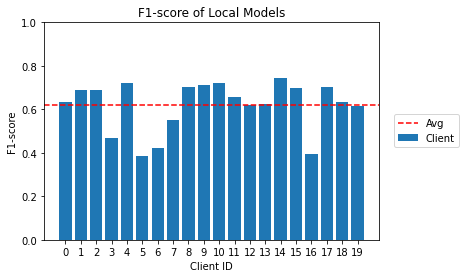

In [ ]:
plot_performance_of_local_models(precision_recall_fscores_of_local_aggregated_models, avg_local_aggregated_model_precision_recall_fscore)

In [ ]:
print_measures_of_dispersion(precision_recall_fscores_of_local_aggregated_models)

Variance of F1-score across local models: 0.012360860611621874
Standard Deviation of F1-score across local models: 0.11117940731818043


No handles with labels found to put in legend.


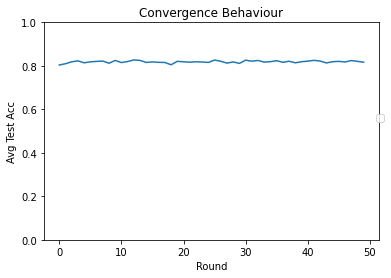

In [ ]:
plot_convergence_behaviour_from_federated_evaluation(federated_test_accs)

In [ ]:
get_utility_measure_on_distributions(avg_local_aggregated_model_precision_recall_fscore, avg_local_model_precision_recall_fscore)

Distribution                              Precision       Recall        \
                                              Aggr. Local  Aggr. Local   
noniid-distribution-based-label-imbalance      0.61  0.54   0.66  0.58   

Distribution                              F1-score        
                                             Aggr. Local  
noniid-distribution-based-label-imbalance     0.62  0.54

# Label Distribution Skew: Quantity-based label imbalance

Each client owns data samples of a fixed subset of total labels. This is first introduced in [the experiments of FedAvg](https://arxiv.org/pdf/1602.05629.pdf), where each client is only assigned 2 subsets of the data, with different labels. Such a setting is also used in other studies, [here](https://arxiv.org/pdf/2004.10342.pdf) and [here](https://arxiv.org/pdf/1812.06127.pdf). [Here](https://arxiv.org/pdf/2004.10342.pdf)  a highly extreme case is considered, where each client only has data samples with a single label. We use a general partitioning strategy to set the number of labels that each client has; in the context of our study, this is either 1 or 2.

In [ ]:
# Overrides to global experiment config
DATA_PARTITIONING_STRATEGY = "noniid-quantity-based-label-imbalance-2"
EVAL_STRATEGY = "federated"
DATA_SHARING = True

In [ ]:
# Split client part of train set into NUMBER_OF_CLIENTS partitions.
partitioned_train_set = get_train_partitions(X_train, y_train.to_numpy())

In [ ]:
# Split test set into NUMBER_OF_CLIENTS partitions.
partitioned_test_set = get_test_partitions(X_test, y_test.to_numpy())

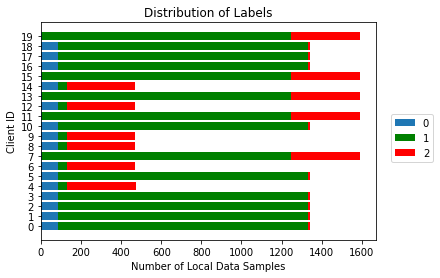

In [ ]:
plot_distribution_of_labels(partitioned_train_set)

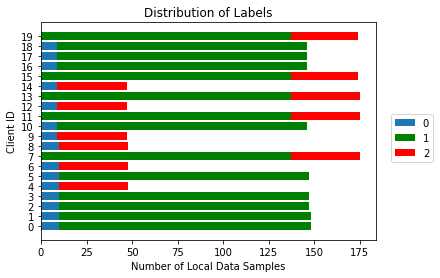

In [ ]:
plot_distribution_of_labels(partitioned_test_set)

In [ ]:
# Evaluate local models
local_models_y_preds = evaluate_local_models(partitioned_train_set, partitioned_test_set)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
local_models_y_test = [y_test_partition for X_test_partition, y_test_partition in partitioned_test_set]

In [ ]:
precision_recall_fscores_of_local_models = get_precision_recall_fscores_of_local_models(local_models_y_test, local_models_y_preds)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMe

In [ ]:
avg_local_model_precision_recall_fscore = get_mean_precision_recall_fscores_of_local_models(precision_recall_fscores_of_local_models)

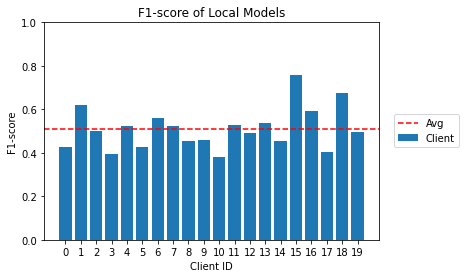

In [ ]:
plot_performance_of_local_models(precision_recall_fscores_of_local_models, avg_local_model_precision_recall_fscore)

In [ ]:
print_measures_of_dispersion(precision_recall_fscores_of_local_models)

Variance of F1-score across local models: 0.008855557213928385
Standard Deviation of F1-score across local models: 0.09410397023467387


In [ ]:
# Run sim with global config
sim_results = run_sim(partitioned_train_set, partitioned_test_set)

INFO flower 2022-03-16 00:27:26,564 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-03-16 00:27:26,568 | server.py:128 | Initializing global parameters
INFO flower 2022-03-16 00:27:26,569 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 557


INFO flower 2022-03-16 00:27:28,591 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-16 00:27:28,593 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-16 00:27:28,596 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-03-16 00:27:28,600 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-03-16 00:27:28,601 | server.py:130 | Evaluating initial parameters
INFO flower 2022-03-16 00:27:28,602 | server.py:143 | FL starting


initializing Client1 with pid 592


INFO flower 2022-03-16 00:27:29,611 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-16 00:27:29,614 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-16 00:27:29,616 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-03-16 00:27:29,619 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 625


INFO flower 2022-03-16 00:27:30,634 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-16 00:27:30,636 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-16 00:27:30,638 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-03-16 00:27:30,639 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 661


INFO flower 2022-03-16 00:27:31,656 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-16 00:27:31,659 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-16 00:27:31,661 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-03-16 00:27:31,662 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 697


INFO flower 2022-03-16 00:27:32,682 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-16 00:27:32,684 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-16 00:27:32,686 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-03-16 00:27:32,687 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 735


INFO flower 2022-03-16 00:27:33,706 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-16 00:27:33,709 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-16 00:27:33,712 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 773


INFO flower 2022-03-16 00:27:34,728 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-16 00:27:34,730 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-16 00:27:34,733 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 813


INFO flower 2022-03-16 00:27:35,747 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-16 00:27:35,749 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-16 00:27:35,751 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-03-16 00:27:35,752 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 857


INFO flower 2022-03-16 00:27:36,769 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-16 00:27:36,772 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-16 00:27:36,775 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-03-16 00:27:36,776 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 903


INFO flower 2022-03-16 00:27:37,796 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-16 00:27:37,799 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-16 00:27:37,800 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-03-16 00:27:37,802 | connection.py:39 | ChannelConnectivity.READY


initializing Client10 with pid 951


INFO flower 2022-03-16 00:27:38,818 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-16 00:27:38,821 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-16 00:27:38,823 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-03-16 00:27:38,824 | connection.py:39 | ChannelConnectivity.READY


initializing Client11 with pid 1001


INFO flower 2022-03-16 00:27:39,836 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-16 00:27:39,840 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-16 00:27:39,841 | connection.py:39 | ChannelConnectivity.READY


initializing Client12 with pid 1051


INFO flower 2022-03-16 00:27:40,859 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-16 00:27:40,862 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-16 00:27:40,863 | connection.py:39 | ChannelConnectivity.READY


initializing Client13 with pid 1103


INFO flower 2022-03-16 00:27:41,886 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-16 00:27:41,889 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-16 00:27:41,891 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-03-16 00:27:41,892 | connection.py:39 | ChannelConnectivity.READY


initializing Client14 with pid 1161


INFO flower 2022-03-16 00:27:42,907 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-16 00:27:42,909 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-16 00:27:42,911 | connection.py:39 | ChannelConnectivity.READY


initializing Client15 with pid 1217


INFO flower 2022-03-16 00:27:43,928 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-16 00:27:43,931 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-16 00:27:43,932 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-03-16 00:27:43,933 | connection.py:39 | ChannelConnectivity.READY


initializing Client16 with pid 1279


INFO flower 2022-03-16 00:27:44,952 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-16 00:27:44,954 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-16 00:27:44,956 | connection.py:39 | ChannelConnectivity.READY


initializing Client17 with pid 1339


INFO flower 2022-03-16 00:27:45,974 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-16 00:27:45,977 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-16 00:27:45,979 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-03-16 00:27:45,981 | connection.py:39 | ChannelConnectivity.READY


initializing Client18 with pid 1403


INFO flower 2022-03-16 00:27:46,996 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-16 00:27:46,999 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-16 00:27:47,001 | connection.py:39 | ChannelConnectivity.READY


initializing Client19 with pid 1467


INFO flower 2022-03-16 00:27:48,023 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-16 00:27:48,026 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-16 00:27:48,027 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-03-16 00:27:48,029 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)
DEBUG flower 2022-03-16 00:27:48,030 | connection.py:39 | ChannelConnectivity.READY


Client18 with pid 1403 is sampled in training rnd 1
Client2 with pid 625 is sampled in training rnd 1
Client15 with pid 1217 is sampled in training rnd 1
Client8 with pid 857 is sampled in training rnd 1
Client3 with pid 661 is sampled in training rnd 1
Client7 with pid 813 is sampled in training rnd 1
Client13 with pid 1103 is sampled in training rnd 1
Client6 with pid 773 is sampled in training rnd 1
Client12 with pid 1051 is sampled in training rnd 1
Client16 with pid 1279 is sampled in training rnd 1
Client10 with pid 951 is sampled in training rnd 1
Client1 with pid 592 is sampled in training rnd 1
Client0 with pid 557 is sampled in training rnd 1
Client14 with pid 1161 is sampled in training rnd 1


DEBUG flower 2022-03-16 00:27:49,191 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:27:49,212 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client12 with pid 1051 is sampled in evaluation rnd 1
Client13 with pid 1103 is sampled in evaluation rnd 1
Client0 with pid 557 is sampled in evaluation rnd 1
Client8 with pid 857 is sampled in evaluation rnd 1
Client14 with pid 1161 is sampled in evaluation rnd 1
Client11 with pid 1001 is sampled in evaluation rnd 1
Client19 with pid 1467 is sampled in evaluation rnd 1
Client3 with pid 661 is sampled in evaluation rnd 1
Client1 with pid 592 is sampled in evaluation rnd 1
Client9 with pid 903 is sampled in evaluation rnd 1
Client17 with pid 1339 is sampled in evaluation rnd 1
Client15 with pid 1217 is sampled in evaluation rnd 1
Client5 with pid 735 is sampled in evaluation rnd 1
Client7 with pid 813 is sampled in evaluation rnd 1
Client16 with pid 1279 is sampled in evaluation rnd 1
Client6 with pid 773 is sampled in evaluation rnd 1
Client4 with pid 697 is sampled in evaluation rnd 1
Client10 with pid 951 is sampled in evaluation rnd 1
Client18 with pid 1403 is sampled in evaluation

DEBUG flower 2022-03-16 00:27:49,327 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:27:49,328 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client0 with pid 557 is sampled in training rnd 2
Client16 with pid 1279 is sampled in training rnd 2
Client15 with pid 1217 is sampled in training rnd 2
Client14 with pid 1161 is sampled in training rnd 2
Client8 with pid 857 is sampled in training rnd 2
Client7 with pid 813 is sampled in training rnd 2
Client3 with pid 661 is sampled in training rnd 2
Client13 with pid 1103 is sampled in training rnd 2
Client10 with pid 951 is sampled in training rnd 2
Client5 with pid 735 is sampled in training rnd 2
Client11 with pid 1001 is sampled in training rnd 2
Client17 with pid 1339 is sampled in training rnd 2
Client4 with pid 697 is sampled in training rnd 2
Client19 with pid 1467 is sampled in training rnd 2


DEBUG flower 2022-03-16 00:27:50,527 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:27:50,553 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client13 with pid 1103 is sampled in evaluation rnd 2
Client17 with pid 1339 is sampled in evaluation rnd 2
Client3 with pid 661 is sampled in evaluation rnd 2
Client5 with pid 735 is sampled in evaluation rnd 2
Client9 with pid 903 is sampled in evaluation rnd 2
Client11 with pid 1001 is sampled in evaluation rnd 2
Client19 with pid 1467 is sampled in evaluation rnd 2
Client16 with pid 1279 is sampled in evaluation rnd 2
Client1 with pid 592 is sampled in evaluation rnd 2
Client8 with pid 857 is sampled in evaluation rnd 2
Client6 with pid 773 is sampled in evaluation rnd 2
Client10 with pid 951 is sampled in evaluation rnd 2
Client18 with pid 1403 is sampled in evaluation rnd 2
Client2 with pid 625 is sampled in evaluation rnd 2
Client15 with pid 1217 is sampled in evaluation rnd 2
Client4 with pid 697 is sampled in evaluation rnd 2
Client7 with pid 813 is sampled in evaluation rnd 2
Client12 with pid 1051 is sampled in evaluation rnd 2
Client14 with pid 1161 is sampled in evaluation

DEBUG flower 2022-03-16 00:27:50,659 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:27:50,660 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client7 with pid 813 is sampled in training rnd 3
Client15 with pid 1217 is sampled in training rnd 3
Client13 with pid 1103 is sampled in training rnd 3
Client12 with pid 1051 is sampled in training rnd 3
Client5 with pid 735 is sampled in training rnd 3
Client10 with pid 951 is sampled in training rnd 3
Client11 with pid 1001 is sampled in training rnd 3
Client8 with pid 857 is sampled in training rnd 3
Client19 with pid 1467 is sampled in training rnd 3
Client14 with pid 1161 is sampled in training rnd 3
Client1 with pid 592 is sampled in training rnd 3
Client18 with pid 1403 is sampled in training rnd 3
Client9 with pid 903 is sampled in training rnd 3
Client6 with pid 773 is sampled in training rnd 3


DEBUG flower 2022-03-16 00:27:51,830 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:27:51,860 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client5 with pid 735 is sampled in evaluation rnd 3
Client16 with pid 1279 is sampled in evaluation rnd 3
Client11 with pid 1001 is sampled in evaluation rnd 3
Client12 with pid 1051 is sampled in evaluation rnd 3
Client15 with pid 1217 is sampled in evaluation rnd 3
Client18 with pid 1403 is sampled in evaluation rnd 3
Client0 with pid 557 is sampled in evaluation rnd 3
Client4 with pid 697 is sampled in evaluation rnd 3
Client13 with pid 1103 is sampled in evaluation rnd 3
Client9 with pid 903 is sampled in evaluation rnd 3
Client7 with pid 813 is sampled in evaluation rnd 3
Client6 with pid 773 is sampled in evaluation rnd 3
Client2 with pid 625 is sampled in evaluation rnd 3
Client1 with pid 592 is sampled in evaluation rnd 3
Client10 with pid 951 is sampled in evaluation rnd 3
Client8 with pid 857 is sampled in evaluation rnd 3
Client14 with pid 1161 is sampled in evaluation rnd 3
Client19 with pid 1467 is sampled in evaluation rnd 3
Client3 with pid 661 is sampled in evaluation r

DEBUG flower 2022-03-16 00:27:51,971 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:27:51,973 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client16 with pid 1279 is sampled in training rnd 4
Client11 with pid 1001 is sampled in training rnd 4
Client18 with pid 1403 is sampled in training rnd 4
Client14 with pid 1161 is sampled in training rnd 4
Client10 with pid 951 is sampled in training rnd 4
Client15 with pid 1217 is sampled in training rnd 4
Client9 with pid 903 is sampled in training rnd 4
Client17 with pid 1339 is sampled in training rnd 4
Client8 with pid 857 is sampled in training rnd 4
Client0 with pid 557 is sampled in training rnd 4
Client13 with pid 1103 is sampled in training rnd 4
Client6 with pid 773 is sampled in training rnd 4
Client2 with pid 625 is sampled in training rnd 4
Client4 with pid 697 is sampled in training rnd 4


DEBUG flower 2022-03-16 00:27:53,125 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:27:53,158 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client17 with pid 1339 is sampled in evaluation rnd 4
Client6 with pid 773 is sampled in evaluation rnd 4
Client13 with pid 1103 is sampled in evaluation rnd 4
Client1 with pid 592 is sampled in evaluation rnd 4
Client15 with pid 1217 is sampled in evaluation rnd 4
Client5 with pid 735 is sampled in evaluation rnd 4
Client19 with pid 1467 is sampled in evaluation rnd 4
Client9 with pid 903 is sampled in evaluation rnd 4
Client8 with pid 857 is sampled in evaluation rnd 4
Client3 with pid 661 is sampled in evaluation rnd 4
Client7 with pid 813 is sampled in evaluation rnd 4
Client11 with pid 1001 is sampled in evaluation rnd 4
Client18 with pid 1403 is sampled in evaluation rnd 4
Client14 with pid 1161 is sampled in evaluation rnd 4
Client12 with pid 1051 is sampled in evaluation rnd 4
Client10 with pid 951 is sampled in evaluation rnd 4
Client2 with pid 625 is sampled in evaluation rnd 4
Client16 with pid 1279 is sampled in evaluation rnd 4
Client4 with pid 697 is sampled in evaluation

DEBUG flower 2022-03-16 00:27:53,273 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:27:53,274 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client19 with pid 1467 is sampled in training rnd 5
Client7 with pid 813 is sampled in training rnd 5
Client16 with pid 1279 is sampled in training rnd 5
Client0 with pid 557 is sampled in training rnd 5
Client5 with pid 735 is sampled in training rnd 5
Client13 with pid 1103 is sampled in training rnd 5
Client1 with pid 592 is sampled in training rnd 5
Client12 with pid 1051 is sampled in training rnd 5
Client4 with pid 697 is sampled in training rnd 5
Client8 with pid 857 is sampled in training rnd 5
Client18 with pid 1403 is sampled in training rnd 5
Client14 with pid 1161 is sampled in training rnd 5
Client11 with pid 1001 is sampled in training rnd 5
Client6 with pid 773 is sampled in training rnd 5


DEBUG flower 2022-03-16 00:27:54,472 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:27:54,494 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client0 with pid 557 is sampled in evaluation rnd 5
Client14 with pid 1161 is sampled in evaluation rnd 5
Client19 with pid 1467 is sampled in evaluation rnd 5
Client1 with pid 592 is sampled in evaluation rnd 5
Client7 with pid 813 is sampled in evaluation rnd 5
Client8 with pid 857 is sampled in evaluation rnd 5
Client4 with pid 697 is sampled in evaluation rnd 5
Client12 with pid 1051 is sampled in evaluation rnd 5
Client9 with pid 903 is sampled in evaluation rnd 5
Client2 with pid 625 is sampled in evaluation rnd 5
Client18 with pid 1403 is sampled in evaluation rnd 5
Client5 with pid 735 is sampled in evaluation rnd 5
Client13 with pid 1103 is sampled in evaluation rnd 5
Client10 with pid 951 is sampled in evaluation rnd 5
Client11 with pid 1001 is sampled in evaluation rnd 5
Client15 with pid 1217 is sampled in evaluation rnd 5
Client6 with pid 773 is sampled in evaluation rnd 5
Client16 with pid 1279 is sampled in evaluation rnd 5
Client3 with pid 661 is sampled in evaluation r

DEBUG flower 2022-03-16 00:27:54,613 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:27:54,615 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client14 with pid 1161 is sampled in training rnd 6
Client10 with pid 951 is sampled in training rnd 6
Client17 with pid 1339 is sampled in training rnd 6
Client15 with pid 1217 is sampled in training rnd 6
Client0 with pid 557 is sampled in training rnd 6
Client3 with pid 661 is sampled in training rnd 6
Client6 with pid 773 is sampled in training rnd 6
Client4 with pid 697 is sampled in training rnd 6
Client5 with pid 735 is sampled in training rnd 6
Client12 with pid 1051 is sampled in training rnd 6
Client16 with pid 1279 is sampled in training rnd 6
Client13 with pid 1103 is sampled in training rnd 6
Client1 with pid 592 is sampled in training rnd 6
Client2 with pid 625 is sampled in training rnd 6


DEBUG flower 2022-03-16 00:27:55,867 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:27:55,906 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client16 with pid 1279 is sampled in evaluation rnd 6
Client13 with pid 1103 is sampled in evaluation rnd 6
Client0 with pid 557 is sampled in evaluation rnd 6
Client6 with pid 773 is sampled in evaluation rnd 6
Client19 with pid 1467 is sampled in evaluation rnd 6
Client7 with pid 813 is sampled in evaluation rnd 6
Client2 with pid 625 is sampled in evaluation rnd 6
Client18 with pid 1403 is sampled in evaluation rnd 6
Client14 with pid 1161 is sampled in evaluation rnd 6
Client12 with pid 1051 is sampled in evaluation rnd 6
Client8 with pid 857 is sampled in evaluation rnd 6
Client15 with pid 1217 is sampled in evaluation rnd 6
Client17 with pid 1339 is sampled in evaluation rnd 6
Client4 with pid 697 is sampled in evaluation rnd 6
Client1 with pid 592 is sampled in evaluation rnd 6
Client3 with pid 661 is sampled in evaluation rnd 6
Client9 with pid 903 is sampled in evaluation rnd 6
Client11 with pid 1001 is sampled in evaluation rnd 6
Client10 with pid 951 is sampled in evaluation

DEBUG flower 2022-03-16 00:27:56,012 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:27:56,013 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client18 with pid 1403 is sampled in training rnd 7
Client10 with pid 951 is sampled in training rnd 7
Client1 with pid 592 is sampled in training rnd 7
Client13 with pid 1103 is sampled in training rnd 7
Client0 with pid 557 is sampled in training rnd 7
Client4 with pid 697 is sampled in training rnd 7
Client9 with pid 903 is sampled in training rnd 7
Client2 with pid 625 is sampled in training rnd 7
Client16 with pid 1279 is sampled in training rnd 7
Client19 with pid 1467 is sampled in training rnd 7
Client3 with pid 661 is sampled in training rnd 7
Client11 with pid 1001 is sampled in training rnd 7
Client8 with pid 857 is sampled in training rnd 7
Client5 with pid 735 is sampled in training rnd 7


DEBUG flower 2022-03-16 00:27:57,243 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:27:57,274 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client4 with pid 697 is sampled in evaluation rnd 7
Client5 with pid 735 is sampled in evaluation rnd 7
Client13 with pid 1103 is sampled in evaluation rnd 7
Client8 with pid 857 is sampled in evaluation rnd 7
Client0 with pid 557 is sampled in evaluation rnd 7
Client17 with pid 1339 is sampled in evaluation rnd 7
Client18 with pid 1403 is sampled in evaluation rnd 7
Client9 with pid 903 is sampled in evaluation rnd 7
Client3 with pid 661 is sampled in evaluation rnd 7
Client11 with pid 1001 is sampled in evaluation rnd 7
Client15 with pid 1217 is sampled in evaluation rnd 7
Client7 with pid 813 is sampled in evaluation rnd 7
Client2 with pid 625 is sampled in evaluation rnd 7
Client6 with pid 773 is sampled in evaluation rnd 7
Client16 with pid 1279 is sampled in evaluation rnd 7
Client19 with pid 1467 is sampled in evaluation rnd 7
Client12 with pid 1051 is sampled in evaluation rnd 7
Client1 with pid 592 is sampled in evaluation rnd 7
Client10 with pid 951 is sampled in evaluation r

DEBUG flower 2022-03-16 00:27:57,387 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:27:57,389 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client3 with pid 661 is sampled in training rnd 8
Client6 with pid 773 is sampled in training rnd 8
Client18 with pid 1403 is sampled in training rnd 8
Client15 with pid 1217 is sampled in training rnd 8
Client10 with pid 951 is sampled in training rnd 8
Client13 with pid 1103 is sampled in training rnd 8
Client1 with pid 592 is sampled in training rnd 8
Client16 with pid 1279 is sampled in training rnd 8
Client4 with pid 697 is sampled in training rnd 8
Client8 with pid 857 is sampled in training rnd 8
Client7 with pid 813 is sampled in training rnd 8
Client0 with pid 557 is sampled in training rnd 8
Client5 with pid 735 is sampled in training rnd 8
Client11 with pid 1001 is sampled in training rnd 8


DEBUG flower 2022-03-16 00:27:58,635 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:27:58,666 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client12 with pid 1051 is sampled in evaluation rnd 8
Client9 with pid 903 is sampled in evaluation rnd 8
Client0 with pid 557 is sampled in evaluation rnd 8
Client5 with pid 735 is sampled in evaluation rnd 8
Client6 with pid 773 is sampled in evaluation rnd 8
Client13 with pid 1103 is sampled in evaluation rnd 8
Client16 with pid 1279 is sampled in evaluation rnd 8
Client19 with pid 1467 is sampled in evaluation rnd 8
Client18 with pid 1403 is sampled in evaluation rnd 8
Client2 with pid 625 is sampled in evaluation rnd 8
Client14 with pid 1161 is sampled in evaluation rnd 8
Client15 with pid 1217 is sampled in evaluation rnd 8
Client3 with pid 661 is sampled in evaluation rnd 8
Client17 with pid 1339 is sampled in evaluation rnd 8
Client10 with pid 951 is sampled in evaluation rnd 8
Client8 with pid 857 is sampled in evaluation rnd 8
Client7 with pid 813 is sampled in evaluation rnd 8
Client1 with pid 592 is sampled in evaluation rnd 8
Client11 with pid 1001 is sampled in evaluation

DEBUG flower 2022-03-16 00:27:58,782 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:27:58,784 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client17 with pid 1339 is sampled in training rnd 9
Client7 with pid 813 is sampled in training rnd 9
Client1 with pid 592 is sampled in training rnd 9
Client2 with pid 625 is sampled in training rnd 9
Client13 with pid 1103 is sampled in training rnd 9
Client4 with pid 697 is sampled in training rnd 9
Client8 with pid 857 is sampled in training rnd 9
Client5 with pid 735 is sampled in training rnd 9
Client19 with pid 1467 is sampled in training rnd 9
Client9 with pid 903 is sampled in training rnd 9
Client15 with pid 1217 is sampled in training rnd 9
Client14 with pid 1161 is sampled in training rnd 9
Client3 with pid 661 is sampled in training rnd 9
Client12 with pid 1051 is sampled in training rnd 9


DEBUG flower 2022-03-16 00:27:59,910 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:27:59,938 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client9 with pid 903 is sampled in evaluation rnd 9
Client3 with pid 661 is sampled in evaluation rnd 9
Client7 with pid 813 is sampled in evaluation rnd 9
Client19 with pid 1467 is sampled in evaluation rnd 9
Client10 with pid 951 is sampled in evaluation rnd 9
Client13 with pid 1103 is sampled in evaluation rnd 9
Client16 with pid 1279 is sampled in evaluation rnd 9
Client12 with pid 1051 is sampled in evaluation rnd 9
Client11 with pid 1001 is sampled in evaluation rnd 9
Client15 with pid 1217 is sampled in evaluation rnd 9
Client2 with pid 625 is sampled in evaluation rnd 9
Client1 with pid 592 is sampled in evaluation rnd 9
Client8 with pid 857 is sampled in evaluation rnd 9
Client14 with pid 1161 is sampled in evaluation rnd 9
Client0 with pid 557 is sampled in evaluation rnd 9
Client17 with pid 1339 is sampled in evaluation rnd 9
Client5 with pid 735 is sampled in evaluation rnd 9
Client4 with pid 697 is sampled in evaluation rnd 9
Client18 with pid 1403 is sampled in evaluation

DEBUG flower 2022-03-16 00:28:00,056 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:28:00,057 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client3 with pid 661 is sampled in training rnd 10
Client10 with pid 951 is sampled in training rnd 10
Client12 with pid 1051 is sampled in training rnd 10
Client2 with pid 625 is sampled in training rnd 10
Client7 with pid 813 is sampled in training rnd 10
Client9 with pid 903 is sampled in training rnd 10
Client1 with pid 592 is sampled in training rnd 10
Client4 with pid 697 is sampled in training rnd 10
Client5 with pid 735 is sampled in training rnd 10
Client17 with pid 1339 is sampled in training rnd 10
Client14 with pid 1161 is sampled in training rnd 10
Client8 with pid 857 is sampled in training rnd 10
Client13 with pid 1103 is sampled in training rnd 10
Client18 with pid 1403 is sampled in training rnd 10


DEBUG flower 2022-03-16 00:28:01,195 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:28:01,212 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client8 with pid 857 is sampled in evaluation rnd 10
Client3 with pid 661 is sampled in evaluation rnd 10
Client9 with pid 903 is sampled in evaluation rnd 10
Client1 with pid 592 is sampled in evaluation rnd 10
Client0 with pid 557 is sampled in evaluation rnd 10
Client16 with pid 1279 is sampled in evaluation rnd 10
Client10 with pid 951 is sampled in evaluation rnd 10
Client15 with pid 1217 is sampled in evaluation rnd 10
Client17 with pid 1339 is sampled in evaluation rnd 10
Client6 with pid 773 is sampled in evaluation rnd 10
Client11 with pid 1001 is sampled in evaluation rnd 10
Client12 with pid 1051 is sampled in evaluation rnd 10
Client18 with pid 1403 is sampled in evaluation rnd 10
Client14 with pid 1161 is sampled in evaluation rnd 10
Client7 with pid 813 is sampled in evaluation rnd 10
Client4 with pid 697 is sampled in evaluation rnd 10
Client19 with pid 1467 is sampled in evaluation rnd 10
Client13 with pid 1103 is sampled in evaluation rnd 10
Client2 with pid 625 is sam

DEBUG flower 2022-03-16 00:28:01,328 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:28:01,329 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client7 with pid 813 is sampled in training rnd 11
Client3 with pid 661 is sampled in training rnd 11
Client15 with pid 1217 is sampled in training rnd 11
Client12 with pid 1051 is sampled in training rnd 11
Client5 with pid 735 is sampled in training rnd 11
Client4 with pid 697 is sampled in training rnd 11
Client13 with pid 1103 is sampled in training rnd 11
Client8 with pid 857 is sampled in training rnd 11
Client16 with pid 1279 is sampled in training rnd 11
Client14 with pid 1161 is sampled in training rnd 11
Client19 with pid 1467 is sampled in training rnd 11
Client18 with pid 1403 is sampled in training rnd 11
Client1 with pid 592 is sampled in training rnd 11
Client9 with pid 903 is sampled in training rnd 11


DEBUG flower 2022-03-16 00:28:02,496 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:28:02,528 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client10 with pid 951 is sampled in evaluation rnd 11
Client0 with pid 557 is sampled in evaluation rnd 11
Client1 with pid 592 is sampled in evaluation rnd 11
Client9 with pid 903 is sampled in evaluation rnd 11
Client11 with pid 1001 is sampled in evaluation rnd 11
Client17 with pid 1339 is sampled in evaluation rnd 11
Client15 with pid 1217 is sampled in evaluation rnd 11
Client5 with pid 735 is sampled in evaluation rnd 11
Client7 with pid 813 is sampled in evaluation rnd 11
Client6 with pid 773 is sampled in evaluation rnd 11
Client12 with pid 1051 is sampled in evaluation rnd 11
Client16 with pid 1279 is sampled in evaluation rnd 11
Client19 with pid 1467 is sampled in evaluation rnd 11
Client18 with pid 1403 is sampled in evaluation rnd 11
Client2 with pid 625 is sampled in evaluation rnd 11
Client4 with pid 697 is sampled in evaluation rnd 11
Client3 with pid 661 is sampled in evaluation rnd 11
Client8 with pid 857 is sampled in evaluation rnd 11
Client13 with pid 1103 is sampl

DEBUG flower 2022-03-16 00:28:02,634 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:28:02,636 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client19 with pid 1467 is sampled in training rnd 12
Client15 with pid 1217 is sampled in training rnd 12
Client17 with pid 1339 is sampled in training rnd 12
Client11 with pid 1001 is sampled in training rnd 12
Client2 with pid 625 is sampled in training rnd 12
Client18 with pid 1403 is sampled in training rnd 12
Client3 with pid 661 is sampled in training rnd 12
Client8 with pid 857 is sampled in training rnd 12
Client4 with pid 697 is sampled in training rnd 12
Client12 with pid 1051 is sampled in training rnd 12
Client10 with pid 951 is sampled in training rnd 12
Client5 with pid 735 is sampled in training rnd 12
Client1 with pid 592 is sampled in training rnd 12
Client6 with pid 773 is sampled in training rnd 12


DEBUG flower 2022-03-16 00:28:03,775 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:28:03,810 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client8 with pid 857 is sampled in evaluation rnd 12
Client14 with pid 1161 is sampled in evaluation rnd 12
Client2 with pid 625 is sampled in evaluation rnd 12
Client18 with pid 1403 is sampled in evaluation rnd 12
Client3 with pid 661 is sampled in evaluation rnd 12
Client4 with pid 697 is sampled in evaluation rnd 12
Client6 with pid 773 is sampled in evaluation rnd 12
Client10 with pid 951 is sampled in evaluation rnd 12
Client5 with pid 735 is sampled in evaluation rnd 12
Client0 with pid 557 is sampled in evaluation rnd 12
Client15 with pid 1217 is sampled in evaluation rnd 12
Client9 with pid 903 is sampled in evaluation rnd 12
Client7 with pid 813 is sampled in evaluation rnd 12
Client16 with pid 1279 is sampled in evaluation rnd 12
Client12 with pid 1051 is sampled in evaluation rnd 12
Client17 with pid 1339 is sampled in evaluation rnd 12
Client1 with pid 592 is sampled in evaluation rnd 12
Client11 with pid 1001 is sampled in evaluation rnd 12
Client19 with pid 1467 is sampl

DEBUG flower 2022-03-16 00:28:03,918 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:28:03,920 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client7 with pid 813 is sampled in training rnd 13
Client12 with pid 1051 is sampled in training rnd 13
Client2 with pid 625 is sampled in training rnd 13
Client17 with pid 1339 is sampled in training rnd 13
Client11 with pid 1001 is sampled in training rnd 13
Client1 with pid 592 is sampled in training rnd 13
Client0 with pid 557 is sampled in training rnd 13
Client8 with pid 857 is sampled in training rnd 13
Client10 with pid 951 is sampled in training rnd 13
Client18 with pid 1403 is sampled in training rnd 13
Client4 with pid 697 is sampled in training rnd 13
Client5 with pid 735 is sampled in training rnd 13
Client19 with pid 1467 is sampled in training rnd 13
Client3 with pid 661 is sampled in training rnd 13


DEBUG flower 2022-03-16 00:28:05,210 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:28:05,242 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client4 with pid 697 is sampled in evaluation rnd 13
Client16 with pid 1279 is sampled in evaluation rnd 13
Client3 with pid 661 is sampled in evaluation rnd 13
Client10 with pid 951 is sampled in evaluation rnd 13
Client8 with pid 857 is sampled in evaluation rnd 13
Client17 with pid 1339 is sampled in evaluation rnd 13
Client2 with pid 625 is sampled in evaluation rnd 13
Client15 with pid 1217 is sampled in evaluation rnd 13
Client12 with pid 1051 is sampled in evaluation rnd 13
Client11 with pid 1001 is sampled in evaluation rnd 13
Client13 with pid 1103 is sampled in evaluation rnd 13
Client5 with pid 735 is sampled in evaluation rnd 13
Client19 with pid 1467 is sampled in evaluation rnd 13
Client0 with pid 557 is sampled in evaluation rnd 13
Client14 with pid 1161 is sampled in evaluation rnd 13
Client7 with pid 813 is sampled in evaluation rnd 13
Client6 with pid 773 is sampled in evaluation rnd 13
Client9 with pid 903 is sampled in evaluation rnd 13
Client18 with pid 1403 is sam

DEBUG flower 2022-03-16 00:28:05,327 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:28:05,328 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client17 with pid 1339 is sampled in training rnd 14
Client10 with pid 951 is sampled in training rnd 14
Client1 with pid 592 is sampled in training rnd 14
Client5 with pid 735 is sampled in training rnd 14
Client4 with pid 697 is sampled in training rnd 14
Client6 with pid 773 is sampled in training rnd 14
Client16 with pid 1279 is sampled in training rnd 14
Client8 with pid 857 is sampled in training rnd 14
Client2 with pid 625 is sampled in training rnd 14
Client0 with pid 557 is sampled in training rnd 14
Client3 with pid 661 is sampled in training rnd 14
Client14 with pid 1161 is sampled in training rnd 14
Client18 with pid 1403 is sampled in training rnd 14
Client15 with pid 1217 is sampled in training rnd 14


DEBUG flower 2022-03-16 00:28:06,541 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:28:06,569 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client14 with pid 1161 is sampled in evaluation rnd 14
Client17 with pid 1339 is sampled in evaluation rnd 14
Client13 with pid 1103 is sampled in evaluation rnd 14
Client8 with pid 857 is sampled in evaluation rnd 14
Client18 with pid 1403 is sampled in evaluation rnd 14
Client19 with pid 1467 is sampled in evaluation rnd 14
Client16 with pid 1279 is sampled in evaluation rnd 14
Client7 with pid 813 is sampled in evaluation rnd 14
Client0 with pid 557 is sampled in evaluation rnd 14
Client6 with pid 773 is sampled in evaluation rnd 14
Client5 with pid 735 is sampled in evaluation rnd 14
Client2 with pid 625 is sampled in evaluation rnd 14
Client4 with pid 697 is sampled in evaluation rnd 14
Client3 with pid 661 is sampled in evaluation rnd 14
Client11 with pid 1001 is sampled in evaluation rnd 14
Client10 with pid 951 is sampled in evaluation rnd 14
Client9 with pid 903 is sampled in evaluation rnd 14
Client12 with pid 1051 is sampled in evaluation rnd 14
Client15 with pid 1217 is sam

DEBUG flower 2022-03-16 00:28:06,681 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:28:06,683 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client18 with pid 1403 is sampled in training rnd 15
Client4 with pid 697 is sampled in training rnd 15
Client16 with pid 1279 is sampled in training rnd 15
Client19 with pid 1467 is sampled in training rnd 15
Client8 with pid 857 is sampled in training rnd 15
Client6 with pid 773 is sampled in training rnd 15
Client9 with pid 903 is sampled in training rnd 15
Client14 with pid 1161 is sampled in training rnd 15
Client13 with pid 1103 is sampled in training rnd 15
Client2 with pid 625 is sampled in training rnd 15
Client1 with pid 592 is sampled in training rnd 15
Client3 with pid 661 is sampled in training rnd 15
Client7 with pid 813 is sampled in training rnd 15
Client0 with pid 557 is sampled in training rnd 15


DEBUG flower 2022-03-16 00:28:07,821 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:28:07,857 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client5 with pid 735 is sampled in evaluation rnd 15
Client16 with pid 1279 is sampled in evaluation rnd 15
Client10 with pid 951 is sampled in evaluation rnd 15
Client14 with pid 1161 is sampled in evaluation rnd 15
Client15 with pid 1217 is sampled in evaluation rnd 15
Client18 with pid 1403 is sampled in evaluation rnd 15
Client17 with pid 1339 is sampled in evaluation rnd 15
Client3 with pid 661 is sampled in evaluation rnd 15
Client13 with pid 1103 is sampled in evaluation rnd 15
Client11 with pid 1001 is sampled in evaluation rnd 15
Client12 with pid 1051 is sampled in evaluation rnd 15
Client19 with pid 1467 is sampled in evaluation rnd 15
Client7 with pid 813 is sampled in evaluation rnd 15
Client8 with pid 857 is sampled in evaluation rnd 15
Client1 with pid 592 is sampled in evaluation rnd 15
Client9 with pid 903 is sampled in evaluation rnd 15
Client6 with pid 773 is sampled in evaluation rnd 15
Client4 with pid 697 is sampled in evaluation rnd 15
Client2 with pid 625 is sam

DEBUG flower 2022-03-16 00:28:07,968 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:28:07,969 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client1 with pid 592 is sampled in training rnd 16
Client2 with pid 625 is sampled in training rnd 16
Client11 with pid 1001 is sampled in training rnd 16
Client16 with pid 1279 is sampled in training rnd 16
Client8 with pid 857 is sampled in training rnd 16
Client4 with pid 697 is sampled in training rnd 16
Client10 with pid 951 is sampled in training rnd 16
Client5 with pid 735 is sampled in training rnd 16
Client12 with pid 1051 is sampled in training rnd 16
Client9 with pid 903 is sampled in training rnd 16
Client13 with pid 1103 is sampled in training rnd 16
Client19 with pid 1467 is sampled in training rnd 16
Client3 with pid 661 is sampled in training rnd 16
Client15 with pid 1217 is sampled in training rnd 16


DEBUG flower 2022-03-16 00:28:09,193 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:28:09,207 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client14 with pid 1161 is sampled in evaluation rnd 16
Client2 with pid 625 is sampled in evaluation rnd 16
Client16 with pid 1279 is sampled in evaluation rnd 16
Client3 with pid 661 is sampled in evaluation rnd 16
Client12 with pid 1051 is sampled in evaluation rnd 16
Client18 with pid 1403 is sampled in evaluation rnd 16
Client19 with pid 1467 is sampled in evaluation rnd 16
Client4 with pid 697 is sampled in evaluation rnd 16
Client6 with pid 773 is sampled in evaluation rnd 16
Client17 with pid 1339 is sampled in evaluation rnd 16
Client9 with pid 903 is sampled in evaluation rnd 16
Client0 with pid 557 is sampled in evaluation rnd 16
Client7 with pid 813 is sampled in evaluation rnd 16
Client5 with pid 735 is sampled in evaluation rnd 16
Client10 with pid 951 is sampled in evaluation rnd 16
Client13 with pid 1103 is sampled in evaluation rnd 16
Client11 with pid 1001 is sampled in evaluation rnd 16
Client8 with pid 857 is sampled in evaluation rnd 16
Client15 with pid 1217 is sam

DEBUG flower 2022-03-16 00:28:09,307 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:28:09,309 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client2 with pid 625 is sampled in training rnd 17
Client8 with pid 857 is sampled in training rnd 17
Client16 with pid 1279 is sampled in training rnd 17
Client17 with pid 1339 is sampled in training rnd 17
Client11 with pid 1001 is sampled in training rnd 17
Client1 with pid 592 is sampled in training rnd 17
Client3 with pid 661 is sampled in training rnd 17
Client18 with pid 1403 is sampled in training rnd 17
Client9 with pid 903 is sampled in training rnd 17
Client10 with pid 951 is sampled in training rnd 17
Client13 with pid 1103 is sampled in training rnd 17
Client19 with pid 1467 is sampled in training rnd 17
Client7 with pid 813 is sampled in training rnd 17
Client6 with pid 773 is sampled in training rnd 17


DEBUG flower 2022-03-16 00:28:10,605 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:28:10,643 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client13 with pid 1103 is sampled in evaluation rnd 17
Client12 with pid 1051 is sampled in evaluation rnd 17
Client10 with pid 951 is sampled in evaluation rnd 17
Client19 with pid 1467 is sampled in evaluation rnd 17
Client5 with pid 735 is sampled in evaluation rnd 17
Client2 with pid 625 is sampled in evaluation rnd 17
Client9 with pid 903 is sampled in evaluation rnd 17
Client7 with pid 813 is sampled in evaluation rnd 17
Client14 with pid 1161 is sampled in evaluation rnd 17
Client1 with pid 592 is sampled in evaluation rnd 17
Client3 with pid 661 is sampled in evaluation rnd 17
Client6 with pid 773 is sampled in evaluation rnd 17
Client8 with pid 857 is sampled in evaluation rnd 17
Client16 with pid 1279 is sampled in evaluation rnd 17
Client0 with pid 557 is sampled in evaluation rnd 17
Client18 with pid 1403 is sampled in evaluation rnd 17
Client4 with pid 697 is sampled in evaluation rnd 17
Client17 with pid 1339 is sampled in evaluation rnd 17
Client11 with pid 1001 is sampl

DEBUG flower 2022-03-16 00:28:10,752 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:28:10,753 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client6 with pid 773 is sampled in training rnd 18
Client16 with pid 1279 is sampled in training rnd 18
Client14 with pid 1161 is sampled in training rnd 18
Client18 with pid 1403 is sampled in training rnd 18
Client0 with pid 557 is sampled in training rnd 18
Client10 with pid 951 is sampled in training rnd 18
Client9 with pid 903 is sampled in training rnd 18
Client3 with pid 661 is sampled in training rnd 18
Client4 with pid 697 is sampled in training rnd 18
Client12 with pid 1051 is sampled in training rnd 18
Client2 with pid 625 is sampled in training rnd 18
Client11 with pid 1001 is sampled in training rnd 18
Client13 with pid 1103 is sampled in training rnd 18
Client8 with pid 857 is sampled in training rnd 18


DEBUG flower 2022-03-16 00:28:11,924 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:28:11,944 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client8 with pid 857 is sampled in evaluation rnd 18
Client6 with pid 773 is sampled in evaluation rnd 18
Client9 with pid 903 is sampled in evaluation rnd 18
Client14 with pid 1161 is sampled in evaluation rnd 18
Client15 with pid 1217 is sampled in evaluation rnd 18
Client13 with pid 1103 is sampled in evaluation rnd 18
Client12 with pid 1051 is sampled in evaluation rnd 18
Client18 with pid 1403 is sampled in evaluation rnd 18
Client2 with pid 625 is sampled in evaluation rnd 18
Client5 with pid 735 is sampled in evaluation rnd 18
Client16 with pid 1279 is sampled in evaluation rnd 18
Client19 with pid 1467 is sampled in evaluation rnd 18
Client7 with pid 813 is sampled in evaluation rnd 18
Client10 with pid 951 is sampled in evaluation rnd 18
Client1 with pid 592 is sampled in evaluation rnd 18
Client11 with pid 1001 is sampled in evaluation rnd 18
Client17 with pid 1339 is sampled in evaluation rnd 18
Client4 with pid 697 is sampled in evaluation rnd 18
Client3 with pid 661 is sam

DEBUG flower 2022-03-16 00:28:12,033 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:28:12,038 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client0 with pid 557 is sampled in training rnd 19
Client3 with pid 661 is sampled in training rnd 19
Client19 with pid 1467 is sampled in training rnd 19
Client9 with pid 903 is sampled in training rnd 19
Client4 with pid 697 is sampled in training rnd 19
Client1 with pid 592 is sampled in training rnd 19
Client5 with pid 735 is sampled in training rnd 19
Client8 with pid 857 is sampled in training rnd 19
Client15 with pid 1217 is sampled in training rnd 19
Client6 with pid 773 is sampled in training rnd 19
Client16 with pid 1279 is sampled in training rnd 19
Client13 with pid 1103 is sampled in training rnd 19
Client12 with pid 1051 is sampled in training rnd 19
Client11 with pid 1001 is sampled in training rnd 19


DEBUG flower 2022-03-16 00:28:13,233 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:28:13,258 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client3 with pid 661 is sampled in evaluation rnd 19
Client14 with pid 1161 is sampled in evaluation rnd 19
Client10 with pid 951 is sampled in evaluation rnd 19
Client16 with pid 1279 is sampled in evaluation rnd 19
Client0 with pid 557 is sampled in evaluation rnd 19
Client7 with pid 813 is sampled in evaluation rnd 19
Client5 with pid 735 is sampled in evaluation rnd 19
Client8 with pid 857 is sampled in evaluation rnd 19
Client11 with pid 1001 is sampled in evaluation rnd 19
Client4 with pid 697 is sampled in evaluation rnd 19
Client6 with pid 773 is sampled in evaluation rnd 19
Client12 with pid 1051 is sampled in evaluation rnd 19
Client13 with pid 1103 is sampled in evaluation rnd 19
Client17 with pid 1339 is sampled in evaluation rnd 19
Client19 with pid 1467 is sampled in evaluation rnd 19
Client18 with pid 1403 is sampled in evaluation rnd 19
Client9 with pid 903 is sampled in evaluation rnd 19
Client2 with pid 625 is sampled in evaluation rnd 19
Client15 with pid 1217 is sam

DEBUG flower 2022-03-16 00:28:13,366 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:28:13,368 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client16 with pid 1279 is sampled in training rnd 20
Client6 with pid 773 is sampled in training rnd 20
Client19 with pid 1467 is sampled in training rnd 20
Client18 with pid 1403 is sampled in training rnd 20
Client14 with pid 1161 is sampled in training rnd 20
Client13 with pid 1103 is sampled in training rnd 20
Client11 with pid 1001 is sampled in training rnd 20
Client15 with pid 1217 is sampled in training rnd 20
Client4 with pid 697 is sampled in training rnd 20
Client2 with pid 625 is sampled in training rnd 20
Client7 with pid 813 is sampled in training rnd 20
Client8 with pid 857 is sampled in training rnd 20
Client10 with pid 951 is sampled in training rnd 20
Client3 with pid 661 is sampled in training rnd 20


DEBUG flower 2022-03-16 00:28:14,592 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:28:14,620 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client16 with pid 1279 is sampled in evaluation rnd 20
Client0 with pid 557 is sampled in evaluation rnd 20
Client12 with pid 1051 is sampled in evaluation rnd 20
Client13 with pid 1103 is sampled in evaluation rnd 20
Client17 with pid 1339 is sampled in evaluation rnd 20
Client19 with pid 1467 is sampled in evaluation rnd 20
Client9 with pid 903 is sampled in evaluation rnd 20
Client5 with pid 735 is sampled in evaluation rnd 20
Client15 with pid 1217 is sampled in evaluation rnd 20
Client1 with pid 592 is sampled in evaluation rnd 20
Client7 with pid 813 is sampled in evaluation rnd 20
Client3 with pid 661 is sampled in evaluation rnd 20
Client4 with pid 697 is sampled in evaluation rnd 20
Client18 with pid 1403 is sampled in evaluation rnd 20
Client8 with pid 857 is sampled in evaluation rnd 20
Client14 with pid 1161 is sampled in evaluation rnd 20
Client11 with pid 1001 is sampled in evaluation rnd 20
Client6 with pid 773 is sampled in evaluation rnd 20
Client10 with pid 951 is sam

DEBUG flower 2022-03-16 00:28:14,724 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:28:14,725 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client2 with pid 625 is sampled in training rnd 21
Client12 with pid 1051 is sampled in training rnd 21
Client8 with pid 857 is sampled in training rnd 21
Client11 with pid 1001 is sampled in training rnd 21
Client5 with pid 735 is sampled in training rnd 21
Client0 with pid 557 is sampled in training rnd 21
Client16 with pid 1279 is sampled in training rnd 21
Client6 with pid 773 is sampled in training rnd 21
Client10 with pid 951 is sampled in training rnd 21
Client15 with pid 1217 is sampled in training rnd 21
Client18 with pid 1403 is sampled in training rnd 21
Client7 with pid 813 is sampled in training rnd 21
Client4 with pid 697 is sampled in training rnd 21
Client14 with pid 1161 is sampled in training rnd 21


DEBUG flower 2022-03-16 00:28:15,939 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:28:15,965 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client5 with pid 735 is sampled in evaluation rnd 21
Client8 with pid 857 is sampled in evaluation rnd 21
Client14 with pid 1161 is sampled in evaluation rnd 21
Client1 with pid 592 is sampled in evaluation rnd 21
Client15 with pid 1217 is sampled in evaluation rnd 21
Client4 with pid 697 is sampled in evaluation rnd 21
Client19 with pid 1467 is sampled in evaluation rnd 21
Client9 with pid 903 is sampled in evaluation rnd 21
Client18 with pid 1403 is sampled in evaluation rnd 21
Client11 with pid 1001 is sampled in evaluation rnd 21
Client6 with pid 773 is sampled in evaluation rnd 21
Client17 with pid 1339 is sampled in evaluation rnd 21
Client12 with pid 1051 is sampled in evaluation rnd 21
Client0 with pid 557 is sampled in evaluation rnd 21
Client7 with pid 813 is sampled in evaluation rnd 21
Client3 with pid 661 is sampled in evaluation rnd 21
Client16 with pid 1279 is sampled in evaluation rnd 21
Client2 with pid 625 is sampled in evaluation rnd 21
Client10 with pid 951 is sampl

DEBUG flower 2022-03-16 00:28:16,061 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:28:16,062 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client12 with pid 1051 is sampled in training rnd 22
Client6 with pid 773 is sampled in training rnd 22
Client8 with pid 857 is sampled in training rnd 22
Client9 with pid 903 is sampled in training rnd 22
Client3 with pid 661 is sampled in training rnd 22
Client5 with pid 735 is sampled in training rnd 22
Client16 with pid 1279 is sampled in training rnd 22
Client4 with pid 697 is sampled in training rnd 22
Client1 with pid 592 is sampled in training rnd 22
Client11 with pid 1001 is sampled in training rnd 22
Client18 with pid 1403 is sampled in training rnd 22
Client13 with pid 1103 is sampled in training rnd 22
Client7 with pid 813 is sampled in training rnd 22
Client19 with pid 1467 is sampled in training rnd 22


DEBUG flower 2022-03-16 00:28:17,289 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:28:17,309 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client1 with pid 592 is sampled in evaluation rnd 22
Client5 with pid 735 is sampled in evaluation rnd 22
Client17 with pid 1339 is sampled in evaluation rnd 22
Client8 with pid 857 is sampled in evaluation rnd 22
Client9 with pid 903 is sampled in evaluation rnd 22
Client19 with pid 1467 is sampled in evaluation rnd 22
Client16 with pid 1279 is sampled in evaluation rnd 22
Client11 with pid 1001 is sampled in evaluation rnd 22
Client6 with pid 773 is sampled in evaluation rnd 22
Client3 with pid 661 is sampled in evaluation rnd 22
Client12 with pid 1051 is sampled in evaluation rnd 22
Client7 with pid 813 is sampled in evaluation rnd 22
Client2 with pid 625 is sampled in evaluation rnd 22
Client10 with pid 951 is sampled in evaluation rnd 22
Client4 with pid 697 is sampled in evaluation rnd 22
Client14 with pid 1161 is sampled in evaluation rnd 22
Client15 with pid 1217 is sampled in evaluation rnd 22
Client13 with pid 1103 is sampled in evaluation rnd 22
Client0 with pid 557 is sampl

DEBUG flower 2022-03-16 00:28:17,396 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:28:17,399 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client19 with pid 1467 is sampled in training rnd 23
Client7 with pid 813 is sampled in training rnd 23
Client0 with pid 557 is sampled in training rnd 23
Client10 with pid 951 is sampled in training rnd 23
Client12 with pid 1051 is sampled in training rnd 23
Client14 with pid 1161 is sampled in training rnd 23
Client6 with pid 773 is sampled in training rnd 23
Client16 with pid 1279 is sampled in training rnd 23
Client3 with pid 661 is sampled in training rnd 23
Client4 with pid 697 is sampled in training rnd 23
Client11 with pid 1001 is sampled in training rnd 23
Client1 with pid 592 is sampled in training rnd 23
Client2 with pid 625 is sampled in training rnd 23
Client13 with pid 1103 is sampled in training rnd 23


DEBUG flower 2022-03-16 00:28:18,680 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:28:18,699 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client18 with pid 1403 is sampled in evaluation rnd 23
Client14 with pid 1161 is sampled in evaluation rnd 23
Client4 with pid 697 is sampled in evaluation rnd 23
Client8 with pid 857 is sampled in evaluation rnd 23
Client2 with pid 625 is sampled in evaluation rnd 23
Client16 with pid 1279 is sampled in evaluation rnd 23
Client19 with pid 1467 is sampled in evaluation rnd 23
Client12 with pid 1051 is sampled in evaluation rnd 23
Client13 with pid 1103 is sampled in evaluation rnd 23
Client5 with pid 735 is sampled in evaluation rnd 23
Client7 with pid 813 is sampled in evaluation rnd 23
Client1 with pid 592 is sampled in evaluation rnd 23
Client17 with pid 1339 is sampled in evaluation rnd 23
Client0 with pid 557 is sampled in evaluation rnd 23
Client10 with pid 951 is sampled in evaluation rnd 23
Client11 with pid 1001 is sampled in evaluation rnd 23
Client6 with pid 773 is sampled in evaluation rnd 23
Client9 with pid 903 is sampled in evaluation rnd 23
Client3 with pid 661 is sampl

DEBUG flower 2022-03-16 00:28:18,807 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:28:18,808 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client10 with pid 951 is sampled in training rnd 24
Client15 with pid 1217 is sampled in training rnd 24
Client12 with pid 1051 is sampled in training rnd 24
Client3 with pid 661 is sampled in training rnd 24
Client0 with pid 557 is sampled in training rnd 24
Client5 with pid 735 is sampled in training rnd 24
Client14 with pid 1161 is sampled in training rnd 24
Client19 with pid 1467 is sampled in training rnd 24
Client9 with pid 903 is sampled in training rnd 24
Client13 with pid 1103 is sampled in training rnd 24
Client16 with pid 1279 is sampled in training rnd 24
Client18 with pid 1403 is sampled in training rnd 24
Client7 with pid 813 is sampled in training rnd 24
Client17 with pid 1339 is sampled in training rnd 24


DEBUG flower 2022-03-16 00:28:20,106 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:28:20,143 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client16 with pid 1279 is sampled in evaluation rnd 24
Client10 with pid 951 is sampled in evaluation rnd 24
Client14 with pid 1161 is sampled in evaluation rnd 24
Client11 with pid 1001 is sampled in evaluation rnd 24
Client9 with pid 903 is sampled in evaluation rnd 24
Client8 with pid 857 is sampled in evaluation rnd 24
Client3 with pid 661 is sampled in evaluation rnd 24
Client2 with pid 625 is sampled in evaluation rnd 24
Client1 with pid 592 is sampled in evaluation rnd 24
Client15 with pid 1217 is sampled in evaluation rnd 24
Client6 with pid 773 is sampled in evaluation rnd 24
Client17 with pid 1339 is sampled in evaluation rnd 24
Client7 with pid 813 is sampled in evaluation rnd 24
Client18 with pid 1403 is sampled in evaluation rnd 24
Client19 with pid 1467 is sampled in evaluation rnd 24
Client13 with pid 1103 is sampled in evaluation rnd 24
Client4 with pid 697 is sampled in evaluation rnd 24
Client0 with pid 557 is sampled in evaluation rnd 24
Client5 with pid 735 is sampl

DEBUG flower 2022-03-16 00:28:20,251 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:28:20,253 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client17 with pid 1339 is sampled in training rnd 25
Client18 with pid 1403 is sampled in training rnd 25
Client12 with pid 1051 is sampled in training rnd 25
Client6 with pid 773 is sampled in training rnd 25
Client14 with pid 1161 is sampled in training rnd 25
Client11 with pid 1001 is sampled in training rnd 25
Client4 with pid 697 is sampled in training rnd 25
Client5 with pid 735 is sampled in training rnd 25
Client7 with pid 813 is sampled in training rnd 25
Client9 with pid 903 is sampled in training rnd 25
Client1 with pid 592 is sampled in training rnd 25
Client3 with pid 661 is sampled in training rnd 25
Client10 with pid 951 is sampled in training rnd 25
Client0 with pid 557 is sampled in training rnd 25


DEBUG flower 2022-03-16 00:28:21,400 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:28:21,416 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client19 with pid 1467 is sampled in evaluation rnd 25
Client0 with pid 557 is sampled in evaluation rnd 25
Client15 with pid 1217 is sampled in evaluation rnd 25
Client12 with pid 1051 is sampled in evaluation rnd 25
Client10 with pid 951 is sampled in evaluation rnd 25
Client9 with pid 903 is sampled in evaluation rnd 25
Client4 with pid 697 is sampled in evaluation rnd 25
Client13 with pid 1103 is sampled in evaluation rnd 25
Client2 with pid 625 is sampled in evaluation rnd 25
Client14 with pid 1161 is sampled in evaluation rnd 25
Client3 with pid 661 is sampled in evaluation rnd 25
Client18 with pid 1403 is sampled in evaluation rnd 25
Client6 with pid 773 is sampled in evaluation rnd 25
Client7 with pid 813 is sampled in evaluation rnd 25
Client11 with pid 1001 is sampled in evaluation rnd 25
Client16 with pid 1279 is sampled in evaluation rnd 25
Client8 with pid 857 is sampled in evaluation rnd 25
Client1 with pid 592 is sampled in evaluation rnd 25
Client17 with pid 1339 is sam

DEBUG flower 2022-03-16 00:28:21,529 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:28:21,530 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client4 with pid 697 is sampled in training rnd 26
Client2 with pid 625 is sampled in training rnd 26
Client14 with pid 1161 is sampled in training rnd 26
Client0 with pid 557 is sampled in training rnd 26
Client9 with pid 903 is sampled in training rnd 26
Client15 with pid 1217 is sampled in training rnd 26
Client8 with pid 857 is sampled in training rnd 26
Client17 with pid 1339 is sampled in training rnd 26
Client13 with pid 1103 is sampled in training rnd 26
Client18 with pid 1403 is sampled in training rnd 26
Client12 with pid 1051 is sampled in training rnd 26
Client19 with pid 1467 is sampled in training rnd 26
Client1 with pid 592 is sampled in training rnd 26
Client3 with pid 661 is sampled in training rnd 26


DEBUG flower 2022-03-16 00:28:22,734 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:28:22,770 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client2 with pid 625 is sampled in evaluation rnd 26
Client6 with pid 773 is sampled in evaluation rnd 26
Client0 with pid 557 is sampled in evaluation rnd 26
Client15 with pid 1217 is sampled in evaluation rnd 26
Client11 with pid 1001 is sampled in evaluation rnd 26
Client4 with pid 697 is sampled in evaluation rnd 26
Client16 with pid 1279 is sampled in evaluation rnd 26
Client10 with pid 951 is sampled in evaluation rnd 26
Client3 with pid 661 is sampled in evaluation rnd 26
Client12 with pid 1051 is sampled in evaluation rnd 26
Client7 with pid 813 is sampled in evaluation rnd 26
Client18 with pid 1403 is sampled in evaluation rnd 26
Client5 with pid 735 is sampled in evaluation rnd 26
Client9 with pid 903 is sampled in evaluation rnd 26
Client8 with pid 857 is sampled in evaluation rnd 26
Client19 with pid 1467 is sampled in evaluation rnd 26
Client13 with pid 1103 is sampled in evaluation rnd 26
Client17 with pid 1339 is sampled in evaluation rnd 26
Client1 with pid 592 is sampl

DEBUG flower 2022-03-16 00:28:22,872 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:28:22,874 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client13 with pid 1103 is sampled in training rnd 27
Client17 with pid 1339 is sampled in training rnd 27
Client1 with pid 592 is sampled in training rnd 27
Client5 with pid 735 is sampled in training rnd 27
Client8 with pid 857 is sampled in training rnd 27
Client16 with pid 1279 is sampled in training rnd 27
Client14 with pid 1161 is sampled in training rnd 27
Client12 with pid 1051 is sampled in training rnd 27
Client11 with pid 1001 is sampled in training rnd 27
Client6 with pid 773 is sampled in training rnd 27
Client10 with pid 951 is sampled in training rnd 27
Client19 with pid 1467 is sampled in training rnd 27
Client3 with pid 661 is sampled in training rnd 27
Client18 with pid 1403 is sampled in training rnd 27


DEBUG flower 2022-03-16 00:28:24,050 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:28:24,086 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client8 with pid 857 is sampled in evaluation rnd 27
Client2 with pid 625 is sampled in evaluation rnd 27
Client19 with pid 1467 is sampled in evaluation rnd 27
Client18 with pid 1403 is sampled in evaluation rnd 27
Client5 with pid 735 is sampled in evaluation rnd 27
Client1 with pid 592 is sampled in evaluation rnd 27
Client17 with pid 1339 is sampled in evaluation rnd 27
Client3 with pid 661 is sampled in evaluation rnd 27
Client0 with pid 557 is sampled in evaluation rnd 27
Client6 with pid 773 is sampled in evaluation rnd 27
Client12 with pid 1051 is sampled in evaluation rnd 27
Client14 with pid 1161 is sampled in evaluation rnd 27
Client9 with pid 903 is sampled in evaluation rnd 27
Client10 with pid 951 is sampled in evaluation rnd 27
Client4 with pid 697 is sampled in evaluation rnd 27
Client13 with pid 1103 is sampled in evaluation rnd 27
Client11 with pid 1001 is sampled in evaluation rnd 27
Client15 with pid 1217 is sampled in evaluation rnd 27
Client16 with pid 1279 is sam

DEBUG flower 2022-03-16 00:28:24,196 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:28:24,198 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client4 with pid 697 is sampled in training rnd 28
Client17 with pid 1339 is sampled in training rnd 28
Client14 with pid 1161 is sampled in training rnd 28
Client19 with pid 1467 is sampled in training rnd 28
Client1 with pid 592 is sampled in training rnd 28
Client16 with pid 1279 is sampled in training rnd 28
Client6 with pid 773 is sampled in training rnd 28
Client12 with pid 1051 is sampled in training rnd 28
Client11 with pid 1001 is sampled in training rnd 28
Client7 with pid 813 is sampled in training rnd 28
Client0 with pid 557 is sampled in training rnd 28
Client15 with pid 1217 is sampled in training rnd 28
Client9 with pid 903 is sampled in training rnd 28
Client8 with pid 857 is sampled in training rnd 28


DEBUG flower 2022-03-16 00:28:25,345 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:28:25,379 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client8 with pid 857 is sampled in evaluation rnd 28
Client10 with pid 951 is sampled in evaluation rnd 28
Client2 with pid 625 is sampled in evaluation rnd 28
Client1 with pid 592 is sampled in evaluation rnd 28
Client13 with pid 1103 is sampled in evaluation rnd 28
Client0 with pid 557 is sampled in evaluation rnd 28
Client6 with pid 773 is sampled in evaluation rnd 28
Client4 with pid 697 is sampled in evaluation rnd 28
Client9 with pid 903 is sampled in evaluation rnd 28
Client5 with pid 735 is sampled in evaluation rnd 28
Client18 with pid 1403 is sampled in evaluation rnd 28
Client17 with pid 1339 is sampled in evaluation rnd 28
Client14 with pid 1161 is sampled in evaluation rnd 28
Client11 with pid 1001 is sampled in evaluation rnd 28
Client3 with pid 661 is sampled in evaluation rnd 28
Client12 with pid 1051 is sampled in evaluation rnd 28
Client19 with pid 1467 is sampled in evaluation rnd 28
Client7 with pid 813 is sampled in evaluation rnd 28
Client15 with pid 1217 is sampl

DEBUG flower 2022-03-16 00:28:25,485 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:28:25,486 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client17 with pid 1339 is sampled in training rnd 29
Client6 with pid 773 is sampled in training rnd 29
Client16 with pid 1279 is sampled in training rnd 29
Client10 with pid 951 is sampled in training rnd 29
Client19 with pid 1467 is sampled in training rnd 29
Client12 with pid 1051 is sampled in training rnd 29
Client8 with pid 857 is sampled in training rnd 29
Client18 with pid 1403 is sampled in training rnd 29
Client9 with pid 903 is sampled in training rnd 29
Client7 with pid 813 is sampled in training rnd 29
Client2 with pid 625 is sampled in training rnd 29
Client15 with pid 1217 is sampled in training rnd 29
Client1 with pid 592 is sampled in training rnd 29
Client4 with pid 697 is sampled in training rnd 29


DEBUG flower 2022-03-16 00:28:26,673 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:28:26,703 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client16 with pid 1279 is sampled in evaluation rnd 29
Client18 with pid 1403 is sampled in evaluation rnd 29
Client17 with pid 1339 is sampled in evaluation rnd 29
Client0 with pid 557 is sampled in evaluation rnd 29
Client9 with pid 903 is sampled in evaluation rnd 29
Client11 with pid 1001 is sampled in evaluation rnd 29
Client2 with pid 625 is sampled in evaluation rnd 29
Client3 with pid 661 is sampled in evaluation rnd 29
Client5 with pid 735 is sampled in evaluation rnd 29
Client8 with pid 857 is sampled in evaluation rnd 29
Client14 with pid 1161 is sampled in evaluation rnd 29
Client6 with pid 773 is sampled in evaluation rnd 29
Client1 with pid 592 is sampled in evaluation rnd 29
Client7 with pid 813 is sampled in evaluation rnd 29
Client12 with pid 1051 is sampled in evaluation rnd 29
Client13 with pid 1103 is sampled in evaluation rnd 29
Client10 with pid 951 is sampled in evaluation rnd 29
Client19 with pid 1467 is sampled in evaluation rnd 29
Client4 with pid 697 is sampl

DEBUG flower 2022-03-16 00:28:26,800 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:28:26,801 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client13 with pid 1103 is sampled in training rnd 30
Client10 with pid 951 is sampled in training rnd 30
Client11 with pid 1001 is sampled in training rnd 30
Client8 with pid 857 is sampled in training rnd 30
Client9 with pid 903 is sampled in training rnd 30
Client19 with pid 1467 is sampled in training rnd 30
Client16 with pid 1279 is sampled in training rnd 30
Client15 with pid 1217 is sampled in training rnd 30
Client5 with pid 735 is sampled in training rnd 30
Client12 with pid 1051 is sampled in training rnd 30
Client0 with pid 557 is sampled in training rnd 30
Client17 with pid 1339 is sampled in training rnd 30
Client1 with pid 592 is sampled in training rnd 30
Client7 with pid 813 is sampled in training rnd 30


DEBUG flower 2022-03-16 00:28:28,020 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:28:28,055 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client10 with pid 951 is sampled in evaluation rnd 30
Client18 with pid 1403 is sampled in evaluation rnd 30
Client19 with pid 1467 is sampled in evaluation rnd 30
Client2 with pid 625 is sampled in evaluation rnd 30
Client14 with pid 1161 is sampled in evaluation rnd 30
Client7 with pid 813 is sampled in evaluation rnd 30
Client4 with pid 697 is sampled in evaluation rnd 30
Client13 with pid 1103 is sampled in evaluation rnd 30
Client6 with pid 773 is sampled in evaluation rnd 30
Client5 with pid 735 is sampled in evaluation rnd 30
Client0 with pid 557 is sampled in evaluation rnd 30
Client8 with pid 857 is sampled in evaluation rnd 30
Client1 with pid 592 is sampled in evaluation rnd 30
Client16 with pid 1279 is sampled in evaluation rnd 30
Client3 with pid 661 is sampled in evaluation rnd 30
Client15 with pid 1217 is sampled in evaluation rnd 30
Client17 with pid 1339 is sampled in evaluation rnd 30
Client12 with pid 1051 is sampled in evaluation rnd 30
Client9 with pid 903 is sampl

DEBUG flower 2022-03-16 00:28:28,159 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:28:28,160 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client11 with pid 1001 is sampled in training rnd 31
Client9 with pid 903 is sampled in training rnd 31
Client12 with pid 1051 is sampled in training rnd 31
Client14 with pid 1161 is sampled in training rnd 31
Client10 with pid 951 is sampled in training rnd 31
Client8 with pid 857 is sampled in training rnd 31
Client2 with pid 625 is sampled in training rnd 31
Client16 with pid 1279 is sampled in training rnd 31
Client0 with pid 557 is sampled in training rnd 31
Client4 with pid 697 is sampled in training rnd 31
Client18 with pid 1403 is sampled in training rnd 31
Client3 with pid 661 is sampled in training rnd 31
Client15 with pid 1217 is sampled in training rnd 31
Client19 with pid 1467 is sampled in training rnd 31


DEBUG flower 2022-03-16 00:28:29,320 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:28:29,344 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client5 with pid 735 is sampled in evaluation rnd 31
Client13 with pid 1103 is sampled in evaluation rnd 31
Client1 with pid 592 is sampled in evaluation rnd 31
Client11 with pid 1001 is sampled in evaluation rnd 31
Client3 with pid 661 is sampled in evaluation rnd 31
Client8 with pid 857 is sampled in evaluation rnd 31
Client17 with pid 1339 is sampled in evaluation rnd 31
Client4 with pid 697 is sampled in evaluation rnd 31
Client16 with pid 1279 is sampled in evaluation rnd 31
Client18 with pid 1403 is sampled in evaluation rnd 31
Client9 with pid 903 is sampled in evaluation rnd 31
Client15 with pid 1217 is sampled in evaluation rnd 31
Client6 with pid 773 is sampled in evaluation rnd 31
Client10 with pid 951 is sampled in evaluation rnd 31
Client0 with pid 557 is sampled in evaluation rnd 31
Client7 with pid 813 is sampled in evaluation rnd 31
Client2 with pid 625 is sampled in evaluation rnd 31
Client12 with pid 1051 is sampled in evaluation rnd 31
Client14 with pid 1161 is sampl

DEBUG flower 2022-03-16 00:28:29,464 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:28:29,467 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client11 with pid 1001 is sampled in training rnd 32
Client18 with pid 1403 is sampled in training rnd 32
Client15 with pid 1217 is sampled in training rnd 32
Client14 with pid 1161 is sampled in training rnd 32
Client7 with pid 813 is sampled in training rnd 32
Client9 with pid 903 is sampled in training rnd 32
Client17 with pid 1339 is sampled in training rnd 32
Client13 with pid 1103 is sampled in training rnd 32
Client3 with pid 661 is sampled in training rnd 32
Client16 with pid 1279 is sampled in training rnd 32
Client6 with pid 773 is sampled in training rnd 32
Client19 with pid 1467 is sampled in training rnd 32
Client5 with pid 735 is sampled in training rnd 32
Client4 with pid 697 is sampled in training rnd 32


DEBUG flower 2022-03-16 00:28:30,676 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:28:30,703 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client6 with pid 773 is sampled in evaluation rnd 32
Client2 with pid 625 is sampled in evaluation rnd 32
Client15 with pid 1217 is sampled in evaluation rnd 32
Client13 with pid 1103 is sampled in evaluation rnd 32
Client8 with pid 857 is sampled in evaluation rnd 32
Client3 with pid 661 is sampled in evaluation rnd 32
Client11 with pid 1001 is sampled in evaluation rnd 32
Client0 with pid 557 is sampled in evaluation rnd 32
Client16 with pid 1279 is sampled in evaluation rnd 32
Client19 with pid 1467 is sampled in evaluation rnd 32
Client12 with pid 1051 is sampled in evaluation rnd 32
Client7 with pid 813 is sampled in evaluation rnd 32
Client1 with pid 592 is sampled in evaluation rnd 32
Client14 with pid 1161 is sampled in evaluation rnd 32
Client5 with pid 735 is sampled in evaluation rnd 32
Client4 with pid 697 is sampled in evaluation rnd 32
Client18 with pid 1403 is sampled in evaluation rnd 32
Client10 with pid 951 is sampled in evaluation rnd 32
Client17 with pid 1339 is sam

DEBUG flower 2022-03-16 00:28:30,821 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:28:30,822 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client9 with pid 903 is sampled in training rnd 33
Client0 with pid 557 is sampled in training rnd 33
Client6 with pid 773 is sampled in training rnd 33
Client19 with pid 1467 is sampled in training rnd 33
Client3 with pid 661 is sampled in training rnd 33
Client4 with pid 697 is sampled in training rnd 33
Client13 with pid 1103 is sampled in training rnd 33
Client11 with pid 1001 is sampled in training rnd 33
Client8 with pid 857 is sampled in training rnd 33
Client5 with pid 735 is sampled in training rnd 33
Client12 with pid 1051 is sampled in training rnd 33
Client17 with pid 1339 is sampled in training rnd 33
Client14 with pid 1161 is sampled in training rnd 33
Client7 with pid 813 is sampled in training rnd 33


DEBUG flower 2022-03-16 00:28:32,046 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:28:32,067 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client13 with pid 1103 is sampled in evaluation rnd 33
Client17 with pid 1339 is sampled in evaluation rnd 33
Client16 with pid 1279 is sampled in evaluation rnd 33
Client9 with pid 903 is sampled in evaluation rnd 33
Client7 with pid 813 is sampled in evaluation rnd 33
Client4 with pid 697 is sampled in evaluation rnd 33
Client19 with pid 1467 is sampled in evaluation rnd 33
Client8 with pid 857 is sampled in evaluation rnd 33
Client2 with pid 625 is sampled in evaluation rnd 33
Client14 with pid 1161 is sampled in evaluation rnd 33
Client12 with pid 1051 is sampled in evaluation rnd 33
Client15 with pid 1217 is sampled in evaluation rnd 33
Client11 with pid 1001 is sampled in evaluation rnd 33
Client5 with pid 735 is sampled in evaluation rnd 33
Client10 with pid 951 is sampled in evaluation rnd 33
Client0 with pid 557 is sampled in evaluation rnd 33
Client6 with pid 773 is sampled in evaluation rnd 33
Client3 with pid 661 is sampled in evaluation rnd 33
Client1 with pid 592 is sampl

DEBUG flower 2022-03-16 00:28:32,167 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:28:32,169 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client12 with pid 1051 is sampled in training rnd 34
Client9 with pid 903 is sampled in training rnd 34
Client0 with pid 557 is sampled in training rnd 34
Client2 with pid 625 is sampled in training rnd 34
Client13 with pid 1103 is sampled in training rnd 34
Client1 with pid 592 is sampled in training rnd 34
Client16 with pid 1279 is sampled in training rnd 34
Client14 with pid 1161 is sampled in training rnd 34
Client6 with pid 773 is sampled in training rnd 34
Client4 with pid 697 is sampled in training rnd 34
Client7 with pid 813 is sampled in training rnd 34
Client10 with pid 951 is sampled in training rnd 34
Client5 with pid 735 is sampled in training rnd 34
Client17 with pid 1339 is sampled in training rnd 34


DEBUG flower 2022-03-16 00:28:33,477 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:28:33,505 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client10 with pid 951 is sampled in evaluation rnd 34
Client15 with pid 1217 is sampled in evaluation rnd 34
Client12 with pid 1051 is sampled in evaluation rnd 34
Client3 with pid 661 is sampled in evaluation rnd 34
Client7 with pid 813 is sampled in evaluation rnd 34
Client5 with pid 735 is sampled in evaluation rnd 34
Client14 with pid 1161 is sampled in evaluation rnd 34
Client2 with pid 625 is sampled in evaluation rnd 34
Client6 with pid 773 is sampled in evaluation rnd 34
Client17 with pid 1339 is sampled in evaluation rnd 34
Client0 with pid 557 is sampled in evaluation rnd 34
Client18 with pid 1403 is sampled in evaluation rnd 34
Client4 with pid 697 is sampled in evaluation rnd 34
Client8 with pid 857 is sampled in evaluation rnd 34
Client1 with pid 592 is sampled in evaluation rnd 34
Client16 with pid 1279 is sampled in evaluation rnd 34
Client11 with pid 1001 is sampled in evaluation rnd 34
Client13 with pid 1103 is sampled in evaluation rnd 34
Client19 with pid 1467 is sam

DEBUG flower 2022-03-16 00:28:33,632 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:28:33,638 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client13 with pid 1103 is sampled in training rnd 35
Client10 with pid 951 is sampled in training rnd 35
Client19 with pid 1467 is sampled in training rnd 35
Client8 with pid 857 is sampled in training rnd 35
Client3 with pid 661 is sampled in training rnd 35
Client15 with pid 1217 is sampled in training rnd 35
Client7 with pid 813 is sampled in training rnd 35
Client11 with pid 1001 is sampled in training rnd 35
Client6 with pid 773 is sampled in training rnd 35
Client17 with pid 1339 is sampled in training rnd 35
Client1 with pid 592 is sampled in training rnd 35
Client9 with pid 903 is sampled in training rnd 35
Client2 with pid 625 is sampled in training rnd 35
Client18 with pid 1403 is sampled in training rnd 35


DEBUG flower 2022-03-16 00:28:35,006 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:28:35,040 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client4 with pid 697 is sampled in evaluation rnd 35
Client7 with pid 813 is sampled in evaluation rnd 35
Client3 with pid 661 is sampled in evaluation rnd 35
Client0 with pid 557 is sampled in evaluation rnd 35
Client8 with pid 857 is sampled in evaluation rnd 35
Client2 with pid 625 is sampled in evaluation rnd 35
Client18 with pid 1403 is sampled in evaluation rnd 35
Client12 with pid 1051 is sampled in evaluation rnd 35
Client1 with pid 592 is sampled in evaluation rnd 35
Client14 with pid 1161 is sampled in evaluation rnd 35
Client6 with pid 773 is sampled in evaluation rnd 35
Client19 with pid 1467 is sampled in evaluation rnd 35
Client16 with pid 1279 is sampled in evaluation rnd 35
Client17 with pid 1339 is sampled in evaluation rnd 35
Client11 with pid 1001 is sampled in evaluation rnd 35
Client15 with pid 1217 is sampled in evaluation rnd 35
Client9 with pid 903 is sampled in evaluation rnd 35
Client10 with pid 951 is sampled in evaluation rnd 35
Client13 with pid 1103 is sam

DEBUG flower 2022-03-16 00:28:35,156 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:28:35,158 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client1 with pid 592 is sampled in training rnd 36
Client13 with pid 1103 is sampled in training rnd 36
Client3 with pid 661 is sampled in training rnd 36
Client17 with pid 1339 is sampled in training rnd 36
Client18 with pid 1403 is sampled in training rnd 36
Client4 with pid 697 is sampled in training rnd 36
Client14 with pid 1161 is sampled in training rnd 36
Client2 with pid 625 is sampled in training rnd 36
Client7 with pid 813 is sampled in training rnd 36
Client10 with pid 951 is sampled in training rnd 36
Client0 with pid 557 is sampled in training rnd 36
Client19 with pid 1467 is sampled in training rnd 36
Client15 with pid 1217 is sampled in training rnd 36
Client6 with pid 773 is sampled in training rnd 36


DEBUG flower 2022-03-16 00:28:36,470 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:28:36,487 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client12 with pid 1051 is sampled in evaluation rnd 36
Client3 with pid 661 is sampled in evaluation rnd 36
Client14 with pid 1161 is sampled in evaluation rnd 36
Client15 with pid 1217 is sampled in evaluation rnd 36
Client9 with pid 903 is sampled in evaluation rnd 36
Client17 with pid 1339 is sampled in evaluation rnd 36
Client6 with pid 773 is sampled in evaluation rnd 36
Client1 with pid 592 is sampled in evaluation rnd 36
Client16 with pid 1279 is sampled in evaluation rnd 36
Client2 with pid 625 is sampled in evaluation rnd 36
Client4 with pid 697 is sampled in evaluation rnd 36
Client13 with pid 1103 is sampled in evaluation rnd 36
Client7 with pid 813 is sampled in evaluation rnd 36
Client19 with pid 1467 is sampled in evaluation rnd 36
Client10 with pid 951 is sampled in evaluation rnd 36
Client11 with pid 1001 is sampled in evaluation rnd 36
Client5 with pid 735 is sampled in evaluation rnd 36
Client8 with pid 857 is sampled in evaluation rnd 36
Client18 with pid 1403 is sam

DEBUG flower 2022-03-16 00:28:36,590 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:28:36,591 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client17 with pid 1339 is sampled in training rnd 37
Client9 with pid 903 is sampled in training rnd 37
Client10 with pid 951 is sampled in training rnd 37
Client15 with pid 1217 is sampled in training rnd 37
Client6 with pid 773 is sampled in training rnd 37
Client13 with pid 1103 is sampled in training rnd 37
Client7 with pid 813 is sampled in training rnd 37
Client1 with pid 592 is sampled in training rnd 37
Client19 with pid 1467 is sampled in training rnd 37
Client0 with pid 557 is sampled in training rnd 37
Client5 with pid 735 is sampled in training rnd 37
Client4 with pid 697 is sampled in training rnd 37
Client11 with pid 1001 is sampled in training rnd 37
Client8 with pid 857 is sampled in training rnd 37


DEBUG flower 2022-03-16 00:28:37,828 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:28:37,857 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client14 with pid 1161 is sampled in evaluation rnd 37
Client9 with pid 903 is sampled in evaluation rnd 37
Client3 with pid 661 is sampled in evaluation rnd 37
Client7 with pid 813 is sampled in evaluation rnd 37
Client11 with pid 1001 is sampled in evaluation rnd 37
Client8 with pid 857 is sampled in evaluation rnd 37
Client17 with pid 1339 is sampled in evaluation rnd 37
Client6 with pid 773 is sampled in evaluation rnd 37
Client4 with pid 697 is sampled in evaluation rnd 37
Client2 with pid 625 is sampled in evaluation rnd 37
Client10 with pid 951 is sampled in evaluation rnd 37
Client19 with pid 1467 is sampled in evaluation rnd 37
Client15 with pid 1217 is sampled in evaluation rnd 37
Client16 with pid 1279 is sampled in evaluation rnd 37
Client12 with pid 1051 is sampled in evaluation rnd 37
Client0 with pid 557 is sampled in evaluation rnd 37
Client13 with pid 1103 is sampled in evaluation rnd 37
Client1 with pid 592 is sampled in evaluation rnd 37
Client18 with pid 1403 is sam

DEBUG flower 2022-03-16 00:28:37,968 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:28:37,971 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client8 with pid 857 is sampled in training rnd 38
Client15 with pid 1217 is sampled in training rnd 38
Client19 with pid 1467 is sampled in training rnd 38
Client18 with pid 1403 is sampled in training rnd 38
Client16 with pid 1279 is sampled in training rnd 38
Client5 with pid 735 is sampled in training rnd 38
Client9 with pid 903 is sampled in training rnd 38
Client7 with pid 813 is sampled in training rnd 38
Client3 with pid 661 is sampled in training rnd 38
Client12 with pid 1051 is sampled in training rnd 38
Client14 with pid 1161 is sampled in training rnd 38
Client13 with pid 1103 is sampled in training rnd 38
Client11 with pid 1001 is sampled in training rnd 38
Client1 with pid 592 is sampled in training rnd 38


DEBUG flower 2022-03-16 00:28:39,303 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:28:39,337 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client19 with pid 1467 is sampled in evaluation rnd 38
Client5 with pid 735 is sampled in evaluation rnd 38
Client14 with pid 1161 is sampled in evaluation rnd 38
Client4 with pid 697 is sampled in evaluation rnd 38
Client1 with pid 592 is sampled in evaluation rnd 38
Client8 with pid 857 is sampled in evaluation rnd 38
Client18 with pid 1403 is sampled in evaluation rnd 38
Client17 with pid 1339 is sampled in evaluation rnd 38
Client11 with pid 1001 is sampled in evaluation rnd 38
Client2 with pid 625 is sampled in evaluation rnd 38
Client13 with pid 1103 is sampled in evaluation rnd 38
Client3 with pid 661 is sampled in evaluation rnd 38
Client9 with pid 903 is sampled in evaluation rnd 38
Client7 with pid 813 is sampled in evaluation rnd 38
Client10 with pid 951 is sampled in evaluation rnd 38
Client0 with pid 557 is sampled in evaluation rnd 38
Client15 with pid 1217 is sampled in evaluation rnd 38
Client12 with pid 1051 is sampled in evaluation rnd 38
Client16 with pid 1279 is sam

DEBUG flower 2022-03-16 00:28:39,496 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:28:39,498 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client2 with pid 625 is sampled in training rnd 39
Client1 with pid 592 is sampled in training rnd 39
Client17 with pid 1339 is sampled in training rnd 39
Client5 with pid 735 is sampled in training rnd 39
Client15 with pid 1217 is sampled in training rnd 39
Client3 with pid 661 is sampled in training rnd 39
Client9 with pid 903 is sampled in training rnd 39
Client8 with pid 857 is sampled in training rnd 39
Client14 with pid 1161 is sampled in training rnd 39
Client13 with pid 1103 is sampled in training rnd 39
Client4 with pid 697 is sampled in training rnd 39
Client6 with pid 773 is sampled in training rnd 39
Client16 with pid 1279 is sampled in training rnd 39
Client0 with pid 557 is sampled in training rnd 39


DEBUG flower 2022-03-16 00:28:40,735 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:28:40,762 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client9 with pid 903 is sampled in evaluation rnd 39
Client7 with pid 813 is sampled in evaluation rnd 39
Client0 with pid 557 is sampled in evaluation rnd 39
Client2 with pid 625 is sampled in evaluation rnd 39
Client17 with pid 1339 is sampled in evaluation rnd 39
Client4 with pid 697 is sampled in evaluation rnd 39
Client13 with pid 1103 is sampled in evaluation rnd 39
Client10 with pid 951 is sampled in evaluation rnd 39
Client5 with pid 735 is sampled in evaluation rnd 39
Client8 with pid 857 is sampled in evaluation rnd 39
Client14 with pid 1161 is sampled in evaluation rnd 39
Client18 with pid 1403 is sampled in evaluation rnd 39
Client6 with pid 773 is sampled in evaluation rnd 39
Client19 with pid 1467 is sampled in evaluation rnd 39
Client15 with pid 1217 is sampled in evaluation rnd 39
Client16 with pid 1279 is sampled in evaluation rnd 39
Client12 with pid 1051 is sampled in evaluation rnd 39
Client11 with pid 1001 is sampled in evaluation rnd 39
Client3 with pid 661 is sam

DEBUG flower 2022-03-16 00:28:40,860 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:28:40,861 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client4 with pid 697 is sampled in training rnd 40
Client11 with pid 1001 is sampled in training rnd 40
Client1 with pid 592 is sampled in training rnd 40
Client2 with pid 625 is sampled in training rnd 40
Client17 with pid 1339 is sampled in training rnd 40
Client16 with pid 1279 is sampled in training rnd 40
Client18 with pid 1403 is sampled in training rnd 40
Client14 with pid 1161 is sampled in training rnd 40
Client19 with pid 1467 is sampled in training rnd 40
Client5 with pid 735 is sampled in training rnd 40
Client3 with pid 661 is sampled in training rnd 40
Client13 with pid 1103 is sampled in training rnd 40
Client0 with pid 557 is sampled in training rnd 40
Client15 with pid 1217 is sampled in training rnd 40


DEBUG flower 2022-03-16 00:28:42,139 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:28:42,166 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client0 with pid 557 is sampled in evaluation rnd 40
Client2 with pid 625 is sampled in evaluation rnd 40
Client4 with pid 697 is sampled in evaluation rnd 40
Client12 with pid 1051 is sampled in evaluation rnd 40
Client14 with pid 1161 is sampled in evaluation rnd 40
Client11 with pid 1001 is sampled in evaluation rnd 40
Client3 with pid 661 is sampled in evaluation rnd 40
Client15 with pid 1217 is sampled in evaluation rnd 40
Client13 with pid 1103 is sampled in evaluation rnd 40
Client10 with pid 951 is sampled in evaluation rnd 40
Client1 with pid 592 is sampled in evaluation rnd 40
Client5 with pid 735 is sampled in evaluation rnd 40
Client17 with pid 1339 is sampled in evaluation rnd 40
Client18 with pid 1403 is sampled in evaluation rnd 40
Client6 with pid 773 is sampled in evaluation rnd 40
Client19 with pid 1467 is sampled in evaluation rnd 40
Client9 with pid 903 is sampled in evaluation rnd 40
Client7 with pid 813 is sampled in evaluation rnd 40
Client16 with pid 1279 is sam

DEBUG flower 2022-03-16 00:28:42,274 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:28:42,276 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client2 with pid 625 is sampled in training rnd 41
Client12 with pid 1051 is sampled in training rnd 41
Client15 with pid 1217 is sampled in training rnd 41
Client13 with pid 1103 is sampled in training rnd 41
Client8 with pid 857 is sampled in training rnd 41
Client16 with pid 1279 is sampled in training rnd 41
Client4 with pid 697 is sampled in training rnd 41
Client6 with pid 773 is sampled in training rnd 41
Client3 with pid 661 is sampled in training rnd 41
Client10 with pid 951 is sampled in training rnd 41
Client19 with pid 1467 is sampled in training rnd 41
Client14 with pid 1161 is sampled in training rnd 41
Client0 with pid 557 is sampled in training rnd 41
Client18 with pid 1403 is sampled in training rnd 41


DEBUG flower 2022-03-16 00:28:43,470 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:28:43,502 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client16 with pid 1279 is sampled in evaluation rnd 41
Client5 with pid 735 is sampled in evaluation rnd 41
Client19 with pid 1467 is sampled in evaluation rnd 41
Client7 with pid 813 is sampled in evaluation rnd 41
Client17 with pid 1339 is sampled in evaluation rnd 41
Client3 with pid 661 is sampled in evaluation rnd 41
Client6 with pid 773 is sampled in evaluation rnd 41
Client4 with pid 697 is sampled in evaluation rnd 41
Client8 with pid 857 is sampled in evaluation rnd 41
Client0 with pid 557 is sampled in evaluation rnd 41
Client12 with pid 1051 is sampled in evaluation rnd 41
Client9 with pid 903 is sampled in evaluation rnd 41
Client11 with pid 1001 is sampled in evaluation rnd 41
Client15 with pid 1217 is sampled in evaluation rnd 41
Client2 with pid 625 is sampled in evaluation rnd 41
Client14 with pid 1161 is sampled in evaluation rnd 41
Client1 with pid 592 is sampled in evaluation rnd 41
Client10 with pid 951 is sampled in evaluation rnd 41
Client13 with pid 1103 is sampl

DEBUG flower 2022-03-16 00:28:43,606 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:28:43,608 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client2 with pid 625 is sampled in training rnd 42
Client17 with pid 1339 is sampled in training rnd 42
Client16 with pid 1279 is sampled in training rnd 42
Client11 with pid 1001 is sampled in training rnd 42
Client0 with pid 557 is sampled in training rnd 42
Client10 with pid 951 is sampled in training rnd 42
Client9 with pid 903 is sampled in training rnd 42
Client19 with pid 1467 is sampled in training rnd 42
Client4 with pid 697 is sampled in training rnd 42
Client18 with pid 1403 is sampled in training rnd 42
Client7 with pid 813 is sampled in training rnd 42
Client14 with pid 1161 is sampled in training rnd 42
Client1 with pid 592 is sampled in training rnd 42
Client5 with pid 735 is sampled in training rnd 42


DEBUG flower 2022-03-16 00:28:44,854 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:28:44,883 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client6 with pid 773 is sampled in evaluation rnd 42
Client15 with pid 1217 is sampled in evaluation rnd 42
Client11 with pid 1001 is sampled in evaluation rnd 42
Client10 with pid 951 is sampled in evaluation rnd 42
Client2 with pid 625 is sampled in evaluation rnd 42
Client14 with pid 1161 is sampled in evaluation rnd 42
Client9 with pid 903 is sampled in evaluation rnd 42
Client19 with pid 1467 is sampled in evaluation rnd 42
Client12 with pid 1051 is sampled in evaluation rnd 42
Client7 with pid 813 is sampled in evaluation rnd 42
Client1 with pid 592 is sampled in evaluation rnd 42
Client16 with pid 1279 is sampled in evaluation rnd 42
Client17 with pid 1339 is sampled in evaluation rnd 42
Client13 with pid 1103 is sampled in evaluation rnd 42
Client0 with pid 557 is sampled in evaluation rnd 42
Client5 with pid 735 is sampled in evaluation rnd 42
Client3 with pid 661 is sampled in evaluation rnd 42
Client4 with pid 697 is sampled in evaluation rnd 42
Client8 with pid 857 is sampl

DEBUG flower 2022-03-16 00:28:44,969 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:28:44,971 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client12 with pid 1051 is sampled in training rnd 43
Client17 with pid 1339 is sampled in training rnd 43
Client3 with pid 661 is sampled in training rnd 43
Client14 with pid 1161 is sampled in training rnd 43
Client19 with pid 1467 is sampled in training rnd 43
Client6 with pid 773 is sampled in training rnd 43
Client0 with pid 557 is sampled in training rnd 43
Client9 with pid 903 is sampled in training rnd 43
Client10 with pid 951 is sampled in training rnd 43
Client4 with pid 697 is sampled in training rnd 43
Client13 with pid 1103 is sampled in training rnd 43
Client5 with pid 735 is sampled in training rnd 43
Client11 with pid 1001 is sampled in training rnd 43
Client18 with pid 1403 is sampled in training rnd 43


DEBUG flower 2022-03-16 00:28:46,142 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:28:46,181 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client14 with pid 1161 is sampled in evaluation rnd 43
Client1 with pid 592 is sampled in evaluation rnd 43
Client19 with pid 1467 is sampled in evaluation rnd 43
Client3 with pid 661 is sampled in evaluation rnd 43
Client15 with pid 1217 is sampled in evaluation rnd 43
Client12 with pid 1051 is sampled in evaluation rnd 43
Client10 with pid 951 is sampled in evaluation rnd 43
Client13 with pid 1103 is sampled in evaluation rnd 43
Client18 with pid 1403 is sampled in evaluation rnd 43
Client0 with pid 557 is sampled in evaluation rnd 43
Client11 with pid 1001 is sampled in evaluation rnd 43
Client17 with pid 1339 is sampled in evaluation rnd 43
Client4 with pid 697 is sampled in evaluation rnd 43
Client2 with pid 625 is sampled in evaluation rnd 43
Client6 with pid 773 is sampled in evaluation rnd 43
Client16 with pid 1279 is sampled in evaluation rnd 43
Client7 with pid 813 is sampled in evaluation rnd 43
Client5 with pid 735 is sampled in evaluation rnd 43
Client8 with pid 857 is sam

DEBUG flower 2022-03-16 00:28:46,286 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:28:46,288 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client7 with pid 813 is sampled in training rnd 44
Client3 with pid 661 is sampled in training rnd 44
Client19 with pid 1467 is sampled in training rnd 44
Client1 with pid 592 is sampled in training rnd 44
Client5 with pid 735 is sampled in training rnd 44
Client12 with pid 1051 is sampled in training rnd 44
Client11 with pid 1001 is sampled in training rnd 44
Client0 with pid 557 is sampled in training rnd 44
Client15 with pid 1217 is sampled in training rnd 44
Client16 with pid 1279 is sampled in training rnd 44
Client6 with pid 773 is sampled in training rnd 44
Client10 with pid 951 is sampled in training rnd 44
Client4 with pid 697 is sampled in training rnd 44
Client8 with pid 857 is sampled in training rnd 44


DEBUG flower 2022-03-16 00:28:47,523 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:28:47,546 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client18 with pid 1403 is sampled in evaluation rnd 44
Client13 with pid 1103 is sampled in evaluation rnd 44
Client4 with pid 697 is sampled in evaluation rnd 44
Client12 with pid 1051 is sampled in evaluation rnd 44
Client11 with pid 1001 is sampled in evaluation rnd 44
Client1 with pid 592 is sampled in evaluation rnd 44
Client5 with pid 735 is sampled in evaluation rnd 44
Client16 with pid 1279 is sampled in evaluation rnd 44
Client3 with pid 661 is sampled in evaluation rnd 44
Client7 with pid 813 is sampled in evaluation rnd 44
Client9 with pid 903 is sampled in evaluation rnd 44
Client8 with pid 857 is sampled in evaluation rnd 44
Client15 with pid 1217 is sampled in evaluation rnd 44
Client0 with pid 557 is sampled in evaluation rnd 44
Client2 with pid 625 is sampled in evaluation rnd 44
Client6 with pid 773 is sampled in evaluation rnd 44
Client19 with pid 1467 is sampled in evaluation rnd 44
Client17 with pid 1339 is sampled in evaluation rnd 44
Client10 with pid 951 is sampl

DEBUG flower 2022-03-16 00:28:47,654 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:28:47,655 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client3 with pid 661 is sampled in training rnd 45
Client18 with pid 1403 is sampled in training rnd 45
Client6 with pid 773 is sampled in training rnd 45
Client16 with pid 1279 is sampled in training rnd 45
Client15 with pid 1217 is sampled in training rnd 45
Client10 with pid 951 is sampled in training rnd 45
Client0 with pid 557 is sampled in training rnd 45
Client14 with pid 1161 is sampled in training rnd 45
Client2 with pid 625 is sampled in training rnd 45
Client19 with pid 1467 is sampled in training rnd 45
Client1 with pid 592 is sampled in training rnd 45
Client13 with pid 1103 is sampled in training rnd 45
Client5 with pid 735 is sampled in training rnd 45
Client12 with pid 1051 is sampled in training rnd 45


DEBUG flower 2022-03-16 00:28:48,912 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:28:48,943 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client7 with pid 813 is sampled in evaluation rnd 45
Client14 with pid 1161 is sampled in evaluation rnd 45
Client15 with pid 1217 is sampled in evaluation rnd 45
Client11 with pid 1001 is sampled in evaluation rnd 45
Client17 with pid 1339 is sampled in evaluation rnd 45
Client10 with pid 951 is sampled in evaluation rnd 45
Client12 with pid 1051 is sampled in evaluation rnd 45
Client18 with pid 1403 is sampled in evaluation rnd 45
Client16 with pid 1279 is sampled in evaluation rnd 45
Client3 with pid 661 is sampled in evaluation rnd 45
Client9 with pid 903 is sampled in evaluation rnd 45
Client19 with pid 1467 is sampled in evaluation rnd 45
Client6 with pid 773 is sampled in evaluation rnd 45
Client4 with pid 697 is sampled in evaluation rnd 45
Client0 with pid 557 is sampled in evaluation rnd 45
Client8 with pid 857 is sampled in evaluation rnd 45
Client5 with pid 735 is sampled in evaluation rnd 45
Client13 with pid 1103 is sampled in evaluation rnd 45
Client1 with pid 592 is sam

DEBUG flower 2022-03-16 00:28:49,046 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:28:49,047 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client0 with pid 557 is sampled in training rnd 46
Client13 with pid 1103 is sampled in training rnd 46
Client12 with pid 1051 is sampled in training rnd 46
Client19 with pid 1467 is sampled in training rnd 46
Client3 with pid 661 is sampled in training rnd 46
Client10 with pid 951 is sampled in training rnd 46
Client2 with pid 625 is sampled in training rnd 46
Client1 with pid 592 is sampled in training rnd 46
Client6 with pid 773 is sampled in training rnd 46
Client8 with pid 857 is sampled in training rnd 46
Client4 with pid 697 is sampled in training rnd 46
Client7 with pid 813 is sampled in training rnd 46
Client18 with pid 1403 is sampled in training rnd 46
Client17 with pid 1339 is sampled in training rnd 46


DEBUG flower 2022-03-16 00:28:50,317 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:28:50,353 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client16 with pid 1279 is sampled in evaluation rnd 46
Client3 with pid 661 is sampled in evaluation rnd 46
Client8 with pid 857 is sampled in evaluation rnd 46
Client14 with pid 1161 is sampled in evaluation rnd 46
Client12 with pid 1051 is sampled in evaluation rnd 46
Client6 with pid 773 is sampled in evaluation rnd 46
Client10 with pid 951 is sampled in evaluation rnd 46
Client15 with pid 1217 is sampled in evaluation rnd 46
Client17 with pid 1339 is sampled in evaluation rnd 46
Client18 with pid 1403 is sampled in evaluation rnd 46
Client0 with pid 557 is sampled in evaluation rnd 46
Client11 with pid 1001 is sampled in evaluation rnd 46
Client1 with pid 592 is sampled in evaluation rnd 46
Client19 with pid 1467 is sampled in evaluation rnd 46
Client13 with pid 1103 is sampled in evaluation rnd 46
Client4 with pid 697 is sampled in evaluation rnd 46
Client5 with pid 735 is sampled in evaluation rnd 46
Client2 with pid 625 is sampled in evaluation rnd 46
Client7 with pid 813 is sam

DEBUG flower 2022-03-16 00:28:50,436 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:28:50,437 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client7 with pid 813 is sampled in training rnd 47
Client2 with pid 625 is sampled in training rnd 47
Client17 with pid 1339 is sampled in training rnd 47
Client0 with pid 557 is sampled in training rnd 47
Client8 with pid 857 is sampled in training rnd 47
Client9 with pid 903 is sampled in training rnd 47
Client6 with pid 773 is sampled in training rnd 47
Client16 with pid 1279 is sampled in training rnd 47
Client3 with pid 661 is sampled in training rnd 47
Client5 with pid 735 is sampled in training rnd 47
Client14 with pid 1161 is sampled in training rnd 47
Client10 with pid 951 is sampled in training rnd 47
Client12 with pid 1051 is sampled in training rnd 47
Client4 with pid 697 is sampled in training rnd 47


DEBUG flower 2022-03-16 00:28:51,622 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:28:51,641 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client16 with pid 1279 is sampled in evaluation rnd 47
Client6 with pid 773 is sampled in evaluation rnd 47
Client2 with pid 625 is sampled in evaluation rnd 47
Client17 with pid 1339 is sampled in evaluation rnd 47
Client7 with pid 813 is sampled in evaluation rnd 47
Client19 with pid 1467 is sampled in evaluation rnd 47
Client12 with pid 1051 is sampled in evaluation rnd 47
Client15 with pid 1217 is sampled in evaluation rnd 47
Client1 with pid 592 is sampled in evaluation rnd 47
Client9 with pid 903 is sampled in evaluation rnd 47
Client11 with pid 1001 is sampled in evaluation rnd 47
Client4 with pid 697 is sampled in evaluation rnd 47
Client10 with pid 951 is sampled in evaluation rnd 47
Client0 with pid 557 is sampled in evaluation rnd 47
Client18 with pid 1403 is sampled in evaluation rnd 47
Client14 with pid 1161 is sampled in evaluation rnd 47
Client3 with pid 661 is sampled in evaluation rnd 47
Client8 with pid 857 is sampled in evaluation rnd 47
Client5 with pid 735 is sampl

DEBUG flower 2022-03-16 00:28:51,738 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:28:51,740 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client9 with pid 903 is sampled in training rnd 48
Client8 with pid 857 is sampled in training rnd 48
Client14 with pid 1161 is sampled in training rnd 48
Client0 with pid 557 is sampled in training rnd 48
Client13 with pid 1103 is sampled in training rnd 48
Client2 with pid 625 is sampled in training rnd 48
Client18 with pid 1403 is sampled in training rnd 48
Client17 with pid 1339 is sampled in training rnd 48
Client16 with pid 1279 is sampled in training rnd 48
Client5 with pid 735 is sampled in training rnd 48
Client11 with pid 1001 is sampled in training rnd 48
Client7 with pid 813 is sampled in training rnd 48
Client6 with pid 773 is sampled in training rnd 48
Client4 with pid 697 is sampled in training rnd 48


DEBUG flower 2022-03-16 00:28:52,888 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:28:52,911 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client5 with pid 735 is sampled in evaluation rnd 48
Client12 with pid 1051 is sampled in evaluation rnd 48
Client18 with pid 1403 is sampled in evaluation rnd 48
Client6 with pid 773 is sampled in evaluation rnd 48
Client4 with pid 697 is sampled in evaluation rnd 48
Client15 with pid 1217 is sampled in evaluation rnd 48
Client13 with pid 1103 is sampled in evaluation rnd 48
Client19 with pid 1467 is sampled in evaluation rnd 48
Client14 with pid 1161 is sampled in evaluation rnd 48
Client2 with pid 625 is sampled in evaluation rnd 48
Client9 with pid 903 is sampled in evaluation rnd 48
Client10 with pid 951 is sampled in evaluation rnd 48
Client11 with pid 1001 is sampled in evaluation rnd 48
Client8 with pid 857 is sampled in evaluation rnd 48
Client17 with pid 1339 is sampled in evaluation rnd 48
Client16 with pid 1279 is sampled in evaluation rnd 48
Client0 with pid 557 is sampled in evaluation rnd 48
Client1 with pid 592 is sampled in evaluation rnd 48
Client7 with pid 813 is sam

DEBUG flower 2022-03-16 00:28:53,033 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:28:53,034 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client4 with pid 697 is sampled in training rnd 49
Client17 with pid 1339 is sampled in training rnd 49
Client18 with pid 1403 is sampled in training rnd 49
Client8 with pid 857 is sampled in training rnd 49
Client9 with pid 903 is sampled in training rnd 49
Client19 with pid 1467 is sampled in training rnd 49
Client11 with pid 1001 is sampled in training rnd 49
Client6 with pid 773 is sampled in training rnd 49
Client7 with pid 813 is sampled in training rnd 49
Client0 with pid 557 is sampled in training rnd 49
Client2 with pid 625 is sampled in training rnd 49
Client12 with pid 1051 is sampled in training rnd 49
Client13 with pid 1103 is sampled in training rnd 49
Client1 with pid 592 is sampled in training rnd 49


DEBUG flower 2022-03-16 00:28:54,217 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:28:54,258 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client6 with pid 773 is sampled in evaluation rnd 49
Client2 with pid 625 is sampled in evaluation rnd 49
Client17 with pid 1339 is sampled in evaluation rnd 49
Client11 with pid 1001 is sampled in evaluation rnd 49
Client15 with pid 1217 is sampled in evaluation rnd 49
Client19 with pid 1467 is sampled in evaluation rnd 49
Client13 with pid 1103 is sampled in evaluation rnd 49
Client9 with pid 903 is sampled in evaluation rnd 49
Client3 with pid 661 is sampled in evaluation rnd 49
Client8 with pid 857 is sampled in evaluation rnd 49
Client18 with pid 1403 is sampled in evaluation rnd 49
Client5 with pid 735 is sampled in evaluation rnd 49
Client16 with pid 1279 is sampled in evaluation rnd 49
Client7 with pid 813 is sampled in evaluation rnd 49
Client4 with pid 697 is sampled in evaluation rnd 49
Client1 with pid 592 is sampled in evaluation rnd 49
Client0 with pid 557 is sampled in evaluation rnd 49
Client12 with pid 1051 is sampled in evaluation rnd 49
Client10 with pid 951 is sampl

DEBUG flower 2022-03-16 00:28:54,355 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:28:54,357 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client19 with pid 1467 is sampled in training rnd 50
Client13 with pid 1103 is sampled in training rnd 50
Client12 with pid 1051 is sampled in training rnd 50
Client4 with pid 697 is sampled in training rnd 50
Client8 with pid 857 is sampled in training rnd 50
Client10 with pid 951 is sampled in training rnd 50
Client16 with pid 1279 is sampled in training rnd 50
Client17 with pid 1339 is sampled in training rnd 50
Client1 with pid 592 is sampled in training rnd 50
Client3 with pid 661 is sampled in training rnd 50
Client6 with pid 773 is sampled in training rnd 50
Client2 with pid 625 is sampled in training rnd 50
Client15 with pid 1217 is sampled in training rnd 50
Client11 with pid 1001 is sampled in training rnd 50


DEBUG flower 2022-03-16 00:28:55,607 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:28:55,637 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client12 with pid 1051 is sampled in evaluation rnd 50
Client11 with pid 1001 is sampled in evaluation rnd 50
Client5 with pid 735 is sampled in evaluation rnd 50
Client7 with pid 813 is sampled in evaluation rnd 50
Client18 with pid 1403 is sampled in evaluation rnd 50
Client9 with pid 903 is sampled in evaluation rnd 50
Client2 with pid 625 is sampled in evaluation rnd 50
Client16 with pid 1279 is sampled in evaluation rnd 50
Client17 with pid 1339 is sampled in evaluation rnd 50
Client8 with pid 857 is sampled in evaluation rnd 50
Client4 with pid 697 is sampled in evaluation rnd 50
Client1 with pid 592 is sampled in evaluation rnd 50
Client10 with pid 951 is sampled in evaluation rnd 50
Client19 with pid 1467 is sampled in evaluation rnd 50
Client15 with pid 1217 is sampled in evaluation rnd 50
Client3 with pid 661 is sampled in evaluation rnd 50
Client0 with pid 557 is sampled in evaluation rnd 50
Client6 with pid 773 is sampled in evaluation rnd 50
Client13 with pid 1103 is sampl

DEBUG flower 2022-03-16 00:28:55,747 | server.py:227 | evaluate_round received 20 results and 0 failures
INFO flower 2022-03-16 00:28:55,748 | server.py:182 | FL finished in 87.14474500899996
INFO flower 2022-03-16 00:28:55,749 | app.py:149 | app_fit: losses_distributed [(1, 0.4707323161163076), (2, 0.4527625678983991), (3, 0.4523968286526785), (4, 0.4467613870768645), (5, 0.44559452572432484), (6, 0.4852573146570974), (7, 0.4650996352766444), (8, 0.45805642708456773), (9, 0.4391864577624624), (10, 0.4789344711306596), (11, 0.4521635448971118), (12, 0.4444027859725121), (13, 0.46403079922038637), (14, 0.5475381546777407), (15, 0.4620402711396642), (16, 0.45155552478027033), (17, 0.4480703282543804), (18, 0.4695391226867939), (19, 0.45089716375619476), (20, 0.44116732480546167), (21, 0.44900676502292797), (22, 0.4483654122166982), (23, 0.4488469251537092), (24, 0.44623387582410773), (25, 0.4748862013912047), (26, 0.447331442353032), (27, 0.45781231649030646), (28, 0.45111019828233956), 

In [ ]:
federated_y_preds = sim_results["federated_y_preds"]
federated_test_accs = sim_results["federated_test_accs"]

In [ ]:
precision_recall_fscores_of_local_aggregated_models = get_precision_recall_fscores_of_local_models(local_models_y_test, [client[-1] for client in federated_y_preds])

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMe

In [ ]:
avg_local_aggregated_model_precision_recall_fscore = get_mean_precision_recall_fscores_of_local_models(precision_recall_fscores_of_local_aggregated_models)

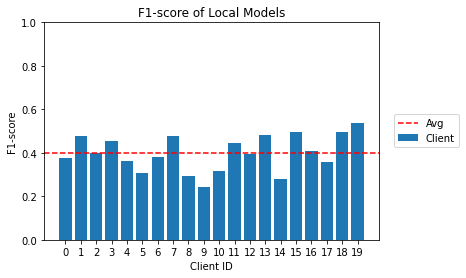

In [ ]:
plot_performance_of_local_models(precision_recall_fscores_of_local_aggregated_models, avg_local_aggregated_model_precision_recall_fscore)

In [ ]:
print_measures_of_dispersion(precision_recall_fscores_of_local_aggregated_models)

Variance of F1-score across local models: 0.006497859817656218
Standard Deviation of F1-score across local models: 0.08060930354280589


No handles with labels found to put in legend.


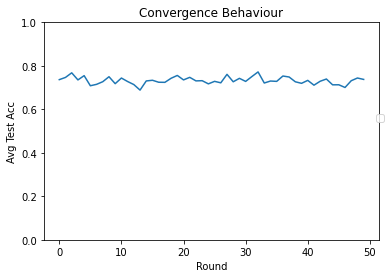

In [ ]:
plot_convergence_behaviour_from_federated_evaluation(federated_test_accs)

In [ ]:
get_utility_measure_on_distributions(avg_local_aggregated_model_precision_recall_fscore, avg_local_model_precision_recall_fscore)

Distribution                            Precision       Recall       F1-score  \
                                            Aggr. Local  Aggr. Local    Aggr.   
noniid-quantity-based-label-imbalance-2      0.54  0.51   0.35  0.53      0.4   

Distribution                                   
                                        Local  
noniid-quantity-based-label-imbalance-2  0.51

In [ ]:
# Overrides to global experiment config
DATA_PARTITIONING_STRATEGY = "noniid-quantity-based-label-imbalance-1"

In [ ]:
# Split client part of train set into NUMBER_OF_CLIENTS partitions.
partitioned_train_set = get_train_partitions(X_train, y_train.to_numpy())

In [ ]:
# Split test set into NUMBER_OF_CLIENTS partitions.
partitioned_test_set = get_test_partitions(X_test, y_test.to_numpy())

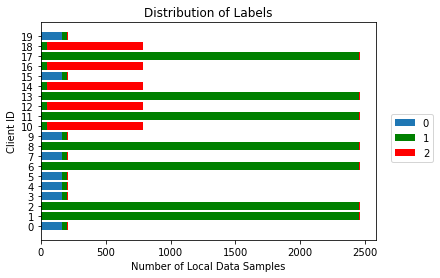

In [ ]:
plot_distribution_of_labels(partitioned_train_set)

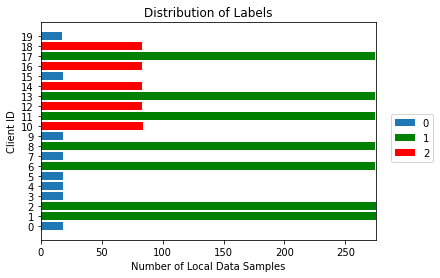

In [ ]:
plot_distribution_of_labels(partitioned_test_set)

In [ ]:
# Evaluate local models
local_models_y_preds = evaluate_local_models(partitioned_train_set, partitioned_test_set)

In [ ]:
local_models_y_test = [y_test_partition for X_test_partition, y_test_partition in partitioned_test_set]

In [ ]:
precision_recall_fscores_of_local_models = get_precision_recall_fscores_of_local_models(local_models_y_test, local_models_y_preds)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMe

In [ ]:
avg_local_model_precision_recall_fscore = get_mean_precision_recall_fscores_of_local_models(precision_recall_fscores_of_local_models)

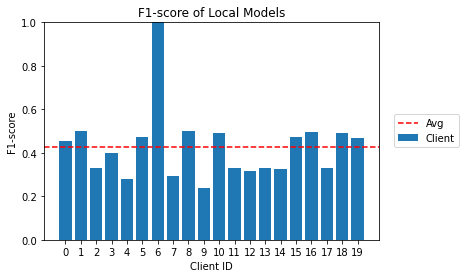

In [ ]:
plot_performance_of_local_models(precision_recall_fscores_of_local_models, avg_local_model_precision_recall_fscore)

In [ ]:
print_measures_of_dispersion(precision_recall_fscores_of_local_models)

Variance of F1-score across local models: 0.02467956962934798
Standard Deviation of F1-score across local models: 0.15709732534116544


In [ ]:
# Run sim with global config
sim_results = run_sim(partitioned_train_set, partitioned_test_set)

INFO flower 2022-03-16 00:32:10,152 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-03-16 00:32:10,154 | server.py:128 | Initializing global parameters
INFO flower 2022-03-16 00:32:10,155 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 7856


INFO flower 2022-03-16 00:32:12,154 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-16 00:32:12,156 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-16 00:32:12,159 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-03-16 00:32:12,162 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-03-16 00:32:12,163 | server.py:130 | Evaluating initial parameters
INFO flower 2022-03-16 00:32:12,165 | server.py:143 | FL starting


initializing Client1 with pid 7891


INFO flower 2022-03-16 00:32:13,168 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-16 00:32:13,170 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-16 00:32:13,172 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 7921


INFO flower 2022-03-16 00:32:14,189 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-16 00:32:14,192 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-16 00:32:14,194 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 7955


INFO flower 2022-03-16 00:32:15,200 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-16 00:32:15,203 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-16 00:32:15,205 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 7989


INFO flower 2022-03-16 00:32:16,231 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-16 00:32:16,233 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-16 00:32:16,236 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 8026


INFO flower 2022-03-16 00:32:17,254 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-16 00:32:17,257 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-16 00:32:17,259 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 8064


INFO flower 2022-03-16 00:32:18,277 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-16 00:32:18,279 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-16 00:32:18,281 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 8104


INFO flower 2022-03-16 00:32:19,301 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-16 00:32:19,304 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-16 00:32:19,306 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 8146


INFO flower 2022-03-16 00:32:20,322 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-16 00:32:20,324 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-16 00:32:20,326 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 8190


INFO flower 2022-03-16 00:32:21,334 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-16 00:32:21,337 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-16 00:32:21,340 | connection.py:39 | ChannelConnectivity.READY


initializing Client10 with pid 8236


INFO flower 2022-03-16 00:32:22,359 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-16 00:32:22,362 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-16 00:32:22,365 | connection.py:39 | ChannelConnectivity.READY


initializing Client11 with pid 8285


INFO flower 2022-03-16 00:32:23,379 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-16 00:32:23,381 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-16 00:32:23,384 | connection.py:39 | ChannelConnectivity.READY


initializing Client12 with pid 8335


INFO flower 2022-03-16 00:32:24,403 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-16 00:32:24,405 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-16 00:32:24,407 | connection.py:39 | ChannelConnectivity.READY


initializing Client13 with pid 8389


INFO flower 2022-03-16 00:32:25,426 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-16 00:32:25,430 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-16 00:32:25,431 | connection.py:39 | ChannelConnectivity.READY


initializing Client14 with pid 8443


INFO flower 2022-03-16 00:32:26,446 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-16 00:32:26,448 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-16 00:32:26,451 | connection.py:39 | ChannelConnectivity.READY


initializing Client15 with pid 8499


INFO flower 2022-03-16 00:32:27,470 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-16 00:32:27,473 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-16 00:32:27,475 | connection.py:39 | ChannelConnectivity.READY


initializing Client16 with pid 8557


INFO flower 2022-03-16 00:32:28,492 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-16 00:32:28,495 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-16 00:32:28,497 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-03-16 00:32:28,499 | connection.py:39 | ChannelConnectivity.READY


initializing Client17 with pid 8619


INFO flower 2022-03-16 00:32:29,517 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-16 00:32:29,520 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-16 00:32:29,523 | connection.py:39 | ChannelConnectivity.READY


initializing Client18 with pid 8681


INFO flower 2022-03-16 00:32:30,536 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-16 00:32:30,539 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-16 00:32:30,541 | connection.py:39 | ChannelConnectivity.READY


initializing Client19 with pid 8745


INFO flower 2022-03-16 00:32:31,560 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-03-16 00:32:31,563 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-03-16 00:32:31,564 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)
DEBUG flower 2022-03-16 00:32:31,565 | connection.py:39 | ChannelConnectivity.READY


Client2 with pid 7921 is sampled in training rnd 1
Client8 with pid 8146 is sampled in training rnd 1
Client18 with pid 8681 is sampled in training rnd 1
Client3 with pid 7955 is sampled in training rnd 1
Client7 with pid 8104 is sampled in training rnd 1
Client13 with pid 8389 is sampled in training rnd 1
Client12 with pid 8335 is sampled in training rnd 1
Client6 with pid 8064 is sampled in training rnd 1
Client16 with pid 8557 is sampled in training rnd 1
Client0 with pid 7856 is sampled in training rnd 1
Client15 with pid 8499 is sampled in training rnd 1
Client14 with pid 8443 is sampled in training rnd 1
Client1 with pid 7891 is sampled in training rnd 1
Client10 with pid 8236 is sampled in training rnd 1


DEBUG flower 2022-03-16 00:32:32,695 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:32:32,737 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client12 with pid 8335 is sampled in evaluation rnd 1
Client13 with pid 8389 is sampled in evaluation rnd 1
Client14 with pid 8443 is sampled in evaluation rnd 1
Client0 with pid 7856 is sampled in evaluation rnd 1
Client8 with pid 8146 is sampled in evaluation rnd 1
Client11 with pid 8285 is sampled in evaluation rnd 1
Client19 with pid 8745 is sampled in evaluation rnd 1
Client9 with pid 8190 is sampled in evaluation rnd 1
Client1 with pid 7891 is sampled in evaluation rnd 1
Client5 with pid 8026 is sampled in evaluation rnd 1
Client17 with pid 8619 is sampled in evaluation rnd 1
Client3 with pid 7955 is sampled in evaluation rnd 1
Client15 with pid 8499 is sampled in evaluation rnd 1
Client7 with pid 8104 is sampled in evaluation rnd 1
Client16 with pid 8557 is sampled in evaluation rnd 1
Client4 with pid 7989 is sampled in evaluation rnd 1
Client6 with pid 8064 is sampled in evaluation rnd 1
Client2 with pid 7921 is sampled in evaluation rnd 1
Client10 with pid 8236 is sampled in e

DEBUG flower 2022-03-16 00:32:33,274 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:32:33,289 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client7 with pid 8104 is sampled in training rnd 2
Client0 with pid 7856 is sampled in training rnd 2
Client14 with pid 8443 is sampled in training rnd 2
Client16 with pid 8557 is sampled in training rnd 2
Client15 with pid 8499 is sampled in training rnd 2
Client8 with pid 8146 is sampled in training rnd 2
Client3 with pid 7955 is sampled in training rnd 2
Client5 with pid 8026 is sampled in training rnd 2
Client13 with pid 8389 is sampled in training rnd 2
Client10 with pid 8236 is sampled in training rnd 2
Client11 with pid 8285 is sampled in training rnd 2
Client17 with pid 8619 is sampled in training rnd 2
Client4 with pid 7989 is sampled in training rnd 2
Client19 with pid 8745 is sampled in training rnd 2


DEBUG flower 2022-03-16 00:32:34,440 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:32:34,469 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client17 with pid 8619 is sampled in evaluation rnd 2
Client13 with pid 8389 is sampled in evaluation rnd 2
Client5 with pid 8026 is sampled in evaluation rnd 2
Client3 with pid 7955 is sampled in evaluation rnd 2
Client1 with pid 7891 is sampled in evaluation rnd 2
Client16 with pid 8557 is sampled in evaluation rnd 2
Client11 with pid 8285 is sampled in evaluation rnd 2
Client8 with pid 8146 is sampled in evaluation rnd 2
Client19 with pid 8745 is sampled in evaluation rnd 2
Client9 with pid 8190 is sampled in evaluation rnd 2
Client6 with pid 8064 is sampled in evaluation rnd 2
Client10 with pid 8236 is sampled in evaluation rnd 2
Client2 with pid 7921 is sampled in evaluation rnd 2
Client15 with pid 8499 is sampled in evaluation rnd 2
Client18 with pid 8681 is sampled in evaluation rnd 2
Client4 with pid 7989 is sampled in evaluation rnd 2
Client7 with pid 8104 is sampled in evaluation rnd 2
Client12 with pid 8335 is sampled in evaluation rnd 2
Client14 with pid 8443 is sampled in 

DEBUG flower 2022-03-16 00:32:34,721 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:32:34,726 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client15 with pid 8499 is sampled in training rnd 3
Client13 with pid 8389 is sampled in training rnd 3
Client12 with pid 8335 is sampled in training rnd 3
Client5 with pid 8026 is sampled in training rnd 3
Client7 with pid 8104 is sampled in training rnd 3
Client19 with pid 8745 is sampled in training rnd 3
Client8 with pid 8146 is sampled in training rnd 3
Client11 with pid 8285 is sampled in training rnd 3
Client10 with pid 8236 is sampled in training rnd 3
Client14 with pid 8443 is sampled in training rnd 3
Client1 with pid 7891 is sampled in training rnd 3
Client18 with pid 8681 is sampled in training rnd 3
Client9 with pid 8190 is sampled in training rnd 3
Client6 with pid 8064 is sampled in training rnd 3


DEBUG flower 2022-03-16 00:32:36,004 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:32:36,036 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client5 with pid 8026 is sampled in evaluation rnd 3
Client12 with pid 8335 is sampled in evaluation rnd 3
Client11 with pid 8285 is sampled in evaluation rnd 3
Client16 with pid 8557 is sampled in evaluation rnd 3
Client15 with pid 8499 is sampled in evaluation rnd 3
Client7 with pid 8104 is sampled in evaluation rnd 3
Client0 with pid 7856 is sampled in evaluation rnd 3
Client18 with pid 8681 is sampled in evaluation rnd 3
Client4 with pid 7989 is sampled in evaluation rnd 3
Client13 with pid 8389 is sampled in evaluation rnd 3
Client6 with pid 8064 is sampled in evaluation rnd 3
Client9 with pid 8190 is sampled in evaluation rnd 3
Client2 with pid 7921 is sampled in evaluation rnd 3
Client10 with pid 8236 is sampled in evaluation rnd 3
Client1 with pid 7891 is sampled in evaluation rnd 3
Client8 with pid 8146 is sampled in evaluation rnd 3
Client14 with pid 8443 is sampled in evaluation rnd 3
Client3 with pid 7955 is sampled in evaluation rnd 3
Client17 with pid 8619 is sampled in e

DEBUG flower 2022-03-16 00:32:36,279 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:32:36,285 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client16 with pid 8557 is sampled in training rnd 4
Client11 with pid 8285 is sampled in training rnd 4
Client18 with pid 8681 is sampled in training rnd 4
Client14 with pid 8443 is sampled in training rnd 4
Client8 with pid 8146 is sampled in training rnd 4
Client15 with pid 8499 is sampled in training rnd 4
Client9 with pid 8190 is sampled in training rnd 4
Client10 with pid 8236 is sampled in training rnd 4
Client17 with pid 8619 is sampled in training rnd 4
Client0 with pid 7856 is sampled in training rnd 4
Client6 with pid 8064 is sampled in training rnd 4
Client13 with pid 8389 is sampled in training rnd 4
Client2 with pid 7921 is sampled in training rnd 4
Client4 with pid 7989 is sampled in training rnd 4


DEBUG flower 2022-03-16 00:32:37,620 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:32:37,648 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client17 with pid 8619 is sampled in evaluation rnd 4
Client6 with pid 8064 is sampled in evaluation rnd 4
Client13 with pid 8389 is sampled in evaluation rnd 4
Client15 with pid 8499 is sampled in evaluation rnd 4
Client1 with pid 7891 is sampled in evaluation rnd 4
Client19 with pid 8745 is sampled in evaluation rnd 4
Client5 with pid 8026 is sampled in evaluation rnd 4
Client9 with pid 8190 is sampled in evaluation rnd 4
Client8 with pid 8146 is sampled in evaluation rnd 4
Client3 with pid 7955 is sampled in evaluation rnd 4
Client11 with pid 8285 is sampled in evaluation rnd 4
Client18 with pid 8681 is sampled in evaluation rnd 4
Client7 with pid 8104 is sampled in evaluation rnd 4
Client12 with pid 8335 is sampled in evaluation rnd 4
Client2 with pid 7921 is sampled in evaluation rnd 4
Client10 with pid 8236 is sampled in evaluation rnd 4
Client4 with pid 7989 is sampled in evaluation rnd 4
Client0 with pid 7856 is sampled in evaluation rnd 4
Client16 with pid 8557 is sampled in e

DEBUG flower 2022-03-16 00:32:37,919 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:32:37,927 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client19 with pid 8745 is sampled in training rnd 5
Client0 with pid 7856 is sampled in training rnd 5
Client7 with pid 8104 is sampled in training rnd 5
Client16 with pid 8557 is sampled in training rnd 5
Client5 with pid 8026 is sampled in training rnd 5
Client13 with pid 8389 is sampled in training rnd 5
Client1 with pid 7891 is sampled in training rnd 5
Client8 with pid 8146 is sampled in training rnd 5
Client4 with pid 7989 is sampled in training rnd 5
Client12 with pid 8335 is sampled in training rnd 5
Client14 with pid 8443 is sampled in training rnd 5
Client18 with pid 8681 is sampled in training rnd 5
Client11 with pid 8285 is sampled in training rnd 5
Client6 with pid 8064 is sampled in training rnd 5


DEBUG flower 2022-03-16 00:32:39,177 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:32:39,204 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client0 with pid 7856 is sampled in evaluation rnd 5
Client8 with pid 8146 is sampled in evaluation rnd 5
Client14 with pid 8443 is sampled in evaluation rnd 5
Client7 with pid 8104 is sampled in evaluation rnd 5
Client19 with pid 8745 is sampled in evaluation rnd 5
Client4 with pid 7989 is sampled in evaluation rnd 5
Client12 with pid 8335 is sampled in evaluation rnd 5
Client1 with pid 7891 is sampled in evaluation rnd 5
Client9 with pid 8190 is sampled in evaluation rnd 5
Client2 with pid 7921 is sampled in evaluation rnd 5
Client5 with pid 8026 is sampled in evaluation rnd 5
Client18 with pid 8681 is sampled in evaluation rnd 5
Client15 with pid 8499 is sampled in evaluation rnd 5
Client13 with pid 8389 is sampled in evaluation rnd 5
Client6 with pid 8064 is sampled in evaluation rnd 5
Client11 with pid 8285 is sampled in evaluation rnd 5
Client3 with pid 7955 is sampled in evaluation rnd 5
Client10 with pid 8236 is sampled in evaluation rnd 5
Client17 with pid 8619 is sampled in e

DEBUG flower 2022-03-16 00:32:39,438 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:32:39,460 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client15 with pid 8499 is sampled in training rnd 6
Client14 with pid 8443 is sampled in training rnd 6
Client10 with pid 8236 is sampled in training rnd 6
Client17 with pid 8619 is sampled in training rnd 6
Client3 with pid 7955 is sampled in training rnd 6
Client4 with pid 7989 is sampled in training rnd 6
Client0 with pid 7856 is sampled in training rnd 6
Client6 with pid 8064 is sampled in training rnd 6
Client5 with pid 8026 is sampled in training rnd 6
Client12 with pid 8335 is sampled in training rnd 6
Client16 with pid 8557 is sampled in training rnd 6
Client1 with pid 7891 is sampled in training rnd 6
Client2 with pid 7921 is sampled in training rnd 6
Client13 with pid 8389 is sampled in training rnd 6


DEBUG flower 2022-03-16 00:32:40,703 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:32:40,720 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client6 with pid 8064 is sampled in evaluation rnd 6
Client16 with pid 8557 is sampled in evaluation rnd 6
Client13 with pid 8389 is sampled in evaluation rnd 6
Client19 with pid 8745 is sampled in evaluation rnd 6
Client18 with pid 8681 is sampled in evaluation rnd 6
Client0 with pid 7856 is sampled in evaluation rnd 6
Client2 with pid 7921 is sampled in evaluation rnd 6
Client7 with pid 8104 is sampled in evaluation rnd 6
Client14 with pid 8443 is sampled in evaluation rnd 6
Client15 with pid 8499 is sampled in evaluation rnd 6
Client12 with pid 8335 is sampled in evaluation rnd 6
Client8 with pid 8146 is sampled in evaluation rnd 6
Client17 with pid 8619 is sampled in evaluation rnd 6
Client4 with pid 7989 is sampled in evaluation rnd 6
Client10 with pid 8236 is sampled in evaluation rnd 6
Client11 with pid 8285 is sampled in evaluation rnd 6
Client9 with pid 8190 is sampled in evaluation rnd 6
Client1 with pid 7891 is sampled in evaluation rnd 6
Client3 with pid 7955 is sampled in 

DEBUG flower 2022-03-16 00:32:40,991 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:32:41,005 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client10 with pid 8236 is sampled in training rnd 7
Client18 with pid 8681 is sampled in training rnd 7
Client13 with pid 8389 is sampled in training rnd 7
Client1 with pid 7891 is sampled in training rnd 7
Client2 with pid 7921 is sampled in training rnd 7
Client9 with pid 8190 is sampled in training rnd 7
Client3 with pid 7955 is sampled in training rnd 7
Client0 with pid 7856 is sampled in training rnd 7
Client16 with pid 8557 is sampled in training rnd 7
Client4 with pid 7989 is sampled in training rnd 7
Client19 with pid 8745 is sampled in training rnd 7
Client11 with pid 8285 is sampled in training rnd 7
Client8 with pid 8146 is sampled in training rnd 7
Client5 with pid 8026 is sampled in training rnd 7


DEBUG flower 2022-03-16 00:32:42,338 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:32:42,364 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client5 with pid 8026 is sampled in evaluation rnd 7
Client8 with pid 8146 is sampled in evaluation rnd 7
Client13 with pid 8389 is sampled in evaluation rnd 7
Client4 with pid 7989 is sampled in evaluation rnd 7
Client17 with pid 8619 is sampled in evaluation rnd 7
Client0 with pid 7856 is sampled in evaluation rnd 7
Client18 with pid 8681 is sampled in evaluation rnd 7
Client15 with pid 8499 is sampled in evaluation rnd 7
Client9 with pid 8190 is sampled in evaluation rnd 7
Client3 with pid 7955 is sampled in evaluation rnd 7
Client11 with pid 8285 is sampled in evaluation rnd 7
Client6 with pid 8064 is sampled in evaluation rnd 7
Client2 with pid 7921 is sampled in evaluation rnd 7
Client7 with pid 8104 is sampled in evaluation rnd 7
Client19 with pid 8745 is sampled in evaluation rnd 7
Client1 with pid 7891 is sampled in evaluation rnd 7
Client10 with pid 8236 is sampled in evaluation rnd 7
Client12 with pid 8335 is sampled in evaluation rnd 7
Client16 with pid 8557 is sampled in e

DEBUG flower 2022-03-16 00:32:42,629 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:32:42,649 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client6 with pid 8064 is sampled in training rnd 8
Client3 with pid 7955 is sampled in training rnd 8
Client13 with pid 8389 is sampled in training rnd 8
Client1 with pid 7891 is sampled in training rnd 8
Client15 with pid 8499 is sampled in training rnd 8
Client18 with pid 8681 is sampled in training rnd 8
Client10 with pid 8236 is sampled in training rnd 8
Client16 with pid 8557 is sampled in training rnd 8
Client4 with pid 7989 is sampled in training rnd 8
Client8 with pid 8146 is sampled in training rnd 8
Client7 with pid 8104 is sampled in training rnd 8
Client0 with pid 7856 is sampled in training rnd 8
Client5 with pid 8026 is sampled in training rnd 8
Client11 with pid 8285 is sampled in training rnd 8


DEBUG flower 2022-03-16 00:32:43,909 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:32:43,934 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client12 with pid 8335 is sampled in evaluation rnd 8
Client9 with pid 8190 is sampled in evaluation rnd 8
Client5 with pid 8026 is sampled in evaluation rnd 8
Client0 with pid 7856 is sampled in evaluation rnd 8
Client6 with pid 8064 is sampled in evaluation rnd 8
Client19 with pid 8745 is sampled in evaluation rnd 8
Client16 with pid 8557 is sampled in evaluation rnd 8
Client13 with pid 8389 is sampled in evaluation rnd 8
Client2 with pid 7921 is sampled in evaluation rnd 8
Client14 with pid 8443 is sampled in evaluation rnd 8
Client18 with pid 8681 is sampled in evaluation rnd 8
Client17 with pid 8619 is sampled in evaluation rnd 8
Client10 with pid 8236 is sampled in evaluation rnd 8
Client15 with pid 8499 is sampled in evaluation rnd 8
Client7 with pid 8104 is sampled in evaluation rnd 8
Client11 with pid 8285 is sampled in evaluation rnd 8
Client8 with pid 8146 is sampled in evaluation rnd 8
Client1 with pid 7891 is sampled in evaluation rnd 8
Client4 with pid 7989 is sampled in 

DEBUG flower 2022-03-16 00:32:44,166 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:32:44,171 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client2 with pid 7921 is sampled in training rnd 9
Client7 with pid 8104 is sampled in training rnd 9
Client17 with pid 8619 is sampled in training rnd 9
Client1 with pid 7891 is sampled in training rnd 9
Client15 with pid 8499 is sampled in training rnd 9
Client19 with pid 8745 is sampled in training rnd 9
Client14 with pid 8443 is sampled in training rnd 9
Client8 with pid 8146 is sampled in training rnd 9
Client13 with pid 8389 is sampled in training rnd 9
Client3 with pid 7955 is sampled in training rnd 9
Client4 with pid 7989 is sampled in training rnd 9
Client5 with pid 8026 is sampled in training rnd 9
Client9 with pid 8190 is sampled in training rnd 9
Client12 with pid 8335 is sampled in training rnd 9


DEBUG flower 2022-03-16 00:32:45,430 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:32:45,458 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client10 with pid 8236 is sampled in evaluation rnd 9
Client19 with pid 8745 is sampled in evaluation rnd 9
Client9 with pid 8190 is sampled in evaluation rnd 9
Client3 with pid 7955 is sampled in evaluation rnd 9
Client13 with pid 8389 is sampled in evaluation rnd 9
Client12 with pid 8335 is sampled in evaluation rnd 9
Client16 with pid 8557 is sampled in evaluation rnd 9
Client7 with pid 8104 is sampled in evaluation rnd 9
Client11 with pid 8285 is sampled in evaluation rnd 9
Client15 with pid 8499 is sampled in evaluation rnd 9
Client8 with pid 8146 is sampled in evaluation rnd 9
Client2 with pid 7921 is sampled in evaluation rnd 9
Client14 with pid 8443 is sampled in evaluation rnd 9
Client1 with pid 7891 is sampled in evaluation rnd 9
Client0 with pid 7856 is sampled in evaluation rnd 9
Client17 with pid 8619 is sampled in evaluation rnd 9
Client5 with pid 8026 is sampled in evaluation rnd 9
Client4 with pid 7989 is sampled in evaluation rnd 9
Client18 with pid 8681 is sampled in 

DEBUG flower 2022-03-16 00:32:45,717 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:32:45,718 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client10 with pid 8236 is sampled in training rnd 10
Client3 with pid 7955 is sampled in training rnd 10
Client12 with pid 8335 is sampled in training rnd 10
Client2 with pid 7921 is sampled in training rnd 10
Client7 with pid 8104 is sampled in training rnd 10
Client9 with pid 8190 is sampled in training rnd 10
Client1 with pid 7891 is sampled in training rnd 10
Client4 with pid 7989 is sampled in training rnd 10
Client5 with pid 8026 is sampled in training rnd 10
Client17 with pid 8619 is sampled in training rnd 10
Client14 with pid 8443 is sampled in training rnd 10
Client8 with pid 8146 is sampled in training rnd 10
Client13 with pid 8389 is sampled in training rnd 10
Client18 with pid 8681 is sampled in training rnd 10


DEBUG flower 2022-03-16 00:32:47,012 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:32:47,027 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client8 with pid 8146 is sampled in evaluation rnd 10
Client1 with pid 7891 is sampled in evaluation rnd 10
Client16 with pid 8557 is sampled in evaluation rnd 10
Client0 with pid 7856 is sampled in evaluation rnd 10
Client10 with pid 8236 is sampled in evaluation rnd 10
Client9 with pid 8190 is sampled in evaluation rnd 10
Client3 with pid 7955 is sampled in evaluation rnd 10
Client15 with pid 8499 is sampled in evaluation rnd 10
Client6 with pid 8064 is sampled in evaluation rnd 10
Client12 with pid 8335 is sampled in evaluation rnd 10
Client17 with pid 8619 is sampled in evaluation rnd 10
Client11 with pid 8285 is sampled in evaluation rnd 10
Client18 with pid 8681 is sampled in evaluation rnd 10
Client14 with pid 8443 is sampled in evaluation rnd 10
Client4 with pid 7989 is sampled in evaluation rnd 10
Client7 with pid 8104 is sampled in evaluation rnd 10
Client13 with pid 8389 is sampled in evaluation rnd 10
Client19 with pid 8745 is sampled in evaluation rnd 10
Client5 with pid 8

DEBUG flower 2022-03-16 00:32:47,325 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:32:47,332 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client3 with pid 7955 is sampled in training rnd 11
Client7 with pid 8104 is sampled in training rnd 11
Client5 with pid 8026 is sampled in training rnd 11
Client13 with pid 8389 is sampled in training rnd 11
Client15 with pid 8499 is sampled in training rnd 11
Client12 with pid 8335 is sampled in training rnd 11
Client8 with pid 8146 is sampled in training rnd 11
Client4 with pid 7989 is sampled in training rnd 11
Client16 with pid 8557 is sampled in training rnd 11
Client14 with pid 8443 is sampled in training rnd 11
Client18 with pid 8681 is sampled in training rnd 11
Client19 with pid 8745 is sampled in training rnd 11
Client1 with pid 7891 is sampled in training rnd 11
Client9 with pid 8190 is sampled in training rnd 11


DEBUG flower 2022-03-16 00:32:48,421 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:32:48,444 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client10 with pid 8236 is sampled in evaluation rnd 11
Client0 with pid 7856 is sampled in evaluation rnd 11
Client1 with pid 7891 is sampled in evaluation rnd 11
Client9 with pid 8190 is sampled in evaluation rnd 11
Client17 with pid 8619 is sampled in evaluation rnd 11
Client15 with pid 8499 is sampled in evaluation rnd 11
Client5 with pid 8026 is sampled in evaluation rnd 11
Client11 with pid 8285 is sampled in evaluation rnd 11
Client7 with pid 8104 is sampled in evaluation rnd 11
Client6 with pid 8064 is sampled in evaluation rnd 11
Client18 with pid 8681 is sampled in evaluation rnd 11
Client12 with pid 8335 is sampled in evaluation rnd 11
Client16 with pid 8557 is sampled in evaluation rnd 11
Client2 with pid 7921 is sampled in evaluation rnd 11
Client4 with pid 7989 is sampled in evaluation rnd 11
Client19 with pid 8745 is sampled in evaluation rnd 11
Client3 with pid 7955 is sampled in evaluation rnd 11
Client8 with pid 8146 is sampled in evaluation rnd 11
Client13 with pid 83

DEBUG flower 2022-03-16 00:32:48,744 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:32:48,769 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client19 with pid 8745 is sampled in training rnd 12
Client17 with pid 8619 is sampled in training rnd 12
Client15 with pid 8499 is sampled in training rnd 12
Client11 with pid 8285 is sampled in training rnd 12
Client8 with pid 8146 is sampled in training rnd 12
Client18 with pid 8681 is sampled in training rnd 12
Client3 with pid 7955 is sampled in training rnd 12
Client4 with pid 7989 is sampled in training rnd 12
Client2 with pid 7921 is sampled in training rnd 12
Client12 with pid 8335 is sampled in training rnd 12
Client10 with pid 8236 is sampled in training rnd 12
Client5 with pid 8026 is sampled in training rnd 12
Client1 with pid 7891 is sampled in training rnd 12
Client6 with pid 8064 is sampled in training rnd 12


DEBUG flower 2022-03-16 00:32:50,095 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:32:50,119 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client8 with pid 8146 is sampled in evaluation rnd 12
Client2 with pid 7921 is sampled in evaluation rnd 12
Client18 with pid 8681 is sampled in evaluation rnd 12
Client4 with pid 7989 is sampled in evaluation rnd 12
Client14 with pid 8443 is sampled in evaluation rnd 12
Client10 with pid 8236 is sampled in evaluation rnd 12
Client0 with pid 7856 is sampled in evaluation rnd 12
Client6 with pid 8064 is sampled in evaluation rnd 12
Client5 with pid 8026 is sampled in evaluation rnd 12
Client3 with pid 7955 is sampled in evaluation rnd 12
Client16 with pid 8557 is sampled in evaluation rnd 12
Client12 with pid 8335 is sampled in evaluation rnd 12
Client1 with pid 7891 is sampled in evaluation rnd 12
Client15 with pid 8499 is sampled in evaluation rnd 12
Client7 with pid 8104 is sampled in evaluation rnd 12
Client9 with pid 8190 is sampled in evaluation rnd 12
Client11 with pid 8285 is sampled in evaluation rnd 12
Client17 with pid 8619 is sampled in evaluation rnd 12
Client19 with pid 87

DEBUG flower 2022-03-16 00:32:50,381 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:32:50,385 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client2 with pid 7921 is sampled in training rnd 13
Client7 with pid 8104 is sampled in training rnd 13
Client12 with pid 8335 is sampled in training rnd 13
Client8 with pid 8146 is sampled in training rnd 13
Client11 with pid 8285 is sampled in training rnd 13
Client17 with pid 8619 is sampled in training rnd 13
Client1 with pid 7891 is sampled in training rnd 13
Client0 with pid 7856 is sampled in training rnd 13
Client10 with pid 8236 is sampled in training rnd 13
Client18 with pid 8681 is sampled in training rnd 13
Client4 with pid 7989 is sampled in training rnd 13
Client5 with pid 8026 is sampled in training rnd 13
Client19 with pid 8745 is sampled in training rnd 13
Client3 with pid 7955 is sampled in training rnd 13


DEBUG flower 2022-03-16 00:32:51,588 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:32:51,614 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client4 with pid 7989 is sampled in evaluation rnd 13
Client3 with pid 7955 is sampled in evaluation rnd 13
Client10 with pid 8236 is sampled in evaluation rnd 13
Client16 with pid 8557 is sampled in evaluation rnd 13
Client2 with pid 7921 is sampled in evaluation rnd 13
Client17 with pid 8619 is sampled in evaluation rnd 13
Client8 with pid 8146 is sampled in evaluation rnd 13
Client15 with pid 8499 is sampled in evaluation rnd 13
Client13 with pid 8389 is sampled in evaluation rnd 13
Client12 with pid 8335 is sampled in evaluation rnd 13
Client11 with pid 8285 is sampled in evaluation rnd 13
Client5 with pid 8026 is sampled in evaluation rnd 13
Client19 with pid 8745 is sampled in evaluation rnd 13
Client0 with pid 7856 is sampled in evaluation rnd 13
Client14 with pid 8443 is sampled in evaluation rnd 13
Client9 with pid 8190 is sampled in evaluation rnd 13
Client7 with pid 8104 is sampled in evaluation rnd 13
Client6 with pid 8064 is sampled in evaluation rnd 13
Client1 with pid 78

DEBUG flower 2022-03-16 00:32:51,907 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:32:51,931 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client1 with pid 7891 is sampled in training rnd 14
Client17 with pid 8619 is sampled in training rnd 14
Client10 with pid 8236 is sampled in training rnd 14
Client6 with pid 8064 is sampled in training rnd 14
Client5 with pid 8026 is sampled in training rnd 14
Client4 with pid 7989 is sampled in training rnd 14
Client16 with pid 8557 is sampled in training rnd 14
Client8 with pid 8146 is sampled in training rnd 14
Client2 with pid 7921 is sampled in training rnd 14
Client0 with pid 7856 is sampled in training rnd 14
Client3 with pid 7955 is sampled in training rnd 14
Client14 with pid 8443 is sampled in training rnd 14
Client18 with pid 8681 is sampled in training rnd 14
Client15 with pid 8499 is sampled in training rnd 14


DEBUG flower 2022-03-16 00:32:53,143 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:32:53,169 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client14 with pid 8443 is sampled in evaluation rnd 14
Client13 with pid 8389 is sampled in evaluation rnd 14
Client17 with pid 8619 is sampled in evaluation rnd 14
Client19 with pid 8745 is sampled in evaluation rnd 14
Client18 with pid 8681 is sampled in evaluation rnd 14
Client8 with pid 8146 is sampled in evaluation rnd 14
Client16 with pid 8557 is sampled in evaluation rnd 14
Client7 with pid 8104 is sampled in evaluation rnd 14
Client0 with pid 7856 is sampled in evaluation rnd 14
Client6 with pid 8064 is sampled in evaluation rnd 14
Client5 with pid 8026 is sampled in evaluation rnd 14
Client2 with pid 7921 is sampled in evaluation rnd 14
Client4 with pid 7989 is sampled in evaluation rnd 14
Client3 with pid 7955 is sampled in evaluation rnd 14
Client10 with pid 8236 is sampled in evaluation rnd 14
Client11 with pid 8285 is sampled in evaluation rnd 14
Client9 with pid 8190 is sampled in evaluation rnd 14
Client15 with pid 8499 is sampled in evaluation rnd 14
Client1 with pid 78

DEBUG flower 2022-03-16 00:32:53,490 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:32:53,499 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client18 with pid 8681 is sampled in training rnd 15
Client4 with pid 7989 is sampled in training rnd 15
Client19 with pid 8745 is sampled in training rnd 15
Client8 with pid 8146 is sampled in training rnd 15
Client6 with pid 8064 is sampled in training rnd 15
Client16 with pid 8557 is sampled in training rnd 15
Client9 with pid 8190 is sampled in training rnd 15
Client2 with pid 7921 is sampled in training rnd 15
Client14 with pid 8443 is sampled in training rnd 15
Client13 with pid 8389 is sampled in training rnd 15
Client1 with pid 7891 is sampled in training rnd 15
Client3 with pid 7955 is sampled in training rnd 15
Client7 with pid 8104 is sampled in training rnd 15
Client0 with pid 7856 is sampled in training rnd 15


DEBUG flower 2022-03-16 00:32:54,743 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:32:54,775 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client5 with pid 8026 is sampled in evaluation rnd 15
Client16 with pid 8557 is sampled in evaluation rnd 15
Client10 with pid 8236 is sampled in evaluation rnd 15
Client18 with pid 8681 is sampled in evaluation rnd 15
Client14 with pid 8443 is sampled in evaluation rnd 15
Client17 with pid 8619 is sampled in evaluation rnd 15
Client15 with pid 8499 is sampled in evaluation rnd 15
Client11 with pid 8285 is sampled in evaluation rnd 15
Client13 with pid 8389 is sampled in evaluation rnd 15
Client12 with pid 8335 is sampled in evaluation rnd 15
Client3 with pid 7955 is sampled in evaluation rnd 15
Client7 with pid 8104 is sampled in evaluation rnd 15
Client19 with pid 8745 is sampled in evaluation rnd 15
Client9 with pid 8190 is sampled in evaluation rnd 15
Client8 with pid 8146 is sampled in evaluation rnd 15
Client6 with pid 8064 is sampled in evaluation rnd 15
Client1 with pid 7891 is sampled in evaluation rnd 15
Client4 with pid 7989 is sampled in evaluation rnd 15
Client2 with pid 7

DEBUG flower 2022-03-16 00:32:55,085 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:32:55,102 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client2 with pid 7921 is sampled in training rnd 16
Client16 with pid 8557 is sampled in training rnd 16
Client1 with pid 7891 is sampled in training rnd 16
Client5 with pid 8026 is sampled in training rnd 16
Client8 with pid 8146 is sampled in training rnd 16
Client11 with pid 8285 is sampled in training rnd 16
Client12 with pid 8335 is sampled in training rnd 16
Client3 with pid 7955 is sampled in training rnd 16
Client13 with pid 8389 is sampled in training rnd 16
Client4 with pid 7989 is sampled in training rnd 16
Client10 with pid 8236 is sampled in training rnd 16
Client9 with pid 8190 is sampled in training rnd 16
Client19 with pid 8745 is sampled in training rnd 16
Client15 with pid 8499 is sampled in training rnd 16


DEBUG flower 2022-03-16 00:32:56,346 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:32:56,386 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client14 with pid 8443 is sampled in evaluation rnd 16
Client16 with pid 8557 is sampled in evaluation rnd 16
Client2 with pid 7921 is sampled in evaluation rnd 16
Client3 with pid 7955 is sampled in evaluation rnd 16
Client12 with pid 8335 is sampled in evaluation rnd 16
Client18 with pid 8681 is sampled in evaluation rnd 16
Client19 with pid 8745 is sampled in evaluation rnd 16
Client4 with pid 7989 is sampled in evaluation rnd 16
Client6 with pid 8064 is sampled in evaluation rnd 16
Client7 with pid 8104 is sampled in evaluation rnd 16
Client0 with pid 7856 is sampled in evaluation rnd 16
Client9 with pid 8190 is sampled in evaluation rnd 16
Client17 with pid 8619 is sampled in evaluation rnd 16
Client5 with pid 8026 is sampled in evaluation rnd 16
Client13 with pid 8389 is sampled in evaluation rnd 16
Client15 with pid 8499 is sampled in evaluation rnd 16
Client8 with pid 8146 is sampled in evaluation rnd 16
Client10 with pid 8236 is sampled in evaluation rnd 16
Client11 with pid 8

DEBUG flower 2022-03-16 00:32:56,619 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:32:56,643 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client3 with pid 7955 is sampled in training rnd 17
Client16 with pid 8557 is sampled in training rnd 17
Client2 with pid 7921 is sampled in training rnd 17
Client8 with pid 8146 is sampled in training rnd 17
Client17 with pid 8619 is sampled in training rnd 17
Client11 with pid 8285 is sampled in training rnd 17
Client1 with pid 7891 is sampled in training rnd 17
Client18 with pid 8681 is sampled in training rnd 17
Client9 with pid 8190 is sampled in training rnd 17
Client10 with pid 8236 is sampled in training rnd 17
Client13 with pid 8389 is sampled in training rnd 17
Client7 with pid 8104 is sampled in training rnd 17
Client19 with pid 8745 is sampled in training rnd 17
Client6 with pid 8064 is sampled in training rnd 17


DEBUG flower 2022-03-16 00:32:58,105 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:32:58,131 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client12 with pid 8335 is sampled in evaluation rnd 17
Client13 with pid 8389 is sampled in evaluation rnd 17
Client7 with pid 8104 is sampled in evaluation rnd 17
Client10 with pid 8236 is sampled in evaluation rnd 17
Client5 with pid 8026 is sampled in evaluation rnd 17
Client19 with pid 8745 is sampled in evaluation rnd 17
Client2 with pid 7921 is sampled in evaluation rnd 17
Client9 with pid 8190 is sampled in evaluation rnd 17
Client14 with pid 8443 is sampled in evaluation rnd 17
Client1 with pid 7891 is sampled in evaluation rnd 17
Client3 with pid 7955 is sampled in evaluation rnd 17
Client8 with pid 8146 is sampled in evaluation rnd 17
Client6 with pid 8064 is sampled in evaluation rnd 17
Client16 with pid 8557 is sampled in evaluation rnd 17
Client0 with pid 7856 is sampled in evaluation rnd 17
Client18 with pid 8681 is sampled in evaluation rnd 17
Client15 with pid 8499 is sampled in evaluation rnd 17
Client4 with pid 7989 is sampled in evaluation rnd 17
Client17 with pid 86

DEBUG flower 2022-03-16 00:32:58,364 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:32:58,381 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client16 with pid 8557 is sampled in training rnd 18
Client6 with pid 8064 is sampled in training rnd 18
Client14 with pid 8443 is sampled in training rnd 18
Client18 with pid 8681 is sampled in training rnd 18
Client0 with pid 7856 is sampled in training rnd 18
Client10 with pid 8236 is sampled in training rnd 18
Client9 with pid 8190 is sampled in training rnd 18
Client3 with pid 7955 is sampled in training rnd 18
Client4 with pid 7989 is sampled in training rnd 18
Client12 with pid 8335 is sampled in training rnd 18
Client2 with pid 7921 is sampled in training rnd 18
Client11 with pid 8285 is sampled in training rnd 18
Client13 with pid 8389 is sampled in training rnd 18
Client8 with pid 8146 is sampled in training rnd 18


DEBUG flower 2022-03-16 00:32:59,642 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:32:59,669 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client6 with pid 8064 is sampled in evaluation rnd 18
Client8 with pid 8146 is sampled in evaluation rnd 18
Client12 with pid 8335 is sampled in evaluation rnd 18
Client18 with pid 8681 is sampled in evaluation rnd 18
Client14 with pid 8443 is sampled in evaluation rnd 18
Client13 with pid 8389 is sampled in evaluation rnd 18
Client9 with pid 8190 is sampled in evaluation rnd 18
Client15 with pid 8499 is sampled in evaluation rnd 18
Client2 with pid 7921 is sampled in evaluation rnd 18
Client16 with pid 8557 is sampled in evaluation rnd 18
Client5 with pid 8026 is sampled in evaluation rnd 18
Client19 with pid 8745 is sampled in evaluation rnd 18
Client7 with pid 8104 is sampled in evaluation rnd 18
Client3 with pid 7955 is sampled in evaluation rnd 18
Client10 with pid 8236 is sampled in evaluation rnd 18
Client0 with pid 7856 is sampled in evaluation rnd 18
Client1 with pid 7891 is sampled in evaluation rnd 18
Client17 with pid 8619 is sampled in evaluation rnd 18
Client4 with pid 79

DEBUG flower 2022-03-16 00:32:59,922 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:32:59,933 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client0 with pid 7856 is sampled in training rnd 19
Client19 with pid 8745 is sampled in training rnd 19
Client3 with pid 7955 is sampled in training rnd 19
Client9 with pid 8190 is sampled in training rnd 19
Client1 with pid 7891 is sampled in training rnd 19
Client8 with pid 8146 is sampled in training rnd 19
Client4 with pid 7989 is sampled in training rnd 19
Client5 with pid 8026 is sampled in training rnd 19
Client16 with pid 8557 is sampled in training rnd 19
Client15 with pid 8499 is sampled in training rnd 19
Client6 with pid 8064 is sampled in training rnd 19
Client13 with pid 8389 is sampled in training rnd 19
Client12 with pid 8335 is sampled in training rnd 19
Client11 with pid 8285 is sampled in training rnd 19


DEBUG flower 2022-03-16 00:33:01,144 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:33:01,171 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client16 with pid 8557 is sampled in evaluation rnd 19
Client0 with pid 7856 is sampled in evaluation rnd 19
Client10 with pid 8236 is sampled in evaluation rnd 19
Client3 with pid 7955 is sampled in evaluation rnd 19
Client11 with pid 8285 is sampled in evaluation rnd 19
Client14 with pid 8443 is sampled in evaluation rnd 19
Client7 with pid 8104 is sampled in evaluation rnd 19
Client5 with pid 8026 is sampled in evaluation rnd 19
Client8 with pid 8146 is sampled in evaluation rnd 19
Client6 with pid 8064 is sampled in evaluation rnd 19
Client12 with pid 8335 is sampled in evaluation rnd 19
Client13 with pid 8389 is sampled in evaluation rnd 19
Client17 with pid 8619 is sampled in evaluation rnd 19
Client4 with pid 7989 is sampled in evaluation rnd 19
Client18 with pid 8681 is sampled in evaluation rnd 19
Client19 with pid 8745 is sampled in evaluation rnd 19
Client15 with pid 8499 is sampled in evaluation rnd 19
Client2 with pid 7921 is sampled in evaluation rnd 19
Client9 with pid 8

DEBUG flower 2022-03-16 00:33:01,441 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:33:01,445 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client19 with pid 8745 is sampled in training rnd 20
Client16 with pid 8557 is sampled in training rnd 20
Client6 with pid 8064 is sampled in training rnd 20
Client14 with pid 8443 is sampled in training rnd 20
Client13 with pid 8389 is sampled in training rnd 20
Client18 with pid 8681 is sampled in training rnd 20
Client11 with pid 8285 is sampled in training rnd 20
Client15 with pid 8499 is sampled in training rnd 20
Client4 with pid 7989 is sampled in training rnd 20
Client2 with pid 7921 is sampled in training rnd 20
Client8 with pid 8146 is sampled in training rnd 20
Client7 with pid 8104 is sampled in training rnd 20
Client3 with pid 7955 is sampled in training rnd 20
Client10 with pid 8236 is sampled in training rnd 20


DEBUG flower 2022-03-16 00:33:02,787 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:33:02,806 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client16 with pid 8557 is sampled in evaluation rnd 20
Client0 with pid 7856 is sampled in evaluation rnd 20
Client12 with pid 8335 is sampled in evaluation rnd 20
Client17 with pid 8619 is sampled in evaluation rnd 20
Client13 with pid 8389 is sampled in evaluation rnd 20
Client5 with pid 8026 is sampled in evaluation rnd 20
Client19 with pid 8745 is sampled in evaluation rnd 20
Client15 with pid 8499 is sampled in evaluation rnd 20
Client9 with pid 8190 is sampled in evaluation rnd 20
Client7 with pid 8104 is sampled in evaluation rnd 20
Client3 with pid 7955 is sampled in evaluation rnd 20
Client1 with pid 7891 is sampled in evaluation rnd 20
Client18 with pid 8681 is sampled in evaluation rnd 20
Client14 with pid 8443 is sampled in evaluation rnd 20
Client8 with pid 8146 is sampled in evaluation rnd 20
Client10 with pid 8236 is sampled in evaluation rnd 20
Client4 with pid 7989 is sampled in evaluation rnd 20
Client11 with pid 8285 is sampled in evaluation rnd 20
Client2 with pid 7

DEBUG flower 2022-03-16 00:33:03,024 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:33:03,037 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client5 with pid 8026 is sampled in training rnd 21
Client2 with pid 7921 is sampled in training rnd 21
Client0 with pid 7856 is sampled in training rnd 21
Client11 with pid 8285 is sampled in training rnd 21
Client12 with pid 8335 is sampled in training rnd 21
Client16 with pid 8557 is sampled in training rnd 21
Client8 with pid 8146 is sampled in training rnd 21
Client6 with pid 8064 is sampled in training rnd 21
Client15 with pid 8499 is sampled in training rnd 21
Client10 with pid 8236 is sampled in training rnd 21
Client4 with pid 7989 is sampled in training rnd 21
Client18 with pid 8681 is sampled in training rnd 21
Client7 with pid 8104 is sampled in training rnd 21
Client14 with pid 8443 is sampled in training rnd 21


DEBUG flower 2022-03-16 00:33:04,267 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:33:04,285 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client15 with pid 8499 is sampled in evaluation rnd 21
Client5 with pid 8026 is sampled in evaluation rnd 21
Client1 with pid 7891 is sampled in evaluation rnd 21
Client8 with pid 8146 is sampled in evaluation rnd 21
Client14 with pid 8443 is sampled in evaluation rnd 21
Client4 with pid 7989 is sampled in evaluation rnd 21
Client19 with pid 8745 is sampled in evaluation rnd 21
Client18 with pid 8681 is sampled in evaluation rnd 21
Client11 with pid 8285 is sampled in evaluation rnd 21
Client9 with pid 8190 is sampled in evaluation rnd 21
Client6 with pid 8064 is sampled in evaluation rnd 21
Client12 with pid 8335 is sampled in evaluation rnd 21
Client17 with pid 8619 is sampled in evaluation rnd 21
Client0 with pid 7856 is sampled in evaluation rnd 21
Client3 with pid 7955 is sampled in evaluation rnd 21
Client10 with pid 8236 is sampled in evaluation rnd 21
Client7 with pid 8104 is sampled in evaluation rnd 21
Client2 with pid 7921 is sampled in evaluation rnd 21
Client13 with pid 83

DEBUG flower 2022-03-16 00:33:04,580 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:33:04,587 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client12 with pid 8335 is sampled in training rnd 22
Client8 with pid 8146 is sampled in training rnd 22
Client9 with pid 8190 is sampled in training rnd 22
Client6 with pid 8064 is sampled in training rnd 22
Client3 with pid 7955 is sampled in training rnd 22
Client5 with pid 8026 is sampled in training rnd 22
Client16 with pid 8557 is sampled in training rnd 22
Client4 with pid 7989 is sampled in training rnd 22
Client1 with pid 7891 is sampled in training rnd 22
Client11 with pid 8285 is sampled in training rnd 22
Client18 with pid 8681 is sampled in training rnd 22
Client13 with pid 8389 is sampled in training rnd 22
Client7 with pid 8104 is sampled in training rnd 22
Client19 with pid 8745 is sampled in training rnd 22


DEBUG flower 2022-03-16 00:33:05,799 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:33:05,825 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client17 with pid 8619 is sampled in evaluation rnd 22
Client1 with pid 7891 is sampled in evaluation rnd 22
Client9 with pid 8190 is sampled in evaluation rnd 22
Client5 with pid 8026 is sampled in evaluation rnd 22
Client8 with pid 8146 is sampled in evaluation rnd 22
Client19 with pid 8745 is sampled in evaluation rnd 22
Client16 with pid 8557 is sampled in evaluation rnd 22
Client11 with pid 8285 is sampled in evaluation rnd 22
Client3 with pid 7955 is sampled in evaluation rnd 22
Client15 with pid 8499 is sampled in evaluation rnd 22
Client10 with pid 8236 is sampled in evaluation rnd 22
Client6 with pid 8064 is sampled in evaluation rnd 22
Client2 with pid 7921 is sampled in evaluation rnd 22
Client12 with pid 8335 is sampled in evaluation rnd 22
Client7 with pid 8104 is sampled in evaluation rnd 22
Client13 with pid 8389 is sampled in evaluation rnd 22
Client4 with pid 7989 is sampled in evaluation rnd 22
Client0 with pid 7856 is sampled in evaluation rnd 22
Client14 with pid 84

DEBUG flower 2022-03-16 00:33:06,134 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:33:06,145 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client7 with pid 8104 is sampled in training rnd 23
Client19 with pid 8745 is sampled in training rnd 23
Client0 with pid 7856 is sampled in training rnd 23
Client12 with pid 8335 is sampled in training rnd 23
Client14 with pid 8443 is sampled in training rnd 23
Client10 with pid 8236 is sampled in training rnd 23
Client3 with pid 7955 is sampled in training rnd 23
Client6 with pid 8064 is sampled in training rnd 23
Client16 with pid 8557 is sampled in training rnd 23
Client4 with pid 7989 is sampled in training rnd 23
Client1 with pid 7891 is sampled in training rnd 23
Client11 with pid 8285 is sampled in training rnd 23
Client2 with pid 7921 is sampled in training rnd 23
Client13 with pid 8389 is sampled in training rnd 23


DEBUG flower 2022-03-16 00:33:07,407 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:33:07,445 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client18 with pid 8681 is sampled in evaluation rnd 23
Client14 with pid 8443 is sampled in evaluation rnd 23
Client4 with pid 7989 is sampled in evaluation rnd 23
Client16 with pid 8557 is sampled in evaluation rnd 23
Client8 with pid 8146 is sampled in evaluation rnd 23
Client2 with pid 7921 is sampled in evaluation rnd 23
Client5 with pid 8026 is sampled in evaluation rnd 23
Client17 with pid 8619 is sampled in evaluation rnd 23
Client12 with pid 8335 is sampled in evaluation rnd 23
Client13 with pid 8389 is sampled in evaluation rnd 23
Client7 with pid 8104 is sampled in evaluation rnd 23
Client6 with pid 8064 is sampled in evaluation rnd 23
Client1 with pid 7891 is sampled in evaluation rnd 23
Client0 with pid 7856 is sampled in evaluation rnd 23
Client10 with pid 8236 is sampled in evaluation rnd 23
Client19 with pid 8745 is sampled in evaluation rnd 23
Client11 with pid 8285 is sampled in evaluation rnd 23
Client9 with pid 8190 is sampled in evaluation rnd 23
Client15 with pid 8

DEBUG flower 2022-03-16 00:33:07,725 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:33:07,743 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client12 with pid 8335 is sampled in training rnd 24
Client10 with pid 8236 is sampled in training rnd 24
Client15 with pid 8499 is sampled in training rnd 24
Client3 with pid 7955 is sampled in training rnd 24
Client5 with pid 8026 is sampled in training rnd 24
Client0 with pid 7856 is sampled in training rnd 24
Client14 with pid 8443 is sampled in training rnd 24
Client19 with pid 8745 is sampled in training rnd 24
Client9 with pid 8190 is sampled in training rnd 24
Client13 with pid 8389 is sampled in training rnd 24
Client16 with pid 8557 is sampled in training rnd 24
Client18 with pid 8681 is sampled in training rnd 24
Client7 with pid 8104 is sampled in training rnd 24
Client17 with pid 8619 is sampled in training rnd 24


DEBUG flower 2022-03-16 00:33:08,810 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:33:08,829 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client14 with pid 8443 is sampled in evaluation rnd 24
Client16 with pid 8557 is sampled in evaluation rnd 24
Client10 with pid 8236 is sampled in evaluation rnd 24
Client8 with pid 8146 is sampled in evaluation rnd 24
Client11 with pid 8285 is sampled in evaluation rnd 24
Client17 with pid 8619 is sampled in evaluation rnd 24
Client3 with pid 7955 is sampled in evaluation rnd 24
Client9 with pid 8190 is sampled in evaluation rnd 24
Client1 with pid 7891 is sampled in evaluation rnd 24
Client18 with pid 8681 is sampled in evaluation rnd 24
Client7 with pid 8104 is sampled in evaluation rnd 24
Client2 with pid 7921 is sampled in evaluation rnd 24
Client13 with pid 8389 is sampled in evaluation rnd 24
Client6 with pid 8064 is sampled in evaluation rnd 24
Client19 with pid 8745 is sampled in evaluation rnd 24
Client15 with pid 8499 is sampled in evaluation rnd 24
Client0 with pid 7856 is sampled in evaluation rnd 24
Client5 with pid 8026 is sampled in evaluation rnd 24
Client4 with pid 79

DEBUG flower 2022-03-16 00:33:09,054 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:33:09,076 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client18 with pid 8681 is sampled in training rnd 25
Client17 with pid 8619 is sampled in training rnd 25
Client12 with pid 8335 is sampled in training rnd 25
Client14 with pid 8443 is sampled in training rnd 25
Client11 with pid 8285 is sampled in training rnd 25
Client6 with pid 8064 is sampled in training rnd 25
Client4 with pid 7989 is sampled in training rnd 25
Client5 with pid 8026 is sampled in training rnd 25
Client7 with pid 8104 is sampled in training rnd 25
Client9 with pid 8190 is sampled in training rnd 25
Client1 with pid 7891 is sampled in training rnd 25
Client3 with pid 7955 is sampled in training rnd 25
Client10 with pid 8236 is sampled in training rnd 25
Client0 with pid 7856 is sampled in training rnd 25


DEBUG flower 2022-03-16 00:33:10,251 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:33:10,273 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client0 with pid 7856 is sampled in evaluation rnd 25
Client15 with pid 8499 is sampled in evaluation rnd 25
Client19 with pid 8745 is sampled in evaluation rnd 25
Client10 with pid 8236 is sampled in evaluation rnd 25
Client12 with pid 8335 is sampled in evaluation rnd 25
Client13 with pid 8389 is sampled in evaluation rnd 25
Client9 with pid 8190 is sampled in evaluation rnd 25
Client3 with pid 7955 is sampled in evaluation rnd 25
Client4 with pid 7989 is sampled in evaluation rnd 25
Client2 with pid 7921 is sampled in evaluation rnd 25
Client6 with pid 8064 is sampled in evaluation rnd 25
Client14 with pid 8443 is sampled in evaluation rnd 25
Client18 with pid 8681 is sampled in evaluation rnd 25
Client7 with pid 8104 is sampled in evaluation rnd 25
Client11 with pid 8285 is sampled in evaluation rnd 25
Client16 with pid 8557 is sampled in evaluation rnd 25
Client1 with pid 7891 is sampled in evaluation rnd 25
Client8 with pid 8146 is sampled in evaluation rnd 25
Client5 with pid 80

DEBUG flower 2022-03-16 00:33:10,545 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:33:10,570 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client4 with pid 7989 is sampled in training rnd 26
Client9 with pid 8190 is sampled in training rnd 26
Client14 with pid 8443 is sampled in training rnd 26
Client15 with pid 8499 is sampled in training rnd 26
Client2 with pid 7921 is sampled in training rnd 26
Client0 with pid 7856 is sampled in training rnd 26
Client8 with pid 8146 is sampled in training rnd 26
Client17 with pid 8619 is sampled in training rnd 26
Client13 with pid 8389 is sampled in training rnd 26
Client12 with pid 8335 is sampled in training rnd 26
Client18 with pid 8681 is sampled in training rnd 26
Client19 with pid 8745 is sampled in training rnd 26
Client1 with pid 7891 is sampled in training rnd 26
Client3 with pid 7955 is sampled in training rnd 26


DEBUG flower 2022-03-16 00:33:11,844 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:33:11,873 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client0 with pid 7856 is sampled in evaluation rnd 26
Client6 with pid 8064 is sampled in evaluation rnd 26
Client2 with pid 7921 is sampled in evaluation rnd 26
Client15 with pid 8499 is sampled in evaluation rnd 26
Client4 with pid 7989 is sampled in evaluation rnd 26
Client16 with pid 8557 is sampled in evaluation rnd 26
Client10 with pid 8236 is sampled in evaluation rnd 26
Client11 with pid 8285 is sampled in evaluation rnd 26
Client12 with pid 8335 is sampled in evaluation rnd 26
Client7 with pid 8104 is sampled in evaluation rnd 26
Client18 with pid 8681 is sampled in evaluation rnd 26
Client5 with pid 8026 is sampled in evaluation rnd 26
Client19 with pid 8745 is sampled in evaluation rnd 26
Client3 with pid 7955 is sampled in evaluation rnd 26
Client8 with pid 8146 is sampled in evaluation rnd 26
Client17 with pid 8619 is sampled in evaluation rnd 26
Client13 with pid 8389 is sampled in evaluation rnd 26
Client1 with pid 7891 is sampled in evaluation rnd 26
Client9 with pid 81

DEBUG flower 2022-03-16 00:33:12,119 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:33:12,136 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client13 with pid 8389 is sampled in training rnd 27
Client11 with pid 8285 is sampled in training rnd 27
Client17 with pid 8619 is sampled in training rnd 27
Client1 with pid 7891 is sampled in training rnd 27
Client16 with pid 8557 is sampled in training rnd 27
Client14 with pid 8443 is sampled in training rnd 27
Client5 with pid 8026 is sampled in training rnd 27
Client8 with pid 8146 is sampled in training rnd 27
Client6 with pid 8064 is sampled in training rnd 27
Client3 with pid 7955 is sampled in training rnd 27
Client10 with pid 8236 is sampled in training rnd 27
Client12 with pid 8335 is sampled in training rnd 27
Client19 with pid 8745 is sampled in training rnd 27
Client18 with pid 8681 is sampled in training rnd 27


DEBUG flower 2022-03-16 00:33:13,538 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:33:13,586 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client2 with pid 7921 is sampled in evaluation rnd 27
Client8 with pid 8146 is sampled in evaluation rnd 27
Client19 with pid 8745 is sampled in evaluation rnd 27
Client18 with pid 8681 is sampled in evaluation rnd 27
Client5 with pid 8026 is sampled in evaluation rnd 27
Client17 with pid 8619 is sampled in evaluation rnd 27
Client1 with pid 7891 is sampled in evaluation rnd 27
Client0 with pid 7856 is sampled in evaluation rnd 27
Client3 with pid 7955 is sampled in evaluation rnd 27
Client6 with pid 8064 is sampled in evaluation rnd 27
Client12 with pid 8335 is sampled in evaluation rnd 27
Client14 with pid 8443 is sampled in evaluation rnd 27
Client9 with pid 8190 is sampled in evaluation rnd 27
Client10 with pid 8236 is sampled in evaluation rnd 27
Client11 with pid 8285 is sampled in evaluation rnd 27
Client4 with pid 7989 is sampled in evaluation rnd 27
Client16 with pid 8557 is sampled in evaluation rnd 27
Client7 with pid 8104 is sampled in evaluation rnd 27
Client13 with pid 83

DEBUG flower 2022-03-16 00:33:13,905 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:33:13,911 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client4 with pid 7989 is sampled in training rnd 28
Client1 with pid 7891 is sampled in training rnd 28
Client17 with pid 8619 is sampled in training rnd 28
Client14 with pid 8443 is sampled in training rnd 28
Client19 with pid 8745 is sampled in training rnd 28
Client6 with pid 8064 is sampled in training rnd 28
Client16 with pid 8557 is sampled in training rnd 28
Client12 with pid 8335 is sampled in training rnd 28
Client11 with pid 8285 is sampled in training rnd 28
Client7 with pid 8104 is sampled in training rnd 28
Client0 with pid 7856 is sampled in training rnd 28
Client8 with pid 8146 is sampled in training rnd 28
Client15 with pid 8499 is sampled in training rnd 28
Client9 with pid 8190 is sampled in training rnd 28


DEBUG flower 2022-03-16 00:33:15,229 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:33:15,242 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client8 with pid 8146 is sampled in evaluation rnd 28
Client9 with pid 8190 is sampled in evaluation rnd 28
Client10 with pid 8236 is sampled in evaluation rnd 28
Client2 with pid 7921 is sampled in evaluation rnd 28
Client13 with pid 8389 is sampled in evaluation rnd 28
Client1 with pid 7891 is sampled in evaluation rnd 28
Client6 with pid 8064 is sampled in evaluation rnd 28
Client0 with pid 7856 is sampled in evaluation rnd 28
Client11 with pid 8285 is sampled in evaluation rnd 28
Client5 with pid 8026 is sampled in evaluation rnd 28
Client4 with pid 7989 is sampled in evaluation rnd 28
Client18 with pid 8681 is sampled in evaluation rnd 28
Client17 with pid 8619 is sampled in evaluation rnd 28
Client14 with pid 8443 is sampled in evaluation rnd 28
Client3 with pid 7955 is sampled in evaluation rnd 28
Client12 with pid 8335 is sampled in evaluation rnd 28
Client19 with pid 8745 is sampled in evaluation rnd 28
Client7 with pid 8104 is sampled in evaluation rnd 28
Client16 with pid 85

DEBUG flower 2022-03-16 00:33:15,538 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:33:15,545 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client6 with pid 8064 is sampled in training rnd 29
Client16 with pid 8557 is sampled in training rnd 29
Client17 with pid 8619 is sampled in training rnd 29
Client19 with pid 8745 is sampled in training rnd 29
Client8 with pid 8146 is sampled in training rnd 29
Client9 with pid 8190 is sampled in training rnd 29
Client10 with pid 8236 is sampled in training rnd 29
Client18 with pid 8681 is sampled in training rnd 29
Client12 with pid 8335 is sampled in training rnd 29
Client7 with pid 8104 is sampled in training rnd 29
Client1 with pid 7891 is sampled in training rnd 29
Client2 with pid 7921 is sampled in training rnd 29
Client15 with pid 8499 is sampled in training rnd 29
Client4 with pid 7989 is sampled in training rnd 29


DEBUG flower 2022-03-16 00:33:16,791 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:33:16,807 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client18 with pid 8681 is sampled in evaluation rnd 29
Client16 with pid 8557 is sampled in evaluation rnd 29
Client17 with pid 8619 is sampled in evaluation rnd 29
Client9 with pid 8190 is sampled in evaluation rnd 29
Client0 with pid 7856 is sampled in evaluation rnd 29
Client11 with pid 8285 is sampled in evaluation rnd 29
Client5 with pid 8026 is sampled in evaluation rnd 29
Client3 with pid 7955 is sampled in evaluation rnd 29
Client2 with pid 7921 is sampled in evaluation rnd 29
Client6 with pid 8064 is sampled in evaluation rnd 29
Client14 with pid 8443 is sampled in evaluation rnd 29
Client12 with pid 8335 is sampled in evaluation rnd 29
Client1 with pid 7891 is sampled in evaluation rnd 29
Client8 with pid 8146 is sampled in evaluation rnd 29
Client13 with pid 8389 is sampled in evaluation rnd 29
Client7 with pid 8104 is sampled in evaluation rnd 29
Client19 with pid 8745 is sampled in evaluation rnd 29
Client4 with pid 7989 is sampled in evaluation rnd 29
Client10 with pid 82

DEBUG flower 2022-03-16 00:33:17,059 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:33:17,084 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client9 with pid 8190 is sampled in training rnd 30
Client13 with pid 8389 is sampled in training rnd 30
Client10 with pid 8236 is sampled in training rnd 30
Client11 with pid 8285 is sampled in training rnd 30
Client8 with pid 8146 is sampled in training rnd 30
Client5 with pid 8026 is sampled in training rnd 30
Client16 with pid 8557 is sampled in training rnd 30
Client19 with pid 8745 is sampled in training rnd 30
Client15 with pid 8499 is sampled in training rnd 30
Client12 with pid 8335 is sampled in training rnd 30
Client0 with pid 7856 is sampled in training rnd 30
Client17 with pid 8619 is sampled in training rnd 30
Client1 with pid 7891 is sampled in training rnd 30
Client7 with pid 8104 is sampled in training rnd 30


DEBUG flower 2022-03-16 00:33:18,302 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:33:18,328 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client18 with pid 8681 is sampled in evaluation rnd 30
Client19 with pid 8745 is sampled in evaluation rnd 30
Client10 with pid 8236 is sampled in evaluation rnd 30
Client2 with pid 7921 is sampled in evaluation rnd 30
Client13 with pid 8389 is sampled in evaluation rnd 30
Client7 with pid 8104 is sampled in evaluation rnd 30
Client4 with pid 7989 is sampled in evaluation rnd 30
Client5 with pid 8026 is sampled in evaluation rnd 30
Client14 with pid 8443 is sampled in evaluation rnd 30
Client6 with pid 8064 is sampled in evaluation rnd 30
Client1 with pid 7891 is sampled in evaluation rnd 30
Client0 with pid 7856 is sampled in evaluation rnd 30
Client16 with pid 8557 is sampled in evaluation rnd 30
Client8 with pid 8146 is sampled in evaluation rnd 30
Client15 with pid 8499 is sampled in evaluation rnd 30
Client3 with pid 7955 is sampled in evaluation rnd 30
Client17 with pid 8619 is sampled in evaluation rnd 30
Client12 with pid 8335 is sampled in evaluation rnd 30
Client11 with pid 8

DEBUG flower 2022-03-16 00:33:18,613 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:33:18,632 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client11 with pid 8285 is sampled in training rnd 31
Client9 with pid 8190 is sampled in training rnd 31
Client12 with pid 8335 is sampled in training rnd 31
Client10 with pid 8236 is sampled in training rnd 31
Client14 with pid 8443 is sampled in training rnd 31
Client2 with pid 7921 is sampled in training rnd 31
Client16 with pid 8557 is sampled in training rnd 31
Client8 with pid 8146 is sampled in training rnd 31
Client0 with pid 7856 is sampled in training rnd 31
Client18 with pid 8681 is sampled in training rnd 31
Client4 with pid 7989 is sampled in training rnd 31
Client3 with pid 7955 is sampled in training rnd 31
Client19 with pid 8745 is sampled in training rnd 31
Client15 with pid 8499 is sampled in training rnd 31


DEBUG flower 2022-03-16 00:33:19,804 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:33:19,830 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client5 with pid 8026 is sampled in evaluation rnd 31
Client1 with pid 7891 is sampled in evaluation rnd 31
Client3 with pid 7955 is sampled in evaluation rnd 31
Client8 with pid 8146 is sampled in evaluation rnd 31
Client13 with pid 8389 is sampled in evaluation rnd 31
Client11 with pid 8285 is sampled in evaluation rnd 31
Client17 with pid 8619 is sampled in evaluation rnd 31
Client16 with pid 8557 is sampled in evaluation rnd 31
Client4 with pid 7989 is sampled in evaluation rnd 31
Client18 with pid 8681 is sampled in evaluation rnd 31
Client10 with pid 8236 is sampled in evaluation rnd 31
Client15 with pid 8499 is sampled in evaluation rnd 31
Client0 with pid 7856 is sampled in evaluation rnd 31
Client9 with pid 8190 is sampled in evaluation rnd 31
Client6 with pid 8064 is sampled in evaluation rnd 31
Client7 with pid 8104 is sampled in evaluation rnd 31
Client14 with pid 8443 is sampled in evaluation rnd 31
Client12 with pid 8335 is sampled in evaluation rnd 31
Client2 with pid 79

DEBUG flower 2022-03-16 00:33:20,097 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:33:20,103 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client18 with pid 8681 is sampled in training rnd 32
Client11 with pid 8285 is sampled in training rnd 32
Client7 with pid 8104 is sampled in training rnd 32
Client9 with pid 8190 is sampled in training rnd 32
Client14 with pid 8443 is sampled in training rnd 32
Client3 with pid 7955 is sampled in training rnd 32
Client15 with pid 8499 is sampled in training rnd 32
Client17 with pid 8619 is sampled in training rnd 32
Client16 with pid 8557 is sampled in training rnd 32
Client13 with pid 8389 is sampled in training rnd 32
Client6 with pid 8064 is sampled in training rnd 32
Client19 with pid 8745 is sampled in training rnd 32
Client5 with pid 8026 is sampled in training rnd 32
Client4 with pid 7989 is sampled in training rnd 32


DEBUG flower 2022-03-16 00:33:21,459 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:33:21,483 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client6 with pid 8064 is sampled in evaluation rnd 32
Client15 with pid 8499 is sampled in evaluation rnd 32
Client13 with pid 8389 is sampled in evaluation rnd 32
Client3 with pid 7955 is sampled in evaluation rnd 32
Client8 with pid 8146 is sampled in evaluation rnd 32
Client2 with pid 7921 is sampled in evaluation rnd 32
Client0 with pid 7856 is sampled in evaluation rnd 32
Client11 with pid 8285 is sampled in evaluation rnd 32
Client16 with pid 8557 is sampled in evaluation rnd 32
Client19 with pid 8745 is sampled in evaluation rnd 32
Client7 with pid 8104 is sampled in evaluation rnd 32
Client12 with pid 8335 is sampled in evaluation rnd 32
Client1 with pid 7891 is sampled in evaluation rnd 32
Client14 with pid 8443 is sampled in evaluation rnd 32
Client5 with pid 8026 is sampled in evaluation rnd 32
Client4 with pid 7989 is sampled in evaluation rnd 32
Client10 with pid 8236 is sampled in evaluation rnd 32
Client18 with pid 8681 is sampled in evaluation rnd 32
Client9 with pid 81

DEBUG flower 2022-03-16 00:33:21,753 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:33:21,762 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client0 with pid 7856 is sampled in training rnd 33
Client9 with pid 8190 is sampled in training rnd 33
Client6 with pid 8064 is sampled in training rnd 33
Client19 with pid 8745 is sampled in training rnd 33
Client3 with pid 7955 is sampled in training rnd 33
Client13 with pid 8389 is sampled in training rnd 33
Client4 with pid 7989 is sampled in training rnd 33
Client8 with pid 8146 is sampled in training rnd 33
Client5 with pid 8026 is sampled in training rnd 33
Client11 with pid 8285 is sampled in training rnd 33
Client12 with pid 8335 is sampled in training rnd 33
Client17 with pid 8619 is sampled in training rnd 33
Client14 with pid 8443 is sampled in training rnd 33
Client7 with pid 8104 is sampled in training rnd 33


DEBUG flower 2022-03-16 00:33:23,053 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:33:23,068 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client13 with pid 8389 is sampled in evaluation rnd 33
Client17 with pid 8619 is sampled in evaluation rnd 33
Client16 with pid 8557 is sampled in evaluation rnd 33
Client9 with pid 8190 is sampled in evaluation rnd 33
Client19 with pid 8745 is sampled in evaluation rnd 33
Client7 with pid 8104 is sampled in evaluation rnd 33
Client4 with pid 7989 is sampled in evaluation rnd 33
Client2 with pid 7921 is sampled in evaluation rnd 33
Client8 with pid 8146 is sampled in evaluation rnd 33
Client14 with pid 8443 is sampled in evaluation rnd 33
Client15 with pid 8499 is sampled in evaluation rnd 33
Client12 with pid 8335 is sampled in evaluation rnd 33
Client11 with pid 8285 is sampled in evaluation rnd 33
Client10 with pid 8236 is sampled in evaluation rnd 33
Client5 with pid 8026 is sampled in evaluation rnd 33
Client3 with pid 7955 is sampled in evaluation rnd 33
Client0 with pid 7856 is sampled in evaluation rnd 33
Client6 with pid 8064 is sampled in evaluation rnd 33
Client18 with pid 8

DEBUG flower 2022-03-16 00:33:23,346 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:33:23,350 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client13 with pid 8389 is sampled in training rnd 34
Client9 with pid 8190 is sampled in training rnd 34
Client12 with pid 8335 is sampled in training rnd 34
Client0 with pid 7856 is sampled in training rnd 34
Client2 with pid 7921 is sampled in training rnd 34
Client14 with pid 8443 is sampled in training rnd 34
Client1 with pid 7891 is sampled in training rnd 34
Client16 with pid 8557 is sampled in training rnd 34
Client6 with pid 8064 is sampled in training rnd 34
Client4 with pid 7989 is sampled in training rnd 34
Client7 with pid 8104 is sampled in training rnd 34
Client10 with pid 8236 is sampled in training rnd 34
Client5 with pid 8026 is sampled in training rnd 34
Client17 with pid 8619 is sampled in training rnd 34


DEBUG flower 2022-03-16 00:33:24,618 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:33:24,652 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client12 with pid 8335 is sampled in evaluation rnd 34
Client15 with pid 8499 is sampled in evaluation rnd 34
Client10 with pid 8236 is sampled in evaluation rnd 34
Client14 with pid 8443 is sampled in evaluation rnd 34
Client3 with pid 7955 is sampled in evaluation rnd 34
Client5 with pid 8026 is sampled in evaluation rnd 34
Client2 with pid 7921 is sampled in evaluation rnd 34
Client6 with pid 8064 is sampled in evaluation rnd 34
Client7 with pid 8104 is sampled in evaluation rnd 34
Client0 with pid 7856 is sampled in evaluation rnd 34
Client4 with pid 7989 is sampled in evaluation rnd 34
Client8 with pid 8146 is sampled in evaluation rnd 34
Client18 with pid 8681 is sampled in evaluation rnd 34
Client16 with pid 8557 is sampled in evaluation rnd 34
Client17 with pid 8619 is sampled in evaluation rnd 34
Client1 with pid 7891 is sampled in evaluation rnd 34
Client11 with pid 8285 is sampled in evaluation rnd 34
Client13 with pid 8389 is sampled in evaluation rnd 34
Client19 with pid 8

DEBUG flower 2022-03-16 00:33:24,924 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:33:24,942 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client19 with pid 8745 is sampled in training rnd 35
Client8 with pid 8146 is sampled in training rnd 35
Client13 with pid 8389 is sampled in training rnd 35
Client15 with pid 8499 is sampled in training rnd 35
Client7 with pid 8104 is sampled in training rnd 35
Client3 with pid 7955 is sampled in training rnd 35
Client10 with pid 8236 is sampled in training rnd 35
Client11 with pid 8285 is sampled in training rnd 35
Client6 with pid 8064 is sampled in training rnd 35
Client17 with pid 8619 is sampled in training rnd 35
Client9 with pid 8190 is sampled in training rnd 35
Client1 with pid 7891 is sampled in training rnd 35
Client2 with pid 7921 is sampled in training rnd 35
Client18 with pid 8681 is sampled in training rnd 35


DEBUG flower 2022-03-16 00:33:26,331 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:33:26,361 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client4 with pid 7989 is sampled in evaluation rnd 35
Client7 with pid 8104 is sampled in evaluation rnd 35
Client3 with pid 7955 is sampled in evaluation rnd 35
Client0 with pid 7856 is sampled in evaluation rnd 35
Client8 with pid 8146 is sampled in evaluation rnd 35
Client2 with pid 7921 is sampled in evaluation rnd 35
Client18 with pid 8681 is sampled in evaluation rnd 35
Client12 with pid 8335 is sampled in evaluation rnd 35
Client6 with pid 8064 is sampled in evaluation rnd 35
Client1 with pid 7891 is sampled in evaluation rnd 35
Client14 with pid 8443 is sampled in evaluation rnd 35
Client17 with pid 8619 is sampled in evaluation rnd 35
Client11 with pid 8285 is sampled in evaluation rnd 35
Client19 with pid 8745 is sampled in evaluation rnd 35
Client16 with pid 8557 is sampled in evaluation rnd 35
Client10 with pid 8236 is sampled in evaluation rnd 35
Client15 with pid 8499 is sampled in evaluation rnd 35
Client13 with pid 8389 is sampled in evaluation rnd 35
Client9 with pid 8

DEBUG flower 2022-03-16 00:33:26,617 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:33:26,619 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client1 with pid 7891 is sampled in training rnd 36
Client3 with pid 7955 is sampled in training rnd 36
Client17 with pid 8619 is sampled in training rnd 36
Client13 with pid 8389 is sampled in training rnd 36
Client4 with pid 7989 is sampled in training rnd 36
Client18 with pid 8681 is sampled in training rnd 36
Client10 with pid 8236 is sampled in training rnd 36
Client14 with pid 8443 is sampled in training rnd 36
Client2 with pid 7921 is sampled in training rnd 36
Client7 with pid 8104 is sampled in training rnd 36
Client15 with pid 8499 is sampled in training rnd 36
Client0 with pid 7856 is sampled in training rnd 36
Client6 with pid 8064 is sampled in training rnd 36
Client19 with pid 8745 is sampled in training rnd 36


DEBUG flower 2022-03-16 00:33:27,934 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:33:27,967 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client12 with pid 8335 is sampled in evaluation rnd 36
Client3 with pid 7955 is sampled in evaluation rnd 36
Client14 with pid 8443 is sampled in evaluation rnd 36
Client15 with pid 8499 is sampled in evaluation rnd 36
Client9 with pid 8190 is sampled in evaluation rnd 36
Client17 with pid 8619 is sampled in evaluation rnd 36
Client1 with pid 7891 is sampled in evaluation rnd 36
Client16 with pid 8557 is sampled in evaluation rnd 36
Client6 with pid 8064 is sampled in evaluation rnd 36
Client19 with pid 8745 is sampled in evaluation rnd 36
Client7 with pid 8104 is sampled in evaluation rnd 36
Client2 with pid 7921 is sampled in evaluation rnd 36
Client13 with pid 8389 is sampled in evaluation rnd 36
Client4 with pid 7989 is sampled in evaluation rnd 36
Client5 with pid 8026 is sampled in evaluation rnd 36
Client11 with pid 8285 is sampled in evaluation rnd 36
Client10 with pid 8236 is sampled in evaluation rnd 36
Client8 with pid 8146 is sampled in evaluation rnd 36
Client18 with pid 8

DEBUG flower 2022-03-16 00:33:28,241 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:33:28,262 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client17 with pid 8619 is sampled in training rnd 37
Client9 with pid 8190 is sampled in training rnd 37
Client6 with pid 8064 is sampled in training rnd 37
Client10 with pid 8236 is sampled in training rnd 37
Client13 with pid 8389 is sampled in training rnd 37
Client15 with pid 8499 is sampled in training rnd 37
Client7 with pid 8104 is sampled in training rnd 37
Client1 with pid 7891 is sampled in training rnd 37
Client0 with pid 7856 is sampled in training rnd 37
Client19 with pid 8745 is sampled in training rnd 37
Client5 with pid 8026 is sampled in training rnd 37
Client4 with pid 7989 is sampled in training rnd 37
Client11 with pid 8285 is sampled in training rnd 37
Client8 with pid 8146 is sampled in training rnd 37


DEBUG flower 2022-03-16 00:33:29,629 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:33:29,656 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client14 with pid 8443 is sampled in evaluation rnd 37
Client9 with pid 8190 is sampled in evaluation rnd 37
Client3 with pid 7955 is sampled in evaluation rnd 37
Client7 with pid 8104 is sampled in evaluation rnd 37
Client8 with pid 8146 is sampled in evaluation rnd 37
Client6 with pid 8064 is sampled in evaluation rnd 37
Client2 with pid 7921 is sampled in evaluation rnd 37
Client11 with pid 8285 is sampled in evaluation rnd 37
Client4 with pid 7989 is sampled in evaluation rnd 37
Client17 with pid 8619 is sampled in evaluation rnd 37
Client19 with pid 8745 is sampled in evaluation rnd 37
Client10 with pid 8236 is sampled in evaluation rnd 37
Client12 with pid 8335 is sampled in evaluation rnd 37
Client16 with pid 8557 is sampled in evaluation rnd 37
Client15 with pid 8499 is sampled in evaluation rnd 37
Client5 with pid 8026 is sampled in evaluation rnd 37
Client0 with pid 7856 is sampled in evaluation rnd 37
Client18 with pid 8681 is sampled in evaluation rnd 37
Client13 with pid 8

DEBUG flower 2022-03-16 00:33:29,915 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:33:29,918 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client19 with pid 8745 is sampled in training rnd 38
Client8 with pid 8146 is sampled in training rnd 38
Client7 with pid 8104 is sampled in training rnd 38
Client15 with pid 8499 is sampled in training rnd 38
Client9 with pid 8190 is sampled in training rnd 38
Client3 with pid 7955 is sampled in training rnd 38
Client18 with pid 8681 is sampled in training rnd 38
Client5 with pid 8026 is sampled in training rnd 38
Client16 with pid 8557 is sampled in training rnd 38
Client14 with pid 8443 is sampled in training rnd 38
Client13 with pid 8389 is sampled in training rnd 38
Client12 with pid 8335 is sampled in training rnd 38
Client11 with pid 8285 is sampled in training rnd 38
Client1 with pid 7891 is sampled in training rnd 38


DEBUG flower 2022-03-16 00:33:31,077 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:33:31,094 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client19 with pid 8745 is sampled in evaluation rnd 38
Client5 with pid 8026 is sampled in evaluation rnd 38
Client14 with pid 8443 is sampled in evaluation rnd 38
Client4 with pid 7989 is sampled in evaluation rnd 38
Client8 with pid 8146 is sampled in evaluation rnd 38
Client18 with pid 8681 is sampled in evaluation rnd 38
Client1 with pid 7891 is sampled in evaluation rnd 38
Client17 with pid 8619 is sampled in evaluation rnd 38
Client11 with pid 8285 is sampled in evaluation rnd 38
Client2 with pid 7921 is sampled in evaluation rnd 38
Client3 with pid 7955 is sampled in evaluation rnd 38
Client13 with pid 8389 is sampled in evaluation rnd 38
Client7 with pid 8104 is sampled in evaluation rnd 38
Client9 with pid 8190 is sampled in evaluation rnd 38
Client10 with pid 8236 is sampled in evaluation rnd 38
Client15 with pid 8499 is sampled in evaluation rnd 38
Client16 with pid 8557 is sampled in evaluation rnd 38
Client0 with pid 7856 is sampled in evaluation rnd 38
Client12 with pid 8

DEBUG flower 2022-03-16 00:33:31,377 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:33:31,400 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client2 with pid 7921 is sampled in training rnd 39
Client17 with pid 8619 is sampled in training rnd 39
Client1 with pid 7891 is sampled in training rnd 39
Client5 with pid 8026 is sampled in training rnd 39
Client3 with pid 7955 is sampled in training rnd 39
Client14 with pid 8443 is sampled in training rnd 39
Client4 with pid 7989 is sampled in training rnd 39
Client15 with pid 8499 is sampled in training rnd 39
Client13 with pid 8389 is sampled in training rnd 39
Client9 with pid 8190 is sampled in training rnd 39
Client8 with pid 8146 is sampled in training rnd 39
Client6 with pid 8064 is sampled in training rnd 39
Client16 with pid 8557 is sampled in training rnd 39
Client0 with pid 7856 is sampled in training rnd 39


DEBUG flower 2022-03-16 00:33:32,708 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:33:32,731 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client9 with pid 8190 is sampled in evaluation rnd 39
Client7 with pid 8104 is sampled in evaluation rnd 39
Client0 with pid 7856 is sampled in evaluation rnd 39
Client17 with pid 8619 is sampled in evaluation rnd 39
Client2 with pid 7921 is sampled in evaluation rnd 39
Client10 with pid 8236 is sampled in evaluation rnd 39
Client4 with pid 7989 is sampled in evaluation rnd 39
Client13 with pid 8389 is sampled in evaluation rnd 39
Client5 with pid 8026 is sampled in evaluation rnd 39
Client18 with pid 8681 is sampled in evaluation rnd 39
Client8 with pid 8146 is sampled in evaluation rnd 39
Client14 with pid 8443 is sampled in evaluation rnd 39
Client15 with pid 8499 is sampled in evaluation rnd 39
Client6 with pid 8064 is sampled in evaluation rnd 39
Client19 with pid 8745 is sampled in evaluation rnd 39
Client12 with pid 8335 is sampled in evaluation rnd 39
Client16 with pid 8557 is sampled in evaluation rnd 39
Client3 with pid 7955 is sampled in evaluation rnd 39
Client11 with pid 8

DEBUG flower 2022-03-16 00:33:33,051 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:33:33,057 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client18 with pid 8681 is sampled in training rnd 40
Client1 with pid 7891 is sampled in training rnd 40
Client2 with pid 7921 is sampled in training rnd 40
Client17 with pid 8619 is sampled in training rnd 40
Client11 with pid 8285 is sampled in training rnd 40
Client4 with pid 7989 is sampled in training rnd 40
Client16 with pid 8557 is sampled in training rnd 40
Client14 with pid 8443 is sampled in training rnd 40
Client19 with pid 8745 is sampled in training rnd 40
Client5 with pid 8026 is sampled in training rnd 40
Client3 with pid 7955 is sampled in training rnd 40
Client13 with pid 8389 is sampled in training rnd 40
Client0 with pid 7856 is sampled in training rnd 40
Client15 with pid 8499 is sampled in training rnd 40


DEBUG flower 2022-03-16 00:33:34,229 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:33:34,259 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client2 with pid 7921 is sampled in evaluation rnd 40
Client0 with pid 7856 is sampled in evaluation rnd 40
Client4 with pid 7989 is sampled in evaluation rnd 40
Client12 with pid 8335 is sampled in evaluation rnd 40
Client11 with pid 8285 is sampled in evaluation rnd 40
Client14 with pid 8443 is sampled in evaluation rnd 40
Client15 with pid 8499 is sampled in evaluation rnd 40
Client10 with pid 8236 is sampled in evaluation rnd 40
Client13 with pid 8389 is sampled in evaluation rnd 40
Client1 with pid 7891 is sampled in evaluation rnd 40
Client5 with pid 8026 is sampled in evaluation rnd 40
Client3 with pid 7955 is sampled in evaluation rnd 40
Client17 with pid 8619 is sampled in evaluation rnd 40
Client19 with pid 8745 is sampled in evaluation rnd 40
Client7 with pid 8104 is sampled in evaluation rnd 40
Client6 with pid 8064 is sampled in evaluation rnd 40
Client18 with pid 8681 is sampled in evaluation rnd 40
Client9 with pid 8190 is sampled in evaluation rnd 40
Client16 with pid 8

DEBUG flower 2022-03-16 00:33:34,530 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:33:34,574 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client12 with pid 8335 is sampled in training rnd 41
Client16 with pid 8557 is sampled in training rnd 41
Client2 with pid 7921 is sampled in training rnd 41
Client8 with pid 8146 is sampled in training rnd 41
Client15 with pid 8499 is sampled in training rnd 41
Client13 with pid 8389 is sampled in training rnd 41
Client4 with pid 7989 is sampled in training rnd 41
Client6 with pid 8064 is sampled in training rnd 41
Client10 with pid 8236 is sampled in training rnd 41
Client19 with pid 8745 is sampled in training rnd 41
Client3 with pid 7955 is sampled in training rnd 41
Client14 with pid 8443 is sampled in training rnd 41
Client0 with pid 7856 is sampled in training rnd 41
Client18 with pid 8681 is sampled in training rnd 41


DEBUG flower 2022-03-16 00:33:35,777 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:33:35,804 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client19 with pid 8745 is sampled in evaluation rnd 41
Client16 with pid 8557 is sampled in evaluation rnd 41
Client3 with pid 7955 is sampled in evaluation rnd 41
Client5 with pid 8026 is sampled in evaluation rnd 41
Client7 with pid 8104 is sampled in evaluation rnd 41
Client6 with pid 8064 is sampled in evaluation rnd 41
Client17 with pid 8619 is sampled in evaluation rnd 41
Client4 with pid 7989 is sampled in evaluation rnd 41
Client8 with pid 8146 is sampled in evaluation rnd 41
Client0 with pid 7856 is sampled in evaluation rnd 41
Client12 with pid 8335 is sampled in evaluation rnd 41
Client2 with pid 7921 is sampled in evaluation rnd 41
Client11 with pid 8285 is sampled in evaluation rnd 41
Client15 with pid 8499 is sampled in evaluation rnd 41
Client13 with pid 8389 is sampled in evaluation rnd 41
Client1 with pid 7891 is sampled in evaluation rnd 41
Client9 with pid 8190 is sampled in evaluation rnd 41
Client14 with pid 8443 is sampled in evaluation rnd 41
Client10 with pid 82

DEBUG flower 2022-03-16 00:33:36,087 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:33:36,092 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client2 with pid 7921 is sampled in training rnd 42
Client16 with pid 8557 is sampled in training rnd 42
Client17 with pid 8619 is sampled in training rnd 42
Client11 with pid 8285 is sampled in training rnd 42
Client0 with pid 7856 is sampled in training rnd 42
Client9 with pid 8190 is sampled in training rnd 42
Client4 with pid 7989 is sampled in training rnd 42
Client7 with pid 8104 is sampled in training rnd 42
Client19 with pid 8745 is sampled in training rnd 42
Client10 with pid 8236 is sampled in training rnd 42
Client18 with pid 8681 is sampled in training rnd 42
Client1 with pid 7891 is sampled in training rnd 42
Client14 with pid 8443 is sampled in training rnd 42
Client5 with pid 8026 is sampled in training rnd 42


DEBUG flower 2022-03-16 00:33:37,306 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:33:37,332 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client10 with pid 8236 is sampled in evaluation rnd 42
Client6 with pid 8064 is sampled in evaluation rnd 42
Client15 with pid 8499 is sampled in evaluation rnd 42
Client2 with pid 7921 is sampled in evaluation rnd 42
Client11 with pid 8285 is sampled in evaluation rnd 42
Client9 with pid 8190 is sampled in evaluation rnd 42
Client12 with pid 8335 is sampled in evaluation rnd 42
Client19 with pid 8745 is sampled in evaluation rnd 42
Client1 with pid 7891 is sampled in evaluation rnd 42
Client14 with pid 8443 is sampled in evaluation rnd 42
Client16 with pid 8557 is sampled in evaluation rnd 42
Client7 with pid 8104 is sampled in evaluation rnd 42
Client13 with pid 8389 is sampled in evaluation rnd 42
Client17 with pid 8619 is sampled in evaluation rnd 42
Client18 with pid 8681 is sampled in evaluation rnd 42
Client4 with pid 7989 is sampled in evaluation rnd 42
Client0 with pid 7856 is sampled in evaluation rnd 42
Client5 with pid 8026 is sampled in evaluation rnd 42
Client3 with pid 7

DEBUG flower 2022-03-16 00:33:37,628 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:33:37,639 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client12 with pid 8335 is sampled in training rnd 43
Client17 with pid 8619 is sampled in training rnd 43
Client3 with pid 7955 is sampled in training rnd 43
Client14 with pid 8443 is sampled in training rnd 43
Client0 with pid 7856 is sampled in training rnd 43
Client19 with pid 8745 is sampled in training rnd 43
Client6 with pid 8064 is sampled in training rnd 43
Client9 with pid 8190 is sampled in training rnd 43
Client10 with pid 8236 is sampled in training rnd 43
Client13 with pid 8389 is sampled in training rnd 43
Client4 with pid 7989 is sampled in training rnd 43
Client5 with pid 8026 is sampled in training rnd 43
Client11 with pid 8285 is sampled in training rnd 43
Client18 with pid 8681 is sampled in training rnd 43


DEBUG flower 2022-03-16 00:33:38,941 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:33:38,968 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client19 with pid 8745 is sampled in evaluation rnd 43
Client15 with pid 8499 is sampled in evaluation rnd 43
Client1 with pid 7891 is sampled in evaluation rnd 43
Client3 with pid 7955 is sampled in evaluation rnd 43
Client12 with pid 8335 is sampled in evaluation rnd 43
Client14 with pid 8443 is sampled in evaluation rnd 43
Client0 with pid 7856 is sampled in evaluation rnd 43
Client11 with pid 8285 is sampled in evaluation rnd 43
Client13 with pid 8389 is sampled in evaluation rnd 43
Client10 with pid 8236 is sampled in evaluation rnd 43
Client18 with pid 8681 is sampled in evaluation rnd 43
Client17 with pid 8619 is sampled in evaluation rnd 43
Client2 with pid 7921 is sampled in evaluation rnd 43
Client4 with pid 7989 is sampled in evaluation rnd 43
Client7 with pid 8104 is sampled in evaluation rnd 43
Client6 with pid 8064 is sampled in evaluation rnd 43
Client5 with pid 8026 is sampled in evaluation rnd 43
Client16 with pid 8557 is sampled in evaluation rnd 43
Client8 with pid 8

DEBUG flower 2022-03-16 00:33:39,272 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:33:39,279 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client7 with pid 8104 is sampled in training rnd 44
Client19 with pid 8745 is sampled in training rnd 44
Client3 with pid 7955 is sampled in training rnd 44
Client1 with pid 7891 is sampled in training rnd 44
Client12 with pid 8335 is sampled in training rnd 44
Client0 with pid 7856 is sampled in training rnd 44
Client5 with pid 8026 is sampled in training rnd 44
Client11 with pid 8285 is sampled in training rnd 44
Client16 with pid 8557 is sampled in training rnd 44
Client15 with pid 8499 is sampled in training rnd 44
Client6 with pid 8064 is sampled in training rnd 44
Client10 with pid 8236 is sampled in training rnd 44
Client4 with pid 7989 is sampled in training rnd 44
Client8 with pid 8146 is sampled in training rnd 44


DEBUG flower 2022-03-16 00:33:40,436 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:33:40,461 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client1 with pid 7891 is sampled in evaluation rnd 44
Client12 with pid 8335 is sampled in evaluation rnd 44
Client4 with pid 7989 is sampled in evaluation rnd 44
Client13 with pid 8389 is sampled in evaluation rnd 44
Client11 with pid 8285 is sampled in evaluation rnd 44
Client18 with pid 8681 is sampled in evaluation rnd 44
Client5 with pid 8026 is sampled in evaluation rnd 44
Client16 with pid 8557 is sampled in evaluation rnd 44
Client3 with pid 7955 is sampled in evaluation rnd 44
Client7 with pid 8104 is sampled in evaluation rnd 44
Client9 with pid 8190 is sampled in evaluation rnd 44
Client2 with pid 7921 is sampled in evaluation rnd 44
Client8 with pid 8146 is sampled in evaluation rnd 44
Client0 with pid 7856 is sampled in evaluation rnd 44
Client15 with pid 8499 is sampled in evaluation rnd 44
Client6 with pid 8064 is sampled in evaluation rnd 44
Client17 with pid 8619 is sampled in evaluation rnd 44
Client19 with pid 8745 is sampled in evaluation rnd 44
Client10 with pid 82

DEBUG flower 2022-03-16 00:33:40,750 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:33:40,757 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client18 with pid 8681 is sampled in training rnd 45
Client0 with pid 7856 is sampled in training rnd 45
Client3 with pid 7955 is sampled in training rnd 45
Client16 with pid 8557 is sampled in training rnd 45
Client6 with pid 8064 is sampled in training rnd 45
Client15 with pid 8499 is sampled in training rnd 45
Client10 with pid 8236 is sampled in training rnd 45
Client2 with pid 7921 is sampled in training rnd 45
Client14 with pid 8443 is sampled in training rnd 45
Client19 with pid 8745 is sampled in training rnd 45
Client1 with pid 7891 is sampled in training rnd 45
Client5 with pid 8026 is sampled in training rnd 45
Client13 with pid 8389 is sampled in training rnd 45
Client12 with pid 8335 is sampled in training rnd 45


DEBUG flower 2022-03-16 00:33:42,018 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:33:42,044 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client14 with pid 8443 is sampled in evaluation rnd 45
Client15 with pid 8499 is sampled in evaluation rnd 45
Client7 with pid 8104 is sampled in evaluation rnd 45
Client11 with pid 8285 is sampled in evaluation rnd 45
Client10 with pid 8236 is sampled in evaluation rnd 45
Client17 with pid 8619 is sampled in evaluation rnd 45
Client12 with pid 8335 is sampled in evaluation rnd 45
Client16 with pid 8557 is sampled in evaluation rnd 45
Client18 with pid 8681 is sampled in evaluation rnd 45
Client3 with pid 7955 is sampled in evaluation rnd 45
Client6 with pid 8064 is sampled in evaluation rnd 45
Client19 with pid 8745 is sampled in evaluation rnd 45
Client0 with pid 7856 is sampled in evaluation rnd 45
Client4 with pid 7989 is sampled in evaluation rnd 45
Client13 with pid 8389 is sampled in evaluation rnd 45
Client1 with pid 7891 is sampled in evaluation rnd 45
Client8 with pid 8146 is sampled in evaluation rnd 45
Client5 with pid 8026 is sampled in evaluation rnd 45
Client9 with pid 8

DEBUG flower 2022-03-16 00:33:42,302 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:33:42,318 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client0 with pid 7856 is sampled in training rnd 46
Client12 with pid 8335 is sampled in training rnd 46
Client3 with pid 7955 is sampled in training rnd 46
Client13 with pid 8389 is sampled in training rnd 46
Client19 with pid 8745 is sampled in training rnd 46
Client10 with pid 8236 is sampled in training rnd 46
Client1 with pid 7891 is sampled in training rnd 46
Client2 with pid 7921 is sampled in training rnd 46
Client7 with pid 8104 is sampled in training rnd 46
Client8 with pid 8146 is sampled in training rnd 46
Client4 with pid 7989 is sampled in training rnd 46
Client6 with pid 8064 is sampled in training rnd 46
Client18 with pid 8681 is sampled in training rnd 46
Client17 with pid 8619 is sampled in training rnd 46


DEBUG flower 2022-03-16 00:33:43,682 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:33:43,709 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client16 with pid 8557 is sampled in evaluation rnd 46
Client3 with pid 7955 is sampled in evaluation rnd 46
Client0 with pid 7856 is sampled in evaluation rnd 46
Client8 with pid 8146 is sampled in evaluation rnd 46
Client14 with pid 8443 is sampled in evaluation rnd 46
Client12 with pid 8335 is sampled in evaluation rnd 46
Client6 with pid 8064 is sampled in evaluation rnd 46
Client10 with pid 8236 is sampled in evaluation rnd 46
Client17 with pid 8619 is sampled in evaluation rnd 46
Client15 with pid 8499 is sampled in evaluation rnd 46
Client4 with pid 7989 is sampled in evaluation rnd 46
Client11 with pid 8285 is sampled in evaluation rnd 46
Client5 with pid 8026 is sampled in evaluation rnd 46
Client1 with pid 7891 is sampled in evaluation rnd 46
Client18 with pid 8681 is sampled in evaluation rnd 46
Client19 with pid 8745 is sampled in evaluation rnd 46
Client13 with pid 8389 is sampled in evaluation rnd 46
Client7 with pid 8104 is sampled in evaluation rnd 46
Client2 with pid 7

DEBUG flower 2022-03-16 00:33:43,966 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:33:43,993 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client7 with pid 8104 is sampled in training rnd 47
Client2 with pid 7921 is sampled in training rnd 47
Client17 with pid 8619 is sampled in training rnd 47
Client16 with pid 8557 is sampled in training rnd 47
Client5 with pid 8026 is sampled in training rnd 47
Client6 with pid 8064 is sampled in training rnd 47
Client9 with pid 8190 is sampled in training rnd 47
Client0 with pid 7856 is sampled in training rnd 47
Client3 with pid 7955 is sampled in training rnd 47
Client8 with pid 8146 is sampled in training rnd 47
Client14 with pid 8443 is sampled in training rnd 47
Client10 with pid 8236 is sampled in training rnd 47
Client12 with pid 8335 is sampled in training rnd 47
Client4 with pid 7989 is sampled in training rnd 47


DEBUG flower 2022-03-16 00:33:45,268 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:33:45,294 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client6 with pid 8064 is sampled in evaluation rnd 47
Client16 with pid 8557 is sampled in evaluation rnd 47
Client17 with pid 8619 is sampled in evaluation rnd 47
Client7 with pid 8104 is sampled in evaluation rnd 47
Client2 with pid 7921 is sampled in evaluation rnd 47
Client19 with pid 8745 is sampled in evaluation rnd 47
Client12 with pid 8335 is sampled in evaluation rnd 47
Client1 with pid 7891 is sampled in evaluation rnd 47
Client15 with pid 8499 is sampled in evaluation rnd 47
Client9 with pid 8190 is sampled in evaluation rnd 47
Client0 with pid 7856 is sampled in evaluation rnd 47
Client14 with pid 8443 is sampled in evaluation rnd 47
Client4 with pid 7989 is sampled in evaluation rnd 47
Client11 with pid 8285 is sampled in evaluation rnd 47
Client10 with pid 8236 is sampled in evaluation rnd 47
Client3 with pid 7955 is sampled in evaluation rnd 47
Client5 with pid 8026 is sampled in evaluation rnd 47
Client8 with pid 8146 is sampled in evaluation rnd 47
Client18 with pid 86

DEBUG flower 2022-03-16 00:33:45,554 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:33:45,579 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client0 with pid 7856 is sampled in training rnd 48
Client9 with pid 8190 is sampled in training rnd 48
Client14 with pid 8443 is sampled in training rnd 48
Client8 with pid 8146 is sampled in training rnd 48
Client13 with pid 8389 is sampled in training rnd 48
Client2 with pid 7921 is sampled in training rnd 48
Client18 with pid 8681 is sampled in training rnd 48
Client17 with pid 8619 is sampled in training rnd 48
Client16 with pid 8557 is sampled in training rnd 48
Client5 with pid 8026 is sampled in training rnd 48
Client11 with pid 8285 is sampled in training rnd 48
Client7 with pid 8104 is sampled in training rnd 48
Client6 with pid 8064 is sampled in training rnd 48
Client4 with pid 7989 is sampled in training rnd 48


DEBUG flower 2022-03-16 00:33:46,927 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:33:46,960 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client5 with pid 8026 is sampled in evaluation rnd 48
Client18 with pid 8681 is sampled in evaluation rnd 48
Client12 with pid 8335 is sampled in evaluation rnd 48
Client15 with pid 8499 is sampled in evaluation rnd 48
Client13 with pid 8389 is sampled in evaluation rnd 48
Client4 with pid 7989 is sampled in evaluation rnd 48
Client6 with pid 8064 is sampled in evaluation rnd 48
Client19 with pid 8745 is sampled in evaluation rnd 48
Client2 with pid 7921 is sampled in evaluation rnd 48
Client9 with pid 8190 is sampled in evaluation rnd 48
Client10 with pid 8236 is sampled in evaluation rnd 48
Client14 with pid 8443 is sampled in evaluation rnd 48
Client11 with pid 8285 is sampled in evaluation rnd 48
Client16 with pid 8557 is sampled in evaluation rnd 48
Client17 with pid 8619 is sampled in evaluation rnd 48
Client8 with pid 8146 is sampled in evaluation rnd 48
Client0 with pid 7856 is sampled in evaluation rnd 48
Client7 with pid 8104 is sampled in evaluation rnd 48
Client1 with pid 7

DEBUG flower 2022-03-16 00:33:47,243 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:33:47,262 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client4 with pid 7989 is sampled in training rnd 49
Client18 with pid 8681 is sampled in training rnd 49
Client17 with pid 8619 is sampled in training rnd 49
Client8 with pid 8146 is sampled in training rnd 49
Client11 with pid 8285 is sampled in training rnd 49
Client6 with pid 8064 is sampled in training rnd 49
Client19 with pid 8745 is sampled in training rnd 49
Client9 with pid 8190 is sampled in training rnd 49
Client7 with pid 8104 is sampled in training rnd 49
Client0 with pid 7856 is sampled in training rnd 49
Client2 with pid 7921 is sampled in training rnd 49
Client12 with pid 8335 is sampled in training rnd 49
Client13 with pid 8389 is sampled in training rnd 49
Client1 with pid 7891 is sampled in training rnd 49


DEBUG flower 2022-03-16 00:33:48,649 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:33:48,675 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client17 with pid 8619 is sampled in evaluation rnd 49
Client6 with pid 8064 is sampled in evaluation rnd 49
Client13 with pid 8389 is sampled in evaluation rnd 49
Client2 with pid 7921 is sampled in evaluation rnd 49
Client19 with pid 8745 is sampled in evaluation rnd 49
Client11 with pid 8285 is sampled in evaluation rnd 49
Client15 with pid 8499 is sampled in evaluation rnd 49
Client3 with pid 7955 is sampled in evaluation rnd 49
Client9 with pid 8190 is sampled in evaluation rnd 49
Client7 with pid 8104 is sampled in evaluation rnd 49
Client18 with pid 8681 is sampled in evaluation rnd 49
Client16 with pid 8557 is sampled in evaluation rnd 49
Client8 with pid 8146 is sampled in evaluation rnd 49
Client5 with pid 8026 is sampled in evaluation rnd 49
Client1 with pid 7891 is sampled in evaluation rnd 49
Client0 with pid 7856 is sampled in evaluation rnd 49
Client12 with pid 8335 is sampled in evaluation rnd 49
Client4 with pid 7989 is sampled in evaluation rnd 49
Client10 with pid 82

DEBUG flower 2022-03-16 00:33:48,967 | server.py:227 | evaluate_round received 20 results and 0 failures
DEBUG flower 2022-03-16 00:33:48,986 | server.py:269 | fit_round: strategy sampled 14 clients (out of 20)


Client12 with pid 8335 is sampled in training rnd 50
Client19 with pid 8745 is sampled in training rnd 50
Client13 with pid 8389 is sampled in training rnd 50
Client4 with pid 7989 is sampled in training rnd 50
Client16 with pid 8557 is sampled in training rnd 50
Client8 with pid 8146 is sampled in training rnd 50
Client10 with pid 8236 is sampled in training rnd 50
Client17 with pid 8619 is sampled in training rnd 50
Client6 with pid 8064 is sampled in training rnd 50
Client2 with pid 7921 is sampled in training rnd 50
Client1 with pid 7891 is sampled in training rnd 50
Client15 with pid 8499 is sampled in training rnd 50
Client3 with pid 7955 is sampled in training rnd 50
Client11 with pid 8285 is sampled in training rnd 50


DEBUG flower 2022-03-16 00:33:50,304 | server.py:281 | fit_round received 14 results and 0 failures
DEBUG flower 2022-03-16 00:33:50,324 | server.py:215 | evaluate_round: strategy sampled 20 clients (out of 20)


Client12 with pid 8335 is sampled in evaluation rnd 50
Client5 with pid 8026 is sampled in evaluation rnd 50
Client11 with pid 8285 is sampled in evaluation rnd 50
Client7 with pid 8104 is sampled in evaluation rnd 50
Client9 with pid 8190 is sampled in evaluation rnd 50
Client18 with pid 8681 is sampled in evaluation rnd 50
Client2 with pid 7921 is sampled in evaluation rnd 50
Client16 with pid 8557 is sampled in evaluation rnd 50
Client17 with pid 8619 is sampled in evaluation rnd 50
Client8 with pid 8146 is sampled in evaluation rnd 50
Client1 with pid 7891 is sampled in evaluation rnd 50
Client15 with pid 8499 is sampled in evaluation rnd 50
Client10 with pid 8236 is sampled in evaluation rnd 50
Client19 with pid 8745 is sampled in evaluation rnd 50
Client4 with pid 7989 is sampled in evaluation rnd 50
Client3 with pid 7955 is sampled in evaluation rnd 50
Client0 with pid 7856 is sampled in evaluation rnd 50
Client6 with pid 8064 is sampled in evaluation rnd 50
Client14 with pid 84

DEBUG flower 2022-03-16 00:33:50,635 | server.py:227 | evaluate_round received 20 results and 0 failures
INFO flower 2022-03-16 00:33:50,650 | server.py:182 | FL finished in 98.483351685
INFO flower 2022-03-16 00:33:50,667 | app.py:149 | app_fit: losses_distributed [(1, 0.8191031454707308), (2, 0.7372306155092705), (3, 0.73220650230945), (4, 0.7518498290566101), (5, 0.7213734559633647), (6, 0.7280742123951447), (7, 0.7476524892020798), (8, 0.754804630208191), (9, 0.7810889786607487), (10, 0.7250112034215135), (11, 0.6495172260580836), (12, 0.7704459066086116), (13, 0.7564115452446034), (14, 0.7283083355747774), (15, 0.7528024007997935), (16, 0.7519105317769103), (17, 0.7996070798608194), (18, 0.7114407294589504), (19, 0.7682290371656177), (20, 0.7313614028471043), (21, 0.6679456963978885), (22, 0.7434726886033483), (23, 0.7240547641327348), (24, 0.594461003712898), (25, 0.6681897640558874), (26, 0.7512182994096113), (27, 0.7336488868041883), (28, 0.7505356735816979), (29, 0.72730611490

In [ ]:
federated_y_preds = sim_results["federated_y_preds"]
federated_test_accs = sim_results["federated_test_accs"]

In [ ]:
precision_recall_fscores_of_local_aggregated_models = get_precision_recall_fscores_of_local_models(local_models_y_test, [client[-1] for client in federated_y_preds])

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMe

In [ ]:
avg_local_aggregated_model_precision_recall_fscore = get_mean_precision_recall_fscores_of_local_models(precision_recall_fscores_of_local_aggregated_models)

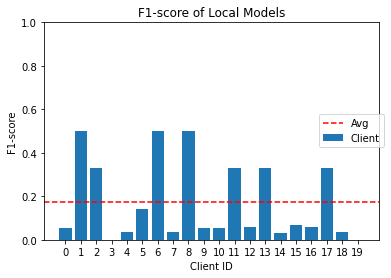

In [ ]:
plot_performance_of_local_models(precision_recall_fscores_of_local_aggregated_models, avg_local_aggregated_model_precision_recall_fscore)

In [ ]:
print_measures_of_dispersion(precision_recall_fscores_of_local_aggregated_models)

Variance of F1-score across local models: 0.031838589255835964
Standard Deviation of F1-score across local models: 0.17843371109696723


No handles with labels found to put in legend.


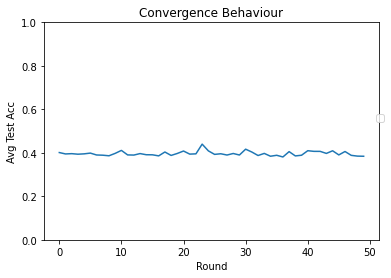

In [ ]:
plot_convergence_behaviour_from_federated_evaluation(federated_test_accs)

In [ ]:
get_utility_measure_on_distributions(avg_local_aggregated_model_precision_recall_fscore, avg_local_model_precision_recall_fscore)

Distribution                            Precision       Recall       F1-score  \
                                            Aggr. Local  Aggr. Local    Aggr.   
noniid-quantity-based-label-imbalance-1      0.38  0.45   0.16  0.41     0.17   

Distribution                                   
                                        Local  
noniid-quantity-based-label-imbalance-1  0.43